# Classifications on UCI Datasets

In [1]:
import math
import time
import datetime
import os
import csv
import numpy as np
import random

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from vqbnn.vqbnn import VQBNN
from vqbnn.och import OCH

import ops.trains as trains
import ops.tests as tests
import ops.uci_datasets as datasets

In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["font.size"] = 15
plt.rcParams["figure.titlesize"] = 25
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 13
plt.rcParams["lines.linewidth"] = 2

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "dejavuserif"
# plt.rcParams["figure.figsize"] = (8, 8)
# plt.rcParams["font.size"] = 30
# plt.rcParams["axes.labelsize"] = 53
# plt.rcParams["xtick.labelsize"] = 40
# plt.rcParams["ytick.labelsize"] = 40
# plt.rcParams["legend.fontsize"] = 28
# plt.rcParams["lines.linewidth"] = 4

In [3]:
model_path = 'models_checkpoints'

In [4]:
def create_dnn(classes_no, unit=50):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(unit, activation=tf.nn.relu),
        tf.keras.layers.Dense(unit, activation=tf.nn.relu),
        tf.keras.layers.Dense(unit, activation=tf.nn.relu),
        tf.keras.layers.Dense(classes_no)
    ], name='dnn')

def create_bnn(classes_no, unit=50):
    return tf.keras.Sequential([
        tfp.layers.DenseFlipout(unit, activation=tf.nn.relu),
        tfp.layers.DenseFlipout(unit, activation=tf.nn.relu),
        tfp.layers.DenseFlipout(unit, activation=tf.nn.relu),
        tfp.layers.DenseFlipout(classes_no)
    ], name='bnn')

Table of Contents
* [Occupancy Detection Data Set](#Occupancy-Detection-Data-Set)
* [EMG Data for Gestures Data Set](#EMG-Data-for-Gestures-Data-Set)
* [Localization Data for Person Activity Data Set](#Localization-Data-for-Person-Activity-Data-Set)

## [Occupancy Detection Data Set](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+)

In [5]:
input_dim = 5
num_classes = 2

In [6]:
dataset_train, dataset_test = datasets.dataset('occupancy', 'datasets/occupancy')
dataset_seq = datasets.sliding_window(dataset_test, offset=(0, 0))

In [7]:
# class_weights = datasets.median_freq_weights(dataset_train, num_classes, batch_size=512)
# print('Class weights: \n', class_weights.numpy())

In [8]:
# model = create_dnn(num_classes)  # DNN
model = create_bnn(num_classes)  # BNN

### Train

In [9]:
epochs = 60
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

epochtime_metric = tf.keras.metrics.Mean(name='epoch_time')
loss_metric = tf.keras.metrics.Mean(name='train_loss')
nll_metric = tf.keras.metrics.Mean(name='train_nll')

for epoch in range(epochs):
    batch_time = time.time()
    loss, nll = trains.train_epoch(optimizer, model, dataset_train, num_classes, 
                                   class_weights=None, batch_size=512, temp=1/8143)
    epochtime_metric(time.time() - batch_time)
    loss_metric(loss)
    nll_metric(nll)
    
    if (epoch + 1) % 1 == 0:
        template = '(%.2f sec) Epoch: %d, Loss: %.4f, NLL: %.4f'
        print(template % (epochtime_metric.result(),
                          epoch,
                          loss_metric.result(),
                          nll_metric.result()))
        
        epochtime_metric.reset_states()
        loss_metric.reset_states()
        nll_metric.reset_states()

    if (epoch + 1) % 2 == 0:
        metrics = tests.test_sampling(model, 5, 
                                      dataset_test, num_classes, 
                                      batch_size=512, cutoffs=(0.0, 0.9), verbose=False)


W0804 02:07:25.138220 4652617152 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:104: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0804 02:07:25.274317 4652617152 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/array_grad.py:502: _EagerTensorBase.cpu (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.identity instead.


(2.18 sec) Epoch: 0, Loss: 1.9741, NLL: 0.6322
(1.59 sec) Epoch: 1, Loss: 1.8782, NLL: 0.4608
Time: 301.853 ± 193.416 ms, NLL: 0.3900, Cutoffs: 0.0 %, 90.0 %, IoUs: 37.855 %, 0.000 %, Accs: 75.679 %, 0.000 %, Uncs: 0.000 %, 100.000 %, Covs: 100.000 %, 0.000 %, ECE: 26.604 %
(2.26 sec) Epoch: 2, Loss: 1.7672, NLL: 0.2587
(2.50 sec) Epoch: 3, Loss: 1.6996, NLL: 0.1431
Time: 158.175 ± 46.717 ms, NLL: 0.1401, Cutoffs: 0.0 %, 90.0 %, IoUs: 90.384 %, 98.100 %, Accs: 96.070 %, 99.974 %, Uncs: 0.000 %, 99.590 %, Covs: 100.000 %, 62.495 %, ECE: 5.928 %
(1.08 sec) Epoch: 4, Loss: 1.6596, NLL: 0.0829
(1.16 sec) Epoch: 5, Loss: 1.6366, NLL: 0.0569
Time: 146.522 ± 25.171 ms, NLL: 0.0616, Cutoffs: 0.0 %, 90.0 %, IoUs: 94.686 %, 97.997 %, Accs: 97.922 %, 99.271 %, Uncs: 0.000 %, 67.054 %, Covs: 100.000 %, 93.855 %, ECE: 0.717 %
(0.97 sec) Epoch: 6, Loss: 1.6237, NLL: 0.0510
(0.99 sec) Epoch: 7, Loss: 1.6140, NLL: 0.0516
Time: 143.248 ± 32.548 ms, NLL: 0.0528, Cutoffs: 0.0 %, 90.0 %, IoUs: 95.785 %, 9

In [ ]:
model.save_weights('%s/%s_%s' % (model_path, 'occupancy', model.name))

### Test

In [10]:
_ = tests.test_vanilla(model, 
                       dataset_test, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

10 Steps, Time: 35.330 ± 11.509 ms, NLL: 0.0683, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.067 %, 96.518 %, 97.426 %, Accs: 98.357 %, 98.558 %, 99.105 %, Uncs: 0.000 %, 13.095 %, 51.190 %, Covs: 100.000 %, 99.022 %, 89.613 %, ECE: 1.243 %
20 Steps, Time: 32.555 ± 9.011 ms, NLL: 0.0684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.003 %, 95.952 %, 97.642 %, Accs: 98.033 %, 98.432 %, 99.277 %, Uncs: 0.000 %, 21.429 %, 67.347 %, Covs: 100.000 %, 98.575 %, 88.819 %, ECE: 1.117 %
Time: 31.678 ± 8.349 ms, NLL: 0.0667, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.066 %, 96.208 %, 97.887 %, Accs: 98.056 %, 98.529 %, 99.313 %, Uncs: 0.000 %, 25.424 %, 68.220 %, Covs: 100.000 %, 98.526 %, 89.918 %, ECE: 0.967 %


In [11]:
_ = tests.test_sampling(model, 10, 
                        dataset_test, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

10 Steps, Time: 307.766 ± 33.489 ms, NLL: 0.0637, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.526 %, 96.697 %, 98.034 %, Accs: 98.555 %, 98.627 %, 99.320 %, Uncs: 0.000 %, 5.405 %, 58.108 %, Covs: 100.000 %, 99.570 %, 89.062 %, ECE: 1.564 %
20 Steps, Time: 305.205 ± 36.789 ms, NLL: 0.0643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.366 %, 96.561 %, 98.298 %, Accs: 98.213 %, 98.685 %, 99.493 %, Uncs: 0.000 %, 27.322 %, 74.863 %, Covs: 100.000 %, 98.779 %, 88.612 %, ECE: 1.400 %
Time: 329.290 ± 67.731 ms, NLL: 0.0611, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.000 %, 97.016 %, 98.498 %, Accs: 98.462 %, 98.861 %, 99.520 %, Uncs: 0.000 %, 26.702 %, 72.251 %, Covs: 100.000 %, 98.961 %, 88.869 %, ECE: 1.651 %


10 Steps, Time: 59.772 ± 22.296 ms, NLL: 0.0675, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.026 %, 96.522 %, 97.855 %, Accs: 98.339 %, 98.560 %, 99.261 %, Uncs: 0.000 %, 14.118 %, 60.000 %, Covs: 100.000 %, 99.120 %, 89.914 %, ECE: 1.231 %
20 Steps, Time: 58.378 ± 27.130 ms, NLL: 0.0676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.816 %, 96.017 %, 98.101 %, Accs: 97.956 %, 98.457 %, 99.425 %, Uncs: 0.000 %, 25.490 %, 75.000 %, Covs: 100.000 %, 98.667 %, 88.889 %, ECE: 1.073 %
Time: 53.725 ± 26.183 ms, NLL: 0.0678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.795 %, 96.074 %, 98.184 %, Accs: 97.944 %, 98.472 %, 99.413 %, Uncs: 0.000 %, 26.800 %, 74.400 %, Covs: 100.000 %, 98.495 %, 89.743 %, ECE: 0.947 %


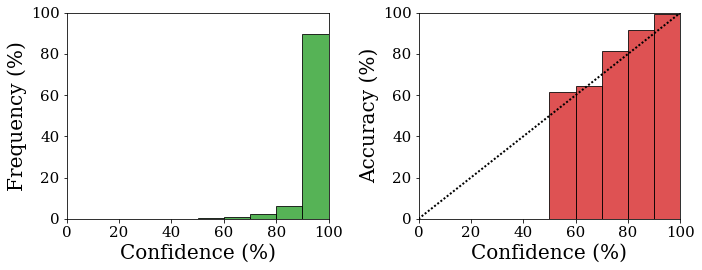

In [12]:
_ = tests.test_temporal_smoothing(model, 1.0, 
                                  dataset_seq, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

In [13]:
x_dims, y_dims = [input_dim], [num_classes]
och_x = OCH(k=10, l=1.3, s=1.0, dims=x_dims, hash_no=1)
och_y = OCH(k=10, l=1.3, s=1.0, dims=y_dims, hash_no=1)
vqbnn = VQBNN(lambda x: model(tf.stack([x[0]])), och_x=och_x, och_y=och_y, posterior=None)

_ = tests.test_vq(vqbnn, 
                  dataset_seq, num_classes, cutoffs=(0.0, 0.7, 0.9), verbose=True, period=2048)

10 Steps, Time: 31.689 ± 4.868 ms, NLL: 0.2062, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 90.000 %, 100.000 %, 0.000 %, Accs: 90.000 %, 100.000 %, 0.000 %, Uncs: 0.000 %, 100.000 %, 100.000 %, Covs: 100.000 %, 90.000 %, 0.000 %, ECE: 12.653 %
20 Steps, Time: 33.592 ± 6.827 ms, NLL: 0.2130, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.000 %, 100.000 %, 0.000 %, Accs: 95.000 %, 100.000 %, 0.000 %, Uncs: 0.000 %, 100.000 %, 100.000 %, Covs: 100.000 %, 95.000 %, 0.000 %, ECE: 16.142 %
30 Steps, Time: 33.309 ± 6.408 ms, NLL: 0.1906, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.667 %, 100.000 %, 0.000 %, Accs: 96.667 %, 100.000 %, 0.000 %, Uncs: 0.000 %, 100.000 %, 100.000 %, Covs: 100.000 %, 96.667 %, 0.000 %, ECE: 15.277 %
40 Steps, Time: 33.931 ± 6.827 ms, NLL: 0.1806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 97.500 %, 100.000 %, 0.000 %, Accs: 97.500 %, 100.000 %, 0.000 %, Uncs: 0.000 %, 100.000 %, 100.000 %, Covs: 100.000 %, 97.500 %, 0.000 %, ECE: 14.950 %
50 Steps, Time: 33.364 ± 6.703 ms, NLL: 0.16

360 Steps, Time: 32.262 ± 7.559 ms, NLL: 0.2118, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 86.582 %, 87.470 %, 97.548 %, Accs: 93.056 %, 93.557 %, 98.942 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.167 %, 52.500 %, ECE: 1.381 %
370 Steps, Time: 32.279 ± 7.588 ms, NLL: 0.2061, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 87.053 %, 87.919 %, 97.601 %, Accs: 93.243 %, 93.733 %, 98.995 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.189 %, 53.784 %, ECE: 1.343 %
380 Steps, Time: 32.909 ± 9.508 ms, NLL: 0.2007, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 87.471 %, 88.317 %, 97.647 %, Accs: 93.421 %, 93.899 %, 99.043 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.211 %, 55.000 %, ECE: 1.308 %
390 Steps, Time: 32.996 ± 9.520 ms, NLL: 0.1955, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 87.844 %, 88.673 %, 97.688 %, Accs: 93.590 %, 94.057 %, 99.087 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.231 %, 56.154 %, ECE: 1.275 %
400 Steps, Time: 32.965 ± 9.425 ms, NLL: 0.1906, Cut

710 Steps, Time: 34.707 ± 12.637 ms, NLL: 0.1074, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 92.033 %, 92.612 %, 98.098 %, Accs: 96.479 %, 96.747 %, 99.629 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.577 %, 75.915 %, ECE: 0.700 %
720 Steps, Time: 34.752 ± 12.722 ms, NLL: 0.1059, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 92.080 %, 92.656 %, 98.102 %, Accs: 96.528 %, 96.792 %, 99.636 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.583 %, 76.250 %, ECE: 0.690 %
730 Steps, Time: 34.699 ± 12.648 ms, NLL: 0.1045, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 92.126 %, 92.698 %, 98.106 %, Accs: 96.575 %, 96.836 %, 99.642 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.589 %, 76.575 %, ECE: 0.681 %
740 Steps, Time: 34.757 ± 12.745 ms, NLL: 0.1030, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 92.170 %, 92.739 %, 98.110 %, Accs: 96.622 %, 96.879 %, 99.649 %, Uncs: 0.000 %, 8.000 %, 92.000 %, Covs: 100.000 %, 99.595 %, 76.892 %, ECE: 0.672 %
750 Steps, Time: 34.806 ± 12.788 ms, NLL: 0.1017

1060 Steps, Time: 38.299 ± 20.161 ms, NLL: 0.0873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 91.700 %, 92.636 %, 97.434 %, Accs: 96.981 %, 97.346 %, 99.655 %, Uncs: 0.000 %, 12.500 %, 90.625 %, Covs: 100.000 %, 99.528 %, 82.075 %, ECE: 0.453 %
1070 Steps, Time: 38.277 ± 20.082 ms, NLL: 0.0873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 91.946 %, 92.859 %, 97.702 %, Accs: 97.009 %, 97.371 %, 99.658 %, Uncs: 0.000 %, 12.500 %, 90.625 %, Covs: 100.000 %, 99.533 %, 82.056 %, ECE: 0.484 %
1080 Steps, Time: 38.396 ± 20.161 ms, NLL: 0.0874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 92.174 %, 93.064 %, 97.916 %, Accs: 97.037 %, 97.395 %, 99.661 %, Uncs: 0.000 %, 12.500 %, 90.625 %, Covs: 100.000 %, 99.537 %, 82.037 %, ECE: 0.529 %
1090 Steps, Time: 38.330 ± 20.085 ms, NLL: 0.0874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 92.385 %, 93.255 %, 98.129 %, Accs: 97.064 %, 97.419 %, 99.665 %, Uncs: 0.000 %, 12.500 %, 90.625 %, Covs: 100.000 %, 99.541 %, 82.202 %, ECE: 0.601 %
1100 Steps, Time: 38.283 ± 20.007 ms, NL

1410 Steps, Time: 37.991 ± 19.626 ms, NLL: 0.1048, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 92.997 %, 94.189 %, 98.431 %, Accs: 96.525 %, 97.133 %, 99.323 %, Uncs: 0.000 %, 18.367 %, 83.673 %, Covs: 100.000 %, 98.936 %, 83.759 %, ECE: 1.357 %
1420 Steps, Time: 37.977 ± 19.570 ms, NLL: 0.1050, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 93.068 %, 94.249 %, 98.431 %, Accs: 96.549 %, 97.153 %, 99.323 %, Uncs: 0.000 %, 18.367 %, 83.673 %, Covs: 100.000 %, 98.944 %, 83.169 %, ECE: 1.255 %
1430 Steps, Time: 37.998 ± 19.541 ms, NLL: 0.1052, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 93.137 %, 94.307 %, 98.431 %, Accs: 96.573 %, 97.173 %, 99.323 %, Uncs: 0.000 %, 18.367 %, 83.673 %, Covs: 100.000 %, 98.951 %, 82.587 %, ECE: 1.159 %
1440 Steps, Time: 37.985 ± 19.485 ms, NLL: 0.1054, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 93.203 %, 94.363 %, 98.433 %, Accs: 96.597 %, 97.193 %, 99.323 %, Uncs: 0.000 %, 18.367 %, 83.673 %, Covs: 100.000 %, 98.958 %, 82.083 %, ECE: 1.223 %
1450 Steps, Time: 37.987 ± 19.441 ms, NL

1760 Steps, Time: 38.056 ± 19.005 ms, NLL: 0.0932, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.452 %, 95.389 %, 98.878 %, Accs: 97.159 %, 97.649 %, 99.461 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.091 %, 84.261 %, ECE: 1.562 %
1770 Steps, Time: 38.018 ± 18.958 ms, NLL: 0.0926, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.479 %, 95.412 %, 98.883 %, Accs: 97.175 %, 97.662 %, 99.464 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.096 %, 84.350 %, ECE: 1.553 %
1780 Steps, Time: 38.039 ± 18.921 ms, NLL: 0.0921, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.505 %, 95.434 %, 98.888 %, Accs: 97.191 %, 97.676 %, 99.468 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.101 %, 84.438 %, ECE: 1.545 %
1790 Steps, Time: 38.038 ± 18.899 ms, NLL: 0.0916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.531 %, 95.455 %, 98.892 %, Accs: 97.207 %, 97.689 %, 99.471 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.106 %, 84.525 %, ECE: 1.536 %
1800 Steps, Time: 38.024 ± 18.854 ms, NL

2110 Steps, Time: 37.880 ± 18.569 ms, NLL: 0.0777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.144 %, 95.973 %, 99.002 %, Accs: 97.630 %, 98.042 %, 99.564 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.242 %, 86.872 %, ECE: 1.303 %
2120 Steps, Time: 37.909 ± 18.599 ms, NLL: 0.0773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.159 %, 95.985 %, 99.005 %, Accs: 97.642 %, 98.051 %, 99.566 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.245 %, 86.934 %, ECE: 1.297 %
2130 Steps, Time: 37.932 ± 18.608 ms, NLL: 0.0770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.173 %, 95.997 %, 99.007 %, Accs: 97.653 %, 98.061 %, 99.568 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.249 %, 86.995 %, ECE: 1.291 %
2140 Steps, Time: 37.930 ± 18.602 ms, NLL: 0.0766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.187 %, 96.009 %, 99.010 %, Accs: 97.664 %, 98.070 %, 99.571 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.252 %, 87.056 %, ECE: 1.285 %
2150 Steps, Time: 37.955 ± 18.631 ms, NL

2460 Steps, Time: 37.514 ± 17.911 ms, NLL: 0.0667, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.545 %, 96.309 %, 99.072 %, Accs: 97.967 %, 98.322 %, 99.634 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.350 %, 88.740 %, ECE: 1.118 %
2470 Steps, Time: 37.529 ± 17.890 ms, NLL: 0.0664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.554 %, 96.317 %, 99.074 %, Accs: 97.976 %, 98.329 %, 99.635 %, Uncs: 0.000 %, 18.000 %, 84.000 %, Covs: 100.000 %, 99.352 %, 88.785 %, ECE: 1.113 %
2480 Steps, Time: 37.563 ± 17.884 ms, NLL: 0.0671, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.478 %, 96.237 %, 98.961 %, Accs: 97.944 %, 98.295 %, 99.591 %, Uncs: 0.000 %, 17.647 %, 82.353 %, Covs: 100.000 %, 99.355 %, 88.831 %, ECE: 1.072 %
2490 Steps, Time: 37.540 ± 17.854 ms, NLL: 0.0689, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.339 %, 96.170 %, 98.961 %, Accs: 97.871 %, 98.260 %, 99.591 %, Uncs: 0.000 %, 18.868 %, 83.019 %, Covs: 100.000 %, 99.237 %, 88.474 %, ECE: 1.061 %
2500 Steps, Time: 37.531 ± 17.830 ms, NL

2810 Steps, Time: 37.864 ± 18.595 ms, NLL: 0.0871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.902 %, 95.575 %, 97.894 %, Accs: 97.473 %, 97.814 %, 99.035 %, Uncs: 0.000 %, 14.085 %, 66.197 %, Covs: 100.000 %, 99.324 %, 88.470 %, ECE: 1.102 %
2820 Steps, Time: 37.844 ± 18.566 ms, NLL: 0.0870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.927 %, 95.597 %, 97.909 %, Accs: 97.482 %, 97.822 %, 99.038 %, Uncs: 0.000 %, 14.085 %, 66.197 %, Covs: 100.000 %, 99.326 %, 88.511 %, ECE: 1.125 %
2830 Steps, Time: 37.818 ± 18.538 ms, NLL: 0.0871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.952 %, 95.619 %, 97.914 %, Accs: 97.491 %, 97.830 %, 99.040 %, Uncs: 0.000 %, 14.085 %, 66.197 %, Covs: 100.000 %, 99.329 %, 88.304 %, ECE: 1.160 %
2840 Steps, Time: 37.800 ± 18.511 ms, NLL: 0.0872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.977 %, 95.641 %, 97.917 %, Accs: 97.500 %, 97.838 %, 99.040 %, Uncs: 0.000 %, 14.085 %, 66.197 %, Covs: 100.000 %, 99.331 %, 88.063 %, ECE: 1.194 %
2850 Steps, Time: 37.799 ± 18.512 ms, NL

3160 Steps, Time: 37.175 ± 17.789 ms, NLL: 0.0812, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.305 %, 95.982 %, 98.028 %, Accs: 97.722 %, 98.057 %, 99.136 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.335 %, 87.943 %, ECE: 1.274 %
3170 Steps, Time: 37.156 ± 17.764 ms, NLL: 0.0809, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.314 %, 95.990 %, 98.031 %, Accs: 97.729 %, 98.063 %, 99.139 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.338 %, 87.981 %, ECE: 1.270 %
3180 Steps, Time: 37.136 ± 17.739 ms, NLL: 0.0807, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.323 %, 95.997 %, 98.034 %, Accs: 97.736 %, 98.069 %, 99.143 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.340 %, 88.019 %, ECE: 1.266 %
3190 Steps, Time: 37.116 ± 17.715 ms, NLL: 0.0804, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.332 %, 96.005 %, 98.038 %, Accs: 97.743 %, 98.075 %, 99.146 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.342 %, 88.056 %, ECE: 1.262 %
3200 Steps, Time: 37.096 ± 17.691 ms, NL

3510 Steps, Time: 36.655 ± 17.141 ms, NLL: 0.0731, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.578 %, 96.217 %, 98.125 %, Accs: 97.949 %, 98.252 %, 99.233 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.402 %, 89.145 %, ECE: 1.147 %
3520 Steps, Time: 36.639 ± 17.120 ms, NLL: 0.0729, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.584 %, 96.223 %, 98.128 %, Accs: 97.955 %, 98.257 %, 99.235 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.403 %, 89.176 %, ECE: 1.144 %
3530 Steps, Time: 36.628 ± 17.097 ms, NLL: 0.0727, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.591 %, 96.228 %, 98.130 %, Accs: 97.960 %, 98.262 %, 99.238 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.405 %, 89.207 %, ECE: 1.141 %
3540 Steps, Time: 36.627 ± 17.074 ms, NLL: 0.0725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.598 %, 96.234 %, 98.132 %, Accs: 97.966 %, 98.267 %, 99.240 %, Uncs: 0.000 %, 15.278 %, 66.667 %, Covs: 100.000 %, 99.407 %, 89.237 %, ECE: 1.138 %
3550 Steps, Time: 36.612 ± 17.052 ms, NL

3860 Steps, Time: 36.610 ± 17.211 ms, NLL: 0.0716, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.649 %, 96.281 %, 98.244 %, Accs: 97.979 %, 98.279 %, 99.276 %, Uncs: 0.000 %, 15.385 %, 67.949 %, Covs: 100.000 %, 99.352 %, 89.404 %, ECE: 1.181 %
3870 Steps, Time: 36.598 ± 17.192 ms, NLL: 0.0721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.655 %, 96.285 %, 98.244 %, Accs: 97.984 %, 98.282 %, 99.276 %, Uncs: 0.000 %, 15.385 %, 67.949 %, Covs: 100.000 %, 99.276 %, 89.173 %, ECE: 1.154 %
3880 Steps, Time: 36.591 ± 17.171 ms, NLL: 0.0728, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.661 %, 96.288 %, 98.244 %, Accs: 97.990 %, 98.285 %, 99.276 %, Uncs: 0.000 %, 15.385 %, 67.949 %, Covs: 100.000 %, 99.201 %, 88.943 %, ECE: 1.188 %
3890 Steps, Time: 36.578 ± 17.151 ms, NLL: 0.0734, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.667 %, 96.292 %, 98.244 %, Accs: 97.995 %, 98.288 %, 99.276 %, Uncs: 0.000 %, 15.385 %, 67.949 %, Covs: 100.000 %, 99.126 %, 88.715 %, ECE: 1.250 %
3900 Steps, Time: 36.583 ± 17.168 ms, NL

4210 Steps, Time: 36.377 ± 16.792 ms, NLL: 0.0781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.545 %, 96.259 %, 98.155 %, Accs: 97.981 %, 98.315 %, 99.269 %, Uncs: 0.000 %, 17.647 %, 68.235 %, Covs: 100.000 %, 98.670 %, 87.791 %, ECE: 1.519 %
4220 Steps, Time: 36.368 ± 16.774 ms, NLL: 0.0785, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.565 %, 96.277 %, 98.155 %, Accs: 97.986 %, 98.319 %, 99.269 %, Uncs: 0.000 %, 17.647 %, 68.235 %, Covs: 100.000 %, 98.673 %, 87.583 %, ECE: 1.573 %
4230 Steps, Time: 36.369 ± 16.758 ms, NLL: 0.0790, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.586 %, 96.295 %, 98.155 %, Accs: 97.991 %, 98.323 %, 99.269 %, Uncs: 0.000 %, 17.647 %, 68.235 %, Covs: 100.000 %, 98.676 %, 87.376 %, ECE: 1.623 %
4240 Steps, Time: 36.365 ± 16.741 ms, NLL: 0.0793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.606 %, 96.312 %, 98.155 %, Accs: 97.995 %, 98.327 %, 99.269 %, Uncs: 0.000 %, 17.647 %, 68.235 %, Covs: 100.000 %, 98.679 %, 87.170 %, ECE: 1.666 %
4250 Steps, Time: 36.354 ± 16.723 ms, NL

4560 Steps, Time: 36.190 ± 16.411 ms, NLL: 0.0760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.771 %, 96.492 %, 98.201 %, Accs: 98.114 %, 98.445 %, 99.320 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.750 %, 87.083 %, ECE: 1.738 %
4570 Steps, Time: 36.196 ± 16.428 ms, NLL: 0.0759, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.775 %, 96.496 %, 98.202 %, Accs: 98.118 %, 98.449 %, 99.322 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.753 %, 87.112 %, ECE: 1.734 %
4580 Steps, Time: 36.186 ± 16.412 ms, NLL: 0.0757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.780 %, 96.500 %, 98.204 %, Accs: 98.122 %, 98.452 %, 99.323 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.755 %, 87.140 %, ECE: 1.730 %
4590 Steps, Time: 36.176 ± 16.395 ms, NLL: 0.0755, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.784 %, 96.503 %, 98.205 %, Accs: 98.126 %, 98.456 %, 99.325 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.758 %, 87.168 %, ECE: 1.726 %
4600 Steps, Time: 36.169 ± 16.379 ms, NL

4910 Steps, Time: 36.117 ± 16.219 ms, NLL: 0.0706, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.908 %, 96.607 %, 98.248 %, Accs: 98.248 %, 98.558 %, 99.375 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.839 %, 88.004 %, ECE: 1.614 %
4920 Steps, Time: 36.108 ± 16.204 ms, NLL: 0.0705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.912 %, 96.610 %, 98.249 %, Accs: 98.252 %, 98.561 %, 99.377 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.841 %, 88.028 %, ECE: 1.610 %
4930 Steps, Time: 36.126 ± 16.243 ms, NLL: 0.0703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.915 %, 96.613 %, 98.250 %, Accs: 98.256 %, 98.564 %, 99.378 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.844 %, 88.053 %, ECE: 1.607 %
4940 Steps, Time: 36.131 ± 16.258 ms, NLL: 0.0702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.919 %, 96.615 %, 98.252 %, Accs: 98.259 %, 98.566 %, 99.379 %, Uncs: 0.000 %, 18.605 %, 68.605 %, Covs: 100.000 %, 98.846 %, 88.077 %, ECE: 1.604 %
4950 Steps, Time: 36.122 ± 16.243 ms, NL

5260 Steps, Time: 36.047 ± 16.072 ms, NLL: 0.0701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.851 %, 96.553 %, 98.286 %, Accs: 98.251 %, 98.558 %, 99.414 %, Uncs: 0.000 %, 18.478 %, 70.652 %, Covs: 100.000 %, 98.859 %, 87.643 %, ECE: 1.590 %
5270 Steps, Time: 36.041 ± 16.057 ms, NLL: 0.0710, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.780 %, 96.478 %, 98.286 %, Accs: 98.216 %, 98.522 %, 99.414 %, Uncs: 0.000 %, 18.085 %, 71.277 %, Covs: 100.000 %, 98.861 %, 87.476 %, ECE: 1.572 %
5280 Steps, Time: 36.046 ± 16.071 ms, NLL: 0.0712, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.799 %, 96.494 %, 98.286 %, Accs: 98.220 %, 98.525 %, 99.414 %, Uncs: 0.000 %, 18.085 %, 71.277 %, Covs: 100.000 %, 98.864 %, 87.311 %, ECE: 1.595 %
5290 Steps, Time: 36.039 ± 16.057 ms, NLL: 0.0713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.817 %, 96.510 %, 98.288 %, Accs: 98.223 %, 98.528 %, 99.414 %, Uncs: 0.000 %, 18.085 %, 71.277 %, Covs: 100.000 %, 98.866 %, 87.164 %, ECE: 1.619 %
5300 Steps, Time: 36.030 ± 16.044 ms, NL

5610 Steps, Time: 35.956 ± 15.934 ms, NLL: 0.0800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.995 %, 96.673 %, 98.241 %, Accs: 98.200 %, 98.517 %, 99.398 %, Uncs: 0.000 %, 18.812 %, 72.277 %, Covs: 100.000 %, 98.574 %, 82.888 %, ECE: 2.383 %
5620 Steps, Time: 35.948 ± 15.921 ms, NLL: 0.0802, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.009 %, 96.685 %, 98.241 %, Accs: 98.203 %, 98.520 %, 99.398 %, Uncs: 0.000 %, 18.812 %, 72.277 %, Covs: 100.000 %, 98.577 %, 82.740 %, ECE: 2.415 %
5630 Steps, Time: 35.953 ± 15.934 ms, NLL: 0.0804, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.023 %, 96.697 %, 98.241 %, Accs: 98.206 %, 98.523 %, 99.398 %, Uncs: 0.000 %, 18.812 %, 72.277 %, Covs: 100.000 %, 98.579 %, 82.593 %, ECE: 2.441 %
5640 Steps, Time: 35.945 ± 15.921 ms, NLL: 0.0806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.037 %, 96.709 %, 98.241 %, Accs: 98.209 %, 98.525 %, 99.398 %, Uncs: 0.000 %, 18.812 %, 72.277 %, Covs: 100.000 %, 98.582 %, 82.447 %, ECE: 2.464 %
5650 Steps, Time: 35.938 ± 15.908 ms, NL

5960 Steps, Time: 35.934 ± 16.056 ms, NLL: 0.0791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.169 %, 96.807 %, 98.210 %, Accs: 98.272 %, 98.571 %, 99.390 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.624 %, 82.483 %, ECE: 2.491 %
5970 Steps, Time: 35.992 ± 16.309 ms, NLL: 0.0790, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.172 %, 96.809 %, 98.211 %, Accs: 98.275 %, 98.573 %, 99.391 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.626 %, 82.513 %, ECE: 2.487 %
5980 Steps, Time: 36.017 ± 16.334 ms, NLL: 0.0789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.175 %, 96.812 %, 98.212 %, Accs: 98.278 %, 98.576 %, 99.392 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.629 %, 82.542 %, ECE: 2.483 %
5990 Steps, Time: 36.013 ± 16.320 ms, NLL: 0.0787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.178 %, 96.815 %, 98.213 %, Accs: 98.280 %, 98.578 %, 99.393 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.631 %, 82.571 %, ECE: 2.479 %
6000 Steps, Time: 36.039 ± 16.354 ms, NL

6310 Steps, Time: 36.592 ± 17.905 ms, NLL: 0.0747, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.270 %, 96.891 %, 98.242 %, Accs: 98.368 %, 98.651 %, 99.430 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.700 %, 83.455 %, ECE: 2.353 %
6320 Steps, Time: 36.593 ± 17.892 ms, NLL: 0.0746, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.273 %, 96.893 %, 98.243 %, Accs: 98.370 %, 98.653 %, 99.431 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.703 %, 83.481 %, ECE: 2.349 %
6330 Steps, Time: 36.585 ± 17.879 ms, NLL: 0.0745, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.275 %, 96.896 %, 98.244 %, Accs: 98.373 %, 98.656 %, 99.432 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.705 %, 83.507 %, ECE: 2.346 %
6340 Steps, Time: 36.595 ± 17.890 ms, NLL: 0.0744, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.278 %, 96.898 %, 98.244 %, Accs: 98.375 %, 98.658 %, 99.434 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.707 %, 83.533 %, ECE: 2.342 %
6350 Steps, Time: 36.635 ± 18.056 ms, NL

6660 Steps, Time: 37.004 ± 18.737 ms, NLL: 0.0708, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.355 %, 96.962 %, 98.269 %, Accs: 98.452 %, 98.722 %, 99.465 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.767 %, 84.308 %, ECE: 2.232 %
6670 Steps, Time: 37.015 ± 18.747 ms, NLL: 0.0707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.357 %, 96.964 %, 98.269 %, Accs: 98.454 %, 98.724 %, 99.466 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.769 %, 84.331 %, ECE: 2.228 %
6680 Steps, Time: 37.015 ± 18.734 ms, NLL: 0.0706, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.359 %, 96.965 %, 98.270 %, Accs: 98.456 %, 98.726 %, 99.467 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.771 %, 84.355 %, ECE: 2.225 %
6690 Steps, Time: 37.025 ± 18.743 ms, NLL: 0.0705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.362 %, 96.967 %, 98.271 %, Accs: 98.459 %, 98.727 %, 99.468 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.773 %, 84.378 %, ECE: 2.222 %
6700 Steps, Time: 37.020 ± 18.730 ms, NL

7010 Steps, Time: 37.492 ± 20.429 ms, NLL: 0.0679, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.429 %, 97.024 %, 98.291 %, Accs: 98.529 %, 98.786 %, 99.496 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.815 %, 84.935 %, ECE: 2.176 %
7020 Steps, Time: 37.508 ± 20.445 ms, NLL: 0.0678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.431 %, 97.025 %, 98.292 %, Accs: 98.531 %, 98.788 %, 99.496 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.816 %, 84.957 %, ECE: 2.173 %
7030 Steps, Time: 37.524 ± 20.447 ms, NLL: 0.0677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.433 %, 97.027 %, 98.292 %, Accs: 98.533 %, 98.790 %, 99.497 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.818 %, 84.978 %, ECE: 2.170 %
7040 Steps, Time: 37.569 ± 20.521 ms, NLL: 0.0676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.435 %, 97.028 %, 98.293 %, Accs: 98.535 %, 98.791 %, 99.498 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.820 %, 84.999 %, ECE: 2.167 %
7050 Steps, Time: 37.587 ± 20.534 ms, NL

7360 Steps, Time: 38.425 ± 21.768 ms, NLL: 0.0647, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.494 %, 97.078 %, 98.312 %, Accs: 98.599 %, 98.845 %, 99.524 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.871 %, 85.652 %, ECE: 2.072 %
7370 Steps, Time: 38.427 ± 21.754 ms, NLL: 0.0646, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.496 %, 97.079 %, 98.312 %, Accs: 98.601 %, 98.846 %, 99.524 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.873 %, 85.672 %, ECE: 2.069 %
7380 Steps, Time: 38.445 ± 21.767 ms, NLL: 0.0645, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.498 %, 97.080 %, 98.313 %, Accs: 98.603 %, 98.848 %, 99.525 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.874 %, 85.691 %, ECE: 2.067 %
7390 Steps, Time: 38.445 ± 21.753 ms, NLL: 0.0644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.500 %, 97.082 %, 98.313 %, Accs: 98.605 %, 98.849 %, 99.526 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.876 %, 85.710 %, ECE: 2.064 %
7400 Steps, Time: 38.476 ± 21.789 ms, NL

7710 Steps, Time: 38.899 ± 22.111 ms, NLL: 0.0617, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.552 %, 97.125 %, 98.329 %, Accs: 98.663 %, 98.898 %, 99.549 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.922 %, 86.304 %, ECE: 1.978 %
7720 Steps, Time: 38.901 ± 22.097 ms, NLL: 0.0616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.553 %, 97.126 %, 98.330 %, Accs: 98.665 %, 98.899 %, 99.549 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.924 %, 86.322 %, ECE: 1.976 %
7730 Steps, Time: 38.915 ± 22.112 ms, NLL: 0.0616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.555 %, 97.128 %, 98.330 %, Accs: 98.666 %, 98.901 %, 99.550 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.925 %, 86.340 %, ECE: 1.973 %
7740 Steps, Time: 38.922 ± 22.104 ms, NLL: 0.0615, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.556 %, 97.129 %, 98.331 %, Accs: 98.668 %, 98.902 %, 99.551 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.927 %, 86.357 %, ECE: 1.970 %
7750 Steps, Time: 38.933 ± 22.117 ms, NL

8060 Steps, Time: 39.256 ± 22.301 ms, NLL: 0.0590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.602 %, 97.167 %, 98.345 %, Accs: 98.721 %, 98.946 %, 99.571 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.969 %, 86.899 %, ECE: 1.892 %
8070 Steps, Time: 39.253 ± 22.288 ms, NLL: 0.0590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.604 %, 97.168 %, 98.346 %, Accs: 98.723 %, 98.947 %, 99.572 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.971 %, 86.916 %, ECE: 1.890 %
8080 Steps, Time: 39.268 ± 22.297 ms, NLL: 0.0589, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.605 %, 97.169 %, 98.346 %, Accs: 98.724 %, 98.949 %, 99.573 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.972 %, 86.932 %, ECE: 1.890 %
8090 Steps, Time: 39.266 ± 22.284 ms, NLL: 0.0589, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 96.606 %, 97.170 %, 98.346 %, Accs: 98.726 %, 98.950 %, 99.573 %, Uncs: 0.000 %, 18.447 %, 70.874 %, Covs: 100.000 %, 98.973 %, 86.948 %, ECE: 1.890 %
8100 Steps, Time: 39.288 ± 22.319 ms, NL

8410 Steps, Time: 39.565 ± 22.541 ms, NLL: 0.0713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.188 %, 96.552 %, 98.352 %, Accs: 97.810 %, 98.734 %, 99.582 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.763 %, 85.350 %, ECE: 1.688 %
8420 Steps, Time: 39.581 ± 22.553 ms, NLL: 0.0713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.190 %, 96.554 %, 98.353 %, Accs: 97.813 %, 98.736 %, 99.582 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.765 %, 85.368 %, ECE: 1.686 %
8430 Steps, Time: 39.589 ± 22.543 ms, NLL: 0.0712, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.192 %, 96.555 %, 98.353 %, Accs: 97.816 %, 98.737 %, 99.583 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.768 %, 85.385 %, ECE: 1.684 %
8440 Steps, Time: 39.597 ± 22.548 ms, NLL: 0.0711, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.194 %, 96.556 %, 98.353 %, Accs: 97.818 %, 98.739 %, 99.583 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.771 %, 85.403 %, ECE: 1.682 %
8450 Steps, Time: 39.610 ± 22.562 ms, NL

8760 Steps, Time: 39.910 ± 22.752 ms, NLL: 0.0685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.260 %, 96.595 %, 98.365 %, Accs: 97.898 %, 98.786 %, 99.601 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.852 %, 85.936 %, ECE: 1.622 %
8770 Steps, Time: 39.913 ± 22.741 ms, NLL: 0.0684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.262 %, 96.596 %, 98.366 %, Accs: 97.900 %, 98.787 %, 99.602 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.855 %, 85.952 %, ECE: 1.620 %
8780 Steps, Time: 39.923 ± 22.745 ms, NLL: 0.0684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.264 %, 96.597 %, 98.366 %, Accs: 97.903 %, 98.789 %, 99.602 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.857 %, 85.968 %, ECE: 1.618 %
8790 Steps, Time: 39.936 ± 22.758 ms, NLL: 0.0683, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.266 %, 96.599 %, 98.367 %, Accs: 97.905 %, 98.790 %, 99.603 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.860 %, 85.984 %, ECE: 1.616 %
8800 Steps, Time: 39.934 ± 22.745 ms, NL

9110 Steps, Time: 40.349 ± 23.610 ms, NLL: 0.0659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.326 %, 96.634 %, 98.377 %, Accs: 97.979 %, 98.833 %, 99.619 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.935 %, 86.477 %, ECE: 1.560 %
9120 Steps, Time: 40.356 ± 23.606 ms, NLL: 0.0658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.327 %, 96.635 %, 98.378 %, Accs: 97.981 %, 98.835 %, 99.619 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.937 %, 86.492 %, ECE: 1.558 %
9130 Steps, Time: 40.381 ± 23.645 ms, NLL: 0.0657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.329 %, 96.636 %, 98.378 %, Accs: 97.983 %, 98.836 %, 99.620 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.939 %, 86.507 %, ECE: 1.556 %
9140 Steps, Time: 40.390 ± 23.648 ms, NLL: 0.0657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.331 %, 96.637 %, 98.378 %, Accs: 97.985 %, 98.837 %, 99.620 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 97.942 %, 86.521 %, ECE: 1.555 %
9150 Steps, Time: 40.420 ± 23.704 ms, NL

9460 Steps, Time: 40.759 ± 24.009 ms, NLL: 0.0635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.385 %, 96.669 %, 98.388 %, Accs: 98.054 %, 98.877 %, 99.635 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 98.011 %, 86.978 %, ECE: 1.504 %
9470 Steps, Time: 40.764 ± 24.010 ms, NLL: 0.0634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.386 %, 96.670 %, 98.388 %, Accs: 98.056 %, 98.879 %, 99.636 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 98.013 %, 86.991 %, ECE: 1.502 %
9480 Steps, Time: 40.757 ± 23.999 ms, NLL: 0.0633, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.388 %, 96.671 %, 98.389 %, Accs: 98.058 %, 98.880 %, 99.636 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 98.015 %, 87.005 %, ECE: 1.501 %
9490 Steps, Time: 40.756 ± 23.998 ms, NLL: 0.0633, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.390 %, 96.672 %, 98.389 %, Accs: 98.060 %, 98.881 %, 99.636 %, Uncs: 0.000 %, 43.478 %, 83.696 %, Covs: 100.000 %, 98.018 %, 87.019 %, ECE: 1.499 %
9500 Steps, Time: 40.756 ± 23.996 ms, NL

9810 Steps, Time: 40.855 ± 24.124 ms, NLL: 0.0662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.659 %, 96.714 %, 98.219 %, Accs: 98.011 %, 98.804 %, 99.521 %, Uncs: 0.000 %, 41.026 %, 78.974 %, Covs: 100.000 %, 98.072 %, 87.330 %, ECE: 1.502 %
9820 Steps, Time: 40.847 ± 24.113 ms, NLL: 0.0663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.676 %, 96.725 %, 98.228 %, Accs: 98.013 %, 98.805 %, 99.522 %, Uncs: 0.000 %, 41.026 %, 78.974 %, Covs: 100.000 %, 98.074 %, 87.323 %, ECE: 1.508 %
9830 Steps, Time: 40.846 ± 24.113 ms, NLL: 0.0663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.692 %, 96.736 %, 98.235 %, Accs: 98.015 %, 98.806 %, 99.522 %, Uncs: 0.000 %, 41.026 %, 78.974 %, Covs: 100.000 %, 98.076 %, 87.305 %, ECE: 1.515 %
9840 Steps, Time: 40.847 ± 24.113 ms, NLL: 0.0663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 94.709 %, 96.747 %, 98.246 %, Accs: 98.017 %, 98.808 %, 99.522 %, Uncs: 0.000 %, 41.026 %, 78.974 %, Covs: 100.000 %, 98.078 %, 87.318 %, ECE: 1.519 %
9850 Steps, Time: 40.849 ± 24.112 ms, NL

10160 Steps, Time: 40.829 ± 24.065 ms, NLL: 0.0658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.036 %, 96.948 %, 98.446 %, Accs: 98.070 %, 98.836 %, 99.539 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.129 %, 87.610 %, ECE: 1.602 %
10170 Steps, Time: 40.832 ± 24.067 ms, NLL: 0.0658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.038 %, 96.949 %, 98.447 %, Accs: 98.071 %, 98.837 %, 99.540 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.130 %, 87.622 %, ECE: 1.600 %
10180 Steps, Time: 40.833 ± 24.074 ms, NLL: 0.0657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.040 %, 96.950 %, 98.447 %, Accs: 98.073 %, 98.838 %, 99.540 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.132 %, 87.634 %, ECE: 1.599 %
10190 Steps, Time: 40.834 ± 24.073 ms, NLL: 0.0656, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.041 %, 96.951 %, 98.447 %, Accs: 98.075 %, 98.839 %, 99.541 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.134 %, 87.646 %, ECE: 1.597 %
10200 Steps, Time: 40.835 ± 24.073 m

10500 Steps, Time: 40.880 ± 24.062 ms, NLL: 0.0637, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.090 %, 96.981 %, 98.459 %, Accs: 98.132 %, 98.874 %, 99.556 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.189 %, 88.011 %, ECE: 1.550 %
10510 Steps, Time: 40.899 ± 24.106 ms, NLL: 0.0636, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.092 %, 96.982 %, 98.459 %, Accs: 98.134 %, 98.875 %, 99.557 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.191 %, 88.022 %, ECE: 1.549 %
10520 Steps, Time: 40.902 ± 24.107 ms, NLL: 0.0636, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.093 %, 96.983 %, 98.459 %, Accs: 98.136 %, 98.876 %, 99.557 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.193 %, 88.034 %, ECE: 1.547 %
10530 Steps, Time: 40.903 ± 24.106 ms, NLL: 0.0635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.095 %, 96.984 %, 98.460 %, Accs: 98.137 %, 98.877 %, 99.557 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.194 %, 88.045 %, ECE: 1.546 %
10540 Steps, Time: 40.897 ± 24.096 m

10840 Steps, Time: 40.931 ± 24.096 ms, NLL: 0.0617, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.140 %, 97.012 %, 98.470 %, Accs: 98.191 %, 98.910 %, 99.572 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.246 %, 88.387 %, ECE: 1.501 %
10850 Steps, Time: 40.925 ± 24.086 ms, NLL: 0.0617, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.141 %, 97.013 %, 98.470 %, Accs: 98.192 %, 98.911 %, 99.572 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.248 %, 88.398 %, ECE: 1.500 %
10860 Steps, Time: 40.926 ± 24.085 ms, NLL: 0.0616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.143 %, 97.013 %, 98.471 %, Accs: 98.194 %, 98.912 %, 99.573 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.249 %, 88.409 %, ECE: 1.499 %
10870 Steps, Time: 40.928 ± 24.092 ms, NLL: 0.0615, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.144 %, 97.014 %, 98.471 %, Accs: 98.196 %, 98.913 %, 99.573 %, Uncs: 0.000 %, 40.816 %, 79.082 %, Covs: 100.000 %, 98.251 %, 88.419 %, ECE: 1.497 %
10880 Steps, Time: 40.929 ± 24.092 m

11180 Steps, Time: 40.939 ± 24.072 ms, NLL: 0.0609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.395 %, 97.147 %, 98.638 %, Accs: 98.219 %, 98.916 %, 99.586 %, Uncs: 0.000 %, 40.201 %, 79.397 %, Covs: 100.000 %, 98.291 %, 88.696 %, ECE: 1.483 %
11190 Steps, Time: 40.941 ± 24.078 ms, NLL: 0.0609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.406 %, 97.155 %, 98.644 %, Accs: 98.221 %, 98.917 %, 99.587 %, Uncs: 0.000 %, 40.201 %, 79.397 %, Covs: 100.000 %, 98.292 %, 88.706 %, ECE: 1.483 %
11200 Steps, Time: 40.944 ± 24.085 ms, NLL: 0.0609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.417 %, 97.162 %, 98.648 %, Accs: 98.222 %, 98.918 %, 99.587 %, Uncs: 0.000 %, 40.201 %, 79.397 %, Covs: 100.000 %, 98.285 %, 88.698 %, ECE: 1.481 %
11210 Steps, Time: 40.946 ± 24.092 ms, NLL: 0.0609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.418 %, 97.163 %, 98.649 %, Accs: 98.224 %, 98.919 %, 99.587 %, Uncs: 0.000 %, 40.201 %, 79.397 %, Covs: 100.000 %, 98.286 %, 88.682 %, ECE: 1.487 %
11220 Steps, Time: 40.948 ± 24.092 m

11520 Steps, Time: 41.006 ± 24.084 ms, NLL: 0.0605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.635 %, 97.291 %, 98.761 %, Accs: 98.237 %, 98.922 %, 99.589 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.306 %, 88.865 %, ECE: 1.468 %
11530 Steps, Time: 41.008 ± 24.084 ms, NLL: 0.0605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.637 %, 97.292 %, 98.761 %, Accs: 98.238 %, 98.923 %, 99.590 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.308 %, 88.874 %, ECE: 1.468 %
11540 Steps, Time: 41.009 ± 24.084 ms, NLL: 0.0604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.638 %, 97.293 %, 98.762 %, Accs: 98.240 %, 98.924 %, 99.590 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.309 %, 88.884 %, ECE: 1.467 %
11550 Steps, Time: 41.011 ± 24.085 ms, NLL: 0.0604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.640 %, 97.294 %, 98.762 %, Accs: 98.241 %, 98.925 %, 99.591 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.311 %, 88.894 %, ECE: 1.466 %
11560 Steps, Time: 41.013 ± 24.084 m

11860 Steps, Time: 41.077 ± 24.151 ms, NLL: 0.0601, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.681 %, 97.319 %, 98.770 %, Accs: 98.287 %, 98.953 %, 99.601 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.313 %, 88.838 %, ECE: 1.514 %
11870 Steps, Time: 41.080 ± 24.151 ms, NLL: 0.0600, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.682 %, 97.320 %, 98.770 %, Accs: 98.289 %, 98.954 %, 99.602 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.314 %, 88.848 %, ECE: 1.513 %
11880 Steps, Time: 41.082 ± 24.152 ms, NLL: 0.0600, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.684 %, 97.321 %, 98.771 %, Accs: 98.290 %, 98.955 %, 99.602 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.316 %, 88.857 %, ECE: 1.512 %
11890 Steps, Time: 41.083 ± 24.152 ms, NLL: 0.0599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.685 %, 97.321 %, 98.771 %, Accs: 98.292 %, 98.956 %, 99.602 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.317 %, 88.866 %, ECE: 1.511 %
11900 Steps, Time: 41.084 ± 24.152 m

12200 Steps, Time: 41.167 ± 24.199 ms, NLL: 0.0607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.724 %, 97.344 %, 98.778 %, Accs: 98.335 %, 98.981 %, 99.611 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.228 %, 88.551 %, ECE: 1.645 %
12210 Steps, Time: 41.172 ± 24.203 ms, NLL: 0.0609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.725 %, 97.345 %, 98.778 %, Accs: 98.336 %, 98.982 %, 99.611 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.205 %, 88.478 %, ECE: 1.655 %
12220 Steps, Time: 41.181 ± 24.213 ms, NLL: 0.0610, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.726 %, 97.346 %, 98.778 %, Accs: 98.338 %, 98.983 %, 99.611 %, Uncs: 0.000 %, 39.901 %, 79.310 %, Covs: 100.000 %, 98.207 %, 88.439 %, ECE: 1.664 %
12230 Steps, Time: 41.182 ± 24.212 ms, NLL: 0.0611, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 95.707 %, 97.346 %, 98.778 %, Accs: 98.331 %, 98.984 %, 99.611 %, Uncs: 0.000 %, 40.196 %, 79.412 %, Covs: 100.000 %, 98.200 %, 88.383 %, ECE: 1.675 %
12240 Steps, Time: 41.184 ± 24.212 m

## [Localization Data for Person Activity Data Set](https://archive.ics.uci.edu/ml/datasets/Localization+Data+for+Person+Activity)

In [ ]:
input_dim = 4
num_classes = 11

In [ ]:
dataset_train, dataset_test = datasets.dataset('localization', 'datasets/localization')
dataset_seq = datasets.sliding_window(dataset_test, offset=(0, 0))

In [ ]:
# class_weights = datasets.median_freq_weights(dataset_train, num_classes, batch_size=512)
# print('Class weights: \n', class_weights.numpy())

In [ ]:
# model = create_dnn(num_classes)  # DNN
model = create_bnn(num_classes)  # BNN

### Train

In [ ]:
epochs = 60
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

epochtime_metric = tf.keras.metrics.Mean(name='epoch_time')
loss_metric = tf.keras.metrics.Mean(name='train_loss')
nll_metric = tf.keras.metrics.Mean(name='train_nll')

for epoch in range(epochs):
    batch_time = time.time()
    loss, nll = trains.train_epoch(optimizer, model, dataset_train, num_classes, 
                                   class_weights=None, batch_size=512, temp=1/148373)
    epochtime_metric(time.time() - batch_time)
    loss_metric(loss)
    nll_metric(nll)
    
    if (epoch + 1) % 1 == 0:
        template = '(%.2f sec) Epoch: %d, Loss: %.4f, NLL: %.4f'
        print(template % (epochtime_metric.result(),
                          epoch,
                          loss_metric.result(),
                          nll_metric.result()))
        
        epochtime_metric.reset_states()
        loss_metric.reset_states()
        nll_metric.reset_states()

    if (epoch + 1) % 2 == 0:
        metrics = tests.test_sampling(model, 5, 
                                      dataset_test, num_classes, 
                                      batch_size=512, cutoffs=(0.0, 0.9), verbose=False)


In [ ]:
model.save_weights('%s/%s_%s' % (model_path, 'localization', model.name))

### Test

In [ ]:
_ = tests.test_vanilla(model, 
                       dataset_test, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

In [ ]:
_ = tests.test_sampling(model, 10, 
                        dataset_test, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

In [ ]:
_ = tests.test_temporal_smoothing(model, 1.0, 
                                  dataset_seq, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

In [ ]:
x_dims, y_dims = [input_dim], [num_classes]
och_x = OCH(k=10, l=1.3, s=1.0, dims=x_dims, hash_no=1)
och_y = OCH(k=10, l=1.3, s=1.0, dims=y_dims, hash_no=1)
vqbnn = VQBNN(lambda x: model(tf.stack([x[0]])), och_x=och_x, och_y=och_y, posterior=None)

_ = tests.test_vq(vqbnn, 
                  dataset_seq, num_classes, cutoffs=(0.0, 0.7, 0.9), verbose=True, period=2048)

## [EMG Data for Gestures Data Set](https://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures)

In [14]:
input_dim = 8
num_classes = 8

In [15]:
dataset_train, dataset_test = datasets.dataset('emg', 'datasets/emg')
dataset_seq = datasets.sliding_window(dataset_test, offset=(0, 0))

In [16]:
# class_weights = datasets.median_freq_weights(dataset_train, num_classes, batch_size=512)
# print('Class weights: \n', class_weights.numpy())

In [17]:
# model = create_dnn(num_classes)  # DNN
model = create_bnn(num_classes)  # BNN

### Train

In [18]:
epochs = 30
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

epochtime_metric = tf.keras.metrics.Mean(name='epoch_time')
loss_metric = tf.keras.metrics.Mean(name='train_loss')
nll_metric = tf.keras.metrics.Mean(name='train_nll')

for epoch in range(epochs):
    batch_time = time.time()
    loss, nll = trains.train_epoch(optimizer, model, dataset_train, num_classes, 
                                   class_weights=None, batch_size=512, temp=1/3793345)
    epochtime_metric(time.time() - batch_time)
    loss_metric(loss)
    nll_metric(nll)
    
    if (epoch + 1) % 1 == 0:
        template = '(%.2f sec) Epoch: %d, Loss: %.4f, NLL: %.4f'
        print(template % (epochtime_metric.result(),
                          epoch,
                          loss_metric.result(),
                          nll_metric.result()))
        
        epochtime_metric.reset_states()
        loss_metric.reset_states()
        nll_metric.reset_states()

    if (epoch + 1) % 2 == 0:
        metrics = tests.test_sampling(model, 5, 
                                      dataset_test, num_classes, 
                                      batch_size=512, cutoffs=(0.0, 0.9), verbose=False)


(506.38 sec) Epoch: 0, Loss: 0.1297, NLL: 1.0096
(426.95 sec) Epoch: 1, Loss: 0.1181, NLL: 0.9207


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 141.722 ± 10.546 ms, NLL: 0.9260, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.384 %, 20.375 %, Accs: 62.798 %, 82.706 %, Uncs: 0.000 %, 99.697 %, Covs: 100.000 %, 0.652 %, ECE: 3.405 %
(408.20 sec) Epoch: 2, Loss: 0.1160, NLL: 0.9060
(396.14 sec) Epoch: 3, Loss: 0.1150, NLL: 0.9001


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 126.557 ± 5.831 ms, NLL: 0.9174, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.213 %, 12.252 %, Accs: 62.843 %, 85.766 %, Uncs: 0.000 %, 99.738 %, Covs: 100.000 %, 0.683 %, ECE: 3.389 %
(401.62 sec) Epoch: 4, Loss: 0.1145, NLL: 0.8970
(396.77 sec) Epoch: 5, Loss: 0.1142, NLL: 0.8949


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 126.822 ± 6.173 ms, NLL: 0.9171, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.489 %, 11.818 %, Accs: 62.757 %, 82.725 %, Uncs: 0.000 %, 99.645 %, Covs: 100.000 %, 0.764 %, ECE: 3.535 %
(423.96 sec) Epoch: 6, Loss: 0.1138, NLL: 0.8927
(406.47 sec) Epoch: 7, Loss: 0.1136, NLL: 0.8917


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 129.486 ± 8.607 ms, NLL: 0.9158, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.936 %, 17.503 %, Accs: 62.756 %, 83.265 %, Uncs: 0.000 %, 99.435 %, Covs: 100.000 %, 1.258 %, ECE: 3.763 %
(402.31 sec) Epoch: 8, Loss: 0.1135, NLL: 0.8910
(390.04 sec) Epoch: 9, Loss: 0.1134, NLL: 0.8906


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 124.907 ± 6.296 ms, NLL: 0.9209, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.649 %, 11.681 %, Accs: 62.682 %, 81.769 %, Uncs: 0.000 %, 99.324 %, Covs: 100.000 %, 1.383 %, ECE: 4.112 %
(391.87 sec) Epoch: 10, Loss: 0.1134, NLL: 0.8905
(396.66 sec) Epoch: 11, Loss: 0.1134, NLL: 0.8904


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 126.326 ± 6.767 ms, NLL: 0.9236, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.501 %, 11.896 %, Accs: 62.789 %, 83.274 %, Uncs: 0.000 %, 99.433 %, Covs: 100.000 %, 1.261 %, ECE: 4.044 %
(396.85 sec) Epoch: 12, Loss: 0.1132, NLL: 0.8893
(395.09 sec) Epoch: 13, Loss: 0.1132, NLL: 0.8891


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 122.916 ± 4.101 ms, NLL: 0.9248, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.721 %, 12.256 %, Accs: 62.673 %, 85.789 %, Uncs: 0.000 %, 99.509 %, Covs: 100.000 %, 1.290 %, ECE: 3.913 %
(385.13 sec) Epoch: 14, Loss: 0.1132, NLL: 0.8894
(399.24 sec) Epoch: 15, Loss: 0.1132, NLL: 0.8896


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 126.522 ± 5.114 ms, NLL: 0.9264, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.919 %, 12.383 %, Accs: 62.612 %, 85.964 %, Uncs: 0.000 %, 99.522 %, Covs: 100.000 %, 1.272 %, ECE: 4.099 %
(394.97 sec) Epoch: 16, Loss: 0.1132, NLL: 0.8892
(395.60 sec) Epoch: 17, Loss: 0.1131, NLL: 0.8891


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 126.211 ± 6.670 ms, NLL: 0.9273, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.702 %, 12.350 %, Accs: 62.573 %, 86.453 %, Uncs: 0.000 %, 99.619 %, Covs: 100.000 %, 1.053 %, ECE: 3.951 %
(400.17 sec) Epoch: 18, Loss: 0.1130, NLL: 0.8886
(398.84 sec) Epoch: 19, Loss: 0.1131, NLL: 0.8887


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 124.255 ± 7.296 ms, NLL: 0.9272, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.691 %, 12.367 %, Accs: 62.733 %, 86.568 %, Uncs: 0.000 %, 99.573 %, Covs: 100.000 %, 1.186 %, ECE: 3.768 %
(396.49 sec) Epoch: 20, Loss: 0.1129, NLL: 0.8879
(398.41 sec) Epoch: 21, Loss: 0.1130, NLL: 0.8881


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 126.695 ± 6.598 ms, NLL: 0.9327, Cutoffs: 0.0 %, 90.0 %, IoUs: 20.834 %, 12.222 %, Accs: 62.753 %, 85.553 %, Uncs: 0.000 %, 99.522 %, Covs: 100.000 %, 1.233 %, ECE: 3.767 %
(403.94 sec) Epoch: 22, Loss: 0.1129, NLL: 0.8877
(401.42 sec) Epoch: 23, Loss: 0.1130, NLL: 0.8884


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 126.028 ± 7.744 ms, NLL: 0.9312, Cutoffs: 0.0 %, 90.0 %, IoUs: 20.794 %, 12.259 %, Accs: 63.014 %, 84.846 %, Uncs: 0.000 %, 99.526 %, Covs: 100.000 %, 1.158 %, ECE: 3.456 %
(402.62 sec) Epoch: 24, Loss: 0.1130, NLL: 0.8886
(402.51 sec) Epoch: 25, Loss: 0.1130, NLL: 0.8882


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 127.063 ± 6.925 ms, NLL: 0.9291, Cutoffs: 0.0 %, 90.0 %, IoUs: 20.718 %, 12.522 %, Accs: 63.047 %, 87.653 %, Uncs: 0.000 %, 99.559 %, Covs: 100.000 %, 1.321 %, ECE: 3.298 %
(400.29 sec) Epoch: 26, Loss: 0.1131, NLL: 0.8890
(402.10 sec) Epoch: 27, Loss: 0.1132, NLL: 0.8898


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 127.032 ± 4.504 ms, NLL: 0.9297, Cutoffs: 0.0 %, 90.0 %, IoUs: 21.066 %, 12.711 %, Accs: 63.071 %, 88.978 %, Uncs: 0.000 %, 99.623 %, Covs: 100.000 %, 1.263 %, ECE: 3.392 %
(400.98 sec) Epoch: 28, Loss: 0.1131, NLL: 0.8896
(399.35 sec) Epoch: 29, Loss: 0.1131, NLL: 0.8894


/Users/namukpark/Dropbox/code-repository/personals/vqbnn/ops/tests.py:212: RuntimeWarning: invalid value encountered in long_scalars
  return inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)


Time: 125.670 ± 7.241 ms, NLL: 0.9288, Cutoffs: 0.0 %, 90.0 %, IoUs: 22.232 %, 12.996 %, Accs: 63.044 %, 88.030 %, Uncs: 0.000 %, 99.520 %, Covs: 100.000 %, 1.481 %, ECE: 3.480 %


In [ ]:
model.save_weights('%s/%s_%s' % (model_path, 'emg', model.name))

### Test 

In [19]:
_ = tests.test_vanilla(model, 
                       dataset_test, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True, period=100)

10 Steps, Time: 25.954 ± 1.645 ms, NLL: 0.9424, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.469 %, 37.634 %, 41.333 %, Accs: 52.715 %, 52.421 %, 82.667 %, Uncs: 0.000 %, 31.805 %, 99.463 %, Covs: 100.000 %, 67.773 %, 1.465 %, ECE: 20.716 %
20 Steps, Time: 25.703 ± 1.370 ms, NLL: 1.0581, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.589 %, 29.507 %, 46.701 %, Accs: 55.918 %, 64.858 %, 93.401 %, Uncs: 0.000 %, 62.561 %, 99.712 %, Covs: 100.000 %, 46.963 %, 1.924 %, ECE: 10.467 %
30 Steps, Time: 25.376 ± 1.221 ms, NLL: 1.0262, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.904 %, 34.925 %, 47.566 %, Accs: 59.225 %, 69.397 %, 95.131 %, Uncs: 0.000 %, 72.441 %, 99.792 %, Covs: 100.000 %, 36.719 %, 1.738 %, ECE: 6.325 %
40 Steps, Time: 25.375 ± 1.169 ms, NLL: 0.9226, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.629 %, 30.090 %, 48.174 %, Accs: 63.560 %, 74.534 %, 96.348 %, Uncs: 0.000 %, 74.930 %, 99.826 %, Covs: 100.000 %, 35.874 %, 1.738 %, ECE: 6.568 %
50 Steps, Time: 25.342 ± 1.097 ms, NLL: 0.9738, Cutoff

360 Steps, Time: 24.693 ± 1.721 ms, NLL: 0.9576, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.512 %, 22.814 %, 16.112 %, Accs: 64.119 %, 80.220 %, 84.621 %, Uncs: 0.000 %, 76.559 %, 99.356 %, Covs: 100.000 %, 42.523 %, 1.503 %, ECE: 3.851 %
370 Steps, Time: 24.678 ± 1.701 ms, NLL: 0.9387, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.672 %, 22.988 %, 16.148 %, Accs: 65.088 %, 81.418 %, 84.872 %, Uncs: 0.000 %, 76.559 %, 99.356 %, Covs: 100.000 %, 44.040 %, 1.486 %, ECE: 4.139 %
380 Steps, Time: 24.669 ± 1.682 ms, NLL: 0.9295, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.719 %, 22.940 %, 16.160 %, Accs: 65.362 %, 81.071 %, 84.958 %, Uncs: 0.000 %, 75.158 %, 99.368 %, Covs: 100.000 %, 45.458 %, 1.456 %, ECE: 4.171 %
390 Steps, Time: 24.656 ± 1.663 ms, NLL: 0.9336, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.597 %, 22.935 %, 16.157 %, Accs: 65.052 %, 80.730 %, 84.933 %, Uncs: 0.000 %, 75.080 %, 99.388 %, Covs: 100.000 %, 45.194 %, 1.419 %, ECE: 4.086 %
400 Steps, Time: 24.641 ± 1.645 ms, NLL: 0.9298, Cut

710 Steps, Time: 24.999 ± 2.191 ms, NLL: 0.9419, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.763 %, 21.439 %, 13.916 %, Accs: 62.795 %, 78.982 %, 87.141 %, Uncs: 0.000 %, 74.929 %, 99.417 %, Covs: 100.000 %, 44.381 %, 1.686 %, ECE: 3.584 %
720 Steps, Time: 25.005 ± 2.181 ms, NLL: 0.9420, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.605 %, 21.325 %, 13.888 %, Accs: 62.868 %, 79.188 %, 87.053 %, Uncs: 0.000 %, 75.065 %, 99.413 %, Covs: 100.000 %, 44.489 %, 1.685 %, ECE: 3.495 %
730 Steps, Time: 25.017 ± 2.173 ms, NLL: 0.9455, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.530 %, 21.206 %, 13.860 %, Accs: 62.651 %, 78.623 %, 86.857 %, Uncs: 0.000 %, 74.372 %, 99.410 %, Covs: 100.000 %, 44.776 %, 1.675 %, ECE: 3.601 %
740 Steps, Time: 25.045 ± 2.284 ms, NLL: 0.9430, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.510 %, 21.056 %, 13.801 %, Accs: 62.717 %, 78.693 %, 86.450 %, Uncs: 0.000 %, 74.434 %, 99.389 %, Covs: 100.000 %, 44.734 %, 1.681 %, ECE: 3.602 %
750 Steps, Time: 25.048 ± 2.270 ms, NLL: 0.9393, Cut

10 Steps, Time: 253.945 ± 4.023 ms, NLL: 0.9376, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.661 %, 17.323 %, 48.333 %, Accs: 52.305 %, 51.969 %, 96.667 %, Uncs: 0.000 %, 32.555 %, 99.918 %, Covs: 100.000 %, 66.973 %, 1.172 %, ECE: 20.695 %
20 Steps, Time: 253.382 ± 5.043 ms, NLL: 1.0523, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.127 %, 16.176 %, 49.441 %, Accs: 55.605 %, 64.705 %, 98.883 %, Uncs: 0.000 %, 62.934 %, 99.956 %, Covs: 100.000 %, 46.621 %, 1.748 %, ECE: 10.615 %
30 Steps, Time: 253.943 ± 10.256 ms, NLL: 1.0214, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.583 %, 21.712 %, 49.588 %, Accs: 59.160 %, 69.121 %, 99.177 %, Uncs: 0.000 %, 72.661 %, 99.968 %, Covs: 100.000 %, 36.159 %, 1.582 %, ECE: 6.784 %
40 Steps, Time: 251.777 ± 10.506 ms, NLL: 0.9186, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.325 %, 18.311 %, 49.697 %, Accs: 63.491 %, 74.613 %, 99.394 %, Uncs: 0.000 %, 75.418 %, 99.973 %, Covs: 100.000 %, 35.352 %, 1.611 %, ECE: 6.257 %
50 Steps, Time: 250.172 ± 10.078 ms, NLL: 0.9692

360 Steps, Time: 247.685 ± 10.911 ms, NLL: 0.9506, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.511 %, 20.584 %, 19.451 %, Accs: 64.221 %, 80.605 %, 86.166 %, Uncs: 0.000 %, 77.224 %, 99.522 %, Covs: 100.000 %, 42.016 %, 1.235 %, ECE: 3.870 %
370 Steps, Time: 247.888 ± 10.920 ms, NLL: 0.9319, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.671 %, 20.757 %, 19.487 %, Accs: 65.188 %, 81.793 %, 86.417 %, Uncs: 0.000 %, 77.224 %, 99.522 %, Covs: 100.000 %, 43.547 %, 1.224 %, ECE: 4.146 %
380 Steps, Time: 247.974 ± 10.796 ms, NLL: 0.9229, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.717 %, 20.704 %, 19.489 %, Accs: 65.460 %, 81.420 %, 86.428 %, Uncs: 0.000 %, 75.807 %, 99.531 %, Covs: 100.000 %, 44.975 %, 1.193 %, ECE: 4.170 %
390 Steps, Time: 248.129 ± 10.723 ms, NLL: 0.9271, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.612 %, 20.604 %, 19.490 %, Accs: 65.169 %, 81.068 %, 86.434 %, Uncs: 0.000 %, 75.694 %, 99.547 %, Covs: 100.000 %, 44.717 %, 1.163 %, ECE: 4.121 %
400 Steps, Time: 248.257 ± 10.644 ms, NLL: 0

710 Steps, Time: 250.888 ± 11.507 ms, NLL: 0.9345, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.785 %, 19.479 %, 13.890 %, Accs: 62.924 %, 79.355 %, 90.086 %, Uncs: 0.000 %, 75.555 %, 99.617 %, Covs: 100.000 %, 43.900 %, 1.432 %, ECE: 3.636 %
720 Steps, Time: 251.136 ± 11.922 ms, NLL: 0.9347, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.624 %, 19.399 %, 13.876 %, Accs: 62.996 %, 79.565 %, 89.989 %, Uncs: 0.000 %, 75.694 %, 99.615 %, Covs: 100.000 %, 44.013 %, 1.423 %, ECE: 3.537 %
730 Steps, Time: 251.151 ± 11.842 ms, NLL: 0.9381, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.546 %, 19.298 %, 13.855 %, Accs: 62.773 %, 78.987 %, 89.845 %, Uncs: 0.000 %, 74.991 %, 99.614 %, Covs: 100.000 %, 44.305 %, 1.415 %, ECE: 3.634 %
740 Steps, Time: 251.200 ± 11.777 ms, NLL: 0.9357, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.522 %, 19.166 %, 13.787 %, Accs: 62.838 %, 79.061 %, 89.365 %, Uncs: 0.000 %, 75.060 %, 99.594 %, Covs: 100.000 %, 44.263 %, 1.417 %, ECE: 3.637 %
750 Steps, Time: 251.240 ± 11.724 ms, NLL: 0

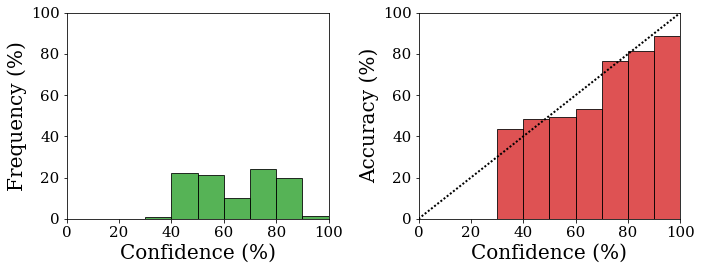

In [20]:
_ = tests.test_sampling(model, 10, 
                        dataset_test, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

10 Steps, Time: 36.693 ± 2.400 ms, NLL: 0.9394, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.061 %, 32.316 %, 42.941 %, Accs: 52.559 %, 51.983 %, 85.882 %, Uncs: 0.000 %, 31.700 %, 99.506 %, Covs: 100.000 %, 67.480 %, 1.660 %, ECE: 21.015 %
20 Steps, Time: 37.433 ± 3.423 ms, NLL: 1.0560, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.290 %, 26.711 %, 47.101 %, Accs: 55.723 %, 64.624 %, 94.203 %, Uncs: 0.000 %, 62.439 %, 99.735 %, Covs: 100.000 %, 47.012 %, 2.021 %, ECE: 10.493 %
30 Steps, Time: 37.600 ± 3.195 ms, NLL: 1.0256, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.693 %, 31.189 %, 47.849 %, Accs: 59.186 %, 69.089 %, 95.699 %, Uncs: 0.000 %, 72.244 %, 99.809 %, Covs: 100.000 %, 36.647 %, 1.816 %, ECE: 6.509 %
40 Steps, Time: 37.316 ± 2.825 ms, NLL: 0.9216, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.465 %, 27.361 %, 48.329 %, Accs: 63.564 %, 74.378 %, 96.657 %, Uncs: 0.000 %, 74.873 %, 99.839 %, Covs: 100.000 %, 35.732 %, 1.753 %, ECE: 6.416 %
50 Steps, Time: 37.885 ± 4.198 ms, NLL: 0.9729, Cutoff

360 Steps, Time: 38.233 ± 4.836 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.426 %, 22.436 %, 17.019 %, Accs: 64.099 %, 80.227 %, 84.367 %, Uncs: 0.000 %, 76.625 %, 99.341 %, Covs: 100.000 %, 42.442 %, 1.513 %, ECE: 3.780 %
370 Steps, Time: 38.216 ± 4.792 ms, NLL: 0.9389, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.586 %, 22.611 %, 17.062 %, Accs: 65.069 %, 81.427 %, 84.664 %, Uncs: 0.000 %, 76.625 %, 99.341 %, Covs: 100.000 %, 43.963 %, 1.501 %, ECE: 4.056 %
380 Steps, Time: 38.277 ± 4.904 ms, NLL: 0.9297, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.633 %, 22.562 %, 17.065 %, Accs: 65.344 %, 81.080 %, 84.691 %, Uncs: 0.000 %, 75.223 %, 99.353 %, Covs: 100.000 %, 45.383 %, 1.464 %, ECE: 4.091 %
390 Steps, Time: 38.249 ± 4.847 ms, NLL: 0.9338, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.506 %, 22.567 %, 17.066 %, Accs: 65.037 %, 80.730 %, 84.696 %, Uncs: 0.000 %, 75.131 %, 99.375 %, Covs: 100.000 %, 45.122 %, 1.427 %, ECE: 4.026 %
400 Steps, Time: 38.284 ± 4.903 ms, NLL: 0.9299, Cut

710 Steps, Time: 38.218 ± 5.567 ms, NLL: 0.9422, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.715 %, 21.474 %, 15.382 %, Accs: 62.772 %, 78.982 %, 87.273 %, Uncs: 0.000 %, 74.955 %, 99.415 %, Covs: 100.000 %, 44.359 %, 1.712 %, ECE: 3.595 %
720 Steps, Time: 38.196 ± 5.532 ms, NLL: 0.9424, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.559 %, 21.345 %, 15.354 %, Accs: 62.845 %, 79.183 %, 87.190 %, Uncs: 0.000 %, 75.085 %, 99.412 %, Covs: 100.000 %, 44.470 %, 1.707 %, ECE: 3.498 %
730 Steps, Time: 38.159 ± 5.568 ms, NLL: 0.9458, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.486 %, 21.227 %, 15.326 %, Accs: 62.628 %, 78.618 %, 86.989 %, Uncs: 0.000 %, 74.393 %, 99.408 %, Covs: 100.000 %, 44.756 %, 1.701 %, ECE: 3.610 %
740 Steps, Time: 38.162 ± 5.560 ms, NLL: 0.9432, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.468 %, 21.088 %, 15.243 %, Accs: 62.701 %, 78.693 %, 86.569 %, Uncs: 0.000 %, 74.459 %, 99.386 %, Covs: 100.000 %, 44.712 %, 1.704 %, ECE: 3.613 %
750 Steps, Time: 38.192 ± 5.593 ms, NLL: 0.9395, Cut

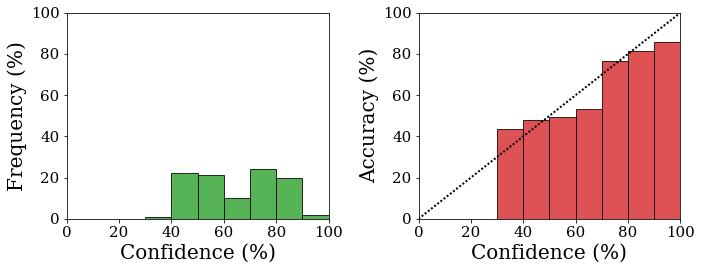

In [21]:
_ = tests.test_temporal_smoothing(model, 1.0, 
                                  dataset_seq, num_classes, batch_size=512, cutoffs=(0.0, 0.7, 0.9), verbose=True)

In [22]:
x_dims, y_dims = [input_dim], [num_classes]
och_x = OCH(k=10, l=1.3, s=1.0, dims=x_dims, hash_no=1)
och_y = OCH(k=10, l=1.3, s=1.0, dims=y_dims, hash_no=1)
vqbnn = VQBNN(lambda x: model(tf.stack([x[0]])), och_x=och_x, och_y=och_y, posterior=None)

_ = tests.test_vq(vqbnn, 
                  dataset_seq, num_classes, cutoffs=(0.0, 0.7, 0.9), verbose=True)

10 Steps, Time: 26.192 ± 1.972 ms, NLL: 0.4498, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 0.000 %, Accs: 100.000 %, 100.000 %, 0.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 90.000 %, 0.000 %, ECE: 31.207 %
20 Steps, Time: 26.998 ± 1.668 ms, NLL: 0.3392, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 0.000 %, Accs: 100.000 %, 100.000 %, 0.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 95.000 %, 0.000 %, ECE: 25.809 %
30 Steps, Time: 27.188 ± 1.529 ms, NLL: 0.2924, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 0.000 %, Accs: 100.000 %, 100.000 %, 0.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 96.667 %, 0.000 %, ECE: 23.211 %
40 Steps, Time: 27.332 ± 1.390 ms, NLL: 0.2701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 0.000 %, Accs: 100.000 %, 100.000 %, 0.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 97.500 %, 0.000 %, ECE: 22.003 %
50 Steps, Time: 27.643 ± 1.593 ms, NLL: 0.2589, Cutoffs: 0.0 %, 70.0 %, 90.0

370 Steps, Time: 27.779 ± 1.639 ms, NLL: 0.2353, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 0.000 %, Accs: 100.000 %, 100.000 %, 0.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 95.405 %, 0.000 %, ECE: 20.397 %
380 Steps, Time: 27.770 ± 1.619 ms, NLL: 0.2370, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 0.000 %, Accs: 100.000 %, 100.000 %, 0.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 95.526 %, 0.000 %, ECE: 20.544 %
390 Steps, Time: 27.760 ± 1.602 ms, NLL: 0.2339, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 100.000 %, Accs: 100.000 %, 100.000 %, 100.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 95.641 %, 1.282 %, ECE: 20.291 %
400 Steps, Time: 27.755 ± 1.586 ms, NLL: 0.2322, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 100.000 %, Accs: 100.000 %, 100.000 %, 100.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 95.750 %, 1.250 %, ECE: 20.173 %
410 Steps, Time: 27.766 ± 1.575 ms, NLL: 0.2317, Cutoffs: 0.0 %,

720 Steps, Time: 28.063 ± 1.806 ms, NLL: 0.2238, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 100.000 %, Accs: 100.000 %, 100.000 %, 100.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 97.639 %, 1.667 %, ECE: 19.697 %
730 Steps, Time: 28.065 ± 1.795 ms, NLL: 0.2242, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 100.000 %, Accs: 100.000 %, 100.000 %, 100.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 97.671 %, 1.644 %, ECE: 19.732 %
740 Steps, Time: 28.070 ± 1.785 ms, NLL: 0.2236, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 100.000 %, Accs: 100.000 %, 100.000 %, 100.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 97.703 %, 1.622 %, ECE: 19.685 %
750 Steps, Time: 28.080 ± 1.779 ms, NLL: 0.2233, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 100.000 %, 100.000 %, 100.000 %, Accs: 100.000 %, 100.000 %, 100.000 %, Uncs: nan %, nan %, nan %, Covs: 100.000 %, 97.733 %, 1.600 %, ECE: 19.665 %
760 Steps, Time: 28.086 ± 1.769 ms, NLL: 0.2233, Cutoffs

1070 Steps, Time: 28.713 ± 3.298 ms, NLL: 0.5072, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 40.841 %, 40.693 %, 100.000 %, Accs: 81.682 %, 81.387 %, 100.000 %, Uncs: 0.000 %, 0.000 %, 100.000 %, Covs: 100.000 %, 98.411 %, 1.121 %, ECE: 2.454 %
1080 Steps, Time: 28.716 ± 3.283 ms, NLL: 0.5184, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 40.463 %, 40.310 %, 100.000 %, Accs: 80.926 %, 80.621 %, 100.000 %, Uncs: 0.000 %, 0.000 %, 100.000 %, Covs: 100.000 %, 98.426 %, 1.111 %, ECE: 2.267 %
1090 Steps, Time: 28.720 ± 3.269 ms, NLL: 0.5324, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 40.092 %, 39.935 %, 100.000 %, Accs: 80.183 %, 79.870 %, 100.000 %, Uncs: 0.000 %, 0.000 %, 100.000 %, Covs: 100.000 %, 98.440 %, 1.101 %, ECE: 1.958 %
1100 Steps, Time: 28.726 ± 3.259 ms, NLL: 0.5450, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 39.727 %, 39.566 %, 100.000 %, Accs: 79.455 %, 79.132 %, 100.000 %, Uncs: 0.000 %, 0.000 %, 100.000 %, Covs: 100.000 %, 98.455 %, 1.091 %, ECE: 2.674 %
1110 Steps, Time: 28.728 ± 3.245 ms, NLL

1420 Steps, Time: 28.779 ± 2.908 ms, NLL: 0.8294, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 30.775 %, 30.872 %, 100.000 %, Accs: 61.549 %, 61.744 %, 100.000 %, Uncs: 0.000 %, 2.747 %, 100.000 %, Covs: 100.000 %, 97.746 %, 0.845 %, ECE: 19.843 %
1430 Steps, Time: 28.779 ± 2.899 ms, NLL: 0.8352, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 30.559 %, 30.651 %, 100.000 %, Accs: 61.119 %, 61.302 %, 100.000 %, Uncs: 0.000 %, 2.698 %, 100.000 %, Covs: 100.000 %, 97.762 %, 0.839 %, ECE: 20.267 %
1440 Steps, Time: 28.782 ± 2.892 ms, NLL: 0.8396, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 30.347 %, 30.433 %, 100.000 %, Accs: 60.694 %, 60.866 %, 100.000 %, Uncs: 0.000 %, 2.650 %, 100.000 %, Covs: 100.000 %, 97.778 %, 0.833 %, ECE: 20.660 %
1450 Steps, Time: 28.788 ± 2.887 ms, NLL: 0.8441, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 30.138 %, 30.219 %, 100.000 %, Accs: 60.276 %, 60.437 %, 100.000 %, Uncs: 0.000 %, 2.604 %, 100.000 %, Covs: 100.000 %, 97.793 %, 0.828 %, ECE: 21.049 %
1460 Steps, Time: 28.792 ± 2.878 ms,

1760 Steps, Time: 28.862 ± 2.777 ms, NLL: 1.0071, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.830 %, 24.913 %, 100.000 %, Accs: 49.659 %, 49.826 %, 100.000 %, Uncs: 0.000 %, 2.596 %, 100.000 %, Covs: 100.000 %, 97.727 %, 0.682 %, ECE: 31.364 %
1770 Steps, Time: 28.861 ± 2.770 ms, NLL: 1.0136, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.689 %, 24.769 %, 100.000 %, Accs: 49.379 %, 49.538 %, 100.000 %, Uncs: 0.000 %, 2.567 %, 100.000 %, Covs: 100.000 %, 97.740 %, 0.678 %, ECE: 31.669 %
1780 Steps, Time: 28.862 ± 2.763 ms, NLL: 1.0196, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.551 %, 24.626 %, 100.000 %, Accs: 49.101 %, 49.253 %, 100.000 %, Uncs: 0.000 %, 2.539 %, 100.000 %, Covs: 100.000 %, 97.753 %, 0.674 %, ECE: 31.973 %
1790 Steps, Time: 28.877 ± 2.805 ms, NLL: 1.0252, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.413 %, 24.486 %, 100.000 %, Accs: 48.827 %, 48.971 %, 100.000 %, Uncs: 0.000 %, 2.511 %, 100.000 %, Covs: 100.000 %, 97.765 %, 0.670 %, ECE: 32.261 %
1800 Steps, Time: 28.878 ± 2.798 ms,

2100 Steps, Time: 28.990 ± 2.872 ms, NLL: 1.1283, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.810 %, 20.801 %, 100.000 %, Accs: 41.619 %, 41.602 %, 100.000 %, Uncs: 0.000 %, 1.876 %, 100.000 %, Covs: 100.000 %, 98.095 %, 0.571 %, ECE: 39.366 %
2110 Steps, Time: 28.998 ± 2.883 ms, NLL: 1.1342, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.711 %, 20.700 %, 100.000 %, Accs: 41.422 %, 41.401 %, 100.000 %, Uncs: 0.000 %, 1.861 %, 100.000 %, Covs: 100.000 %, 98.104 %, 0.569 %, ECE: 39.599 %
2120 Steps, Time: 29.000 ± 2.877 ms, NLL: 1.1386, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.613 %, 20.601 %, 100.000 %, Accs: 41.226 %, 41.202 %, 100.000 %, Uncs: 0.000 %, 1.846 %, 100.000 %, Covs: 100.000 %, 98.113 %, 0.566 %, ECE: 39.814 %
2130 Steps, Time: 29.001 ± 2.871 ms, NLL: 1.1408, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.516 %, 20.502 %, 100.000 %, Accs: 41.033 %, 41.005 %, 100.000 %, Uncs: 0.000 %, 1.831 %, 100.000 %, Covs: 100.000 %, 98.122 %, 0.563 %, ECE: 40.002 %
2140 Steps, Time: 29.002 ± 2.865 ms,

2440 Steps, Time: 29.110 ± 2.913 ms, NLL: 1.2371, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 17.910 %, 17.974 %, 100.000 %, Accs: 35.820 %, 35.948 %, 100.000 %, Uncs: 0.000 %, 2.490 %, 100.000 %, Covs: 100.000 %, 97.705 %, 0.492 %, ECE: 45.065 %
2450 Steps, Time: 29.110 ± 2.907 ms, NLL: 1.2398, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 17.837 %, 17.899 %, 100.000 %, Accs: 35.673 %, 35.798 %, 100.000 %, Uncs: 0.000 %, 2.475 %, 100.000 %, Covs: 100.000 %, 97.714 %, 0.490 %, ECE: 45.221 %
2460 Steps, Time: 29.112 ± 2.902 ms, NLL: 1.2431, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 17.764 %, 17.824 %, 100.000 %, Accs: 35.528 %, 35.649 %, 100.000 %, Uncs: 0.000 %, 2.459 %, 100.000 %, Covs: 100.000 %, 97.724 %, 0.488 %, ECE: 45.360 %
2470 Steps, Time: 29.117 ± 2.902 ms, NLL: 1.2467, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 17.692 %, 17.751 %, 100.000 %, Accs: 35.385 %, 35.501 %, 100.000 %, Uncs: 0.000 %, 2.444 %, 100.000 %, Covs: 100.000 %, 97.733 %, 0.486 %, ECE: 45.504 %
2480 Steps, Time: 29.118 ± 2.897 ms,

2780 Steps, Time: 29.201 ± 4.388 ms, NLL: 1.1805, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.568 %, 19.659 %, 100.000 %, Accs: 39.137 %, 39.317 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 97.986 %, 0.791 %, ECE: 41.836 %
2790 Steps, Time: 29.200 ± 4.380 ms, NLL: 1.1772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.677 %, 19.770 %, 100.000 %, Accs: 39.355 %, 39.539 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 97.993 %, 0.789 %, ECE: 41.608 %
2800 Steps, Time: 29.203 ± 4.374 ms, NLL: 1.1739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.786 %, 19.880 %, 100.000 %, Accs: 39.571 %, 39.759 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 98.000 %, 0.786 %, ECE: 41.382 %
2810 Steps, Time: 29.226 ± 4.561 ms, NLL: 1.1707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.893 %, 19.989 %, 100.000 %, Accs: 39.786 %, 39.978 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 98.007 %, 0.783 %, ECE: 41.149 %
2820 Steps, Time: 29.225 ± 4.554 ms,

3120 Steps, Time: 29.287 ± 4.693 ms, NLL: 1.0762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.885 %, 23.025 %, 100.000 %, Accs: 45.769 %, 46.051 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 98.205 %, 0.737 %, ECE: 35.118 %
3130 Steps, Time: 29.287 ± 4.686 ms, NLL: 1.0733, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.971 %, 23.113 %, 100.000 %, Accs: 45.942 %, 46.226 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 98.211 %, 0.735 %, ECE: 34.957 %
3140 Steps, Time: 29.288 ± 4.679 ms, NLL: 1.0704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.057 %, 23.200 %, 100.000 %, Accs: 46.115 %, 46.401 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 98.217 %, 0.732 %, ECE: 34.791 %
3150 Steps, Time: 29.288 ± 4.672 ms, NLL: 1.0677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.143 %, 23.287 %, 100.000 %, Accs: 46.286 %, 46.574 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 98.222 %, 0.730 %, ECE: 34.620 %
3160 Steps, Time: 29.289 ± 4.665 ms,

3460 Steps, Time: 29.424 ± 5.030 ms, NLL: 0.9963, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 25.549 %, 25.446 %, 100.000 %, Accs: 51.098 %, 50.891 %, 100.000 %, Uncs: 0.000 %, 2.305 %, 100.000 %, Covs: 100.000 %, 97.283 %, 0.665 %, ECE: 30.247 %
3470 Steps, Time: 29.424 ± 5.023 ms, NLL: 0.9965, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 25.490 %, 25.446 %, 100.000 %, Accs: 50.980 %, 50.891 %, 100.000 %, Uncs: 0.000 %, 2.822 %, 100.000 %, Covs: 100.000 %, 97.003 %, 0.663 %, ECE: 30.137 %
3480 Steps, Time: 29.445 ± 5.160 ms, NLL: 0.9970, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 25.417 %, 25.446 %, 100.000 %, Accs: 50.833 %, 50.891 %, 100.000 %, Uncs: 0.000 %, 3.390 %, 100.000 %, Covs: 100.000 %, 96.724 %, 0.661 %, ECE: 30.232 %
3490 Steps, Time: 29.446 ± 5.153 ms, NLL: 0.9969, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 25.401 %, 25.446 %, 100.000 %, Accs: 50.802 %, 50.891 %, 100.000 %, Uncs: 0.000 %, 3.727 %, 100.000 %, Covs: 100.000 %, 96.447 %, 0.659 %, ECE: 30.251 %
3500 Steps, Time: 29.445 ± 5.146 ms,

3800 Steps, Time: 29.574 ± 5.627 ms, NLL: 0.9609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.671 %, 25.755 %, 100.000 %, Accs: 53.342 %, 51.511 %, 100.000 %, Uncs: 0.000 %, 6.768 %, 100.000 %, Covs: 100.000 %, 89.711 %, 0.868 %, ECE: 27.565 %
3810 Steps, Time: 29.593 ± 5.735 ms, NLL: 0.9593, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.732 %, 25.791 %, 100.000 %, Accs: 53.465 %, 51.582 %, 100.000 %, Uncs: 0.000 %, 6.768 %, 100.000 %, Covs: 100.000 %, 89.606 %, 0.866 %, ECE: 27.456 %
3820 Steps, Time: 29.594 ± 5.728 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.793 %, 25.805 %, 100.000 %, Accs: 53.586 %, 51.610 %, 100.000 %, Uncs: 0.000 %, 6.768 %, 100.000 %, Covs: 100.000 %, 89.424 %, 0.864 %, ECE: 27.447 %
3830 Steps, Time: 29.595 ± 5.721 ms, NLL: 0.9569, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.854 %, 25.805 %, 100.000 %, Accs: 53.708 %, 51.610 %, 100.000 %, Uncs: 0.000 %, 6.768 %, 100.000 %, Covs: 100.000 %, 89.191 %, 0.862 %, ECE: 27.491 %
3840 Steps, Time: 29.596 ± 5.714 ms,

4140 Steps, Time: 29.723 ± 6.056 ms, NLL: 0.9338, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.901 %, 25.939 %, 100.000 %, Accs: 54.348 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 12.540 %, 100.000 %, Covs: 100.000 %, 82.971 %, 0.797 %, ECE: 25.706 %
4150 Steps, Time: 29.738 ± 6.123 ms, NLL: 0.9325, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.533 %, 25.939 %, 100.000 %, Accs: 54.458 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 12.540 %, 100.000 %, Covs: 100.000 %, 82.771 %, 0.795 %, ECE: 25.725 %
4160 Steps, Time: 29.739 ± 6.116 ms, NLL: 0.9323, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.657 %, 25.939 %, 100.000 %, Accs: 54.375 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 12.908 %, 100.000 %, Covs: 100.000 %, 82.572 %, 0.793 %, ECE: 25.589 %
4170 Steps, Time: 29.739 ± 6.109 ms, NLL: 0.9323, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.444 %, 25.939 %, 100.000 %, Accs: 54.245 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 13.365 %, 100.000 %, Covs: 100.000 %, 82.374 %, 0.791 %, ECE: 25.402 %
4180 Steps, Time: 29.740 ± 6.102

4480 Steps, Time: 29.878 ± 6.528 ms, NLL: 0.9266, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.841 %, 25.939 %, 100.000 %, Accs: 52.701 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 21.992 %, 100.000 %, Covs: 100.000 %, 76.674 %, 0.737 %, ECE: 23.040 %
4490 Steps, Time: 29.879 ± 6.521 ms, NLL: 0.9264, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.657 %, 25.939 %, 100.000 %, Accs: 52.584 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 22.358 %, 100.000 %, Covs: 100.000 %, 76.503 %, 0.735 %, ECE: 23.084 %
4500 Steps, Time: 29.879 ± 6.514 ms, NLL: 0.9265, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.479 %, 25.939 %, 100.000 %, Accs: 52.467 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 22.721 %, 100.000 %, Covs: 100.000 %, 76.333 %, 0.733 %, ECE: 22.926 %
4510 Steps, Time: 29.895 ± 6.592 ms, NLL: 0.9264, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.306 %, 25.939 %, 100.000 %, Accs: 52.350 %, 51.878 %, 100.000 %, Uncs: 0.000 %, 23.081 %, 100.000 %, Covs: 100.000 %, 76.164 %, 0.732 %, ECE: 22.770 %
4520 Steps, Time: 29.895 ± 6.585

4820 Steps, Time: 30.054 ± 6.989 ms, NLL: 0.9443, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 25.952 %, 17.288 %, 100.000 %, Accs: 51.639 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 29.043 %, 100.000 %, Covs: 100.000 %, 71.286 %, 0.685 %, ECE: 21.673 %
4830 Steps, Time: 30.068 ± 7.057 ms, NLL: 0.9441, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 25.974 %, 17.288 %, 100.000 %, Accs: 51.615 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 29.226 %, 100.000 %, Covs: 100.000 %, 71.139 %, 0.683 %, ECE: 21.673 %
4840 Steps, Time: 30.069 ± 7.050 ms, NLL: 0.9432, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.242 %, 17.288 %, 100.000 %, Accs: 51.715 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 29.226 %, 100.000 %, Covs: 100.000 %, 70.992 %, 0.682 %, ECE: 21.544 %
4850 Steps, Time: 30.070 ± 7.043 ms, NLL: 0.9423, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.504 %, 17.288 %, 100.000 %, Accs: 51.814 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 29.226 %, 100.000 %, Covs: 100.000 %, 70.845 %, 0.680 %, ECE: 21.419 %
4860 Steps, Time: 30.069 ± 7.036

5160 Steps, Time: 30.206 ± 7.478 ms, NLL: 0.9294, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.664 %, 17.288 %, 100.000 %, Accs: 52.345 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 32.737 %, 100.000 %, Covs: 100.000 %, 66.589 %, 0.640 %, ECE: 20.576 %
5170 Steps, Time: 30.220 ± 7.537 ms, NLL: 0.9293, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.648 %, 17.288 %, 100.000 %, Accs: 52.321 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 32.901 %, 100.000 %, Covs: 100.000 %, 66.460 %, 0.638 %, ECE: 20.600 %
5180 Steps, Time: 30.219 ± 7.530 ms, NLL: 0.9286, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.816 %, 17.288 %, 100.000 %, Accs: 52.413 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 32.901 %, 100.000 %, Covs: 100.000 %, 66.332 %, 0.637 %, ECE: 20.644 %
5190 Steps, Time: 30.218 ± 7.523 ms, NLL: 0.9279, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.981 %, 17.288 %, 100.000 %, Accs: 52.505 %, 51.863 %, 100.000 %, Uncs: 0.000 %, 32.901 %, 100.000 %, Covs: 100.000 %, 66.204 %, 0.636 %, ECE: 20.686 %
5200 Steps, Time: 30.235 ± 7.581

5500 Steps, Time: 30.362 ± 7.935 ms, NLL: 0.9310, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.704 %, 17.283 %, 100.000 %, Accs: 52.055 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 37.239 %, 100.000 %, Covs: 100.000 %, 62.491 %, 0.600 %, ECE: 20.641 %
5510 Steps, Time: 30.379 ± 7.990 ms, NLL: 0.9306, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.725 %, 17.283 %, 100.000 %, Accs: 52.123 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 37.263 %, 100.000 %, Covs: 100.000 %, 62.377 %, 0.599 %, ECE: 20.510 %
5520 Steps, Time: 30.379 ± 7.983 ms, NLL: 0.9305, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.607 %, 17.283 %, 100.000 %, Accs: 52.029 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 37.500 %, 100.000 %, Covs: 100.000 %, 62.264 %, 0.598 %, ECE: 20.374 %
5530 Steps, Time: 30.379 ± 7.976 ms, NLL: 0.9301, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.567 %, 17.283 %, 100.000 %, Accs: 52.025 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 37.618 %, 100.000 %, Covs: 100.000 %, 62.152 %, 0.597 %, ECE: 20.331 %
5540 Steps, Time: 30.392 ± 8.026

5840 Steps, Time: 30.558 ± 8.443 ms, NLL: 0.9245, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.875 %, 17.283 %, 100.000 %, Accs: 51.182 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 41.950 %, 100.000 %, Covs: 100.000 %, 58.853 %, 0.565 %, ECE: 18.473 %
5850 Steps, Time: 30.558 ± 8.436 ms, NLL: 0.9242, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.910 %, 17.283 %, 100.000 %, Accs: 51.265 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 41.950 %, 100.000 %, Covs: 100.000 %, 58.752 %, 0.564 %, ECE: 18.352 %
5860 Steps, Time: 30.572 ± 8.483 ms, NLL: 0.9240, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.866 %, 17.283 %, 100.000 %, Accs: 51.246 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 42.072 %, 100.000 %, Covs: 100.000 %, 58.652 %, 0.563 %, ECE: 18.343 %
5870 Steps, Time: 30.571 ± 8.476 ms, NLL: 0.9238, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.901 %, 17.283 %, 100.000 %, Accs: 51.329 %, 51.848 %, 100.000 %, Uncs: 0.000 %, 42.072 %, 100.000 %, Covs: 100.000 %, 58.552 %, 0.562 %, ECE: 18.217 %
5880 Steps, Time: 30.573 ± 8.469

6180 Steps, Time: 30.717 ± 8.853 ms, NLL: 0.9128, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.922 %, 17.357 %, 100.000 %, Accs: 52.476 %, 52.071 %, 100.000 %, Uncs: 0.000 %, 43.650 %, 100.000 %, Covs: 100.000 %, 55.874 %, 0.534 %, ECE: 17.272 %
6190 Steps, Time: 30.716 ± 8.846 ms, NLL: 0.9125, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.953 %, 17.357 %, 100.000 %, Accs: 52.553 %, 52.071 %, 100.000 %, Uncs: 0.000 %, 43.650 %, 100.000 %, Covs: 100.000 %, 55.784 %, 0.533 %, ECE: 17.331 %
6200 Steps, Time: 30.727 ± 8.886 ms, NLL: 0.9123, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.973 %, 17.357 %, 100.000 %, Accs: 52.613 %, 52.071 %, 100.000 %, Uncs: 0.000 %, 43.669 %, 100.000 %, Covs: 100.000 %, 55.694 %, 0.532 %, ECE: 17.371 %
6210 Steps, Time: 30.727 ± 8.879 ms, NLL: 0.9120, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.884 %, 17.357 %, 100.000 %, Accs: 52.528 %, 52.071 %, 100.000 %, Uncs: 0.000 %, 43.860 %, 100.000 %, Covs: 100.000 %, 55.604 %, 0.531 %, ECE: 17.256 %
6220 Steps, Time: 30.738 ± 8.920

6520 Steps, Time: 30.886 ± 9.296 ms, NLL: 0.9005, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.124 %, 17.553 %, 100.000 %, Accs: 52.485 %, 52.660 %, 100.000 %, Uncs: 0.000 %, 46.578 %, 100.000 %, Covs: 100.000 %, 53.620 %, 0.859 %, ECE: 16.742 %
6530 Steps, Time: 30.897 ± 9.335 ms, NLL: 0.9003, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.089 %, 17.553 %, 100.000 %, Accs: 52.466 %, 52.660 %, 100.000 %, Uncs: 0.000 %, 46.682 %, 100.000 %, Covs: 100.000 %, 53.538 %, 0.858 %, ECE: 16.723 %
6540 Steps, Time: 30.897 ± 9.328 ms, NLL: 0.9003, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.012 %, 17.553 %, 100.000 %, Accs: 52.385 %, 52.660 %, 100.000 %, Uncs: 0.000 %, 46.853 %, 100.000 %, Covs: 100.000 %, 53.456 %, 0.856 %, ECE: 16.744 %
6550 Steps, Time: 30.908 ± 9.364 ms, NLL: 0.9000, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 25.977 %, 17.553 %, 100.000 %, Accs: 52.366 %, 52.660 %, 100.000 %, Uncs: 0.000 %, 46.955 %, 100.000 %, Covs: 100.000 %, 53.374 %, 0.855 %, ECE: 16.741 %
6560 Steps, Time: 30.908 ± 9.357

6860 Steps, Time: 31.080 ± 9.749 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.143 %, 17.776 %, 100.000 %, Accs: 53.513 %, 53.328 %, 100.000 %, Uncs: 0.000 %, 48.103 %, 100.000 %, Covs: 100.000 %, 51.691 %, 0.918 %, ECE: 16.056 %
6870 Steps, Time: 31.081 ± 9.742 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.170 %, 17.776 %, 100.000 %, Accs: 53.581 %, 53.328 %, 100.000 %, Uncs: 0.000 %, 48.103 %, 100.000 %, Covs: 100.000 %, 51.616 %, 0.917 %, ECE: 16.048 %
6880 Steps, Time: 31.091 ± 9.775 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.197 %, 17.785 %, 100.000 %, Accs: 53.648 %, 53.354 %, 100.000 %, Uncs: 0.000 %, 48.103 %, 100.000 %, Covs: 100.000 %, 51.570 %, 0.916 %, ECE: 16.008 %
6890 Steps, Time: 31.091 ± 9.768 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 26.224 %, 17.820 %, 100.000 %, Accs: 53.716 %, 53.459 %, 100.000 %, Uncs: 0.000 %, 48.103 %, 100.000 %, Covs: 100.000 %, 51.611 %, 0.914 %, ECE: 15.944 %
6900 Steps, Time: 31.101 ± 9.800

7200 Steps, Time: 31.339 ± 10.315 ms, NLL: 0.8592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.022 %, 18.804 %, 100.000 %, Accs: 55.708 %, 56.413 %, 100.000 %, Uncs: 0.000 %, 48.103 %, 100.000 %, Covs: 100.000 %, 52.736 %, 0.972 %, ECE: 14.509 %
7210 Steps, Time: 31.339 ± 10.308 ms, NLL: 0.8582, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.047 %, 18.842 %, 100.000 %, Accs: 55.770 %, 56.527 %, 100.000 %, Uncs: 0.000 %, 48.103 %, 100.000 %, Covs: 100.000 %, 52.802 %, 0.971 %, ECE: 14.468 %
7220 Steps, Time: 31.348 ± 10.336 ms, NLL: 0.8579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.061 %, 18.854 %, 100.000 %, Accs: 55.803 %, 56.562 %, 100.000 %, Uncs: 0.000 %, 48.135 %, 100.000 %, Covs: 100.000 %, 52.770 %, 0.970 %, ECE: 14.438 %
7230 Steps, Time: 31.348 ± 10.329 ms, NLL: 0.8579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.035 %, 18.854 %, 100.000 %, Accs: 55.726 %, 56.562 %, 100.000 %, Uncs: 0.000 %, 48.297 %, 100.000 %, Covs: 100.000 %, 52.697 %, 0.968 %, ECE: 14.358 %
7240 Steps, Time: 31.359 ± 1

7540 Steps, Time: 31.508 ± 10.688 ms, NLL: 0.8336, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.704 %, 19.809 %, 100.000 %, Accs: 57.401 %, 59.426 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 54.098 %, 0.928 %, ECE: 12.987 %
7550 Steps, Time: 31.507 ± 10.682 ms, NLL: 0.8328, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.726 %, 19.842 %, 100.000 %, Accs: 57.457 %, 59.526 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 54.159 %, 0.927 %, ECE: 12.942 %
7560 Steps, Time: 31.515 ± 10.700 ms, NLL: 0.8319, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.749 %, 19.875 %, 100.000 %, Accs: 57.513 %, 59.624 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 54.220 %, 0.926 %, ECE: 12.900 %
7570 Steps, Time: 31.515 ± 10.693 ms, NLL: 0.8312, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 27.771 %, 19.908 %, 100.000 %, Accs: 57.569 %, 59.723 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 54.280 %, 0.925 %, ECE: 12.854 %
7580 Steps, Time: 31.524 ± 1

7880 Steps, Time: 31.696 ± 11.084 ms, NLL: 0.8086, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.428 %, 20.718 %, 100.000 %, Accs: 59.239 %, 62.154 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 55.495 %, 1.003 %, ECE: 11.688 %
7890 Steps, Time: 31.705 ± 11.108 ms, NLL: 0.8078, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.448 %, 20.747 %, 100.000 %, Accs: 59.290 %, 62.240 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 55.551 %, 1.001 %, ECE: 11.654 %
7900 Steps, Time: 31.705 ± 11.101 ms, NLL: 0.8069, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.468 %, 20.775 %, 100.000 %, Accs: 59.342 %, 62.326 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 55.608 %, 1.000 %, ECE: 11.623 %
7910 Steps, Time: 31.714 ± 11.126 ms, NLL: 0.8062, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 28.489 %, 20.804 %, 100.000 %, Accs: 59.393 %, 62.412 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 55.664 %, 0.999 %, ECE: 11.587 %
7920 Steps, Time: 31.723 ± 1

8220 Steps, Time: 31.921 ± 11.538 ms, NLL: 0.7849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.087 %, 21.515 %, 100.000 %, Accs: 60.925 %, 64.546 %, 100.000 %, Uncs: 0.000 %, 48.474 %, 100.000 %, Covs: 100.000 %, 56.788 %, 1.241 %, ECE: 10.689 %
8230 Steps, Time: 31.923 ± 11.532 ms, NLL: 0.7848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.092 %, 21.518 %, 100.000 %, Accs: 60.936 %, 64.553 %, 100.000 %, Uncs: 0.000 %, 48.523 %, 100.000 %, Covs: 100.000 %, 56.731 %, 1.239 %, ECE: 10.694 %
8240 Steps, Time: 31.932 ± 11.554 ms, NLL: 0.7844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.098 %, 21.530 %, 100.000 %, Accs: 60.947 %, 64.591 %, 100.000 %, Uncs: 0.000 %, 48.571 %, 100.000 %, Covs: 100.000 %, 56.723 %, 1.238 %, ECE: 10.663 %
8250 Steps, Time: 31.932 ± 11.547 ms, NLL: 0.7837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.116 %, 21.556 %, 100.000 %, Accs: 60.994 %, 64.667 %, 100.000 %, Uncs: 0.000 %, 48.571 %, 100.000 %, Covs: 100.000 %, 56.776 %, 1.236 %, ECE: 10.630 %
8260 Steps, Time: 31.941 ± 1

8560 Steps, Time: 32.120 ± 11.922 ms, NLL: 0.7781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.513 %, 21.659 %, 100.000 %, Accs: 61.986 %, 64.978 %, 100.000 %, Uncs: 0.000 %, 49.017 %, 100.000 %, Covs: 100.000 %, 55.339 %, 1.192 %, ECE: 11.179 %
8570 Steps, Time: 32.128 ± 11.943 ms, NLL: 0.7778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.531 %, 21.659 %, 100.000 %, Accs: 62.030 %, 64.978 %, 100.000 %, Uncs: 0.000 %, 49.017 %, 100.000 %, Covs: 100.000 %, 55.274 %, 1.190 %, ECE: 11.217 %
8580 Steps, Time: 32.137 ± 11.963 ms, NLL: 0.7777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.548 %, 21.659 %, 100.000 %, Accs: 62.075 %, 64.978 %, 100.000 %, Uncs: 0.000 %, 49.017 %, 100.000 %, Covs: 100.000 %, 55.210 %, 1.189 %, ECE: 11.260 %
8590 Steps, Time: 32.136 ± 11.956 ms, NLL: 0.7775, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.565 %, 21.659 %, 100.000 %, Accs: 62.119 %, 64.978 %, 100.000 %, Uncs: 0.000 %, 49.017 %, 100.000 %, Covs: 100.000 %, 55.146 %, 1.187 %, ECE: 11.302 %
8600 Steps, Time: 32.145 ± 1

8900 Steps, Time: 32.321 ± 12.317 ms, NLL: 0.7760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.713 %, 21.659 %, 100.000 %, Accs: 62.640 %, 64.978 %, 100.000 %, Uncs: 0.000 %, 50.105 %, 100.000 %, Covs: 100.000 %, 53.225 %, 1.146 %, ECE: 11.839 %
8910 Steps, Time: 32.321 ± 12.311 ms, NLL: 0.7755, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.729 %, 21.674 %, 100.000 %, Accs: 62.682 %, 65.022 %, 100.000 %, Uncs: 0.000 %, 50.105 %, 100.000 %, Covs: 100.000 %, 53.232 %, 1.145 %, ECE: 11.821 %
8920 Steps, Time: 32.329 ± 12.329 ms, NLL: 0.7753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.746 %, 21.679 %, 100.000 %, Accs: 62.724 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 50.105 %, 100.000 %, Covs: 100.000 %, 53.195 %, 1.143 %, ECE: 11.845 %
8930 Steps, Time: 32.339 ± 12.348 ms, NLL: 0.7752, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 29.762 %, 21.679 %, 100.000 %, Accs: 62.766 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 50.105 %, 100.000 %, Covs: 100.000 %, 53.135 %, 1.142 %, ECE: 11.888 %
8940 Steps, Time: 32.339 ± 1

9240 Steps, Time: 32.524 ± 12.696 ms, NLL: 0.7856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.243 %, 21.679 %, 100.000 %, Accs: 62.381 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 52.273 %, 100.000 %, Covs: 100.000 %, 51.353 %, 1.104 %, ECE: 11.553 %
9250 Steps, Time: 32.531 ± 12.713 ms, NLL: 0.7864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.226 %, 21.679 %, 100.000 %, Accs: 62.314 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 52.410 %, 100.000 %, Covs: 100.000 %, 51.297 %, 1.103 %, ECE: 11.487 %
9260 Steps, Time: 32.538 ± 12.713 ms, NLL: 0.7866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.208 %, 21.679 %, 100.000 %, Accs: 62.246 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 52.546 %, 100.000 %, Covs: 100.000 %, 51.242 %, 1.102 %, ECE: 11.421 %
9270 Steps, Time: 32.550 ± 12.735 ms, NLL: 0.7868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.191 %, 21.679 %, 100.000 %, Accs: 62.179 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 52.681 %, 100.000 %, Covs: 100.000 %, 51.187 %, 1.100 %, ECE: 11.355 %
9280 Steps, Time: 32.560 ± 1

9580 Steps, Time: 32.734 ± 13.041 ms, NLL: 0.8470, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.876 %, 21.679 %, 100.000 %, Accs: 60.209 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 56.480 %, 100.000 %, Covs: 100.000 %, 49.530 %, 1.065 %, ECE: 9.555 %
9590 Steps, Time: 32.741 ± 13.052 ms, NLL: 0.8489, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.865 %, 21.679 %, 100.000 %, Accs: 60.146 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 56.593 %, 100.000 %, Covs: 100.000 %, 49.479 %, 1.064 %, ECE: 9.509 %
9600 Steps, Time: 32.749 ± 13.067 ms, NLL: 0.8532, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.862 %, 21.679 %, 100.000 %, Accs: 60.083 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 56.707 %, 100.000 %, Covs: 100.000 %, 49.427 %, 1.062 %, ECE: 9.532 %
9610 Steps, Time: 32.756 ± 13.082 ms, NLL: 0.8572, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.848 %, 21.679 %, 100.000 %, Accs: 60.021 %, 65.037 %, 100.000 %, Uncs: 0.000 %, 56.819 %, 100.000 %, Covs: 100.000 %, 49.376 %, 1.061 %, ECE: 9.483 %
9620 Steps, Time: 32.755 ± 13.07

9920 Steps, Time: 32.948 ± 13.426 ms, NLL: 0.9394, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.773 %, 16.232 %, 100.000 %, Accs: 58.286 %, 64.927 %, 100.000 %, Uncs: 0.000 %, 59.715 %, 100.000 %, Covs: 100.000 %, 47.913 %, 1.028 %, ECE: 8.789 %
9930 Steps, Time: 32.955 ± 13.440 ms, NLL: 0.9444, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.752 %, 16.198 %, 100.000 %, Accs: 58.228 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 59.571 %, 100.000 %, Covs: 100.000 %, 47.966 %, 1.027 %, ECE: 8.854 %
9940 Steps, Time: 32.962 ± 13.454 ms, NLL: 0.9480, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.732 %, 16.198 %, 100.000 %, Accs: 58.169 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 59.668 %, 100.000 %, Covs: 100.000 %, 47.918 %, 1.026 %, ECE: 8.884 %
9950 Steps, Time: 32.962 ± 13.447 ms, NLL: 0.9484, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.711 %, 16.198 %, 100.000 %, Accs: 58.111 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 59.765 %, 100.000 %, Covs: 100.000 %, 47.869 %, 1.025 %, ECE: 8.923 %
9960 Steps, Time: 32.975 ± 13.46

10260 Steps, Time: 33.158 ± 13.772 ms, NLL: 1.0302, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.170 %, 16.198 %, 100.000 %, Accs: 56.355 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 62.550 %, 100.000 %, Covs: 100.000 %, 46.423 %, 0.994 %, ECE: 10.019 %
10270 Steps, Time: 33.165 ± 13.787 ms, NLL: 1.0368, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.163 %, 16.198 %, 100.000 %, Accs: 56.300 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 62.634 %, 100.000 %, Covs: 100.000 %, 46.378 %, 0.993 %, ECE: 10.053 %
10280 Steps, Time: 33.172 ± 13.800 ms, NLL: 1.0386, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.146 %, 16.198 %, 100.000 %, Accs: 56.245 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 62.717 %, 100.000 %, Covs: 100.000 %, 46.333 %, 0.992 %, ECE: 10.087 %
10290 Steps, Time: 33.180 ± 13.813 ms, NLL: 1.0404, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.129 %, 16.198 %, 100.000 %, Accs: 56.190 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 62.799 %, 100.000 %, Covs: 100.000 %, 46.288 %, 0.991 %, ECE: 10.122 %
10300 Steps, Time: 33.18

10600 Steps, Time: 33.389 ± 14.178 ms, NLL: 1.1074, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.652 %, 16.198 %, 100.000 %, Accs: 54.547 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 65.193 %, 100.000 %, Covs: 100.000 %, 44.934 %, 0.962 %, ECE: 11.147 %
10610 Steps, Time: 33.395 ± 14.191 ms, NLL: 1.1086, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.637 %, 16.198 %, 100.000 %, Accs: 54.496 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 65.265 %, 100.000 %, Covs: 100.000 %, 44.892 %, 0.961 %, ECE: 11.180 %
10620 Steps, Time: 33.402 ± 14.202 ms, NLL: 1.1095, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.633 %, 16.198 %, 100.000 %, Accs: 54.482 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 65.308 %, 100.000 %, Covs: 100.000 %, 44.849 %, 0.960 %, ECE: 11.175 %
10630 Steps, Time: 33.409 ± 14.214 ms, NLL: 1.1091, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.645 %, 16.198 %, 100.000 %, Accs: 54.525 %, 64.791 %, 100.000 %, Uncs: 0.000 %, 65.308 %, 100.000 %, Covs: 100.000 %, 44.807 %, 0.960 %, ECE: 11.117 %
10640 Steps, Time: 33.41

10940 Steps, Time: 33.605 ± 14.536 ms, NLL: 1.0981, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.908 %, 16.209 %, 100.000 %, Accs: 55.567 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.501 %, 100.000 %, Covs: 100.000 %, 43.592 %, 0.932 %, ECE: 9.778 %
10950 Steps, Time: 33.612 ± 14.547 ms, NLL: 1.0977, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.920 %, 16.209 %, 100.000 %, Accs: 55.607 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.501 %, 100.000 %, Covs: 100.000 %, 43.553 %, 0.932 %, ECE: 9.724 %
10960 Steps, Time: 33.619 ± 14.558 ms, NLL: 1.0973, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.931 %, 16.209 %, 100.000 %, Accs: 55.648 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.501 %, 100.000 %, Covs: 100.000 %, 43.513 %, 0.931 %, ECE: 9.670 %
10970 Steps, Time: 33.625 ± 14.569 ms, NLL: 1.0969, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.942 %, 16.209 %, 100.000 %, Accs: 55.688 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.501 %, 100.000 %, Covs: 100.000 %, 43.473 %, 0.930 %, ECE: 9.615 %
10980 Steps, Time: 33.632 ± 

11280 Steps, Time: 33.819 ± 14.885 ms, NLL: 1.0864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.232 %, 16.209 %, 100.000 %, Accs: 56.720 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.649 %, 100.000 %, Covs: 100.000 %, 42.278 %, 0.904 %, ECE: 8.419 %
11290 Steps, Time: 33.825 ± 14.896 ms, NLL: 1.0860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.243 %, 16.209 %, 100.000 %, Accs: 56.758 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.649 %, 100.000 %, Covs: 100.000 %, 42.241 %, 0.903 %, ECE: 8.371 %
11300 Steps, Time: 33.832 ± 14.906 ms, NLL: 1.0857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.254 %, 16.209 %, 100.000 %, Accs: 56.796 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.649 %, 100.000 %, Covs: 100.000 %, 42.204 %, 0.903 %, ECE: 8.365 %
11310 Steps, Time: 33.838 ± 14.917 ms, NLL: 1.0854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.264 %, 16.209 %, 100.000 %, Accs: 56.835 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 65.649 %, 100.000 %, Covs: 100.000 %, 42.166 %, 0.902 %, ECE: 8.406 %
11320 Steps, Time: 33.844 ± 

11620 Steps, Time: 34.044 ± 15.245 ms, NLL: 1.0771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.271 %, 16.209 %, 100.000 %, Accs: 57.315 %, 64.835 %, 100.000 %, Uncs: 0.000 %, 66.190 %, 100.000 %, Covs: 100.000 %, 41.041 %, 0.878 %, ECE: 8.863 %
11630 Steps, Time: 34.050 ± 15.254 ms, NLL: 1.0765, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.281 %, 16.214 %, 100.000 %, Accs: 57.352 %, 64.858 %, 100.000 %, Uncs: 0.000 %, 66.190 %, 100.000 %, Covs: 100.000 %, 41.032 %, 0.877 %, ECE: 8.868 %
11640 Steps, Time: 34.056 ± 15.263 ms, NLL: 1.0762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.291 %, 16.214 %, 100.000 %, Accs: 57.388 %, 64.858 %, 100.000 %, Uncs: 0.000 %, 66.190 %, 100.000 %, Covs: 100.000 %, 40.997 %, 0.876 %, ECE: 8.894 %
11650 Steps, Time: 34.062 ± 15.273 ms, NLL: 1.0760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.302 %, 16.214 %, 100.000 %, Accs: 57.425 %, 64.858 %, 100.000 %, Uncs: 0.000 %, 66.190 %, 100.000 %, Covs: 100.000 %, 40.961 %, 0.876 %, ECE: 8.934 %
11660 Steps, Time: 34.070 ± 

11960 Steps, Time: 34.266 ± 15.586 ms, NLL: 1.0670, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.467 %, 16.229 %, 100.000 %, Accs: 58.169 %, 64.916 %, 100.000 %, Uncs: 0.000 %, 66.480 %, 100.000 %, Covs: 100.000 %, 39.967 %, 0.853 %, ECE: 9.013 %
11970 Steps, Time: 34.273 ± 15.595 ms, NLL: 1.0668, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.423 %, 16.229 %, 100.000 %, Accs: 58.120 %, 64.916 %, 100.000 %, Uncs: 0.000 %, 66.547 %, 100.000 %, Covs: 100.000 %, 39.933 %, 0.852 %, ECE: 9.051 %
11980 Steps, Time: 34.278 ± 15.604 ms, NLL: 1.0667, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.395 %, 16.229 %, 100.000 %, Accs: 58.097 %, 64.916 %, 100.000 %, Uncs: 0.000 %, 66.594 %, 100.000 %, Covs: 100.000 %, 39.900 %, 0.851 %, ECE: 9.081 %
11990 Steps, Time: 34.285 ± 15.615 ms, NLL: 1.0664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.405 %, 16.229 %, 100.000 %, Accs: 58.132 %, 64.916 %, 100.000 %, Uncs: 0.000 %, 66.594 %, 100.000 %, Covs: 100.000 %, 39.867 %, 0.851 %, ECE: 9.119 %
12000 Steps, Time: 34.291 ± 

12300 Steps, Time: 34.483 ± 15.912 ms, NLL: 1.0539, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.644 %, 16.368 %, 100.000 %, Accs: 58.992 %, 65.473 %, 100.000 %, Uncs: 0.000 %, 66.753 %, 100.000 %, Covs: 100.000 %, 39.488 %, 0.829 %, ECE: 8.965 %
12310 Steps, Time: 34.489 ± 15.921 ms, NLL: 1.0533, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.653 %, 16.375 %, 100.000 %, Accs: 59.025 %, 65.501 %, 100.000 %, Uncs: 0.000 %, 66.753 %, 100.000 %, Covs: 100.000 %, 39.488 %, 0.829 %, ECE: 8.956 %
12320 Steps, Time: 34.495 ± 15.930 ms, NLL: 1.0528, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.663 %, 16.386 %, 100.000 %, Accs: 59.058 %, 65.543 %, 100.000 %, Uncs: 0.000 %, 66.753 %, 100.000 %, Covs: 100.000 %, 39.505 %, 0.828 %, ECE: 8.938 %
12330 Steps, Time: 34.507 ± 15.953 ms, NLL: 1.0522, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.672 %, 16.396 %, 100.000 %, Accs: 59.092 %, 65.586 %, 100.000 %, Uncs: 0.000 %, 66.753 %, 100.000 %, Covs: 100.000 %, 39.521 %, 0.827 %, ECE: 8.912 %
12340 Steps, Time: 34.513 ± 

12640 Steps, Time: 34.729 ± 16.293 ms, NLL: 1.0323, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 16.824 %, 100.000 %, Accs: 60.071 %, 67.297 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 40.570 %, 1.305 %, ECE: 8.468 %
12650 Steps, Time: 34.735 ± 16.303 ms, NLL: 1.0316, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.941 %, 16.840 %, 100.000 %, Accs: 60.103 %, 67.361 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 40.617 %, 1.304 %, ECE: 8.451 %
12660 Steps, Time: 34.741 ± 16.311 ms, NLL: 1.0309, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.950 %, 16.856 %, 100.000 %, Accs: 60.134 %, 67.424 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 40.664 %, 1.303 %, ECE: 8.432 %
12670 Steps, Time: 34.747 ± 16.318 ms, NLL: 1.0303, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.959 %, 16.872 %, 100.000 %, Accs: 60.166 %, 67.487 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 40.710 %, 1.302 %, ECE: 8.411 %
12680 Steps, Time: 34.755 ± 

12980 Steps, Time: 34.958 ± 16.647 ms, NLL: 1.0137, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.220 %, 17.197 %, 100.000 %, Accs: 61.117 %, 68.788 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 41.394 %, 1.271 %, ECE: 7.925 %
12990 Steps, Time: 34.964 ± 16.655 ms, NLL: 1.0131, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.228 %, 17.212 %, 100.000 %, Accs: 61.147 %, 68.846 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 41.440 %, 1.270 %, ECE: 7.903 %
13000 Steps, Time: 34.969 ± 16.662 ms, NLL: 1.0125, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.236 %, 17.226 %, 100.000 %, Accs: 61.177 %, 68.904 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 41.485 %, 1.269 %, ECE: 7.881 %
13010 Steps, Time: 34.975 ± 16.671 ms, NLL: 1.0118, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.244 %, 17.240 %, 100.000 %, Accs: 61.207 %, 68.962 %, 100.000 %, Uncs: 0.000 %, 66.772 %, 100.000 %, Covs: 100.000 %, 41.530 %, 1.268 %, ECE: 7.865 %
13020 Steps, Time: 34.986 ± 

13320 Steps, Time: 35.180 ± 16.977 ms, NLL: 1.0033, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.339 %, 17.293 %, 100.000 %, Accs: 61.539 %, 69.173 %, 100.000 %, Uncs: 0.000 %, 67.265 %, 100.000 %, Covs: 100.000 %, 40.841 %, 1.239 %, ECE: 7.793 %
13330 Steps, Time: 35.186 ± 16.984 ms, NLL: 1.0030, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.337 %, 17.297 %, 100.000 %, Accs: 61.530 %, 69.190 %, 100.000 %, Uncs: 0.000 %, 67.297 %, 100.000 %, Covs: 100.000 %, 40.833 %, 1.238 %, ECE: 7.807 %
13340 Steps, Time: 35.191 ± 16.990 ms, NLL: 1.0026, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.345 %, 17.299 %, 100.000 %, Accs: 61.559 %, 69.195 %, 100.000 %, Uncs: 0.000 %, 67.297 %, 100.000 %, Covs: 100.000 %, 40.810 %, 1.237 %, ECE: 7.821 %
13350 Steps, Time: 35.197 ± 16.999 ms, NLL: 1.0021, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.351 %, 17.307 %, 100.000 %, Accs: 61.581 %, 69.229 %, 100.000 %, Uncs: 0.000 %, 67.304 %, 100.000 %, Covs: 100.000 %, 40.824 %, 1.236 %, ECE: 7.809 %
13360 Steps, Time: 35.208 ± 

13660 Steps, Time: 35.412 ± 17.322 ms, NLL: 0.9954, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.381 %, 17.326 %, 100.000 %, Accs: 61.764 %, 69.303 %, 100.000 %, Uncs: 0.000 %, 67.892 %, 100.000 %, Covs: 100.000 %, 39.993 %, 1.208 %, ECE: 7.682 %
13670 Steps, Time: 35.421 ± 17.331 ms, NLL: 0.9953, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.369 %, 17.326 %, 100.000 %, Accs: 61.719 %, 69.303 %, 100.000 %, Uncs: 0.000 %, 67.953 %, 100.000 %, Covs: 100.000 %, 39.963 %, 1.207 %, ECE: 7.664 %
13680 Steps, Time: 35.428 ± 17.338 ms, NLL: 0.9951, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.371 %, 17.326 %, 100.000 %, Accs: 61.725 %, 69.303 %, 100.000 %, Uncs: 0.000 %, 67.972 %, 100.000 %, Covs: 100.000 %, 39.934 %, 1.206 %, ECE: 7.675 %
13690 Steps, Time: 35.434 ± 17.345 ms, NLL: 0.9949, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.378 %, 17.326 %, 100.000 %, Accs: 61.753 %, 69.303 %, 100.000 %, Uncs: 0.000 %, 67.972 %, 100.000 %, Covs: 100.000 %, 39.905 %, 1.205 %, ECE: 7.693 %
13700 Steps, Time: 35.439 ± 

14000 Steps, Time: 35.639 ± 17.645 ms, NLL: 0.9973, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.351 %, 13.815 %, 100.000 %, Accs: 61.229 %, 69.075 %, 100.000 %, Uncs: 0.000 %, 68.773 %, 100.000 %, Covs: 100.000 %, 39.150 %, 1.179 %, ECE: 7.477 %
14010 Steps, Time: 35.644 ± 17.651 ms, NLL: 0.9972, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.420 %, 13.815 %, 100.000 %, Accs: 61.213 %, 69.075 %, 100.000 %, Uncs: 0.000 %, 68.808 %, 100.000 %, Covs: 100.000 %, 39.122 %, 1.178 %, ECE: 7.454 %
14020 Steps, Time: 35.649 ± 17.657 ms, NLL: 0.9968, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.695 %, 13.815 %, 100.000 %, Accs: 61.241 %, 69.075 %, 100.000 %, Uncs: 0.000 %, 68.808 %, 100.000 %, Covs: 100.000 %, 39.094 %, 1.177 %, ECE: 7.472 %
14030 Steps, Time: 35.660 ± 17.675 ms, NLL: 0.9964, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.926 %, 13.815 %, 100.000 %, Accs: 61.262 %, 69.075 %, 100.000 %, Uncs: 0.000 %, 68.813 %, 100.000 %, Covs: 100.000 %, 39.066 %, 1.176 %, ECE: 7.481 %
14040 Steps, Time: 35.665 ± 

14340 Steps, Time: 35.857 ± 17.959 ms, NLL: 0.9938, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.796 %, 18.163 %, 100.000 %, Accs: 61.032 %, 69.103 %, 100.000 %, Uncs: 0.000 %, 69.667 %, 100.000 %, Covs: 100.000 %, 38.257 %, 1.151 %, ECE: 7.102 %
14350 Steps, Time: 35.868 ± 17.977 ms, NLL: 0.9936, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.855 %, 18.163 %, 100.000 %, Accs: 61.031 %, 69.103 %, 100.000 %, Uncs: 0.000 %, 69.689 %, 100.000 %, Covs: 100.000 %, 38.230 %, 1.150 %, ECE: 7.104 %
14360 Steps, Time: 35.873 ± 17.983 ms, NLL: 0.9935, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.002 %, 18.163 %, 100.000 %, Accs: 61.058 %, 69.103 %, 100.000 %, Uncs: 0.000 %, 69.689 %, 100.000 %, Covs: 100.000 %, 38.203 %, 1.149 %, ECE: 7.135 %
14370 Steps, Time: 35.877 ± 17.988 ms, NLL: 0.9933, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.146 %, 18.163 %, 100.000 %, Accs: 61.086 %, 69.103 %, 100.000 %, Uncs: 0.000 %, 69.689 %, 100.000 %, Covs: 100.000 %, 38.177 %, 1.148 %, ECE: 7.166 %
14380 Steps, Time: 35.882 ± 

14680 Steps, Time: 36.079 ± 18.276 ms, NLL: 0.9953, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.812 %, 18.815 %, 100.000 %, Accs: 60.436 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 70.816 %, 100.000 %, Covs: 100.000 %, 37.377 %, 1.124 %, ECE: 6.635 %
14690 Steps, Time: 36.084 ± 18.285 ms, NLL: 0.9953, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.752 %, 18.815 %, 100.000 %, Accs: 60.395 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 70.866 %, 100.000 %, Covs: 100.000 %, 37.352 %, 1.123 %, ECE: 6.593 %
14700 Steps, Time: 36.099 ± 18.304 ms, NLL: 0.9953, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.693 %, 18.815 %, 100.000 %, Accs: 60.354 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 70.916 %, 100.000 %, Covs: 100.000 %, 37.327 %, 1.122 %, ECE: 6.549 %
14710 Steps, Time: 36.104 ± 18.310 ms, NLL: 0.9953, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.635 %, 18.815 %, 100.000 %, Accs: 60.313 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 70.966 %, 100.000 %, Covs: 100.000 %, 37.301 %, 1.122 %, ECE: 6.576 %
14720 Steps, Time: 36.110 ± 

15020 Steps, Time: 36.327 ± 18.612 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.868 %, 18.815 %, 100.000 %, Accs: 59.933 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 71.834 %, 100.000 %, Covs: 100.000 %, 36.531 %, 1.099 %, ECE: 6.345 %
15030 Steps, Time: 36.331 ± 18.616 ms, NLL: 0.9960, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.818 %, 18.815 %, 100.000 %, Accs: 59.894 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 71.881 %, 100.000 %, Covs: 100.000 %, 36.507 %, 1.098 %, ECE: 6.311 %
15040 Steps, Time: 36.341 ± 18.632 ms, NLL: 0.9960, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.795 %, 18.815 %, 100.000 %, Accs: 59.867 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 71.918 %, 100.000 %, Covs: 100.000 %, 36.483 %, 1.097 %, ECE: 6.302 %
15050 Steps, Time: 36.346 ± 18.637 ms, NLL: 0.9959, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.877 %, 18.815 %, 100.000 %, Accs: 59.894 %, 69.109 %, 100.000 %, Uncs: 0.000 %, 71.918 %, 100.000 %, Covs: 100.000 %, 36.458 %, 1.096 %, ECE: 6.333 %
15060 Steps, Time: 36.351 ± 

15360 Steps, Time: 36.552 ± 18.918 ms, NLL: 0.9916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.866 %, 19.969 %, 100.000 %, Accs: 60.163 %, 69.120 %, 100.000 %, Uncs: 0.000 %, 72.299 %, 100.000 %, Covs: 100.000 %, 35.736 %, 1.074 %, ECE: 6.528 %
15370 Steps, Time: 36.556 ± 18.923 ms, NLL: 0.9920, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.817 %, 18.234 %, 100.000 %, Accs: 60.124 %, 68.994 %, 100.000 %, Uncs: 0.000 %, 72.181 %, 100.000 %, Covs: 100.000 %, 35.777 %, 1.074 %, ECE: 6.575 %
15380 Steps, Time: 36.566 ± 18.939 ms, NLL: 0.9924, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.768 %, 17.323 %, 100.000 %, Accs: 60.085 %, 68.882 %, 100.000 %, Uncs: 0.000 %, 72.080 %, 100.000 %, Covs: 100.000 %, 35.813 %, 1.073 %, ECE: 6.614 %
15390 Steps, Time: 36.570 ± 18.943 ms, NLL: 0.9923, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.764 %, 17.323 %, 100.000 %, Accs: 60.097 %, 68.882 %, 100.000 %, Uncs: 0.000 %, 72.089 %, 100.000 %, Covs: 100.000 %, 35.789 %, 1.072 %, ECE: 6.631 %
15400 Steps, Time: 36.575 ± 

15700 Steps, Time: 36.771 ± 19.212 ms, NLL: 0.9882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.630 %, 17.333 %, 100.000 %, Accs: 60.465 %, 68.932 %, 100.000 %, Uncs: 0.000 %, 72.386 %, 100.000 %, Covs: 100.000 %, 35.140 %, 1.051 %, ECE: 7.081 %
15710 Steps, Time: 36.780 ± 19.226 ms, NLL: 0.9877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.636 %, 17.341 %, 100.000 %, Accs: 60.490 %, 68.972 %, 100.000 %, Uncs: 0.000 %, 72.386 %, 100.000 %, Covs: 100.000 %, 35.162 %, 1.050 %, ECE: 7.077 %
15720 Steps, Time: 36.785 ± 19.231 ms, NLL: 0.9875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.642 %, 17.341 %, 100.000 %, Accs: 60.515 %, 68.972 %, 100.000 %, Uncs: 0.000 %, 72.386 %, 100.000 %, Covs: 100.000 %, 35.140 %, 1.050 %, ECE: 7.105 %
15730 Steps, Time: 36.797 ± 19.251 ms, NLL: 0.9874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.648 %, 17.341 %, 100.000 %, Accs: 60.540 %, 68.972 %, 100.000 %, Uncs: 0.000 %, 72.386 %, 100.000 %, Covs: 100.000 %, 35.118 %, 1.049 %, ECE: 7.133 %
15740 Steps, Time: 36.802 ± 

16040 Steps, Time: 37.006 ± 19.528 ms, NLL: 0.9855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.915 %, 16.669 %, 100.000 %, Accs: 60.131 %, 68.847 %, 100.000 %, Uncs: 0.000 %, 73.041 %, 100.000 %, Covs: 100.000 %, 34.501 %, 1.029 %, ECE: 6.956 %
16050 Steps, Time: 37.010 ± 19.532 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.917 %, 16.669 %, 100.000 %, Accs: 60.150 %, 68.847 %, 100.000 %, Uncs: 0.000 %, 73.046 %, 100.000 %, Covs: 100.000 %, 34.480 %, 1.028 %, ECE: 6.978 %
16060 Steps, Time: 37.019 ± 19.545 ms, NLL: 0.9852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.923 %, 16.669 %, 100.000 %, Accs: 60.174 %, 68.847 %, 100.000 %, Uncs: 0.000 %, 73.046 %, 100.000 %, Covs: 100.000 %, 34.458 %, 1.027 %, ECE: 7.006 %
16070 Steps, Time: 37.023 ± 19.549 ms, NLL: 0.9850, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.919 %, 16.669 %, 100.000 %, Accs: 60.187 %, 68.847 %, 100.000 %, Uncs: 0.000 %, 73.054 %, 100.000 %, Covs: 100.000 %, 34.437 %, 1.027 %, ECE: 7.027 %
16080 Steps, Time: 37.032 ± 

16380 Steps, Time: 37.230 ± 19.828 ms, NLL: 0.9779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.794 %, 16.424 %, 100.000 %, Accs: 60.513 %, 69.259 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 34.377 %, 1.007 %, ECE: 6.993 %
16390 Steps, Time: 37.234 ± 19.831 ms, NLL: 0.9776, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.800 %, 16.427 %, 100.000 %, Accs: 60.537 %, 69.276 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 34.375 %, 1.007 %, ECE: 6.971 %
16400 Steps, Time: 37.243 ± 19.845 ms, NLL: 0.9771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.805 %, 16.438 %, 100.000 %, Accs: 60.561 %, 69.330 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 34.415 %, 1.006 %, ECE: 6.956 %
16410 Steps, Time: 37.247 ± 19.849 ms, NLL: 0.9766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.811 %, 16.449 %, 100.000 %, Accs: 60.585 %, 69.385 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 34.455 %, 1.005 %, ECE: 6.942 %
16420 Steps, Time: 37.256 ± 

16720 Steps, Time: 37.451 ± 20.123 ms, NLL: 0.9626, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.984 %, 16.733 %, 100.000 %, Accs: 61.316 %, 70.800 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 35.455 %, 1.094 %, ECE: 6.567 %
16730 Steps, Time: 37.455 ± 20.126 ms, NLL: 0.9621, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.989 %, 16.743 %, 100.000 %, Accs: 61.339 %, 70.849 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 35.493 %, 1.154 %, ECE: 6.567 %
16740 Steps, Time: 37.463 ± 20.139 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.995 %, 16.752 %, 100.000 %, Accs: 61.362 %, 70.898 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 35.532 %, 1.183 %, ECE: 6.560 %
16750 Steps, Time: 37.468 ± 20.144 ms, NLL: 0.9612, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.000 %, 16.762 %, 100.000 %, Accs: 61.385 %, 70.947 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 35.570 %, 1.182 %, ECE: 6.545 %
16760 Steps, Time: 37.481 ± 

17060 Steps, Time: 37.687 ± 20.423 ms, NLL: 0.9482, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.165 %, 17.017 %, 100.000 %, Accs: 62.087 %, 72.220 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 36.524 %, 1.161 %, ECE: 6.167 %
17070 Steps, Time: 37.696 ± 20.436 ms, NLL: 0.9478, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.170 %, 17.026 %, 100.000 %, Accs: 62.109 %, 72.264 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 36.561 %, 1.160 %, ECE: 6.153 %
17080 Steps, Time: 37.700 ± 20.438 ms, NLL: 0.9473, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.176 %, 17.035 %, 100.000 %, Accs: 62.131 %, 72.308 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 36.598 %, 1.159 %, ECE: 6.139 %
17090 Steps, Time: 37.709 ± 20.453 ms, NLL: 0.9469, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.181 %, 17.044 %, 100.000 %, Accs: 62.153 %, 72.353 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 36.635 %, 1.159 %, ECE: 6.124 %
17100 Steps, Time: 37.717 ± 

17400 Steps, Time: 37.908 ± 20.706 ms, NLL: 0.9339, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.339 %, 17.284 %, 100.000 %, Accs: 62.828 %, 73.548 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 37.609 %, 1.149 %, ECE: 5.802 %
17410 Steps, Time: 37.917 ± 20.717 ms, NLL: 0.9334, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.344 %, 17.292 %, 100.000 %, Accs: 62.849 %, 73.589 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 37.645 %, 1.149 %, ECE: 5.789 %
17420 Steps, Time: 37.925 ± 20.729 ms, NLL: 0.9330, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.349 %, 17.300 %, 100.000 %, Accs: 62.870 %, 73.629 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 37.681 %, 1.148 %, ECE: 5.772 %
17430 Steps, Time: 37.929 ± 20.732 ms, NLL: 0.9327, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.354 %, 17.306 %, 100.000 %, Accs: 62.892 %, 73.661 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 37.705 %, 1.147 %, ECE: 5.762 %
17440 Steps, Time: 37.937 ± 

17740 Steps, Time: 38.142 ± 21.009 ms, NLL: 0.9205, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.505 %, 17.526 %, 100.000 %, Accs: 63.540 %, 74.756 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 38.653 %, 1.212 %, ECE: 5.436 %
17750 Steps, Time: 38.146 ± 21.012 ms, NLL: 0.9201, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.510 %, 17.533 %, 100.000 %, Accs: 63.561 %, 74.792 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 38.687 %, 1.211 %, ECE: 5.423 %
17760 Steps, Time: 38.157 ± 21.026 ms, NLL: 0.9197, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.515 %, 17.538 %, 100.000 %, Accs: 63.581 %, 74.814 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 38.699 %, 1.211 %, ECE: 5.421 %
17770 Steps, Time: 38.167 ± 21.038 ms, NLL: 0.9194, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.519 %, 17.538 %, 100.000 %, Accs: 63.602 %, 74.814 %, 100.000 %, Uncs: 0.000 %, 73.237 %, 100.000 %, Covs: 100.000 %, 38.678 %, 1.210 %, ECE: 5.439 %
17780 Steps, Time: 38.172 ± 

18080 Steps, Time: 38.395 ± 21.313 ms, NLL: 0.9149, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.535 %, 17.553 %, 100.000 %, Accs: 63.921 %, 74.888 %, 100.000 %, Uncs: 0.000 %, 73.294 %, 100.000 %, Covs: 100.000 %, 38.368 %, 1.189 %, ECE: 5.730 %
18090 Steps, Time: 38.403 ± 21.324 ms, NLL: 0.9147, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.540 %, 17.553 %, 100.000 %, Accs: 63.941 %, 74.888 %, 100.000 %, Uncs: 0.000 %, 73.294 %, 100.000 %, Covs: 100.000 %, 38.347 %, 1.189 %, ECE: 5.745 %
18100 Steps, Time: 38.411 ± 21.334 ms, NLL: 0.9144, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.545 %, 17.556 %, 100.000 %, Accs: 63.961 %, 74.906 %, 100.000 %, Uncs: 0.000 %, 73.294 %, 100.000 %, Covs: 100.000 %, 38.354 %, 1.188 %, ECE: 5.742 %
18110 Steps, Time: 38.414 ± 21.336 ms, NLL: 0.9141, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.549 %, 17.556 %, 100.000 %, Accs: 63.981 %, 74.906 %, 100.000 %, Uncs: 0.000 %, 73.294 %, 100.000 %, Covs: 100.000 %, 38.332 %, 1.187 %, ECE: 5.759 %
18120 Steps, Time: 38.422 ± 

18420 Steps, Time: 38.623 ± 21.604 ms, NLL: 0.9093, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.305 %, 17.594 %, 100.000 %, Accs: 64.055 %, 75.093 %, 100.000 %, Uncs: 0.000 %, 73.690 %, 100.000 %, Covs: 100.000 %, 37.970 %, 1.227 %, ECE: 5.737 %
18430 Steps, Time: 38.631 ± 21.615 ms, NLL: 0.9093, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.274 %, 17.594 %, 100.000 %, Accs: 64.026 %, 75.093 %, 100.000 %, Uncs: 0.000 %, 73.725 %, 100.000 %, Covs: 100.000 %, 37.949 %, 1.226 %, ECE: 5.708 %
18440 Steps, Time: 38.638 ± 21.627 ms, NLL: 0.9092, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.267 %, 17.594 %, 100.000 %, Accs: 64.029 %, 75.093 %, 100.000 %, Uncs: 0.000 %, 73.737 %, 100.000 %, Covs: 100.000 %, 37.928 %, 1.226 %, ECE: 5.710 %
18450 Steps, Time: 38.642 ± 21.628 ms, NLL: 0.9088, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.271 %, 17.601 %, 100.000 %, Accs: 64.049 %, 75.128 %, 100.000 %, Uncs: 0.000 %, 73.737 %, 100.000 %, Covs: 100.000 %, 37.962 %, 1.225 %, ECE: 5.693 %
18460 Steps, Time: 38.650 ± 

18760 Steps, Time: 38.849 ± 21.887 ms, NLL: 0.9065, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.965 %, 17.402 %, 100.000 %, Accs: 63.993 %, 75.100 %, 100.000 %, Uncs: 0.000 %, 74.138 %, 100.000 %, Covs: 100.000 %, 37.399 %, 1.205 %, ECE: 5.714 %
18770 Steps, Time: 38.858 ± 21.899 ms, NLL: 0.9066, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.936 %, 17.226 %, 100.000 %, Accs: 63.964 %, 75.046 %, 100.000 %, Uncs: 0.000 %, 74.098 %, 100.000 %, Covs: 100.000 %, 37.405 %, 1.204 %, ECE: 5.720 %
18780 Steps, Time: 38.868 ± 21.915 ms, NLL: 0.9066, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.941 %, 17.226 %, 100.000 %, Accs: 63.983 %, 75.046 %, 100.000 %, Uncs: 0.000 %, 74.098 %, 100.000 %, Covs: 100.000 %, 37.386 %, 1.203 %, ECE: 5.747 %
18790 Steps, Time: 38.872 ± 21.918 ms, NLL: 0.9064, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.945 %, 17.226 %, 100.000 %, Accs: 64.002 %, 75.046 %, 100.000 %, Uncs: 0.000 %, 74.098 %, 100.000 %, Covs: 100.000 %, 37.366 %, 1.203 %, ECE: 5.767 %
18800 Steps, Time: 38.879 ± 

19100 Steps, Time: 39.084 ± 22.184 ms, NLL: 0.9026, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.030 %, 17.240 %, 100.000 %, Accs: 64.513 %, 75.117 %, 100.000 %, Uncs: 0.000 %, 74.152 %, 100.000 %, Covs: 100.000 %, 36.864 %, 1.183 %, ECE: 6.331 %
19110 Steps, Time: 39.092 ± 22.194 ms, NLL: 0.9026, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.034 %, 17.240 %, 100.000 %, Accs: 64.532 %, 75.117 %, 100.000 %, Uncs: 0.000 %, 74.152 %, 100.000 %, Covs: 100.000 %, 36.845 %, 1.183 %, ECE: 6.355 %
19120 Steps, Time: 39.099 ± 22.204 ms, NLL: 0.9025, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.030 %, 17.240 %, 100.000 %, Accs: 64.514 %, 75.117 %, 100.000 %, Uncs: 0.000 %, 74.178 %, 100.000 %, Covs: 100.000 %, 36.825 %, 1.182 %, ECE: 6.342 %
19130 Steps, Time: 39.107 ± 22.213 ms, NLL: 0.9024, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.034 %, 17.240 %, 100.000 %, Accs: 64.532 %, 75.117 %, 100.000 %, Uncs: 0.000 %, 74.178 %, 100.000 %, Covs: 100.000 %, 36.806 %, 1.181 %, ECE: 6.366 %
19140 Steps, Time: 39.115 ± 

19440 Steps, Time: 39.315 ± 22.468 ms, NLL: 0.9001, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.010 %, 17.249 %, 100.000 %, Accs: 64.707 %, 75.163 %, 100.000 %, Uncs: 0.000 %, 74.464 %, 100.000 %, Covs: 100.000 %, 36.286 %, 1.163 %, ECE: 6.629 %
19450 Steps, Time: 39.323 ± 22.478 ms, NLL: 0.9001, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.009 %, 17.249 %, 100.000 %, Accs: 64.699 %, 75.163 %, 100.000 %, Uncs: 0.000 %, 74.483 %, 100.000 %, Covs: 100.000 %, 36.267 %, 1.162 %, ECE: 6.623 %
19460 Steps, Time: 39.330 ± 22.487 ms, NLL: 0.8999, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 24.013 %, 17.249 %, 100.000 %, Accs: 64.717 %, 75.163 %, 100.000 %, Uncs: 0.000 %, 74.483 %, 100.000 %, Covs: 100.000 %, 36.249 %, 1.161 %, ECE: 6.639 %
19470 Steps, Time: 39.333 ± 22.489 ms, NLL: 0.8998, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.999 %, 17.249 %, 100.000 %, Accs: 64.710 %, 75.163 %, 100.000 %, Uncs: 0.000 %, 74.502 %, 100.000 %, Covs: 100.000 %, 36.230 %, 1.161 %, ECE: 6.633 %
19480 Steps, Time: 39.340 ± 

19780 Steps, Time: 39.555 ± 22.757 ms, NLL: 0.8998, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.881 %, 17.183 %, 100.000 %, Accs: 64.611 %, 74.834 %, 100.000 %, Uncs: 0.000 %, 74.529 %, 100.000 %, Covs: 100.000 %, 35.819 %, 1.143 %, ECE: 6.845 %
19790 Steps, Time: 39.562 ± 22.766 ms, NLL: 0.8997, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.885 %, 17.183 %, 100.000 %, Accs: 64.629 %, 74.834 %, 100.000 %, Uncs: 0.000 %, 74.529 %, 100.000 %, Covs: 100.000 %, 35.801 %, 1.142 %, ECE: 6.869 %
19800 Steps, Time: 39.565 ± 22.767 ms, NLL: 0.8997, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.868 %, 17.183 %, 100.000 %, Accs: 64.616 %, 74.834 %, 100.000 %, Uncs: 0.000 %, 74.550 %, 100.000 %, Covs: 100.000 %, 35.783 %, 1.141 %, ECE: 6.862 %
19810 Steps, Time: 39.573 ± 22.776 ms, NLL: 0.8997, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.872 %, 17.183 %, 100.000 %, Accs: 64.634 %, 74.834 %, 100.000 %, Uncs: 0.000 %, 74.550 %, 100.000 %, Covs: 100.000 %, 35.765 %, 1.141 %, ECE: 6.886 %
19820 Steps, Time: 39.580 ± 

20120 Steps, Time: 39.756 ± 22.955 ms, NLL: 0.8971, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.826 %, 17.181 %, 100.000 %, Accs: 64.806 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 74.707 %, 100.000 %, Covs: 100.000 %, 35.353 %, 1.123 %, ECE: 7.130 %
20130 Steps, Time: 39.761 ± 22.959 ms, NLL: 0.8971, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.828 %, 17.181 %, 100.000 %, Accs: 64.814 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 74.714 %, 100.000 %, Covs: 100.000 %, 35.335 %, 1.123 %, ECE: 7.142 %
20140 Steps, Time: 39.766 ± 22.964 ms, NLL: 0.8970, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.820 %, 17.181 %, 100.000 %, Accs: 64.782 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 74.750 %, 100.000 %, Covs: 100.000 %, 35.318 %, 1.122 %, ECE: 7.112 %
20150 Steps, Time: 39.769 ± 22.963 ms, NLL: 0.8970, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.818 %, 17.181 %, 100.000 %, Accs: 64.774 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 74.768 %, 100.000 %, Covs: 100.000 %, 35.300 %, 1.122 %, ECE: 7.109 %
20160 Steps, Time: 39.775 ± 

20460 Steps, Time: 39.975 ± 23.200 ms, NLL: 0.8956, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.833 %, 17.181 %, 100.000 %, Accs: 64.951 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 75.024 %, 100.000 %, Covs: 100.000 %, 34.765 %, 1.105 %, ECE: 7.442 %
20470 Steps, Time: 39.982 ± 23.208 ms, NLL: 0.8956, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.836 %, 17.181 %, 100.000 %, Accs: 64.968 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 75.024 %, 100.000 %, Covs: 100.000 %, 34.748 %, 1.104 %, ECE: 7.467 %
20480 Steps, Time: 39.989 ± 23.216 ms, NLL: 0.8955, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.839 %, 17.181 %, 100.000 %, Accs: 64.980 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 75.028 %, 100.000 %, Covs: 100.000 %, 34.731 %, 1.104 %, ECE: 7.484 %
20490 Steps, Time: 39.996 ± 23.225 ms, NLL: 0.8955, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.837 %, 17.181 %, 100.000 %, Accs: 64.968 %, 74.821 %, 100.000 %, Uncs: 0.000 %, 75.049 %, 100.000 %, Covs: 100.000 %, 34.714 %, 1.103 %, ECE: 7.476 %
20500 Steps, Time: 40.004 ± 

20800 Steps, Time: 40.221 ± 23.493 ms, NLL: 0.9047, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.710 %, 17.185 %, 100.000 %, Accs: 64.663 %, 74.842 %, 100.000 %, Uncs: 0.000 %, 75.633 %, 100.000 %, Covs: 100.000 %, 34.226 %, 1.087 %, ECE: 7.256 %
20810 Steps, Time: 40.228 ± 23.501 ms, NLL: 0.9047, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.705 %, 17.185 %, 100.000 %, Accs: 64.632 %, 74.842 %, 100.000 %, Uncs: 0.000 %, 75.666 %, 100.000 %, Covs: 100.000 %, 34.210 %, 1.086 %, ECE: 7.231 %
20820 Steps, Time: 40.235 ± 23.509 ms, NLL: 0.9051, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.699 %, 17.185 %, 100.000 %, Accs: 64.601 %, 74.842 %, 100.000 %, Uncs: 0.000 %, 75.699 %, 100.000 %, Covs: 100.000 %, 34.193 %, 1.085 %, ECE: 7.205 %
20830 Steps, Time: 40.242 ± 23.518 ms, NLL: 0.9055, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.694 %, 17.185 %, 100.000 %, Accs: 64.570 %, 74.842 %, 100.000 %, Uncs: 0.000 %, 75.732 %, 100.000 %, Covs: 100.000 %, 34.177 %, 1.085 %, ECE: 7.180 %
20840 Steps, Time: 40.245 ± 

21140 Steps, Time: 40.453 ± 23.771 ms, NLL: 0.9194, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.991 %, 17.955 %, 100.000 %, Accs: 64.007 %, 74.759 %, 100.000 %, Uncs: 0.000 %, 76.278 %, 100.000 %, Covs: 100.000 %, 33.827 %, 1.069 %, ECE: 6.771 %
21150 Steps, Time: 40.460 ± 23.779 ms, NLL: 0.9197, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.970 %, 17.955 %, 100.000 %, Accs: 63.976 %, 74.759 %, 100.000 %, Uncs: 0.000 %, 76.309 %, 100.000 %, Covs: 100.000 %, 33.811 %, 1.069 %, ECE: 6.741 %
21160 Steps, Time: 40.466 ± 23.786 ms, NLL: 0.9201, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.949 %, 17.955 %, 100.000 %, Accs: 63.946 %, 74.759 %, 100.000 %, Uncs: 0.000 %, 76.340 %, 100.000 %, Covs: 100.000 %, 33.795 %, 1.068 %, ECE: 6.712 %
21170 Steps, Time: 40.473 ± 23.794 ms, NLL: 0.9206, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.929 %, 17.955 %, 100.000 %, Accs: 63.916 %, 74.759 %, 100.000 %, Uncs: 0.000 %, 76.371 %, 100.000 %, Covs: 100.000 %, 33.779 %, 1.068 %, ECE: 6.685 %
21180 Steps, Time: 40.479 ± 

21480 Steps, Time: 40.681 ± 24.042 ms, NLL: 0.9471, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.364 %, 17.864 %, 100.000 %, Accs: 62.993 %, 74.738 %, 100.000 %, Uncs: 0.000 %, 77.268 %, 100.000 %, Covs: 100.000 %, 33.301 %, 1.052 %, ECE: 5.848 %
21490 Steps, Time: 40.688 ± 24.050 ms, NLL: 0.9476, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.344 %, 17.864 %, 100.000 %, Accs: 62.964 %, 74.738 %, 100.000 %, Uncs: 0.000 %, 77.296 %, 100.000 %, Covs: 100.000 %, 33.285 %, 1.052 %, ECE: 5.822 %
21500 Steps, Time: 40.694 ± 24.058 ms, NLL: 0.9485, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.330 %, 17.864 %, 100.000 %, Accs: 62.935 %, 74.738 %, 100.000 %, Uncs: 0.000 %, 77.325 %, 100.000 %, Covs: 100.000 %, 33.270 %, 1.051 %, ECE: 5.795 %
21510 Steps, Time: 40.701 ± 24.064 ms, NLL: 0.9496, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.317 %, 17.864 %, 100.000 %, Accs: 62.906 %, 74.738 %, 100.000 %, Uncs: 0.000 %, 77.353 %, 100.000 %, Covs: 100.000 %, 33.254 %, 1.051 %, ECE: 5.769 %
21520 Steps, Time: 40.712 ± 

21820 Steps, Time: 40.921 ± 24.319 ms, NLL: 0.9729, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.912 %, 16.872 %, 100.000 %, Accs: 62.012 %, 74.426 %, 100.000 %, Uncs: 0.000 %, 77.838 %, 100.000 %, Covs: 100.000 %, 32.919 %, 1.036 %, ECE: 5.148 %
21830 Steps, Time: 40.931 ± 24.333 ms, NLL: 0.9736, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.902 %, 16.800 %, 100.000 %, Accs: 61.984 %, 74.395 %, 100.000 %, Uncs: 0.000 %, 77.829 %, 100.000 %, Covs: 100.000 %, 32.918 %, 1.035 %, ECE: 5.138 %
21840 Steps, Time: 40.938 ± 24.340 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.892 %, 16.800 %, 100.000 %, Accs: 61.955 %, 74.395 %, 100.000 %, Uncs: 0.000 %, 77.855 %, 100.000 %, Covs: 100.000 %, 32.903 %, 1.035 %, ECE: 5.111 %
21850 Steps, Time: 40.944 ± 24.347 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.882 %, 16.800 %, 100.000 %, Accs: 61.927 %, 74.395 %, 100.000 %, Uncs: 0.000 %, 77.882 %, 100.000 %, Covs: 100.000 %, 32.888 %, 1.034 %, ECE: 5.087 %
21860 Steps, Time: 40.950 ± 

22160 Steps, Time: 41.152 ± 24.586 ms, NLL: 0.9949, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.589 %, 16.339 %, 100.000 %, Accs: 61.074 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.403 %, 100.000 %, Covs: 100.000 %, 32.532 %, 1.020 %, ECE: 4.852 %
22170 Steps, Time: 41.158 ± 24.594 ms, NLL: 0.9956, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.580 %, 16.339 %, 100.000 %, Accs: 61.046 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.428 %, 100.000 %, Covs: 100.000 %, 32.517 %, 1.019 %, ECE: 4.830 %
22180 Steps, Time: 41.165 ± 24.603 ms, NLL: 0.9958, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.572 %, 16.339 %, 100.000 %, Accs: 61.019 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.452 %, 100.000 %, Covs: 100.000 %, 32.502 %, 1.019 %, ECE: 4.815 %
22190 Steps, Time: 41.171 ± 24.610 ms, NLL: 0.9962, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.563 %, 16.339 %, 100.000 %, Accs: 60.991 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.477 %, 100.000 %, Covs: 100.000 %, 32.488 %, 1.018 %, ECE: 4.800 %
22200 Steps, Time: 41.181 ± 

22500 Steps, Time: 41.391 ± 24.871 ms, NLL: 1.0021, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.450 %, 16.339 %, 100.000 %, Accs: 61.031 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.752 %, 100.000 %, Covs: 100.000 %, 32.040 %, 1.004 %, ECE: 4.862 %
22510 Steps, Time: 41.397 ± 24.877 ms, NLL: 1.0020, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.453 %, 16.339 %, 100.000 %, Accs: 61.048 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.752 %, 100.000 %, Covs: 100.000 %, 32.026 %, 1.004 %, ECE: 4.838 %
22520 Steps, Time: 41.403 ± 24.884 ms, NLL: 1.0018, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.456 %, 16.339 %, 100.000 %, Accs: 61.066 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.752 %, 100.000 %, Covs: 100.000 %, 32.012 %, 1.004 %, ECE: 4.829 %
22530 Steps, Time: 41.409 ± 24.890 ms, NLL: 1.0017, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.450 %, 16.339 %, 100.000 %, Accs: 61.065 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.762 %, 100.000 %, Covs: 100.000 %, 31.997 %, 1.003 %, ECE: 4.834 %
22540 Steps, Time: 41.415 ± 

22840 Steps, Time: 41.621 ± 25.115 ms, NLL: 0.9985, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.416 %, 16.339 %, 100.000 %, Accs: 61.300 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.923 %, 100.000 %, Covs: 100.000 %, 31.563 %, 0.989 %, ECE: 5.049 %
22850 Steps, Time: 41.626 ± 25.118 ms, NLL: 0.9984, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.412 %, 16.339 %, 100.000 %, Accs: 61.304 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.930 %, 100.000 %, Covs: 100.000 %, 31.549 %, 0.989 %, ECE: 5.066 %
22860 Steps, Time: 41.630 ± 25.121 ms, NLL: 0.9983, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.415 %, 16.339 %, 100.000 %, Accs: 61.321 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.930 %, 100.000 %, Covs: 100.000 %, 31.535 %, 0.989 %, ECE: 5.087 %
22870 Steps, Time: 41.635 ± 25.124 ms, NLL: 0.9982, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.418 %, 16.339 %, 100.000 %, Accs: 61.338 %, 74.157 %, 100.000 %, Uncs: 0.000 %, 78.930 %, 100.000 %, Covs: 100.000 %, 31.522 %, 0.988 %, ECE: 5.094 %
22880 Steps, Time: 41.645 ± 

23180 Steps, Time: 41.858 ± 25.378 ms, NLL: 0.9934, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.492 %, 16.358 %, 100.000 %, Accs: 61.812 %, 74.272 %, 100.000 %, Uncs: 0.000 %, 78.954 %, 100.000 %, Covs: 100.000 %, 31.238 %, 0.975 %, ECE: 5.403 %
23190 Steps, Time: 41.864 ± 25.384 ms, NLL: 0.9931, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.495 %, 16.364 %, 100.000 %, Accs: 61.828 %, 74.307 %, 100.000 %, Uncs: 0.000 %, 78.954 %, 100.000 %, Covs: 100.000 %, 31.268 %, 0.975 %, ECE: 5.391 %
23200 Steps, Time: 41.870 ± 25.393 ms, NLL: 0.9928, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.498 %, 16.370 %, 100.000 %, Accs: 61.845 %, 74.342 %, 100.000 %, Uncs: 0.000 %, 78.954 %, 100.000 %, Covs: 100.000 %, 31.297 %, 0.974 %, ECE: 5.380 %
23210 Steps, Time: 41.880 ± 25.406 ms, NLL: 0.9924, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.502 %, 16.376 %, 100.000 %, Accs: 61.861 %, 74.378 %, 100.000 %, Uncs: 0.000 %, 78.954 %, 100.000 %, Covs: 100.000 %, 31.327 %, 0.974 %, ECE: 5.371 %
23220 Steps, Time: 41.886 ± 

23520 Steps, Time: 42.081 ± 25.615 ms, NLL: 0.9856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.548 %, 16.448 %, 100.000 %, Accs: 62.275 %, 74.807 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.441 %, 0.974 %, ECE: 5.475 %
23530 Steps, Time: 42.089 ± 25.621 ms, NLL: 0.9855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.551 %, 16.448 %, 100.000 %, Accs: 62.291 %, 74.807 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.428 %, 0.973 %, ECE: 5.496 %
23540 Steps, Time: 42.093 ± 25.624 ms, NLL: 0.9854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.554 %, 16.448 %, 100.000 %, Accs: 62.307 %, 74.807 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.415 %, 0.973 %, ECE: 5.515 %
23550 Steps, Time: 42.100 ± 25.628 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.557 %, 16.448 %, 100.000 %, Accs: 62.323 %, 74.807 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.401 %, 0.972 %, ECE: 5.534 %
23560 Steps, Time: 42.114 ± 

23860 Steps, Time: 42.329 ± 25.887 ms, NLL: 0.9768, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.648 %, 16.556 %, 100.000 %, Accs: 62.812 %, 75.451 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.806 %, 0.964 %, ECE: 5.502 %
23870 Steps, Time: 42.335 ± 25.893 ms, NLL: 0.9765, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.651 %, 16.561 %, 100.000 %, Accs: 62.828 %, 75.484 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.835 %, 0.964 %, ECE: 5.493 %
23880 Steps, Time: 42.341 ± 25.899 ms, NLL: 0.9762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.654 %, 16.562 %, 100.000 %, Accs: 62.843 %, 75.490 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.830 %, 0.963 %, ECE: 5.500 %
23890 Steps, Time: 42.350 ± 25.910 ms, NLL: 0.9759, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.657 %, 16.567 %, 100.000 %, Accs: 62.859 %, 75.516 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 31.850 %, 0.963 %, ECE: 5.495 %
23900 Steps, Time: 42.357 ± 

24200 Steps, Time: 42.565 ± 26.139 ms, NLL: 0.9660, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.746 %, 16.719 %, 100.000 %, Accs: 63.335 %, 76.421 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 32.649 %, 0.967 %, ECE: 5.242 %
24210 Steps, Time: 42.571 ± 26.146 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.749 %, 16.720 %, 100.000 %, Accs: 63.350 %, 76.427 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 32.644 %, 0.967 %, ECE: 5.249 %
24220 Steps, Time: 42.581 ± 26.157 ms, NLL: 0.9655, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.751 %, 16.725 %, 100.000 %, Accs: 63.365 %, 76.456 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 32.671 %, 0.966 %, ECE: 5.236 %
24230 Steps, Time: 42.586 ± 26.162 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.754 %, 16.730 %, 100.000 %, Accs: 63.380 %, 76.486 %, 100.000 %, Uncs: 0.000 %, 79.004 %, 100.000 %, Covs: 100.000 %, 32.699 %, 0.966 %, ECE: 5.224 %
24240 Steps, Time: 42.592 ± 

24540 Steps, Time: 42.817 ± 26.420 ms, NLL: 0.9597, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.804 %, 16.640 %, 100.000 %, Accs: 63.704 %, 76.725 %, 100.000 %, Uncs: 0.000 %, 78.983 %, 100.000 %, Covs: 100.000 %, 32.775 %, 0.954 %, ECE: 5.353 %
24550 Steps, Time: 42.823 ± 26.426 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.796 %, 16.498 %, 100.000 %, Accs: 63.678 %, 76.630 %, 100.000 %, Uncs: 0.000 %, 78.894 %, 100.000 %, Covs: 100.000 %, 32.802 %, 0.953 %, ECE: 5.381 %
24560 Steps, Time: 42.833 ± 26.437 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.794 %, 16.471 %, 100.000 %, Accs: 63.673 %, 76.611 %, 100.000 %, Uncs: 0.000 %, 78.884 %, 100.000 %, Covs: 100.000 %, 32.797 %, 0.953 %, ECE: 5.391 %
24570 Steps, Time: 42.839 ± 26.443 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.786 %, 16.471 %, 100.000 %, Accs: 63.647 %, 76.611 %, 100.000 %, Uncs: 0.000 %, 78.907 %, 100.000 %, Covs: 100.000 %, 32.784 %, 0.952 %, ECE: 5.367 %
24580 Steps, Time: 42.845 ± 

24880 Steps, Time: 43.063 ± 26.687 ms, NLL: 0.9547, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.834 %, 16.504 %, 100.000 %, Accs: 63.951 %, 76.807 %, 100.000 %, Uncs: 0.000 %, 78.994 %, 100.000 %, Covs: 100.000 %, 32.649 %, 0.993 %, ECE: 5.539 %
24890 Steps, Time: 43.069 ± 26.692 ms, NLL: 0.9544, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.837 %, 16.507 %, 100.000 %, Accs: 63.965 %, 76.827 %, 100.000 %, Uncs: 0.000 %, 78.994 %, 100.000 %, Covs: 100.000 %, 32.664 %, 0.992 %, ECE: 5.534 %
24900 Steps, Time: 43.074 ± 26.697 ms, NLL: 0.9543, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.840 %, 16.507 %, 100.000 %, Accs: 63.980 %, 76.827 %, 100.000 %, Uncs: 0.000 %, 78.994 %, 100.000 %, Covs: 100.000 %, 32.651 %, 0.992 %, ECE: 5.551 %
24910 Steps, Time: 43.083 ± 26.708 ms, NLL: 0.9542, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.842 %, 16.507 %, 100.000 %, Accs: 63.994 %, 76.827 %, 100.000 %, Uncs: 0.000 %, 78.994 %, 100.000 %, Covs: 100.000 %, 32.637 %, 0.992 %, ECE: 5.566 %
24920 Steps, Time: 43.089 ± 

25220 Steps, Time: 43.305 ± 26.955 ms, NLL: 0.9484, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.883 %, 16.546 %, 100.000 %, Accs: 64.286 %, 77.055 %, 100.000 %, Uncs: 0.000 %, 79.050 %, 100.000 %, Covs: 100.000 %, 32.609 %, 0.979 %, ECE: 5.629 %
25230 Steps, Time: 43.310 ± 26.960 ms, NLL: 0.9481, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.886 %, 16.550 %, 100.000 %, Accs: 64.300 %, 77.083 %, 100.000 %, Uncs: 0.000 %, 79.050 %, 100.000 %, Covs: 100.000 %, 32.636 %, 0.979 %, ECE: 5.620 %
25240 Steps, Time: 43.319 ± 26.971 ms, NLL: 0.9479, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.889 %, 16.553 %, 100.000 %, Accs: 64.315 %, 77.097 %, 100.000 %, Uncs: 0.000 %, 79.050 %, 100.000 %, Covs: 100.000 %, 32.643 %, 0.979 %, ECE: 5.623 %
25250 Steps, Time: 43.325 ± 26.976 ms, NLL: 0.9477, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.891 %, 16.553 %, 100.000 %, Accs: 64.329 %, 77.097 %, 100.000 %, Uncs: 0.000 %, 79.050 %, 100.000 %, Covs: 100.000 %, 32.630 %, 0.978 %, ECE: 5.634 %
25260 Steps, Time: 43.334 ± 

25560 Steps, Time: 43.533 ± 27.178 ms, NLL: 0.9417, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.942 %, 16.592 %, 100.000 %, Accs: 64.621 %, 77.332 %, 100.000 %, Uncs: 0.000 %, 79.122 %, 100.000 %, Covs: 100.000 %, 32.586 %, 1.041 %, ECE: 5.723 %
25570 Steps, Time: 43.539 ± 27.183 ms, NLL: 0.9415, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.945 %, 16.594 %, 100.000 %, Accs: 64.634 %, 77.343 %, 100.000 %, Uncs: 0.000 %, 79.122 %, 100.000 %, Covs: 100.000 %, 32.589 %, 1.040 %, ECE: 5.726 %
25580 Steps, Time: 43.543 ± 27.184 ms, NLL: 0.9413, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.947 %, 16.594 %, 100.000 %, Accs: 64.648 %, 77.343 %, 100.000 %, Uncs: 0.000 %, 79.122 %, 100.000 %, Covs: 100.000 %, 32.576 %, 1.040 %, ECE: 5.740 %
25590 Steps, Time: 43.549 ± 27.189 ms, NLL: 0.9412, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.950 %, 16.594 %, 100.000 %, Accs: 64.662 %, 77.343 %, 100.000 %, Uncs: 0.000 %, 79.122 %, 100.000 %, Covs: 100.000 %, 32.564 %, 1.039 %, ECE: 5.755 %
25600 Steps, Time: 43.553 ± 

25900 Steps, Time: 43.732 ± 27.345 ms, NLL: 0.9367, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.022 %, 16.601 %, 100.000 %, Accs: 65.054 %, 77.387 %, 100.000 %, Uncs: 0.000 %, 79.140 %, 100.000 %, Covs: 100.000 %, 32.236 %, 1.027 %, ECE: 6.139 %
25910 Steps, Time: 43.738 ± 27.350 ms, NLL: 0.9365, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.024 %, 16.601 %, 100.000 %, Accs: 65.068 %, 77.387 %, 100.000 %, Uncs: 0.000 %, 79.140 %, 100.000 %, Covs: 100.000 %, 32.223 %, 1.027 %, ECE: 6.152 %
25920 Steps, Time: 43.746 ± 27.360 ms, NLL: 0.9364, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.027 %, 16.601 %, 100.000 %, Accs: 65.081 %, 77.387 %, 100.000 %, Uncs: 0.000 %, 79.140 %, 100.000 %, Covs: 100.000 %, 32.211 %, 1.026 %, ECE: 6.165 %
25930 Steps, Time: 43.755 ± 27.369 ms, NLL: 0.9362, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.029 %, 16.601 %, 100.000 %, Accs: 65.094 %, 77.387 %, 100.000 %, Uncs: 0.000 %, 79.140 %, 100.000 %, Covs: 100.000 %, 32.198 %, 1.026 %, ECE: 6.179 %
25940 Steps, Time: 43.760 ± 

26240 Steps, Time: 43.977 ± 27.611 ms, NLL: 0.9302, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.081 %, 16.666 %, 100.000 %, Accs: 65.465 %, 77.773 %, 100.000 %, Uncs: 0.000 %, 79.166 %, 100.000 %, Covs: 100.000 %, 32.370 %, 1.025 %, ECE: 6.197 %
26250 Steps, Time: 43.982 ± 27.616 ms, NLL: 0.9299, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.083 %, 16.670 %, 100.000 %, Accs: 65.478 %, 77.799 %, 100.000 %, Uncs: 0.000 %, 79.166 %, 100.000 %, Covs: 100.000 %, 32.396 %, 1.025 %, ECE: 6.189 %
26260 Steps, Time: 43.991 ± 27.626 ms, NLL: 0.9297, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.086 %, 16.673 %, 100.000 %, Accs: 65.491 %, 77.814 %, 100.000 %, Uncs: 0.000 %, 79.166 %, 100.000 %, Covs: 100.000 %, 32.407 %, 1.024 %, ECE: 6.189 %
26270 Steps, Time: 43.996 ± 27.631 ms, NLL: 0.9296, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.088 %, 16.673 %, 100.000 %, Accs: 65.504 %, 77.814 %, 100.000 %, Uncs: 0.000 %, 79.166 %, 100.000 %, Covs: 100.000 %, 32.394 %, 1.024 %, ECE: 6.204 %
26280 Steps, Time: 44.004 ± 

26580 Steps, Time: 44.231 ± 27.882 ms, NLL: 0.9249, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.160 %, 16.699 %, 100.000 %, Accs: 65.903 %, 77.967 %, 100.000 %, Uncs: 0.000 %, 79.168 %, 100.000 %, Covs: 100.000 %, 32.239 %, 1.012 %, ECE: 6.492 %
26590 Steps, Time: 44.237 ± 27.887 ms, NLL: 0.9248, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.162 %, 16.699 %, 100.000 %, Accs: 65.916 %, 77.967 %, 100.000 %, Uncs: 0.000 %, 79.168 %, 100.000 %, Covs: 100.000 %, 32.226 %, 1.012 %, ECE: 6.508 %
26600 Steps, Time: 44.245 ± 27.897 ms, NLL: 0.9246, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.165 %, 16.702 %, 100.000 %, Accs: 65.929 %, 77.990 %, 100.000 %, Uncs: 0.000 %, 79.168 %, 100.000 %, Covs: 100.000 %, 32.248 %, 1.011 %, ECE: 6.498 %
26610 Steps, Time: 44.254 ± 27.907 ms, NLL: 0.9243, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.167 %, 16.707 %, 100.000 %, Accs: 65.941 %, 78.016 %, 100.000 %, Uncs: 0.000 %, 79.168 %, 100.000 %, Covs: 100.000 %, 32.274 %, 1.011 %, ECE: 6.488 %
26620 Steps, Time: 44.259 ± 

26920 Steps, Time: 44.482 ± 28.153 ms, NLL: 0.9217, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.214 %, 16.692 %, 100.000 %, Accs: 66.192 %, 77.927 %, 100.000 %, Uncs: 0.000 %, 79.079 %, 100.000 %, Covs: 100.000 %, 32.043 %, 0.999 %, ECE: 6.840 %
26930 Steps, Time: 44.490 ± 28.162 ms, NLL: 0.9217, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.209 %, 16.692 %, 100.000 %, Accs: 66.168 %, 77.927 %, 100.000 %, Uncs: 0.000 %, 79.102 %, 100.000 %, Covs: 100.000 %, 32.031 %, 0.999 %, ECE: 6.822 %
26940 Steps, Time: 44.498 ± 28.172 ms, NLL: 0.9216, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.211 %, 16.692 %, 100.000 %, Accs: 66.177 %, 77.927 %, 100.000 %, Uncs: 0.000 %, 79.104 %, 100.000 %, Covs: 100.000 %, 32.019 %, 0.999 %, ECE: 6.831 %
26950 Steps, Time: 44.503 ± 28.176 ms, NLL: 0.9214, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.213 %, 16.692 %, 100.000 %, Accs: 66.189 %, 77.927 %, 100.000 %, Uncs: 0.000 %, 79.104 %, 100.000 %, Covs: 100.000 %, 32.007 %, 0.998 %, ECE: 6.843 %
26960 Steps, Time: 44.512 ± 

27260 Steps, Time: 44.740 ± 28.436 ms, NLL: 0.9194, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.113 %, 16.699 %, 100.000 %, Accs: 66.067 %, 77.968 %, 100.000 %, Uncs: 0.000 %, 79.416 %, 100.000 %, Covs: 100.000 %, 31.702 %, 0.987 %, ECE: 6.752 %
27270 Steps, Time: 44.749 ± 28.442 ms, NLL: 0.9193, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.113 %, 16.699 %, 100.000 %, Accs: 66.076 %, 77.968 %, 100.000 %, Uncs: 0.000 %, 79.418 %, 100.000 %, Covs: 100.000 %, 31.691 %, 0.986 %, ECE: 6.765 %
27280 Steps, Time: 44.758 ± 28.456 ms, NLL: 0.9192, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.115 %, 16.699 %, 100.000 %, Accs: 66.089 %, 77.968 %, 100.000 %, Uncs: 0.000 %, 79.418 %, 100.000 %, Covs: 100.000 %, 31.679 %, 0.986 %, ECE: 6.780 %
27290 Steps, Time: 44.767 ± 28.467 ms, NLL: 0.9192, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.117 %, 16.699 %, 100.000 %, Accs: 66.101 %, 77.968 %, 100.000 %, Uncs: 0.000 %, 79.418 %, 100.000 %, Covs: 100.000 %, 31.667 %, 0.986 %, ECE: 6.796 %
27300 Steps, Time: 44.776 ± 

27600 Steps, Time: 44.983 ± 28.676 ms, NLL: 0.9215, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.039 %, 14.287 %, 100.000 %, Accs: 65.880 %, 77.788 %, 100.000 %, Uncs: 0.000 %, 79.569 %, 100.000 %, Covs: 100.000 %, 31.384 %, 0.975 %, ECE: 6.710 %
27610 Steps, Time: 44.989 ± 28.681 ms, NLL: 0.9220, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.981 %, 14.275 %, 100.000 %, Accs: 65.857 %, 77.698 %, 100.000 %, Uncs: 0.000 %, 79.484 %, 100.000 %, Covs: 100.000 %, 31.409 %, 0.974 %, ECE: 6.735 %
27620 Steps, Time: 44.997 ± 28.689 ms, NLL: 0.9222, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 19.979 %, 14.271 %, 100.000 %, Accs: 65.840 %, 77.671 %, 100.000 %, Uncs: 0.000 %, 79.470 %, 100.000 %, Covs: 100.000 %, 31.408 %, 0.974 %, ECE: 6.734 %
27630 Steps, Time: 45.006 ± 28.698 ms, NLL: 0.9221, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.188 %, 14.271 %, 100.000 %, Accs: 65.852 %, 77.671 %, 100.000 %, Uncs: 0.000 %, 79.470 %, 100.000 %, Covs: 100.000 %, 31.397 %, 0.974 %, ECE: 6.748 %
27640 Steps, Time: 45.015 ± 

27940 Steps, Time: 45.244 ± 28.953 ms, NLL: 0.9294, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.717 %, 16.692 %, 100.000 %, Accs: 65.490 %, 77.697 %, 100.000 %, Uncs: 0.000 %, 79.911 %, 100.000 %, Covs: 100.000 %, 31.084 %, 0.963 %, ECE: 6.459 %
27950 Steps, Time: 45.248 ± 28.958 ms, NLL: 0.9298, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.722 %, 16.692 %, 100.000 %, Accs: 65.478 %, 77.697 %, 100.000 %, Uncs: 0.000 %, 79.925 %, 100.000 %, Covs: 100.000 %, 31.073 %, 0.962 %, ECE: 6.450 %
27960 Steps, Time: 45.257 ± 28.967 ms, NLL: 0.9296, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.843 %, 16.692 %, 100.000 %, Accs: 65.490 %, 77.697 %, 100.000 %, Uncs: 0.000 %, 79.925 %, 100.000 %, Covs: 100.000 %, 31.062 %, 0.962 %, ECE: 6.459 %
27970 Steps, Time: 45.265 ± 28.975 ms, NLL: 0.9294, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 20.961 %, 16.692 %, 100.000 %, Accs: 65.502 %, 77.697 %, 100.000 %, Uncs: 0.000 %, 79.925 %, 100.000 %, Covs: 100.000 %, 31.051 %, 0.962 %, ECE: 6.469 %
27980 Steps, Time: 45.273 ± 

28280 Steps, Time: 45.503 ± 29.230 ms, NLL: 0.9286, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.385 %, 16.533 %, 100.000 %, Accs: 65.516 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.096 %, 100.000 %, Covs: 100.000 %, 30.725 %, 0.951 %, ECE: 6.550 %
28290 Steps, Time: 45.511 ± 29.239 ms, NLL: 0.9285, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.459 %, 16.533 %, 100.000 %, Accs: 65.528 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.096 %, 100.000 %, Covs: 100.000 %, 30.714 %, 0.951 %, ECE: 6.566 %
28300 Steps, Time: 45.519 ± 29.248 ms, NLL: 0.9285, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.460 %, 16.533 %, 100.000 %, Accs: 65.519 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.109 %, 100.000 %, Covs: 100.000 %, 30.703 %, 0.951 %, ECE: 6.561 %
28310 Steps, Time: 45.527 ± 29.256 ms, NLL: 0.9285, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.496 %, 16.533 %, 100.000 %, Accs: 65.521 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.115 %, 100.000 %, Covs: 100.000 %, 30.692 %, 0.950 %, ECE: 6.568 %
28320 Steps, Time: 45.532 ± 

28620 Steps, Time: 45.757 ± 29.489 ms, NLL: 0.9298, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.346 %, 16.533 %, 100.000 %, Accs: 65.196 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.514 %, 100.000 %, Covs: 100.000 %, 30.360 %, 0.940 %, ECE: 6.321 %
28630 Steps, Time: 45.765 ± 29.498 ms, NLL: 0.9300, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.308 %, 16.533 %, 100.000 %, Accs: 65.173 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.534 %, 100.000 %, Covs: 100.000 %, 30.349 %, 0.940 %, ECE: 6.302 %
28640 Steps, Time: 45.773 ± 29.507 ms, NLL: 0.9300, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.318 %, 16.533 %, 100.000 %, Accs: 65.168 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.543 %, 100.000 %, Covs: 100.000 %, 30.339 %, 0.939 %, ECE: 6.302 %
28650 Steps, Time: 45.782 ± 29.515 ms, NLL: 0.9300, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.280 %, 16.533 %, 100.000 %, Accs: 65.145 %, 77.661 %, 100.000 %, Uncs: 0.000 %, 80.563 %, 100.000 %, Covs: 100.000 %, 30.328 %, 0.939 %, ECE: 6.284 %
28660 Steps, Time: 45.790 ± 

28960 Steps, Time: 46.025 ± 29.761 ms, NLL: 0.9279, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.817 %, 17.983 %, 100.000 %, Accs: 65.228 %, 77.676 %, 100.000 %, Uncs: 0.000 %, 80.715 %, 100.000 %, Covs: 100.000 %, 30.038 %, 0.929 %, ECE: 6.402 %
28970 Steps, Time: 46.031 ± 29.765 ms, NLL: 0.9279, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.792 %, 17.983 %, 100.000 %, Accs: 65.216 %, 77.676 %, 100.000 %, Uncs: 0.000 %, 80.728 %, 100.000 %, Covs: 100.000 %, 30.028 %, 0.929 %, ECE: 6.391 %
28980 Steps, Time: 46.038 ± 29.773 ms, NLL: 0.9279, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.794 %, 17.983 %, 100.000 %, Accs: 65.228 %, 77.676 %, 100.000 %, Uncs: 0.000 %, 80.728 %, 100.000 %, Covs: 100.000 %, 30.017 %, 0.928 %, ECE: 6.408 %
28990 Steps, Time: 46.047 ± 29.781 ms, NLL: 0.9278, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.793 %, 17.983 %, 100.000 %, Accs: 65.236 %, 77.676 %, 100.000 %, Uncs: 0.000 %, 80.730 %, 100.000 %, Covs: 100.000 %, 30.007 %, 0.928 %, ECE: 6.420 %
29000 Steps, Time: 46.054 ± 

29300 Steps, Time: 46.281 ± 30.022 ms, NLL: 0.9269, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 17.784 %, 100.000 %, Accs: 65.034 %, 77.640 %, 100.000 %, Uncs: 0.000 %, 81.005 %, 100.000 %, Covs: 100.000 %, 29.703 %, 0.918 %, ECE: 6.304 %
29310 Steps, Time: 46.289 ± 30.030 ms, NLL: 0.9270, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.256 %, 17.784 %, 100.000 %, Accs: 65.012 %, 77.640 %, 100.000 %, Uncs: 0.000 %, 81.024 %, 100.000 %, Covs: 100.000 %, 29.693 %, 0.918 %, ECE: 6.280 %
29320 Steps, Time: 46.297 ± 30.038 ms, NLL: 0.9270, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.226 %, 17.784 %, 100.000 %, Accs: 64.990 %, 77.640 %, 100.000 %, Uncs: 0.000 %, 81.042 %, 100.000 %, Covs: 100.000 %, 29.683 %, 0.917 %, ECE: 6.257 %
29330 Steps, Time: 46.305 ± 30.047 ms, NLL: 0.9270, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.196 %, 17.784 %, 100.000 %, Accs: 64.968 %, 77.640 %, 100.000 %, Uncs: 0.000 %, 81.061 %, 100.000 %, Covs: 100.000 %, 29.673 %, 0.917 %, ECE: 6.237 %
29340 Steps, Time: 46.313 ± 

29640 Steps, Time: 46.534 ± 30.264 ms, NLL: 0.9258, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.763 %, 17.522 %, 100.000 %, Accs: 64.774 %, 77.586 %, 100.000 %, Uncs: 0.000 %, 81.304 %, 100.000 %, Covs: 100.000 %, 29.383 %, 0.908 %, ECE: 6.145 %
29650 Steps, Time: 46.542 ± 30.273 ms, NLL: 0.9257, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.762 %, 17.522 %, 100.000 %, Accs: 64.782 %, 77.586 %, 100.000 %, Uncs: 0.000 %, 81.306 %, 100.000 %, Covs: 100.000 %, 29.373 %, 0.907 %, ECE: 6.158 %
29660 Steps, Time: 46.549 ± 30.281 ms, NLL: 0.9256, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.764 %, 17.522 %, 100.000 %, Accs: 64.794 %, 77.586 %, 100.000 %, Uncs: 0.000 %, 81.306 %, 100.000 %, Covs: 100.000 %, 29.363 %, 0.907 %, ECE: 6.172 %
29670 Steps, Time: 46.557 ± 30.289 ms, NLL: 0.9256, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.749 %, 17.522 %, 100.000 %, Accs: 64.786 %, 77.586 %, 100.000 %, Uncs: 0.000 %, 81.317 %, 100.000 %, Covs: 100.000 %, 29.353 %, 0.907 %, ECE: 6.166 %
29680 Steps, Time: 46.565 ± 

29980 Steps, Time: 46.799 ± 30.530 ms, NLL: 0.9242, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.446 %, 17.524 %, 100.000 %, Accs: 64.686 %, 77.604 %, 100.000 %, Uncs: 0.000 %, 81.562 %, 100.000 %, Covs: 100.000 %, 29.073 %, 0.897 %, ECE: 6.124 %
29990 Steps, Time: 46.806 ± 30.538 ms, NLL: 0.9241, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.448 %, 17.524 %, 100.000 %, Accs: 64.698 %, 77.604 %, 100.000 %, Uncs: 0.000 %, 81.562 %, 100.000 %, Covs: 100.000 %, 29.063 %, 0.897 %, ECE: 6.137 %
30000 Steps, Time: 46.814 ± 30.546 ms, NLL: 0.9240, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.450 %, 17.524 %, 100.000 %, Accs: 64.710 %, 77.604 %, 100.000 %, Uncs: 0.000 %, 81.562 %, 100.000 %, Covs: 100.000 %, 29.053 %, 0.897 %, ECE: 6.150 %
30010 Steps, Time: 46.822 ± 30.554 ms, NLL: 0.9239, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.452 %, 17.524 %, 100.000 %, Accs: 64.722 %, 77.604 %, 100.000 %, Uncs: 0.000 %, 81.562 %, 100.000 %, Covs: 100.000 %, 29.044 %, 0.896 %, ECE: 6.165 %
30020 Steps, Time: 46.829 ± 

30320 Steps, Time: 47.060 ± 30.796 ms, NLL: 0.9189, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.497 %, 17.582 %, 100.000 %, Accs: 65.056 %, 78.003 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.268 %, 0.897 %, ECE: 6.214 %
30330 Steps, Time: 47.067 ± 30.804 ms, NLL: 0.9186, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.499 %, 17.586 %, 100.000 %, Accs: 65.068 %, 78.028 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.291 %, 0.897 %, ECE: 6.206 %
30340 Steps, Time: 47.075 ± 30.811 ms, NLL: 0.9184, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.501 %, 17.589 %, 100.000 %, Accs: 65.079 %, 78.053 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.314 %, 0.897 %, ECE: 6.198 %
30350 Steps, Time: 47.083 ± 30.819 ms, NLL: 0.9182, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.503 %, 17.593 %, 100.000 %, Accs: 65.091 %, 78.077 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.338 %, 0.896 %, ECE: 6.189 %
30360 Steps, Time: 47.090 ± 

30660 Steps, Time: 47.331 ± 31.070 ms, NLL: 0.9124, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.560 %, 17.664 %, 100.000 %, Accs: 65.444 %, 78.568 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.706 %, 0.887 %, ECE: 6.129 %
30670 Steps, Time: 47.339 ± 31.077 ms, NLL: 0.9122, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.562 %, 17.664 %, 100.000 %, Accs: 65.455 %, 78.571 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.700 %, 0.887 %, ECE: 6.137 %
30680 Steps, Time: 47.346 ± 31.085 ms, NLL: 0.9121, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.564 %, 17.664 %, 100.000 %, Accs: 65.466 %, 78.571 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.690 %, 0.887 %, ECE: 6.149 %
30690 Steps, Time: 47.354 ± 31.092 ms, NLL: 0.9118, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.566 %, 17.667 %, 100.000 %, Accs: 65.477 %, 78.589 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 29.707 %, 0.903 %, ECE: 6.149 %
30700 Steps, Time: 47.361 ± 

31000 Steps, Time: 47.596 ± 31.333 ms, NLL: 0.9049, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.622 %, 17.751 %, 100.000 %, Accs: 65.823 %, 79.172 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.232 %, 1.019 %, ECE: 6.044 %
31010 Steps, Time: 47.603 ± 31.339 ms, NLL: 0.9046, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.624 %, 17.753 %, 100.000 %, Accs: 65.834 %, 79.192 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.252 %, 1.019 %, ECE: 6.038 %
31020 Steps, Time: 47.610 ± 31.346 ms, NLL: 0.9045, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.626 %, 17.753 %, 100.000 %, Accs: 65.845 %, 79.192 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.242 %, 1.019 %, ECE: 6.048 %
31030 Steps, Time: 47.618 ± 31.354 ms, NLL: 0.9043, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.628 %, 17.754 %, 100.000 %, Accs: 65.856 %, 79.194 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.235 %, 1.018 %, ECE: 6.057 %
31040 Steps, Time: 47.625 ± 

31340 Steps, Time: 47.856 ± 31.590 ms, NLL: 0.8978, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.683 %, 17.838 %, 100.000 %, Accs: 66.193 %, 79.778 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.801 %, 1.088 %, ECE: 5.909 %
31350 Steps, Time: 47.863 ± 31.598 ms, NLL: 0.8976, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.685 %, 17.841 %, 100.000 %, Accs: 66.204 %, 79.797 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.820 %, 1.088 %, ECE: 5.900 %
31360 Steps, Time: 47.871 ± 31.605 ms, NLL: 0.8974, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.686 %, 17.843 %, 100.000 %, Accs: 66.215 %, 79.810 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.829 %, 1.087 %, ECE: 5.897 %
31370 Steps, Time: 47.878 ± 31.612 ms, NLL: 0.8973, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.688 %, 17.846 %, 100.000 %, Accs: 66.226 %, 79.831 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 30.851 %, 1.087 %, ECE: 5.886 %
31380 Steps, Time: 47.889 ± 

31680 Steps, Time: 48.132 ± 31.870 ms, NLL: 0.8914, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.742 %, 17.914 %, 100.000 %, Accs: 66.556 %, 80.305 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 31.285 %, 1.076 %, ECE: 5.792 %
31690 Steps, Time: 48.140 ± 31.877 ms, NLL: 0.8912, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.744 %, 17.916 %, 100.000 %, Accs: 66.567 %, 80.321 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 31.300 %, 1.076 %, ECE: 5.788 %
31700 Steps, Time: 48.147 ± 31.884 ms, NLL: 0.8910, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.745 %, 17.919 %, 100.000 %, Accs: 66.577 %, 80.340 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 31.322 %, 1.076 %, ECE: 5.781 %
31710 Steps, Time: 48.154 ± 31.891 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.747 %, 17.920 %, 100.000 %, Accs: 66.588 %, 80.346 %, 100.000 %, Uncs: 0.000 %, 81.576 %, 100.000 %, Covs: 100.000 %, 31.321 %, 1.075 %, ECE: 5.786 %
31720 Steps, Time: 48.161 ± 

32020 Steps, Time: 48.385 ± 32.100 ms, NLL: 0.9041, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.688 %, 17.718 %, 49.277 %, Accs: 66.193 %, 78.938 %, 98.555 %, Uncs: 0.000 %, 80.176 %, 99.954 %, Covs: 100.000 %, 31.821 %, 1.081 %, ECE: 6.080 %
32030 Steps, Time: 48.393 ± 32.106 ms, NLL: 0.9045, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.685 %, 17.707 %, 49.277 %, Accs: 66.172 %, 78.861 %, 98.555 %, Uncs: 0.000 %, 80.102 %, 99.954 %, Covs: 100.000 %, 31.842 %, 1.080 %, ECE: 6.105 %
32040 Steps, Time: 48.399 ± 32.108 ms, NLL: 0.9053, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.681 %, 17.696 %, 49.277 %, Accs: 66.152 %, 78.783 %, 98.555 %, Uncs: 0.000 %, 80.028 %, 99.954 %, Covs: 100.000 %, 31.863 %, 1.080 %, ECE: 6.126 %
32050 Steps, Time: 48.404 ± 32.111 ms, NLL: 0.9060, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.678 %, 17.685 %, 49.277 %, Accs: 66.131 %, 78.706 %, 98.555 %, Uncs: 0.000 %, 79.954 %, 99.954 %, Covs: 100.000 %, 31.885 %, 1.080 %, ECE: 6.146 %
32060 Steps, Time: 48.410 ± 32.115 ms, N

32370 Steps, Time: 48.658 ± 32.361 ms, NLL: 0.9233, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.579 %, 17.393 %, 49.277 %, Accs: 65.477 %, 76.666 %, 98.555 %, Uncs: 0.000 %, 78.094 %, 99.955 %, Covs: 100.000 %, 32.410 %, 1.069 %, ECE: 6.705 %
32380 Steps, Time: 48.666 ± 32.369 ms, NLL: 0.9244, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.576 %, 17.390 %, 49.277 %, Accs: 65.457 %, 76.651 %, 98.555 %, Uncs: 0.000 %, 78.096 %, 99.955 %, Covs: 100.000 %, 32.406 %, 1.069 %, ECE: 6.691 %
32390 Steps, Time: 48.676 ± 32.379 ms, NLL: 0.9248, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.573 %, 17.380 %, 49.277 %, Accs: 65.437 %, 76.578 %, 98.555 %, Uncs: 0.000 %, 78.026 %, 99.955 %, Covs: 100.000 %, 32.427 %, 1.068 %, ECE: 6.715 %
32400 Steps, Time: 48.683 ± 32.386 ms, NLL: 0.9252, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.569 %, 17.370 %, 49.277 %, Accs: 65.417 %, 76.505 %, 98.555 %, Uncs: 0.000 %, 77.956 %, 99.955 %, Covs: 100.000 %, 32.448 %, 1.068 %, ECE: 6.739 %
32410 Steps, Time: 48.690 ± 32.393 ms, N

32720 Steps, Time: 48.914 ± 32.589 ms, NLL: 0.9432, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.472 %, 17.078 %, 48.028 %, Accs: 64.777 %, 74.472 %, 96.056 %, Uncs: 0.000 %, 76.078 %, 99.879 %, Covs: 100.000 %, 33.007 %, 1.085 %, ECE: 7.267 %
32730 Steps, Time: 48.922 ± 32.596 ms, NLL: 0.9436, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.469 %, 17.068 %, 48.028 %, Accs: 64.757 %, 74.403 %, 96.056 %, Uncs: 0.000 %, 76.012 %, 99.879 %, Covs: 100.000 %, 33.028 %, 1.085 %, ECE: 7.290 %
32740 Steps, Time: 48.929 ± 32.603 ms, NLL: 0.9438, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.466 %, 17.059 %, 48.028 %, Accs: 64.737 %, 74.335 %, 96.056 %, Uncs: 0.000 %, 75.946 %, 99.879 %, Covs: 100.000 %, 33.048 %, 1.084 %, ECE: 7.312 %
32750 Steps, Time: 48.936 ± 32.609 ms, NLL: 0.9439, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.463 %, 17.049 %, 48.028 %, Accs: 64.718 %, 74.266 %, 96.056 %, Uncs: 0.000 %, 75.881 %, 99.879 %, Covs: 100.000 %, 33.069 %, 1.084 %, ECE: 7.332 %
32760 Steps, Time: 48.946 ± 32.620 ms, N

33070 Steps, Time: 49.188 ± 32.853 ms, NLL: 0.9670, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.349 %, 16.816 %, 48.028 %, Accs: 64.091 %, 72.643 %, 96.056 %, Uncs: 0.000 %, 74.493 %, 99.882 %, Covs: 100.000 %, 33.480 %, 1.073 %, ECE: 7.713 %
33080 Steps, Time: 49.195 ± 32.859 ms, NLL: 0.9673, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.346 %, 16.807 %, 48.028 %, Accs: 64.072 %, 72.577 %, 96.056 %, Uncs: 0.000 %, 74.430 %, 99.882 %, Covs: 100.000 %, 33.501 %, 1.073 %, ECE: 7.735 %
33090 Steps, Time: 49.204 ± 32.868 ms, NLL: 0.9680, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.343 %, 16.798 %, 48.028 %, Accs: 64.053 %, 72.512 %, 96.056 %, Uncs: 0.000 %, 74.367 %, 99.882 %, Covs: 100.000 %, 33.521 %, 1.073 %, ECE: 7.756 %
33100 Steps, Time: 49.211 ± 32.875 ms, NLL: 0.9689, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.340 %, 16.788 %, 48.028 %, Accs: 64.033 %, 72.446 %, 96.056 %, Uncs: 0.000 %, 74.305 %, 99.882 %, Covs: 100.000 %, 33.541 %, 1.073 %, ECE: 7.779 %
33110 Steps, Time: 49.218 ± 32.881 ms, N

33420 Steps, Time: 49.461 ± 33.111 ms, NLL: 0.9902, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.247 %, 16.561 %, 45.957 %, Accs: 63.420 %, 70.857 %, 91.914 %, Uncs: 0.000 %, 72.941 %, 99.755 %, Covs: 100.000 %, 33.965 %, 1.110 %, ECE: 8.126 %
33430 Steps, Time: 49.468 ± 33.117 ms, NLL: 0.9908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.245 %, 16.552 %, 45.957 %, Accs: 63.401 %, 70.795 %, 91.914 %, Uncs: 0.000 %, 72.881 %, 99.755 %, Covs: 100.000 %, 33.984 %, 1.110 %, ECE: 8.147 %
33440 Steps, Time: 49.477 ± 33.126 ms, NLL: 0.9913, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.242 %, 16.543 %, 45.957 %, Accs: 63.382 %, 70.733 %, 91.914 %, Uncs: 0.000 %, 72.822 %, 99.755 %, Covs: 100.000 %, 34.004 %, 1.109 %, ECE: 8.168 %
33450 Steps, Time: 49.484 ± 33.132 ms, NLL: 0.9919, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.239 %, 16.534 %, 45.957 %, Accs: 63.363 %, 70.670 %, 91.914 %, Uncs: 0.000 %, 72.762 %, 99.755 %, Covs: 100.000 %, 34.024 %, 1.109 %, ECE: 8.189 %
33460 Steps, Time: 49.491 ± 33.138 ms, N

33770 Steps, Time: 49.744 ± 33.378 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.223 %, 16.475 %, 45.710 %, Accs: 63.245 %, 70.258 %, 91.421 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 34.578 %, 1.105 %, ECE: 8.318 %
33780 Steps, Time: 49.754 ± 33.388 ms, NLL: 0.9959, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.225 %, 16.479 %, 45.710 %, Accs: 63.256 %, 70.283 %, 91.421 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 34.597 %, 1.104 %, ECE: 8.310 %
33790 Steps, Time: 49.760 ± 33.394 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.226 %, 16.482 %, 45.710 %, Accs: 63.267 %, 70.309 %, 91.421 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 34.617 %, 1.104 %, ECE: 8.301 %
33800 Steps, Time: 49.768 ± 33.401 ms, NLL: 0.9954, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.228 %, 16.486 %, 45.710 %, Accs: 63.278 %, 70.334 %, 91.421 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 34.636 %, 1.104 %, ECE: 8.294 %
33810 Steps, Time: 49.780 ± 33.418 ms, N

34120 Steps, Time: 50.033 ± 33.660 ms, NLL: 0.9880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.284 %, 16.597 %, 45.855 %, Accs: 63.623 %, 71.106 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.229 %, 1.131 %, ECE: 8.058 %
34130 Steps, Time: 50.040 ± 33.666 ms, NLL: 0.9878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.286 %, 16.601 %, 45.855 %, Accs: 63.633 %, 71.131 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.248 %, 1.131 %, ECE: 8.050 %
34140 Steps, Time: 50.049 ± 33.675 ms, NLL: 0.9876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.287 %, 16.603 %, 45.855 %, Accs: 63.644 %, 71.150 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.261 %, 1.131 %, ECE: 8.043 %
34150 Steps, Time: 50.056 ± 33.681 ms, NLL: 0.9874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.289 %, 16.607 %, 45.855 %, Accs: 63.654 %, 71.174 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.280 %, 1.130 %, ECE: 8.035 %
34160 Steps, Time: 50.065 ± 33.691 ms, N

34470 Steps, Time: 50.312 ± 33.919 ms, NLL: 0.9807, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.344 %, 16.692 %, 45.855 %, Accs: 63.992 %, 71.764 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.683 %, 1.120 %, ECE: 7.890 %
34480 Steps, Time: 50.318 ± 33.925 ms, NLL: 0.9805, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.345 %, 16.695 %, 45.855 %, Accs: 64.002 %, 71.787 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.702 %, 1.119 %, ECE: 7.882 %
34490 Steps, Time: 50.328 ± 33.935 ms, NLL: 0.9803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.347 %, 16.699 %, 45.855 %, Accs: 64.013 %, 71.810 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.720 %, 1.119 %, ECE: 7.874 %
34500 Steps, Time: 50.335 ± 33.941 ms, NLL: 0.9801, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.349 %, 16.701 %, 45.855 %, Accs: 64.023 %, 71.828 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.733 %, 1.119 %, ECE: 7.869 %
34510 Steps, Time: 50.344 ± 33.950 ms, N

34820 Steps, Time: 50.598 ± 34.193 ms, NLL: 0.9740, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.402 %, 16.769 %, 45.855 %, Accs: 64.354 %, 72.298 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 36.005 %, 1.109 %, ECE: 7.810 %
34830 Steps, Time: 50.605 ± 34.199 ms, NLL: 0.9738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.404 %, 16.769 %, 45.855 %, Accs: 64.364 %, 72.300 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 35.998 %, 1.108 %, ECE: 7.819 %
34840 Steps, Time: 50.614 ± 34.208 ms, NLL: 0.9736, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.405 %, 16.772 %, 45.855 %, Accs: 64.374 %, 72.322 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 36.016 %, 1.108 %, ECE: 7.811 %
34850 Steps, Time: 50.621 ± 34.214 ms, NLL: 0.9735, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.407 %, 16.773 %, 45.855 %, Accs: 64.385 %, 72.324 %, 91.710 %, Uncs: 0.000 %, 72.019 %, 99.742 %, Covs: 100.000 %, 36.009 %, 1.108 %, ECE: 7.821 %
34860 Steps, Time: 50.630 ± 34.223 ms, N

35170 Steps, Time: 50.881 ± 34.458 ms, NLL: 0.9696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.398 %, 16.804 %, 45.855 %, Accs: 64.612 %, 72.545 %, 91.710 %, Uncs: 0.000 %, 72.095 %, 99.743 %, Covs: 100.000 %, 35.968 %, 1.098 %, ECE: 7.871 %
35180 Steps, Time: 50.891 ± 34.467 ms, NLL: 0.9696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.381 %, 16.804 %, 45.855 %, Accs: 64.594 %, 72.545 %, 91.710 %, Uncs: 0.000 %, 72.118 %, 99.743 %, Covs: 100.000 %, 35.958 %, 1.097 %, ECE: 7.854 %
35190 Steps, Time: 50.897 ± 34.473 ms, NLL: 0.9695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.376 %, 16.805 %, 45.855 %, Accs: 64.592 %, 72.550 %, 91.710 %, Uncs: 0.000 %, 72.127 %, 99.743 %, Covs: 100.000 %, 35.953 %, 1.097 %, ECE: 7.849 %
35200 Steps, Time: 50.907 ± 34.482 ms, NLL: 0.9693, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.377 %, 16.805 %, 45.855 %, Accs: 64.602 %, 72.550 %, 91.710 %, Uncs: 0.000 %, 72.127 %, 99.743 %, Covs: 100.000 %, 35.943 %, 1.097 %, ECE: 7.859 %
35210 Steps, Time: 50.914 ± 34.487 ms, N

35520 Steps, Time: 51.171 ± 34.725 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.192 %, 16.809 %, 45.855 %, Accs: 64.513 %, 72.580 %, 91.710 %, Uncs: 0.000 %, 72.447 %, 99.746 %, Covs: 100.000 %, 35.659 %, 1.087 %, ECE: 7.761 %
35530 Steps, Time: 51.180 ± 34.733 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.177 %, 16.809 %, 45.855 %, Accs: 64.495 %, 72.580 %, 91.710 %, Uncs: 0.000 %, 72.469 %, 99.746 %, Covs: 100.000 %, 35.649 %, 1.086 %, ECE: 7.745 %
35540 Steps, Time: 51.186 ± 34.739 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.162 %, 16.809 %, 45.855 %, Accs: 64.477 %, 72.580 %, 91.710 %, Uncs: 0.000 %, 72.491 %, 99.747 %, Covs: 100.000 %, 35.639 %, 1.086 %, ECE: 7.729 %
35550 Steps, Time: 51.196 ± 34.748 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.148 %, 16.809 %, 45.855 %, Accs: 64.459 %, 72.580 %, 91.710 %, Uncs: 0.000 %, 72.513 %, 99.747 %, Covs: 100.000 %, 35.629 %, 1.086 %, ECE: 7.712 %
35560 Steps, Time: 51.205 ± 34.757 ms, N

35870 Steps, Time: 51.501 ± 35.083 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.168 %, 16.803 %, 45.855 %, Accs: 64.288 %, 72.536 %, 91.710 %, Uncs: 0.000 %, 72.810 %, 99.750 %, Covs: 100.000 %, 35.355 %, 1.076 %, ECE: 7.577 %
35880 Steps, Time: 51.510 ± 35.091 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.154 %, 16.803 %, 45.855 %, Accs: 64.270 %, 72.536 %, 91.710 %, Uncs: 0.000 %, 72.832 %, 99.750 %, Covs: 100.000 %, 35.346 %, 1.076 %, ECE: 7.558 %
35890 Steps, Time: 51.516 ± 35.097 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.140 %, 16.803 %, 45.855 %, Accs: 64.252 %, 72.536 %, 91.710 %, Uncs: 0.000 %, 72.853 %, 99.751 %, Covs: 100.000 %, 35.336 %, 1.076 %, ECE: 7.540 %
35900 Steps, Time: 51.525 ± 35.105 ms, NLL: 0.9659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.127 %, 16.803 %, 45.855 %, Accs: 64.234 %, 72.536 %, 91.710 %, Uncs: 0.000 %, 72.874 %, 99.751 %, Covs: 100.000 %, 35.326 %, 1.075 %, ECE: 7.526 %
35910 Steps, Time: 51.535 ± 35.114 ms, N

36220 Steps, Time: 51.789 ± 35.349 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.322 %, 16.777 %, 45.855 %, Accs: 64.025 %, 72.353 %, 91.710 %, Uncs: 0.000 %, 73.024 %, 99.754 %, Covs: 100.000 %, 35.102 %, 1.066 %, ECE: 7.443 %
36230 Steps, Time: 51.796 ± 35.355 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.308 %, 16.777 %, 45.855 %, Accs: 64.008 %, 72.353 %, 91.710 %, Uncs: 0.000 %, 73.044 %, 99.755 %, Covs: 100.000 %, 35.092 %, 1.065 %, ECE: 7.423 %
36240 Steps, Time: 51.805 ± 35.364 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.295 %, 16.777 %, 45.855 %, Accs: 63.990 %, 72.353 %, 91.710 %, Uncs: 0.000 %, 73.065 %, 99.755 %, Covs: 100.000 %, 35.083 %, 1.065 %, ECE: 7.405 %
36250 Steps, Time: 51.814 ± 35.373 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.282 %, 16.777 %, 45.855 %, Accs: 63.972 %, 72.353 %, 91.710 %, Uncs: 0.000 %, 73.086 %, 99.755 %, Covs: 100.000 %, 35.073 %, 1.065 %, ECE: 7.386 %
36260 Steps, Time: 51.821 ± 35.378 ms, N

36570 Steps, Time: 52.074 ± 35.611 ms, NLL: 0.9673, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.230 %, 16.772 %, 45.855 %, Accs: 63.642 %, 72.319 %, 91.710 %, Uncs: 0.000 %, 73.518 %, 99.759 %, Covs: 100.000 %, 34.783 %, 1.056 %, ECE: 7.105 %
36580 Steps, Time: 52.083 ± 35.619 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.218 %, 16.772 %, 45.855 %, Accs: 63.625 %, 72.319 %, 91.710 %, Uncs: 0.000 %, 73.538 %, 99.760 %, Covs: 100.000 %, 34.773 %, 1.055 %, ECE: 7.089 %
36590 Steps, Time: 52.092 ± 35.628 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.231 %, 16.772 %, 45.855 %, Accs: 63.624 %, 72.319 %, 91.710 %, Uncs: 0.000 %, 73.546 %, 99.760 %, Covs: 100.000 %, 34.764 %, 1.055 %, ECE: 7.089 %
36600 Steps, Time: 52.101 ± 35.636 ms, NLL: 0.9676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.260 %, 16.772 %, 45.855 %, Accs: 63.634 %, 72.319 %, 91.710 %, Uncs: 0.000 %, 73.546 %, 99.760 %, Covs: 100.000 %, 34.754 %, 1.055 %, ECE: 7.097 %
36610 Steps, Time: 52.107 ± 35.641 ms, N

36920 Steps, Time: 52.366 ± 35.877 ms, NLL: 0.9685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.281 %, 16.753 %, 45.855 %, Accs: 63.380 %, 72.189 %, 91.710 %, Uncs: 0.000 %, 73.787 %, 99.763 %, Covs: 100.000 %, 34.515 %, 1.046 %, ECE: 6.939 %
36930 Steps, Time: 52.372 ± 35.882 ms, NLL: 0.9684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.308 %, 16.753 %, 45.855 %, Accs: 63.390 %, 72.189 %, 91.710 %, Uncs: 0.000 %, 73.787 %, 99.763 %, Covs: 100.000 %, 34.506 %, 1.045 %, ECE: 6.949 %
36940 Steps, Time: 52.381 ± 35.891 ms, NLL: 0.9683, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.311 %, 16.753 %, 45.855 %, Accs: 63.384 %, 72.189 %, 91.710 %, Uncs: 0.000 %, 73.799 %, 99.763 %, Covs: 100.000 %, 34.496 %, 1.045 %, ECE: 6.944 %
36950 Steps, Time: 52.390 ± 35.899 ms, NLL: 0.9683, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.300 %, 16.753 %, 45.855 %, Accs: 63.367 %, 72.189 %, 91.710 %, Uncs: 0.000 %, 73.818 %, 99.764 %, Covs: 100.000 %, 34.487 %, 1.045 %, ECE: 6.925 %
36960 Steps, Time: 52.396 ± 35.904 ms, N

37270 Steps, Time: 52.652 ± 36.136 ms, NLL: 0.9669, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.503 %, 17.317 %, 45.855 %, Accs: 63.244 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.129 %, 99.766 %, Covs: 100.000 %, 34.199 %, 1.036 %, ECE: 6.836 %
37280 Steps, Time: 52.661 ± 36.144 ms, NLL: 0.9669, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.520 %, 17.317 %, 45.855 %, Accs: 63.248 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.133 %, 99.766 %, Covs: 100.000 %, 34.190 %, 1.035 %, ECE: 6.843 %
37290 Steps, Time: 52.666 ± 36.149 ms, NLL: 0.9668, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.543 %, 17.317 %, 45.855 %, Accs: 63.258 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.133 %, 99.766 %, Covs: 100.000 %, 34.181 %, 1.035 %, ECE: 6.854 %
37300 Steps, Time: 52.675 ± 36.157 ms, NLL: 0.9667, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.549 %, 17.317 %, 45.855 %, Accs: 63.255 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.143 %, 99.767 %, Covs: 100.000 %, 34.172 %, 1.035 %, ECE: 6.851 %
37310 Steps, Time: 52.684 ± 36.165 ms, N

37620 Steps, Time: 52.942 ± 36.393 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.368 %, 17.317 %, 45.855 %, Accs: 63.118 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.458 %, 99.769 %, Covs: 100.000 %, 33.881 %, 1.026 %, ECE: 6.771 %
37630 Steps, Time: 52.952 ± 36.404 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.360 %, 17.317 %, 45.855 %, Accs: 63.109 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.471 %, 99.769 %, Covs: 100.000 %, 33.872 %, 1.026 %, ECE: 6.763 %
37640 Steps, Time: 52.958 ± 36.410 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.351 %, 17.317 %, 45.855 %, Accs: 63.095 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.487 %, 99.770 %, Covs: 100.000 %, 33.863 %, 1.026 %, ECE: 6.749 %
37650 Steps, Time: 52.967 ± 36.419 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.352 %, 17.317 %, 45.855 %, Accs: 63.105 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.487 %, 99.770 %, Covs: 100.000 %, 33.854 %, 1.025 %, ECE: 6.761 %
37660 Steps, Time: 52.974 ± 36.423 ms, N

37970 Steps, Time: 53.199 ± 36.590 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.194 %, 17.317 %, 45.855 %, Accs: 62.963 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.799 %, 99.772 %, Covs: 100.000 %, 33.569 %, 1.017 %, ECE: 6.647 %
37980 Steps, Time: 53.208 ± 36.598 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.194 %, 17.317 %, 45.855 %, Accs: 62.967 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.803 %, 99.772 %, Covs: 100.000 %, 33.560 %, 1.016 %, ECE: 6.654 %
37990 Steps, Time: 53.214 ± 36.603 ms, NLL: 0.9643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.183 %, 17.317 %, 45.855 %, Accs: 62.951 %, 72.195 %, 91.710 %, Uncs: 0.000 %, 74.821 %, 99.773 %, Covs: 100.000 %, 33.551 %, 1.016 %, ECE: 6.639 %
38000 Steps, Time: 53.222 ± 36.610 ms, NLL: 0.9642, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.184 %, 17.319 %, 45.855 %, Accs: 62.958 %, 72.206 %, 91.710 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.555 %, 1.016 %, ECE: 6.637 %
38010 Steps, Time: 53.231 ± 36.618 ms, N

38320 Steps, Time: 53.487 ± 36.849 ms, NLL: 0.9597, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.235 %, 17.363 %, 46.078 %, Accs: 63.267 %, 72.512 %, 92.157 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.646 %, 1.065 %, ECE: 6.728 %
38330 Steps, Time: 53.496 ± 36.858 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.236 %, 17.363 %, 46.078 %, Accs: 63.277 %, 72.512 %, 92.157 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.637 %, 1.064 %, ECE: 6.736 %
38340 Steps, Time: 53.504 ± 36.865 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.238 %, 17.363 %, 46.078 %, Accs: 63.286 %, 72.512 %, 92.157 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.628 %, 1.064 %, ECE: 6.747 %
38350 Steps, Time: 53.513 ± 36.873 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.240 %, 17.363 %, 46.078 %, Accs: 63.296 %, 72.512 %, 92.157 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.619 %, 1.064 %, ECE: 6.756 %
38360 Steps, Time: 53.521 ± 36.881 ms, N

38670 Steps, Time: 53.746 ± 37.039 ms, NLL: 0.9549, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.290 %, 17.396 %, 46.288 %, Accs: 63.600 %, 72.741 %, 92.575 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.620 %, 1.115 %, ECE: 6.889 %
38680 Steps, Time: 53.752 ± 37.042 ms, NLL: 0.9547, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.291 %, 17.399 %, 46.296 %, Accs: 63.609 %, 72.762 %, 92.593 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.638 %, 1.117 %, ECE: 6.883 %
38690 Steps, Time: 53.757 ± 37.043 ms, NLL: 0.9545, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.293 %, 17.402 %, 46.296 %, Accs: 63.619 %, 72.782 %, 92.593 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.655 %, 1.117 %, ECE: 6.877 %
38700 Steps, Time: 53.763 ± 37.046 ms, NLL: 0.9543, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.294 %, 17.405 %, 46.296 %, Accs: 63.628 %, 72.803 %, 92.593 %, Uncs: 0.000 %, 74.822 %, 99.773 %, Covs: 100.000 %, 33.672 %, 1.116 %, ECE: 6.871 %
38710 Steps, Time: 53.769 ± 37.049 ms, N

39020 Steps, Time: 53.940 ± 37.132 ms, NLL: 0.9487, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.329 %, 17.484 %, 46.296 %, Accs: 63.903 %, 73.351 %, 92.593 %, Uncs: 0.000 %, 74.838 %, 99.773 %, Covs: 100.000 %, 34.083 %, 1.107 %, ECE: 6.713 %
39030 Steps, Time: 53.949 ± 37.139 ms, NLL: 0.9485, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.330 %, 17.486 %, 46.296 %, Accs: 63.912 %, 73.371 %, 92.593 %, Uncs: 0.000 %, 74.838 %, 99.773 %, Covs: 100.000 %, 34.099 %, 1.107 %, ECE: 6.706 %
39040 Steps, Time: 53.957 ± 37.147 ms, NLL: 0.9483, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.332 %, 17.489 %, 46.296 %, Accs: 63.922 %, 73.391 %, 92.593 %, Uncs: 0.000 %, 74.838 %, 99.773 %, Covs: 100.000 %, 34.116 %, 1.107 %, ECE: 6.697 %
39050 Steps, Time: 53.965 ± 37.154 ms, NLL: 0.9482, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.333 %, 17.490 %, 46.296 %, Accs: 63.931 %, 73.397 %, 92.593 %, Uncs: 0.000 %, 74.838 %, 99.773 %, Covs: 100.000 %, 34.115 %, 1.106 %, ECE: 6.700 %
39060 Steps, Time: 53.971 ± 37.158 ms, N

39370 Steps, Time: 54.239 ± 37.403 ms, NLL: 0.9431, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.374 %, 17.552 %, 46.396 %, Accs: 64.216 %, 73.828 %, 92.793 %, Uncs: 0.000 %, 74.844 %, 99.773 %, Covs: 100.000 %, 34.394 %, 1.128 %, ECE: 6.641 %
39380 Steps, Time: 54.247 ± 37.410 ms, NLL: 0.9429, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.376 %, 17.555 %, 46.396 %, Accs: 64.225 %, 73.847 %, 92.793 %, Uncs: 0.000 %, 74.844 %, 99.773 %, Covs: 100.000 %, 34.411 %, 1.127 %, ECE: 6.635 %
39390 Steps, Time: 54.256 ± 37.417 ms, NLL: 0.9427, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.377 %, 17.558 %, 46.396 %, Accs: 64.235 %, 73.866 %, 92.793 %, Uncs: 0.000 %, 74.844 %, 99.773 %, Covs: 100.000 %, 34.428 %, 1.127 %, ECE: 6.629 %
39400 Steps, Time: 54.264 ± 37.424 ms, NLL: 0.9425, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.379 %, 17.560 %, 46.396 %, Accs: 64.244 %, 73.885 %, 92.793 %, Uncs: 0.000 %, 74.844 %, 99.773 %, Covs: 100.000 %, 34.444 %, 1.127 %, ECE: 6.623 %
39410 Steps, Time: 54.272 ± 37.432 ms, N

39720 Steps, Time: 54.513 ± 37.627 ms, NLL: 0.9393, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.391 %, 17.590 %, 46.396 %, Accs: 64.484 %, 74.090 %, 92.793 %, Uncs: 0.000 %, 74.878 %, 99.773 %, Covs: 100.000 %, 34.436 %, 1.118 %, ECE: 6.737 %
39730 Steps, Time: 54.519 ± 37.630 ms, NLL: 0.9392, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.392 %, 17.590 %, 46.396 %, Accs: 64.493 %, 74.090 %, 92.793 %, Uncs: 0.000 %, 74.878 %, 99.773 %, Covs: 100.000 %, 34.427 %, 1.118 %, ECE: 6.749 %
39740 Steps, Time: 54.525 ± 37.633 ms, NLL: 0.9392, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.394 %, 17.590 %, 46.396 %, Accs: 64.502 %, 74.090 %, 92.793 %, Uncs: 0.000 %, 74.878 %, 99.773 %, Covs: 100.000 %, 34.419 %, 1.117 %, ECE: 6.760 %
39750 Steps, Time: 54.531 ± 37.635 ms, NLL: 0.9391, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.395 %, 17.590 %, 46.396 %, Accs: 64.511 %, 74.090 %, 92.793 %, Uncs: 0.000 %, 74.878 %, 99.773 %, Covs: 100.000 %, 34.410 %, 1.117 %, ECE: 6.770 %
39760 Steps, Time: 54.537 ± 37.638 ms, N

40070 Steps, Time: 54.759 ± 37.796 ms, NLL: 0.9365, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.423 %, 17.599 %, 46.396 %, Accs: 64.694 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 74.949 %, 99.774 %, Covs: 100.000 %, 34.215 %, 1.108 %, ECE: 6.926 %
40080 Steps, Time: 54.765 ± 37.799 ms, NLL: 0.9365, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.420 %, 17.599 %, 46.396 %, Accs: 64.678 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 74.966 %, 99.774 %, Covs: 100.000 %, 34.207 %, 1.108 %, ECE: 6.909 %
40090 Steps, Time: 54.771 ± 37.802 ms, NLL: 0.9365, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.416 %, 17.599 %, 46.396 %, Accs: 64.662 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 74.984 %, 99.774 %, Covs: 100.000 %, 34.198 %, 1.108 %, ECE: 6.892 %
40100 Steps, Time: 54.779 ± 37.806 ms, NLL: 0.9364, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.415 %, 17.599 %, 46.396 %, Accs: 64.656 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 74.995 %, 99.774 %, Covs: 100.000 %, 34.190 %, 1.107 %, ECE: 6.886 %
40110 Steps, Time: 54.785 ± 37.809 ms, N

40420 Steps, Time: 55.043 ± 38.034 ms, NLL: 0.9341, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.684 %, 17.599 %, 46.396 %, Accs: 64.896 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 75.023 %, 99.774 %, Covs: 100.000 %, 33.919 %, 1.098 %, ECE: 7.153 %
40430 Steps, Time: 55.051 ± 38.041 ms, NLL: 0.9344, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.681 %, 17.599 %, 46.396 %, Accs: 64.883 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 75.039 %, 99.775 %, Covs: 100.000 %, 33.910 %, 1.098 %, ECE: 7.143 %
40440 Steps, Time: 55.059 ± 38.048 ms, NLL: 0.9350, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.660 %, 17.599 %, 46.396 %, Accs: 64.866 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 75.056 %, 99.775 %, Covs: 100.000 %, 33.902 %, 1.098 %, ECE: 7.129 %
40450 Steps, Time: 55.068 ± 38.055 ms, NLL: 0.9353, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.651 %, 17.599 %, 46.396 %, Accs: 64.850 %, 74.150 %, 92.793 %, Uncs: 0.000 %, 75.074 %, 99.775 %, Covs: 100.000 %, 33.894 %, 1.098 %, ECE: 7.114 %
40460 Steps, Time: 55.076 ± 38.062 ms, N

40770 Steps, Time: 55.312 ± 38.245 ms, NLL: 0.9478, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.506 %, 17.580 %, 46.396 %, Accs: 64.344 %, 74.021 %, 92.793 %, Uncs: 0.000 %, 75.456 %, 99.780 %, Covs: 100.000 %, 33.687 %, 1.089 %, ECE: 6.745 %
40780 Steps, Time: 55.318 ± 38.248 ms, NLL: 0.9484, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.502 %, 17.580 %, 46.396 %, Accs: 64.328 %, 74.021 %, 92.793 %, Uncs: 0.000 %, 75.473 %, 99.780 %, Covs: 100.000 %, 33.678 %, 1.089 %, ECE: 6.729 %
40790 Steps, Time: 55.325 ± 38.251 ms, NLL: 0.9486, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.498 %, 17.580 %, 46.396 %, Accs: 64.312 %, 74.021 %, 92.793 %, Uncs: 0.000 %, 75.489 %, 99.780 %, Covs: 100.000 %, 33.670 %, 1.089 %, ECE: 6.715 %
40800 Steps, Time: 55.335 ± 38.261 ms, NLL: 0.9488, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.494 %, 17.580 %, 46.396 %, Accs: 64.297 %, 74.021 %, 92.793 %, Uncs: 0.000 %, 75.506 %, 99.780 %, Covs: 100.000 %, 33.662 %, 1.088 %, ECE: 6.701 %
40810 Steps, Time: 55.344 ± 38.268 ms, N

41120 Steps, Time: 55.580 ± 38.444 ms, NLL: 0.9635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.418 %, 17.579 %, 46.396 %, Accs: 63.813 %, 74.015 %, 92.793 %, Uncs: 0.000 %, 76.015 %, 99.785 %, Covs: 100.000 %, 33.402 %, 1.080 %, ECE: 6.255 %
41130 Steps, Time: 55.588 ± 38.451 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.414 %, 17.579 %, 46.396 %, Accs: 63.798 %, 74.015 %, 92.793 %, Uncs: 0.000 %, 76.031 %, 99.785 %, Covs: 100.000 %, 33.394 %, 1.080 %, ECE: 6.242 %
41140 Steps, Time: 55.596 ± 38.458 ms, NLL: 0.9643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.411 %, 17.579 %, 46.396 %, Accs: 63.782 %, 74.015 %, 92.793 %, Uncs: 0.000 %, 76.047 %, 99.785 %, Covs: 100.000 %, 33.386 %, 1.079 %, ECE: 6.228 %
41150 Steps, Time: 55.607 ± 38.468 ms, NLL: 0.9648, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.407 %, 17.579 %, 46.396 %, Accs: 63.767 %, 74.015 %, 92.793 %, Uncs: 0.000 %, 76.063 %, 99.785 %, Covs: 100.000 %, 33.378 %, 1.079 %, ECE: 6.214 %
41160 Steps, Time: 55.615 ± 38.475 ms, N

41470 Steps, Time: 55.886 ± 38.728 ms, NLL: 0.9737, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.324 %, 17.573 %, 46.396 %, Accs: 63.292 %, 73.972 %, 92.793 %, Uncs: 0.000 %, 76.503 %, 99.790 %, Covs: 100.000 %, 33.140 %, 1.071 %, ECE: 5.834 %
41480 Steps, Time: 55.894 ± 38.735 ms, NLL: 0.9743, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.320 %, 17.573 %, 46.396 %, Accs: 63.276 %, 73.972 %, 92.793 %, Uncs: 0.000 %, 76.518 %, 99.790 %, Covs: 100.000 %, 33.132 %, 1.070 %, ECE: 5.820 %
41490 Steps, Time: 55.905 ± 38.745 ms, NLL: 0.9746, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.317 %, 17.573 %, 46.396 %, Accs: 63.261 %, 73.972 %, 92.793 %, Uncs: 0.000 %, 76.533 %, 99.790 %, Covs: 100.000 %, 33.124 %, 1.070 %, ECE: 5.806 %
41500 Steps, Time: 55.912 ± 38.751 ms, NLL: 0.9747, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.313 %, 17.573 %, 46.396 %, Accs: 63.246 %, 73.972 %, 92.793 %, Uncs: 0.000 %, 76.549 %, 99.790 %, Covs: 100.000 %, 33.116 %, 1.070 %, ECE: 5.793 %
41510 Steps, Time: 55.920 ± 38.759 ms, N

41820 Steps, Time: 56.187 ± 38.995 ms, NLL: 0.9860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.393 %, 17.571 %, 46.396 %, Accs: 62.857 %, 73.956 %, 92.793 %, Uncs: 0.000 %, 76.952 %, 99.794 %, Covs: 100.000 %, 32.869 %, 1.062 %, ECE: 5.463 %
41830 Steps, Time: 56.194 ± 39.000 ms, NLL: 0.9860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.390 %, 17.571 %, 46.396 %, Accs: 62.842 %, 73.956 %, 92.793 %, Uncs: 0.000 %, 76.967 %, 99.794 %, Covs: 100.000 %, 32.862 %, 1.061 %, ECE: 5.450 %
41840 Steps, Time: 56.202 ± 39.006 ms, NLL: 0.9861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.386 %, 17.571 %, 46.396 %, Accs: 62.827 %, 73.956 %, 92.793 %, Uncs: 0.000 %, 76.982 %, 99.794 %, Covs: 100.000 %, 32.854 %, 1.061 %, ECE: 5.437 %
41850 Steps, Time: 56.212 ± 39.016 ms, NLL: 0.9863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.382 %, 17.571 %, 46.396 %, Accs: 62.812 %, 73.956 %, 92.793 %, Uncs: 0.000 %, 76.997 %, 99.794 %, Covs: 100.000 %, 32.846 %, 1.061 %, ECE: 5.423 %
41860 Steps, Time: 56.220 ± 39.023 ms, N

42170 Steps, Time: 56.490 ± 39.262 ms, NLL: 0.9852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.356 %, 17.529 %, 46.396 %, Accs: 62.891 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.098 %, 99.796 %, Covs: 100.000 %, 32.606 %, 1.053 %, ECE: 5.579 %
42180 Steps, Time: 56.496 ± 39.264 ms, NLL: 0.9852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.336 %, 17.529 %, 46.396 %, Accs: 62.876 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.112 %, 99.796 %, Covs: 100.000 %, 32.598 %, 1.053 %, ECE: 5.566 %
42190 Steps, Time: 56.502 ± 39.267 ms, NLL: 0.9851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.335 %, 17.529 %, 46.396 %, Accs: 62.882 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.114 %, 99.796 %, Covs: 100.000 %, 32.591 %, 1.052 %, ECE: 5.574 %
42200 Steps, Time: 56.507 ± 39.270 ms, NLL: 0.9850, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.336 %, 17.529 %, 46.396 %, Accs: 62.891 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.114 %, 99.796 %, Covs: 100.000 %, 32.583 %, 1.052 %, ECE: 5.584 %
42210 Steps, Time: 56.517 ± 39.278 ms, N

42520 Steps, Time: 56.784 ± 39.514 ms, NLL: 0.9835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.305 %, 17.529 %, 46.396 %, Accs: 63.008 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.214 %, 99.797 %, Covs: 100.000 %, 32.338 %, 1.044 %, ECE: 5.773 %
42530 Steps, Time: 56.792 ± 39.520 ms, NLL: 0.9834, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.304 %, 17.529 %, 46.396 %, Accs: 63.014 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.216 %, 99.797 %, Covs: 100.000 %, 32.330 %, 1.044 %, ECE: 5.782 %
42540 Steps, Time: 56.800 ± 39.528 ms, NLL: 0.9834, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.306 %, 17.529 %, 46.396 %, Accs: 63.023 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.216 %, 99.797 %, Covs: 100.000 %, 32.323 %, 1.044 %, ECE: 5.793 %
42550 Steps, Time: 56.810 ± 39.537 ms, NLL: 0.9833, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.307 %, 17.529 %, 46.396 %, Accs: 63.032 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.216 %, 99.797 %, Covs: 100.000 %, 32.315 %, 1.043 %, ECE: 5.803 %
42560 Steps, Time: 56.818 ± 39.543 ms, N

42870 Steps, Time: 57.087 ± 39.773 ms, NLL: 0.9814, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.338 %, 17.529 %, 46.396 %, Accs: 63.259 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.246 %, 99.797 %, Covs: 100.000 %, 32.074 %, 1.036 %, ECE: 6.085 %
42880 Steps, Time: 57.095 ± 39.779 ms, NLL: 0.9814, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.340 %, 17.529 %, 46.396 %, Accs: 63.267 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.246 %, 99.797 %, Covs: 100.000 %, 32.066 %, 1.035 %, ECE: 6.095 %
42890 Steps, Time: 57.107 ± 39.792 ms, NLL: 0.9813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.341 %, 17.529 %, 46.396 %, Accs: 63.276 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.246 %, 99.797 %, Covs: 100.000 %, 32.059 %, 1.035 %, ECE: 6.105 %
42900 Steps, Time: 57.116 ± 39.800 ms, NLL: 0.9812, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.343 %, 17.529 %, 46.396 %, Accs: 63.284 %, 73.935 %, 92.793 %, Uncs: 0.000 %, 77.246 %, 99.797 %, Covs: 100.000 %, 32.051 %, 1.035 %, ECE: 6.115 %
42910 Steps, Time: 57.128 ± 39.813 ms, N

43220 Steps, Time: 57.396 ± 40.042 ms, NLL: 0.9784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.352 %, 17.544 %, 46.396 %, Accs: 63.501 %, 74.040 %, 92.793 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 31.944 %, 1.027 %, ECE: 6.286 %
43230 Steps, Time: 57.404 ± 40.047 ms, NLL: 0.9783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.353 %, 17.545 %, 46.396 %, Accs: 63.509 %, 74.046 %, 92.793 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 31.943 %, 1.027 %, ECE: 6.289 %
43240 Steps, Time: 57.414 ± 40.056 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.355 %, 17.546 %, 46.396 %, Accs: 63.518 %, 74.053 %, 92.793 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 31.945 %, 1.027 %, ECE: 6.291 %
43250 Steps, Time: 57.421 ± 40.063 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.356 %, 17.546 %, 46.396 %, Accs: 63.526 %, 74.053 %, 92.793 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 31.938 %, 1.027 %, ECE: 6.301 %
43260 Steps, Time: 57.432 ± 40.072 ms, N

43570 Steps, Time: 57.706 ± 40.311 ms, NLL: 0.9735, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.400 %, 17.599 %, 46.413 %, Accs: 63.794 %, 74.424 %, 92.825 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.162 %, 1.024 %, ECE: 6.287 %
43580 Steps, Time: 57.713 ± 40.317 ms, NLL: 0.9734, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.401 %, 17.601 %, 46.452 %, Accs: 63.802 %, 74.437 %, 92.905 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.171 %, 1.035 %, ECE: 6.288 %
43590 Steps, Time: 57.723 ± 40.326 ms, NLL: 0.9732, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.402 %, 17.603 %, 46.452 %, Accs: 63.811 %, 74.453 %, 92.905 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.184 %, 1.035 %, ECE: 6.284 %
43600 Steps, Time: 57.731 ± 40.332 ms, NLL: 0.9730, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.404 %, 17.606 %, 46.452 %, Accs: 63.819 %, 74.471 %, 92.905 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.200 %, 1.034 %, ECE: 6.277 %
43610 Steps, Time: 57.741 ± 40.341 ms, N

43920 Steps, Time: 58.005 ± 40.562 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.446 %, 17.675 %, 46.499 %, Accs: 64.082 %, 74.949 %, 92.998 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.575 %, 1.041 %, ECE: 6.164 %
43930 Steps, Time: 58.015 ± 40.571 ms, NLL: 0.9676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.448 %, 17.677 %, 46.499 %, Accs: 64.091 %, 74.967 %, 92.998 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.590 %, 1.040 %, ECE: 6.158 %
43940 Steps, Time: 58.022 ± 40.577 ms, NLL: 0.9674, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.449 %, 17.680 %, 46.499 %, Accs: 64.099 %, 74.984 %, 92.998 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.606 %, 1.040 %, ECE: 6.152 %
43950 Steps, Time: 58.032 ± 40.585 ms, NLL: 0.9673, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.450 %, 17.682 %, 46.499 %, Accs: 64.107 %, 75.002 %, 92.998 %, Uncs: 0.000 %, 77.281 %, 99.797 %, Covs: 100.000 %, 32.621 %, 1.040 %, ECE: 6.145 %
43960 Steps, Time: 58.040 ± 40.591 ms, N

44270 Steps, Time: 58.314 ± 40.827 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.458 %, 17.709 %, 46.499 %, Accs: 64.314 %, 75.187 %, 92.998 %, Uncs: 0.000 %, 77.314 %, 99.797 %, Covs: 100.000 %, 32.627 %, 1.032 %, ECE: 6.239 %
44280 Steps, Time: 58.324 ± 40.836 ms, NLL: 0.9643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.459 %, 17.709 %, 46.499 %, Accs: 64.322 %, 75.187 %, 92.998 %, Uncs: 0.000 %, 77.314 %, 99.797 %, Covs: 100.000 %, 32.620 %, 1.032 %, ECE: 6.247 %
44290 Steps, Time: 58.332 ± 40.842 ms, NLL: 0.9642, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.460 %, 17.709 %, 46.499 %, Accs: 64.331 %, 75.187 %, 92.998 %, Uncs: 0.000 %, 77.314 %, 99.797 %, Covs: 100.000 %, 32.612 %, 1.032 %, ECE: 6.256 %
44300 Steps, Time: 58.342 ± 40.850 ms, NLL: 0.9642, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.462 %, 17.709 %, 46.499 %, Accs: 64.339 %, 75.187 %, 92.998 %, Uncs: 0.000 %, 77.314 %, 99.797 %, Covs: 100.000 %, 32.605 %, 1.032 %, ECE: 6.265 %
44310 Steps, Time: 58.349 ± 40.856 ms, N

44620 Steps, Time: 58.617 ± 41.080 ms, NLL: 0.9625, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.312 %, 17.671 %, 46.499 %, Accs: 64.294 %, 75.221 %, 92.998 %, Uncs: 0.000 %, 77.492 %, 99.799 %, Covs: 100.000 %, 32.434 %, 1.024 %, ECE: 6.222 %
44630 Steps, Time: 58.624 ± 41.083 ms, NLL: 0.9626, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.300 %, 17.671 %, 46.499 %, Accs: 64.280 %, 75.221 %, 92.998 %, Uncs: 0.000 %, 77.506 %, 99.799 %, Covs: 100.000 %, 32.427 %, 1.024 %, ECE: 6.206 %
44640 Steps, Time: 58.629 ± 41.085 ms, NLL: 0.9625, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.294 %, 17.671 %, 46.499 %, Accs: 64.276 %, 75.221 %, 92.998 %, Uncs: 0.000 %, 77.513 %, 99.799 %, Covs: 100.000 %, 32.419 %, 1.024 %, ECE: 6.202 %
44650 Steps, Time: 58.636 ± 41.088 ms, NLL: 0.9625, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.295 %, 17.671 %, 46.499 %, Accs: 64.284 %, 75.221 %, 92.998 %, Uncs: 0.000 %, 77.513 %, 99.799 %, Covs: 100.000 %, 32.412 %, 1.024 %, ECE: 6.211 %
44660 Steps, Time: 58.641 ± 41.090 ms, N

44970 Steps, Time: 58.900 ± 41.295 ms, NLL: 0.9621, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.132 %, 17.400 %, 46.499 %, Accs: 64.132 %, 75.143 %, 92.998 %, Uncs: 0.000 %, 77.675 %, 99.802 %, Covs: 100.000 %, 32.215 %, 1.016 %, ECE: 6.156 %
44980 Steps, Time: 58.910 ± 41.303 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.120 %, 17.400 %, 46.499 %, Accs: 64.117 %, 75.143 %, 92.998 %, Uncs: 0.000 %, 77.689 %, 99.802 %, Covs: 100.000 %, 32.208 %, 1.016 %, ECE: 6.143 %
44990 Steps, Time: 58.920 ± 41.311 ms, NLL: 0.9626, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.109 %, 17.400 %, 46.499 %, Accs: 64.103 %, 75.143 %, 92.998 %, Uncs: 0.000 %, 77.703 %, 99.802 %, Covs: 100.000 %, 32.200 %, 1.016 %, ECE: 6.129 %
45000 Steps, Time: 58.927 ± 41.317 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.097 %, 17.400 %, 46.499 %, Accs: 64.089 %, 75.143 %, 92.998 %, Uncs: 0.000 %, 77.717 %, 99.802 %, Covs: 100.000 %, 32.193 %, 1.016 %, ECE: 6.114 %
45010 Steps, Time: 58.937 ± 41.325 ms, N

45320 Steps, Time: 59.192 ± 41.524 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.040 %, 18.221 %, 46.499 %, Accs: 63.811 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.044 %, 99.805 %, Covs: 100.000 %, 31.979 %, 1.008 %, ECE: 5.877 %
45330 Steps, Time: 59.200 ± 41.528 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.033 %, 18.221 %, 46.499 %, Accs: 63.799 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.056 %, 99.805 %, Covs: 100.000 %, 31.972 %, 1.008 %, ECE: 5.870 %
45340 Steps, Time: 59.205 ± 41.530 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.023 %, 18.221 %, 46.499 %, Accs: 63.785 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.069 %, 99.805 %, Covs: 100.000 %, 31.965 %, 1.008 %, ECE: 5.860 %
45350 Steps, Time: 59.212 ± 41.533 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.012 %, 18.221 %, 46.499 %, Accs: 63.771 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.083 %, 99.805 %, Covs: 100.000 %, 31.958 %, 1.008 %, ECE: 5.850 %
45360 Steps, Time: 59.219 ± 41.536 ms, N

45670 Steps, Time: 59.468 ± 41.712 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.208 %, 18.221 %, 46.499 %, Accs: 63.628 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.322 %, 99.807 %, Covs: 100.000 %, 31.734 %, 1.001 %, ECE: 5.745 %
45680 Steps, Time: 59.477 ± 41.719 ms, NLL: 0.9662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.223 %, 18.221 %, 46.499 %, Accs: 63.630 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.326 %, 99.807 %, Covs: 100.000 %, 31.727 %, 1.000 %, ECE: 5.749 %
45690 Steps, Time: 59.485 ± 41.725 ms, NLL: 0.9662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.250 %, 18.221 %, 46.499 %, Accs: 63.638 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.326 %, 99.807 %, Covs: 100.000 %, 31.720 %, 1.000 %, ECE: 5.758 %
45700 Steps, Time: 59.494 ± 41.733 ms, NLL: 0.9662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.254 %, 18.221 %, 46.499 %, Accs: 63.632 %, 75.154 %, 92.998 %, Uncs: 0.000 %, 78.333 %, 99.807 %, Covs: 100.000 %, 31.713 %, 1.000 %, ECE: 5.755 %
45710 Steps, Time: 59.504 ± 41.741 ms, N

46020 Steps, Time: 59.774 ± 41.963 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.419 %, 18.472 %, 46.499 %, Accs: 63.494 %, 75.157 %, 92.998 %, Uncs: 0.000 %, 78.565 %, 99.810 %, Covs: 100.000 %, 31.497 %, 0.993 %, ECE: 5.673 %
46030 Steps, Time: 59.783 ± 41.970 ms, NLL: 0.9676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.433 %, 18.472 %, 46.499 %, Accs: 63.496 %, 75.157 %, 92.998 %, Uncs: 0.000 %, 78.569 %, 99.810 %, Covs: 100.000 %, 31.490 %, 0.993 %, ECE: 5.675 %
46040 Steps, Time: 59.793 ± 41.979 ms, NLL: 0.9675, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.457 %, 18.472 %, 46.499 %, Accs: 63.503 %, 75.157 %, 92.998 %, Uncs: 0.000 %, 78.569 %, 99.810 %, Covs: 100.000 %, 31.483 %, 0.993 %, ECE: 5.681 %
46050 Steps, Time: 59.803 ± 41.987 ms, NLL: 0.9674, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.481 %, 18.830 %, 46.499 %, Accs: 63.511 %, 75.162 %, 92.998 %, Uncs: 0.000 %, 78.569 %, 99.810 %, Covs: 100.000 %, 31.483 %, 0.992 %, ECE: 5.684 %
46060 Steps, Time: 59.810 ± 41.992 ms, N

46370 Steps, Time: 60.088 ± 42.219 ms, NLL: 0.9685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.488 %, 19.892 %, 46.499 %, Accs: 63.300 %, 75.107 %, 92.998 %, Uncs: 0.000 %, 78.746 %, 99.812 %, Covs: 100.000 %, 31.335 %, 0.986 %, ECE: 5.552 %
46380 Steps, Time: 60.097 ± 42.227 ms, NLL: 0.9685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.510 %, 19.892 %, 46.499 %, Accs: 63.307 %, 75.107 %, 92.998 %, Uncs: 0.000 %, 78.746 %, 99.812 %, Covs: 100.000 %, 31.328 %, 0.985 %, ECE: 5.562 %
46390 Steps, Time: 60.104 ± 42.233 ms, NLL: 0.9684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.532 %, 19.970 %, 46.499 %, Accs: 63.315 %, 75.108 %, 92.998 %, Uncs: 0.000 %, 78.746 %, 99.812 %, Covs: 100.000 %, 31.324 %, 0.985 %, ECE: 5.568 %
46400 Steps, Time: 60.114 ± 42.240 ms, NLL: 0.9683, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.554 %, 19.970 %, 46.499 %, Accs: 63.323 %, 75.108 %, 92.998 %, Uncs: 0.000 %, 78.746 %, 99.812 %, Covs: 100.000 %, 31.317 %, 0.985 %, ECE: 5.575 %
46410 Steps, Time: 60.123 ± 42.248 ms, N

46720 Steps, Time: 60.398 ± 42.473 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.680 %, 21.089 %, 46.499 %, Accs: 63.328 %, 75.136 %, 92.998 %, Uncs: 0.000 %, 78.889 %, 99.813 %, Covs: 100.000 %, 31.137 %, 0.978 %, ECE: 5.602 %
46730 Steps, Time: 60.407 ± 42.480 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.681 %, 21.089 %, 46.499 %, Accs: 63.336 %, 75.136 %, 92.998 %, Uncs: 0.000 %, 78.889 %, 99.813 %, Covs: 100.000 %, 31.130 %, 0.978 %, ECE: 5.611 %
46740 Steps, Time: 60.417 ± 42.488 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.674 %, 21.089 %, 46.499 %, Accs: 63.327 %, 75.136 %, 92.998 %, Uncs: 0.000 %, 78.899 %, 99.813 %, Covs: 100.000 %, 31.123 %, 0.978 %, ECE: 5.603 %
46750 Steps, Time: 60.424 ± 42.493 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.664 %, 21.089 %, 46.499 %, Accs: 63.313 %, 75.136 %, 92.998 %, Uncs: 0.000 %, 78.911 %, 99.813 %, Covs: 100.000 %, 31.117 %, 0.978 %, ECE: 5.590 %
46760 Steps, Time: 60.433 ± 42.501 ms, N

47070 Steps, Time: 60.707 ± 42.721 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.551 %, 21.092 %, 46.499 %, Accs: 63.265 %, 75.153 %, 92.998 %, Uncs: 0.000 %, 79.082 %, 99.815 %, Covs: 100.000 %, 30.926 %, 0.971 %, ECE: 5.562 %
47080 Steps, Time: 60.716 ± 42.729 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.552 %, 21.092 %, 46.499 %, Accs: 63.273 %, 75.153 %, 92.998 %, Uncs: 0.000 %, 79.082 %, 99.815 %, Covs: 100.000 %, 30.920 %, 0.971 %, ECE: 5.569 %
47090 Steps, Time: 60.725 ± 42.736 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.545 %, 21.092 %, 46.499 %, Accs: 63.264 %, 75.153 %, 92.998 %, Uncs: 0.000 %, 79.091 %, 99.815 %, Covs: 100.000 %, 30.913 %, 0.970 %, ECE: 5.562 %
47100 Steps, Time: 60.734 ± 42.743 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.540 %, 21.092 %, 46.499 %, Accs: 63.261 %, 75.153 %, 92.998 %, Uncs: 0.000 %, 79.097 %, 99.815 %, Covs: 100.000 %, 30.907 %, 0.970 %, ECE: 5.561 %
47110 Steps, Time: 60.741 ± 42.749 ms, N

47420 Steps, Time: 61.007 ± 42.958 ms, NLL: 0.9645, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.509 %, 21.107 %, 46.499 %, Accs: 63.376 %, 75.262 %, 92.998 %, Uncs: 0.000 %, 79.173 %, 99.816 %, Covs: 100.000 %, 30.833 %, 0.964 %, ECE: 5.631 %
47430 Steps, Time: 61.016 ± 42.965 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.505 %, 21.107 %, 46.499 %, Accs: 63.373 %, 75.262 %, 92.998 %, Uncs: 0.000 %, 79.179 %, 99.816 %, Covs: 100.000 %, 30.826 %, 0.964 %, ECE: 5.631 %
47440 Steps, Time: 61.023 ± 42.971 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.505 %, 21.107 %, 46.499 %, Accs: 63.379 %, 75.262 %, 92.998 %, Uncs: 0.000 %, 79.180 %, 99.816 %, Covs: 100.000 %, 30.820 %, 0.963 %, ECE: 5.640 %
47450 Steps, Time: 61.032 ± 42.977 ms, NLL: 0.9643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.506 %, 21.107 %, 46.499 %, Accs: 63.387 %, 75.262 %, 92.998 %, Uncs: 0.000 %, 79.180 %, 99.816 %, Covs: 100.000 %, 30.813 %, 0.963 %, ECE: 5.648 %
47460 Steps, Time: 61.041 ± 42.984 ms, N

47770 Steps, Time: 61.285 ± 43.153 ms, NLL: 0.9612, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.531 %, 21.137 %, 46.499 %, Accs: 63.601 %, 75.468 %, 92.998 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 30.865 %, 0.957 %, ECE: 5.714 %
47780 Steps, Time: 61.292 ± 43.158 ms, NLL: 0.9610, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.532 %, 21.140 %, 46.499 %, Accs: 63.608 %, 75.485 %, 92.998 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 30.879 %, 0.956 %, ECE: 5.709 %
47790 Steps, Time: 61.300 ± 43.164 ms, NLL: 0.9609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.533 %, 21.142 %, 46.499 %, Accs: 63.616 %, 75.501 %, 92.998 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 30.893 %, 0.956 %, ECE: 5.704 %
47800 Steps, Time: 61.309 ± 43.171 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.535 %, 21.145 %, 46.499 %, Accs: 63.623 %, 75.518 %, 92.998 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 30.908 %, 0.956 %, ECE: 5.698 %
47810 Steps, Time: 61.318 ± 43.178 ms, N

48120 Steps, Time: 61.583 ± 43.382 ms, NLL: 0.9559, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.575 %, 21.212 %, 46.544 %, Accs: 63.865 %, 75.986 %, 93.089 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.301 %, 0.962 %, ECE: 5.582 %
48130 Steps, Time: 61.591 ± 43.389 ms, NLL: 0.9558, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.576 %, 21.213 %, 46.544 %, Accs: 63.873 %, 75.992 %, 93.089 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.303 %, 0.962 %, ECE: 5.585 %
48140 Steps, Time: 61.600 ± 43.395 ms, NLL: 0.9558, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.577 %, 21.213 %, 46.544 %, Accs: 63.880 %, 75.992 %, 93.089 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.296 %, 0.962 %, ECE: 5.595 %
48150 Steps, Time: 61.609 ± 43.402 ms, NLL: 0.9557, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.578 %, 21.214 %, 46.544 %, Accs: 63.888 %, 76.000 %, 93.089 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.300 %, 0.962 %, ECE: 5.597 %
48160 Steps, Time: 61.617 ± 43.409 ms, N

48470 Steps, Time: 61.877 ± 43.601 ms, NLL: 0.9506, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.618 %, 21.284 %, 46.715 %, Accs: 64.126 %, 76.479 %, 93.429 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.727 %, 1.005 %, ECE: 5.480 %
48480 Steps, Time: 61.886 ± 43.608 ms, NLL: 0.9505, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.619 %, 21.284 %, 46.715 %, Accs: 64.134 %, 76.479 %, 93.429 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.720 %, 1.005 %, ECE: 5.487 %
48490 Steps, Time: 61.894 ± 43.614 ms, NLL: 0.9504, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.620 %, 21.284 %, 46.715 %, Accs: 64.141 %, 76.479 %, 93.429 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.714 %, 1.004 %, ECE: 5.493 %
48500 Steps, Time: 61.903 ± 43.621 ms, NLL: 0.9502, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.621 %, 21.286 %, 46.715 %, Accs: 64.148 %, 76.495 %, 93.429 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 31.728 %, 1.004 %, ECE: 5.487 %
48510 Steps, Time: 61.912 ± 43.628 ms, N

48820 Steps, Time: 62.172 ± 43.823 ms, NLL: 0.9455, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.660 %, 21.345 %, 46.800 %, Accs: 64.383 %, 76.907 %, 93.600 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 32.083 %, 1.024 %, ECE: 5.387 %
48830 Steps, Time: 62.180 ± 43.829 ms, NLL: 0.9454, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.661 %, 21.348 %, 46.800 %, Accs: 64.391 %, 76.922 %, 93.600 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 32.097 %, 1.024 %, ECE: 5.382 %
48840 Steps, Time: 62.189 ± 43.835 ms, NLL: 0.9452, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.662 %, 21.350 %, 46.800 %, Accs: 64.398 %, 76.937 %, 93.600 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 32.111 %, 1.024 %, ECE: 5.376 %
48850 Steps, Time: 62.198 ± 43.842 ms, NLL: 0.9451, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.664 %, 21.352 %, 46.800 %, Accs: 64.405 %, 76.952 %, 93.600 %, Uncs: 0.000 %, 79.198 %, 99.816 %, Covs: 100.000 %, 32.125 %, 1.024 %, ECE: 5.371 %
48860 Steps, Time: 62.206 ± 43.848 ms, N

49170 Steps, Time: 62.475 ± 44.056 ms, NLL: 0.9423, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.681 %, 21.375 %, 46.800 %, Accs: 64.590 %, 77.112 %, 93.600 %, Uncs: 0.000 %, 79.226 %, 99.816 %, Covs: 100.000 %, 32.140 %, 1.017 %, ECE: 5.448 %
49180 Steps, Time: 62.483 ± 44.063 ms, NLL: 0.9422, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.682 %, 21.375 %, 46.800 %, Accs: 64.597 %, 77.112 %, 93.600 %, Uncs: 0.000 %, 79.226 %, 99.816 %, Covs: 100.000 %, 32.133 %, 1.017 %, ECE: 5.453 %
49190 Steps, Time: 62.492 ± 44.069 ms, NLL: 0.9422, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.678 %, 21.375 %, 46.800 %, Accs: 64.594 %, 77.112 %, 93.600 %, Uncs: 0.000 %, 79.232 %, 99.816 %, Covs: 100.000 %, 32.126 %, 1.016 %, ECE: 5.451 %
49200 Steps, Time: 62.500 ± 44.075 ms, NLL: 0.9421, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.679 %, 21.375 %, 46.800 %, Accs: 64.602 %, 77.112 %, 93.600 %, Uncs: 0.000 %, 79.232 %, 99.816 %, Covs: 100.000 %, 32.120 %, 1.016 %, ECE: 5.460 %
49210 Steps, Time: 62.508 ± 44.081 ms, N

49520 Steps, Time: 62.771 ± 44.275 ms, NLL: 0.9405, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.616 %, 21.183 %, 46.800 %, Accs: 64.634 %, 77.086 %, 93.600 %, Uncs: 0.000 %, 79.255 %, 99.817 %, Covs: 100.000 %, 32.017 %, 1.010 %, ECE: 5.516 %
49530 Steps, Time: 62.780 ± 44.281 ms, NLL: 0.9405, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.614 %, 21.183 %, 46.800 %, Accs: 64.636 %, 77.086 %, 93.600 %, Uncs: 0.000 %, 79.259 %, 99.817 %, Covs: 100.000 %, 32.011 %, 1.009 %, ECE: 5.518 %
49540 Steps, Time: 62.788 ± 44.287 ms, NLL: 0.9404, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.616 %, 21.184 %, 46.800 %, Accs: 64.643 %, 77.089 %, 93.600 %, Uncs: 0.000 %, 79.259 %, 99.817 %, Covs: 100.000 %, 32.008 %, 1.009 %, ECE: 5.524 %
49550 Steps, Time: 62.796 ± 44.292 ms, NLL: 0.9403, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.617 %, 21.184 %, 46.800 %, Accs: 64.650 %, 77.092 %, 93.600 %, Uncs: 0.000 %, 79.259 %, 99.817 %, Covs: 100.000 %, 32.006 %, 1.009 %, ECE: 5.529 %
49560 Steps, Time: 62.805 ± 44.300 ms, N

49870 Steps, Time: 63.038 ± 44.438 ms, NLL: 0.9393, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.590 %, 21.126 %, 46.800 %, Accs: 64.648 %, 77.065 %, 93.600 %, Uncs: 0.000 %, 79.353 %, 99.818 %, Covs: 100.000 %, 31.825 %, 1.003 %, ECE: 5.575 %
49880 Steps, Time: 63.048 ± 44.446 ms, NLL: 0.9394, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.586 %, 21.126 %, 46.800 %, Accs: 64.635 %, 77.065 %, 93.600 %, Uncs: 0.000 %, 79.365 %, 99.819 %, Covs: 100.000 %, 31.818 %, 1.002 %, ECE: 5.561 %
49890 Steps, Time: 63.056 ± 44.452 ms, NLL: 0.9394, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.582 %, 21.126 %, 46.800 %, Accs: 64.622 %, 77.065 %, 93.600 %, Uncs: 0.000 %, 79.377 %, 99.819 %, Covs: 100.000 %, 31.812 %, 1.002 %, ECE: 5.547 %
49900 Steps, Time: 63.065 ± 44.459 ms, NLL: 0.9394, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.579 %, 21.095 %, 46.800 %, Accs: 64.615 %, 77.046 %, 93.600 %, Uncs: 0.000 %, 79.362 %, 99.819 %, Covs: 100.000 %, 31.814 %, 1.002 %, ECE: 5.551 %
49910 Steps, Time: 63.073 ± 44.465 ms, N

50220 Steps, Time: 63.340 ± 44.667 ms, NLL: 0.9383, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.561 %, 21.073 %, 46.800 %, Accs: 64.667 %, 77.044 %, 93.600 %, Uncs: 0.000 %, 79.447 %, 99.820 %, Covs: 100.000 %, 31.635 %, 0.996 %, ECE: 5.650 %
50230 Steps, Time: 63.351 ± 44.677 ms, NLL: 0.9382, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.562 %, 21.073 %, 46.800 %, Accs: 64.674 %, 77.044 %, 93.600 %, Uncs: 0.000 %, 79.447 %, 99.820 %, Covs: 100.000 %, 31.629 %, 0.995 %, ECE: 5.659 %
50240 Steps, Time: 63.360 ± 44.685 ms, NLL: 0.9382, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.559 %, 21.073 %, 46.800 %, Accs: 64.664 %, 77.044 %, 93.600 %, Uncs: 0.000 %, 79.457 %, 99.820 %, Covs: 100.000 %, 31.622 %, 0.995 %, ECE: 5.649 %
50250 Steps, Time: 63.369 ± 44.693 ms, NLL: 0.9382, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.555 %, 21.073 %, 46.800 %, Accs: 64.651 %, 77.044 %, 93.600 %, Uncs: 0.000 %, 79.469 %, 99.820 %, Covs: 100.000 %, 31.616 %, 0.995 %, ECE: 5.636 %
50260 Steps, Time: 63.378 ± 44.700 ms, N

50570 Steps, Time: 63.638 ± 44.887 ms, NLL: 0.9373, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.514 %, 20.988 %, 46.800 %, Accs: 64.645 %, 76.992 %, 93.600 %, Uncs: 0.000 %, 79.535 %, 99.821 %, Covs: 100.000 %, 31.447 %, 0.989 %, ECE: 5.701 %
50580 Steps, Time: 63.646 ± 44.893 ms, NLL: 0.9371, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.515 %, 20.990 %, 46.800 %, Accs: 64.652 %, 77.006 %, 93.600 %, Uncs: 0.000 %, 79.535 %, 99.821 %, Covs: 100.000 %, 31.461 %, 0.989 %, ECE: 5.696 %
50590 Steps, Time: 63.655 ± 44.900 ms, NLL: 0.9371, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.514 %, 20.991 %, 46.800 %, Accs: 64.653 %, 77.013 %, 93.600 %, Uncs: 0.000 %, 79.538 %, 99.821 %, Covs: 100.000 %, 31.465 %, 0.988 %, ECE: 5.690 %
50600 Steps, Time: 63.663 ± 44.905 ms, NLL: 0.9371, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.511 %, 20.977 %, 46.800 %, Accs: 64.640 %, 77.004 %, 93.600 %, Uncs: 0.000 %, 79.538 %, 99.821 %, Covs: 100.000 %, 31.462 %, 0.988 %, ECE: 5.681 %
50610 Steps, Time: 63.673 ± 44.913 ms, N

50920 Steps, Time: 63.929 ± 45.094 ms, NLL: 0.9354, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.514 %, 20.985 %, 46.819 %, Accs: 64.725 %, 77.054 %, 93.638 %, Uncs: 0.000 %, 79.618 %, 99.822 %, Covs: 100.000 %, 31.333 %, 0.988 %, ECE: 5.764 %
50930 Steps, Time: 63.935 ± 45.096 ms, NLL: 0.9354, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.515 %, 20.985 %, 46.819 %, Accs: 64.732 %, 77.054 %, 93.638 %, Uncs: 0.000 %, 79.618 %, 99.822 %, Covs: 100.000 %, 31.327 %, 0.988 %, ECE: 5.774 %
50940 Steps, Time: 63.940 ± 45.097 ms, NLL: 0.9354, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.516 %, 20.985 %, 46.819 %, Accs: 64.739 %, 77.054 %, 93.638 %, Uncs: 0.000 %, 79.618 %, 99.822 %, Covs: 100.000 %, 31.321 %, 0.987 %, ECE: 5.783 %
50950 Steps, Time: 63.946 ± 45.099 ms, NLL: 0.9353, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.517 %, 20.985 %, 46.819 %, Accs: 64.746 %, 77.054 %, 93.638 %, Uncs: 0.000 %, 79.618 %, 99.822 %, Covs: 100.000 %, 31.315 %, 0.987 %, ECE: 5.789 %
50960 Steps, Time: 63.952 ± 45.101 ms, N

51270 Steps, Time: 64.171 ± 45.220 ms, NLL: 0.9345, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.520 %, 20.971 %, 46.819 %, Accs: 64.833 %, 77.045 %, 93.638 %, Uncs: 0.000 %, 79.684 %, 99.823 %, Covs: 100.000 %, 31.123 %, 0.981 %, ECE: 5.933 %
51280 Steps, Time: 64.179 ± 45.225 ms, NLL: 0.9345, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.517 %, 20.971 %, 46.819 %, Accs: 64.821 %, 77.045 %, 93.638 %, Uncs: 0.000 %, 79.695 %, 99.823 %, Covs: 100.000 %, 31.117 %, 0.981 %, ECE: 5.920 %
51290 Steps, Time: 64.187 ± 45.231 ms, NLL: 0.9345, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.514 %, 20.971 %, 46.819 %, Accs: 64.810 %, 77.045 %, 93.638 %, Uncs: 0.000 %, 79.705 %, 99.823 %, Covs: 100.000 %, 31.111 %, 0.981 %, ECE: 5.909 %
51300 Steps, Time: 64.198 ± 45.240 ms, NLL: 0.9345, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.515 %, 20.971 %, 46.819 %, Accs: 64.817 %, 77.045 %, 93.638 %, Uncs: 0.000 %, 79.705 %, 99.823 %, Covs: 100.000 %, 31.105 %, 0.981 %, ECE: 5.918 %
51310 Steps, Time: 64.206 ± 45.245 ms, N

51620 Steps, Time: 64.474 ± 45.448 ms, NLL: 0.9339, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.493 %, 20.807 %, 46.819 %, Accs: 64.839 %, 76.910 %, 93.638 %, Uncs: 0.000 %, 79.664 %, 99.824 %, Covs: 100.000 %, 30.967 %, 0.974 %, ECE: 6.053 %
51630 Steps, Time: 64.483 ± 45.455 ms, NLL: 0.9339, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.495 %, 20.807 %, 46.819 %, Accs: 64.846 %, 76.910 %, 93.638 %, Uncs: 0.000 %, 79.664 %, 99.824 %, Covs: 100.000 %, 30.961 %, 0.974 %, ECE: 6.063 %
51640 Steps, Time: 64.491 ± 45.461 ms, NLL: 0.9339, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.496 %, 20.807 %, 46.819 %, Accs: 64.853 %, 76.910 %, 93.638 %, Uncs: 0.000 %, 79.664 %, 99.824 %, Covs: 100.000 %, 30.955 %, 0.974 %, ECE: 6.073 %
51650 Steps, Time: 64.499 ± 45.467 ms, NLL: 0.9338, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.497 %, 20.807 %, 46.819 %, Accs: 64.860 %, 76.910 %, 93.638 %, Uncs: 0.000 %, 79.664 %, 99.824 %, Covs: 100.000 %, 30.949 %, 0.974 %, ECE: 6.080 %
51660 Steps, Time: 64.507 ± 45.474 ms, N

51970 Steps, Time: 64.778 ± 45.675 ms, NLL: 0.9328, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.484 %, 20.808 %, 46.819 %, Accs: 64.957 %, 76.917 %, 93.638 %, Uncs: 0.000 %, 79.733 %, 99.824 %, Covs: 100.000 %, 30.768 %, 0.968 %, ECE: 6.229 %
51980 Steps, Time: 64.786 ± 45.681 ms, NLL: 0.9328, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.482 %, 20.808 %, 46.819 %, Accs: 64.948 %, 76.917 %, 93.638 %, Uncs: 0.000 %, 79.742 %, 99.824 %, Covs: 100.000 %, 30.762 %, 0.968 %, ECE: 6.221 %
51990 Steps, Time: 64.794 ± 45.687 ms, NLL: 0.9328, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.484 %, 20.808 %, 46.819 %, Accs: 64.937 %, 76.917 %, 93.638 %, Uncs: 0.000 %, 79.752 %, 99.824 %, Covs: 100.000 %, 30.756 %, 0.967 %, ECE: 6.211 %
52000 Steps, Time: 64.804 ± 45.694 ms, NLL: 0.9327, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.533 %, 21.134 %, 46.819 %, Accs: 64.944 %, 76.925 %, 93.638 %, Uncs: 0.000 %, 79.752 %, 99.824 %, Covs: 100.000 %, 30.762 %, 0.967 %, ECE: 6.210 %
52010 Steps, Time: 64.812 ± 45.700 ms, N

52320 Steps, Time: 65.086 ± 45.911 ms, NLL: 0.9363, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.732 %, 21.643 %, 46.819 %, Accs: 64.675 %, 76.940 %, 93.638 %, Uncs: 0.000 %, 80.029 %, 99.827 %, Covs: 100.000 %, 30.593 %, 0.961 %, ECE: 5.974 %
52330 Steps, Time: 65.096 ± 45.919 ms, NLL: 0.9368, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.724 %, 21.643 %, 46.819 %, Accs: 64.663 %, 76.940 %, 93.638 %, Uncs: 0.000 %, 80.040 %, 99.827 %, Covs: 100.000 %, 30.587 %, 0.961 %, ECE: 5.963 %
52340 Steps, Time: 65.104 ± 45.924 ms, NLL: 0.9378, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.715 %, 21.643 %, 46.819 %, Accs: 64.650 %, 76.940 %, 93.638 %, Uncs: 0.000 %, 80.051 %, 99.827 %, Covs: 100.000 %, 30.581 %, 0.961 %, ECE: 5.952 %
52350 Steps, Time: 65.112 ± 45.931 ms, NLL: 0.9386, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.707 %, 21.643 %, 46.819 %, Accs: 64.638 %, 76.940 %, 93.638 %, Uncs: 0.000 %, 80.062 %, 99.827 %, Covs: 100.000 %, 30.575 %, 0.961 %, ECE: 5.941 %
52360 Steps, Time: 65.123 ± 45.938 ms, N

52670 Steps, Time: 65.392 ± 46.145 ms, NLL: 0.9468, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.737 %, 22.009 %, 46.819 %, Accs: 64.323 %, 76.901 %, 93.638 %, Uncs: 0.000 %, 80.299 %, 99.830 %, Covs: 100.000 %, 30.429 %, 0.955 %, ECE: 5.699 %
52680 Steps, Time: 65.400 ± 46.150 ms, NLL: 0.9470, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.733 %, 22.009 %, 46.819 %, Accs: 64.311 %, 76.901 %, 93.638 %, Uncs: 0.000 %, 80.310 %, 99.830 %, Covs: 100.000 %, 30.423 %, 0.955 %, ECE: 5.689 %
52690 Steps, Time: 65.408 ± 46.156 ms, NLL: 0.9470, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.728 %, 22.009 %, 46.819 %, Accs: 64.299 %, 76.901 %, 93.638 %, Uncs: 0.000 %, 80.320 %, 99.830 %, Covs: 100.000 %, 30.418 %, 0.955 %, ECE: 5.680 %
52700 Steps, Time: 65.416 ± 46.163 ms, NLL: 0.9471, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.724 %, 22.009 %, 46.819 %, Accs: 64.287 %, 76.901 %, 93.638 %, Uncs: 0.000 %, 80.330 %, 99.830 %, Covs: 100.000 %, 30.412 %, 0.954 %, ECE: 5.668 %
52710 Steps, Time: 65.427 ± 46.171 ms, N

53020 Steps, Time: 65.678 ± 46.351 ms, NLL: 0.9538, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.774 %, 22.126 %, 46.819 %, Accs: 64.010 %, 76.878 %, 93.638 %, Uncs: 0.000 %, 80.568 %, 99.832 %, Covs: 100.000 %, 30.247 %, 0.949 %, ECE: 5.454 %
53030 Steps, Time: 65.686 ± 46.357 ms, NLL: 0.9538, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.793 %, 22.126 %, 46.819 %, Accs: 64.009 %, 76.878 %, 93.638 %, Uncs: 0.000 %, 80.572 %, 99.832 %, Covs: 100.000 %, 30.241 %, 0.949 %, ECE: 5.455 %
53040 Steps, Time: 65.694 ± 46.363 ms, NLL: 0.9538, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.788 %, 22.126 %, 46.819 %, Accs: 63.997 %, 76.878 %, 93.638 %, Uncs: 0.000 %, 80.582 %, 99.832 %, Covs: 100.000 %, 30.236 %, 0.948 %, ECE: 5.445 %
53050 Steps, Time: 65.701 ± 46.368 ms, NLL: 0.9538, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.784 %, 22.126 %, 46.819 %, Accs: 63.985 %, 76.878 %, 93.638 %, Uncs: 0.000 %, 80.592 %, 99.833 %, Covs: 100.000 %, 30.230 %, 0.948 %, ECE: 5.433 %
53060 Steps, Time: 65.710 ± 46.374 ms, N

53370 Steps, Time: 65.977 ± 46.583 ms, NLL: 0.9586, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.889 %, 23.903 %, 46.819 %, Accs: 63.734 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 80.842 %, 99.835 %, Covs: 100.000 %, 30.142 %, 0.942 %, ECE: 5.168 %
53380 Steps, Time: 65.987 ± 46.591 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.884 %, 23.903 %, 46.819 %, Accs: 63.722 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 80.852 %, 99.835 %, Covs: 100.000 %, 30.137 %, 0.942 %, ECE: 5.157 %
53390 Steps, Time: 65.996 ± 46.597 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.880 %, 23.903 %, 46.819 %, Accs: 63.710 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 80.862 %, 99.835 %, Covs: 100.000 %, 30.131 %, 0.942 %, ECE: 5.146 %
53400 Steps, Time: 66.004 ± 46.603 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.875 %, 23.903 %, 46.819 %, Accs: 63.699 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 80.872 %, 99.835 %, Covs: 100.000 %, 30.125 %, 0.942 %, ECE: 5.136 %
53410 Steps, Time: 66.012 ± 46.610 ms, N

53720 Steps, Time: 66.274 ± 46.805 ms, NLL: 0.9637, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.909 %, 23.903 %, 46.819 %, Accs: 63.550 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 81.063 %, 99.837 %, Covs: 100.000 %, 29.946 %, 0.936 %, ECE: 5.048 %
53730 Steps, Time: 66.284 ± 46.813 ms, NLL: 0.9637, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.910 %, 23.903 %, 46.819 %, Accs: 63.557 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 81.063 %, 99.837 %, Covs: 100.000 %, 29.940 %, 0.936 %, ECE: 5.057 %
53740 Steps, Time: 66.292 ± 46.819 ms, NLL: 0.9636, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.912 %, 23.903 %, 46.819 %, Accs: 63.563 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 81.063 %, 99.837 %, Covs: 100.000 %, 29.935 %, 0.936 %, ECE: 5.066 %
53750 Steps, Time: 66.302 ± 46.827 ms, NLL: 0.9636, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.913 %, 23.903 %, 46.819 %, Accs: 63.570 %, 76.950 %, 93.638 %, Uncs: 0.000 %, 81.063 %, 99.837 %, Covs: 100.000 %, 29.929 %, 0.936 %, ECE: 5.075 %
53760 Steps, Time: 66.310 ± 46.832 ms, N

54070 Steps, Time: 66.535 ± 46.956 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.885 %, 23.590 %, 46.819 %, Accs: 63.629 %, 76.903 %, 93.638 %, Uncs: 0.000 %, 81.094 %, 99.837 %, Covs: 100.000 %, 29.771 %, 0.930 %, ECE: 5.217 %
54080 Steps, Time: 66.547 ± 46.968 ms, NLL: 0.9627, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.886 %, 23.590 %, 46.819 %, Accs: 63.635 %, 76.903 %, 93.638 %, Uncs: 0.000 %, 81.094 %, 99.837 %, Covs: 100.000 %, 29.765 %, 0.930 %, ECE: 5.224 %
54090 Steps, Time: 66.556 ± 46.976 ms, NLL: 0.9626, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.887 %, 23.590 %, 46.819 %, Accs: 63.642 %, 76.903 %, 93.638 %, Uncs: 0.000 %, 81.094 %, 99.837 %, Covs: 100.000 %, 29.760 %, 0.930 %, ECE: 5.232 %
54100 Steps, Time: 66.568 ± 46.985 ms, NLL: 0.9626, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.888 %, 23.590 %, 46.819 %, Accs: 63.649 %, 76.903 %, 93.638 %, Uncs: 0.000 %, 81.094 %, 99.837 %, Covs: 100.000 %, 29.754 %, 0.930 %, ECE: 5.241 %
54110 Steps, Time: 66.576 ± 46.990 ms, N

54420 Steps, Time: 66.850 ± 47.197 ms, NLL: 0.9612, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.843 %, 23.410 %, 46.819 %, Accs: 63.673 %, 76.900 %, 93.638 %, Uncs: 0.000 %, 81.117 %, 99.838 %, Covs: 100.000 %, 29.695 %, 0.924 %, ECE: 5.279 %
54430 Steps, Time: 66.860 ± 47.205 ms, NLL: 0.9613, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.840 %, 23.362 %, 46.819 %, Accs: 63.669 %, 76.881 %, 93.638 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 29.697 %, 0.924 %, ECE: 5.285 %
54440 Steps, Time: 66.868 ± 47.210 ms, NLL: 0.9612, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.842 %, 23.362 %, 46.819 %, Accs: 63.676 %, 76.881 %, 93.638 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 29.691 %, 0.924 %, ECE: 5.293 %
54450 Steps, Time: 66.879 ± 47.218 ms, NLL: 0.9611, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.843 %, 23.362 %, 46.819 %, Accs: 63.682 %, 76.881 %, 93.638 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 29.686 %, 0.924 %, ECE: 5.301 %
54460 Steps, Time: 66.888 ± 47.225 ms, N

54770 Steps, Time: 67.166 ± 47.432 ms, NLL: 0.9573, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.877 %, 23.410 %, 46.832 %, Accs: 63.894 %, 77.213 %, 93.663 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 29.943 %, 0.922 %, ECE: 5.261 %
54780 Steps, Time: 67.176 ± 47.440 ms, NLL: 0.9572, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.878 %, 23.411 %, 46.832 %, Accs: 63.901 %, 77.220 %, 93.663 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 29.947 %, 0.922 %, ECE: 5.261 %
54790 Steps, Time: 67.184 ± 47.446 ms, NLL: 0.9571, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.880 %, 23.411 %, 46.832 %, Accs: 63.908 %, 77.222 %, 93.663 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 29.943 %, 0.922 %, ECE: 5.265 %
54800 Steps, Time: 67.194 ± 47.453 ms, NLL: 0.9570, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.881 %, 23.413 %, 46.832 %, Accs: 63.914 %, 77.236 %, 93.663 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 29.956 %, 0.922 %, ECE: 5.261 %
54810 Steps, Time: 67.202 ± 47.459 ms, N

55120 Steps, Time: 67.483 ± 47.672 ms, NLL: 0.9530, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.915 %, 23.462 %, 46.923 %, Accs: 64.124 %, 77.568 %, 93.846 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.223 %, 0.943 %, ECE: 5.210 %
55130 Steps, Time: 67.493 ± 47.679 ms, NLL: 0.9528, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.916 %, 23.464 %, 46.923 %, Accs: 64.130 %, 77.581 %, 93.846 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.236 %, 0.943 %, ECE: 5.206 %
55140 Steps, Time: 67.501 ± 47.685 ms, NLL: 0.9527, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.917 %, 23.466 %, 46.923 %, Accs: 64.137 %, 77.595 %, 93.846 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.248 %, 0.943 %, ECE: 5.202 %
55150 Steps, Time: 67.511 ± 47.693 ms, NLL: 0.9526, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.918 %, 23.468 %, 46.923 %, Accs: 64.143 %, 77.608 %, 93.846 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.261 %, 0.943 %, ECE: 5.197 %
55160 Steps, Time: 67.520 ± 47.699 ms, N

55470 Steps, Time: 67.807 ± 47.925 ms, NLL: 0.9481, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.952 %, 23.528 %, 47.148 %, Accs: 64.350 %, 78.024 %, 94.296 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.656 %, 1.011 %, ECE: 5.094 %
55480 Steps, Time: 67.817 ± 47.932 ms, NLL: 0.9479, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.953 %, 23.530 %, 47.148 %, Accs: 64.357 %, 78.037 %, 94.296 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.669 %, 1.011 %, ECE: 5.090 %
55490 Steps, Time: 67.825 ± 47.939 ms, NLL: 0.9478, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.954 %, 23.532 %, 47.148 %, Accs: 64.363 %, 78.050 %, 94.296 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.681 %, 1.011 %, ECE: 5.087 %
55500 Steps, Time: 67.835 ± 47.946 ms, NLL: 0.9476, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.955 %, 23.534 %, 47.158 %, Accs: 64.369 %, 78.063 %, 94.316 %, Uncs: 0.000 %, 81.102 %, 99.838 %, Covs: 100.000 %, 30.694 %, 1.014 %, ECE: 5.084 %
55510 Steps, Time: 67.843 ± 47.952 ms, N

55820 Steps, Time: 68.128 ± 48.165 ms, NLL: 0.9443, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.918 %, 23.574 %, 47.188 %, Accs: 64.511 %, 78.335 %, 94.376 %, Uncs: 0.000 %, 81.136 %, 99.838 %, Covs: 100.000 %, 30.901 %, 1.019 %, ECE: 5.012 %
55830 Steps, Time: 68.136 ± 48.171 ms, NLL: 0.9442, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.919 %, 23.574 %, 47.188 %, Accs: 64.517 %, 78.335 %, 94.376 %, Uncs: 0.000 %, 81.136 %, 99.838 %, Covs: 100.000 %, 30.896 %, 1.019 %, ECE: 5.020 %
55840 Steps, Time: 68.146 ± 48.178 ms, NLL: 0.9442, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.920 %, 23.574 %, 47.188 %, Accs: 64.524 %, 78.335 %, 94.376 %, Uncs: 0.000 %, 81.136 %, 99.838 %, Covs: 100.000 %, 30.890 %, 1.019 %, ECE: 5.027 %
55850 Steps, Time: 68.154 ± 48.184 ms, NLL: 0.9441, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.921 %, 23.574 %, 47.188 %, Accs: 64.530 %, 78.335 %, 94.376 %, Uncs: 0.000 %, 81.136 %, 99.838 %, Covs: 100.000 %, 30.885 %, 1.019 %, ECE: 5.035 %
55860 Steps, Time: 68.164 ± 48.192 ms, N

56170 Steps, Time: 68.452 ± 48.404 ms, NLL: 0.9422, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.898 %, 23.585 %, 47.188 %, Accs: 64.645 %, 78.415 %, 94.376 %, Uncs: 0.000 %, 81.182 %, 99.839 %, Covs: 100.000 %, 30.823 %, 1.013 %, ECE: 5.116 %
56180 Steps, Time: 68.460 ± 48.410 ms, NLL: 0.9421, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.899 %, 23.585 %, 47.188 %, Accs: 64.651 %, 78.415 %, 94.376 %, Uncs: 0.000 %, 81.182 %, 99.839 %, Covs: 100.000 %, 30.817 %, 1.013 %, ECE: 5.123 %
56190 Steps, Time: 68.470 ± 48.418 ms, NLL: 0.9421, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.900 %, 23.585 %, 47.188 %, Accs: 64.657 %, 78.415 %, 94.376 %, Uncs: 0.000 %, 81.182 %, 99.839 %, Covs: 100.000 %, 30.812 %, 1.013 %, ECE: 5.130 %
56200 Steps, Time: 68.478 ± 48.423 ms, NLL: 0.9420, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.901 %, 23.585 %, 47.188 %, Accs: 64.662 %, 78.415 %, 94.376 %, Uncs: 0.000 %, 81.183 %, 99.839 %, Covs: 100.000 %, 30.806 %, 1.012 %, ECE: 5.136 %
56210 Steps, Time: 68.488 ± 48.431 ms, N

56520 Steps, Time: 68.766 ± 48.629 ms, NLL: 0.9405, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.735 %, 23.595 %, 47.188 %, Accs: 64.653 %, 78.480 %, 94.376 %, Uncs: 0.000 %, 81.294 %, 99.840 %, Covs: 100.000 %, 30.724 %, 1.007 %, ECE: 5.091 %
56530 Steps, Time: 68.774 ± 48.635 ms, NLL: 0.9405, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.736 %, 23.595 %, 47.188 %, Accs: 64.659 %, 78.480 %, 94.376 %, Uncs: 0.000 %, 81.294 %, 99.840 %, Covs: 100.000 %, 30.718 %, 1.007 %, ECE: 5.097 %
56540 Steps, Time: 68.783 ± 48.642 ms, NLL: 0.9404, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.737 %, 23.596 %, 47.188 %, Accs: 64.666 %, 78.485 %, 94.376 %, Uncs: 0.000 %, 81.294 %, 99.840 %, Covs: 100.000 %, 30.720 %, 1.006 %, ECE: 5.099 %
56550 Steps, Time: 68.794 ± 48.651 ms, NLL: 0.9403, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.738 %, 23.597 %, 47.188 %, Accs: 64.672 %, 78.495 %, 94.376 %, Uncs: 0.000 %, 81.294 %, 99.840 %, Covs: 100.000 %, 30.729 %, 1.006 %, ECE: 5.097 %
56560 Steps, Time: 68.802 ± 48.657 ms, N

56870 Steps, Time: 69.086 ± 48.870 ms, NLL: 0.9407, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.680 %, 23.181 %, 47.188 %, Accs: 64.591 %, 78.473 %, 94.376 %, Uncs: 0.000 %, 81.383 %, 99.841 %, Covs: 100.000 %, 30.622 %, 1.001 %, ECE: 5.040 %
56880 Steps, Time: 69.096 ± 48.877 ms, NLL: 0.9409, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.664 %, 23.181 %, 47.188 %, Accs: 64.580 %, 78.473 %, 94.376 %, Uncs: 0.000 %, 81.392 %, 99.841 %, Covs: 100.000 %, 30.617 %, 1.000 %, ECE: 5.031 %
56890 Steps, Time: 69.106 ± 48.885 ms, NLL: 0.9415, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.647 %, 23.181 %, 47.188 %, Accs: 64.568 %, 78.473 %, 94.376 %, Uncs: 0.000 %, 81.401 %, 99.841 %, Covs: 100.000 %, 30.612 %, 1.000 %, ECE: 5.022 %
56900 Steps, Time: 69.114 ± 48.891 ms, NLL: 0.9419, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.631 %, 23.181 %, 47.188 %, Accs: 64.557 %, 78.473 %, 94.376 %, Uncs: 0.000 %, 81.410 %, 99.841 %, Covs: 100.000 %, 30.606 %, 1.000 %, ECE: 5.013 %
56910 Steps, Time: 69.124 ± 48.898 ms, N

57220 Steps, Time: 69.406 ± 49.101 ms, NLL: 0.9454, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.717 %, 23.860 %, 47.188 %, Accs: 64.404 %, 78.480 %, 94.376 %, Uncs: 0.000 %, 81.594 %, 99.843 %, Covs: 100.000 %, 30.446 %, 0.994 %, ECE: 4.883 %
57230 Steps, Time: 69.416 ± 49.108 ms, NLL: 0.9454, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.739 %, 23.860 %, 47.188 %, Accs: 64.407 %, 78.480 %, 94.376 %, Uncs: 0.000 %, 81.595 %, 99.843 %, Covs: 100.000 %, 30.440 %, 0.994 %, ECE: 4.887 %
57240 Steps, Time: 69.426 ± 49.115 ms, NLL: 0.9453, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.771 %, 23.860 %, 47.188 %, Accs: 64.413 %, 78.480 %, 94.376 %, Uncs: 0.000 %, 81.595 %, 99.843 %, Covs: 100.000 %, 30.435 %, 0.994 %, ECE: 4.892 %
57250 Steps, Time: 69.435 ± 49.123 ms, NLL: 0.9452, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.803 %, 23.860 %, 47.188 %, Accs: 64.419 %, 78.480 %, 94.376 %, Uncs: 0.000 %, 81.595 %, 99.843 %, Covs: 100.000 %, 30.430 %, 0.994 %, ECE: 4.898 %
57260 Steps, Time: 69.443 ± 49.128 ms, N

57570 Steps, Time: 69.716 ± 49.318 ms, NLL: 0.9468, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.005 %, 22.947 %, 47.188 %, Accs: 64.325 %, 78.327 %, 94.376 %, Uncs: 0.000 %, 81.580 %, 99.844 %, Covs: 100.000 %, 30.320 %, 0.988 %, ECE: 4.920 %
57580 Steps, Time: 69.725 ± 49.325 ms, NLL: 0.9473, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.989 %, 22.927 %, 47.188 %, Accs: 64.314 %, 78.323 %, 94.376 %, Uncs: 0.000 %, 81.585 %, 99.844 %, Covs: 100.000 %, 30.316 %, 0.988 %, ECE: 4.912 %
57590 Steps, Time: 69.735 ± 49.332 ms, NLL: 0.9477, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.972 %, 22.927 %, 47.188 %, Accs: 64.303 %, 78.323 %, 94.376 %, Uncs: 0.000 %, 81.594 %, 99.844 %, Covs: 100.000 %, 30.311 %, 0.988 %, ECE: 4.903 %
57600 Steps, Time: 69.745 ± 49.340 ms, NLL: 0.9477, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.957 %, 22.927 %, 47.188 %, Accs: 64.292 %, 78.323 %, 94.376 %, Uncs: 0.000 %, 81.602 %, 99.844 %, Covs: 100.000 %, 30.306 %, 0.988 %, ECE: 4.893 %
57610 Steps, Time: 69.752 ± 49.345 ms, N

57920 Steps, Time: 70.028 ± 49.540 ms, NLL: 0.9497, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.006 %, 22.624 %, 47.188 %, Accs: 64.151 %, 78.246 %, 94.376 %, Uncs: 0.000 %, 81.694 %, 99.846 %, Covs: 100.000 %, 30.167 %, 0.982 %, ECE: 4.832 %
57930 Steps, Time: 70.035 ± 49.545 ms, NLL: 0.9496, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.031 %, 22.624 %, 47.188 %, Accs: 64.157 %, 78.246 %, 94.376 %, Uncs: 0.000 %, 81.694 %, 99.846 %, Covs: 100.000 %, 30.162 %, 0.982 %, ECE: 4.838 %
57940 Steps, Time: 70.045 ± 49.551 ms, NLL: 0.9496, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.049 %, 22.624 %, 47.188 %, Accs: 64.159 %, 78.246 %, 94.376 %, Uncs: 0.000 %, 81.696 %, 99.846 %, Covs: 100.000 %, 30.157 %, 0.982 %, ECE: 4.842 %
57950 Steps, Time: 70.054 ± 49.559 ms, NLL: 0.9496, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.035 %, 22.624 %, 47.188 %, Accs: 64.148 %, 78.246 %, 94.376 %, Uncs: 0.000 %, 81.705 %, 99.846 %, Covs: 100.000 %, 30.152 %, 0.982 %, ECE: 4.832 %
57960 Steps, Time: 70.064 ± 49.567 ms, N

58270 Steps, Time: 70.347 ± 49.773 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.856 %, 22.036 %, 47.188 %, Accs: 63.951 %, 78.033 %, 94.376 %, Uncs: 0.000 %, 81.677 %, 99.848 %, Covs: 100.000 %, 30.070 %, 0.976 %, ECE: 4.781 %
58280 Steps, Time: 70.357 ± 49.780 ms, NLL: 0.9589, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.857 %, 22.036 %, 47.188 %, Accs: 63.957 %, 78.033 %, 94.376 %, Uncs: 0.000 %, 81.677 %, 99.848 %, Covs: 100.000 %, 30.065 %, 0.976 %, ECE: 4.787 %
58290 Steps, Time: 70.369 ± 49.792 ms, NLL: 0.9588, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.858 %, 22.036 %, 47.188 %, Accs: 63.963 %, 78.033 %, 94.376 %, Uncs: 0.000 %, 81.677 %, 99.848 %, Covs: 100.000 %, 30.060 %, 0.976 %, ECE: 4.793 %
58300 Steps, Time: 70.380 ± 49.802 ms, NLL: 0.9588, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.853 %, 22.036 %, 47.188 %, Accs: 63.957 %, 78.033 %, 94.376 %, Uncs: 0.000 %, 81.683 %, 99.848 %, Covs: 100.000 %, 30.055 %, 0.976 %, ECE: 4.787 %
58310 Steps, Time: 70.387 ± 49.807 ms, N

58620 Steps, Time: 70.640 ± 49.958 ms, NLL: 0.9552, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.883 %, 22.075 %, 47.198 %, Accs: 64.150 %, 78.298 %, 94.396 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.256 %, 0.974 %, ECE: 4.757 %
58630 Steps, Time: 70.650 ± 49.965 ms, NLL: 0.9551, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.884 %, 22.077 %, 47.198 %, Accs: 64.157 %, 78.311 %, 94.396 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.268 %, 0.974 %, ECE: 4.754 %
58640 Steps, Time: 70.662 ± 49.976 ms, NLL: 0.9549, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.885 %, 22.078 %, 47.198 %, Accs: 64.163 %, 78.323 %, 94.396 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.280 %, 0.974 %, ECE: 4.750 %
58650 Steps, Time: 70.673 ± 49.985 ms, NLL: 0.9548, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.886 %, 22.080 %, 47.198 %, Accs: 64.169 %, 78.334 %, 94.396 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.290 %, 0.974 %, ECE: 4.748 %
58660 Steps, Time: 70.684 ± 49.994 ms, N

58970 Steps, Time: 70.997 ± 50.231 ms, NLL: 0.9510, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.919 %, 22.128 %, 47.208 %, Accs: 64.363 %, 78.666 %, 94.415 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.595 %, 0.972 %, ECE: 4.656 %
58980 Steps, Time: 71.006 ± 50.238 ms, NLL: 0.9508, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.920 %, 22.130 %, 47.208 %, Accs: 64.369 %, 78.678 %, 94.415 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.607 %, 0.972 %, ECE: 4.653 %
58990 Steps, Time: 71.014 ± 50.243 ms, NLL: 0.9507, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.921 %, 22.132 %, 47.208 %, Accs: 64.375 %, 78.690 %, 94.415 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.619 %, 0.971 %, ECE: 4.649 %
59000 Steps, Time: 71.023 ± 50.250 ms, NLL: 0.9506, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.921 %, 22.134 %, 47.208 %, Accs: 64.381 %, 78.702 %, 94.415 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.631 %, 0.971 %, ECE: 4.646 %
59010 Steps, Time: 71.033 ± 50.257 ms, N

59320 Steps, Time: 71.317 ± 50.456 ms, NLL: 0.9468, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.953 %, 22.179 %, 47.237 %, Accs: 64.573 %, 79.017 %, 94.473 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.922 %, 0.976 %, ECE: 4.563 %
59330 Steps, Time: 71.325 ± 50.461 ms, NLL: 0.9467, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.954 %, 22.181 %, 47.237 %, Accs: 64.579 %, 79.025 %, 94.473 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.929 %, 0.976 %, ECE: 4.561 %
59340 Steps, Time: 71.334 ± 50.468 ms, NLL: 0.9466, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.955 %, 22.182 %, 47.237 %, Accs: 64.585 %, 79.036 %, 94.473 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.940 %, 0.976 %, ECE: 4.556 %
59350 Steps, Time: 71.343 ± 50.475 ms, NLL: 0.9465, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.956 %, 22.184 %, 47.237 %, Accs: 64.591 %, 79.047 %, 94.473 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 30.952 %, 0.976 %, ECE: 4.551 %
59360 Steps, Time: 71.353 ± 50.481 ms, N

59670 Steps, Time: 71.649 ± 50.700 ms, NLL: 0.9428, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.987 %, 22.227 %, 47.311 %, Accs: 64.781 %, 79.343 %, 94.622 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.227 %, 0.997 %, ECE: 4.477 %
59680 Steps, Time: 71.656 ± 50.705 ms, NLL: 0.9427, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.988 %, 22.229 %, 47.311 %, Accs: 64.787 %, 79.354 %, 94.622 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.238 %, 0.997 %, ECE: 4.473 %
59690 Steps, Time: 71.666 ± 50.711 ms, NLL: 0.9426, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.989 %, 22.230 %, 47.311 %, Accs: 64.793 %, 79.365 %, 94.622 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.250 %, 0.997 %, ECE: 4.469 %
59700 Steps, Time: 71.675 ± 50.718 ms, NLL: 0.9425, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.990 %, 22.232 %, 47.311 %, Accs: 64.799 %, 79.376 %, 94.622 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.261 %, 0.997 %, ECE: 4.465 %
59710 Steps, Time: 71.685 ± 50.725 ms, N

60020 Steps, Time: 71.978 ± 50.939 ms, NLL: 0.9384, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.021 %, 22.280 %, 47.440 %, Accs: 64.987 %, 79.708 %, 94.880 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.603 %, 1.041 %, ECE: 4.382 %
60030 Steps, Time: 71.989 ± 50.946 ms, NLL: 0.9383, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.022 %, 22.282 %, 47.440 %, Accs: 64.993 %, 79.719 %, 94.880 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.614 %, 1.041 %, ECE: 4.379 %
60040 Steps, Time: 71.998 ± 50.954 ms, NLL: 0.9381, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.023 %, 22.283 %, 47.440 %, Accs: 64.998 %, 79.729 %, 94.880 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.626 %, 1.041 %, ECE: 4.375 %
60050 Steps, Time: 72.007 ± 50.959 ms, NLL: 0.9380, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.024 %, 22.285 %, 47.440 %, Accs: 65.004 %, 79.740 %, 94.880 %, Uncs: 0.000 %, 81.685 %, 99.848 %, Covs: 100.000 %, 31.637 %, 1.041 %, ECE: 4.371 %
60060 Steps, Time: 72.015 ± 50.963 ms, N

60370 Steps, Time: 72.307 ± 51.172 ms, NLL: 0.9394, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.021 %, 22.241 %, 47.557 %, Accs: 64.979 %, 79.436 %, 95.115 %, Uncs: 0.000 %, 81.222 %, 99.849 %, Covs: 100.000 %, 31.979 %, 1.085 %, ECE: 4.462 %
60380 Steps, Time: 72.314 ± 51.173 ms, NLL: 0.9397, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.020 %, 22.236 %, 47.557 %, Accs: 64.969 %, 79.395 %, 95.115 %, Uncs: 0.000 %, 81.184 %, 99.849 %, Covs: 100.000 %, 31.991 %, 1.085 %, ECE: 4.473 %
60390 Steps, Time: 72.322 ± 51.178 ms, NLL: 0.9398, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.018 %, 22.230 %, 47.557 %, Accs: 64.958 %, 79.354 %, 95.115 %, Uncs: 0.000 %, 81.145 %, 99.849 %, Covs: 100.000 %, 32.002 %, 1.085 %, ECE: 4.485 %
60400 Steps, Time: 72.329 ± 51.180 ms, NLL: 0.9399, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.016 %, 22.224 %, 47.557 %, Accs: 64.947 %, 79.313 %, 95.115 %, Uncs: 0.000 %, 81.107 %, 99.849 %, Covs: 100.000 %, 32.013 %, 1.084 %, ECE: 4.497 %
60410 Steps, Time: 72.335 ± 51.182 ms, N

60720 Steps, Time: 72.618 ± 51.378 ms, NLL: 0.9480, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.964 %, 22.045 %, 44.247 %, Accs: 64.605 %, 78.074 %, 88.494 %, Uncs: 0.000 %, 79.960 %, 99.623 %, Covs: 100.000 %, 32.350 %, 1.159 %, ECE: 4.826 %
60730 Steps, Time: 72.627 ± 51.385 ms, NLL: 0.9482, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.963 %, 22.040 %, 44.247 %, Accs: 64.594 %, 78.034 %, 88.494 %, Uncs: 0.000 %, 79.923 %, 99.623 %, Covs: 100.000 %, 32.361 %, 1.159 %, ECE: 4.839 %
60740 Steps, Time: 72.636 ± 51.391 ms, NLL: 0.9484, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.961 %, 22.034 %, 44.247 %, Accs: 64.583 %, 77.994 %, 88.494 %, Uncs: 0.000 %, 79.886 %, 99.623 %, Covs: 100.000 %, 32.372 %, 1.159 %, ECE: 4.852 %
60750 Steps, Time: 72.645 ± 51.397 ms, NLL: 0.9489, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.959 %, 22.034 %, 44.247 %, Accs: 64.573 %, 77.990 %, 88.494 %, Uncs: 0.000 %, 79.890 %, 99.624 %, Covs: 100.000 %, 32.369 %, 1.159 %, ECE: 4.844 %
60760 Steps, Time: 72.655 ± 51.403 ms, N

61070 Steps, Time: 72.940 ± 51.600 ms, NLL: 0.9565, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.908 %, 21.866 %, 43.689 %, Accs: 64.234 %, 76.826 %, 87.377 %, Uncs: 0.000 %, 78.821 %, 99.588 %, Covs: 100.000 %, 32.687 %, 1.168 %, ECE: 5.203 %
61080 Steps, Time: 72.949 ± 51.606 ms, NLL: 0.9567, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.906 %, 21.861 %, 43.689 %, Accs: 64.224 %, 76.788 %, 87.377 %, Uncs: 0.000 %, 78.785 %, 99.588 %, Covs: 100.000 %, 32.698 %, 1.167 %, ECE: 5.215 %
61090 Steps, Time: 72.958 ± 51.612 ms, NLL: 0.9569, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.904 %, 21.855 %, 43.689 %, Accs: 64.213 %, 76.749 %, 87.377 %, Uncs: 0.000 %, 78.749 %, 99.588 %, Covs: 100.000 %, 32.709 %, 1.167 %, ECE: 5.229 %
61100 Steps, Time: 72.967 ± 51.618 ms, NLL: 0.9570, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.903 %, 21.850 %, 43.689 %, Accs: 64.203 %, 76.711 %, 87.377 %, Uncs: 0.000 %, 78.713 %, 99.589 %, Covs: 100.000 %, 32.720 %, 1.167 %, ECE: 5.241 %
61110 Steps, Time: 72.976 ± 51.625 ms, N

61420 Steps, Time: 73.264 ± 51.827 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.852 %, 21.689 %, 43.506 %, Accs: 63.868 %, 75.595 %, 87.011 %, Uncs: 0.000 %, 77.690 %, 99.581 %, Covs: 100.000 %, 33.030 %, 1.166 %, ECE: 5.579 %
61430 Steps, Time: 73.273 ± 51.833 ms, NLL: 0.9642, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.850 %, 21.684 %, 43.506 %, Accs: 63.858 %, 75.558 %, 87.011 %, Uncs: 0.000 %, 77.655 %, 99.581 %, Covs: 100.000 %, 33.041 %, 1.166 %, ECE: 5.591 %
61440 Steps, Time: 73.282 ± 51.839 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.849 %, 21.679 %, 43.506 %, Accs: 63.848 %, 75.521 %, 87.011 %, Uncs: 0.000 %, 77.620 %, 99.581 %, Covs: 100.000 %, 33.052 %, 1.165 %, ECE: 5.604 %
61450 Steps, Time: 73.291 ± 51.845 ms, NLL: 0.9645, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.847 %, 21.673 %, 43.506 %, Accs: 63.837 %, 75.484 %, 87.011 %, Uncs: 0.000 %, 77.585 %, 99.581 %, Covs: 100.000 %, 33.063 %, 1.165 %, ECE: 5.616 %
61460 Steps, Time: 73.300 ± 51.851 ms, N

61770 Steps, Time: 73.586 ± 52.051 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.797 %, 21.521 %, 43.506 %, Accs: 63.507 %, 74.425 %, 87.011 %, Uncs: 0.000 %, 76.621 %, 99.587 %, Covs: 100.000 %, 33.359 %, 1.159 %, ECE: 5.937 %
61780 Steps, Time: 73.595 ± 52.057 ms, NLL: 0.9716, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 21.516 %, 43.506 %, Accs: 63.496 %, 74.389 %, 87.011 %, Uncs: 0.000 %, 76.587 %, 99.588 %, Covs: 100.000 %, 33.370 %, 1.159 %, ECE: 5.949 %
61790 Steps, Time: 73.606 ± 52.066 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.794 %, 21.511 %, 43.506 %, Accs: 63.486 %, 74.353 %, 87.011 %, Uncs: 0.000 %, 76.553 %, 99.588 %, Covs: 100.000 %, 33.381 %, 1.159 %, ECE: 5.960 %
61800 Steps, Time: 73.614 ± 52.069 ms, NLL: 0.9721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.792 %, 21.506 %, 43.506 %, Accs: 63.476 %, 74.317 %, 87.011 %, Uncs: 0.000 %, 76.520 %, 99.588 %, Covs: 100.000 %, 33.392 %, 1.159 %, ECE: 5.971 %
61810 Steps, Time: 73.624 ± 52.077 ms, N

62120 Steps, Time: 73.900 ± 52.263 ms, NLL: 0.9764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.761 %, 21.393 %, 42.381 %, Accs: 63.268 %, 73.529 %, 84.762 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 33.715 %, 1.183 %, ECE: 6.249 %
62130 Steps, Time: 73.909 ± 52.270 ms, NLL: 0.9763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.762 %, 21.394 %, 42.381 %, Accs: 63.274 %, 73.542 %, 84.762 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 33.726 %, 1.183 %, ECE: 6.245 %
62140 Steps, Time: 73.919 ± 52.276 ms, NLL: 0.9761, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.763 %, 21.396 %, 42.381 %, Accs: 63.280 %, 73.555 %, 84.762 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 33.737 %, 1.183 %, ECE: 6.241 %
62150 Steps, Time: 73.928 ± 52.283 ms, NLL: 0.9760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.764 %, 21.398 %, 42.381 %, Accs: 63.286 %, 73.567 %, 84.762 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 33.747 %, 1.183 %, ECE: 6.237 %
62160 Steps, Time: 73.937 ± 52.289 ms, N

62470 Steps, Time: 74.226 ± 52.493 ms, NLL: 0.9721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 21.456 %, 42.391 %, Accs: 63.474 %, 73.964 %, 84.783 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.087 %, 1.178 %, ECE: 6.107 %
62480 Steps, Time: 74.235 ± 52.500 ms, NLL: 0.9720, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 21.458 %, 42.391 %, Accs: 63.480 %, 73.977 %, 84.783 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.097 %, 1.178 %, ECE: 6.103 %
62490 Steps, Time: 74.244 ± 52.506 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 21.459 %, 42.391 %, Accs: 63.485 %, 73.989 %, 84.783 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.108 %, 1.178 %, ECE: 6.100 %
62500 Steps, Time: 74.252 ± 52.510 ms, NLL: 0.9717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.797 %, 21.461 %, 42.391 %, Accs: 63.491 %, 74.001 %, 84.783 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.118 %, 1.178 %, ECE: 6.096 %
62510 Steps, Time: 74.258 ± 52.512 ms, N

62820 Steps, Time: 74.490 ± 52.627 ms, NLL: 0.9679, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.828 %, 21.511 %, 42.793 %, Accs: 63.677 %, 74.342 %, 85.586 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.395 %, 1.237 %, ECE: 6.020 %
62830 Steps, Time: 74.499 ± 52.633 ms, NLL: 0.9679, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.829 %, 21.511 %, 42.793 %, Accs: 63.683 %, 74.342 %, 85.586 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.390 %, 1.237 %, ECE: 6.028 %
62840 Steps, Time: 74.508 ± 52.639 ms, NLL: 0.9679, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.830 %, 21.511 %, 42.793 %, Accs: 63.689 %, 74.342 %, 85.586 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.384 %, 1.236 %, ECE: 6.036 %
62850 Steps, Time: 74.518 ± 52.646 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.831 %, 21.511 %, 42.793 %, Accs: 63.695 %, 74.342 %, 85.586 %, Uncs: 0.000 %, 75.703 %, 99.509 %, Covs: 100.000 %, 34.379 %, 1.236 %, ECE: 6.043 %
62860 Steps, Time: 74.527 ± 52.652 ms, N

63170 Steps, Time: 74.816 ± 52.861 ms, NLL: 0.9662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.779 %, 21.517 %, 42.793 %, Accs: 63.734 %, 74.384 %, 85.586 %, Uncs: 0.000 %, 75.800 %, 99.511 %, Covs: 100.000 %, 34.262 %, 1.230 %, ECE: 6.047 %
63180 Steps, Time: 74.825 ± 52.868 ms, NLL: 0.9662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.771 %, 21.517 %, 42.793 %, Accs: 63.724 %, 74.384 %, 85.586 %, Uncs: 0.000 %, 75.810 %, 99.511 %, Covs: 100.000 %, 34.256 %, 1.230 %, ECE: 6.039 %
63190 Steps, Time: 74.833 ± 52.873 ms, NLL: 0.9661, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.767 %, 21.517 %, 42.793 %, Accs: 63.721 %, 74.386 %, 85.586 %, Uncs: 0.000 %, 75.817 %, 99.511 %, Covs: 100.000 %, 34.252 %, 1.230 %, ECE: 6.035 %
63200 Steps, Time: 74.839 ± 52.875 ms, NLL: 0.9660, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.768 %, 21.518 %, 42.793 %, Accs: 63.726 %, 74.393 %, 85.586 %, Uncs: 0.000 %, 75.817 %, 99.511 %, Covs: 100.000 %, 34.256 %, 1.229 %, ECE: 6.033 %
63210 Steps, Time: 74.846 ± 52.876 ms, N

63520 Steps, Time: 75.107 ± 53.038 ms, NLL: 0.9647, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.708 %, 21.519 %, 42.793 %, Accs: 63.747 %, 74.397 %, 85.586 %, Uncs: 0.000 %, 75.925 %, 99.514 %, Covs: 100.000 %, 34.090 %, 1.223 %, ECE: 6.066 %
63530 Steps, Time: 75.115 ± 53.044 ms, NLL: 0.9647, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.700 %, 21.519 %, 42.793 %, Accs: 63.737 %, 74.397 %, 85.586 %, Uncs: 0.000 %, 75.935 %, 99.514 %, Covs: 100.000 %, 34.085 %, 1.223 %, ECE: 6.056 %
63540 Steps, Time: 75.125 ± 53.051 ms, NLL: 0.9647, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.693 %, 21.519 %, 42.793 %, Accs: 63.727 %, 74.397 %, 85.586 %, Uncs: 0.000 %, 75.946 %, 99.514 %, Covs: 100.000 %, 34.079 %, 1.223 %, ECE: 6.045 %
63550 Steps, Time: 75.136 ± 53.059 ms, NLL: 0.9647, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.685 %, 21.519 %, 42.793 %, Accs: 63.717 %, 74.397 %, 85.586 %, Uncs: 0.000 %, 75.956 %, 99.514 %, Covs: 100.000 %, 34.074 %, 1.223 %, ECE: 6.037 %
63560 Steps, Time: 75.144 ± 53.065 ms, N

63870 Steps, Time: 75.432 ± 53.264 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.811 %, 21.358 %, 42.793 %, Accs: 63.607 %, 74.305 %, 85.586 %, Uncs: 0.000 %, 76.033 %, 99.518 %, Covs: 100.000 %, 33.946 %, 1.217 %, ECE: 5.999 %
63880 Steps, Time: 75.440 ± 53.270 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 21.358 %, 42.793 %, Accs: 63.597 %, 74.305 %, 85.586 %, Uncs: 0.000 %, 76.043 %, 99.518 %, Covs: 100.000 %, 33.940 %, 1.216 %, ECE: 5.988 %
63890 Steps, Time: 75.450 ± 53.277 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 21.358 %, 42.793 %, Accs: 63.587 %, 74.305 %, 85.586 %, Uncs: 0.000 %, 76.053 %, 99.519 %, Covs: 100.000 %, 33.935 %, 1.216 %, ECE: 5.978 %
63900 Steps, Time: 75.459 ± 53.283 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.810 %, 21.358 %, 42.793 %, Accs: 63.590 %, 74.305 %, 85.586 %, Uncs: 0.000 %, 76.055 %, 99.519 %, Covs: 100.000 %, 33.930 %, 1.216 %, ECE: 5.982 %
63910 Steps, Time: 75.468 ± 53.289 ms, N

64220 Steps, Time: 75.759 ± 53.497 ms, NLL: 0.9636, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.869 %, 21.235 %, 42.793 %, Accs: 63.451 %, 74.185 %, 85.586 %, Uncs: 0.000 %, 76.116 %, 99.523 %, Covs: 100.000 %, 33.815 %, 1.210 %, ECE: 5.923 %
64230 Steps, Time: 75.766 ± 53.502 ms, NLL: 0.9636, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.882 %, 21.235 %, 42.793 %, Accs: 63.453 %, 74.185 %, 85.586 %, Uncs: 0.000 %, 76.118 %, 99.523 %, Covs: 100.000 %, 33.810 %, 1.210 %, ECE: 5.926 %
64240 Steps, Time: 75.778 ± 53.511 ms, NLL: 0.9635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.874 %, 21.235 %, 42.793 %, Accs: 63.443 %, 74.185 %, 85.586 %, Uncs: 0.000 %, 76.128 %, 99.523 %, Covs: 100.000 %, 33.804 %, 1.210 %, ECE: 5.917 %
64250 Steps, Time: 75.787 ± 53.517 ms, NLL: 0.9635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.867 %, 21.235 %, 42.793 %, Accs: 63.433 %, 74.185 %, 85.586 %, Uncs: 0.000 %, 76.139 %, 99.523 %, Covs: 100.000 %, 33.799 %, 1.209 %, ECE: 5.908 %
64260 Steps, Time: 75.796 ± 53.523 ms, N

64570 Steps, Time: 76.088 ± 53.734 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.847 %, 21.145 %, 42.793 %, Accs: 63.254 %, 74.049 %, 85.586 %, Uncs: 0.000 %, 76.204 %, 99.528 %, Covs: 100.000 %, 33.694 %, 1.203 %, ECE: 5.823 %
64580 Steps, Time: 76.097 ± 53.742 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.840 %, 21.142 %, 42.793 %, Accs: 63.244 %, 74.042 %, 85.586 %, Uncs: 0.000 %, 76.206 %, 99.528 %, Covs: 100.000 %, 33.692 %, 1.203 %, ECE: 5.816 %
64590 Steps, Time: 76.107 ± 53.749 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.855 %, 21.142 %, 42.793 %, Accs: 63.248 %, 74.042 %, 85.586 %, Uncs: 0.000 %, 76.207 %, 99.528 %, Covs: 100.000 %, 33.686 %, 1.203 %, ECE: 5.821 %
64600 Steps, Time: 76.115 ± 53.755 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.872 %, 21.142 %, 42.793 %, Accs: 63.254 %, 74.042 %, 85.586 %, Uncs: 0.000 %, 76.207 %, 99.528 %, Covs: 100.000 %, 33.681 %, 1.203 %, ECE: 5.827 %
64610 Steps, Time: 76.125 ± 53.761 ms, N

64920 Steps, Time: 76.416 ± 53.969 ms, NLL: 0.9651, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.888 %, 21.142 %, 42.793 %, Accs: 63.116 %, 74.042 %, 85.586 %, Uncs: 0.000 %, 76.413 %, 99.532 %, Covs: 100.000 %, 33.515 %, 1.197 %, ECE: 5.720 %
64930 Steps, Time: 76.425 ± 53.976 ms, NLL: 0.9650, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.904 %, 21.142 %, 42.793 %, Accs: 63.122 %, 74.042 %, 85.586 %, Uncs: 0.000 %, 76.413 %, 99.532 %, Covs: 100.000 %, 33.510 %, 1.197 %, ECE: 5.727 %
64940 Steps, Time: 76.434 ± 53.982 ms, NLL: 0.9649, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.920 %, 21.447 %, 42.793 %, Accs: 63.128 %, 74.047 %, 85.586 %, Uncs: 0.000 %, 76.413 %, 99.532 %, Covs: 100.000 %, 33.511 %, 1.196 %, ECE: 5.727 %
64950 Steps, Time: 76.443 ± 53.988 ms, NLL: 0.9649, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.934 %, 21.595 %, 42.793 %, Accs: 63.132 %, 74.049 %, 85.586 %, Uncs: 0.000 %, 76.414 %, 99.532 %, Covs: 100.000 %, 33.509 %, 1.196 %, ECE: 5.729 %
64960 Steps, Time: 76.452 ± 53.994 ms, N

65270 Steps, Time: 76.743 ± 54.200 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.994 %, 21.574 %, 42.793 %, Accs: 63.057 %, 74.032 %, 85.586 %, Uncs: 0.000 %, 76.556 %, 99.536 %, Covs: 100.000 %, 33.352 %, 1.190 %, ECE: 5.693 %
65280 Steps, Time: 76.752 ± 54.205 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.991 %, 21.574 %, 42.793 %, Accs: 63.055 %, 74.032 %, 85.586 %, Uncs: 0.000 %, 76.561 %, 99.536 %, Covs: 100.000 %, 33.347 %, 1.190 %, ECE: 5.692 %
65290 Steps, Time: 76.761 ± 54.212 ms, NLL: 0.9643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.992 %, 21.574 %, 42.793 %, Accs: 63.060 %, 74.032 %, 85.586 %, Uncs: 0.000 %, 76.561 %, 99.536 %, Covs: 100.000 %, 33.342 %, 1.190 %, ECE: 5.697 %
65300 Steps, Time: 76.770 ± 54.218 ms, NLL: 0.9642, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.991 %, 21.574 %, 42.793 %, Accs: 63.063 %, 74.032 %, 85.586 %, Uncs: 0.000 %, 76.563 %, 99.536 %, Covs: 100.000 %, 33.337 %, 1.190 %, ECE: 5.700 %
65310 Steps, Time: 76.779 ± 54.224 ms, N

65620 Steps, Time: 77.067 ± 54.422 ms, NLL: 0.9639, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.901 %, 21.570 %, 42.793 %, Accs: 63.002 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.711 %, 99.539 %, Covs: 100.000 %, 33.176 %, 1.184 %, ECE: 5.670 %
65630 Steps, Time: 77.077 ± 54.428 ms, NLL: 0.9639, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.902 %, 21.570 %, 42.793 %, Accs: 63.008 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.711 %, 99.539 %, Covs: 100.000 %, 33.171 %, 1.184 %, ECE: 5.679 %
65640 Steps, Time: 77.089 ± 54.438 ms, NLL: 0.9639, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.903 %, 21.570 %, 42.793 %, Accs: 63.013 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.711 %, 99.539 %, Covs: 100.000 %, 33.166 %, 1.184 %, ECE: 5.686 %
65650 Steps, Time: 77.099 ± 54.447 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.901 %, 21.570 %, 42.793 %, Accs: 63.013 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.715 %, 99.539 %, Covs: 100.000 %, 33.161 %, 1.184 %, ECE: 5.687 %
65660 Steps, Time: 77.109 ± 54.456 ms, N

65970 Steps, Time: 77.398 ± 54.660 ms, NLL: 0.9630, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.806 %, 21.570 %, 42.793 %, Accs: 62.935 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.877 %, 99.542 %, Covs: 100.000 %, 33.000 %, 1.178 %, ECE: 5.636 %
65980 Steps, Time: 77.406 ± 54.666 ms, NLL: 0.9630, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 21.570 %, 42.793 %, Accs: 62.925 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.887 %, 99.542 %, Covs: 100.000 %, 32.995 %, 1.178 %, ECE: 5.626 %
65990 Steps, Time: 77.412 ± 54.667 ms, NLL: 0.9630, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 21.570 %, 42.793 %, Accs: 62.920 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.893 %, 99.542 %, Covs: 100.000 %, 32.990 %, 1.177 %, ECE: 5.622 %
66000 Steps, Time: 77.418 ± 54.669 ms, NLL: 0.9630, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.789 %, 21.570 %, 42.793 %, Accs: 62.917 %, 74.028 %, 85.586 %, Uncs: 0.000 %, 76.899 %, 99.542 %, Covs: 100.000 %, 32.985 %, 1.177 %, ECE: 5.619 %
66010 Steps, Time: 77.425 ± 54.671 ms, N

66320 Steps, Time: 77.699 ± 54.851 ms, NLL: 0.9602, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.793 %, 21.601 %, 42.974 %, Accs: 63.052 %, 74.241 %, 85.947 %, Uncs: 0.000 %, 76.926 %, 99.543 %, Covs: 100.000 %, 33.097 %, 1.202 %, ECE: 5.589 %
66330 Steps, Time: 77.708 ± 54.856 ms, NLL: 0.9601, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.794 %, 21.603 %, 42.974 %, Accs: 63.057 %, 74.251 %, 85.947 %, Uncs: 0.000 %, 76.926 %, 99.543 %, Covs: 100.000 %, 33.104 %, 1.202 %, ECE: 5.586 %
66340 Steps, Time: 77.717 ± 54.862 ms, NLL: 0.9600, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 21.603 %, 42.974 %, Accs: 63.063 %, 74.251 %, 85.947 %, Uncs: 0.000 %, 76.926 %, 99.543 %, Covs: 100.000 %, 33.099 %, 1.201 %, ECE: 5.593 %
66350 Steps, Time: 77.727 ± 54.870 ms, NLL: 0.9600, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 21.603 %, 42.974 %, Accs: 63.069 %, 74.251 %, 85.947 %, Uncs: 0.000 %, 76.926 %, 99.543 %, Covs: 100.000 %, 33.094 %, 1.201 %, ECE: 5.601 %
66360 Steps, Time: 77.736 ± 54.876 ms, N

66670 Steps, Time: 78.022 ± 55.070 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.807 %, 21.625 %, 42.974 %, Accs: 63.192 %, 74.407 %, 85.947 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.136 %, 1.195 %, ECE: 5.608 %
66680 Steps, Time: 78.030 ± 55.076 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.808 %, 21.627 %, 42.974 %, Accs: 63.197 %, 74.419 %, 85.947 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.146 %, 1.195 %, ECE: 5.604 %
66690 Steps, Time: 78.039 ± 55.082 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.809 %, 21.628 %, 42.974 %, Accs: 63.203 %, 74.423 %, 85.947 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.147 %, 1.195 %, ECE: 5.606 %
66700 Steps, Time: 78.050 ± 55.090 ms, NLL: 0.9577, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.810 %, 21.629 %, 42.974 %, Accs: 63.208 %, 74.432 %, 85.947 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.154 %, 1.195 %, ECE: 5.605 %
66710 Steps, Time: 78.059 ± 55.096 ms, N

67020 Steps, Time: 78.352 ± 55.300 ms, NLL: 0.9546, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.839 %, 21.665 %, 43.052 %, Accs: 63.384 %, 74.682 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.321 %, 1.203 %, ECE: 5.587 %
67030 Steps, Time: 78.360 ± 55.305 ms, NLL: 0.9545, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.840 %, 21.667 %, 43.052 %, Accs: 63.390 %, 74.693 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.331 %, 1.202 %, ECE: 5.584 %
67040 Steps, Time: 78.370 ± 55.311 ms, NLL: 0.9544, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.841 %, 21.669 %, 43.052 %, Accs: 63.395 %, 74.705 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.341 %, 1.202 %, ECE: 5.580 %
67050 Steps, Time: 78.381 ± 55.318 ms, NLL: 0.9543, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.842 %, 21.670 %, 43.052 %, Accs: 63.400 %, 74.716 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.351 %, 1.202 %, ECE: 5.576 %
67060 Steps, Time: 78.389 ± 55.324 ms, N

67370 Steps, Time: 78.691 ± 55.529 ms, NLL: 0.9511, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.871 %, 21.712 %, 43.052 %, Accs: 63.574 %, 75.002 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.573 %, 1.196 %, ECE: 5.514 %
67380 Steps, Time: 78.701 ± 55.536 ms, NLL: 0.9509, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.871 %, 21.713 %, 43.052 %, Accs: 63.580 %, 75.013 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.583 %, 1.196 %, ECE: 5.510 %
67390 Steps, Time: 78.709 ± 55.542 ms, NLL: 0.9508, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.872 %, 21.715 %, 43.052 %, Accs: 63.585 %, 75.024 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.593 %, 1.196 %, ECE: 5.507 %
67400 Steps, Time: 78.720 ± 55.549 ms, NLL: 0.9507, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.873 %, 21.717 %, 43.052 %, Accs: 63.591 %, 75.035 %, 86.104 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.602 %, 1.196 %, ECE: 5.504 %
67410 Steps, Time: 78.729 ± 55.555 ms, N

67720 Steps, Time: 78.997 ± 55.711 ms, NLL: 0.9472, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.902 %, 21.764 %, 43.095 %, Accs: 63.763 %, 75.362 %, 86.190 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.887 %, 1.198 %, ECE: 5.416 %
67730 Steps, Time: 79.006 ± 55.716 ms, NLL: 0.9471, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.902 %, 21.766 %, 43.162 %, Accs: 63.768 %, 75.372 %, 86.325 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.896 %, 1.209 %, ECE: 5.414 %
67740 Steps, Time: 79.015 ± 55.722 ms, NLL: 0.9469, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.903 %, 21.767 %, 43.187 %, Accs: 63.773 %, 75.383 %, 86.375 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.906 %, 1.213 %, ECE: 5.411 %
67750 Steps, Time: 79.024 ± 55.727 ms, NLL: 0.9468, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.904 %, 21.769 %, 43.187 %, Accs: 63.779 %, 75.394 %, 86.375 %, Uncs: 0.000 %, 76.960 %, 99.544 %, Covs: 100.000 %, 33.916 %, 1.213 %, ECE: 5.406 %
67760 Steps, Time: 79.029 ± 55.728 ms, N

68070 Steps, Time: 79.314 ± 55.918 ms, NLL: 0.9450, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.932 %, 21.781 %, 43.187 %, Accs: 63.946 %, 75.481 %, 86.375 %, Uncs: 0.000 %, 76.962 %, 99.544 %, Covs: 100.000 %, 33.877 %, 1.208 %, ECE: 5.521 %
68080 Steps, Time: 79.323 ± 55.923 ms, NLL: 0.9449, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.932 %, 21.781 %, 43.187 %, Accs: 63.951 %, 75.481 %, 86.375 %, Uncs: 0.000 %, 76.962 %, 99.544 %, Covs: 100.000 %, 33.872 %, 1.207 %, ECE: 5.527 %
68090 Steps, Time: 79.333 ± 55.930 ms, NLL: 0.9449, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 21.781 %, 43.187 %, Accs: 63.957 %, 75.481 %, 86.375 %, Uncs: 0.000 %, 76.962 %, 99.544 %, Covs: 100.000 %, 33.867 %, 1.207 %, ECE: 5.533 %
68100 Steps, Time: 79.342 ± 55.936 ms, NLL: 0.9449, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.934 %, 21.781 %, 43.187 %, Accs: 63.962 %, 75.481 %, 86.375 %, Uncs: 0.000 %, 76.962 %, 99.544 %, Covs: 100.000 %, 33.862 %, 1.207 %, ECE: 5.540 %
68110 Steps, Time: 79.351 ± 55.942 ms, N

68420 Steps, Time: 79.645 ± 56.145 ms, NLL: 0.9438, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.930 %, 21.774 %, 43.187 %, Accs: 64.013 %, 75.432 %, 86.375 %, Uncs: 0.000 %, 76.960 %, 99.545 %, Covs: 100.000 %, 33.749 %, 1.201 %, ECE: 5.642 %
68430 Steps, Time: 79.656 ± 56.152 ms, NLL: 0.9438, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.931 %, 21.774 %, 43.187 %, Accs: 64.019 %, 75.432 %, 86.375 %, Uncs: 0.000 %, 76.960 %, 99.545 %, Covs: 100.000 %, 33.744 %, 1.201 %, ECE: 5.648 %
68440 Steps, Time: 79.664 ± 56.158 ms, NLL: 0.9437, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.932 %, 21.774 %, 43.187 %, Accs: 64.024 %, 75.432 %, 86.375 %, Uncs: 0.000 %, 76.960 %, 99.545 %, Covs: 100.000 %, 33.739 %, 1.201 %, ECE: 5.653 %
68450 Steps, Time: 79.675 ± 56.166 ms, NLL: 0.9437, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 21.774 %, 43.187 %, Accs: 64.029 %, 75.432 %, 86.375 %, Uncs: 0.000 %, 76.960 %, 99.545 %, Covs: 100.000 %, 33.734 %, 1.201 %, ECE: 5.660 %
68460 Steps, Time: 79.683 ± 56.171 ms, N

68770 Steps, Time: 79.972 ± 56.362 ms, NLL: 0.9429, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.970 %, 21.778 %, 43.187 %, Accs: 64.127 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.004 %, 99.546 %, Covs: 100.000 %, 33.611 %, 1.195 %, ECE: 5.765 %
68780 Steps, Time: 79.982 ± 56.369 ms, NLL: 0.9434, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.968 %, 21.778 %, 43.187 %, Accs: 64.117 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.014 %, 99.546 %, Covs: 100.000 %, 33.606 %, 1.195 %, ECE: 5.757 %
68790 Steps, Time: 79.991 ± 56.375 ms, NLL: 0.9439, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.965 %, 21.778 %, 43.187 %, Accs: 64.108 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.023 %, 99.546 %, Covs: 100.000 %, 33.601 %, 1.195 %, ECE: 5.750 %
68800 Steps, Time: 79.999 ± 56.380 ms, NLL: 0.9444, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.962 %, 21.778 %, 43.187 %, Accs: 64.099 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.032 %, 99.547 %, Covs: 100.000 %, 33.596 %, 1.195 %, ECE: 5.742 %
68810 Steps, Time: 80.010 ± 56.387 ms, N

69120 Steps, Time: 80.300 ± 56.582 ms, NLL: 0.9538, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.874 %, 21.778 %, 43.187 %, Accs: 63.802 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.326 %, 99.552 %, Covs: 100.000 %, 33.440 %, 1.189 %, ECE: 5.474 %
69130 Steps, Time: 80.308 ± 56.588 ms, NLL: 0.9541, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.872 %, 21.778 %, 43.187 %, Accs: 63.793 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.335 %, 99.553 %, Covs: 100.000 %, 33.436 %, 1.189 %, ECE: 5.466 %
69140 Steps, Time: 80.317 ± 56.594 ms, NLL: 0.9544, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.869 %, 21.778 %, 43.187 %, Accs: 63.784 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.344 %, 99.553 %, Covs: 100.000 %, 33.431 %, 1.189 %, ECE: 5.458 %
69150 Steps, Time: 80.327 ± 56.601 ms, NLL: 0.9548, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.867 %, 21.778 %, 43.187 %, Accs: 63.774 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.353 %, 99.553 %, Covs: 100.000 %, 33.426 %, 1.189 %, ECE: 5.451 %
69160 Steps, Time: 80.336 ± 56.607 ms, N

69470 Steps, Time: 80.631 ± 56.809 ms, NLL: 0.9701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 21.778 %, 43.187 %, Accs: 63.481 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.639 %, 99.559 %, Covs: 100.000 %, 33.272 %, 1.183 %, ECE: 5.199 %
69480 Steps, Time: 80.639 ± 56.815 ms, NLL: 0.9707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.780 %, 21.778 %, 43.187 %, Accs: 63.472 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.648 %, 99.559 %, Covs: 100.000 %, 33.267 %, 1.183 %, ECE: 5.190 %
69490 Steps, Time: 80.650 ± 56.822 ms, NLL: 0.9712, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.778 %, 21.778 %, 43.187 %, Accs: 63.462 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.657 %, 99.559 %, Covs: 100.000 %, 33.262 %, 1.183 %, ECE: 5.183 %
69500 Steps, Time: 80.658 ± 56.827 ms, NLL: 0.9716, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 21.778 %, 43.187 %, Accs: 63.453 %, 75.456 %, 86.375 %, Uncs: 0.000 %, 77.665 %, 99.559 %, Covs: 100.000 %, 33.258 %, 1.183 %, ECE: 5.176 %
69510 Steps, Time: 80.668 ± 56.834 ms, N

69820 Steps, Time: 80.949 ± 57.008 ms, NLL: 0.9837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.713 %, 21.776 %, 43.187 %, Accs: 63.172 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 77.918 %, 99.564 %, Covs: 100.000 %, 33.112 %, 1.177 %, ECE: 4.931 %
69830 Steps, Time: 80.957 ± 57.014 ms, NLL: 0.9844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.709 %, 21.776 %, 43.187 %, Accs: 63.163 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 77.926 %, 99.565 %, Covs: 100.000 %, 33.108 %, 1.177 %, ECE: 4.924 %
69840 Steps, Time: 80.967 ± 57.020 ms, NLL: 0.9848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.707 %, 21.776 %, 43.187 %, Accs: 63.154 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 77.935 %, 99.565 %, Covs: 100.000 %, 33.103 %, 1.177 %, ECE: 4.915 %
69850 Steps, Time: 80.977 ± 57.026 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.704 %, 21.776 %, 43.187 %, Accs: 63.145 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 77.944 %, 99.565 %, Covs: 100.000 %, 33.098 %, 1.177 %, ECE: 4.907 %
69860 Steps, Time: 80.985 ± 57.031 ms, N

70170 Steps, Time: 81.278 ± 57.215 ms, NLL: 0.9915, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.662 %, 21.776 %, 43.187 %, Accs: 62.870 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.207 %, 99.570 %, Covs: 100.000 %, 32.947 %, 1.171 %, ECE: 4.675 %
70180 Steps, Time: 81.287 ± 57.221 ms, NLL: 0.9921, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.657 %, 21.776 %, 43.187 %, Accs: 62.861 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.215 %, 99.570 %, Covs: 100.000 %, 32.942 %, 1.171 %, ECE: 4.668 %
70190 Steps, Time: 81.295 ± 57.226 ms, NLL: 0.9926, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.655 %, 21.776 %, 43.187 %, Accs: 62.852 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.224 %, 99.570 %, Covs: 100.000 %, 32.938 %, 1.171 %, ECE: 4.661 %
70200 Steps, Time: 81.305 ± 57.232 ms, NLL: 0.9935, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.653 %, 21.776 %, 43.187 %, Accs: 62.843 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.232 %, 99.571 %, Covs: 100.000 %, 32.933 %, 1.171 %, ECE: 4.654 %
70210 Steps, Time: 81.315 ± 57.238 ms, N

70520 Steps, Time: 81.590 ± 57.399 ms, NLL: 0.9972, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.672 %, 21.776 %, 43.187 %, Accs: 62.784 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.365 %, 99.573 %, Covs: 100.000 %, 32.784 %, 1.166 %, ECE: 4.617 %
70530 Steps, Time: 81.595 ± 57.400 ms, NLL: 0.9972, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.672 %, 21.776 %, 43.187 %, Accs: 62.789 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.365 %, 99.573 %, Covs: 100.000 %, 32.779 %, 1.165 %, ECE: 4.624 %
70540 Steps, Time: 81.602 ± 57.401 ms, NLL: 0.9972, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.673 %, 21.776 %, 43.187 %, Accs: 62.794 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.365 %, 99.573 %, Covs: 100.000 %, 32.774 %, 1.165 %, ECE: 4.631 %
70550 Steps, Time: 81.608 ± 57.402 ms, NLL: 0.9971, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.674 %, 21.776 %, 43.187 %, Accs: 62.799 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.365 %, 99.573 %, Covs: 100.000 %, 32.770 %, 1.165 %, ECE: 4.637 %
70560 Steps, Time: 81.614 ± 57.404 ms, N

70870 Steps, Time: 81.884 ± 57.556 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.679 %, 21.776 %, 43.187 %, Accs: 62.881 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.416 %, 99.574 %, Covs: 100.000 %, 32.622 %, 1.160 %, ECE: 4.753 %
70880 Steps, Time: 81.892 ± 57.561 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.678 %, 21.776 %, 43.187 %, Accs: 62.877 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.421 %, 99.574 %, Covs: 100.000 %, 32.617 %, 1.160 %, ECE: 4.751 %
70890 Steps, Time: 81.901 ± 57.565 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.678 %, 21.776 %, 43.187 %, Accs: 62.881 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.422 %, 99.574 %, Covs: 100.000 %, 32.612 %, 1.160 %, ECE: 4.756 %
70900 Steps, Time: 81.911 ± 57.572 ms, NLL: 0.9960, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.679 %, 21.776 %, 43.187 %, Accs: 62.886 %, 75.440 %, 86.375 %, Uncs: 0.000 %, 78.422 %, 99.574 %, Covs: 100.000 %, 32.608 %, 1.159 %, ECE: 4.762 %
70910 Steps, Time: 81.919 ± 57.577 ms, N

71220 Steps, Time: 82.212 ± 57.765 ms, NLL: 0.9947, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.679 %, 21.779 %, 43.187 %, Accs: 62.963 %, 75.461 %, 86.375 %, Uncs: 0.000 %, 78.474 %, 99.575 %, Covs: 100.000 %, 32.489 %, 1.154 %, ECE: 4.845 %
71230 Steps, Time: 82.220 ± 57.770 ms, NLL: 0.9946, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.679 %, 21.779 %, 43.187 %, Accs: 62.966 %, 75.461 %, 86.375 %, Uncs: 0.000 %, 78.475 %, 99.575 %, Covs: 100.000 %, 32.485 %, 1.154 %, ECE: 4.851 %
71240 Steps, Time: 82.230 ± 57.776 ms, NLL: 0.9946, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.680 %, 21.779 %, 43.187 %, Accs: 62.972 %, 75.461 %, 86.375 %, Uncs: 0.000 %, 78.475 %, 99.575 %, Covs: 100.000 %, 32.480 %, 1.154 %, ECE: 4.857 %
71250 Steps, Time: 82.240 ± 57.782 ms, NLL: 0.9946, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.680 %, 21.779 %, 43.187 %, Accs: 62.974 %, 75.461 %, 86.375 %, Uncs: 0.000 %, 78.477 %, 99.575 %, Covs: 100.000 %, 32.476 %, 1.154 %, ECE: 4.861 %
71260 Steps, Time: 82.248 ± 57.787 ms, N

71570 Steps, Time: 82.536 ± 57.972 ms, NLL: 0.9933, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.674 %, 21.781 %, 43.187 %, Accs: 63.063 %, 75.478 %, 86.375 %, Uncs: 0.000 %, 78.522 %, 99.576 %, Covs: 100.000 %, 32.353 %, 1.149 %, ECE: 4.965 %
71580 Steps, Time: 82.544 ± 57.977 ms, NLL: 0.9933, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.674 %, 21.781 %, 43.187 %, Accs: 63.068 %, 75.478 %, 86.375 %, Uncs: 0.000 %, 78.522 %, 99.576 %, Covs: 100.000 %, 32.348 %, 1.148 %, ECE: 4.972 %
71590 Steps, Time: 82.554 ± 57.983 ms, NLL: 0.9932, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.675 %, 21.781 %, 43.187 %, Accs: 63.073 %, 75.478 %, 86.375 %, Uncs: 0.000 %, 78.522 %, 99.576 %, Covs: 100.000 %, 32.344 %, 1.148 %, ECE: 4.978 %
71600 Steps, Time: 82.564 ± 57.989 ms, NLL: 0.9932, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.676 %, 21.781 %, 43.187 %, Accs: 63.078 %, 75.478 %, 86.375 %, Uncs: 0.000 %, 78.522 %, 99.576 %, Covs: 100.000 %, 32.339 %, 1.148 %, ECE: 4.984 %
71610 Steps, Time: 82.572 ± 57.993 ms, N

71920 Steps, Time: 82.855 ± 58.166 ms, NLL: 0.9908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.686 %, 21.801 %, 43.220 %, Accs: 63.201 %, 75.614 %, 86.441 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.375 %, 1.148 %, ECE: 5.006 %
71930 Steps, Time: 82.862 ± 58.171 ms, NLL: 0.9907, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.687 %, 21.802 %, 43.220 %, Accs: 63.206 %, 75.624 %, 86.441 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.383 %, 1.148 %, ECE: 5.004 %
71940 Steps, Time: 82.872 ± 58.177 ms, NLL: 0.9906, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.688 %, 21.804 %, 43.220 %, Accs: 63.211 %, 75.634 %, 86.441 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.392 %, 1.148 %, ECE: 5.001 %
71950 Steps, Time: 82.882 ± 58.184 ms, NLL: 0.9905, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.689 %, 21.805 %, 43.220 %, Accs: 63.216 %, 75.644 %, 86.441 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.402 %, 1.148 %, ECE: 4.998 %
71960 Steps, Time: 82.891 ± 58.190 ms, N

72270 Steps, Time: 83.177 ± 58.371 ms, NLL: 0.9872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.716 %, 21.847 %, 43.285 %, Accs: 63.379 %, 75.936 %, 86.571 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.648 %, 1.154 %, ECE: 4.925 %
72280 Steps, Time: 83.187 ± 58.377 ms, NLL: 0.9870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.716 %, 21.849 %, 43.285 %, Accs: 63.384 %, 75.946 %, 86.571 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.658 %, 1.154 %, ECE: 4.922 %
72290 Steps, Time: 83.196 ± 58.383 ms, NLL: 0.9869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.717 %, 21.850 %, 43.285 %, Accs: 63.389 %, 75.956 %, 86.571 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.667 %, 1.154 %, ECE: 4.919 %
72300 Steps, Time: 83.204 ± 58.388 ms, NLL: 0.9868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.718 %, 21.852 %, 43.285 %, Accs: 63.394 %, 75.966 %, 86.571 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.676 %, 1.154 %, ECE: 4.916 %
72310 Steps, Time: 83.214 ± 58.393 ms, N

72620 Steps, Time: 83.499 ± 58.569 ms, NLL: 0.9834, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.744 %, 21.898 %, 43.381 %, Accs: 63.555 %, 76.287 %, 86.761 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.973 %, 1.165 %, ECE: 4.811 %
72630 Steps, Time: 83.507 ± 58.573 ms, NLL: 0.9833, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.745 %, 21.900 %, 43.381 %, Accs: 63.561 %, 76.297 %, 86.761 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.982 %, 1.165 %, ECE: 4.809 %
72640 Steps, Time: 83.516 ± 58.579 ms, NLL: 0.9832, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.746 %, 21.901 %, 43.412 %, Accs: 63.566 %, 76.307 %, 86.824 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 32.991 %, 1.170 %, ECE: 4.807 %
72650 Steps, Time: 83.526 ± 58.585 ms, NLL: 0.9831, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.747 %, 21.903 %, 43.412 %, Accs: 63.571 %, 76.317 %, 86.824 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 33.001 %, 1.170 %, ECE: 4.804 %
72660 Steps, Time: 83.534 ± 58.590 ms, N

72970 Steps, Time: 83.803 ± 58.744 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.773 %, 21.947 %, 43.412 %, Accs: 63.730 %, 76.619 %, 86.824 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 33.281 %, 1.165 %, ECE: 4.704 %
72980 Steps, Time: 83.812 ± 58.750 ms, NLL: 0.9796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.774 %, 21.948 %, 43.412 %, Accs: 63.735 %, 76.629 %, 86.824 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 33.290 %, 1.165 %, ECE: 4.701 %
72990 Steps, Time: 83.820 ± 58.755 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.774 %, 21.949 %, 43.412 %, Accs: 63.740 %, 76.639 %, 86.824 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 33.299 %, 1.165 %, ECE: 4.699 %
73000 Steps, Time: 83.830 ± 58.761 ms, NLL: 0.9794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.775 %, 21.950 %, 43.412 %, Accs: 63.745 %, 76.645 %, 86.824 %, Uncs: 0.000 %, 78.546 %, 99.577 %, Covs: 100.000 %, 33.304 %, 1.164 %, ECE: 4.697 %
73010 Steps, Time: 83.839 ± 58.767 ms, N

73320 Steps, Time: 84.122 ± 58.942 ms, NLL: 0.9782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.714 %, 21.954 %, 43.412 %, Accs: 63.758 %, 76.668 %, 86.824 %, Uncs: 0.000 %, 78.632 %, 99.579 %, Covs: 100.000 %, 33.191 %, 1.159 %, ECE: 4.707 %
73330 Steps, Time: 84.130 ± 58.947 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.708 %, 21.954 %, 43.412 %, Accs: 63.752 %, 76.668 %, 86.824 %, Uncs: 0.000 %, 78.639 %, 99.579 %, Covs: 100.000 %, 33.187 %, 1.159 %, ECE: 4.703 %
73340 Steps, Time: 84.140 ± 58.952 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.704 %, 21.954 %, 43.412 %, Accs: 63.747 %, 76.668 %, 86.824 %, Uncs: 0.000 %, 78.645 %, 99.579 %, Covs: 100.000 %, 33.182 %, 1.159 %, ECE: 4.699 %
73350 Steps, Time: 84.148 ± 58.958 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.696 %, 21.954 %, 43.412 %, Accs: 63.738 %, 76.668 %, 86.824 %, Uncs: 0.000 %, 78.653 %, 99.579 %, Covs: 100.000 %, 33.178 %, 1.159 %, ECE: 4.691 %
73360 Steps, Time: 84.157 ± 58.964 ms, N

73670 Steps, Time: 84.445 ± 59.145 ms, NLL: 0.9769, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.631 %, 21.464 %, 43.541 %, Accs: 63.734 %, 76.652 %, 87.082 %, Uncs: 0.000 %, 78.676 %, 99.581 %, Covs: 100.000 %, 33.121 %, 1.177 %, ECE: 4.708 %
73680 Steps, Time: 84.453 ± 59.150 ms, NLL: 0.9769, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.627 %, 21.464 %, 43.541 %, Accs: 63.731 %, 76.653 %, 87.082 %, Uncs: 0.000 %, 78.681 %, 99.581 %, Covs: 100.000 %, 33.118 %, 1.177 %, ECE: 4.704 %
73690 Steps, Time: 84.462 ± 59.156 ms, NLL: 0.9768, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.628 %, 21.466 %, 43.541 %, Accs: 63.736 %, 76.662 %, 87.082 %, Uncs: 0.000 %, 78.681 %, 99.581 %, Covs: 100.000 %, 33.127 %, 1.177 %, ECE: 4.701 %
73700 Steps, Time: 84.472 ± 59.162 ms, NLL: 0.9767, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.628 %, 21.467 %, 43.541 %, Accs: 63.741 %, 76.672 %, 87.082 %, Uncs: 0.000 %, 78.681 %, 99.581 %, Covs: 100.000 %, 33.136 %, 1.176 %, ECE: 4.697 %
73710 Steps, Time: 84.482 ± 59.169 ms, N

74020 Steps, Time: 84.760 ± 59.341 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.563 %, 21.230 %, 43.541 %, Accs: 63.614 %, 76.673 %, 87.082 %, Uncs: 0.000 %, 78.807 %, 99.584 %, Covs: 100.000 %, 33.059 %, 1.171 %, ECE: 4.572 %
74030 Steps, Time: 84.770 ± 59.347 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.573 %, 21.391 %, 43.541 %, Accs: 63.615 %, 76.676 %, 87.082 %, Uncs: 0.000 %, 78.809 %, 99.584 %, Covs: 100.000 %, 33.058 %, 1.171 %, ECE: 4.570 %
74040 Steps, Time: 84.778 ± 59.352 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.590 %, 21.698 %, 43.541 %, Accs: 63.620 %, 76.682 %, 87.082 %, Uncs: 0.000 %, 78.809 %, 99.584 %, Covs: 100.000 %, 33.062 %, 1.171 %, ECE: 4.569 %
74050 Steps, Time: 84.787 ± 59.358 ms, NLL: 0.9796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.598 %, 21.892 %, 43.541 %, Accs: 63.619 %, 76.686 %, 87.082 %, Uncs: 0.000 %, 78.812 %, 99.584 %, Covs: 100.000 %, 33.063 %, 1.171 %, ECE: 4.565 %
74060 Steps, Time: 84.797 ± 59.364 ms, N

74370 Steps, Time: 85.009 ± 59.437 ms, NLL: 0.9804, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.683 %, 21.972 %, 43.541 %, Accs: 63.515 %, 76.637 %, 87.082 %, Uncs: 0.000 %, 78.894 %, 99.587 %, Covs: 100.000 %, 32.961 %, 1.166 %, ECE: 4.501 %
74380 Steps, Time: 85.017 ± 59.442 ms, NLL: 0.9803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.700 %, 22.291 %, 43.541 %, Accs: 63.520 %, 76.645 %, 87.082 %, Uncs: 0.000 %, 78.894 %, 99.587 %, Covs: 100.000 %, 32.967 %, 1.166 %, ECE: 4.498 %
74390 Steps, Time: 85.026 ± 59.448 ms, NLL: 0.9803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.716 %, 22.661 %, 43.541 %, Accs: 63.525 %, 76.654 %, 87.082 %, Uncs: 0.000 %, 78.894 %, 99.587 %, Covs: 100.000 %, 32.976 %, 1.165 %, ECE: 4.494 %
74400 Steps, Time: 85.034 ± 59.453 ms, NLL: 0.9802, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.730 %, 22.661 %, 43.541 %, Accs: 63.528 %, 76.654 %, 87.082 %, Uncs: 0.000 %, 78.894 %, 99.587 %, Covs: 100.000 %, 32.972 %, 1.165 %, ECE: 4.498 %
74410 Steps, Time: 85.043 ± 59.458 ms, N

74720 Steps, Time: 85.324 ± 59.634 ms, NLL: 0.9794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.000 %, 23.258 %, 43.541 %, Accs: 63.547 %, 76.671 %, 87.082 %, Uncs: 0.000 %, 78.974 %, 99.589 %, Covs: 100.000 %, 32.855 %, 1.160 %, ECE: 4.535 %
74730 Steps, Time: 85.330 ± 59.636 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.993 %, 23.258 %, 43.541 %, Accs: 63.538 %, 76.671 %, 87.082 %, Uncs: 0.000 %, 78.982 %, 99.589 %, Covs: 100.000 %, 32.850 %, 1.160 %, ECE: 4.529 %
74740 Steps, Time: 85.340 ± 59.642 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.993 %, 23.258 %, 43.541 %, Accs: 63.534 %, 76.671 %, 87.082 %, Uncs: 0.000 %, 78.987 %, 99.589 %, Covs: 100.000 %, 32.846 %, 1.160 %, ECE: 4.526 %
74750 Steps, Time: 85.350 ± 59.649 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.004 %, 23.258 %, 43.541 %, Accs: 63.536 %, 76.671 %, 87.082 %, Uncs: 0.000 %, 78.989 %, 99.589 %, Covs: 100.000 %, 32.841 %, 1.160 %, ECE: 4.530 %
74760 Steps, Time: 85.358 ± 59.654 ms, N

75070 Steps, Time: 85.643 ± 59.838 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.096 %, 23.175 %, 43.541 %, Accs: 63.471 %, 76.649 %, 87.082 %, Uncs: 0.000 %, 79.086 %, 99.592 %, Covs: 100.000 %, 32.716 %, 1.155 %, ECE: 4.503 %
75080 Steps, Time: 85.653 ± 59.845 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.111 %, 23.175 %, 43.541 %, Accs: 63.476 %, 76.649 %, 87.082 %, Uncs: 0.000 %, 79.086 %, 99.592 %, Covs: 100.000 %, 32.712 %, 1.155 %, ECE: 4.508 %
75090 Steps, Time: 85.663 ± 59.851 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.106 %, 23.175 %, 43.541 %, Accs: 63.469 %, 76.649 %, 87.082 %, Uncs: 0.000 %, 79.093 %, 99.592 %, Covs: 100.000 %, 32.707 %, 1.155 %, ECE: 4.503 %
75100 Steps, Time: 85.671 ± 59.856 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.099 %, 23.175 %, 43.541 %, Accs: 63.461 %, 76.649 %, 87.082 %, Uncs: 0.000 %, 79.101 %, 99.592 %, Covs: 100.000 %, 32.703 %, 1.154 %, ECE: 4.496 %
75110 Steps, Time: 85.680 ± 59.862 ms, N

75420 Steps, Time: 85.971 ± 60.053 ms, NLL: 0.9797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.191 %, 23.437 %, 43.541 %, Accs: 63.389 %, 76.658 %, 87.082 %, Uncs: 0.000 %, 79.230 %, 99.594 %, Covs: 100.000 %, 32.576 %, 1.150 %, ECE: 4.452 %
75430 Steps, Time: 85.979 ± 60.058 ms, NLL: 0.9798, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.184 %, 23.437 %, 43.541 %, Accs: 63.381 %, 76.658 %, 87.082 %, Uncs: 0.000 %, 79.238 %, 99.595 %, Covs: 100.000 %, 32.572 %, 1.149 %, ECE: 4.443 %
75440 Steps, Time: 85.989 ± 60.064 ms, NLL: 0.9798, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.178 %, 23.437 %, 43.541 %, Accs: 63.372 %, 76.658 %, 87.082 %, Uncs: 0.000 %, 79.245 %, 99.595 %, Covs: 100.000 %, 32.568 %, 1.149 %, ECE: 4.436 %
75450 Steps, Time: 85.998 ± 60.070 ms, NLL: 0.9798, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.171 %, 23.437 %, 43.541 %, Accs: 63.364 %, 76.658 %, 87.082 %, Uncs: 0.000 %, 79.253 %, 99.595 %, Covs: 100.000 %, 32.563 %, 1.149 %, ECE: 4.429 %
75460 Steps, Time: 86.006 ± 60.075 ms, N

75770 Steps, Time: 86.292 ± 60.260 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.068 %, 23.130 %, 43.541 %, Accs: 63.285 %, 76.611 %, 87.082 %, Uncs: 0.000 %, 79.331 %, 99.597 %, Covs: 100.000 %, 32.446 %, 1.144 %, ECE: 4.407 %
75780 Steps, Time: 86.301 ± 60.266 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.066 %, 23.130 %, 43.541 %, Accs: 63.286 %, 76.611 %, 87.082 %, Uncs: 0.000 %, 79.333 %, 99.597 %, Covs: 100.000 %, 32.441 %, 1.144 %, ECE: 4.409 %
75790 Steps, Time: 86.311 ± 60.273 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 23.130 %, 43.541 %, Accs: 63.277 %, 76.611 %, 87.082 %, Uncs: 0.000 %, 79.340 %, 99.598 %, Covs: 100.000 %, 32.437 %, 1.144 %, ECE: 4.400 %
75800 Steps, Time: 86.321 ± 60.279 ms, NLL: 0.9795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.054 %, 23.130 %, 43.541 %, Accs: 63.269 %, 76.611 %, 87.082 %, Uncs: 0.000 %, 79.348 %, 99.598 %, Covs: 100.000 %, 32.433 %, 1.144 %, ECE: 4.392 %
75810 Steps, Time: 86.329 ± 60.285 ms, N

76120 Steps, Time: 86.604 ± 60.453 ms, NLL: 0.9788, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.951 %, 23.130 %, 43.541 %, Accs: 63.183 %, 76.611 %, 87.082 %, Uncs: 0.000 %, 79.483 %, 99.600 %, Covs: 100.000 %, 32.296 %, 1.139 %, ECE: 4.334 %
76130 Steps, Time: 86.614 ± 60.460 ms, NLL: 0.9788, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.945 %, 23.130 %, 43.541 %, Accs: 63.175 %, 76.611 %, 87.082 %, Uncs: 0.000 %, 79.490 %, 99.600 %, Covs: 100.000 %, 32.292 %, 1.139 %, ECE: 4.328 %
76140 Steps, Time: 86.626 ± 60.470 ms, NLL: 0.9788, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.939 %, 23.130 %, 43.541 %, Accs: 63.167 %, 76.611 %, 87.082 %, Uncs: 0.000 %, 79.497 %, 99.601 %, Covs: 100.000 %, 32.288 %, 1.139 %, ECE: 4.321 %
76150 Steps, Time: 86.635 ± 60.475 ms, NLL: 0.9788, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 23.072 %, 43.541 %, Accs: 63.158 %, 76.601 %, 87.082 %, Uncs: 0.000 %, 79.494 %, 99.601 %, Covs: 100.000 %, 32.288 %, 1.139 %, ECE: 4.317 %
76160 Steps, Time: 86.644 ± 60.482 ms, N

76470 Steps, Time: 86.919 ± 60.652 ms, NLL: 0.9782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.861 %, 22.519 %, 43.541 %, Accs: 63.124 %, 76.520 %, 87.082 %, Uncs: 0.000 %, 79.485 %, 99.603 %, Covs: 100.000 %, 32.219 %, 1.134 %, ECE: 4.348 %
76480 Steps, Time: 86.927 ± 60.657 ms, NLL: 0.9782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.856 %, 22.487 %, 43.541 %, Accs: 63.117 %, 76.514 %, 87.082 %, Uncs: 0.000 %, 79.485 %, 99.603 %, Covs: 100.000 %, 32.218 %, 1.134 %, ECE: 4.345 %
76490 Steps, Time: 86.937 ± 60.663 ms, NLL: 0.9782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.851 %, 22.487 %, 43.541 %, Accs: 63.110 %, 76.514 %, 87.082 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.213 %, 1.133 %, ECE: 4.338 %
76500 Steps, Time: 86.947 ± 60.670 ms, NLL: 0.9782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.852 %, 22.487 %, 43.541 %, Accs: 63.115 %, 76.514 %, 87.082 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.209 %, 1.133 %, ECE: 4.345 %
76510 Steps, Time: 86.955 ± 60.675 ms, N

76820 Steps, Time: 87.243 ± 60.867 ms, NLL: 0.9754, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.877 %, 22.519 %, 43.607 %, Accs: 63.269 %, 76.731 %, 87.215 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.374 %, 1.140 %, ECE: 4.329 %
76830 Steps, Time: 87.252 ± 60.873 ms, NLL: 0.9753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.878 %, 22.520 %, 43.607 %, Accs: 63.273 %, 76.740 %, 87.215 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.383 %, 1.140 %, ECE: 4.325 %
76840 Steps, Time: 87.260 ± 60.878 ms, NLL: 0.9752, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.879 %, 22.522 %, 43.607 %, Accs: 63.278 %, 76.750 %, 87.215 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.392 %, 1.140 %, ECE: 4.323 %
76850 Steps, Time: 87.270 ± 60.884 ms, NLL: 0.9751, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.880 %, 22.523 %, 43.607 %, Accs: 63.283 %, 76.759 %, 87.215 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.401 %, 1.140 %, ECE: 4.320 %
76860 Steps, Time: 87.278 ± 60.889 ms, N

77170 Steps, Time: 87.550 ± 61.050 ms, NLL: 0.9720, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.905 %, 22.561 %, 43.743 %, Accs: 63.435 %, 77.018 %, 87.486 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.631 %, 1.160 %, ECE: 4.256 %
77180 Steps, Time: 87.560 ± 61.056 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.906 %, 22.562 %, 43.743 %, Accs: 63.440 %, 77.026 %, 87.486 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.637 %, 1.160 %, ECE: 4.254 %
77190 Steps, Time: 87.569 ± 61.062 ms, NLL: 0.9718, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.906 %, 22.562 %, 43.743 %, Accs: 63.445 %, 77.026 %, 87.486 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.632 %, 1.159 %, ECE: 4.258 %
77200 Steps, Time: 87.578 ± 61.069 ms, NLL: 0.9718, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.907 %, 22.563 %, 43.743 %, Accs: 63.449 %, 77.033 %, 87.486 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.639 %, 1.159 %, ECE: 4.256 %
77210 Steps, Time: 87.587 ± 61.074 ms, N

77520 Steps, Time: 87.867 ± 61.246 ms, NLL: 0.9686, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.932 %, 22.602 %, 43.926 %, Accs: 63.600 %, 77.301 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.887 %, 1.189 %, ECE: 4.179 %
77530 Steps, Time: 87.875 ± 61.251 ms, NLL: 0.9685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 22.603 %, 43.926 %, Accs: 63.605 %, 77.309 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.896 %, 1.189 %, ECE: 4.176 %
77540 Steps, Time: 87.885 ± 61.257 ms, NLL: 0.9684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.934 %, 22.605 %, 43.926 %, Accs: 63.610 %, 77.318 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.904 %, 1.189 %, ECE: 4.173 %
77550 Steps, Time: 87.895 ± 61.264 ms, NLL: 0.9683, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.935 %, 22.606 %, 43.926 %, Accs: 63.614 %, 77.327 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 32.913 %, 1.189 %, ECE: 4.169 %
77560 Steps, Time: 87.904 ± 61.270 ms, N

77870 Steps, Time: 88.185 ± 61.447 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.959 %, 22.646 %, 43.926 %, Accs: 63.764 %, 77.603 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 33.181 %, 1.184 %, ECE: 4.081 %
77880 Steps, Time: 88.195 ± 61.454 ms, NLL: 0.9651, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.960 %, 22.647 %, 43.926 %, Accs: 63.769 %, 77.611 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 33.190 %, 1.184 %, ECE: 4.079 %
77890 Steps, Time: 88.204 ± 61.459 ms, NLL: 0.9650, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.961 %, 22.649 %, 43.926 %, Accs: 63.773 %, 77.620 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 33.198 %, 1.184 %, ECE: 4.076 %
77900 Steps, Time: 88.214 ± 61.465 ms, NLL: 0.9649, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.962 %, 22.650 %, 43.926 %, Accs: 63.778 %, 77.629 %, 87.852 %, Uncs: 0.000 %, 79.491 %, 99.603 %, Covs: 100.000 %, 33.207 %, 1.184 %, ECE: 4.073 %
77910 Steps, Time: 88.224 ± 61.472 ms, N

78220 Steps, Time: 88.515 ± 61.664 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.971 %, 22.653 %, 43.926 %, Accs: 63.888 %, 77.650 %, 87.852 %, Uncs: 0.000 %, 79.513 %, 99.603 %, Covs: 100.000 %, 33.103 %, 1.179 %, ECE: 4.202 %
78230 Steps, Time: 88.525 ± 61.670 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.969 %, 22.607 %, 43.926 %, Accs: 63.883 %, 77.638 %, 87.852 %, Uncs: 0.000 %, 79.504 %, 99.604 %, Covs: 100.000 %, 33.104 %, 1.179 %, ECE: 4.205 %
78240 Steps, Time: 88.533 ± 61.676 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.965 %, 22.496 %, 43.926 %, Accs: 63.875 %, 77.608 %, 87.852 %, Uncs: 0.000 %, 79.476 %, 99.604 %, Covs: 100.000 %, 33.112 %, 1.178 %, ECE: 4.213 %
78250 Steps, Time: 88.543 ± 61.683 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.964 %, 22.464 %, 43.926 %, Accs: 63.873 %, 77.599 %, 87.852 %, Uncs: 0.000 %, 79.469 %, 99.604 %, Covs: 100.000 %, 33.112 %, 1.178 %, ECE: 4.218 %
78260 Steps, Time: 88.553 ± 61.689 ms, N

78570 Steps, Time: 88.838 ± 61.878 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.937 %, 22.402 %, 43.926 %, Accs: 63.888 %, 77.594 %, 87.852 %, Uncs: 0.000 %, 79.523 %, 99.605 %, Covs: 100.000 %, 33.004 %, 1.173 %, ECE: 4.263 %
78580 Steps, Time: 88.847 ± 61.884 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.938 %, 22.402 %, 43.926 %, Accs: 63.893 %, 77.594 %, 87.852 %, Uncs: 0.000 %, 79.523 %, 99.605 %, Covs: 100.000 %, 32.999 %, 1.173 %, ECE: 4.270 %
78590 Steps, Time: 88.856 ± 61.889 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.937 %, 22.402 %, 43.926 %, Accs: 63.891 %, 77.594 %, 87.852 %, Uncs: 0.000 %, 79.526 %, 99.605 %, Covs: 100.000 %, 32.995 %, 1.173 %, ECE: 4.270 %
78600 Steps, Time: 88.866 ± 61.895 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 22.402 %, 43.926 %, Accs: 63.883 %, 77.594 %, 87.852 %, Uncs: 0.000 %, 79.534 %, 99.605 %, Covs: 100.000 %, 32.991 %, 1.173 %, ECE: 4.263 %
78610 Steps, Time: 88.877 ± 61.904 ms, N

78920 Steps, Time: 89.158 ± 62.081 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.959 %, 22.569 %, 43.926 %, Accs: 63.796 %, 77.601 %, 87.852 %, Uncs: 0.000 %, 79.665 %, 99.608 %, Covs: 100.000 %, 32.867 %, 1.168 %, ECE: 4.187 %
78930 Steps, Time: 89.166 ± 62.086 ms, NLL: 0.9656, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.956 %, 22.569 %, 43.926 %, Accs: 63.788 %, 77.601 %, 87.852 %, Uncs: 0.000 %, 79.673 %, 99.608 %, Covs: 100.000 %, 32.863 %, 1.168 %, ECE: 4.181 %
78940 Steps, Time: 89.175 ± 62.092 ms, NLL: 0.9656, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.969 %, 22.569 %, 43.926 %, Accs: 63.788 %, 77.601 %, 87.852 %, Uncs: 0.000 %, 79.675 %, 99.608 %, Covs: 100.000 %, 32.859 %, 1.168 %, ECE: 4.181 %
78950 Steps, Time: 89.185 ± 62.099 ms, NLL: 0.9655, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.986 %, 22.569 %, 43.926 %, Accs: 63.788 %, 77.601 %, 87.852 %, Uncs: 0.000 %, 79.677 %, 99.608 %, Covs: 100.000 %, 32.855 %, 1.168 %, ECE: 4.183 %
78960 Steps, Time: 89.195 ± 62.105 ms, N

79270 Steps, Time: 89.481 ± 62.290 ms, NLL: 0.9687, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.163 %, 22.996 %, 43.926 %, Accs: 63.670 %, 77.595 %, 87.852 %, Uncs: 0.000 %, 79.798 %, 99.611 %, Covs: 100.000 %, 32.758 %, 1.163 %, ECE: 4.082 %
79280 Steps, Time: 89.491 ± 62.297 ms, NLL: 0.9687, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.159 %, 22.996 %, 43.926 %, Accs: 63.662 %, 77.595 %, 87.852 %, Uncs: 0.000 %, 79.805 %, 99.611 %, Covs: 100.000 %, 32.754 %, 1.163 %, ECE: 4.076 %
79290 Steps, Time: 89.501 ± 62.303 ms, NLL: 0.9687, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.155 %, 22.996 %, 43.926 %, Accs: 63.654 %, 77.595 %, 87.852 %, Uncs: 0.000 %, 79.812 %, 99.611 %, Covs: 100.000 %, 32.749 %, 1.163 %, ECE: 4.069 %
79300 Steps, Time: 89.510 ± 62.308 ms, NLL: 0.9686, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.152 %, 22.996 %, 43.926 %, Accs: 63.646 %, 77.595 %, 87.852 %, Uncs: 0.000 %, 79.819 %, 99.612 %, Covs: 100.000 %, 32.745 %, 1.163 %, ECE: 4.062 %
79310 Steps, Time: 89.519 ± 62.314 ms, N

79620 Steps, Time: 89.770 ± 62.441 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.255 %, 23.234 %, 43.926 %, Accs: 63.500 %, 77.603 %, 87.852 %, Uncs: 0.000 %, 79.980 %, 99.615 %, Covs: 100.000 %, 32.626 %, 1.158 %, ECE: 3.928 %
79630 Steps, Time: 89.779 ± 62.446 ms, NLL: 0.9740, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.252 %, 23.234 %, 43.926 %, Accs: 63.492 %, 77.603 %, 87.852 %, Uncs: 0.000 %, 79.987 %, 99.615 %, Covs: 100.000 %, 32.622 %, 1.158 %, ECE: 3.921 %
79640 Steps, Time: 89.789 ± 62.452 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.263 %, 23.234 %, 43.926 %, Accs: 63.492 %, 77.603 %, 87.852 %, Uncs: 0.000 %, 79.990 %, 99.615 %, Covs: 100.000 %, 32.618 %, 1.158 %, ECE: 3.922 %
79650 Steps, Time: 89.798 ± 62.458 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.284 %, 23.234 %, 43.926 %, Accs: 63.497 %, 77.603 %, 87.852 %, Uncs: 0.000 %, 79.990 %, 99.615 %, Covs: 100.000 %, 32.614 %, 1.158 %, ECE: 3.928 %
79660 Steps, Time: 89.807 ± 62.464 ms, N

79970 Steps, Time: 90.087 ± 62.633 ms, NLL: 0.9772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.371 %, 23.348 %, 43.926 %, Accs: 63.349 %, 77.608 %, 87.852 %, Uncs: 0.000 %, 80.150 %, 99.618 %, Covs: 100.000 %, 32.490 %, 1.153 %, ECE: 3.803 %
79980 Steps, Time: 90.096 ± 62.638 ms, NLL: 0.9773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.369 %, 23.348 %, 43.926 %, Accs: 63.342 %, 77.608 %, 87.852 %, Uncs: 0.000 %, 80.156 %, 99.618 %, Covs: 100.000 %, 32.486 %, 1.153 %, ECE: 3.798 %
79990 Steps, Time: 90.106 ± 62.644 ms, NLL: 0.9775, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.365 %, 23.348 %, 43.926 %, Accs: 63.334 %, 77.608 %, 87.852 %, Uncs: 0.000 %, 80.163 %, 99.618 %, Covs: 100.000 %, 32.482 %, 1.153 %, ECE: 3.792 %
80000 Steps, Time: 90.115 ± 62.650 ms, NLL: 0.9776, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.361 %, 23.348 %, 43.926 %, Accs: 63.326 %, 77.608 %, 87.852 %, Uncs: 0.000 %, 80.170 %, 99.618 %, Covs: 100.000 %, 32.477 %, 1.153 %, ECE: 3.785 %
80010 Steps, Time: 90.124 ± 62.655 ms, N

80320 Steps, Time: 90.418 ± 62.844 ms, NLL: 0.9784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.490 %, 23.119 %, 43.926 %, Accs: 63.281 %, 77.545 %, 87.852 %, Uncs: 0.000 %, 80.202 %, 99.620 %, Covs: 100.000 %, 32.374 %, 1.148 %, ECE: 3.808 %
80330 Steps, Time: 90.427 ± 62.850 ms, NLL: 0.9784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.490 %, 23.119 %, 43.926 %, Accs: 63.285 %, 77.545 %, 87.852 %, Uncs: 0.000 %, 80.202 %, 99.620 %, Covs: 100.000 %, 32.370 %, 1.148 %, ECE: 3.815 %
80340 Steps, Time: 90.436 ± 62.854 ms, NLL: 0.9784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.491 %, 23.119 %, 43.926 %, Accs: 63.290 %, 77.545 %, 87.852 %, Uncs: 0.000 %, 80.202 %, 99.620 %, Covs: 100.000 %, 32.366 %, 1.148 %, ECE: 3.820 %
80350 Steps, Time: 90.445 ± 62.860 ms, NLL: 0.9783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.491 %, 23.119 %, 43.926 %, Accs: 63.292 %, 77.545 %, 87.852 %, Uncs: 0.000 %, 80.203 %, 99.620 %, Covs: 100.000 %, 32.362 %, 1.147 %, ECE: 3.824 %
80360 Steps, Time: 90.454 ± 62.866 ms, N

80670 Steps, Time: 90.748 ± 63.049 ms, NLL: 0.9773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.480 %, 23.120 %, 43.926 %, Accs: 63.356 %, 77.552 %, 87.852 %, Uncs: 0.000 %, 80.248 %, 99.621 %, Covs: 100.000 %, 32.244 %, 1.143 %, ECE: 3.917 %
80680 Steps, Time: 90.757 ± 63.055 ms, NLL: 0.9772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.481 %, 23.120 %, 43.926 %, Accs: 63.360 %, 77.552 %, 87.852 %, Uncs: 0.000 %, 80.248 %, 99.621 %, Covs: 100.000 %, 32.240 %, 1.143 %, ECE: 3.922 %
80690 Steps, Time: 90.766 ± 63.060 ms, NLL: 0.9772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.482 %, 23.120 %, 43.926 %, Accs: 63.365 %, 77.552 %, 87.852 %, Uncs: 0.000 %, 80.248 %, 99.621 %, Covs: 100.000 %, 32.236 %, 1.143 %, ECE: 3.928 %
80700 Steps, Time: 90.775 ± 63.066 ms, NLL: 0.9772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.482 %, 23.120 %, 43.926 %, Accs: 63.369 %, 77.552 %, 87.852 %, Uncs: 0.000 %, 80.248 %, 99.621 %, Covs: 100.000 %, 32.232 %, 1.143 %, ECE: 3.934 %
80710 Steps, Time: 90.785 ± 63.071 ms, N

81020 Steps, Time: 91.077 ± 63.251 ms, NLL: 0.9766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.467 %, 22.931 %, 43.926 %, Accs: 63.412 %, 77.500 %, 87.852 %, Uncs: 0.000 %, 80.239 %, 99.622 %, Covs: 100.000 %, 32.134 %, 1.138 %, ECE: 4.044 %
81030 Steps, Time: 91.086 ± 63.256 ms, NLL: 0.9766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.467 %, 22.931 %, 43.926 %, Accs: 63.416 %, 77.500 %, 87.852 %, Uncs: 0.000 %, 80.239 %, 99.622 %, Covs: 100.000 %, 32.130 %, 1.138 %, ECE: 4.050 %
81040 Steps, Time: 91.095 ± 63.262 ms, NLL: 0.9766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.468 %, 22.931 %, 43.926 %, Accs: 63.421 %, 77.500 %, 87.852 %, Uncs: 0.000 %, 80.239 %, 99.622 %, Covs: 100.000 %, 32.126 %, 1.138 %, ECE: 4.057 %
81050 Steps, Time: 91.105 ± 63.267 ms, NLL: 0.9766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.467 %, 22.931 %, 43.926 %, Accs: 63.423 %, 77.500 %, 87.852 %, Uncs: 0.000 %, 80.240 %, 99.622 %, Covs: 100.000 %, 32.122 %, 1.138 %, ECE: 4.060 %
81060 Steps, Time: 91.114 ± 63.272 ms, N

81370 Steps, Time: 91.387 ± 63.422 ms, NLL: 0.9753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.472 %, 22.926 %, 43.926 %, Accs: 63.516 %, 77.530 %, 87.852 %, Uncs: 0.000 %, 80.264 %, 99.623 %, Covs: 100.000 %, 32.045 %, 1.133 %, ECE: 4.155 %
81380 Steps, Time: 91.395 ± 63.426 ms, NLL: 0.9752, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.472 %, 22.927 %, 43.926 %, Accs: 63.521 %, 77.539 %, 87.852 %, Uncs: 0.000 %, 80.264 %, 99.623 %, Covs: 100.000 %, 32.053 %, 1.133 %, ECE: 4.153 %
81390 Steps, Time: 91.406 ± 63.432 ms, NLL: 0.9752, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.473 %, 22.928 %, 43.926 %, Accs: 63.524 %, 77.545 %, 87.852 %, Uncs: 0.000 %, 80.265 %, 99.623 %, Covs: 100.000 %, 32.058 %, 1.133 %, ECE: 4.152 %
81400 Steps, Time: 91.415 ± 63.438 ms, NLL: 0.9752, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.469 %, 22.928 %, 43.926 %, Accs: 63.516 %, 77.545 %, 87.852 %, Uncs: 0.000 %, 80.271 %, 99.623 %, Covs: 100.000 %, 32.054 %, 1.133 %, ECE: 4.143 %
81410 Steps, Time: 91.424 ± 63.443 ms, N

81720 Steps, Time: 91.710 ± 63.613 ms, NLL: 0.9727, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.488 %, 22.953 %, 43.933 %, Accs: 63.645 %, 77.711 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.167 %, 1.129 %, ECE: 4.130 %
81730 Steps, Time: 91.719 ± 63.619 ms, NLL: 0.9726, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.488 %, 22.954 %, 43.933 %, Accs: 63.650 %, 77.720 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.175 %, 1.129 %, ECE: 4.126 %
81740 Steps, Time: 91.728 ± 63.624 ms, NLL: 0.9726, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.489 %, 22.954 %, 43.933 %, Accs: 63.654 %, 77.723 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.176 %, 1.129 %, ECE: 4.127 %
81750 Steps, Time: 91.737 ± 63.630 ms, NLL: 0.9725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.490 %, 22.955 %, 43.933 %, Accs: 63.659 %, 77.730 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.182 %, 1.129 %, ECE: 4.125 %
81760 Steps, Time: 91.746 ± 63.635 ms, N

82070 Steps, Time: 92.005 ± 63.769 ms, NLL: 0.9695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.513 %, 22.993 %, 43.933 %, Accs: 63.800 %, 77.991 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.437 %, 1.125 %, ECE: 4.045 %
82080 Steps, Time: 92.014 ± 63.775 ms, NLL: 0.9694, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.514 %, 22.995 %, 43.933 %, Accs: 63.805 %, 77.999 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.445 %, 1.125 %, ECE: 4.042 %
82090 Steps, Time: 92.023 ± 63.780 ms, NLL: 0.9693, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.515 %, 22.996 %, 43.933 %, Accs: 63.809 %, 78.008 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.453 %, 1.124 %, ECE: 4.039 %
82100 Steps, Time: 92.032 ± 63.785 ms, NLL: 0.9692, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.515 %, 22.997 %, 43.933 %, Accs: 63.814 %, 78.016 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.462 %, 1.124 %, ECE: 4.037 %
82110 Steps, Time: 92.043 ± 63.791 ms, N

82420 Steps, Time: 92.269 ± 63.876 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.539 %, 23.031 %, 43.933 %, Accs: 63.954 %, 78.250 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.684 %, 1.120 %, ECE: 3.975 %
82430 Steps, Time: 92.278 ± 63.881 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.538 %, 23.031 %, 43.933 %, Accs: 63.957 %, 78.250 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.680 %, 1.120 %, ECE: 3.980 %
82440 Steps, Time: 92.287 ± 63.887 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.539 %, 23.031 %, 43.933 %, Accs: 63.962 %, 78.250 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.676 %, 1.120 %, ECE: 3.987 %
82450 Steps, Time: 92.296 ± 63.892 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.540 %, 23.031 %, 43.933 %, Accs: 63.966 %, 78.250 %, 87.866 %, Uncs: 0.000 %, 80.279 %, 99.623 %, Covs: 100.000 %, 32.672 %, 1.119 %, ECE: 3.993 %
82460 Steps, Time: 92.306 ± 63.899 ms, N

82770 Steps, Time: 92.586 ± 64.061 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.437 %, 23.034 %, 43.933 %, Accs: 63.960 %, 78.267 %, 87.866 %, Uncs: 0.000 %, 80.359 %, 99.625 %, Covs: 100.000 %, 32.571 %, 1.115 %, ECE: 3.993 %
82780 Steps, Time: 92.595 ± 64.067 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.437 %, 23.034 %, 43.933 %, Accs: 63.964 %, 78.267 %, 87.866 %, Uncs: 0.000 %, 80.359 %, 99.625 %, Covs: 100.000 %, 32.567 %, 1.115 %, ECE: 3.998 %
82790 Steps, Time: 92.603 ± 64.072 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.432 %, 23.034 %, 43.933 %, Accs: 63.957 %, 78.267 %, 87.866 %, Uncs: 0.000 %, 80.365 %, 99.625 %, Covs: 100.000 %, 32.563 %, 1.115 %, ECE: 3.993 %
82800 Steps, Time: 92.614 ± 64.079 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.431 %, 23.034 %, 43.933 %, Accs: 63.958 %, 78.267 %, 87.866 %, Uncs: 0.000 %, 80.367 %, 99.625 %, Covs: 100.000 %, 32.559 %, 1.115 %, ECE: 3.995 %
82810 Steps, Time: 92.623 ± 64.084 ms, N

83120 Steps, Time: 92.913 ± 64.261 ms, NLL: 0.9645, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.360 %, 23.034 %, 43.933 %, Accs: 63.979 %, 78.269 %, 87.866 %, Uncs: 0.000 %, 80.432 %, 99.626 %, Covs: 100.000 %, 32.436 %, 1.110 %, ECE: 4.048 %
83130 Steps, Time: 92.921 ± 64.266 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.349 %, 23.034 %, 43.933 %, Accs: 63.971 %, 78.269 %, 87.866 %, Uncs: 0.000 %, 80.438 %, 99.626 %, Covs: 100.000 %, 32.432 %, 1.110 %, ECE: 4.041 %
83140 Steps, Time: 92.931 ± 64.272 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.350 %, 23.035 %, 43.952 %, Accs: 63.975 %, 78.276 %, 87.905 %, Uncs: 0.000 %, 80.438 %, 99.626 %, Covs: 100.000 %, 32.439 %, 1.114 %, ECE: 4.040 %
83150 Steps, Time: 92.941 ± 64.278 ms, NLL: 0.9643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.351 %, 23.036 %, 43.952 %, Accs: 63.980 %, 78.284 %, 87.905 %, Uncs: 0.000 %, 80.438 %, 99.626 %, Covs: 100.000 %, 32.447 %, 1.114 %, ECE: 4.037 %
83160 Steps, Time: 92.950 ± 64.284 ms, N

83470 Steps, Time: 93.230 ± 64.445 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.233 %, 22.965 %, 43.952 %, Accs: 63.844 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.559 %, 99.629 %, Covs: 100.000 %, 32.337 %, 1.109 %, ECE: 3.952 %
83480 Steps, Time: 93.239 ± 64.450 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.236 %, 22.965 %, 43.952 %, Accs: 63.842 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.563 %, 99.629 %, Covs: 100.000 %, 32.333 %, 1.109 %, ECE: 3.951 %
83490 Steps, Time: 93.248 ± 64.456 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.258 %, 22.965 %, 43.952 %, Accs: 63.846 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.563 %, 99.629 %, Covs: 100.000 %, 32.330 %, 1.109 %, ECE: 3.955 %
83500 Steps, Time: 93.257 ± 64.461 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.273 %, 22.965 %, 43.952 %, Accs: 63.848 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.564 %, 99.629 %, Covs: 100.000 %, 32.326 %, 1.109 %, ECE: 3.958 %
83510 Steps, Time: 93.268 ± 64.467 ms, N

83820 Steps, Time: 93.536 ± 64.613 ms, NLL: 0.9676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.332 %, 22.965 %, 43.952 %, Accs: 63.749 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.692 %, 99.631 %, Covs: 100.000 %, 32.202 %, 1.105 %, ECE: 3.892 %
83830 Steps, Time: 93.544 ± 64.616 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.320 %, 22.965 %, 43.952 %, Accs: 63.741 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.698 %, 99.632 %, Covs: 100.000 %, 32.198 %, 1.105 %, ECE: 3.886 %
83840 Steps, Time: 93.553 ± 64.621 ms, NLL: 0.9682, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.308 %, 22.965 %, 43.952 %, Accs: 63.733 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.704 %, 99.632 %, Covs: 100.000 %, 32.195 %, 1.104 %, ECE: 3.880 %
83850 Steps, Time: 93.562 ± 64.626 ms, NLL: 0.9682, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.298 %, 22.965 %, 43.952 %, Accs: 63.726 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.711 %, 99.632 %, Covs: 100.000 %, 32.191 %, 1.104 %, ECE: 3.875 %
83860 Steps, Time: 93.572 ± 64.632 ms, N

84170 Steps, Time: 93.853 ± 64.794 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.214 %, 22.965 %, 43.952 %, Accs: 63.573 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.865 %, 99.635 %, Covs: 100.000 %, 32.068 %, 1.100 %, ECE: 3.762 %
84180 Steps, Time: 93.863 ± 64.800 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.224 %, 22.965 %, 43.952 %, Accs: 63.573 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.867 %, 99.635 %, Covs: 100.000 %, 32.065 %, 1.100 %, ECE: 3.764 %
84190 Steps, Time: 93.872 ± 64.805 ms, NLL: 0.9715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.215 %, 22.965 %, 43.952 %, Accs: 63.566 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.873 %, 99.635 %, Covs: 100.000 %, 32.061 %, 1.100 %, ECE: 3.759 %
84200 Steps, Time: 93.881 ± 64.811 ms, NLL: 0.9717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.205 %, 22.965 %, 43.952 %, Accs: 63.558 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.879 %, 99.635 %, Covs: 100.000 %, 32.057 %, 1.100 %, ECE: 3.753 %
84210 Steps, Time: 93.889 ± 64.816 ms, N

84520 Steps, Time: 94.179 ± 64.988 ms, NLL: 0.9728, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.401 %, 22.965 %, 43.952 %, Accs: 63.532 %, 78.264 %, 87.905 %, Uncs: 0.000 %, 80.966 %, 99.637 %, Covs: 100.000 %, 31.936 %, 1.096 %, ECE: 3.761 %
84530 Steps, Time: 94.187 ± 64.993 ms, NLL: 0.9727, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.418 %, 23.084 %, 43.952 %, Accs: 63.536 %, 78.266 %, 87.905 %, Uncs: 0.000 %, 80.966 %, 99.637 %, Covs: 100.000 %, 31.934 %, 1.095 %, ECE: 3.763 %
84540 Steps, Time: 94.197 ± 64.999 ms, NLL: 0.9726, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.436 %, 23.485 %, 43.952 %, Accs: 63.540 %, 78.271 %, 87.905 %, Uncs: 0.000 %, 80.966 %, 99.637 %, Covs: 100.000 %, 31.939 %, 1.095 %, ECE: 3.761 %
84550 Steps, Time: 94.206 ± 65.004 ms, NLL: 0.9726, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.453 %, 23.540 %, 43.952 %, Accs: 63.545 %, 78.272 %, 87.905 %, Uncs: 0.000 %, 80.966 %, 99.637 %, Covs: 100.000 %, 31.936 %, 1.095 %, ECE: 3.765 %
84560 Steps, Time: 94.216 ± 65.009 ms, N

84870 Steps, Time: 94.506 ± 65.183 ms, NLL: 0.9754, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.267 %, 23.540 %, 43.952 %, Accs: 63.345 %, 78.272 %, 87.905 %, Uncs: 0.000 %, 81.141 %, 99.640 %, Covs: 100.000 %, 31.816 %, 1.091 %, ECE: 3.607 %
84880 Steps, Time: 94.515 ± 65.189 ms, NLL: 0.9755, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.268 %, 23.540 %, 43.952 %, Accs: 63.342 %, 78.272 %, 87.905 %, Uncs: 0.000 %, 81.144 %, 99.640 %, Covs: 100.000 %, 31.812 %, 1.091 %, ECE: 3.605 %
84890 Steps, Time: 94.524 ± 65.194 ms, NLL: 0.9754, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.284 %, 23.540 %, 43.952 %, Accs: 63.347 %, 78.272 %, 87.905 %, Uncs: 0.000 %, 81.144 %, 99.640 %, Covs: 100.000 %, 31.808 %, 1.091 %, ECE: 3.610 %
84900 Steps, Time: 94.534 ± 65.202 ms, NLL: 0.9757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.274 %, 23.540 %, 43.952 %, Accs: 63.339 %, 78.272 %, 87.905 %, Uncs: 0.000 %, 81.150 %, 99.640 %, Covs: 100.000 %, 31.804 %, 1.091 %, ECE: 3.603 %
84910 Steps, Time: 94.543 ± 65.206 ms, N

85220 Steps, Time: 94.832 ± 65.382 ms, NLL: 0.9757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.344 %, 23.501 %, 43.952 %, Accs: 63.344 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.206 %, 99.641 %, Covs: 100.000 %, 31.734 %, 1.087 %, ECE: 3.615 %
85230 Steps, Time: 94.841 ± 65.388 ms, NLL: 0.9756, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.338 %, 23.501 %, 43.952 %, Accs: 63.339 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.210 %, 99.642 %, Covs: 100.000 %, 31.731 %, 1.086 %, ECE: 3.611 %
85240 Steps, Time: 94.850 ± 65.393 ms, NLL: 0.9757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.330 %, 23.501 %, 43.952 %, Accs: 63.332 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.216 %, 99.642 %, Covs: 100.000 %, 31.727 %, 1.086 %, ECE: 3.603 %
85250 Steps, Time: 94.859 ± 65.398 ms, NLL: 0.9756, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.322 %, 23.501 %, 43.952 %, Accs: 63.324 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.222 %, 99.642 %, Covs: 100.000 %, 31.723 %, 1.086 %, ECE: 3.596 %
85260 Steps, Time: 94.868 ± 65.403 ms, N

85570 Steps, Time: 95.122 ± 65.527 ms, NLL: 0.9749, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.250 %, 23.501 %, 43.952 %, Accs: 63.308 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.301 %, 99.643 %, Covs: 100.000 %, 31.605 %, 1.082 %, ECE: 3.615 %
85580 Steps, Time: 95.131 ± 65.532 ms, NLL: 0.9749, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.250 %, 23.501 %, 43.952 %, Accs: 63.310 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.302 %, 99.643 %, Covs: 100.000 %, 31.601 %, 1.082 %, ECE: 3.618 %
85590 Steps, Time: 95.142 ± 65.538 ms, NLL: 0.9749, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.250 %, 23.501 %, 43.952 %, Accs: 63.315 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.302 %, 99.643 %, Covs: 100.000 %, 31.597 %, 1.082 %, ECE: 3.623 %
85600 Steps, Time: 95.150 ± 65.543 ms, NLL: 0.9748, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.251 %, 23.501 %, 43.952 %, Accs: 63.319 %, 78.291 %, 87.905 %, Uncs: 0.000 %, 81.302 %, 99.643 %, Covs: 100.000 %, 31.593 %, 1.082 %, ECE: 3.628 %
85610 Steps, Time: 95.159 ± 65.549 ms, N

85920 Steps, Time: 95.413 ± 65.669 ms, NLL: 0.9736, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.262 %, 23.505 %, 43.952 %, Accs: 63.433 %, 78.316 %, 87.905 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.512 %, 1.078 %, ECE: 3.749 %
85930 Steps, Time: 95.422 ± 65.675 ms, NLL: 0.9736, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.263 %, 23.506 %, 43.952 %, Accs: 63.438 %, 78.319 %, 87.905 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.513 %, 1.078 %, ECE: 3.751 %
85940 Steps, Time: 95.433 ± 65.681 ms, NLL: 0.9735, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.264 %, 23.507 %, 43.952 %, Accs: 63.442 %, 78.327 %, 87.905 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.521 %, 1.077 %, ECE: 3.749 %
85950 Steps, Time: 95.440 ± 65.685 ms, NLL: 0.9734, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.265 %, 23.508 %, 43.952 %, Accs: 63.446 %, 78.335 %, 87.905 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.529 %, 1.077 %, ECE: 3.747 %
85960 Steps, Time: 95.446 ± 65.686 ms, N

86270 Steps, Time: 95.701 ± 65.814 ms, NLL: 0.9708, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 23.536 %, 44.011 %, Accs: 63.582 %, 78.527 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.692 %, 1.084 %, ECE: 3.722 %
86280 Steps, Time: 95.711 ± 65.820 ms, NLL: 0.9707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.288 %, 23.537 %, 44.011 %, Accs: 63.586 %, 78.535 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.700 %, 1.084 %, ECE: 3.720 %
86290 Steps, Time: 95.722 ± 65.827 ms, NLL: 0.9707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.289 %, 23.537 %, 44.011 %, Accs: 63.590 %, 78.536 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.699 %, 1.084 %, ECE: 3.723 %
86300 Steps, Time: 95.732 ± 65.833 ms, NLL: 0.9706, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.289 %, 23.538 %, 44.011 %, Accs: 63.594 %, 78.542 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.703 %, 1.083 %, ECE: 3.722 %
86310 Steps, Time: 95.741 ± 65.839 ms, N

86620 Steps, Time: 96.027 ± 66.008 ms, NLL: 0.9679, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.312 %, 23.571 %, 44.011 %, Accs: 63.729 %, 78.771 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.927 %, 1.079 %, ECE: 3.652 %
86630 Steps, Time: 96.036 ± 66.013 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.312 %, 23.573 %, 44.011 %, Accs: 63.733 %, 78.778 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.935 %, 1.079 %, ECE: 3.650 %
86640 Steps, Time: 96.045 ± 66.019 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.313 %, 23.574 %, 44.011 %, Accs: 63.737 %, 78.786 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.943 %, 1.079 %, ECE: 3.647 %
86650 Steps, Time: 96.054 ± 66.024 ms, NLL: 0.9676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.314 %, 23.575 %, 44.011 %, Accs: 63.741 %, 78.794 %, 88.021 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 31.950 %, 1.079 %, ECE: 3.645 %
86660 Steps, Time: 96.064 ± 66.031 ms, N

86970 Steps, Time: 96.354 ± 66.216 ms, NLL: 0.9648, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.336 %, 23.610 %, 44.055 %, Accs: 63.875 %, 79.033 %, 88.110 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.196 %, 1.083 %, ECE: 3.570 %
86980 Steps, Time: 96.363 ± 66.222 ms, NLL: 0.9647, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.337 %, 23.611 %, 44.087 %, Accs: 63.879 %, 79.040 %, 88.173 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.204 %, 1.089 %, ECE: 3.568 %
86990 Steps, Time: 96.372 ± 66.227 ms, NLL: 0.9646, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.337 %, 23.612 %, 44.087 %, Accs: 63.883 %, 79.048 %, 88.173 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.212 %, 1.089 %, ECE: 3.566 %
87000 Steps, Time: 96.383 ± 66.234 ms, NLL: 0.9645, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.338 %, 23.613 %, 44.087 %, Accs: 63.887 %, 79.055 %, 88.173 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.220 %, 1.089 %, ECE: 3.563 %
87010 Steps, Time: 96.392 ± 66.240 ms, N

87320 Steps, Time: 96.681 ± 66.418 ms, NLL: 0.9619, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.360 %, 23.644 %, 44.087 %, Accs: 64.020 %, 79.268 %, 88.173 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.430 %, 1.085 %, ECE: 3.503 %
87330 Steps, Time: 96.687 ± 66.420 ms, NLL: 0.9618, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.361 %, 23.645 %, 44.087 %, Accs: 64.024 %, 79.275 %, 88.173 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.438 %, 1.084 %, ECE: 3.500 %
87340 Steps, Time: 96.693 ± 66.421 ms, NLL: 0.9617, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.362 %, 23.646 %, 44.087 %, Accs: 64.028 %, 79.282 %, 88.173 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.446 %, 1.084 %, ECE: 3.497 %
87350 Steps, Time: 96.698 ± 66.421 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.362 %, 23.647 %, 44.087 %, Accs: 64.032 %, 79.290 %, 88.173 %, Uncs: 0.000 %, 81.313 %, 99.644 %, Covs: 100.000 %, 32.453 %, 1.084 %, ECE: 3.495 %
87360 Steps, Time: 96.708 ± 66.427 ms, N

87670 Steps, Time: 96.999 ± 66.609 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.349 %, 23.582 %, 44.118 %, Accs: 63.942 %, 78.833 %, 88.235 %, Uncs: 0.000 %, 80.814 %, 99.646 %, Covs: 100.000 %, 32.683 %, 1.086 %, ECE: 3.648 %
87680 Steps, Time: 97.009 ± 66.615 ms, NLL: 0.9632, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.348 %, 23.578 %, 44.118 %, Accs: 63.935 %, 78.805 %, 88.235 %, Uncs: 0.000 %, 80.789 %, 99.646 %, Covs: 100.000 %, 32.690 %, 1.086 %, ECE: 3.656 %
87690 Steps, Time: 97.019 ± 66.622 ms, NLL: 0.9634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.347 %, 23.574 %, 43.933 %, Accs: 63.927 %, 78.778 %, 87.866 %, Uncs: 0.000 %, 80.763 %, 99.633 %, Covs: 100.000 %, 32.698 %, 1.090 %, ECE: 3.666 %
87700 Steps, Time: 97.028 ± 66.628 ms, NLL: 0.9635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.346 %, 23.570 %, 43.933 %, Accs: 63.920 %, 78.750 %, 87.866 %, Uncs: 0.000 %, 80.738 %, 99.633 %, Covs: 100.000 %, 32.706 %, 1.090 %, ECE: 3.675 %
87710 Steps, Time: 97.037 ± 66.633 ms, N

88020 Steps, Time: 97.328 ± 66.813 ms, NLL: 0.9673, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.310 %, 23.445 %, 43.933 %, Accs: 63.688 %, 77.884 %, 87.866 %, Uncs: 0.000 %, 79.932 %, 99.637 %, Covs: 100.000 %, 32.949 %, 1.086 %, ECE: 3.955 %
88030 Steps, Time: 97.337 ± 66.820 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.309 %, 23.445 %, 43.933 %, Accs: 63.681 %, 77.884 %, 87.866 %, Uncs: 0.000 %, 79.939 %, 99.637 %, Covs: 100.000 %, 32.946 %, 1.086 %, ECE: 3.949 %
88040 Steps, Time: 97.348 ± 66.826 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.308 %, 23.442 %, 43.933 %, Accs: 63.673 %, 77.865 %, 87.866 %, Uncs: 0.000 %, 79.923 %, 99.637 %, Covs: 100.000 %, 32.950 %, 1.086 %, ECE: 3.952 %
88050 Steps, Time: 97.356 ± 66.831 ms, NLL: 0.9679, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.307 %, 23.439 %, 43.933 %, Accs: 63.666 %, 77.839 %, 87.866 %, Uncs: 0.000 %, 79.898 %, 99.637 %, Covs: 100.000 %, 32.957 %, 1.086 %, ECE: 3.962 %
88060 Steps, Time: 97.367 ± 66.838 ms, N

88370 Steps, Time: 97.658 ± 67.015 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.272 %, 23.316 %, 43.523 %, Accs: 63.436 %, 76.990 %, 87.047 %, Uncs: 0.000 %, 79.107 %, 99.613 %, Covs: 100.000 %, 33.200 %, 1.092 %, ECE: 4.244 %
88380 Steps, Time: 97.665 ± 67.017 ms, NLL: 0.9715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.271 %, 23.313 %, 43.523 %, Accs: 63.428 %, 76.963 %, 87.047 %, Uncs: 0.000 %, 79.082 %, 99.613 %, Covs: 100.000 %, 33.208 %, 1.092 %, ECE: 4.252 %
88390 Steps, Time: 97.673 ± 67.022 ms, NLL: 0.9715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.270 %, 23.309 %, 43.523 %, Accs: 63.421 %, 76.937 %, 87.047 %, Uncs: 0.000 %, 79.058 %, 99.613 %, Covs: 100.000 %, 33.215 %, 1.092 %, ECE: 4.261 %
88400 Steps, Time: 97.684 ± 67.028 ms, NLL: 0.9716, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.268 %, 23.305 %, 43.523 %, Accs: 63.414 %, 76.911 %, 87.047 %, Uncs: 0.000 %, 79.033 %, 99.614 %, Covs: 100.000 %, 33.223 %, 1.092 %, ECE: 4.269 %
88410 Steps, Time: 97.692 ± 67.034 ms, N

88720 Steps, Time: 97.958 ± 67.175 ms, NLL: 0.9758, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.234 %, 23.186 %, 42.510 %, Accs: 63.185 %, 76.082 %, 85.020 %, Uncs: 0.000 %, 78.259 %, 99.547 %, Covs: 100.000 %, 33.464 %, 1.114 %, ECE: 4.554 %
88730 Steps, Time: 97.963 ± 67.175 ms, NLL: 0.9758, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.232 %, 23.182 %, 42.510 %, Accs: 63.178 %, 76.056 %, 85.020 %, Uncs: 0.000 %, 78.235 %, 99.547 %, Covs: 100.000 %, 33.471 %, 1.113 %, ECE: 4.562 %
88740 Steps, Time: 97.969 ± 67.176 ms, NLL: 0.9759, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.231 %, 23.178 %, 42.510 %, Accs: 63.171 %, 76.031 %, 85.020 %, Uncs: 0.000 %, 78.211 %, 99.547 %, Covs: 100.000 %, 33.479 %, 1.113 %, ECE: 4.571 %
88750 Steps, Time: 97.974 ± 67.176 ms, NLL: 0.9760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.230 %, 23.175 %, 42.510 %, Accs: 63.164 %, 76.005 %, 85.020 %, Uncs: 0.000 %, 78.187 %, 99.547 %, Covs: 100.000 %, 33.486 %, 1.113 %, ECE: 4.579 %
88760 Steps, Time: 97.980 ± 67.176 ms, N

89070 Steps, Time: 98.248 ± 67.320 ms, NLL: 0.9804, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.196 %, 23.068 %, 42.510 %, Accs: 62.937 %, 75.261 %, 85.020 %, Uncs: 0.000 %, 77.508 %, 99.552 %, Covs: 100.000 %, 33.696 %, 1.109 %, ECE: 4.819 %
89080 Steps, Time: 98.258 ± 67.326 ms, NLL: 0.9805, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.195 %, 23.064 %, 42.510 %, Accs: 62.930 %, 75.236 %, 85.020 %, Uncs: 0.000 %, 77.485 %, 99.552 %, Covs: 100.000 %, 33.703 %, 1.109 %, ECE: 4.828 %
89090 Steps, Time: 98.267 ± 67.330 ms, NLL: 0.9806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.194 %, 23.060 %, 42.510 %, Accs: 62.923 %, 75.211 %, 85.020 %, Uncs: 0.000 %, 77.461 %, 99.552 %, Covs: 100.000 %, 33.711 %, 1.109 %, ECE: 4.836 %
89100 Steps, Time: 98.275 ± 67.334 ms, NLL: 0.9807, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.192 %, 23.057 %, 42.510 %, Accs: 62.916 %, 75.186 %, 85.020 %, Uncs: 0.000 %, 77.438 %, 99.552 %, Covs: 100.000 %, 33.718 %, 1.109 %, ECE: 4.845 %
89110 Steps, Time: 98.282 ± 67.335 ms, N

89420 Steps, Time: 98.545 ± 67.468 ms, NLL: 0.9809, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.189 %, 23.025 %, 42.169 %, Accs: 62.885 %, 74.964 %, 84.337 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 33.952 %, 1.114 %, ECE: 4.924 %
89430 Steps, Time: 98.554 ± 67.473 ms, NLL: 0.9808, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.189 %, 23.026 %, 42.169 %, Accs: 62.889 %, 74.972 %, 84.337 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 33.960 %, 1.114 %, ECE: 4.921 %
89440 Steps, Time: 98.564 ± 67.479 ms, NLL: 0.9807, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.190 %, 23.028 %, 42.169 %, Accs: 62.894 %, 74.980 %, 84.337 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 33.967 %, 1.114 %, ECE: 4.918 %
89450 Steps, Time: 98.574 ± 67.485 ms, NLL: 0.9806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.191 %, 23.029 %, 42.169 %, Accs: 62.898 %, 74.988 %, 84.337 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 33.974 %, 1.113 %, ECE: 4.915 %
89460 Steps, Time: 98.583 ± 67.490 ms, N

89770 Steps, Time: 98.878 ± 67.669 ms, NLL: 0.9780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.213 %, 23.063 %, 42.216 %, Accs: 63.030 %, 75.221 %, 84.431 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.171 %, 1.116 %, ECE: 4.860 %
89780 Steps, Time: 98.886 ± 67.674 ms, NLL: 0.9779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.214 %, 23.064 %, 42.216 %, Accs: 63.034 %, 75.229 %, 84.431 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.178 %, 1.116 %, ECE: 4.857 %
89790 Steps, Time: 98.897 ± 67.680 ms, NLL: 0.9778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.214 %, 23.065 %, 42.216 %, Accs: 63.038 %, 75.237 %, 84.431 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.185 %, 1.116 %, ECE: 4.855 %
89800 Steps, Time: 98.905 ± 67.685 ms, NLL: 0.9777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.215 %, 23.066 %, 42.216 %, Accs: 63.042 %, 75.245 %, 84.431 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.193 %, 1.116 %, ECE: 4.853 %
89810 Steps, Time: 98.916 ± 67.692 ms, N

90120 Steps, Time: 99.184 ± 67.832 ms, NLL: 0.9749, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.237 %, 23.103 %, 42.315 %, Accs: 63.174 %, 75.500 %, 84.631 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.426 %, 1.126 %, ECE: 4.773 %
90130 Steps, Time: 99.191 ± 67.833 ms, NLL: 0.9748, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.237 %, 23.105 %, 42.315 %, Accs: 63.178 %, 75.508 %, 84.631 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.434 %, 1.126 %, ECE: 4.771 %
90140 Steps, Time: 99.196 ± 67.834 ms, NLL: 0.9747, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.238 %, 23.106 %, 42.315 %, Accs: 63.182 %, 75.516 %, 84.631 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.441 %, 1.126 %, ECE: 4.768 %
90150 Steps, Time: 99.202 ± 67.835 ms, NLL: 0.9746, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.239 %, 23.107 %, 42.315 %, Accs: 63.186 %, 75.524 %, 84.631 %, Uncs: 0.000 %, 77.097 %, 99.530 %, Covs: 100.000 %, 34.448 %, 1.126 %, ECE: 4.766 %
90160 Steps, Time: 99.208 ± 67.836 ms, N

90470 Steps, Time: 99.464 ± 67.961 ms, NLL: 0.9726, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.250 %, 23.128 %, 42.315 %, Accs: 63.298 %, 75.667 %, 84.631 %, Uncs: 0.000 %, 77.108 %, 99.530 %, Covs: 100.000 %, 34.529 %, 1.122 %, ECE: 4.769 %
90480 Steps, Time: 99.473 ± 67.967 ms, NLL: 0.9725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.251 %, 23.128 %, 42.315 %, Accs: 63.302 %, 75.667 %, 84.631 %, Uncs: 0.000 %, 77.108 %, 99.530 %, Covs: 100.000 %, 34.525 %, 1.122 %, ECE: 4.773 %
90490 Steps, Time: 99.484 ± 67.974 ms, NLL: 0.9725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.252 %, 23.128 %, 42.315 %, Accs: 63.306 %, 75.667 %, 84.631 %, Uncs: 0.000 %, 77.108 %, 99.530 %, Covs: 100.000 %, 34.521 %, 1.122 %, ECE: 4.777 %
90500 Steps, Time: 99.493 ± 67.979 ms, NLL: 0.9725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.252 %, 23.128 %, 42.315 %, Accs: 63.309 %, 75.667 %, 84.631 %, Uncs: 0.000 %, 77.109 %, 99.530 %, Covs: 100.000 %, 34.517 %, 1.122 %, ECE: 4.780 %
90510 Steps, Time: 99.501 ± 67.985 ms, N

90820 Steps, Time: 99.796 ± 68.164 ms, NLL: 0.9715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.221 %, 23.129 %, 42.315 %, Accs: 63.346 %, 75.673 %, 84.631 %, Uncs: 0.000 %, 77.167 %, 99.531 %, Covs: 100.000 %, 34.403 %, 1.118 %, ECE: 4.836 %
90830 Steps, Time: 99.804 ± 68.168 ms, NLL: 0.9715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.222 %, 23.129 %, 42.315 %, Accs: 63.350 %, 75.673 %, 84.631 %, Uncs: 0.000 %, 77.167 %, 99.531 %, Covs: 100.000 %, 34.399 %, 1.117 %, ECE: 4.841 %
90840 Steps, Time: 99.814 ± 68.174 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.222 %, 23.129 %, 42.315 %, Accs: 63.354 %, 75.673 %, 84.631 %, Uncs: 0.000 %, 77.167 %, 99.531 %, Covs: 100.000 %, 34.396 %, 1.117 %, ECE: 4.846 %
90850 Steps, Time: 99.824 ± 68.182 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.222 %, 23.129 %, 42.315 %, Accs: 63.356 %, 75.673 %, 84.631 %, Uncs: 0.000 %, 77.168 %, 99.531 %, Covs: 100.000 %, 34.392 %, 1.117 %, ECE: 4.849 %
90860 Steps, Time: 99.835 ± 68.188 ms, N

91170 Steps, Time: 100.126 ± 68.362 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.222 %, 23.061 %, 42.315 %, Accs: 63.346 %, 75.660 %, 84.631 %, Uncs: 0.000 %, 77.191 %, 99.533 %, Covs: 100.000 %, 34.348 %, 1.113 %, ECE: 4.843 %
91180 Steps, Time: 100.136 ± 68.368 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.220 %, 23.061 %, 42.315 %, Accs: 63.342 %, 75.660 %, 84.631 %, Uncs: 0.000 %, 77.197 %, 99.533 %, Covs: 100.000 %, 34.344 %, 1.113 %, ECE: 4.839 %
91190 Steps, Time: 100.144 ± 68.372 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.215 %, 23.061 %, 42.315 %, Accs: 63.335 %, 75.660 %, 84.631 %, Uncs: 0.000 %, 77.204 %, 99.533 %, Covs: 100.000 %, 34.340 %, 1.113 %, ECE: 4.833 %
91200 Steps, Time: 100.155 ± 68.379 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.210 %, 23.061 %, 42.315 %, Accs: 63.328 %, 75.660 %, 84.631 %, Uncs: 0.000 %, 77.210 %, 99.534 %, Covs: 100.000 %, 34.337 %, 1.113 %, ECE: 4.826 %
91210 Steps, Time: 100.163 ± 68.384 

91510 Steps, Time: 100.443 ± 68.546 ms, NLL: 0.9717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.123 %, 23.019 %, 42.315 %, Accs: 63.164 %, 75.626 %, 84.631 %, Uncs: 0.000 %, 77.347 %, 99.537 %, Covs: 100.000 %, 34.236 %, 1.109 %, ECE: 4.695 %
91520 Steps, Time: 100.454 ± 68.553 ms, NLL: 0.9717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.118 %, 23.019 %, 42.315 %, Accs: 63.157 %, 75.626 %, 84.631 %, Uncs: 0.000 %, 77.354 %, 99.537 %, Covs: 100.000 %, 34.232 %, 1.109 %, ECE: 4.687 %
91530 Steps, Time: 100.462 ± 68.558 ms, NLL: 0.9717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.113 %, 23.019 %, 42.315 %, Accs: 63.150 %, 75.626 %, 84.631 %, Uncs: 0.000 %, 77.361 %, 99.537 %, Covs: 100.000 %, 34.228 %, 1.109 %, ECE: 4.679 %
91540 Steps, Time: 100.472 ± 68.564 ms, NLL: 0.9717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.108 %, 23.019 %, 42.315 %, Accs: 63.143 %, 75.626 %, 84.631 %, Uncs: 0.000 %, 77.367 %, 99.538 %, Covs: 100.000 %, 34.224 %, 1.109 %, ECE: 4.671 %
91550 Steps, Time: 100.481 ± 68.569 

91850 Steps, Time: 100.761 ± 68.736 ms, NLL: 0.9724, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.046 %, 22.889 %, 42.315 %, Accs: 62.990 %, 75.494 %, 84.631 %, Uncs: 0.000 %, 77.375 %, 99.541 %, Covs: 100.000 %, 34.169 %, 1.105 %, ECE: 4.650 %
91860 Steps, Time: 100.768 ± 68.739 ms, NLL: 0.9723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.059 %, 22.889 %, 42.315 %, Accs: 62.994 %, 75.494 %, 84.631 %, Uncs: 0.000 %, 77.375 %, 99.541 %, Covs: 100.000 %, 34.165 %, 1.105 %, ECE: 4.647 %
91870 Steps, Time: 100.778 ± 68.744 ms, NLL: 0.9723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.072 %, 22.889 %, 42.315 %, Accs: 62.998 %, 75.494 %, 84.631 %, Uncs: 0.000 %, 77.375 %, 99.541 %, Covs: 100.000 %, 34.161 %, 1.105 %, ECE: 4.650 %
91880 Steps, Time: 100.785 ± 68.747 ms, NLL: 0.9722, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.084 %, 22.889 %, 42.315 %, Accs: 63.002 %, 75.494 %, 84.631 %, Uncs: 0.000 %, 77.375 %, 99.541 %, Covs: 100.000 %, 34.158 %, 1.105 %, ECE: 4.653 %
91890 Steps, Time: 100.792 ± 68.749 

92190 Steps, Time: 101.077 ± 68.921 ms, NLL: 0.9730, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 22.960 %, 42.315 %, Accs: 62.876 %, 75.467 %, 84.631 %, Uncs: 0.000 %, 77.493 %, 99.544 %, Covs: 100.000 %, 34.058 %, 1.101 %, ECE: 4.569 %
92200 Steps, Time: 101.086 ± 68.927 ms, NLL: 0.9729, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.059 %, 22.960 %, 42.315 %, Accs: 62.871 %, 75.467 %, 84.631 %, Uncs: 0.000 %, 77.498 %, 99.544 %, Covs: 100.000 %, 34.054 %, 1.101 %, ECE: 4.565 %
92210 Steps, Time: 101.096 ± 68.933 ms, NLL: 0.9729, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.064 %, 22.960 %, 42.315 %, Accs: 62.871 %, 75.467 %, 84.631 %, Uncs: 0.000 %, 77.501 %, 99.544 %, Covs: 100.000 %, 34.051 %, 1.101 %, ECE: 4.569 %
92220 Steps, Time: 101.105 ± 68.938 ms, NLL: 0.9729, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.059 %, 22.951 %, 42.315 %, Accs: 62.864 %, 75.457 %, 84.631 %, Uncs: 0.000 %, 77.496 %, 99.544 %, Covs: 100.000 %, 34.051 %, 1.101 %, ECE: 4.576 %
92230 Steps, Time: 101.115 ± 68.943 

92530 Steps, Time: 101.380 ± 69.088 ms, NLL: 0.9727, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.114 %, 22.886 %, 42.315 %, Accs: 62.784 %, 75.375 %, 84.631 %, Uncs: 0.000 %, 77.521 %, 99.547 %, Covs: 100.000 %, 33.974 %, 1.097 %, ECE: 4.626 %
92540 Steps, Time: 101.384 ± 69.089 ms, NLL: 0.9727, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.126 %, 22.928 %, 42.315 %, Accs: 62.788 %, 75.376 %, 84.631 %, Uncs: 0.000 %, 77.521 %, 99.547 %, Covs: 100.000 %, 33.971 %, 1.097 %, ECE: 4.624 %
92550 Steps, Time: 101.390 ± 69.089 ms, NLL: 0.9727, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.131 %, 22.928 %, 42.315 %, Accs: 62.788 %, 75.376 %, 84.631 %, Uncs: 0.000 %, 77.523 %, 99.547 %, Covs: 100.000 %, 33.968 %, 1.097 %, ECE: 4.624 %
92560 Steps, Time: 101.395 ± 69.089 ms, NLL: 0.9727, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.126 %, 22.928 %, 42.315 %, Accs: 62.781 %, 75.376 %, 84.631 %, Uncs: 0.000 %, 77.530 %, 99.547 %, Covs: 100.000 %, 33.964 %, 1.097 %, ECE: 4.622 %
92570 Steps, Time: 101.401 ± 69.090 

92870 Steps, Time: 101.660 ± 69.230 ms, NLL: 0.9720, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.159 %, 22.918 %, 42.315 %, Accs: 62.745 %, 75.364 %, 84.631 %, Uncs: 0.000 %, 77.612 %, 99.549 %, Covs: 100.000 %, 33.856 %, 1.093 %, ECE: 4.637 %
92880 Steps, Time: 101.665 ± 69.231 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.154 %, 22.918 %, 42.315 %, Accs: 62.738 %, 75.364 %, 84.631 %, Uncs: 0.000 %, 77.619 %, 99.549 %, Covs: 100.000 %, 33.852 %, 1.093 %, ECE: 4.631 %
92890 Steps, Time: 101.671 ± 69.231 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.149 %, 22.918 %, 42.315 %, Accs: 62.731 %, 75.364 %, 84.631 %, Uncs: 0.000 %, 77.625 %, 99.549 %, Covs: 100.000 %, 33.849 %, 1.093 %, ECE: 4.626 %
92900 Steps, Time: 101.677 ± 69.233 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.149 %, 22.918 %, 42.315 %, Accs: 62.734 %, 75.364 %, 84.631 %, Uncs: 0.000 %, 77.626 %, 99.549 %, Covs: 100.000 %, 33.845 %, 1.093 %, ECE: 4.629 %
92910 Steps, Time: 101.685 ± 69.236 

93210 Steps, Time: 101.962 ± 69.399 ms, NLL: 0.9709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 22.921 %, 42.315 %, Accs: 62.762 %, 75.381 %, 84.631 %, Uncs: 0.000 %, 77.684 %, 99.551 %, Covs: 100.000 %, 33.756 %, 1.089 %, ECE: 4.660 %
93220 Steps, Time: 101.972 ± 69.405 ms, NLL: 0.9709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 22.921 %, 42.315 %, Accs: 62.766 %, 75.381 %, 84.631 %, Uncs: 0.000 %, 77.684 %, 99.551 %, Covs: 100.000 %, 33.752 %, 1.089 %, ECE: 4.665 %
93230 Steps, Time: 101.982 ± 69.411 ms, NLL: 0.9709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.117 %, 22.921 %, 42.315 %, Accs: 62.769 %, 75.381 %, 84.631 %, Uncs: 0.000 %, 77.684 %, 99.551 %, Covs: 100.000 %, 33.749 %, 1.089 %, ECE: 4.671 %
93240 Steps, Time: 101.992 ± 69.417 ms, NLL: 0.9708, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.115 %, 22.921 %, 42.315 %, Accs: 62.767 %, 75.381 %, 84.631 %, Uncs: 0.000 %, 77.688 %, 99.551 %, Covs: 100.000 %, 33.745 %, 1.089 %, ECE: 4.673 %
93250 Steps, Time: 102.000 ± 69.421 

93550 Steps, Time: 102.289 ± 69.595 ms, NLL: 0.9703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.045 %, 22.912 %, 42.315 %, Accs: 62.708 %, 75.369 %, 84.631 %, Uncs: 0.000 %, 77.783 %, 99.553 %, Covs: 100.000 %, 33.639 %, 1.085 %, ECE: 4.672 %
93560 Steps, Time: 102.299 ± 69.601 ms, NLL: 0.9703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.041 %, 22.912 %, 42.315 %, Accs: 62.701 %, 75.369 %, 84.631 %, Uncs: 0.000 %, 77.789 %, 99.553 %, Covs: 100.000 %, 33.635 %, 1.085 %, ECE: 4.666 %
93570 Steps, Time: 102.310 ± 69.608 ms, NLL: 0.9703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.037 %, 22.912 %, 42.315 %, Accs: 62.695 %, 75.369 %, 84.631 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.632 %, 1.085 %, ECE: 4.661 %
93580 Steps, Time: 102.318 ± 69.613 ms, NLL: 0.9702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.038 %, 22.912 %, 42.315 %, Accs: 62.699 %, 75.369 %, 84.631 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.628 %, 1.085 %, ECE: 4.660 %
93590 Steps, Time: 102.328 ± 69.619 

93890 Steps, Time: 102.611 ± 69.784 ms, NLL: 0.9681, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.058 %, 22.935 %, 42.345 %, Accs: 62.822 %, 75.527 %, 84.691 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.733 %, 1.085 %, ECE: 4.617 %
93900 Steps, Time: 102.620 ± 69.789 ms, NLL: 0.9681, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.059 %, 22.935 %, 42.345 %, Accs: 62.826 %, 75.527 %, 84.691 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.729 %, 1.085 %, ECE: 4.622 %
93910 Steps, Time: 102.630 ± 69.795 ms, NLL: 0.9680, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.059 %, 22.935 %, 42.345 %, Accs: 62.830 %, 75.527 %, 84.691 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.726 %, 1.085 %, ECE: 4.618 %
93920 Steps, Time: 102.639 ± 69.801 ms, NLL: 0.9680, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 22.935 %, 42.345 %, Accs: 62.834 %, 75.527 %, 84.691 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.722 %, 1.085 %, ECE: 4.616 %
93930 Steps, Time: 102.648 ± 69.807 

94230 Steps, Time: 102.935 ± 69.975 ms, NLL: 0.9659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.080 %, 22.957 %, 42.360 %, Accs: 62.957 %, 75.679 %, 84.721 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.820 %, 1.084 %, ECE: 4.579 %
94240 Steps, Time: 102.942 ± 69.979 ms, NLL: 0.9659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.081 %, 22.957 %, 42.360 %, Accs: 62.961 %, 75.681 %, 84.721 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.820 %, 1.083 %, ECE: 4.575 %
94250 Steps, Time: 102.950 ± 69.982 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.082 %, 22.958 %, 42.360 %, Accs: 62.964 %, 75.688 %, 84.721 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.827 %, 1.083 %, ECE: 4.573 %
94260 Steps, Time: 102.960 ± 69.988 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.082 %, 22.960 %, 42.360 %, Accs: 62.968 %, 75.696 %, 84.721 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 33.834 %, 1.083 %, ECE: 4.571 %
94270 Steps, Time: 102.969 ± 69.993 

94570 Steps, Time: 103.255 ± 70.164 ms, NLL: 0.9633, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.103 %, 22.990 %, 42.621 %, Accs: 63.090 %, 75.905 %, 85.241 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.015 %, 1.118 %, ECE: 4.503 %
94580 Steps, Time: 103.265 ± 70.170 ms, NLL: 0.9632, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.103 %, 22.991 %, 42.621 %, Accs: 63.094 %, 75.912 %, 85.241 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.022 %, 1.118 %, ECE: 4.500 %
94590 Steps, Time: 103.275 ± 70.176 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.104 %, 22.992 %, 42.621 %, Accs: 63.098 %, 75.920 %, 85.241 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.029 %, 1.117 %, ECE: 4.497 %
94600 Steps, Time: 103.284 ± 70.181 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.105 %, 22.993 %, 42.621 %, Accs: 63.101 %, 75.927 %, 85.241 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.036 %, 1.117 %, ECE: 4.494 %
94610 Steps, Time: 103.293 ± 70.186 

94910 Steps, Time: 103.549 ± 70.316 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.125 %, 23.023 %, 42.717 %, Accs: 63.222 %, 76.134 %, 85.434 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.219 %, 1.128 %, ECE: 4.421 %
94920 Steps, Time: 103.554 ± 70.316 ms, NLL: 0.9605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.125 %, 23.024 %, 42.717 %, Accs: 63.226 %, 76.141 %, 85.434 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.226 %, 1.128 %, ECE: 4.419 %
94930 Steps, Time: 103.564 ± 70.321 ms, NLL: 0.9604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.126 %, 23.025 %, 42.717 %, Accs: 63.230 %, 76.149 %, 85.434 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.233 %, 1.128 %, ECE: 4.416 %
94940 Steps, Time: 103.574 ± 70.327 ms, NLL: 0.9603, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.127 %, 23.026 %, 42.717 %, Accs: 63.234 %, 76.156 %, 85.434 %, Uncs: 0.000 %, 77.795 %, 99.553 %, Covs: 100.000 %, 34.240 %, 1.128 %, ECE: 4.414 %
94950 Steps, Time: 103.583 ± 70.332 

95250 Steps, Time: 103.847 ± 70.477 ms, NLL: 0.9588, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.136 %, 23.039 %, 42.778 %, Accs: 63.334 %, 76.239 %, 85.556 %, Uncs: 0.000 %, 77.806 %, 99.553 %, Covs: 100.000 %, 34.248 %, 1.134 %, ECE: 4.434 %
95260 Steps, Time: 103.856 ± 70.484 ms, NLL: 0.9588, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.136 %, 23.039 %, 42.778 %, Accs: 63.338 %, 76.239 %, 85.556 %, Uncs: 0.000 %, 77.806 %, 99.553 %, Covs: 100.000 %, 34.244 %, 1.134 %, ECE: 4.439 %
95270 Steps, Time: 103.867 ± 70.491 ms, NLL: 0.9588, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.137 %, 23.039 %, 42.778 %, Accs: 63.342 %, 76.239 %, 85.556 %, Uncs: 0.000 %, 77.806 %, 99.553 %, Covs: 100.000 %, 34.241 %, 1.134 %, ECE: 4.444 %
95280 Steps, Time: 103.875 ± 70.496 ms, NLL: 0.9587, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.138 %, 23.039 %, 42.778 %, Accs: 63.346 %, 76.239 %, 85.556 %, Uncs: 0.000 %, 77.806 %, 99.553 %, Covs: 100.000 %, 34.237 %, 1.134 %, ECE: 4.448 %
95290 Steps, Time: 103.886 ± 70.503 

95590 Steps, Time: 104.155 ± 70.659 ms, NLL: 0.9576, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.133 %, 23.041 %, 42.778 %, Accs: 63.405 %, 76.253 %, 85.556 %, Uncs: 0.000 %, 77.842 %, 99.554 %, Covs: 100.000 %, 34.146 %, 1.130 %, ECE: 4.442 %
95600 Steps, Time: 104.165 ± 70.665 ms, NLL: 0.9575, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.134 %, 23.041 %, 42.778 %, Accs: 63.409 %, 76.253 %, 85.556 %, Uncs: 0.000 %, 77.842 %, 99.554 %, Covs: 100.000 %, 34.142 %, 1.130 %, ECE: 4.445 %
95610 Steps, Time: 104.174 ± 70.670 ms, NLL: 0.9575, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.135 %, 23.041 %, 42.778 %, Accs: 63.413 %, 76.253 %, 85.556 %, Uncs: 0.000 %, 77.842 %, 99.554 %, Covs: 100.000 %, 34.139 %, 1.130 %, ECE: 4.449 %
95620 Steps, Time: 104.184 ± 70.676 ms, NLL: 0.9575, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.134 %, 23.041 %, 42.778 %, Accs: 63.415 %, 76.253 %, 85.556 %, Uncs: 0.000 %, 77.844 %, 99.554 %, Covs: 100.000 %, 34.135 %, 1.129 %, ECE: 4.452 %
95630 Steps, Time: 104.194 ± 70.683 

95930 Steps, Time: 104.475 ± 70.849 ms, NLL: 0.9715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.070 %, 23.023 %, 42.778 %, Accs: 63.238 %, 76.193 %, 85.556 %, Uncs: 0.000 %, 77.948 %, 99.558 %, Covs: 100.000 %, 34.053 %, 1.126 %, ECE: 4.373 %
95940 Steps, Time: 104.483 ± 70.854 ms, NLL: 0.9718, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.068 %, 23.023 %, 42.778 %, Accs: 63.231 %, 76.193 %, 85.556 %, Uncs: 0.000 %, 77.954 %, 99.558 %, Covs: 100.000 %, 34.049 %, 1.126 %, ECE: 4.371 %
95950 Steps, Time: 104.493 ± 70.859 ms, NLL: 0.9722, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.065 %, 23.023 %, 42.778 %, Accs: 63.225 %, 76.193 %, 85.556 %, Uncs: 0.000 %, 77.960 %, 99.558 %, Covs: 100.000 %, 34.046 %, 1.126 %, ECE: 4.374 %
95960 Steps, Time: 104.503 ± 70.865 ms, NLL: 0.9726, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.062 %, 23.023 %, 42.778 %, Accs: 63.218 %, 76.193 %, 85.556 %, Uncs: 0.000 %, 77.966 %, 99.558 %, Covs: 100.000 %, 34.042 %, 1.125 %, ECE: 4.374 %
95970 Steps, Time: 104.513 ± 70.871 

96270 Steps, Time: 104.788 ± 71.029 ms, NLL: 0.9831, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.037 %, 22.979 %, 28.025 %, Accs: 63.026 %, 75.889 %, 84.076 %, Uncs: 0.000 %, 77.783 %, 99.508 %, Covs: 100.000 %, 34.069 %, 1.142 %, ECE: 4.468 %
96280 Steps, Time: 104.798 ± 71.035 ms, NLL: 0.9836, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.035 %, 22.979 %, 28.025 %, Accs: 63.019 %, 75.889 %, 84.076 %, Uncs: 0.000 %, 77.790 %, 99.508 %, Covs: 100.000 %, 34.065 %, 1.141 %, ECE: 4.462 %
96290 Steps, Time: 104.807 ± 71.040 ms, NLL: 0.9843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.032 %, 22.979 %, 28.025 %, Accs: 63.013 %, 75.889 %, 84.076 %, Uncs: 0.000 %, 77.796 %, 99.509 %, Covs: 100.000 %, 34.062 %, 1.141 %, ECE: 4.456 %
96300 Steps, Time: 104.817 ± 71.047 ms, NLL: 0.9851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.030 %, 22.979 %, 28.025 %, Accs: 63.006 %, 75.889 %, 84.076 %, Uncs: 0.000 %, 77.802 %, 99.509 %, Covs: 100.000 %, 34.058 %, 1.141 %, ECE: 4.450 %
96310 Steps, Time: 104.826 ± 71.051 

96610 Steps, Time: 105.112 ± 71.217 ms, NLL: 0.9966, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.988 %, 22.973 %, 28.025 %, Accs: 62.808 %, 75.845 %, 84.076 %, Uncs: 0.000 %, 77.938 %, 99.513 %, Covs: 100.000 %, 33.969 %, 1.138 %, ECE: 4.376 %
96620 Steps, Time: 105.122 ± 71.222 ms, NLL: 0.9970, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.987 %, 22.973 %, 28.025 %, Accs: 62.802 %, 75.845 %, 84.076 %, Uncs: 0.000 %, 77.944 %, 99.513 %, Covs: 100.000 %, 33.965 %, 1.137 %, ECE: 4.370 %
96630 Steps, Time: 105.131 ± 71.228 ms, NLL: 0.9974, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.985 %, 22.971 %, 28.025 %, Accs: 62.795 %, 75.833 %, 84.076 %, Uncs: 0.000 %, 77.937 %, 99.513 %, Covs: 100.000 %, 33.967 %, 1.137 %, ECE: 4.373 %
96640 Steps, Time: 105.141 ± 71.233 ms, NLL: 0.9982, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.983 %, 22.968 %, 28.025 %, Accs: 62.789 %, 75.810 %, 84.076 %, Uncs: 0.000 %, 77.915 %, 99.513 %, Covs: 100.000 %, 33.974 %, 1.137 %, ECE: 4.380 %
96650 Steps, Time: 105.151 ± 71.239 

96950 Steps, Time: 105.441 ± 71.407 ms, NLL: 1.0076, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 22.941 %, 27.823 %, Accs: 62.588 %, 75.624 %, 83.469 %, Uncs: 0.000 %, 77.880 %, 99.495 %, Covs: 100.000 %, 33.948 %, 1.142 %, ECE: 4.408 %
96960 Steps, Time: 105.452 ± 71.414 ms, NLL: 1.0080, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.931 %, 22.941 %, 27.823 %, Accs: 62.581 %, 75.624 %, 83.469 %, Uncs: 0.000 %, 77.886 %, 99.496 %, Covs: 100.000 %, 33.945 %, 1.142 %, ECE: 4.403 %
96970 Steps, Time: 105.461 ± 71.419 ms, NLL: 1.0084, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.929 %, 22.941 %, 27.823 %, Accs: 62.575 %, 75.624 %, 83.469 %, Uncs: 0.000 %, 77.893 %, 99.496 %, Covs: 100.000 %, 33.941 %, 1.142 %, ECE: 4.398 %
96980 Steps, Time: 105.470 ± 71.424 ms, NLL: 1.0088, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.928 %, 22.941 %, 27.823 %, Accs: 62.569 %, 75.624 %, 83.469 %, Uncs: 0.000 %, 77.899 %, 99.496 %, Covs: 100.000 %, 33.938 %, 1.141 %, ECE: 4.393 %
96990 Steps, Time: 105.479 ± 71.429 

97290 Steps, Time: 105.742 ± 71.567 ms, NLL: 1.0137, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.897 %, 22.833 %, 27.882 %, Accs: 62.529 %, 75.613 %, 83.646 %, Uncs: 0.000 %, 77.954 %, 99.498 %, Covs: 100.000 %, 33.874 %, 1.150 %, ECE: 4.379 %
97300 Steps, Time: 105.750 ± 71.572 ms, NLL: 1.0136, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.898 %, 22.833 %, 27.882 %, Accs: 62.532 %, 75.613 %, 83.646 %, Uncs: 0.000 %, 77.954 %, 99.498 %, Covs: 100.000 %, 33.871 %, 1.150 %, ECE: 4.384 %
97310 Steps, Time: 105.760 ± 71.579 ms, NLL: 1.0136, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.898 %, 22.833 %, 27.882 %, Accs: 62.536 %, 75.613 %, 83.646 %, Uncs: 0.000 %, 77.954 %, 99.498 %, Covs: 100.000 %, 33.867 %, 1.150 %, ECE: 4.388 %
97320 Steps, Time: 105.771 ± 71.586 ms, NLL: 1.0136, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.896 %, 22.833 %, 27.882 %, Accs: 62.533 %, 75.613 %, 83.646 %, Uncs: 0.000 %, 77.958 %, 99.498 %, Covs: 100.000 %, 33.864 %, 1.150 %, ECE: 4.389 %
97330 Steps, Time: 105.779 ± 71.591 

97630 Steps, Time: 106.051 ± 71.748 ms, NLL: 1.0124, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.900 %, 22.774 %, 27.882 %, Accs: 62.610 %, 75.617 %, 83.646 %, Uncs: 0.000 %, 77.964 %, 99.499 %, Covs: 100.000 %, 33.791 %, 1.146 %, ECE: 4.452 %
97640 Steps, Time: 106.060 ± 71.753 ms, NLL: 1.0124, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.898 %, 22.774 %, 27.882 %, Accs: 62.609 %, 75.617 %, 83.646 %, Uncs: 0.000 %, 77.967 %, 99.499 %, Covs: 100.000 %, 33.787 %, 1.146 %, ECE: 4.451 %
97650 Steps, Time: 106.069 ± 71.759 ms, NLL: 1.0124, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.899 %, 22.774 %, 27.882 %, Accs: 62.612 %, 75.617 %, 83.646 %, Uncs: 0.000 %, 77.967 %, 99.499 %, Covs: 100.000 %, 33.784 %, 1.146 %, ECE: 4.456 %
97660 Steps, Time: 106.079 ± 71.765 ms, NLL: 1.0124, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.899 %, 22.774 %, 27.882 %, Accs: 62.616 %, 75.617 %, 83.646 %, Uncs: 0.000 %, 77.967 %, 99.499 %, Covs: 100.000 %, 33.780 %, 1.146 %, ECE: 4.461 %
97670 Steps, Time: 106.088 ± 71.770 

97970 Steps, Time: 106.373 ± 71.943 ms, NLL: 1.0119, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.854 %, 22.630 %, 27.882 %, Accs: 62.565 %, 75.578 %, 83.646 %, Uncs: 0.000 %, 78.020 %, 99.501 %, Covs: 100.000 %, 33.691 %, 1.142 %, ECE: 4.498 %
97980 Steps, Time: 106.383 ± 71.948 ms, NLL: 1.0119, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.855 %, 22.630 %, 27.882 %, Accs: 62.569 %, 75.578 %, 83.646 %, Uncs: 0.000 %, 78.020 %, 99.501 %, Covs: 100.000 %, 33.687 %, 1.142 %, ECE: 4.502 %
97990 Steps, Time: 106.393 ± 71.955 ms, NLL: 1.0118, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.855 %, 22.630 %, 27.882 %, Accs: 62.573 %, 75.578 %, 83.646 %, Uncs: 0.000 %, 78.020 %, 99.501 %, Covs: 100.000 %, 33.684 %, 1.142 %, ECE: 4.507 %
98000 Steps, Time: 106.401 ± 71.960 ms, NLL: 1.0118, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.856 %, 22.630 %, 27.882 %, Accs: 62.577 %, 75.578 %, 83.646 %, Uncs: 0.000 %, 78.020 %, 99.501 %, Covs: 100.000 %, 33.681 %, 1.142 %, ECE: 4.512 %
98010 Steps, Time: 106.412 ± 71.966 

98310 Steps, Time: 106.698 ± 72.136 ms, NLL: 1.0107, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.838 %, 22.638 %, 27.926 %, Accs: 62.595 %, 75.627 %, 83.777 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.642 %, 1.147 %, ECE: 4.527 %
98320 Steps, Time: 106.706 ± 72.141 ms, NLL: 1.0106, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.839 %, 22.639 %, 27.926 %, Accs: 62.599 %, 75.634 %, 83.777 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.648 %, 1.147 %, ECE: 4.524 %
98330 Steps, Time: 106.716 ± 72.146 ms, NLL: 1.0105, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.839 %, 22.640 %, 27.926 %, Accs: 62.602 %, 75.641 %, 83.777 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.655 %, 1.147 %, ECE: 4.522 %
98340 Steps, Time: 106.726 ± 72.152 ms, NLL: 1.0105, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.840 %, 22.640 %, 27.926 %, Accs: 62.606 %, 75.646 %, 83.777 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.658 %, 1.147 %, ECE: 4.519 %
98350 Steps, Time: 106.735 ± 72.158 

98650 Steps, Time: 107.020 ± 72.326 ms, NLL: 1.0081, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.859 %, 22.668 %, 27.964 %, Accs: 62.724 %, 75.836 %, 83.891 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.816 %, 1.152 %, ECE: 4.462 %
98660 Steps, Time: 107.029 ± 72.331 ms, NLL: 1.0080, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.860 %, 22.669 %, 27.964 %, Accs: 62.728 %, 75.843 %, 83.891 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.822 %, 1.151 %, ECE: 4.460 %
98670 Steps, Time: 107.034 ± 72.331 ms, NLL: 1.0079, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.861 %, 22.670 %, 27.964 %, Accs: 62.731 %, 75.850 %, 83.891 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.829 %, 1.151 %, ECE: 4.458 %
98680 Steps, Time: 107.044 ± 72.337 ms, NLL: 1.0078, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.861 %, 22.671 %, 27.964 %, Accs: 62.735 %, 75.857 %, 83.891 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 33.836 %, 1.151 %, ECE: 4.455 %
98690 Steps, Time: 107.054 ± 72.343 

98990 Steps, Time: 107.312 ± 72.476 ms, NLL: 1.0053, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.881 %, 22.703 %, 28.159 %, Accs: 62.852 %, 76.079 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.043 %, 1.191 %, ECE: 4.387 %
99000 Steps, Time: 107.319 ± 72.477 ms, NLL: 1.0052, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.881 %, 22.705 %, 28.159 %, Accs: 62.856 %, 76.087 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.049 %, 1.191 %, ECE: 4.385 %
99010 Steps, Time: 107.324 ± 72.477 ms, NLL: 1.0051, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.882 %, 22.706 %, 28.159 %, Accs: 62.859 %, 76.094 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.056 %, 1.191 %, ECE: 4.383 %
99020 Steps, Time: 107.330 ± 72.478 ms, NLL: 1.0050, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.882 %, 22.707 %, 28.159 %, Accs: 62.863 %, 76.101 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.063 %, 1.191 %, ECE: 4.381 %
99030 Steps, Time: 107.336 ± 72.479 

99330 Steps, Time: 107.606 ± 72.627 ms, NLL: 1.0026, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.902 %, 22.738 %, 28.159 %, Accs: 62.979 %, 76.318 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.269 %, 1.187 %, ECE: 4.299 %
99340 Steps, Time: 107.616 ± 72.632 ms, NLL: 1.0026, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.902 %, 22.739 %, 28.159 %, Accs: 62.983 %, 76.325 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.275 %, 1.187 %, ECE: 4.296 %
99350 Steps, Time: 107.625 ± 72.638 ms, NLL: 1.0025, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.903 %, 22.740 %, 28.159 %, Accs: 62.986 %, 76.332 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.282 %, 1.187 %, ECE: 4.294 %
99360 Steps, Time: 107.635 ± 72.643 ms, NLL: 1.0024, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.903 %, 22.741 %, 28.159 %, Accs: 62.990 %, 76.339 %, 84.478 %, Uncs: 0.000 %, 78.079 %, 99.502 %, Covs: 100.000 %, 34.288 %, 1.187 %, ECE: 4.292 %
99370 Steps, Time: 107.645 ± 72.649 

99670 Steps, Time: 107.926 ± 72.809 ms, NLL: 1.0006, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.922 %, 22.760 %, 28.159 %, Accs: 63.104 %, 76.467 %, 84.478 %, Uncs: 0.000 %, 78.080 %, 99.502 %, Covs: 100.000 %, 34.367 %, 1.183 %, ECE: 4.298 %
99680 Steps, Time: 107.934 ± 72.814 ms, NLL: 1.0006, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.917 %, 22.760 %, 28.159 %, Accs: 63.098 %, 76.467 %, 84.478 %, Uncs: 0.000 %, 78.086 %, 99.503 %, Covs: 100.000 %, 34.364 %, 1.183 %, ECE: 4.293 %
99690 Steps, Time: 107.944 ± 72.820 ms, NLL: 1.0005, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.916 %, 22.760 %, 28.159 %, Accs: 63.099 %, 76.468 %, 84.478 %, Uncs: 0.000 %, 78.087 %, 99.503 %, Covs: 100.000 %, 34.363 %, 1.183 %, ECE: 4.289 %
99700 Steps, Time: 107.953 ± 72.825 ms, NLL: 1.0004, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.916 %, 22.760 %, 28.159 %, Accs: 63.102 %, 76.471 %, 84.478 %, Uncs: 0.000 %, 78.087 %, 99.503 %, Covs: 100.000 %, 34.363 %, 1.183 %, ECE: 4.287 %
99710 Steps, Time: 107.963 ± 72.831 

100010 Steps, Time: 108.238 ± 72.982 ms, NLL: 0.9999, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.854 %, 22.468 %, 28.159 %, Accs: 63.072 %, 76.426 %, 84.478 %, Uncs: 0.000 %, 78.119 %, 99.504 %, Covs: 100.000 %, 34.277 %, 1.179 %, ECE: 4.355 %
100020 Steps, Time: 108.248 ± 72.988 ms, NLL: 0.9999, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.849 %, 22.468 %, 28.159 %, Accs: 63.065 %, 76.426 %, 84.478 %, Uncs: 0.000 %, 78.125 %, 99.505 %, Covs: 100.000 %, 34.273 %, 1.179 %, ECE: 4.349 %
100030 Steps, Time: 108.258 ± 72.994 ms, NLL: 0.9998, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.844 %, 22.468 %, 28.159 %, Accs: 63.059 %, 76.426 %, 84.478 %, Uncs: 0.000 %, 78.131 %, 99.505 %, Covs: 100.000 %, 34.270 %, 1.179 %, ECE: 4.343 %
100040 Steps, Time: 108.267 ± 72.999 ms, NLL: 0.9998, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.842 %, 22.468 %, 28.159 %, Accs: 63.058 %, 76.426 %, 84.478 %, Uncs: 0.000 %, 78.134 %, 99.505 %, Covs: 100.000 %, 34.266 %, 1.179 %, ECE: 4.343 %
100050 Steps, Time: 108.277 ± 73

100350 Steps, Time: 108.554 ± 73.154 ms, NLL: 0.9992, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.835 %, 22.542 %, 28.159 %, Accs: 63.084 %, 76.404 %, 84.478 %, Uncs: 0.000 %, 78.151 %, 99.506 %, Covs: 100.000 %, 34.183 %, 1.175 %, ECE: 4.380 %
100360 Steps, Time: 108.563 ± 73.160 ms, NLL: 0.9991, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.848 %, 22.542 %, 28.159 %, Accs: 63.088 %, 76.404 %, 84.478 %, Uncs: 0.000 %, 78.151 %, 99.506 %, Covs: 100.000 %, 34.180 %, 1.175 %, ECE: 4.377 %
100370 Steps, Time: 108.572 ± 73.164 ms, NLL: 0.9990, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.858 %, 22.542 %, 28.159 %, Accs: 63.091 %, 76.404 %, 84.478 %, Uncs: 0.000 %, 78.151 %, 99.506 %, Covs: 100.000 %, 34.177 %, 1.175 %, ECE: 4.374 %
100380 Steps, Time: 108.583 ± 73.171 ms, NLL: 0.9993, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.853 %, 22.542 %, 28.159 %, Accs: 63.084 %, 76.404 %, 84.478 %, Uncs: 0.000 %, 78.157 %, 99.506 %, Covs: 100.000 %, 34.173 %, 1.175 %, ECE: 4.369 %
100390 Steps, Time: 108.592 ± 73

100690 Steps, Time: 108.828 ± 73.269 ms, NLL: 1.0005, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.805 %, 22.516 %, 28.159 %, Accs: 62.951 %, 76.400 %, 84.478 %, Uncs: 0.000 %, 78.298 %, 99.509 %, Covs: 100.000 %, 34.070 %, 1.171 %, ECE: 4.298 %
100700 Steps, Time: 108.836 ± 73.274 ms, NLL: 1.0005, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 22.516 %, 28.159 %, Accs: 62.944 %, 76.400 %, 84.478 %, Uncs: 0.000 %, 78.304 %, 99.510 %, Covs: 100.000 %, 34.067 %, 1.171 %, ECE: 4.293 %
100710 Steps, Time: 108.846 ± 73.280 ms, NLL: 1.0005, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 22.516 %, 28.159 %, Accs: 62.943 %, 76.400 %, 84.478 %, Uncs: 0.000 %, 78.307 %, 99.510 %, Covs: 100.000 %, 34.063 %, 1.171 %, ECE: 4.293 %
100720 Steps, Time: 108.856 ± 73.286 ms, NLL: 1.0004, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.816 %, 22.516 %, 28.159 %, Accs: 62.947 %, 76.400 %, 84.478 %, Uncs: 0.000 %, 78.307 %, 99.510 %, Covs: 100.000 %, 34.060 %, 1.171 %, ECE: 4.292 %
100730 Steps, Time: 108.865 ± 73

101030 Steps, Time: 109.155 ± 73.461 ms, NLL: 0.9999, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.956 %, 22.516 %, 28.159 %, Accs: 62.932 %, 76.400 %, 84.478 %, Uncs: 0.000 %, 78.382 %, 99.511 %, Covs: 100.000 %, 33.955 %, 1.167 %, ECE: 4.278 %
101040 Steps, Time: 109.166 ± 73.467 ms, NLL: 0.9999, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.967 %, 22.516 %, 28.159 %, Accs: 62.935 %, 76.400 %, 84.478 %, Uncs: 0.000 %, 78.382 %, 99.511 %, Covs: 100.000 %, 33.952 %, 1.167 %, ECE: 4.283 %
101050 Steps, Time: 109.175 ± 73.472 ms, NLL: 0.9998, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.978 %, 22.516 %, 28.159 %, Accs: 62.939 %, 76.400 %, 84.478 %, Uncs: 0.000 %, 78.382 %, 99.511 %, Covs: 100.000 %, 33.949 %, 1.167 %, ECE: 4.281 %
101060 Steps, Time: 109.185 ± 73.478 ms, NLL: 0.9998, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.989 %, 22.588 %, 28.159 %, Accs: 62.943 %, 76.402 %, 84.478 %, Uncs: 0.000 %, 78.382 %, 99.511 %, Covs: 100.000 %, 33.948 %, 1.167 %, ECE: 4.279 %
101070 Steps, Time: 109.194 ± 73

101370 Steps, Time: 109.481 ± 73.643 ms, NLL: 0.9992, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.133 %, 22.751 %, 28.159 %, Accs: 62.936 %, 76.407 %, 84.478 %, Uncs: 0.000 %, 78.452 %, 99.513 %, Covs: 100.000 %, 33.851 %, 1.163 %, ECE: 4.254 %
101380 Steps, Time: 109.487 ± 73.644 ms, NLL: 0.9992, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.137 %, 22.751 %, 28.159 %, Accs: 62.935 %, 76.407 %, 84.478 %, Uncs: 0.000 %, 78.454 %, 99.513 %, Covs: 100.000 %, 33.848 %, 1.163 %, ECE: 4.255 %
101390 Steps, Time: 109.492 ± 73.643 ms, NLL: 0.9991, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.148 %, 22.751 %, 28.159 %, Accs: 62.939 %, 76.407 %, 84.478 %, Uncs: 0.000 %, 78.454 %, 99.513 %, Covs: 100.000 %, 33.845 %, 1.163 %, ECE: 4.257 %
101400 Steps, Time: 109.497 ± 73.643 ms, NLL: 0.9991, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.158 %, 22.751 %, 28.159 %, Accs: 62.943 %, 76.407 %, 84.478 %, Uncs: 0.000 %, 78.454 %, 99.513 %, Covs: 100.000 %, 33.841 %, 1.163 %, ECE: 4.262 %
101410 Steps, Time: 109.503 ± 73

101710 Steps, Time: 109.784 ± 73.797 ms, NLL: 0.9989, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.202 %, 22.949 %, 28.159 %, Accs: 62.877 %, 76.395 %, 84.478 %, Uncs: 0.000 %, 78.532 %, 99.515 %, Covs: 100.000 %, 33.763 %, 1.159 %, ECE: 4.193 %
101720 Steps, Time: 109.789 ± 73.797 ms, NLL: 0.9989, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.197 %, 22.949 %, 28.159 %, Accs: 62.871 %, 76.395 %, 84.478 %, Uncs: 0.000 %, 78.537 %, 99.515 %, Covs: 100.000 %, 33.759 %, 1.159 %, ECE: 4.188 %
101730 Steps, Time: 109.797 ± 73.799 ms, NLL: 0.9989, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.193 %, 22.949 %, 28.159 %, Accs: 62.864 %, 76.395 %, 84.478 %, Uncs: 0.000 %, 78.543 %, 99.516 %, Covs: 100.000 %, 33.756 %, 1.159 %, ECE: 4.183 %
101740 Steps, Time: 109.806 ± 73.805 ms, NLL: 0.9990, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.188 %, 22.949 %, 28.159 %, Accs: 62.858 %, 76.395 %, 84.478 %, Uncs: 0.000 %, 78.549 %, 99.516 %, Covs: 100.000 %, 33.753 %, 1.159 %, ECE: 4.178 %
101750 Steps, Time: 109.816 ± 73

102050 Steps, Time: 110.105 ± 73.975 ms, NLL: 0.9987, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.221 %, 22.809 %, 28.159 %, Accs: 62.822 %, 76.370 %, 84.478 %, Uncs: 0.000 %, 78.606 %, 99.518 %, Covs: 100.000 %, 33.661 %, 1.155 %, ECE: 4.163 %
102060 Steps, Time: 110.116 ± 73.981 ms, NLL: 0.9986, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.222 %, 22.809 %, 28.159 %, Accs: 62.826 %, 76.370 %, 84.478 %, Uncs: 0.000 %, 78.606 %, 99.518 %, Covs: 100.000 %, 33.658 %, 1.155 %, ECE: 4.168 %
102070 Steps, Time: 110.125 ± 73.986 ms, NLL: 0.9986, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.223 %, 22.809 %, 28.159 %, Accs: 62.829 %, 76.370 %, 84.478 %, Uncs: 0.000 %, 78.606 %, 99.518 %, Covs: 100.000 %, 33.654 %, 1.155 %, ECE: 4.173 %
102080 Steps, Time: 110.135 ± 73.991 ms, NLL: 0.9986, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.220 %, 22.809 %, 28.159 %, Accs: 62.826 %, 76.370 %, 84.478 %, Uncs: 0.000 %, 78.610 %, 99.518 %, Covs: 100.000 %, 33.651 %, 1.155 %, ECE: 4.172 %
102090 Steps, Time: 110.146 ± 73

102390 Steps, Time: 110.434 ± 74.163 ms, NLL: 0.9981, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.161 %, 22.785 %, 28.159 %, Accs: 62.795 %, 76.372 %, 84.478 %, Uncs: 0.000 %, 78.687 %, 99.520 %, Covs: 100.000 %, 33.560 %, 1.151 %, ECE: 4.179 %
102400 Steps, Time: 110.445 ± 74.171 ms, NLL: 0.9981, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.158 %, 22.785 %, 28.159 %, Accs: 62.792 %, 76.372 %, 84.478 %, Uncs: 0.000 %, 78.691 %, 99.520 %, Covs: 100.000 %, 33.557 %, 1.151 %, ECE: 4.177 %
102410 Steps, Time: 110.454 ± 74.176 ms, NLL: 0.9980, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.154 %, 22.785 %, 28.159 %, Accs: 62.786 %, 76.372 %, 84.478 %, Uncs: 0.000 %, 78.696 %, 99.520 %, Covs: 100.000 %, 33.553 %, 1.151 %, ECE: 4.172 %
102420 Steps, Time: 110.464 ± 74.183 ms, NLL: 0.9980, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.153 %, 22.785 %, 28.159 %, Accs: 62.787 %, 76.372 %, 84.478 %, Uncs: 0.000 %, 78.698 %, 99.520 %, Covs: 100.000 %, 33.550 %, 1.151 %, ECE: 4.173 %
102430 Steps, Time: 110.474 ± 74

102730 Steps, Time: 110.750 ± 74.337 ms, NLL: 0.9965, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.159 %, 22.799 %, 28.159 %, Accs: 62.875 %, 76.469 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.586 %, 1.148 %, ECE: 4.172 %
102740 Steps, Time: 110.760 ± 74.343 ms, NLL: 0.9964, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.159 %, 22.800 %, 28.159 %, Accs: 62.878 %, 76.474 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.591 %, 1.148 %, ECE: 4.170 %
102750 Steps, Time: 110.769 ± 74.348 ms, NLL: 0.9964, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.160 %, 22.800 %, 28.159 %, Accs: 62.882 %, 76.474 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.587 %, 1.147 %, ECE: 4.175 %
102760 Steps, Time: 110.779 ± 74.353 ms, NLL: 0.9964, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.161 %, 22.800 %, 28.159 %, Accs: 62.885 %, 76.474 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.584 %, 1.147 %, ECE: 4.178 %
102770 Steps, Time: 110.788 ± 74

103070 Steps, Time: 111.031 ± 74.463 ms, NLL: 0.9940, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.179 %, 22.828 %, 28.159 %, Accs: 62.997 %, 76.671 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.765 %, 1.144 %, ECE: 4.119 %
103080 Steps, Time: 111.041 ± 74.469 ms, NLL: 0.9940, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.180 %, 22.829 %, 28.159 %, Accs: 63.001 %, 76.678 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.772 %, 1.144 %, ECE: 4.117 %
103090 Steps, Time: 111.051 ± 74.474 ms, NLL: 0.9939, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.180 %, 22.830 %, 28.159 %, Accs: 63.004 %, 76.684 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.778 %, 1.144 %, ECE: 4.114 %
103100 Steps, Time: 111.060 ± 74.480 ms, NLL: 0.9938, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.181 %, 22.831 %, 28.159 %, Accs: 63.008 %, 76.691 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.785 %, 1.144 %, ECE: 4.112 %
103110 Steps, Time: 111.066 ± 74

103410 Steps, Time: 111.322 ± 74.606 ms, NLL: 0.9915, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.200 %, 22.860 %, 28.159 %, Accs: 63.119 %, 76.887 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.970 %, 1.140 %, ECE: 4.046 %
103420 Steps, Time: 111.332 ± 74.611 ms, NLL: 0.9914, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.200 %, 22.861 %, 28.159 %, Accs: 63.122 %, 76.894 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.976 %, 1.140 %, ECE: 4.044 %
103430 Steps, Time: 111.341 ± 74.617 ms, NLL: 0.9913, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.201 %, 22.862 %, 28.159 %, Accs: 63.126 %, 76.901 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.982 %, 1.140 %, ECE: 4.042 %
103440 Steps, Time: 111.351 ± 74.622 ms, NLL: 0.9912, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.201 %, 22.863 %, 28.159 %, Accs: 63.129 %, 76.907 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 33.989 %, 1.140 %, ECE: 4.040 %
103450 Steps, Time: 111.361 ± 74

103750 Steps, Time: 111.635 ± 74.781 ms, NLL: 0.9889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.220 %, 22.892 %, 28.159 %, Accs: 63.240 %, 77.109 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.186 %, 1.136 %, ECE: 3.972 %
103760 Steps, Time: 111.646 ± 74.788 ms, NLL: 0.9888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.220 %, 22.893 %, 28.159 %, Accs: 63.243 %, 77.115 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.192 %, 1.136 %, ECE: 3.970 %
103770 Steps, Time: 111.656 ± 74.794 ms, NLL: 0.9887, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.221 %, 22.894 %, 28.159 %, Accs: 63.247 %, 77.122 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.199 %, 1.136 %, ECE: 3.968 %
103780 Steps, Time: 111.666 ± 74.799 ms, NLL: 0.9887, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.221 %, 22.895 %, 28.159 %, Accs: 63.250 %, 77.128 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.205 %, 1.136 %, ECE: 3.966 %
103790 Steps, Time: 111.675 ± 74

104090 Steps, Time: 111.964 ± 74.975 ms, NLL: 0.9865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.240 %, 22.919 %, 28.159 %, Accs: 63.360 %, 77.290 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.346 %, 1.133 %, ECE: 3.906 %
104100 Steps, Time: 111.974 ± 74.981 ms, NLL: 0.9865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.240 %, 22.919 %, 28.159 %, Accs: 63.363 %, 77.290 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.343 %, 1.133 %, ECE: 3.911 %
104110 Steps, Time: 111.983 ± 74.986 ms, NLL: 0.9864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.241 %, 22.919 %, 28.159 %, Accs: 63.367 %, 77.291 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.341 %, 1.132 %, ECE: 3.910 %
104120 Steps, Time: 111.993 ± 74.991 ms, NLL: 0.9864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.241 %, 22.920 %, 28.159 %, Accs: 63.370 %, 77.297 %, 84.478 %, Uncs: 0.000 %, 78.712 %, 99.520 %, Covs: 100.000 %, 34.347 %, 1.132 %, ECE: 3.907 %
104130 Steps, Time: 112.002 ± 74

104430 Steps, Time: 112.274 ± 75.140 ms, NLL: 0.9858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.232 %, 22.840 %, 28.159 %, Accs: 63.412 %, 77.281 %, 84.478 %, Uncs: 0.000 %, 78.725 %, 99.521 %, Covs: 100.000 %, 34.262 %, 1.129 %, ECE: 4.005 %
104440 Steps, Time: 112.280 ± 75.141 ms, NLL: 0.9858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.232 %, 22.840 %, 28.159 %, Accs: 63.413 %, 77.281 %, 84.478 %, Uncs: 0.000 %, 78.726 %, 99.521 %, Covs: 100.000 %, 34.259 %, 1.129 %, ECE: 4.008 %
104450 Steps, Time: 112.290 ± 75.147 ms, NLL: 0.9858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.231 %, 22.840 %, 28.159 %, Accs: 63.407 %, 77.281 %, 84.478 %, Uncs: 0.000 %, 78.732 %, 99.521 %, Covs: 100.000 %, 34.256 %, 1.129 %, ECE: 4.003 %
104460 Steps, Time: 112.300 ± 75.154 ms, NLL: 0.9858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.229 %, 22.840 %, 28.159 %, Accs: 63.402 %, 77.281 %, 84.478 %, Uncs: 0.000 %, 78.737 %, 99.521 %, Covs: 100.000 %, 34.252 %, 1.129 %, ECE: 3.999 %
104470 Steps, Time: 112.310 ± 75

104770 Steps, Time: 112.593 ± 75.324 ms, NLL: 0.9850, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.231 %, 22.842 %, 28.159 %, Accs: 63.471 %, 77.290 %, 84.478 %, Uncs: 0.000 %, 78.759 %, 99.522 %, Covs: 100.000 %, 34.165 %, 1.125 %, ECE: 4.087 %
104780 Steps, Time: 112.598 ± 75.324 ms, NLL: 0.9849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.232 %, 22.842 %, 28.181 %, Accs: 63.475 %, 77.295 %, 84.544 %, Uncs: 0.000 %, 78.759 %, 99.522 %, Covs: 100.000 %, 34.170 %, 1.130 %, ECE: 4.087 %
104790 Steps, Time: 112.604 ± 75.324 ms, NLL: 0.9849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.232 %, 22.843 %, 28.199 %, Accs: 63.478 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.759 %, 99.522 %, Covs: 100.000 %, 34.171 %, 1.134 %, ECE: 4.088 %
104800 Steps, Time: 112.609 ± 75.324 ms, NLL: 0.9849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.230 %, 22.843 %, 28.199 %, Accs: 63.474 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.764 %, 99.522 %, Covs: 100.000 %, 34.168 %, 1.134 %, ECE: 4.084 %
104810 Steps, Time: 112.617 ± 75

105110 Steps, Time: 112.908 ± 75.499 ms, NLL: 0.9844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.210 %, 22.843 %, 28.199 %, Accs: 63.476 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.825 %, 99.523 %, Covs: 100.000 %, 34.067 %, 1.130 %, ECE: 4.096 %
105120 Steps, Time: 112.914 ± 75.499 ms, NLL: 0.9844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.207 %, 22.843 %, 28.199 %, Accs: 63.470 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.831 %, 99.523 %, Covs: 100.000 %, 34.064 %, 1.130 %, ECE: 4.091 %
105130 Steps, Time: 112.920 ± 75.500 ms, NLL: 0.9845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.203 %, 22.843 %, 28.199 %, Accs: 63.464 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.836 %, 99.524 %, Covs: 100.000 %, 34.061 %, 1.130 %, ECE: 4.086 %
105140 Steps, Time: 112.927 ± 75.501 ms, NLL: 0.9846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.199 %, 22.843 %, 28.199 %, Accs: 63.458 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.842 %, 99.524 %, Covs: 100.000 %, 34.057 %, 1.130 %, ECE: 4.081 %
105150 Steps, Time: 112.932 ± 75

105450 Steps, Time: 113.182 ± 75.612 ms, NLL: 0.9872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.259 %, 22.843 %, 28.199 %, Accs: 63.349 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.967 %, 99.526 %, Covs: 100.000 %, 33.957 %, 1.127 %, ECE: 3.998 %
105460 Steps, Time: 113.192 ± 75.617 ms, NLL: 0.9872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.256 %, 22.843 %, 28.199 %, Accs: 63.343 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.972 %, 99.527 %, Covs: 100.000 %, 33.954 %, 1.126 %, ECE: 3.992 %
105470 Steps, Time: 113.201 ± 75.623 ms, NLL: 0.9872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.264 %, 22.843 %, 28.199 %, Accs: 63.343 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.974 %, 99.527 %, Covs: 100.000 %, 33.951 %, 1.126 %, ECE: 3.992 %
105480 Steps, Time: 113.213 ± 75.630 ms, NLL: 0.9872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.280 %, 22.843 %, 28.199 %, Accs: 63.347 %, 77.298 %, 84.596 %, Uncs: 0.000 %, 78.974 %, 99.527 %, Covs: 100.000 %, 33.948 %, 1.126 %, ECE: 3.996 %
105490 Steps, Time: 113.222 ± 75

105790 Steps, Time: 113.513 ± 75.807 ms, NLL: 0.9898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.255 %, 22.599 %, 28.199 %, Accs: 63.196 %, 77.227 %, 84.596 %, Uncs: 0.000 %, 79.037 %, 99.530 %, Covs: 100.000 %, 33.879 %, 1.123 %, ECE: 3.951 %
105800 Steps, Time: 113.522 ± 75.813 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.252 %, 22.599 %, 28.199 %, Accs: 63.190 %, 77.227 %, 84.596 %, Uncs: 0.000 %, 79.042 %, 99.530 %, Covs: 100.000 %, 33.876 %, 1.123 %, ECE: 3.949 %
105810 Steps, Time: 113.533 ± 75.819 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.249 %, 22.599 %, 28.199 %, Accs: 63.184 %, 77.227 %, 84.596 %, Uncs: 0.000 %, 79.048 %, 99.530 %, Covs: 100.000 %, 33.873 %, 1.123 %, ECE: 3.954 %
105820 Steps, Time: 113.542 ± 75.824 ms, NLL: 0.9900, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.246 %, 22.599 %, 28.199 %, Accs: 63.178 %, 77.227 %, 84.596 %, Uncs: 0.000 %, 79.053 %, 99.530 %, Covs: 100.000 %, 33.870 %, 1.123 %, ECE: 3.953 %
105830 Steps, Time: 113.552 ± 75

106130 Steps, Time: 113.838 ± 75.991 ms, NLL: 0.9935, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.194 %, 22.800 %, 28.199 %, Accs: 63.017 %, 77.217 %, 84.596 %, Uncs: 0.000 %, 79.182 %, 99.534 %, Covs: 100.000 %, 33.793 %, 1.119 %, ECE: 3.860 %
106140 Steps, Time: 113.847 ± 75.996 ms, NLL: 0.9937, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.192 %, 22.800 %, 28.199 %, Accs: 63.011 %, 77.217 %, 84.596 %, Uncs: 0.000 %, 79.187 %, 99.534 %, Covs: 100.000 %, 33.789 %, 1.119 %, ECE: 3.855 %
106150 Steps, Time: 113.856 ± 76.002 ms, NLL: 0.9938, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.189 %, 22.800 %, 28.199 %, Accs: 63.005 %, 77.217 %, 84.596 %, Uncs: 0.000 %, 79.193 %, 99.534 %, Covs: 100.000 %, 33.786 %, 1.119 %, ECE: 3.850 %
106160 Steps, Time: 113.866 ± 76.007 ms, NLL: 0.9941, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.186 %, 22.800 %, 28.199 %, Accs: 62.999 %, 77.217 %, 84.596 %, Uncs: 0.000 %, 79.198 %, 99.534 %, Covs: 100.000 %, 33.783 %, 1.119 %, ECE: 3.844 %
106170 Steps, Time: 113.875 ± 76

106470 Steps, Time: 114.148 ± 76.150 ms, NLL: 0.9966, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.216 %, 22.670 %, 28.199 %, Accs: 62.883 %, 77.176 %, 84.596 %, Uncs: 0.000 %, 79.275 %, 99.537 %, Covs: 100.000 %, 33.702 %, 1.116 %, ECE: 3.812 %
106480 Steps, Time: 114.158 ± 76.156 ms, NLL: 0.9966, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.217 %, 22.670 %, 28.199 %, Accs: 62.879 %, 77.176 %, 84.596 %, Uncs: 0.000 %, 79.279 %, 99.537 %, Covs: 100.000 %, 33.699 %, 1.116 %, ECE: 3.809 %
106490 Steps, Time: 114.169 ± 76.162 ms, NLL: 0.9966, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.231 %, 22.670 %, 28.199 %, Accs: 62.883 %, 77.176 %, 84.596 %, Uncs: 0.000 %, 79.279 %, 99.537 %, Covs: 100.000 %, 33.696 %, 1.116 %, ECE: 3.813 %
106500 Steps, Time: 114.178 ± 76.167 ms, NLL: 0.9965, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.245 %, 22.670 %, 28.199 %, Accs: 62.886 %, 77.176 %, 84.596 %, Uncs: 0.000 %, 79.279 %, 99.537 %, Covs: 100.000 %, 33.693 %, 1.115 %, ECE: 3.817 %
106510 Steps, Time: 114.188 ± 76

106810 Steps, Time: 114.438 ± 76.283 ms, NLL: 0.9958, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.284 %, 22.674 %, 28.199 %, Accs: 62.970 %, 77.203 %, 84.596 %, Uncs: 0.000 %, 79.293 %, 99.537 %, Covs: 100.000 %, 33.635 %, 1.112 %, ECE: 3.885 %
106820 Steps, Time: 114.448 ± 76.288 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.285 %, 22.675 %, 28.199 %, Accs: 62.973 %, 77.208 %, 84.596 %, Uncs: 0.000 %, 79.293 %, 99.537 %, Covs: 100.000 %, 33.639 %, 1.112 %, ECE: 3.884 %
106830 Steps, Time: 114.458 ± 76.294 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.285 %, 22.675 %, 28.199 %, Accs: 62.976 %, 77.208 %, 84.596 %, Uncs: 0.000 %, 79.294 %, 99.537 %, Covs: 100.000 %, 33.636 %, 1.112 %, ECE: 3.889 %
106840 Steps, Time: 114.467 ± 76.298 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.285 %, 22.675 %, 28.199 %, Accs: 62.977 %, 77.208 %, 84.596 %, Uncs: 0.000 %, 79.295 %, 99.537 %, Covs: 100.000 %, 33.633 %, 1.112 %, ECE: 3.892 %
106850 Steps, Time: 114.476 ± 76

107150 Steps, Time: 114.701 ± 76.379 ms, NLL: 0.9950, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 22.675 %, 28.199 %, Accs: 63.030 %, 77.210 %, 84.596 %, Uncs: 0.000 %, 79.325 %, 99.538 %, Covs: 100.000 %, 33.539 %, 1.109 %, ECE: 3.972 %
107160 Steps, Time: 114.711 ± 76.385 ms, NLL: 0.9950, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.272 %, 22.675 %, 28.199 %, Accs: 63.027 %, 77.210 %, 84.596 %, Uncs: 0.000 %, 79.329 %, 99.538 %, Covs: 100.000 %, 33.536 %, 1.109 %, ECE: 3.969 %
107170 Steps, Time: 114.722 ± 76.391 ms, NLL: 0.9950, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.270 %, 22.675 %, 28.199 %, Accs: 63.028 %, 77.210 %, 84.596 %, Uncs: 0.000 %, 79.330 %, 99.538 %, Covs: 100.000 %, 33.533 %, 1.109 %, ECE: 3.972 %
107180 Steps, Time: 114.731 ± 76.397 ms, NLL: 0.9950, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.270 %, 22.675 %, 28.199 %, Accs: 63.031 %, 77.210 %, 84.596 %, Uncs: 0.000 %, 79.330 %, 99.538 %, Covs: 100.000 %, 33.530 %, 1.108 %, ECE: 3.977 %
107190 Steps, Time: 114.741 ± 76

107490 Steps, Time: 115.019 ± 76.553 ms, NLL: 0.9943, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.245 %, 22.650 %, 28.199 %, Accs: 63.042 %, 77.209 %, 84.596 %, Uncs: 0.000 %, 79.374 %, 99.539 %, Covs: 100.000 %, 33.447 %, 1.105 %, ECE: 4.028 %
107500 Steps, Time: 115.028 ± 76.558 ms, NLL: 0.9943, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.246 %, 22.650 %, 28.199 %, Accs: 63.046 %, 77.209 %, 84.596 %, Uncs: 0.000 %, 79.374 %, 99.539 %, Covs: 100.000 %, 33.444 %, 1.105 %, ECE: 4.032 %
107510 Steps, Time: 115.037 ± 76.564 ms, NLL: 0.9943, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.243 %, 22.650 %, 28.199 %, Accs: 63.040 %, 77.209 %, 84.596 %, Uncs: 0.000 %, 79.379 %, 99.539 %, Covs: 100.000 %, 33.441 %, 1.105 %, ECE: 4.027 %
107520 Steps, Time: 115.047 ± 76.570 ms, NLL: 0.9942, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.243 %, 22.651 %, 28.199 %, Accs: 63.041 %, 77.212 %, 84.596 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.442 %, 1.105 %, ECE: 4.024 %
107530 Steps, Time: 115.057 ± 76

107830 Steps, Time: 115.340 ± 76.735 ms, NLL: 0.9923, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.260 %, 22.667 %, 28.229 %, Accs: 63.148 %, 77.328 %, 84.686 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.517 %, 1.108 %, ECE: 3.997 %
107840 Steps, Time: 115.349 ± 76.739 ms, NLL: 0.9923, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.261 %, 22.668 %, 28.229 %, Accs: 63.151 %, 77.330 %, 84.686 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.516 %, 1.108 %, ECE: 3.994 %
107850 Steps, Time: 115.359 ± 76.745 ms, NLL: 0.9922, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.262 %, 22.668 %, 28.229 %, Accs: 63.154 %, 77.335 %, 84.686 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.521 %, 1.108 %, ECE: 3.991 %
107860 Steps, Time: 115.367 ± 76.749 ms, NLL: 0.9922, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.262 %, 22.669 %, 28.229 %, Accs: 63.158 %, 77.341 %, 84.686 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.527 %, 1.108 %, ECE: 3.989 %
107870 Steps, Time: 115.378 ± 76

108170 Steps, Time: 115.669 ± 76.922 ms, NLL: 0.9901, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.280 %, 22.690 %, 28.321 %, Accs: 63.263 %, 77.484 %, 84.963 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.643 %, 1.125 %, ECE: 3.935 %
108180 Steps, Time: 115.680 ± 76.928 ms, NLL: 0.9901, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.280 %, 22.691 %, 28.321 %, Accs: 63.267 %, 77.490 %, 84.963 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.649 %, 1.125 %, ECE: 3.932 %
108190 Steps, Time: 115.689 ± 76.933 ms, NLL: 0.9900, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.281 %, 22.692 %, 28.321 %, Accs: 63.270 %, 77.496 %, 84.963 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.656 %, 1.125 %, ECE: 3.930 %
108200 Steps, Time: 115.698 ± 76.939 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.281 %, 22.693 %, 28.321 %, Accs: 63.274 %, 77.503 %, 84.963 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.662 %, 1.125 %, ECE: 3.929 %
108210 Steps, Time: 115.707 ± 76

108510 Steps, Time: 115.982 ± 77.091 ms, NLL: 0.9878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.299 %, 22.717 %, 28.378 %, Accs: 63.378 %, 77.668 %, 85.134 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.814 %, 1.134 %, ECE: 3.883 %
108520 Steps, Time: 115.993 ± 77.098 ms, NLL: 0.9877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.299 %, 22.718 %, 28.378 %, Accs: 63.382 %, 77.674 %, 85.134 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.820 %, 1.134 %, ECE: 3.881 %
108530 Steps, Time: 116.003 ± 77.105 ms, NLL: 0.9876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.300 %, 22.719 %, 28.378 %, Accs: 63.385 %, 77.680 %, 85.134 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.827 %, 1.134 %, ECE: 3.879 %
108540 Steps, Time: 116.012 ± 77.111 ms, NLL: 0.9875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.301 %, 22.720 %, 28.378 %, Accs: 63.389 %, 77.686 %, 85.134 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.833 %, 1.134 %, ECE: 3.877 %
108550 Steps, Time: 116.022 ± 77

108850 Steps, Time: 116.258 ± 77.218 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.318 %, 22.745 %, 28.434 %, Accs: 63.493 %, 77.857 %, 85.301 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.996 %, 1.144 %, ECE: 3.832 %
108860 Steps, Time: 116.268 ± 77.224 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.319 %, 22.745 %, 28.434 %, Accs: 63.496 %, 77.857 %, 85.301 %, Uncs: 0.000 %, 79.380 %, 99.539 %, Covs: 100.000 %, 33.993 %, 1.144 %, ECE: 3.837 %
108870 Steps, Time: 116.277 ± 77.229 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.316 %, 22.745 %, 28.434 %, Accs: 63.496 %, 77.857 %, 85.301 %, Uncs: 0.000 %, 79.382 %, 99.540 %, Covs: 100.000 %, 33.990 %, 1.144 %, ECE: 3.838 %
108880 Steps, Time: 116.287 ± 77.235 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.308 %, 22.745 %, 28.434 %, Accs: 63.490 %, 77.857 %, 85.301 %, Uncs: 0.000 %, 79.387 %, 99.540 %, Covs: 100.000 %, 33.987 %, 1.143 %, ECE: 3.832 %
108890 Steps, Time: 116.298 ± 77

109190 Steps, Time: 116.540 ± 77.348 ms, NLL: 0.9845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 22.745 %, 28.434 %, Accs: 63.531 %, 77.859 %, 85.301 %, Uncs: 0.000 %, 79.422 %, 99.540 %, Covs: 100.000 %, 33.894 %, 1.140 %, ECE: 3.869 %
109200 Steps, Time: 116.546 ± 77.349 ms, NLL: 0.9845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 22.745 %, 28.434 %, Accs: 63.532 %, 77.859 %, 85.301 %, Uncs: 0.000 %, 79.424 %, 99.540 %, Covs: 100.000 %, 33.891 %, 1.140 %, ECE: 3.872 %
109210 Steps, Time: 116.553 ± 77.349 ms, NLL: 0.9844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.285 %, 22.745 %, 28.434 %, Accs: 63.534 %, 77.859 %, 85.301 %, Uncs: 0.000 %, 79.425 %, 99.540 %, Covs: 100.000 %, 33.888 %, 1.140 %, ECE: 3.874 %
109220 Steps, Time: 116.558 ± 77.349 ms, NLL: 0.9844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 22.745 %, 28.434 %, Accs: 63.537 %, 77.859 %, 85.301 %, Uncs: 0.000 %, 79.425 %, 99.540 %, Covs: 100.000 %, 33.885 %, 1.140 %, ECE: 3.878 %
109230 Steps, Time: 116.567 ± 77

109530 Steps, Time: 116.859 ± 77.521 ms, NLL: 0.9838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.221 %, 22.694 %, 28.434 %, Accs: 63.529 %, 77.849 %, 85.301 %, Uncs: 0.000 %, 79.475 %, 99.542 %, Covs: 100.000 %, 33.793 %, 1.137 %, ECE: 3.905 %
109540 Steps, Time: 116.868 ± 77.525 ms, NLL: 0.9838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.220 %, 22.694 %, 28.434 %, Accs: 63.529 %, 77.849 %, 85.301 %, Uncs: 0.000 %, 79.477 %, 99.542 %, Covs: 100.000 %, 33.790 %, 1.137 %, ECE: 3.907 %
109550 Steps, Time: 116.877 ± 77.531 ms, NLL: 0.9838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.221 %, 22.694 %, 28.434 %, Accs: 63.533 %, 77.849 %, 85.301 %, Uncs: 0.000 %, 79.477 %, 99.542 %, Covs: 100.000 %, 33.787 %, 1.136 %, ECE: 3.910 %
109560 Steps, Time: 116.888 ± 77.537 ms, NLL: 0.9837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.221 %, 22.694 %, 28.434 %, Accs: 63.536 %, 77.849 %, 85.301 %, Uncs: 0.000 %, 79.477 %, 99.542 %, Covs: 100.000 %, 33.784 %, 1.136 %, ECE: 3.912 %
109570 Steps, Time: 116.897 ± 77

109870 Steps, Time: 117.177 ± 77.693 ms, NLL: 0.9895, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.016 %, 22.407 %, 28.434 %, Accs: 63.390 %, 77.781 %, 85.301 %, Uncs: 0.000 %, 79.534 %, 99.545 %, Covs: 100.000 %, 33.721 %, 1.133 %, ECE: 3.841 %
109880 Steps, Time: 117.183 ± 77.693 ms, NLL: 0.9897, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.009 %, 22.407 %, 28.434 %, Accs: 63.385 %, 77.781 %, 85.301 %, Uncs: 0.000 %, 79.539 %, 99.545 %, Covs: 100.000 %, 33.718 %, 1.133 %, ECE: 3.837 %
109890 Steps, Time: 117.188 ± 77.693 ms, NLL: 0.9898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.002 %, 22.348 %, 28.434 %, Accs: 63.379 %, 77.764 %, 85.301 %, Uncs: 0.000 %, 79.524 %, 99.545 %, Covs: 100.000 %, 33.722 %, 1.133 %, ECE: 3.843 %
109900 Steps, Time: 117.196 ± 77.695 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.995 %, 22.278 %, 28.434 %, Accs: 63.373 %, 77.743 %, 85.301 %, Uncs: 0.000 %, 79.505 %, 99.545 %, Covs: 100.000 %, 33.728 %, 1.133 %, ECE: 3.850 %
109910 Steps, Time: 117.205 ± 77

110210 Steps, Time: 117.500 ± 77.866 ms, NLL: 0.9936, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.886 %, 22.207 %, 28.434 %, Accs: 63.240 %, 77.720 %, 85.301 %, Uncs: 0.000 %, 79.609 %, 99.548 %, Covs: 100.000 %, 33.643 %, 1.130 %, ECE: 3.754 %
110220 Steps, Time: 117.507 ± 77.868 ms, NLL: 0.9936, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.884 %, 22.207 %, 28.434 %, Accs: 63.236 %, 77.720 %, 85.301 %, Uncs: 0.000 %, 79.613 %, 99.548 %, Covs: 100.000 %, 33.640 %, 1.130 %, ECE: 3.751 %
110230 Steps, Time: 117.514 ± 77.869 ms, NLL: 0.9936, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.882 %, 22.207 %, 28.434 %, Accs: 63.232 %, 77.720 %, 85.301 %, Uncs: 0.000 %, 79.617 %, 99.548 %, Covs: 100.000 %, 33.637 %, 1.129 %, ECE: 3.748 %
110240 Steps, Time: 117.524 ± 77.875 ms, NLL: 0.9937, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.876 %, 22.176 %, 28.434 %, Accs: 63.227 %, 77.709 %, 85.301 %, Uncs: 0.000 %, 79.610 %, 99.549 %, Covs: 100.000 %, 33.638 %, 1.129 %, ECE: 3.752 %
110250 Steps, Time: 117.534 ± 77

110550 Steps, Time: 117.810 ± 78.020 ms, NLL: 0.9959, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.902 %, 22.095 %, 28.434 %, Accs: 63.147 %, 77.680 %, 85.301 %, Uncs: 0.000 %, 79.676 %, 99.551 %, Covs: 100.000 %, 33.557 %, 1.126 %, ECE: 3.718 %
110560 Steps, Time: 117.818 ± 78.022 ms, NLL: 0.9958, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.914 %, 22.095 %, 28.434 %, Accs: 63.149 %, 77.680 %, 85.301 %, Uncs: 0.000 %, 79.677 %, 99.551 %, Covs: 100.000 %, 33.554 %, 1.126 %, ECE: 3.715 %
110570 Steps, Time: 117.827 ± 78.027 ms, NLL: 0.9959, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.908 %, 22.095 %, 28.434 %, Accs: 63.144 %, 77.680 %, 85.301 %, Uncs: 0.000 %, 79.682 %, 99.551 %, Covs: 100.000 %, 33.551 %, 1.126 %, ECE: 3.710 %
110580 Steps, Time: 117.837 ± 78.033 ms, NLL: 0.9960, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.902 %, 22.095 %, 28.434 %, Accs: 63.138 %, 77.680 %, 85.301 %, Uncs: 0.000 %, 79.687 %, 99.551 %, Covs: 100.000 %, 33.548 %, 1.126 %, ECE: 3.705 %
110590 Steps, Time: 117.846 ± 78

110890 Steps, Time: 118.136 ± 78.192 ms, NLL: 0.9964, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.915 %, 21.855 %, 28.434 %, Accs: 63.055 %, 77.576 %, 85.301 %, Uncs: 0.000 %, 79.667 %, 99.553 %, Covs: 100.000 %, 33.499 %, 1.123 %, ECE: 3.730 %
110900 Steps, Time: 118.147 ± 78.198 ms, NLL: 0.9965, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.910 %, 21.814 %, 21.308 %, Accs: 63.050 %, 77.555 %, 85.233 %, Uncs: 0.000 %, 79.648 %, 99.551 %, Covs: 100.000 %, 33.505 %, 1.124 %, ECE: 3.737 %
110910 Steps, Time: 118.156 ± 78.202 ms, NLL: 0.9967, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.904 %, 21.779 %, 21.257 %, Accs: 63.044 %, 77.536 %, 85.028 %, Uncs: 0.000 %, 79.631 %, 99.544 %, Covs: 100.000 %, 33.510 %, 1.126 %, ECE: 3.744 %
110920 Steps, Time: 118.166 ± 78.209 ms, NLL: 0.9966, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.911 %, 21.779 %, 21.257 %, Accs: 63.045 %, 77.536 %, 85.028 %, Uncs: 0.000 %, 79.632 %, 99.544 %, Covs: 100.000 %, 33.507 %, 1.126 %, ECE: 3.745 %
110930 Steps, Time: 118.175 ± 78

111230 Steps, Time: 118.449 ± 78.348 ms, NLL: 0.9962, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.068 %, 21.915 %, 21.257 %, Accs: 63.033 %, 77.538 %, 85.028 %, Uncs: 0.000 %, 79.695 %, 99.545 %, Covs: 100.000 %, 33.417 %, 1.123 %, ECE: 3.716 %
111240 Steps, Time: 118.460 ± 78.356 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.079 %, 21.915 %, 21.257 %, Accs: 63.036 %, 77.538 %, 85.028 %, Uncs: 0.000 %, 79.696 %, 99.545 %, Covs: 100.000 %, 33.414 %, 1.123 %, ECE: 3.719 %
111250 Steps, Time: 118.470 ± 78.362 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.078 %, 21.915 %, 21.257 %, Accs: 63.033 %, 77.538 %, 85.028 %, Uncs: 0.000 %, 79.699 %, 99.545 %, Covs: 100.000 %, 33.411 %, 1.123 %, ECE: 3.717 %
111260 Steps, Time: 118.480 ± 78.368 ms, NLL: 0.9961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.091 %, 21.915 %, 21.257 %, Accs: 63.036 %, 77.538 %, 85.028 %, Uncs: 0.000 %, 79.699 %, 99.545 %, Covs: 100.000 %, 33.408 %, 1.123 %, ECE: 3.717 %
111270 Steps, Time: 118.491 ± 78

111570 Steps, Time: 118.780 ± 78.535 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.028 %, 21.915 %, 21.257 %, Accs: 63.030 %, 77.540 %, 85.028 %, Uncs: 0.000 %, 79.759 %, 99.547 %, Covs: 100.000 %, 33.317 %, 1.119 %, ECE: 3.728 %
111580 Steps, Time: 118.790 ± 78.541 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.027 %, 21.915 %, 21.257 %, Accs: 63.031 %, 77.540 %, 85.028 %, Uncs: 0.000 %, 79.760 %, 99.547 %, Covs: 100.000 %, 33.314 %, 1.119 %, ECE: 3.729 %
111590 Steps, Time: 118.800 ± 78.547 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.021 %, 21.915 %, 21.257 %, Accs: 63.025 %, 77.540 %, 85.028 %, Uncs: 0.000 %, 79.765 %, 99.547 %, Covs: 100.000 %, 33.311 %, 1.119 %, ECE: 3.729 %
111600 Steps, Time: 118.810 ± 78.553 ms, NLL: 0.9957, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.017 %, 21.915 %, 21.257 %, Accs: 63.022 %, 77.540 %, 85.028 %, Uncs: 0.000 %, 79.769 %, 99.547 %, Covs: 100.000 %, 33.308 %, 1.119 %, ECE: 3.727 %
111610 Steps, Time: 118.819 ± 78

111910 Steps, Time: 119.113 ± 78.725 ms, NLL: 0.9944, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.019 %, 21.924 %, 21.257 %, Accs: 63.096 %, 77.603 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.311 %, 1.116 %, ECE: 3.729 %
111920 Steps, Time: 119.124 ± 78.730 ms, NLL: 0.9944, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.020 %, 21.925 %, 21.257 %, Accs: 63.100 %, 77.609 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.317 %, 1.116 %, ECE: 3.726 %
111930 Steps, Time: 119.135 ± 78.737 ms, NLL: 0.9943, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.020 %, 21.926 %, 21.257 %, Accs: 63.103 %, 77.615 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.323 %, 1.116 %, ECE: 3.724 %
111940 Steps, Time: 119.143 ± 78.741 ms, NLL: 0.9942, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.021 %, 21.926 %, 21.257 %, Accs: 63.106 %, 77.618 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.324 %, 1.116 %, ECE: 3.724 %
111950 Steps, Time: 119.153 ± 78

112250 Steps, Time: 119.450 ± 78.917 ms, NLL: 0.9923, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.038 %, 21.950 %, 21.257 %, Accs: 63.208 %, 77.782 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.476 %, 1.113 %, ECE: 3.673 %
112260 Steps, Time: 119.460 ± 78.923 ms, NLL: 0.9922, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.038 %, 21.951 %, 21.257 %, Accs: 63.211 %, 77.788 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.482 %, 1.113 %, ECE: 3.671 %
112270 Steps, Time: 119.470 ± 78.929 ms, NLL: 0.9922, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.039 %, 21.952 %, 21.257 %, Accs: 63.215 %, 77.793 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.488 %, 1.112 %, ECE: 3.668 %
112280 Steps, Time: 119.481 ± 78.936 ms, NLL: 0.9921, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.039 %, 21.953 %, 21.257 %, Accs: 63.218 %, 77.799 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.494 %, 1.112 %, ECE: 3.666 %
112290 Steps, Time: 119.490 ± 78

112590 Steps, Time: 119.771 ± 79.089 ms, NLL: 0.9900, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.056 %, 21.979 %, 21.257 %, Accs: 63.319 %, 77.981 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.677 %, 1.109 %, ECE: 3.598 %
112600 Steps, Time: 119.780 ± 79.093 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.057 %, 21.980 %, 21.257 %, Accs: 63.322 %, 77.987 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.683 %, 1.109 %, ECE: 3.597 %
112610 Steps, Time: 119.789 ± 79.099 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.057 %, 21.981 %, 21.257 %, Accs: 63.326 %, 77.992 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.689 %, 1.109 %, ECE: 3.595 %
112620 Steps, Time: 119.799 ± 79.104 ms, NLL: 0.9898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.058 %, 21.982 %, 21.257 %, Accs: 63.329 %, 77.998 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.695 %, 1.109 %, ECE: 3.593 %
112630 Steps, Time: 119.809 ± 79

112930 Steps, Time: 120.102 ± 79.277 ms, NLL: 0.9877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.075 %, 22.008 %, 21.257 %, Accs: 63.430 %, 78.177 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.877 %, 1.106 %, ECE: 3.526 %
112940 Steps, Time: 120.111 ± 79.282 ms, NLL: 0.9877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.075 %, 22.008 %, 21.257 %, Accs: 63.433 %, 78.182 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.883 %, 1.106 %, ECE: 3.524 %
112950 Steps, Time: 120.122 ± 79.289 ms, NLL: 0.9876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.076 %, 22.009 %, 21.257 %, Accs: 63.436 %, 78.188 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.888 %, 1.106 %, ECE: 3.522 %
112960 Steps, Time: 120.131 ± 79.294 ms, NLL: 0.9875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.076 %, 22.010 %, 21.257 %, Accs: 63.439 %, 78.194 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 33.894 %, 1.106 %, ECE: 3.519 %
112970 Steps, Time: 120.142 ± 79

113270 Steps, Time: 120.434 ± 79.468 ms, NLL: 0.9855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.093 %, 22.036 %, 21.257 %, Accs: 63.539 %, 78.369 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.075 %, 1.103 %, ECE: 3.447 %
113280 Steps, Time: 120.445 ± 79.474 ms, NLL: 0.9855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.093 %, 22.036 %, 21.257 %, Accs: 63.543 %, 78.374 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.081 %, 1.103 %, ECE: 3.444 %
113290 Steps, Time: 120.454 ± 79.479 ms, NLL: 0.9854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.094 %, 22.037 %, 21.257 %, Accs: 63.546 %, 78.380 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.087 %, 1.102 %, ECE: 3.442 %
113300 Steps, Time: 120.463 ± 79.484 ms, NLL: 0.9853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.094 %, 22.038 %, 21.257 %, Accs: 63.549 %, 78.386 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.093 %, 1.102 %, ECE: 3.440 %
113310 Steps, Time: 120.473 ± 79

113610 Steps, Time: 120.752 ± 79.636 ms, NLL: 0.9834, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.111 %, 22.063 %, 21.257 %, Accs: 63.648 %, 78.558 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.273 %, 1.099 %, ECE: 3.370 %
113620 Steps, Time: 120.761 ± 79.641 ms, NLL: 0.9833, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.112 %, 22.064 %, 21.257 %, Accs: 63.652 %, 78.563 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.278 %, 1.099 %, ECE: 3.369 %
113630 Steps, Time: 120.771 ± 79.646 ms, NLL: 0.9832, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.112 %, 22.065 %, 21.257 %, Accs: 63.655 %, 78.569 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.284 %, 1.099 %, ECE: 3.369 %
113640 Steps, Time: 120.782 ± 79.652 ms, NLL: 0.9832, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.113 %, 22.066 %, 21.257 %, Accs: 63.658 %, 78.574 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.290 %, 1.099 %, ECE: 3.371 %
113650 Steps, Time: 120.788 ± 79

113950 Steps, Time: 121.047 ± 79.772 ms, NLL: 0.9812, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.129 %, 22.090 %, 21.257 %, Accs: 63.757 %, 78.743 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.469 %, 1.096 %, ECE: 3.403 %
113960 Steps, Time: 121.052 ± 79.772 ms, NLL: 0.9811, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.130 %, 22.091 %, 21.257 %, Accs: 63.760 %, 78.749 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.474 %, 1.096 %, ECE: 3.404 %
113970 Steps, Time: 121.058 ± 79.772 ms, NLL: 0.9810, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.130 %, 22.092 %, 21.257 %, Accs: 63.763 %, 78.754 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.480 %, 1.096 %, ECE: 3.405 %
113980 Steps, Time: 121.065 ± 79.772 ms, NLL: 0.9810, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.131 %, 22.093 %, 21.257 %, Accs: 63.766 %, 78.760 %, 85.028 %, Uncs: 0.000 %, 79.784 %, 99.547 %, Covs: 100.000 %, 34.486 %, 1.096 %, ECE: 3.407 %
113990 Steps, Time: 121.070 ± 79

114290 Steps, Time: 121.293 ± 79.837 ms, NLL: 0.9812, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.119 %, 22.043 %, 21.257 %, Accs: 63.686 %, 78.417 %, 85.028 %, Uncs: 0.000 %, 79.399 %, 99.549 %, Covs: 100.000 %, 34.661 %, 1.093 %, ECE: 3.393 %
114300 Steps, Time: 121.300 ± 79.840 ms, NLL: 0.9813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.118 %, 22.040 %, 21.257 %, Accs: 63.681 %, 78.397 %, 85.028 %, Uncs: 0.000 %, 79.380 %, 99.550 %, Covs: 100.000 %, 34.667 %, 1.093 %, ECE: 3.399 %
114310 Steps, Time: 121.312 ± 79.847 ms, NLL: 0.9813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.117 %, 22.038 %, 21.257 %, Accs: 63.675 %, 78.377 %, 85.028 %, Uncs: 0.000 %, 79.361 %, 99.550 %, Covs: 100.000 %, 34.672 %, 1.093 %, ECE: 3.405 %
114320 Steps, Time: 121.320 ± 79.852 ms, NLL: 0.9813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 22.035 %, 21.257 %, Accs: 63.670 %, 78.357 %, 85.028 %, Uncs: 0.000 %, 79.342 %, 99.550 %, Covs: 100.000 %, 34.678 %, 1.093 %, ECE: 3.412 %
114330 Steps, Time: 121.331 ± 79

114630 Steps, Time: 121.578 ± 79.954 ms, NLL: 0.9827, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.090 %, 21.947 %, 21.257 %, Accs: 63.497 %, 77.749 %, 85.028 %, Uncs: 0.000 %, 78.754 %, 99.553 %, Covs: 100.000 %, 34.855 %, 1.090 %, ECE: 3.609 %
114640 Steps, Time: 121.584 ± 79.954 ms, NLL: 0.9827, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.089 %, 21.945 %, 21.257 %, Accs: 63.492 %, 77.730 %, 85.028 %, Uncs: 0.000 %, 78.735 %, 99.553 %, Covs: 100.000 %, 34.860 %, 1.089 %, ECE: 3.616 %
114650 Steps, Time: 121.589 ± 79.954 ms, NLL: 0.9828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.088 %, 21.942 %, 21.257 %, Accs: 63.486 %, 77.711 %, 85.028 %, Uncs: 0.000 %, 78.716 %, 99.553 %, Covs: 100.000 %, 34.866 %, 1.089 %, ECE: 3.623 %
114660 Steps, Time: 121.596 ± 79.954 ms, NLL: 0.9828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.087 %, 21.939 %, 21.257 %, Accs: 63.481 %, 77.691 %, 85.028 %, Uncs: 0.000 %, 78.697 %, 99.553 %, Covs: 100.000 %, 34.872 %, 1.089 %, ECE: 3.629 %
114670 Steps, Time: 121.601 ± 79

114970 Steps, Time: 121.881 ± 80.108 ms, NLL: 0.9847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.061 %, 21.853 %, 21.257 %, Accs: 63.310 %, 77.093 %, 85.028 %, Uncs: 0.000 %, 78.119 %, 99.557 %, Covs: 100.000 %, 35.047 %, 1.086 %, ECE: 3.835 %
114980 Steps, Time: 121.891 ± 80.114 ms, NLL: 0.9848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 21.850 %, 21.257 %, Accs: 63.304 %, 77.074 %, 85.028 %, Uncs: 0.000 %, 78.101 %, 99.557 %, Covs: 100.000 %, 35.053 %, 1.086 %, ECE: 3.842 %
114990 Steps, Time: 121.900 ± 80.119 ms, NLL: 0.9848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 21.848 %, 21.257 %, Accs: 63.299 %, 77.055 %, 85.028 %, Uncs: 0.000 %, 78.082 %, 99.557 %, Covs: 100.000 %, 35.059 %, 1.086 %, ECE: 3.848 %
115000 Steps, Time: 121.910 ± 80.125 ms, NLL: 0.9848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.059 %, 21.845 %, 21.257 %, Accs: 63.293 %, 77.036 %, 85.028 %, Uncs: 0.000 %, 78.064 %, 99.557 %, Covs: 100.000 %, 35.064 %, 1.086 %, ECE: 3.854 %
115010 Steps, Time: 121.920 ± 80

115310 Steps, Time: 122.216 ± 80.305 ms, NLL: 0.9864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.033 %, 21.760 %, 21.257 %, Accs: 63.123 %, 76.448 %, 85.028 %, Uncs: 0.000 %, 77.495 %, 99.560 %, Covs: 100.000 %, 35.239 %, 1.083 %, ECE: 4.054 %
115320 Steps, Time: 122.226 ± 80.311 ms, NLL: 0.9865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.032 %, 21.758 %, 21.257 %, Accs: 63.117 %, 76.429 %, 85.028 %, Uncs: 0.000 %, 77.476 %, 99.560 %, Covs: 100.000 %, 35.245 %, 1.083 %, ECE: 4.061 %
115330 Steps, Time: 122.236 ± 80.317 ms, NLL: 0.9865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.031 %, 21.755 %, 21.257 %, Accs: 63.112 %, 76.411 %, 85.028 %, Uncs: 0.000 %, 77.458 %, 99.560 %, Covs: 100.000 %, 35.250 %, 1.083 %, ECE: 4.067 %
115340 Steps, Time: 122.245 ± 80.322 ms, NLL: 0.9866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.030 %, 21.752 %, 21.257 %, Accs: 63.106 %, 76.392 %, 85.028 %, Uncs: 0.000 %, 77.440 %, 99.561 %, Covs: 100.000 %, 35.256 %, 1.083 %, ECE: 4.074 %
115350 Steps, Time: 122.256 ± 80

115650 Steps, Time: 122.547 ± 80.489 ms, NLL: 0.9883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.004 %, 21.669 %, 21.257 %, Accs: 62.937 %, 75.814 %, 85.028 %, Uncs: 0.000 %, 76.880 %, 99.564 %, Covs: 100.000 %, 35.429 %, 1.080 %, ECE: 4.276 %
115660 Steps, Time: 122.556 ± 80.494 ms, NLL: 0.9884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.004 %, 21.666 %, 21.257 %, Accs: 62.932 %, 75.795 %, 85.028 %, Uncs: 0.000 %, 76.862 %, 99.564 %, Covs: 100.000 %, 35.435 %, 1.080 %, ECE: 4.282 %
115670 Steps, Time: 122.564 ± 80.496 ms, NLL: 0.9884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.003 %, 21.664 %, 21.257 %, Accs: 62.926 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.844 %, 99.564 %, Covs: 100.000 %, 35.440 %, 1.080 %, ECE: 4.289 %
115680 Steps, Time: 122.573 ± 80.501 ms, NLL: 0.9885, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.002 %, 21.661 %, 21.257 %, Accs: 62.921 %, 75.758 %, 85.028 %, Uncs: 0.000 %, 76.826 %, 99.564 %, Covs: 100.000 %, 35.446 %, 1.080 %, ECE: 4.295 %
115690 Steps, Time: 122.583 ± 80

115990 Steps, Time: 122.880 ± 80.677 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.978 %, 21.585 %, 21.257 %, Accs: 62.766 %, 75.226 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.619 %, 1.077 %, ECE: 4.481 %
116000 Steps, Time: 122.890 ± 80.683 ms, NLL: 0.9899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.979 %, 21.586 %, 21.257 %, Accs: 62.769 %, 75.232 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.624 %, 1.077 %, ECE: 4.479 %
116010 Steps, Time: 122.899 ± 80.688 ms, NLL: 0.9898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.979 %, 21.586 %, 21.257 %, Accs: 62.772 %, 75.238 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.630 %, 1.077 %, ECE: 4.477 %
116020 Steps, Time: 122.909 ± 80.694 ms, NLL: 0.9897, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.980 %, 21.587 %, 21.257 %, Accs: 62.775 %, 75.244 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.635 %, 1.077 %, ECE: 4.474 %
116030 Steps, Time: 122.918 ± 80

116330 Steps, Time: 123.220 ± 80.868 ms, NLL: 0.9877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.996 %, 21.614 %, 21.257 %, Accs: 62.875 %, 75.429 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.807 %, 1.074 %, ECE: 4.406 %
116340 Steps, Time: 123.229 ± 80.873 ms, NLL: 0.9877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.997 %, 21.615 %, 21.257 %, Accs: 62.878 %, 75.434 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.812 %, 1.074 %, ECE: 4.404 %
116350 Steps, Time: 123.239 ± 80.878 ms, NLL: 0.9876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.997 %, 21.616 %, 21.257 %, Accs: 62.881 %, 75.440 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.818 %, 1.073 %, ECE: 4.403 %
116360 Steps, Time: 123.249 ± 80.883 ms, NLL: 0.9875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.998 %, 21.617 %, 21.257 %, Accs: 62.884 %, 75.446 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.823 %, 1.073 %, ECE: 4.400 %
116370 Steps, Time: 123.260 ± 80

116670 Steps, Time: 123.557 ± 81.051 ms, NLL: 0.9856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.014 %, 21.643 %, 21.257 %, Accs: 62.983 %, 75.627 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.994 %, 1.071 %, ECE: 4.331 %
116680 Steps, Time: 123.567 ± 81.056 ms, NLL: 0.9855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.015 %, 21.644 %, 21.257 %, Accs: 62.986 %, 75.633 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 35.999 %, 1.070 %, ECE: 4.329 %
116690 Steps, Time: 123.577 ± 81.062 ms, NLL: 0.9854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.015 %, 21.645 %, 21.257 %, Accs: 62.989 %, 75.639 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 36.005 %, 1.070 %, ECE: 4.326 %
116700 Steps, Time: 123.586 ± 81.066 ms, NLL: 0.9854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.016 %, 21.645 %, 21.257 %, Accs: 62.992 %, 75.645 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 36.010 %, 1.070 %, ECE: 4.324 %
116710 Steps, Time: 123.596 ± 81

117010 Steps, Time: 123.892 ± 81.234 ms, NLL: 0.9837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.032 %, 21.663 %, 21.257 %, Accs: 63.090 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 36.093 %, 1.067 %, ECE: 4.316 %
117020 Steps, Time: 123.902 ± 81.240 ms, NLL: 0.9837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.033 %, 21.663 %, 21.257 %, Accs: 63.093 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 36.090 %, 1.067 %, ECE: 4.320 %
117030 Steps, Time: 123.913 ± 81.246 ms, NLL: 0.9837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.033 %, 21.663 %, 21.257 %, Accs: 63.097 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 36.087 %, 1.067 %, ECE: 4.325 %
117040 Steps, Time: 123.921 ± 81.251 ms, NLL: 0.9837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.034 %, 21.663 %, 21.257 %, Accs: 63.100 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.301 %, 99.567 %, Covs: 100.000 %, 36.084 %, 1.067 %, ECE: 4.329 %
117050 Steps, Time: 123.931 ± 81

117350 Steps, Time: 124.230 ± 81.426 ms, NLL: 0.9832, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.001 %, 21.663 %, 21.257 %, Accs: 63.108 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.359 %, 99.568 %, Covs: 100.000 %, 35.989 %, 1.064 %, ECE: 4.381 %
117360 Steps, Time: 124.241 ± 81.432 ms, NLL: 0.9832, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.002 %, 21.663 %, 21.257 %, Accs: 63.111 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.359 %, 99.568 %, Covs: 100.000 %, 35.986 %, 1.064 %, ECE: 4.384 %
117370 Steps, Time: 124.250 ± 81.436 ms, NLL: 0.9831, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.002 %, 21.663 %, 21.257 %, Accs: 63.114 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.359 %, 99.568 %, Covs: 100.000 %, 35.983 %, 1.064 %, ECE: 4.388 %
117380 Steps, Time: 124.260 ± 81.443 ms, NLL: 0.9831, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.002 %, 21.663 %, 21.257 %, Accs: 63.116 %, 75.765 %, 85.028 %, Uncs: 0.000 %, 76.359 %, 99.568 %, Covs: 100.000 %, 35.980 %, 1.064 %, ECE: 4.391 %
117390 Steps, Time: 124.270 ± 81

117690 Steps, Time: 124.553 ± 81.600 ms, NLL: 0.9826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.969 %, 21.665 %, 21.257 %, Accs: 63.122 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.418 %, 99.569 %, Covs: 100.000 %, 35.903 %, 1.061 %, ECE: 4.408 %
117700 Steps, Time: 124.563 ± 81.606 ms, NLL: 0.9825, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.970 %, 21.665 %, 21.257 %, Accs: 63.125 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.418 %, 99.569 %, Covs: 100.000 %, 35.900 %, 1.061 %, ECE: 4.413 %
117710 Steps, Time: 124.573 ± 81.611 ms, NLL: 0.9825, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.968 %, 21.665 %, 21.257 %, Accs: 63.125 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.420 %, 99.569 %, Covs: 100.000 %, 35.897 %, 1.061 %, ECE: 4.414 %
117720 Steps, Time: 124.583 ± 81.616 ms, NLL: 0.9825, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.969 %, 21.665 %, 21.257 %, Accs: 63.128 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.420 %, 99.569 %, Covs: 100.000 %, 35.894 %, 1.061 %, ECE: 4.418 %
117730 Steps, Time: 124.593 ± 81

118030 Steps, Time: 124.864 ± 81.755 ms, NLL: 0.9828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.954 %, 21.665 %, 21.257 %, Accs: 63.083 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.511 %, 99.571 %, Covs: 100.000 %, 35.799 %, 1.058 %, ECE: 4.408 %
118040 Steps, Time: 124.874 ± 81.761 ms, NLL: 0.9828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.953 %, 21.665 %, 21.257 %, Accs: 63.079 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.515 %, 99.571 %, Covs: 100.000 %, 35.796 %, 1.058 %, ECE: 4.407 %
118050 Steps, Time: 124.885 ± 81.769 ms, NLL: 0.9828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.949 %, 21.665 %, 21.257 %, Accs: 63.074 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.520 %, 99.571 %, Covs: 100.000 %, 35.793 %, 1.058 %, ECE: 4.403 %
118060 Steps, Time: 124.894 ± 81.774 ms, NLL: 0.9828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.945 %, 21.665 %, 21.257 %, Accs: 63.069 %, 75.777 %, 85.028 %, Uncs: 0.000 %, 76.526 %, 99.571 %, Covs: 100.000 %, 35.790 %, 1.058 %, ECE: 4.399 %
118070 Steps, Time: 124.903 ± 81

118370 Steps, Time: 125.199 ± 81.945 ms, NLL: 0.9846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.923 %, 21.651 %, 21.257 %, Accs: 62.963 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.636 %, 99.573 %, Covs: 100.000 %, 35.703 %, 1.055 %, ECE: 4.339 %
118380 Steps, Time: 125.209 ± 81.951 ms, NLL: 0.9846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.919 %, 21.651 %, 21.257 %, Accs: 62.957 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.641 %, 99.574 %, Covs: 100.000 %, 35.700 %, 1.055 %, ECE: 4.335 %
118390 Steps, Time: 125.220 ± 81.957 ms, NLL: 0.9846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.918 %, 21.651 %, 21.257 %, Accs: 62.954 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.646 %, 99.574 %, Covs: 100.000 %, 35.697 %, 1.055 %, ECE: 4.332 %
118400 Steps, Time: 125.229 ± 81.962 ms, NLL: 0.9846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.918 %, 21.651 %, 21.257 %, Accs: 62.951 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.649 %, 99.574 %, Covs: 100.000 %, 35.694 %, 1.055 %, ECE: 4.330 %
118410 Steps, Time: 125.239 ± 81

118710 Steps, Time: 125.497 ± 82.083 ms, NLL: 0.9869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.856 %, 21.651 %, 21.257 %, Accs: 62.825 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.790 %, 99.576 %, Covs: 100.000 %, 35.601 %, 1.052 %, ECE: 4.236 %
118720 Steps, Time: 125.506 ± 82.088 ms, NLL: 0.9869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.853 %, 21.651 %, 21.257 %, Accs: 62.819 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.795 %, 99.576 %, Covs: 100.000 %, 35.598 %, 1.052 %, ECE: 4.231 %
118730 Steps, Time: 125.516 ± 82.093 ms, NLL: 0.9869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.855 %, 21.651 %, 21.257 %, Accs: 62.817 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.798 %, 99.576 %, Covs: 100.000 %, 35.595 %, 1.052 %, ECE: 4.230 %
118740 Steps, Time: 125.527 ± 82.099 ms, NLL: 0.9870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.851 %, 21.651 %, 21.257 %, Accs: 62.812 %, 75.763 %, 85.028 %, Uncs: 0.000 %, 76.803 %, 99.577 %, Covs: 100.000 %, 35.592 %, 1.052 %, ECE: 4.225 %
118750 Steps, Time: 125.535 ± 82

119050 Steps, Time: 125.808 ± 82.236 ms, NLL: 0.9889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 21.645 %, 21.257 %, Accs: 62.684 %, 75.756 %, 85.028 %, Uncs: 0.000 %, 76.934 %, 99.579 %, Covs: 100.000 %, 35.503 %, 1.049 %, ECE: 4.123 %
119060 Steps, Time: 125.816 ± 82.241 ms, NLL: 0.9889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.802 %, 21.645 %, 21.257 %, Accs: 62.685 %, 75.756 %, 85.028 %, Uncs: 0.000 %, 76.935 %, 99.579 %, Covs: 100.000 %, 35.500 %, 1.049 %, ECE: 4.125 %
119070 Steps, Time: 125.826 ± 82.246 ms, NLL: 0.9889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.798 %, 21.645 %, 21.257 %, Accs: 62.680 %, 75.756 %, 85.028 %, Uncs: 0.000 %, 76.940 %, 99.579 %, Covs: 100.000 %, 35.497 %, 1.049 %, ECE: 4.120 %
119080 Steps, Time: 125.837 ± 82.252 ms, NLL: 0.9890, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 21.645 %, 21.257 %, Accs: 62.675 %, 75.756 %, 85.028 %, Uncs: 0.000 %, 76.946 %, 99.579 %, Covs: 100.000 %, 35.494 %, 1.049 %, ECE: 4.116 %
119090 Steps, Time: 125.845 ± 82

119390 Steps, Time: 126.092 ± 82.353 ms, NLL: 0.9891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.843 %, 21.642 %, 21.257 %, Accs: 62.613 %, 75.752 %, 85.028 %, Uncs: 0.000 %, 77.039 %, 99.581 %, Covs: 100.000 %, 35.403 %, 1.046 %, ECE: 4.087 %
119400 Steps, Time: 126.102 ± 82.359 ms, NLL: 0.9891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.841 %, 21.642 %, 21.257 %, Accs: 62.609 %, 75.752 %, 85.028 %, Uncs: 0.000 %, 77.043 %, 99.581 %, Covs: 100.000 %, 35.400 %, 1.046 %, ECE: 4.084 %
119410 Steps, Time: 126.111 ± 82.363 ms, NLL: 0.9891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.845 %, 21.642 %, 21.257 %, Accs: 62.609 %, 75.752 %, 85.028 %, Uncs: 0.000 %, 77.045 %, 99.581 %, Covs: 100.000 %, 35.397 %, 1.046 %, ECE: 4.087 %
119420 Steps, Time: 126.121 ± 82.369 ms, NLL: 0.9891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.854 %, 21.680 %, 21.257 %, Accs: 62.612 %, 75.753 %, 85.028 %, Uncs: 0.000 %, 77.045 %, 99.581 %, Covs: 100.000 %, 35.395 %, 1.046 %, ECE: 4.083 %
119430 Steps, Time: 126.131 ± 82

119730 Steps, Time: 126.417 ± 82.524 ms, NLL: 0.9891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 21.718 %, 21.257 %, Accs: 62.562 %, 75.753 %, 85.028 %, Uncs: 0.000 %, 77.136 %, 99.583 %, Covs: 100.000 %, 35.304 %, 1.043 %, ECE: 4.034 %
119740 Steps, Time: 126.422 ± 82.524 ms, NLL: 0.9891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.814 %, 21.718 %, 21.257 %, Accs: 62.565 %, 75.753 %, 85.028 %, Uncs: 0.000 %, 77.136 %, 99.583 %, Covs: 100.000 %, 35.301 %, 1.043 %, ECE: 4.038 %
119750 Steps, Time: 126.428 ± 82.524 ms, NLL: 0.9890, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.814 %, 21.718 %, 21.257 %, Accs: 62.568 %, 75.753 %, 85.028 %, Uncs: 0.000 %, 77.136 %, 99.583 %, Covs: 100.000 %, 35.299 %, 1.043 %, ECE: 4.042 %
119760 Steps, Time: 126.434 ± 82.524 ms, NLL: 0.9890, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.815 %, 21.718 %, 21.257 %, Accs: 62.571 %, 75.753 %, 85.028 %, Uncs: 0.000 %, 77.136 %, 99.583 %, Covs: 100.000 %, 35.296 %, 1.043 %, ECE: 4.045 %
119770 Steps, Time: 126.441 ± 82

120070 Steps, Time: 126.731 ± 82.678 ms, NLL: 0.9884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.808 %, 21.719 %, 21.257 %, Accs: 62.620 %, 75.759 %, 85.028 %, Uncs: 0.000 %, 77.165 %, 99.583 %, Covs: 100.000 %, 35.212 %, 1.040 %, ECE: 4.105 %
120080 Steps, Time: 126.741 ± 82.683 ms, NLL: 0.9883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.809 %, 21.719 %, 21.257 %, Accs: 62.623 %, 75.759 %, 85.028 %, Uncs: 0.000 %, 77.165 %, 99.583 %, Covs: 100.000 %, 35.209 %, 1.040 %, ECE: 4.110 %
120090 Steps, Time: 126.751 ± 82.689 ms, NLL: 0.9883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.808 %, 21.719 %, 21.257 %, Accs: 62.623 %, 75.759 %, 85.028 %, Uncs: 0.000 %, 77.167 %, 99.583 %, Covs: 100.000 %, 35.206 %, 1.040 %, ECE: 4.110 %
120100 Steps, Time: 126.761 ± 82.695 ms, NLL: 0.9883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 21.719 %, 21.257 %, Accs: 62.618 %, 75.759 %, 85.028 %, Uncs: 0.000 %, 77.172 %, 99.583 %, Covs: 100.000 %, 35.203 %, 1.040 %, ECE: 4.105 %
120110 Steps, Time: 126.770 ± 82

120410 Steps, Time: 127.066 ± 82.861 ms, NLL: 0.9875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.805 %, 21.721 %, 21.257 %, Accs: 62.679 %, 75.770 %, 85.028 %, Uncs: 0.000 %, 77.193 %, 99.584 %, Covs: 100.000 %, 35.129 %, 1.037 %, ECE: 4.165 %
120420 Steps, Time: 127.076 ± 82.866 ms, NLL: 0.9875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.806 %, 21.721 %, 21.257 %, Accs: 62.682 %, 75.770 %, 85.028 %, Uncs: 0.000 %, 77.193 %, 99.584 %, Covs: 100.000 %, 35.126 %, 1.037 %, ECE: 4.162 %
120430 Steps, Time: 127.085 ± 82.871 ms, NLL: 0.9875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.806 %, 21.721 %, 21.257 %, Accs: 62.685 %, 75.770 %, 85.028 %, Uncs: 0.000 %, 77.193 %, 99.584 %, Covs: 100.000 %, 35.123 %, 1.037 %, ECE: 4.158 %
120440 Steps, Time: 127.094 ± 82.875 ms, NLL: 0.9874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 21.721 %, 21.257 %, Accs: 62.682 %, 75.770 %, 85.028 %, Uncs: 0.000 %, 77.197 %, 99.584 %, Covs: 100.000 %, 35.120 %, 1.037 %, ECE: 4.155 %
120450 Steps, Time: 127.104 ± 82

120750 Steps, Time: 127.386 ± 83.019 ms, NLL: 0.9866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.809 %, 21.721 %, 21.257 %, Accs: 62.755 %, 75.772 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.034 %, 1.034 %, ECE: 4.207 %
120760 Steps, Time: 127.396 ± 83.025 ms, NLL: 0.9865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.810 %, 21.721 %, 21.257 %, Accs: 62.758 %, 75.772 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.031 %, 1.034 %, ECE: 4.210 %
120770 Steps, Time: 127.406 ± 83.030 ms, NLL: 0.9865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.810 %, 21.721 %, 21.257 %, Accs: 62.761 %, 75.772 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.028 %, 1.034 %, ECE: 4.214 %
120780 Steps, Time: 127.416 ± 83.036 ms, NLL: 0.9865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.811 %, 21.721 %, 21.257 %, Accs: 62.765 %, 75.772 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.025 %, 1.034 %, ECE: 4.218 %
120790 Steps, Time: 127.424 ± 83

121090 Steps, Time: 127.703 ± 83.178 ms, NLL: 0.9846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.826 %, 21.744 %, 21.257 %, Accs: 62.860 %, 75.932 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.166 %, 1.031 %, ECE: 4.177 %
121100 Steps, Time: 127.710 ± 83.179 ms, NLL: 0.9845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.827 %, 21.745 %, 21.257 %, Accs: 62.863 %, 75.937 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.172 %, 1.031 %, ECE: 4.175 %
121110 Steps, Time: 127.720 ± 83.185 ms, NLL: 0.9844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.827 %, 21.746 %, 21.257 %, Accs: 62.866 %, 75.943 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.177 %, 1.031 %, ECE: 4.173 %
121120 Steps, Time: 127.729 ± 83.190 ms, NLL: 0.9844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.828 %, 21.747 %, 21.257 %, Accs: 62.869 %, 75.949 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.182 %, 1.031 %, ECE: 4.171 %
121130 Steps, Time: 127.739 ± 83

121430 Steps, Time: 128.034 ± 83.362 ms, NLL: 0.9824, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.844 %, 21.772 %, 21.257 %, Accs: 62.964 %, 76.122 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.348 %, 1.029 %, ECE: 4.111 %
121440 Steps, Time: 128.043 ± 83.366 ms, NLL: 0.9823, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.844 %, 21.773 %, 21.257 %, Accs: 62.967 %, 76.128 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.353 %, 1.028 %, ECE: 4.109 %
121450 Steps, Time: 128.053 ± 83.372 ms, NLL: 0.9823, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.845 %, 21.774 %, 21.257 %, Accs: 62.970 %, 76.133 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.359 %, 1.028 %, ECE: 4.108 %
121460 Steps, Time: 128.063 ± 83.377 ms, NLL: 0.9822, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.845 %, 21.774 %, 21.257 %, Accs: 62.973 %, 76.139 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.364 %, 1.028 %, ECE: 4.107 %
121470 Steps, Time: 128.072 ± 83

121770 Steps, Time: 128.363 ± 83.536 ms, NLL: 0.9803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.861 %, 21.799 %, 21.257 %, Accs: 63.067 %, 76.310 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.528 %, 1.026 %, ECE: 4.043 %
121780 Steps, Time: 128.373 ± 83.541 ms, NLL: 0.9803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.861 %, 21.800 %, 21.257 %, Accs: 63.070 %, 76.315 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.534 %, 1.026 %, ECE: 4.040 %
121790 Steps, Time: 128.381 ± 83.546 ms, NLL: 0.9802, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.862 %, 21.801 %, 21.257 %, Accs: 63.073 %, 76.321 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.539 %, 1.026 %, ECE: 4.038 %
121800 Steps, Time: 128.391 ± 83.551 ms, NLL: 0.9801, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.862 %, 21.802 %, 21.257 %, Accs: 63.076 %, 76.326 %, 85.028 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.544 %, 1.025 %, ECE: 4.036 %
121810 Steps, Time: 128.402 ± 83

122110 Steps, Time: 128.698 ± 83.720 ms, NLL: 0.9782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.878 %, 21.826 %, 21.278 %, Accs: 63.170 %, 76.495 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.708 %, 1.029 %, ECE: 3.974 %
122120 Steps, Time: 128.707 ± 83.725 ms, NLL: 0.9782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.878 %, 21.827 %, 21.278 %, Accs: 63.173 %, 76.500 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.713 %, 1.028 %, ECE: 3.972 %
122130 Steps, Time: 128.717 ± 83.731 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.879 %, 21.828 %, 21.278 %, Accs: 63.176 %, 76.506 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.718 %, 1.028 %, ECE: 3.970 %
122140 Steps, Time: 128.727 ± 83.736 ms, NLL: 0.9780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.879 %, 21.828 %, 21.278 %, Accs: 63.179 %, 76.511 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.724 %, 1.028 %, ECE: 3.968 %
122150 Steps, Time: 128.737 ± 83

122450 Steps, Time: 129.032 ± 83.903 ms, NLL: 0.9762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.895 %, 21.852 %, 21.278 %, Accs: 63.272 %, 76.677 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.886 %, 1.026 %, ECE: 3.904 %
122460 Steps, Time: 129.042 ± 83.908 ms, NLL: 0.9761, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.895 %, 21.853 %, 21.278 %, Accs: 63.275 %, 76.682 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.892 %, 1.026 %, ECE: 3.902 %
122470 Steps, Time: 129.048 ± 83.909 ms, NLL: 0.9760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.896 %, 21.854 %, 21.278 %, Accs: 63.278 %, 76.687 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.897 %, 1.026 %, ECE: 3.900 %
122480 Steps, Time: 129.054 ± 83.909 ms, NLL: 0.9760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.896 %, 21.855 %, 21.278 %, Accs: 63.281 %, 76.693 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 35.902 %, 1.025 %, ECE: 3.898 %
122490 Steps, Time: 129.064 ± 83

122790 Steps, Time: 129.333 ± 84.038 ms, NLL: 0.9740, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.912 %, 21.878 %, 21.278 %, Accs: 63.374 %, 76.856 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.064 %, 1.023 %, ECE: 3.842 %
122800 Steps, Time: 129.342 ± 84.043 ms, NLL: 0.9740, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.912 %, 21.879 %, 21.278 %, Accs: 63.377 %, 76.861 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.069 %, 1.023 %, ECE: 3.840 %
122810 Steps, Time: 129.352 ± 84.048 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.913 %, 21.880 %, 21.278 %, Accs: 63.380 %, 76.866 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.074 %, 1.023 %, ECE: 3.838 %
122820 Steps, Time: 129.362 ± 84.053 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.913 %, 21.881 %, 21.278 %, Accs: 63.383 %, 76.871 %, 85.111 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.080 %, 1.023 %, ECE: 3.835 %
122830 Steps, Time: 129.372 ± 84

123130 Steps, Time: 129.648 ± 84.193 ms, NLL: 0.9720, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.929 %, 21.903 %, 21.296 %, Accs: 63.475 %, 77.023 %, 85.182 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.227 %, 1.025 %, ECE: 3.785 %
123140 Steps, Time: 129.659 ± 84.199 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.929 %, 21.903 %, 21.296 %, Accs: 63.478 %, 77.027 %, 85.182 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.230 %, 1.025 %, ECE: 3.783 %
123150 Steps, Time: 129.668 ± 84.204 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.929 %, 21.903 %, 21.296 %, Accs: 63.481 %, 77.027 %, 85.182 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.227 %, 1.025 %, ECE: 3.787 %
123160 Steps, Time: 129.676 ± 84.208 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.930 %, 21.903 %, 21.296 %, Accs: 63.484 %, 77.027 %, 85.182 %, Uncs: 0.000 %, 77.211 %, 99.584 %, Covs: 100.000 %, 36.224 %, 1.025 %, ECE: 3.791 %
123170 Steps, Time: 129.682 ± 84

123470 Steps, Time: 129.915 ± 84.283 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.896 %, 21.905 %, 21.296 %, Accs: 63.485 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.267 %, 99.585 %, Covs: 100.000 %, 36.147 %, 1.022 %, ECE: 3.821 %
123480 Steps, Time: 129.925 ± 84.288 ms, NLL: 0.9713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.896 %, 21.905 %, 21.296 %, Accs: 63.487 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.268 %, 99.585 %, Covs: 100.000 %, 36.144 %, 1.022 %, ECE: 3.824 %
123490 Steps, Time: 129.934 ± 84.293 ms, NLL: 0.9713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.892 %, 21.905 %, 21.296 %, Accs: 63.482 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.273 %, 99.585 %, Covs: 100.000 %, 36.141 %, 1.022 %, ECE: 3.820 %
123500 Steps, Time: 129.946 ± 84.300 ms, NLL: 0.9713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.889 %, 21.905 %, 21.296 %, Accs: 63.479 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.277 %, 99.585 %, Covs: 100.000 %, 36.138 %, 1.022 %, ECE: 3.818 %
123510 Steps, Time: 129.955 ± 84

123810 Steps, Time: 130.251 ± 84.462 ms, NLL: 0.9710, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.830 %, 21.905 %, 21.296 %, Accs: 63.438 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.359 %, 99.587 %, Covs: 100.000 %, 36.048 %, 1.019 %, ECE: 3.830 %
123820 Steps, Time: 130.261 ± 84.468 ms, NLL: 0.9710, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.826 %, 21.905 %, 21.296 %, Accs: 63.432 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.364 %, 99.587 %, Covs: 100.000 %, 36.045 %, 1.019 %, ECE: 3.825 %
123830 Steps, Time: 130.271 ± 84.474 ms, NLL: 0.9710, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.822 %, 21.905 %, 21.296 %, Accs: 63.427 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.369 %, 99.587 %, Covs: 100.000 %, 36.042 %, 1.019 %, ECE: 3.821 %
123840 Steps, Time: 130.282 ± 84.481 ms, NLL: 0.9709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.820 %, 21.905 %, 21.296 %, Accs: 63.425 %, 77.036 %, 85.182 %, Uncs: 0.000 %, 77.372 %, 99.587 %, Covs: 100.000 %, 36.039 %, 1.019 %, ECE: 3.820 %
123850 Steps, Time: 130.293 ± 84

124150 Steps, Time: 130.586 ± 84.646 ms, NLL: 0.9702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.815 %, 21.908 %, 21.296 %, Accs: 63.479 %, 77.058 %, 85.182 %, Uncs: 0.000 %, 77.396 %, 99.588 %, Covs: 100.000 %, 35.984 %, 1.017 %, ECE: 3.867 %
124160 Steps, Time: 130.596 ± 84.652 ms, NLL: 0.9702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.815 %, 21.908 %, 21.296 %, Accs: 63.479 %, 77.058 %, 85.182 %, Uncs: 0.000 %, 77.398 %, 99.588 %, Covs: 100.000 %, 35.981 %, 1.016 %, ECE: 3.867 %
124170 Steps, Time: 130.606 ± 84.657 ms, NLL: 0.9701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.815 %, 21.908 %, 21.296 %, Accs: 63.482 %, 77.058 %, 85.182 %, Uncs: 0.000 %, 77.398 %, 99.588 %, Covs: 100.000 %, 35.978 %, 1.016 %, ECE: 3.871 %
124180 Steps, Time: 130.617 ± 84.665 ms, NLL: 0.9701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 21.908 %, 21.296 %, Accs: 63.479 %, 77.058 %, 85.182 %, Uncs: 0.000 %, 77.401 %, 99.588 %, Covs: 100.000 %, 35.975 %, 1.016 %, ECE: 3.870 %
124190 Steps, Time: 130.628 ± 84

124490 Steps, Time: 130.896 ± 84.796 ms, NLL: 0.9696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.803 %, 21.911 %, 21.296 %, Accs: 63.457 %, 77.080 %, 85.182 %, Uncs: 0.000 %, 77.471 %, 99.589 %, Covs: 100.000 %, 35.920 %, 1.014 %, ECE: 3.896 %
124500 Steps, Time: 130.906 ± 84.801 ms, NLL: 0.9696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.803 %, 21.911 %, 21.296 %, Accs: 63.460 %, 77.080 %, 85.182 %, Uncs: 0.000 %, 77.471 %, 99.589 %, Covs: 100.000 %, 35.917 %, 1.014 %, ECE: 3.900 %
124510 Steps, Time: 130.916 ± 84.806 ms, NLL: 0.9695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 21.911 %, 21.296 %, Accs: 63.463 %, 77.080 %, 85.182 %, Uncs: 0.000 %, 77.471 %, 99.589 %, Covs: 100.000 %, 35.914 %, 1.014 %, ECE: 3.904 %
124520 Steps, Time: 130.926 ± 84.811 ms, NLL: 0.9695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 21.911 %, 21.296 %, Accs: 63.466 %, 77.080 %, 85.182 %, Uncs: 0.000 %, 77.471 %, 99.589 %, Covs: 100.000 %, 35.912 %, 1.013 %, ECE: 3.908 %
124530 Steps, Time: 130.936 ± 84

124830 Steps, Time: 131.223 ± 84.961 ms, NLL: 0.9697, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 21.905 %, 21.296 %, Accs: 63.405 %, 77.039 %, 85.182 %, Uncs: 0.000 %, 77.512 %, 99.591 %, Covs: 100.000 %, 35.842 %, 1.011 %, ECE: 3.920 %
124840 Steps, Time: 131.233 ± 84.967 ms, NLL: 0.9696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 21.905 %, 21.296 %, Accs: 63.408 %, 77.039 %, 85.182 %, Uncs: 0.000 %, 77.512 %, 99.591 %, Covs: 100.000 %, 35.839 %, 1.011 %, ECE: 3.923 %
124850 Steps, Time: 131.243 ± 84.972 ms, NLL: 0.9696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.784 %, 21.905 %, 21.296 %, Accs: 63.410 %, 77.039 %, 85.182 %, Uncs: 0.000 %, 77.512 %, 99.591 %, Covs: 100.000 %, 35.836 %, 1.011 %, ECE: 3.927 %
124860 Steps, Time: 131.253 ± 84.977 ms, NLL: 0.9696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 21.905 %, 21.296 %, Accs: 63.409 %, 77.039 %, 85.182 %, Uncs: 0.000 %, 77.515 %, 99.591 %, Covs: 100.000 %, 35.833 %, 1.011 %, ECE: 3.930 %
124870 Steps, Time: 131.262 ± 84

125170 Steps, Time: 131.559 ± 85.137 ms, NLL: 0.9701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.911 %, 22.762 %, 21.296 %, Accs: 63.351 %, 77.016 %, 85.182 %, Uncs: 0.000 %, 77.560 %, 99.592 %, Covs: 100.000 %, 35.782 %, 1.008 %, ECE: 3.927 %
125180 Steps, Time: 131.568 ± 85.142 ms, NLL: 0.9701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.926 %, 22.762 %, 21.296 %, Accs: 63.352 %, 77.016 %, 85.182 %, Uncs: 0.000 %, 77.561 %, 99.592 %, Covs: 100.000 %, 35.779 %, 1.008 %, ECE: 3.929 %
125190 Steps, Time: 131.578 ± 85.147 ms, NLL: 0.9701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.945 %, 22.762 %, 21.296 %, Accs: 63.355 %, 77.016 %, 85.182 %, Uncs: 0.000 %, 77.561 %, 99.592 %, Covs: 100.000 %, 35.776 %, 1.008 %, ECE: 3.933 %
125200 Steps, Time: 131.588 ± 85.152 ms, NLL: 0.9700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.964 %, 22.762 %, 21.296 %, Accs: 63.358 %, 77.016 %, 85.182 %, Uncs: 0.000 %, 77.561 %, 99.592 %, Covs: 100.000 %, 35.773 %, 1.008 %, ECE: 3.936 %
125210 Steps, Time: 131.598 ± 85

125510 Steps, Time: 131.893 ± 85.306 ms, NLL: 0.9709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.104 %, 22.731 %, 21.296 %, Accs: 63.278 %, 76.992 %, 85.182 %, Uncs: 0.000 %, 77.635 %, 99.594 %, Covs: 100.000 %, 35.696 %, 1.005 %, ECE: 3.894 %
125520 Steps, Time: 131.903 ± 85.311 ms, NLL: 0.9709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.102 %, 22.731 %, 21.296 %, Accs: 63.273 %, 76.992 %, 85.182 %, Uncs: 0.000 %, 77.640 %, 99.594 %, Covs: 100.000 %, 35.693 %, 1.005 %, ECE: 3.890 %
125530 Steps, Time: 131.912 ± 85.316 ms, NLL: 0.9710, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.101 %, 22.731 %, 21.296 %, Accs: 63.268 %, 76.992 %, 85.182 %, Uncs: 0.000 %, 77.645 %, 99.594 %, Covs: 100.000 %, 35.690 %, 1.005 %, ECE: 3.885 %
125540 Steps, Time: 131.922 ± 85.320 ms, NLL: 0.9709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.115 %, 22.731 %, 21.296 %, Accs: 63.269 %, 76.992 %, 85.182 %, Uncs: 0.000 %, 77.646 %, 99.594 %, Covs: 100.000 %, 35.687 %, 1.005 %, ECE: 3.887 %
125550 Steps, Time: 131.932 ± 85

125850 Steps, Time: 132.224 ± 85.469 ms, NLL: 0.9718, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.249 %, 22.812 %, 21.296 %, Accs: 63.192 %, 76.943 %, 85.182 %, Uncs: 0.000 %, 77.683 %, 99.596 %, Covs: 100.000 %, 35.627 %, 1.003 %, ECE: 3.870 %
125860 Steps, Time: 132.234 ± 85.474 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.247 %, 22.799 %, 21.296 %, Accs: 63.187 %, 76.933 %, 85.182 %, Uncs: 0.000 %, 77.675 %, 99.596 %, Covs: 100.000 %, 35.629 %, 1.003 %, ECE: 3.875 %
125870 Steps, Time: 132.243 ± 85.479 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.246 %, 22.799 %, 21.296 %, Accs: 63.182 %, 76.933 %, 85.182 %, Uncs: 0.000 %, 77.679 %, 99.596 %, Covs: 100.000 %, 35.626 %, 1.003 %, ECE: 3.876 %
125880 Steps, Time: 132.254 ± 85.484 ms, NLL: 0.9719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.244 %, 22.786 %, 21.296 %, Accs: 63.177 %, 76.923 %, 85.182 %, Uncs: 0.000 %, 77.671 %, 99.597 %, Covs: 100.000 %, 35.628 %, 1.003 %, ECE: 3.878 %
125890 Steps, Time: 132.263 ± 85

126190 Steps, Time: 132.524 ± 85.590 ms, NLL: 0.9739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.238 %, 22.642 %, 21.296 %, Accs: 63.044 %, 76.787 %, 85.182 %, Uncs: 0.000 %, 77.637 %, 99.599 %, Covs: 100.000 %, 35.603 %, 1.000 %, ECE: 3.868 %
126200 Steps, Time: 132.535 ± 85.596 ms, NLL: 0.9741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.236 %, 22.626 %, 21.296 %, Accs: 63.039 %, 76.770 %, 85.182 %, Uncs: 0.000 %, 77.620 %, 99.599 %, Covs: 100.000 %, 35.609 %, 1.000 %, ECE: 3.874 %
126210 Steps, Time: 132.541 ± 85.597 ms, NLL: 0.9741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.234 %, 22.625 %, 21.296 %, Accs: 63.034 %, 76.769 %, 85.182 %, Uncs: 0.000 %, 77.623 %, 99.599 %, Covs: 100.000 %, 35.607 %, 1.000 %, ECE: 3.871 %
126220 Steps, Time: 132.549 ± 85.599 ms, NLL: 0.9742, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.232 %, 22.625 %, 21.296 %, Accs: 63.029 %, 76.769 %, 85.182 %, Uncs: 0.000 %, 77.628 %, 99.599 %, Covs: 100.000 %, 35.604 %, 1.000 %, ECE: 3.869 %
126230 Steps, Time: 132.559 ± 85

126530 Steps, Time: 132.852 ± 85.748 ms, NLL: 0.9763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.275 %, 22.498 %, 21.045 %, Accs: 62.919 %, 76.612 %, 84.182 %, Uncs: 0.000 %, 77.553 %, 99.569 %, Covs: 100.000 %, 35.589 %, 1.009 %, ECE: 3.895 %
126540 Steps, Time: 132.862 ± 85.753 ms, NLL: 0.9763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.291 %, 22.498 %, 21.045 %, Accs: 62.922 %, 76.612 %, 84.182 %, Uncs: 0.000 %, 77.553 %, 99.569 %, Covs: 100.000 %, 35.586 %, 1.009 %, ECE: 3.898 %
126550 Steps, Time: 132.873 ± 85.758 ms, NLL: 0.9763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.301 %, 22.498 %, 21.045 %, Accs: 62.922 %, 76.612 %, 84.182 %, Uncs: 0.000 %, 77.554 %, 99.569 %, Covs: 100.000 %, 35.584 %, 1.009 %, ECE: 3.900 %
126560 Steps, Time: 132.882 ± 85.762 ms, NLL: 0.9763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.317 %, 22.498 %, 21.045 %, Accs: 62.925 %, 76.612 %, 84.182 %, Uncs: 0.000 %, 77.554 %, 99.569 %, Covs: 100.000 %, 35.581 %, 1.009 %, ECE: 3.904 %
126570 Steps, Time: 132.892 ± 85

126870 Steps, Time: 133.184 ± 85.905 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.401 %, 22.432 %, 21.045 %, Accs: 62.838 %, 76.513 %, 84.182 %, Uncs: 0.000 %, 77.539 %, 99.572 %, Covs: 100.000 %, 35.540 %, 1.007 %, ECE: 3.951 %
126880 Steps, Time: 133.190 ± 85.905 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.400 %, 22.432 %, 21.045 %, Accs: 62.837 %, 76.513 %, 84.182 %, Uncs: 0.000 %, 77.541 %, 99.572 %, Covs: 100.000 %, 35.537 %, 1.006 %, ECE: 3.951 %
126890 Steps, Time: 133.197 ± 85.906 ms, NLL: 0.9780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 22.432 %, 21.045 %, Accs: 62.832 %, 76.513 %, 84.182 %, Uncs: 0.000 %, 77.545 %, 99.572 %, Covs: 100.000 %, 35.534 %, 1.006 %, ECE: 3.947 %
126900 Steps, Time: 133.207 ± 85.911 ms, NLL: 0.9781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.396 %, 22.432 %, 21.045 %, Accs: 62.827 %, 76.513 %, 84.182 %, Uncs: 0.000 %, 77.550 %, 99.572 %, Covs: 100.000 %, 35.531 %, 1.006 %, ECE: 3.943 %
126910 Steps, Time: 133.218 ± 85

127210 Steps, Time: 133.488 ± 86.028 ms, NLL: 0.9771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 22.437 %, 21.097 %, Accs: 62.873 %, 76.549 %, 84.389 %, Uncs: 0.000 %, 77.577 %, 99.572 %, Covs: 100.000 %, 35.499 %, 1.017 %, ECE: 3.938 %
127220 Steps, Time: 133.499 ± 86.033 ms, NLL: 0.9771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 22.437 %, 21.097 %, Accs: 62.876 %, 76.549 %, 84.389 %, Uncs: 0.000 %, 77.577 %, 99.572 %, Covs: 100.000 %, 35.496 %, 1.017 %, ECE: 3.941 %
127230 Steps, Time: 133.508 ± 86.038 ms, NLL: 0.9771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 22.438 %, 21.097 %, Accs: 62.879 %, 76.551 %, 84.389 %, Uncs: 0.000 %, 77.577 %, 99.572 %, Covs: 100.000 %, 35.496 %, 1.017 %, ECE: 3.938 %
127240 Steps, Time: 133.520 ± 86.044 ms, NLL: 0.9771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.399 %, 22.438 %, 21.097 %, Accs: 62.882 %, 76.551 %, 84.389 %, Uncs: 0.000 %, 77.577 %, 99.572 %, Covs: 100.000 %, 35.493 %, 1.017 %, ECE: 3.942 %
127250 Steps, Time: 133.529 ± 86

127550 Steps, Time: 133.828 ± 86.212 ms, NLL: 0.9763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.406 %, 22.439 %, 21.097 %, Accs: 62.946 %, 76.563 %, 84.389 %, Uncs: 0.000 %, 77.593 %, 99.573 %, Covs: 100.000 %, 35.425 %, 1.015 %, ECE: 3.997 %
127560 Steps, Time: 133.837 ± 86.217 ms, NLL: 0.9762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.407 %, 22.439 %, 21.097 %, Accs: 62.949 %, 76.563 %, 84.389 %, Uncs: 0.000 %, 77.593 %, 99.573 %, Covs: 100.000 %, 35.423 %, 1.014 %, ECE: 4.000 %
127570 Steps, Time: 133.847 ± 86.222 ms, NLL: 0.9762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.407 %, 22.439 %, 21.097 %, Accs: 62.952 %, 76.563 %, 84.389 %, Uncs: 0.000 %, 77.593 %, 99.573 %, Covs: 100.000 %, 35.420 %, 1.014 %, ECE: 4.001 %
127580 Steps, Time: 133.858 ± 86.227 ms, NLL: 0.9762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.408 %, 22.439 %, 21.097 %, Accs: 62.955 %, 76.563 %, 84.389 %, Uncs: 0.000 %, 77.593 %, 99.573 %, Covs: 100.000 %, 35.417 %, 1.014 %, ECE: 3.999 %
127590 Steps, Time: 133.868 ± 86

127890 Steps, Time: 134.158 ± 86.373 ms, NLL: 0.9745, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.415 %, 22.457 %, 21.223 %, Accs: 63.019 %, 76.680 %, 84.892 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.509 %, 1.045 %, ECE: 3.952 %
127900 Steps, Time: 134.166 ± 86.376 ms, NLL: 0.9745, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.415 %, 22.457 %, 21.223 %, Accs: 63.022 %, 76.685 %, 84.892 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.514 %, 1.045 %, ECE: 3.950 %
127910 Steps, Time: 134.175 ± 86.380 ms, NLL: 0.9744, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.416 %, 22.458 %, 21.223 %, Accs: 63.025 %, 76.690 %, 84.892 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.519 %, 1.045 %, ECE: 3.948 %
127920 Steps, Time: 134.185 ± 86.385 ms, NLL: 0.9743, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.416 %, 22.459 %, 21.223 %, Accs: 63.028 %, 76.696 %, 84.892 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.524 %, 1.045 %, ECE: 3.946 %
127930 Steps, Time: 134.195 ± 86

128230 Steps, Time: 134.494 ± 86.548 ms, NLL: 0.9726, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.431 %, 22.479 %, 21.259 %, Accs: 63.117 %, 76.833 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.648 %, 1.053 %, ECE: 3.897 %
128240 Steps, Time: 134.504 ± 86.554 ms, NLL: 0.9725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.431 %, 22.479 %, 21.259 %, Accs: 63.120 %, 76.838 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.653 %, 1.053 %, ECE: 3.895 %
128250 Steps, Time: 134.515 ± 86.559 ms, NLL: 0.9725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.432 %, 22.480 %, 21.259 %, Accs: 63.123 %, 76.843 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.658 %, 1.053 %, ECE: 3.893 %
128260 Steps, Time: 134.524 ± 86.564 ms, NLL: 0.9724, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.432 %, 22.481 %, 21.259 %, Accs: 63.126 %, 76.847 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.662 %, 1.053 %, ECE: 3.891 %
128270 Steps, Time: 134.534 ± 86

128570 Steps, Time: 134.835 ± 86.726 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.447 %, 22.503 %, 21.259 %, Accs: 63.215 %, 77.003 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.817 %, 1.050 %, ECE: 3.840 %
128580 Steps, Time: 134.845 ± 86.731 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.447 %, 22.504 %, 21.259 %, Accs: 63.217 %, 77.008 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.822 %, 1.050 %, ECE: 3.838 %
128590 Steps, Time: 134.856 ± 86.737 ms, NLL: 0.9704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.448 %, 22.505 %, 21.259 %, Accs: 63.220 %, 77.013 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.827 %, 1.050 %, ECE: 3.836 %
128600 Steps, Time: 134.866 ± 86.741 ms, NLL: 0.9704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.448 %, 22.505 %, 21.259 %, Accs: 63.223 %, 77.014 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.825 %, 1.050 %, ECE: 3.833 %
128610 Steps, Time: 134.875 ± 86

128910 Steps, Time: 135.163 ± 86.865 ms, NLL: 0.9685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.463 %, 22.527 %, 21.259 %, Accs: 63.312 %, 77.166 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.978 %, 1.047 %, ECE: 3.779 %
128920 Steps, Time: 135.174 ± 86.869 ms, NLL: 0.9685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.464 %, 22.528 %, 21.259 %, Accs: 63.314 %, 77.171 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.983 %, 1.047 %, ECE: 3.777 %
128930 Steps, Time: 135.184 ± 86.874 ms, NLL: 0.9684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.464 %, 22.529 %, 21.259 %, Accs: 63.317 %, 77.176 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.988 %, 1.047 %, ECE: 3.775 %
128940 Steps, Time: 135.195 ± 86.878 ms, NLL: 0.9684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.465 %, 22.529 %, 21.259 %, Accs: 63.320 %, 77.181 %, 85.037 %, Uncs: 0.000 %, 77.609 %, 99.573 %, Covs: 100.000 %, 35.993 %, 1.047 %, ECE: 3.774 %
128950 Steps, Time: 135.205 ± 86

129250 Steps, Time: 135.518 ± 87.026 ms, NLL: 0.9670, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.477 %, 22.543 %, 21.259 %, Accs: 63.404 %, 77.278 %, 85.037 %, Uncs: 0.000 %, 77.611 %, 99.573 %, Covs: 100.000 %, 36.059 %, 1.044 %, ECE: 3.769 %
129260 Steps, Time: 135.529 ± 87.030 ms, NLL: 0.9669, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.477 %, 22.543 %, 21.259 %, Accs: 63.407 %, 77.278 %, 85.037 %, Uncs: 0.000 %, 77.611 %, 99.573 %, Covs: 100.000 %, 36.056 %, 1.044 %, ECE: 3.773 %
129270 Steps, Time: 135.539 ± 87.035 ms, NLL: 0.9669, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.478 %, 22.543 %, 21.259 %, Accs: 63.410 %, 77.278 %, 85.037 %, Uncs: 0.000 %, 77.611 %, 99.573 %, Covs: 100.000 %, 36.053 %, 1.044 %, ECE: 3.777 %
129280 Steps, Time: 135.549 ± 87.040 ms, NLL: 0.9669, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.477 %, 22.543 %, 21.259 %, Accs: 63.410 %, 77.278 %, 85.037 %, Uncs: 0.000 %, 77.612 %, 99.573 %, Covs: 100.000 %, 36.050 %, 1.044 %, ECE: 3.779 %
129290 Steps, Time: 135.561 ± 87

129590 Steps, Time: 135.866 ± 87.224 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.415 %, 22.483 %, 21.259 %, Accs: 63.361 %, 77.271 %, 85.037 %, Uncs: 0.000 %, 77.686 %, 99.575 %, Covs: 100.000 %, 35.970 %, 1.042 %, ECE: 3.770 %
129600 Steps, Time: 135.876 ± 87.232 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.411 %, 22.483 %, 21.259 %, Accs: 63.356 %, 77.271 %, 85.037 %, Uncs: 0.000 %, 77.691 %, 99.575 %, Covs: 100.000 %, 35.968 %, 1.042 %, ECE: 3.771 %
129610 Steps, Time: 135.886 ± 87.237 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.407 %, 22.483 %, 21.259 %, Accs: 63.351 %, 77.271 %, 85.037 %, Uncs: 0.000 %, 77.695 %, 99.575 %, Covs: 100.000 %, 35.965 %, 1.042 %, ECE: 3.774 %
129620 Steps, Time: 135.896 ± 87.245 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.405 %, 22.483 %, 21.259 %, Accs: 63.350 %, 77.271 %, 85.037 %, Uncs: 0.000 %, 77.698 %, 99.575 %, Covs: 100.000 %, 35.962 %, 1.042 %, ECE: 3.777 %
129630 Steps, Time: 135.906 ± 87

129930 Steps, Time: 136.172 ± 87.388 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.346 %, 22.484 %, 21.259 %, Accs: 63.301 %, 77.276 %, 85.037 %, Uncs: 0.000 %, 77.780 %, 99.576 %, Covs: 100.000 %, 35.884 %, 1.039 %, ECE: 3.768 %
129940 Steps, Time: 136.182 ± 87.391 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.343 %, 22.484 %, 21.259 %, Accs: 63.298 %, 77.276 %, 85.037 %, Uncs: 0.000 %, 77.784 %, 99.576 %, Covs: 100.000 %, 35.881 %, 1.039 %, ECE: 3.766 %
129950 Steps, Time: 136.193 ± 87.401 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.339 %, 22.484 %, 21.259 %, Accs: 63.293 %, 77.276 %, 85.037 %, Uncs: 0.000 %, 77.789 %, 99.577 %, Covs: 100.000 %, 35.878 %, 1.039 %, ECE: 3.761 %
129960 Steps, Time: 136.202 ± 87.404 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.336 %, 22.484 %, 21.259 %, Accs: 63.288 %, 77.276 %, 85.037 %, Uncs: 0.000 %, 77.793 %, 99.577 %, Covs: 100.000 %, 35.876 %, 1.039 %, ECE: 3.760 %
129970 Steps, Time: 136.211 ± 87

130270 Steps, Time: 136.506 ± 87.618 ms, NLL: 0.9662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 22.401 %, 21.259 %, Accs: 63.239 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.861 %, 99.578 %, Covs: 100.000 %, 35.796 %, 1.036 %, ECE: 3.853 %
130280 Steps, Time: 136.516 ± 87.626 ms, NLL: 0.9661, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 22.401 %, 21.259 %, Accs: 63.241 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.861 %, 99.578 %, Covs: 100.000 %, 35.793 %, 1.036 %, ECE: 3.857 %
130290 Steps, Time: 136.525 ± 87.634 ms, NLL: 0.9661, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.275 %, 22.401 %, 21.259 %, Accs: 63.240 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.864 %, 99.578 %, Covs: 100.000 %, 35.790 %, 1.036 %, ECE: 3.857 %
130300 Steps, Time: 136.535 ± 87.643 ms, NLL: 0.9661, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.272 %, 22.401 %, 21.259 %, Accs: 63.235 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.869 %, 99.578 %, Covs: 100.000 %, 35.787 %, 1.036 %, ECE: 3.853 %
130310 Steps, Time: 136.545 ± 87

130610 Steps, Time: 136.824 ± 87.861 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.341 %, 22.401 %, 21.259 %, Accs: 63.203 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.941 %, 99.580 %, Covs: 100.000 %, 35.702 %, 1.034 %, ECE: 3.796 %
130620 Steps, Time: 136.834 ± 87.869 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.349 %, 22.401 %, 21.259 %, Accs: 63.205 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.941 %, 99.580 %, Covs: 100.000 %, 35.700 %, 1.034 %, ECE: 3.800 %
130630 Steps, Time: 136.845 ± 87.879 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.358 %, 22.401 %, 21.259 %, Accs: 63.208 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.941 %, 99.580 %, Covs: 100.000 %, 35.697 %, 1.033 %, ECE: 3.804 %
130640 Steps, Time: 136.853 ± 87.883 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.356 %, 22.401 %, 21.259 %, Accs: 63.204 %, 77.264 %, 85.037 %, Uncs: 0.000 %, 77.945 %, 99.580 %, Covs: 100.000 %, 35.694 %, 1.033 %, ECE: 3.801 %
130650 Steps, Time: 136.863 ± 87

130950 Steps, Time: 137.147 ± 88.075 ms, NLL: 0.9668, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.332 %, 22.321 %, 21.259 %, Accs: 63.110 %, 77.252 %, 85.037 %, Uncs: 0.000 %, 78.039 %, 99.582 %, Covs: 100.000 %, 35.615 %, 1.031 %, ECE: 3.769 %
130960 Steps, Time: 137.158 ± 88.084 ms, NLL: 0.9668, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.331 %, 22.277 %, 21.259 %, Accs: 63.106 %, 77.246 %, 85.037 %, Uncs: 0.000 %, 78.034 %, 99.582 %, Covs: 100.000 %, 35.615 %, 1.031 %, ECE: 3.772 %
130970 Steps, Time: 137.167 ± 88.091 ms, NLL: 0.9668, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.339 %, 22.277 %, 21.259 %, Accs: 63.109 %, 77.246 %, 85.037 %, Uncs: 0.000 %, 78.034 %, 99.582 %, Covs: 100.000 %, 35.613 %, 1.031 %, ECE: 3.776 %
130980 Steps, Time: 137.177 ± 88.097 ms, NLL: 0.9668, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.348 %, 22.277 %, 21.259 %, Accs: 63.112 %, 77.246 %, 85.037 %, Uncs: 0.000 %, 78.034 %, 99.582 %, Covs: 100.000 %, 35.610 %, 1.031 %, ECE: 3.780 %
130990 Steps, Time: 137.187 ± 88

131290 Steps, Time: 137.488 ± 88.237 ms, NLL: 0.9670, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.365 %, 22.277 %, 21.259 %, Accs: 63.044 %, 77.246 %, 85.037 %, Uncs: 0.000 %, 78.126 %, 99.584 %, Covs: 100.000 %, 35.526 %, 1.028 %, ECE: 3.734 %
131300 Steps, Time: 137.495 ± 88.238 ms, NLL: 0.9670, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.362 %, 22.277 %, 21.259 %, Accs: 63.040 %, 77.246 %, 85.037 %, Uncs: 0.000 %, 78.131 %, 99.584 %, Covs: 100.000 %, 35.523 %, 1.028 %, ECE: 3.730 %
131310 Steps, Time: 137.501 ± 88.238 ms, NLL: 0.9671, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.358 %, 22.277 %, 21.259 %, Accs: 63.035 %, 77.246 %, 85.037 %, Uncs: 0.000 %, 78.135 %, 99.584 %, Covs: 100.000 %, 35.521 %, 1.028 %, ECE: 3.727 %
131320 Steps, Time: 137.512 ± 88.242 ms, NLL: 0.9671, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.355 %, 22.277 %, 21.259 %, Accs: 63.030 %, 77.246 %, 85.037 %, Uncs: 0.000 %, 78.140 %, 99.584 %, Covs: 100.000 %, 35.518 %, 1.028 %, ECE: 3.723 %
131330 Steps, Time: 137.522 ± 88

131630 Steps, Time: 137.818 ± 88.377 ms, NLL: 0.9691, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.258 %, 22.095 %, 21.259 %, Accs: 62.888 %, 77.218 %, 85.037 %, Uncs: 0.000 %, 78.240 %, 99.586 %, Covs: 100.000 %, 35.447 %, 1.026 %, ECE: 3.728 %
131640 Steps, Time: 137.827 ± 88.379 ms, NLL: 0.9692, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.251 %, 22.095 %, 21.259 %, Accs: 62.884 %, 77.218 %, 85.037 %, Uncs: 0.000 %, 78.244 %, 99.587 %, Covs: 100.000 %, 35.444 %, 1.026 %, ECE: 3.725 %
131650 Steps, Time: 137.836 ± 88.382 ms, NLL: 0.9694, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.248 %, 22.095 %, 21.259 %, Accs: 62.879 %, 77.218 %, 85.037 %, Uncs: 0.000 %, 78.248 %, 99.587 %, Covs: 100.000 %, 35.442 %, 1.025 %, ECE: 3.730 %
131660 Steps, Time: 137.846 ± 88.387 ms, NLL: 0.9697, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.244 %, 22.095 %, 21.259 %, Accs: 62.874 %, 77.218 %, 85.037 %, Uncs: 0.000 %, 78.253 %, 99.587 %, Covs: 100.000 %, 35.439 %, 1.025 %, ECE: 3.734 %
131670 Steps, Time: 137.856 ± 88

131970 Steps, Time: 138.158 ± 88.519 ms, NLL: 0.9711, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.173 %, 21.955 %, 21.259 %, Accs: 62.752 %, 77.195 %, 85.037 %, Uncs: 0.000 %, 78.346 %, 99.589 %, Covs: 100.000 %, 35.366 %, 1.023 %, ECE: 3.696 %
131980 Steps, Time: 138.168 ± 88.523 ms, NLL: 0.9711, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.181 %, 21.955 %, 21.259 %, Accs: 62.755 %, 77.195 %, 85.037 %, Uncs: 0.000 %, 78.346 %, 99.589 %, Covs: 100.000 %, 35.364 %, 1.023 %, ECE: 3.700 %
131990 Steps, Time: 138.179 ± 88.527 ms, NLL: 0.9711, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.181 %, 21.955 %, 21.259 %, Accs: 62.752 %, 77.195 %, 85.037 %, Uncs: 0.000 %, 78.350 %, 99.589 %, Covs: 100.000 %, 35.361 %, 1.023 %, ECE: 3.699 %
132000 Steps, Time: 138.189 ± 88.531 ms, NLL: 0.9711, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.178 %, 21.955 %, 21.259 %, Accs: 62.748 %, 77.195 %, 85.037 %, Uncs: 0.000 %, 78.354 %, 99.589 %, Covs: 100.000 %, 35.358 %, 1.023 %, ECE: 3.695 %
132010 Steps, Time: 138.199 ± 88

132310 Steps, Time: 138.497 ± 88.659 ms, NLL: 0.9721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.115 %, 21.553 %, 21.259 %, Accs: 62.671 %, 77.126 %, 85.037 %, Uncs: 0.000 %, 78.358 %, 99.591 %, Covs: 100.000 %, 35.318 %, 1.020 %, ECE: 3.686 %
132320 Steps, Time: 138.507 ± 88.663 ms, NLL: 0.9721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.115 %, 21.553 %, 21.259 %, Accs: 62.674 %, 77.126 %, 85.037 %, Uncs: 0.000 %, 78.358 %, 99.591 %, Covs: 100.000 %, 35.315 %, 1.020 %, ECE: 3.689 %
132330 Steps, Time: 138.517 ± 88.667 ms, NLL: 0.9720, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 21.553 %, 21.259 %, Accs: 62.677 %, 77.126 %, 85.037 %, Uncs: 0.000 %, 78.358 %, 99.591 %, Covs: 100.000 %, 35.312 %, 1.020 %, ECE: 3.693 %
132340 Steps, Time: 138.527 ± 88.671 ms, NLL: 0.9720, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 21.553 %, 21.259 %, Accs: 62.679 %, 77.126 %, 85.037 %, Uncs: 0.000 %, 78.358 %, 99.591 %, Covs: 100.000 %, 35.310 %, 1.020 %, ECE: 3.697 %
132350 Steps, Time: 138.537 ± 88

132650 Steps, Time: 138.841 ± 88.806 ms, NLL: 0.9712, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.119 %, 21.559 %, 21.259 %, Accs: 62.742 %, 77.161 %, 85.037 %, Uncs: 0.000 %, 78.372 %, 99.591 %, Covs: 100.000 %, 35.282 %, 1.018 %, ECE: 3.722 %
132660 Steps, Time: 138.851 ± 88.810 ms, NLL: 0.9712, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.119 %, 21.559 %, 21.259 %, Accs: 62.745 %, 77.161 %, 85.037 %, Uncs: 0.000 %, 78.372 %, 99.591 %, Covs: 100.000 %, 35.280 %, 1.018 %, ECE: 3.719 %
132670 Steps, Time: 138.862 ± 88.815 ms, NLL: 0.9711, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.119 %, 21.559 %, 21.259 %, Accs: 62.746 %, 77.161 %, 85.037 %, Uncs: 0.000 %, 78.373 %, 99.591 %, Covs: 100.000 %, 35.277 %, 1.018 %, ECE: 3.717 %
132680 Steps, Time: 138.872 ± 88.819 ms, NLL: 0.9712, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 21.559 %, 21.259 %, Accs: 62.741 %, 77.161 %, 85.037 %, Uncs: 0.000 %, 78.378 %, 99.591 %, Covs: 100.000 %, 35.274 %, 1.017 %, ECE: 3.722 %
132690 Steps, Time: 138.882 ± 88

132990 Steps, Time: 139.184 ± 88.963 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.100 %, 21.553 %, 21.259 %, Accs: 62.763 %, 77.179 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.223 %, 1.015 %, ECE: 3.710 %
133000 Steps, Time: 139.196 ± 88.969 ms, NLL: 0.9704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.100 %, 21.553 %, 21.259 %, Accs: 62.766 %, 77.179 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.220 %, 1.015 %, ECE: 3.706 %
133010 Steps, Time: 139.206 ± 88.974 ms, NLL: 0.9704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.100 %, 21.553 %, 21.259 %, Accs: 62.769 %, 77.179 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.218 %, 1.015 %, ECE: 3.702 %
133020 Steps, Time: 139.215 ± 88.979 ms, NLL: 0.9704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.101 %, 21.553 %, 21.259 %, Accs: 62.772 %, 77.179 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.215 %, 1.015 %, ECE: 3.699 %
133030 Steps, Time: 139.225 ± 88

133330 Steps, Time: 139.524 ± 89.147 ms, NLL: 0.9686, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.115 %, 21.573 %, 21.259 %, Accs: 62.858 %, 77.314 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.342 %, 1.013 %, ECE: 3.645 %
133340 Steps, Time: 139.535 ± 89.153 ms, NLL: 0.9686, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 21.574 %, 21.259 %, Accs: 62.861 %, 77.319 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.346 %, 1.012 %, ECE: 3.644 %
133350 Steps, Time: 139.545 ± 89.158 ms, NLL: 0.9685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 21.574 %, 21.259 %, Accs: 62.864 %, 77.323 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.351 %, 1.012 %, ECE: 3.642 %
133360 Steps, Time: 139.554 ± 89.163 ms, NLL: 0.9684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.117 %, 21.575 %, 21.259 %, Accs: 62.867 %, 77.328 %, 85.037 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.356 %, 1.012 %, ECE: 3.640 %
133370 Steps, Time: 139.564 ± 89

133670 Steps, Time: 139.853 ± 89.313 ms, NLL: 0.9667, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.131 %, 21.596 %, 21.265 %, Accs: 62.953 %, 77.474 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.503 %, 1.011 %, ECE: 3.588 %
133680 Steps, Time: 139.861 ± 89.316 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.131 %, 21.597 %, 21.265 %, Accs: 62.956 %, 77.479 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.508 %, 1.011 %, ECE: 3.586 %
133690 Steps, Time: 139.868 ± 89.316 ms, NLL: 0.9666, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.132 %, 21.598 %, 21.265 %, Accs: 62.958 %, 77.484 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.513 %, 1.011 %, ECE: 3.585 %
133700 Steps, Time: 139.873 ± 89.315 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.132 %, 21.598 %, 21.265 %, Accs: 62.961 %, 77.489 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.518 %, 1.011 %, ECE: 3.583 %
133710 Steps, Time: 139.880 ± 89

134010 Steps, Time: 140.151 ± 89.430 ms, NLL: 0.9648, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.147 %, 21.619 %, 21.265 %, Accs: 63.047 %, 77.635 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.667 %, 1.009 %, ECE: 3.528 %
134020 Steps, Time: 140.161 ± 89.435 ms, NLL: 0.9648, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.147 %, 21.620 %, 21.265 %, Accs: 63.050 %, 77.639 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.672 %, 1.009 %, ECE: 3.526 %
134030 Steps, Time: 140.171 ± 89.441 ms, NLL: 0.9647, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.147 %, 21.621 %, 21.265 %, Accs: 63.052 %, 77.644 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.676 %, 1.009 %, ECE: 3.525 %
134040 Steps, Time: 140.177 ± 89.441 ms, NLL: 0.9646, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.148 %, 21.621 %, 21.265 %, Accs: 63.055 %, 77.649 %, 85.059 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.681 %, 1.009 %, ECE: 3.523 %
134050 Steps, Time: 140.183 ± 89

134350 Steps, Time: 140.445 ± 89.543 ms, NLL: 0.9629, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.162 %, 21.642 %, 21.298 %, Accs: 63.140 %, 77.793 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.830 %, 1.015 %, ECE: 3.473 %
134360 Steps, Time: 140.450 ± 89.543 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.163 %, 21.643 %, 21.298 %, Accs: 63.143 %, 77.797 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.834 %, 1.015 %, ECE: 3.471 %
134370 Steps, Time: 140.457 ± 89.542 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.163 %, 21.644 %, 21.298 %, Accs: 63.146 %, 77.802 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.839 %, 1.015 %, ECE: 3.470 %
134380 Steps, Time: 140.462 ± 89.542 ms, NLL: 0.9627, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.163 %, 21.644 %, 21.298 %, Accs: 63.149 %, 77.806 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.844 %, 1.015 %, ECE: 3.468 %
134390 Steps, Time: 140.468 ± 89

134690 Steps, Time: 140.743 ± 89.659 ms, NLL: 0.9610, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.178 %, 21.665 %, 21.298 %, Accs: 63.233 %, 77.948 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.992 %, 1.013 %, ECE: 3.413 %
134700 Steps, Time: 140.752 ± 89.664 ms, NLL: 0.9610, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.178 %, 21.666 %, 21.298 %, Accs: 63.236 %, 77.953 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.996 %, 1.013 %, ECE: 3.412 %
134710 Steps, Time: 140.762 ± 89.669 ms, NLL: 0.9609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.178 %, 21.666 %, 21.298 %, Accs: 63.239 %, 77.957 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 36.001 %, 1.013 %, ECE: 3.410 %
134720 Steps, Time: 140.772 ± 89.674 ms, NLL: 0.9609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.179 %, 21.666 %, 21.298 %, Accs: 63.242 %, 77.957 %, 85.191 %, Uncs: 0.000 %, 78.413 %, 99.592 %, Covs: 100.000 %, 35.998 %, 1.012 %, ECE: 3.407 %
134730 Steps, Time: 140.782 ± 89

135030 Steps, Time: 141.082 ± 89.826 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.180 %, 21.673 %, 21.298 %, Accs: 63.299 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.429 %, 99.592 %, Covs: 100.000 %, 35.993 %, 1.010 %, ECE: 3.381 %
135040 Steps, Time: 141.091 ± 89.831 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.177 %, 21.673 %, 21.298 %, Accs: 63.295 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.433 %, 99.592 %, Covs: 100.000 %, 35.990 %, 1.010 %, ECE: 3.385 %
135050 Steps, Time: 141.102 ± 89.837 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.174 %, 21.673 %, 21.298 %, Accs: 63.290 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.438 %, 99.593 %, Covs: 100.000 %, 35.987 %, 1.010 %, ECE: 3.388 %
135060 Steps, Time: 141.111 ± 89.841 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.174 %, 21.673 %, 21.298 %, Accs: 63.293 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.438 %, 99.593 %, Covs: 100.000 %, 35.985 %, 1.010 %, ECE: 3.392 %
135070 Steps, Time: 141.122 ± 89

135370 Steps, Time: 141.343 ± 89.897 ms, NLL: 0.9597, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.132 %, 21.673 %, 21.298 %, Accs: 63.251 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.511 %, 99.594 %, Covs: 100.000 %, 35.902 %, 1.008 %, ECE: 3.452 %
135380 Steps, Time: 141.354 ± 89.903 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.132 %, 21.673 %, 21.298 %, Accs: 63.254 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.511 %, 99.594 %, Covs: 100.000 %, 35.900 %, 1.008 %, ECE: 3.456 %
135390 Steps, Time: 141.364 ± 89.908 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.132 %, 21.673 %, 21.298 %, Accs: 63.254 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.513 %, 99.594 %, Covs: 100.000 %, 35.897 %, 1.007 %, ECE: 3.459 %
135400 Steps, Time: 141.375 ± 89.914 ms, NLL: 0.9597, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.129 %, 21.673 %, 21.298 %, Accs: 63.250 %, 78.005 %, 85.191 %, Uncs: 0.000 %, 78.517 %, 99.594 %, Covs: 100.000 %, 35.894 %, 1.007 %, ECE: 3.464 %
135410 Steps, Time: 141.384 ± 89

135710 Steps, Time: 141.685 ± 90.068 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.106 %, 21.351 %, 21.298 %, Accs: 63.247 %, 77.923 %, 85.191 %, Uncs: 0.000 %, 78.465 %, 99.595 %, Covs: 100.000 %, 35.850 %, 1.005 %, ECE: 3.528 %
135720 Steps, Time: 141.694 ± 90.072 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.104 %, 21.301 %, 21.298 %, Accs: 63.243 %, 77.908 %, 85.191 %, Uncs: 0.000 %, 78.451 %, 99.595 %, Covs: 100.000 %, 35.854 %, 1.005 %, ECE: 3.533 %
135730 Steps, Time: 141.702 ± 90.075 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.101 %, 21.301 %, 21.298 %, Accs: 63.238 %, 77.908 %, 85.191 %, Uncs: 0.000 %, 78.456 %, 99.595 %, Covs: 100.000 %, 35.851 %, 1.005 %, ECE: 3.538 %
135740 Steps, Time: 141.713 ± 90.080 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.099 %, 21.301 %, 21.298 %, Accs: 63.233 %, 77.908 %, 85.191 %, Uncs: 0.000 %, 78.460 %, 99.595 %, Covs: 100.000 %, 35.849 %, 1.005 %, ECE: 3.542 %
135750 Steps, Time: 141.723 ± 90

136050 Steps, Time: 142.027 ± 90.232 ms, NLL: 0.9604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.065 %, 21.157 %, 21.298 %, Accs: 63.133 %, 77.832 %, 85.191 %, Uncs: 0.000 %, 78.468 %, 99.597 %, Covs: 100.000 %, 35.809 %, 1.003 %, ECE: 3.550 %
136060 Steps, Time: 142.036 ± 90.236 ms, NLL: 0.9605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.063 %, 21.157 %, 21.298 %, Accs: 63.129 %, 77.832 %, 85.191 %, Uncs: 0.000 %, 78.472 %, 99.597 %, Covs: 100.000 %, 35.806 %, 1.002 %, ECE: 3.552 %
136070 Steps, Time: 142.046 ± 90.240 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 21.157 %, 21.298 %, Accs: 63.124 %, 77.832 %, 85.191 %, Uncs: 0.000 %, 78.476 %, 99.597 %, Covs: 100.000 %, 35.804 %, 1.002 %, ECE: 3.553 %
136080 Steps, Time: 142.057 ± 90.246 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.058 %, 21.157 %, 21.298 %, Accs: 63.119 %, 77.832 %, 85.191 %, Uncs: 0.000 %, 78.480 %, 99.598 %, Covs: 100.000 %, 35.801 %, 1.002 %, ECE: 3.550 %
136090 Steps, Time: 142.066 ± 90

136390 Steps, Time: 142.348 ± 90.370 ms, NLL: 0.9613, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.180 %, 21.147 %, 21.298 %, Accs: 63.071 %, 77.828 %, 85.191 %, Uncs: 0.000 %, 78.553 %, 99.599 %, Covs: 100.000 %, 35.721 %, 1.000 %, ECE: 3.523 %
136400 Steps, Time: 142.357 ± 90.374 ms, NLL: 0.9615, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.177 %, 21.118 %, 17.013 %, Accs: 63.067 %, 77.819 %, 85.066 %, Uncs: 0.000 %, 78.546 %, 99.595 %, Covs: 100.000 %, 35.723 %, 1.001 %, ECE: 3.529 %
136410 Steps, Time: 142.368 ± 90.380 ms, NLL: 0.9615, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.175 %, 21.118 %, 17.013 %, Accs: 63.062 %, 77.819 %, 85.066 %, Uncs: 0.000 %, 78.550 %, 99.595 %, Covs: 100.000 %, 35.720 %, 1.001 %, ECE: 3.526 %
136420 Steps, Time: 142.378 ± 90.385 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.172 %, 21.118 %, 17.013 %, Accs: 63.057 %, 77.819 %, 85.066 %, Uncs: 0.000 %, 78.554 %, 99.595 %, Covs: 100.000 %, 35.718 %, 1.001 %, ECE: 3.522 %
136430 Steps, Time: 142.388 ± 90

136730 Steps, Time: 142.652 ± 90.491 ms, NLL: 0.9630, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.170 %, 21.030 %, 17.013 %, Accs: 62.953 %, 77.788 %, 85.066 %, Uncs: 0.000 %, 78.626 %, 99.597 %, Covs: 100.000 %, 35.651 %, 0.999 %, ECE: 3.496 %
136740 Steps, Time: 142.662 ± 90.496 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.167 %, 21.030 %, 17.013 %, Accs: 62.949 %, 77.788 %, 85.066 %, Uncs: 0.000 %, 78.630 %, 99.597 %, Covs: 100.000 %, 35.648 %, 0.999 %, ECE: 3.498 %
136750 Steps, Time: 142.672 ± 90.501 ms, NLL: 0.9632, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.165 %, 21.008 %, 17.013 %, Accs: 62.944 %, 77.781 %, 85.066 %, Uncs: 0.000 %, 78.624 %, 99.597 %, Covs: 100.000 %, 35.649 %, 0.999 %, ECE: 3.502 %
136760 Steps, Time: 142.683 ± 90.507 ms, NLL: 0.9635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.162 %, 20.964 %, 17.013 %, Accs: 62.939 %, 77.765 %, 85.066 %, Uncs: 0.000 %, 78.609 %, 99.598 %, Covs: 100.000 %, 35.654 %, 0.999 %, ECE: 3.508 %
136770 Steps, Time: 142.693 ± 90

137070 Steps, Time: 142.992 ± 90.659 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.087 %, 20.629 %, 17.013 %, Accs: 62.797 %, 77.629 %, 85.066 %, Uncs: 0.000 %, 78.572 %, 99.600 %, Covs: 100.000 %, 35.635 %, 0.997 %, ECE: 3.565 %
137080 Steps, Time: 143.002 ± 90.664 ms, NLL: 0.9679, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.085 %, 20.629 %, 17.013 %, Accs: 62.793 %, 77.629 %, 85.066 %, Uncs: 0.000 %, 78.576 %, 99.600 %, Covs: 100.000 %, 35.632 %, 0.996 %, ECE: 3.565 %
137090 Steps, Time: 143.011 ± 90.669 ms, NLL: 0.9680, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.082 %, 20.604 %, 17.013 %, Accs: 62.788 %, 77.618 %, 85.066 %, Uncs: 0.000 %, 78.567 %, 99.600 %, Covs: 100.000 %, 35.635 %, 0.996 %, ECE: 3.570 %
137100 Steps, Time: 143.021 ± 90.673 ms, NLL: 0.9682, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.080 %, 20.587 %, 17.013 %, Accs: 62.783 %, 77.610 %, 85.066 %, Uncs: 0.000 %, 78.561 %, 99.600 %, Covs: 100.000 %, 35.636 %, 0.996 %, ECE: 3.575 %
137110 Steps, Time: 143.031 ± 90

137410 Steps, Time: 143.332 ± 90.809 ms, NLL: 0.9713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.033 %, 20.218 %, 16.988 %, Accs: 62.655 %, 77.418 %, 84.942 %, Uncs: 0.000 %, 78.447 %, 99.599 %, Covs: 100.000 %, 35.644 %, 0.996 %, ECE: 3.681 %
137420 Steps, Time: 143.342 ± 90.814 ms, NLL: 0.9714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.031 %, 20.218 %, 16.988 %, Accs: 62.650 %, 77.418 %, 84.942 %, Uncs: 0.000 %, 78.451 %, 99.599 %, Covs: 100.000 %, 35.641 %, 0.995 %, ECE: 3.685 %
137430 Steps, Time: 143.353 ± 90.819 ms, NLL: 0.9715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.028 %, 20.218 %, 16.988 %, Accs: 62.646 %, 77.418 %, 84.942 %, Uncs: 0.000 %, 78.456 %, 99.599 %, Covs: 100.000 %, 35.639 %, 0.995 %, ECE: 3.689 %
137440 Steps, Time: 143.364 ± 90.825 ms, NLL: 0.9716, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.026 %, 20.199 %, 16.988 %, Accs: 62.641 %, 77.407 %, 84.942 %, Uncs: 0.000 %, 78.446 %, 99.599 %, Covs: 100.000 %, 35.641 %, 0.995 %, ECE: 3.694 %
137450 Steps, Time: 143.376 ± 90

137750 Steps, Time: 143.649 ± 90.929 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.026 %, 20.150 %, 16.988 %, Accs: 62.688 %, 77.462 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.725 %, 0.993 %, ECE: 3.665 %
137760 Steps, Time: 143.659 ± 90.933 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.027 %, 20.150 %, 16.988 %, Accs: 62.691 %, 77.462 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.722 %, 0.993 %, ECE: 3.668 %
137770 Steps, Time: 143.670 ± 90.940 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.027 %, 20.150 %, 16.988 %, Accs: 62.694 %, 77.462 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.720 %, 0.993 %, ECE: 3.671 %
137780 Steps, Time: 143.680 ± 90.945 ms, NLL: 0.9705, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.028 %, 20.150 %, 16.988 %, Accs: 62.696 %, 77.462 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.717 %, 0.993 %, ECE: 3.675 %
137790 Steps, Time: 143.691 ± 90

138090 Steps, Time: 143.983 ± 91.094 ms, NLL: 0.9693, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.041 %, 20.158 %, 16.988 %, Accs: 62.780 %, 77.518 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.725 %, 0.991 %, ECE: 3.640 %
138100 Steps, Time: 143.994 ± 91.103 ms, NLL: 0.9693, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.042 %, 20.158 %, 16.988 %, Accs: 62.783 %, 77.521 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.728 %, 0.991 %, ECE: 3.638 %
138110 Steps, Time: 144.004 ± 91.108 ms, NLL: 0.9693, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.042 %, 20.158 %, 16.988 %, Accs: 62.785 %, 77.521 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.725 %, 0.991 %, ECE: 3.634 %
138120 Steps, Time: 144.015 ± 91.113 ms, NLL: 0.9692, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.043 %, 20.158 %, 16.988 %, Accs: 62.788 %, 77.522 %, 84.942 %, Uncs: 0.000 %, 78.421 %, 99.599 %, Covs: 100.000 %, 35.723 %, 0.990 %, ECE: 3.631 %
138130 Steps, Time: 144.024 ± 91

138430 Steps, Time: 144.324 ± 91.274 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.052 %, 20.171 %, 16.999 %, Accs: 62.863 %, 77.608 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.781 %, 0.992 %, ECE: 3.575 %
138440 Steps, Time: 144.330 ± 91.273 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.053 %, 20.172 %, 16.999 %, Accs: 62.866 %, 77.612 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.785 %, 0.992 %, ECE: 3.573 %
138450 Steps, Time: 144.335 ± 91.272 ms, NLL: 0.9677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.053 %, 20.172 %, 16.999 %, Accs: 62.868 %, 77.617 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.790 %, 0.992 %, ECE: 3.571 %
138460 Steps, Time: 144.341 ± 91.273 ms, NLL: 0.9676, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.054 %, 20.173 %, 16.999 %, Accs: 62.871 %, 77.622 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.794 %, 0.992 %, ECE: 3.569 %
138470 Steps, Time: 144.347 ± 91

138770 Steps, Time: 144.621 ± 91.418 ms, NLL: 0.9660, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.067 %, 20.193 %, 16.999 %, Accs: 62.954 %, 77.761 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.938 %, 0.989 %, ECE: 3.516 %
138780 Steps, Time: 144.627 ± 91.419 ms, NLL: 0.9659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.068 %, 20.194 %, 16.999 %, Accs: 62.956 %, 77.765 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.942 %, 0.989 %, ECE: 3.515 %
138790 Steps, Time: 144.636 ± 91.423 ms, NLL: 0.9659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.068 %, 20.194 %, 16.999 %, Accs: 62.959 %, 77.770 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.947 %, 0.989 %, ECE: 3.513 %
138800 Steps, Time: 144.643 ± 91.425 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.069 %, 20.195 %, 16.999 %, Accs: 62.962 %, 77.774 %, 84.996 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 35.952 %, 0.989 %, ECE: 3.511 %
138810 Steps, Time: 144.649 ± 91

139110 Steps, Time: 144.936 ± 91.591 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.082 %, 20.215 %, 17.025 %, Accs: 63.044 %, 77.911 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.094 %, 0.996 %, ECE: 3.460 %
139120 Steps, Time: 144.946 ± 91.595 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.083 %, 20.216 %, 17.025 %, Accs: 63.047 %, 77.916 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.099 %, 0.996 %, ECE: 3.459 %
139130 Steps, Time: 144.956 ± 91.603 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.083 %, 20.216 %, 17.025 %, Accs: 63.050 %, 77.920 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.104 %, 0.995 %, ECE: 3.457 %
139140 Steps, Time: 144.966 ± 91.610 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.084 %, 20.217 %, 17.025 %, Accs: 63.052 %, 77.924 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.108 %, 0.995 %, ECE: 3.455 %
139150 Steps, Time: 144.976 ± 91

139450 Steps, Time: 145.248 ± 91.778 ms, NLL: 0.9624, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.097 %, 20.237 %, 17.025 %, Accs: 63.134 %, 78.060 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.250 %, 0.993 %, ECE: 3.401 %
139460 Steps, Time: 145.258 ± 91.785 ms, NLL: 0.9623, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.098 %, 20.237 %, 17.025 %, Accs: 63.137 %, 78.064 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.255 %, 0.993 %, ECE: 3.399 %
139470 Steps, Time: 145.268 ± 91.793 ms, NLL: 0.9623, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.098 %, 20.238 %, 17.025 %, Accs: 63.140 %, 78.068 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.259 %, 0.993 %, ECE: 3.397 %
139480 Steps, Time: 145.279 ± 91.802 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.099 %, 20.238 %, 17.025 %, Accs: 63.142 %, 78.073 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.264 %, 0.993 %, ECE: 3.395 %
139490 Steps, Time: 145.288 ± 91

139790 Steps, Time: 145.589 ± 92.018 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.112 %, 20.258 %, 17.025 %, Accs: 63.224 %, 78.206 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.405 %, 0.991 %, ECE: 3.340 %
139800 Steps, Time: 145.599 ± 92.025 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.113 %, 20.258 %, 17.025 %, Accs: 63.227 %, 78.211 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.410 %, 0.991 %, ECE: 3.338 %
139810 Steps, Time: 145.609 ± 92.032 ms, NLL: 0.9605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.113 %, 20.259 %, 17.025 %, Accs: 63.229 %, 78.215 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.414 %, 0.991 %, ECE: 3.337 %
139820 Steps, Time: 145.619 ± 92.040 ms, NLL: 0.9605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.114 %, 20.259 %, 17.025 %, Accs: 63.232 %, 78.217 %, 85.126 %, Uncs: 0.000 %, 78.426 %, 99.599 %, Covs: 100.000 %, 36.415 %, 0.991 %, ECE: 3.335 %
139830 Steps, Time: 145.629 ± 92

140130 Steps, Time: 145.875 ± 92.192 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.115 %, 20.267 %, 17.057 %, Accs: 63.298 %, 78.268 %, 85.286 %, Uncs: 0.000 %, 78.435 %, 99.599 %, Covs: 100.000 %, 36.420 %, 0.999 %, ECE: 3.317 %
140140 Steps, Time: 145.884 ± 92.200 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 20.267 %, 17.057 %, Accs: 63.300 %, 78.268 %, 85.286 %, Uncs: 0.000 %, 78.435 %, 99.599 %, Covs: 100.000 %, 36.417 %, 0.999 %, ECE: 3.314 %
140150 Steps, Time: 145.894 ± 92.207 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 20.267 %, 17.057 %, Accs: 63.303 %, 78.268 %, 85.286 %, Uncs: 0.000 %, 78.435 %, 99.599 %, Covs: 100.000 %, 36.415 %, 0.999 %, ECE: 3.311 %
140160 Steps, Time: 145.906 ± 92.219 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.117 %, 20.267 %, 17.057 %, Accs: 63.306 %, 78.268 %, 85.286 %, Uncs: 0.000 %, 78.435 %, 99.599 %, Covs: 100.000 %, 36.412 %, 0.999 %, ECE: 3.308 %
140170 Steps, Time: 145.915 ± 92

140470 Steps, Time: 146.209 ± 92.448 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.054 %, 20.267 %, 17.057 %, Accs: 63.293 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.490 %, 99.600 %, Covs: 100.000 %, 36.339 %, 0.997 %, ECE: 3.380 %
140480 Steps, Time: 146.219 ± 92.455 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.051 %, 20.267 %, 17.057 %, Accs: 63.292 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.492 %, 99.601 %, Covs: 100.000 %, 36.337 %, 0.997 %, ECE: 3.381 %
140490 Steps, Time: 146.228 ± 92.462 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.051 %, 20.267 %, 17.057 %, Accs: 63.294 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.492 %, 99.601 %, Covs: 100.000 %, 36.334 %, 0.997 %, ECE: 3.380 %
140500 Steps, Time: 146.236 ± 92.466 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.052 %, 20.267 %, 17.057 %, Accs: 63.297 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.492 %, 99.601 %, Covs: 100.000 %, 36.332 %, 0.996 %, ECE: 3.377 %
140510 Steps, Time: 146.246 ± 92

140810 Steps, Time: 146.542 ± 92.693 ms, NLL: 0.9587, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.990 %, 20.267 %, 17.057 %, Accs: 63.278 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.551 %, 99.602 %, Covs: 100.000 %, 36.252 %, 0.994 %, ECE: 3.389 %
140820 Steps, Time: 146.552 ± 92.700 ms, NLL: 0.9586, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.986 %, 20.267 %, 17.057 %, Accs: 63.275 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.554 %, 99.602 %, Covs: 100.000 %, 36.249 %, 0.994 %, ECE: 3.391 %
140830 Steps, Time: 146.561 ± 92.705 ms, NLL: 0.9586, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.985 %, 20.267 %, 17.057 %, Accs: 63.276 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.555 %, 99.602 %, Covs: 100.000 %, 36.247 %, 0.994 %, ECE: 3.393 %
140840 Steps, Time: 146.573 ± 92.716 ms, NLL: 0.9586, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.980 %, 20.267 %, 17.057 %, Accs: 63.272 %, 78.273 %, 85.286 %, Uncs: 0.000 %, 78.559 %, 99.602 %, Covs: 100.000 %, 36.244 %, 0.994 %, ECE: 3.389 %
140850 Steps, Time: 146.581 ± 92

141150 Steps, Time: 146.878 ± 92.966 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.922 %, 20.114 %, 17.057 %, Accs: 63.209 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.562 %, 99.603 %, Covs: 100.000 %, 36.194 %, 0.992 %, ECE: 3.447 %
141160 Steps, Time: 146.884 ± 92.969 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.917 %, 20.114 %, 17.057 %, Accs: 63.205 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.566 %, 99.603 %, Covs: 100.000 %, 36.192 %, 0.992 %, ECE: 3.443 %
141170 Steps, Time: 146.890 ± 92.970 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.912 %, 20.114 %, 17.057 %, Accs: 63.200 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.570 %, 99.603 %, Covs: 100.000 %, 36.189 %, 0.992 %, ECE: 3.440 %
141180 Steps, Time: 146.897 ± 92.973 ms, NLL: 0.9597, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.907 %, 20.114 %, 17.057 %, Accs: 63.196 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.574 %, 99.604 %, Covs: 100.000 %, 36.186 %, 0.992 %, ECE: 3.442 %
141190 Steps, Time: 146.902 ± 92

141490 Steps, Time: 147.187 ± 93.158 ms, NLL: 0.9604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.953 %, 20.114 %, 17.057 %, Accs: 63.145 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.650 %, 99.605 %, Covs: 100.000 %, 36.107 %, 0.989 %, ECE: 3.443 %
141500 Steps, Time: 147.196 ± 93.165 ms, NLL: 0.9604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.948 %, 20.114 %, 17.057 %, Accs: 63.141 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.654 %, 99.605 %, Covs: 100.000 %, 36.105 %, 0.989 %, ECE: 3.439 %
141510 Steps, Time: 147.205 ± 93.171 ms, NLL: 0.9604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.943 %, 20.114 %, 17.057 %, Accs: 63.136 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.659 %, 99.605 %, Covs: 100.000 %, 36.102 %, 0.989 %, ECE: 3.436 %
141520 Steps, Time: 147.216 ± 93.176 ms, NLL: 0.9604, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.938 %, 20.114 %, 17.057 %, Accs: 63.132 %, 78.208 %, 85.286 %, Uncs: 0.000 %, 78.663 %, 99.605 %, Covs: 100.000 %, 36.099 %, 0.989 %, ECE: 3.433 %
141530 Steps, Time: 147.225 ± 93

141830 Steps, Time: 147.512 ± 93.429 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.922 %, 20.029 %, 17.057 %, Accs: 63.054 %, 78.167 %, 85.286 %, Uncs: 0.000 %, 78.703 %, 99.607 %, Covs: 100.000 %, 36.040 %, 0.987 %, ECE: 3.419 %
141840 Steps, Time: 147.522 ± 93.439 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 20.029 %, 17.057 %, Accs: 63.056 %, 78.167 %, 85.286 %, Uncs: 0.000 %, 78.703 %, 99.607 %, Covs: 100.000 %, 36.037 %, 0.987 %, ECE: 3.416 %
141850 Steps, Time: 147.534 ± 93.450 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.934 %, 20.017 %, 17.057 %, Accs: 63.055 %, 78.161 %, 85.286 %, Uncs: 0.000 %, 78.698 %, 99.607 %, Covs: 100.000 %, 36.037 %, 0.987 %, ECE: 3.417 %
141860 Steps, Time: 147.542 ± 93.456 ms, NLL: 0.9619, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.930 %, 19.989 %, 17.057 %, Accs: 63.050 %, 78.145 %, 85.286 %, Uncs: 0.000 %, 78.682 %, 99.607 %, Covs: 100.000 %, 36.042 %, 0.987 %, ECE: 3.423 %
141870 Steps, Time: 147.552 ± 93

142170 Steps, Time: 147.833 ± 93.659 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.914 %, 19.885 %, 17.057 %, Accs: 62.972 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.698 %, 99.609 %, Covs: 100.000 %, 35.991 %, 0.985 %, ECE: 3.420 %
142180 Steps, Time: 147.843 ± 93.664 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.922 %, 19.885 %, 17.057 %, Accs: 62.974 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.698 %, 99.609 %, Covs: 100.000 %, 35.989 %, 0.985 %, ECE: 3.417 %
142190 Steps, Time: 147.854 ± 93.669 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.918 %, 19.885 %, 17.057 %, Accs: 62.970 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.702 %, 99.609 %, Covs: 100.000 %, 35.986 %, 0.985 %, ECE: 3.420 %
142200 Steps, Time: 147.861 ± 93.672 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.913 %, 19.885 %, 17.057 %, Accs: 62.966 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.706 %, 99.609 %, Covs: 100.000 %, 35.984 %, 0.985 %, ECE: 3.424 %
142210 Steps, Time: 147.869 ± 93

142510 Steps, Time: 148.165 ± 93.825 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.803 %, 19.885 %, 17.057 %, Accs: 62.843 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.823 %, 99.611 %, Covs: 100.000 %, 35.906 %, 0.982 %, ECE: 3.445 %
142520 Steps, Time: 148.174 ± 93.830 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.797 %, 19.885 %, 17.057 %, Accs: 62.838 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.827 %, 99.611 %, Covs: 100.000 %, 35.903 %, 0.982 %, ECE: 3.441 %
142530 Steps, Time: 148.184 ± 93.835 ms, NLL: 0.9655, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.792 %, 19.885 %, 17.057 %, Accs: 62.834 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.831 %, 99.611 %, Covs: 100.000 %, 35.901 %, 0.982 %, ECE: 3.442 %
142540 Steps, Time: 148.194 ± 93.840 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.788 %, 19.885 %, 17.057 %, Accs: 62.829 %, 78.084 %, 85.286 %, Uncs: 0.000 %, 78.835 %, 99.611 %, Covs: 100.000 %, 35.898 %, 0.982 %, ECE: 3.446 %
142550 Steps, Time: 148.204 ± 93

142850 Steps, Time: 148.492 ± 94.013 ms, NLL: 0.9672, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.774 %, 19.852 %, 17.057 %, Accs: 62.752 %, 78.063 %, 85.286 %, Uncs: 0.000 %, 78.898 %, 99.613 %, Covs: 100.000 %, 35.830 %, 0.980 %, ECE: 3.459 %
142860 Steps, Time: 148.502 ± 94.021 ms, NLL: 0.9672, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 19.846 %, 17.057 %, Accs: 62.751 %, 78.058 %, 85.286 %, Uncs: 0.000 %, 78.895 %, 99.613 %, Covs: 100.000 %, 35.829 %, 0.980 %, ECE: 3.459 %
142870 Steps, Time: 148.512 ± 94.026 ms, NLL: 0.9674, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.772 %, 19.825 %, 17.057 %, Accs: 62.747 %, 78.045 %, 85.286 %, Uncs: 0.000 %, 78.882 %, 99.613 %, Covs: 100.000 %, 35.833 %, 0.980 %, ECE: 3.465 %
142880 Steps, Time: 148.521 ± 94.033 ms, NLL: 0.9673, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 19.825 %, 17.057 %, Accs: 62.746 %, 78.045 %, 85.286 %, Uncs: 0.000 %, 78.883 %, 99.613 %, Covs: 100.000 %, 35.831 %, 0.980 %, ECE: 3.466 %
142890 Steps, Time: 148.531 ± 94

143190 Steps, Time: 148.828 ± 94.227 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.841 %, 19.785 %, 17.057 %, Accs: 62.710 %, 78.016 %, 85.286 %, Uncs: 0.000 %, 78.914 %, 99.614 %, Covs: 100.000 %, 35.766 %, 0.978 %, ECE: 3.479 %
143200 Steps, Time: 148.838 ± 94.235 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.837 %, 19.785 %, 17.057 %, Accs: 62.705 %, 78.016 %, 85.286 %, Uncs: 0.000 %, 78.918 %, 99.614 %, Covs: 100.000 %, 35.764 %, 0.978 %, ECE: 3.476 %
143210 Steps, Time: 148.848 ± 94.240 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.833 %, 19.785 %, 17.057 %, Accs: 62.701 %, 78.016 %, 85.286 %, Uncs: 0.000 %, 78.922 %, 99.614 %, Covs: 100.000 %, 35.761 %, 0.978 %, ECE: 3.472 %
143220 Steps, Time: 148.859 ± 94.249 ms, NLL: 0.9678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.829 %, 19.785 %, 17.057 %, Accs: 62.697 %, 78.016 %, 85.286 %, Uncs: 0.000 %, 78.926 %, 99.614 %, Covs: 100.000 %, 35.759 %, 0.978 %, ECE: 3.469 %
143230 Steps, Time: 148.868 ± 94

143530 Steps, Time: 149.167 ± 94.433 ms, NLL: 0.9674, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.773 %, 19.790 %, 17.097 %, Accs: 62.673 %, 78.051 %, 85.483 %, Uncs: 0.000 %, 78.985 %, 99.615 %, Covs: 100.000 %, 35.739 %, 0.989 %, ECE: 3.489 %
143540 Steps, Time: 149.177 ± 94.438 ms, NLL: 0.9674, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.769 %, 19.790 %, 17.097 %, Accs: 62.668 %, 78.051 %, 85.483 %, Uncs: 0.000 %, 78.989 %, 99.616 %, Covs: 100.000 %, 35.736 %, 0.989 %, ECE: 3.492 %
143550 Steps, Time: 149.186 ± 94.443 ms, NLL: 0.9674, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.765 %, 19.790 %, 17.097 %, Accs: 62.664 %, 78.051 %, 85.483 %, Uncs: 0.000 %, 78.993 %, 99.616 %, Covs: 100.000 %, 35.734 %, 0.989 %, ECE: 3.490 %
143560 Steps, Time: 149.196 ± 94.448 ms, NLL: 0.9674, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.761 %, 19.790 %, 17.097 %, Accs: 62.660 %, 78.051 %, 85.483 %, Uncs: 0.000 %, 78.997 %, 99.616 %, Covs: 100.000 %, 35.731 %, 0.988 %, ECE: 3.494 %
143570 Steps, Time: 149.207 ± 94

143870 Steps, Time: 149.482 ± 94.570 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.749 %, 19.796 %, 17.097 %, Accs: 62.701 %, 78.091 %, 85.483 %, Uncs: 0.000 %, 79.019 %, 99.616 %, Covs: 100.000 %, 35.719 %, 0.986 %, ECE: 3.479 %
143880 Steps, Time: 149.492 ± 94.574 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.749 %, 19.796 %, 17.097 %, Accs: 62.704 %, 78.091 %, 85.483 %, Uncs: 0.000 %, 79.019 %, 99.616 %, Covs: 100.000 %, 35.717 %, 0.986 %, ECE: 3.478 %
143890 Steps, Time: 149.502 ± 94.579 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.750 %, 19.796 %, 17.097 %, Accs: 62.706 %, 78.091 %, 85.483 %, Uncs: 0.000 %, 79.019 %, 99.616 %, Covs: 100.000 %, 35.714 %, 0.986 %, ECE: 3.480 %
143900 Steps, Time: 149.513 ± 94.585 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.750 %, 19.796 %, 17.097 %, Accs: 62.709 %, 78.091 %, 85.483 %, Uncs: 0.000 %, 79.019 %, 99.616 %, Covs: 100.000 %, 35.712 %, 0.986 %, ECE: 3.477 %
143910 Steps, Time: 149.523 ± 94

144210 Steps, Time: 149.822 ± 94.753 ms, NLL: 0.9651, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.761 %, 19.809 %, 17.097 %, Accs: 62.785 %, 78.178 %, 85.483 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.777 %, 0.984 %, ECE: 3.435 %
144220 Steps, Time: 149.833 ± 94.758 ms, NLL: 0.9650, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.761 %, 19.809 %, 17.097 %, Accs: 62.787 %, 78.182 %, 85.483 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.781 %, 0.984 %, ECE: 3.433 %
144230 Steps, Time: 149.843 ± 94.764 ms, NLL: 0.9650, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.761 %, 19.810 %, 17.097 %, Accs: 62.790 %, 78.186 %, 85.483 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.786 %, 0.984 %, ECE: 3.432 %
144240 Steps, Time: 149.853 ± 94.771 ms, NLL: 0.9649, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.762 %, 19.810 %, 17.097 %, Accs: 62.793 %, 78.190 %, 85.483 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.790 %, 0.984 %, ECE: 3.430 %
144250 Steps, Time: 149.863 ± 94

144550 Steps, Time: 150.147 ± 94.929 ms, NLL: 0.9635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.775 %, 19.824 %, 17.099 %, Accs: 62.872 %, 78.286 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.871 %, 0.982 %, ECE: 3.388 %
144560 Steps, Time: 150.157 ± 94.933 ms, NLL: 0.9634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 19.825 %, 17.099 %, Accs: 62.875 %, 78.290 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.876 %, 0.982 %, ECE: 3.386 %
144570 Steps, Time: 150.166 ± 94.942 ms, NLL: 0.9633, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 19.826 %, 17.099 %, Accs: 62.877 %, 78.295 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.880 %, 0.982 %, ECE: 3.385 %
144580 Steps, Time: 150.176 ± 94.946 ms, NLL: 0.9633, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 19.826 %, 17.099 %, Accs: 62.880 %, 78.299 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 35.885 %, 0.982 %, ECE: 3.383 %
144590 Steps, Time: 150.187 ± 94

144890 Steps, Time: 150.459 ± 95.085 ms, NLL: 0.9617, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.790 %, 19.845 %, 17.099 %, Accs: 62.959 %, 78.428 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.022 %, 0.980 %, ECE: 3.331 %
144900 Steps, Time: 150.467 ± 95.087 ms, NLL: 0.9617, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.790 %, 19.845 %, 17.099 %, Accs: 62.962 %, 78.432 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.026 %, 0.980 %, ECE: 3.330 %
144910 Steps, Time: 150.473 ± 95.087 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.790 %, 19.846 %, 17.099 %, Accs: 62.965 %, 78.436 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.031 %, 0.980 %, ECE: 3.328 %
144920 Steps, Time: 150.478 ± 95.088 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.791 %, 19.847 %, 17.099 %, Accs: 62.967 %, 78.440 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.035 %, 0.980 %, ECE: 3.327 %
144930 Steps, Time: 150.484 ± 95

145230 Steps, Time: 150.763 ± 95.217 ms, NLL: 0.9601, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 19.865 %, 17.099 %, Accs: 63.046 %, 78.567 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.172 %, 0.978 %, ECE: 3.273 %
145240 Steps, Time: 150.773 ± 95.222 ms, NLL: 0.9600, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 19.866 %, 17.099 %, Accs: 63.049 %, 78.571 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.176 %, 0.978 %, ECE: 3.272 %
145250 Steps, Time: 150.784 ± 95.227 ms, NLL: 0.9600, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.805 %, 19.866 %, 17.099 %, Accs: 63.051 %, 78.576 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.180 %, 0.978 %, ECE: 3.270 %
145260 Steps, Time: 150.793 ± 95.235 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.805 %, 19.867 %, 17.099 %, Accs: 63.054 %, 78.580 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.185 %, 0.978 %, ECE: 3.269 %
145270 Steps, Time: 150.803 ± 95

145570 Steps, Time: 151.093 ± 95.378 ms, NLL: 0.9584, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.818 %, 19.885 %, 17.099 %, Accs: 63.133 %, 78.705 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.321 %, 0.975 %, ECE: 3.218 %
145580 Steps, Time: 151.103 ± 95.383 ms, NLL: 0.9583, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.819 %, 19.886 %, 17.099 %, Accs: 63.135 %, 78.709 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.325 %, 0.975 %, ECE: 3.216 %
145590 Steps, Time: 151.114 ± 95.388 ms, NLL: 0.9583, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.819 %, 19.886 %, 17.099 %, Accs: 63.138 %, 78.713 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.329 %, 0.975 %, ECE: 3.214 %
145600 Steps, Time: 151.124 ± 95.393 ms, NLL: 0.9582, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.820 %, 19.887 %, 17.099 %, Accs: 63.140 %, 78.717 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.334 %, 0.975 %, ECE: 3.213 %
145610 Steps, Time: 151.135 ± 95

145910 Steps, Time: 151.428 ± 95.524 ms, NLL: 0.9567, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.833 %, 19.905 %, 17.099 %, Accs: 63.218 %, 78.841 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.469 %, 0.973 %, ECE: 3.162 %
145920 Steps, Time: 151.438 ± 95.529 ms, NLL: 0.9566, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.833 %, 19.905 %, 17.099 %, Accs: 63.221 %, 78.845 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.473 %, 0.973 %, ECE: 3.161 %
145930 Steps, Time: 151.449 ± 95.534 ms, NLL: 0.9566, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.833 %, 19.906 %, 17.099 %, Accs: 63.223 %, 78.849 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.478 %, 0.973 %, ECE: 3.159 %
145940 Steps, Time: 151.459 ± 95.539 ms, NLL: 0.9565, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.834 %, 19.907 %, 17.099 %, Accs: 63.226 %, 78.853 %, 85.493 %, Uncs: 0.000 %, 79.021 %, 99.616 %, Covs: 100.000 %, 36.482 %, 0.973 %, ECE: 3.158 %
145950 Steps, Time: 151.468 ± 95

146250 Steps, Time: 151.743 ± 95.660 ms, NLL: 0.9555, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.840 %, 19.908 %, 17.099 %, Accs: 63.262 %, 78.860 %, 85.493 %, Uncs: 0.000 %, 78.930 %, 99.617 %, Covs: 100.000 %, 36.617 %, 0.971 %, ECE: 3.147 %
146260 Steps, Time: 151.753 ± 95.667 ms, NLL: 0.9556, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.839 %, 19.906 %, 17.099 %, Accs: 63.257 %, 78.845 %, 85.493 %, Uncs: 0.000 %, 78.915 %, 99.617 %, Covs: 100.000 %, 36.621 %, 0.971 %, ECE: 3.153 %
146270 Steps, Time: 151.763 ± 95.674 ms, NLL: 0.9556, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.839 %, 19.903 %, 17.099 %, Accs: 63.253 %, 78.830 %, 85.493 %, Uncs: 0.000 %, 78.900 %, 99.617 %, Covs: 100.000 %, 36.625 %, 0.971 %, ECE: 3.158 %
146280 Steps, Time: 151.772 ± 95.678 ms, NLL: 0.9557, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.838 %, 19.901 %, 17.099 %, Accs: 63.249 %, 78.816 %, 85.493 %, Uncs: 0.000 %, 78.886 %, 99.617 %, Covs: 100.000 %, 36.630 %, 0.971 %, ECE: 3.163 %
146290 Steps, Time: 151.782 ± 95

146590 Steps, Time: 152.043 ± 95.839 ms, NLL: 0.9573, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.818 %, 19.836 %, 17.099 %, Accs: 63.115 %, 78.362 %, 85.493 %, Uncs: 0.000 %, 78.434 %, 99.619 %, Covs: 100.000 %, 36.764 %, 0.969 %, ECE: 3.326 %
146600 Steps, Time: 152.054 ± 95.848 ms, NLL: 0.9574, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.817 %, 19.834 %, 17.099 %, Accs: 63.111 %, 78.348 %, 85.493 %, Uncs: 0.000 %, 78.419 %, 99.619 %, Covs: 100.000 %, 36.768 %, 0.969 %, ECE: 3.331 %
146610 Steps, Time: 152.060 ± 95.848 ms, NLL: 0.9575, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.817 %, 19.832 %, 17.099 %, Accs: 63.106 %, 78.333 %, 85.493 %, Uncs: 0.000 %, 78.405 %, 99.619 %, Covs: 100.000 %, 36.772 %, 0.969 %, ECE: 3.337 %
146620 Steps, Time: 152.066 ± 95.849 ms, NLL: 0.9575, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.816 %, 19.830 %, 17.099 %, Accs: 63.102 %, 78.319 %, 85.493 %, Uncs: 0.000 %, 78.390 %, 99.619 %, Covs: 100.000 %, 36.777 %, 0.968 %, ECE: 3.343 %
146630 Steps, Time: 152.071 ± 95

146930 Steps, Time: 152.351 ± 96.038 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 19.766 %, 17.099 %, Accs: 62.969 %, 77.875 %, 85.493 %, Uncs: 0.000 %, 77.949 %, 99.621 %, Covs: 100.000 %, 36.908 %, 0.966 %, ECE: 3.504 %
146940 Steps, Time: 152.361 ± 96.045 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 19.764 %, 17.099 %, Accs: 62.964 %, 77.861 %, 85.493 %, Uncs: 0.000 %, 77.935 %, 99.621 %, Covs: 100.000 %, 36.912 %, 0.966 %, ECE: 3.509 %
146950 Steps, Time: 152.371 ± 96.056 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.794 %, 19.762 %, 17.099 %, Accs: 62.960 %, 77.847 %, 85.493 %, Uncs: 0.000 %, 77.920 %, 99.622 %, Covs: 100.000 %, 36.917 %, 0.966 %, ECE: 3.514 %
146960 Steps, Time: 152.381 ± 96.063 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.794 %, 19.760 %, 17.099 %, Accs: 62.956 %, 77.832 %, 85.493 %, Uncs: 0.000 %, 77.906 %, 99.622 %, Covs: 100.000 %, 36.921 %, 0.966 %, ECE: 3.519 %
146970 Steps, Time: 152.391 ± 96

147270 Steps, Time: 152.669 ± 96.317 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.774 %, 19.697 %, 17.099 %, Accs: 62.823 %, 77.390 %, 85.493 %, Uncs: 0.000 %, 77.465 %, 99.624 %, Covs: 100.000 %, 37.054 %, 0.964 %, ECE: 3.680 %
147280 Steps, Time: 152.675 ± 96.320 ms, NLL: 0.9608, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.773 %, 19.695 %, 17.099 %, Accs: 62.819 %, 77.376 %, 85.493 %, Uncs: 0.000 %, 77.451 %, 99.624 %, Covs: 100.000 %, 37.058 %, 0.964 %, ECE: 3.685 %
147290 Steps, Time: 152.680 ± 96.321 ms, NLL: 0.9608, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.772 %, 19.692 %, 17.099 %, Accs: 62.815 %, 77.362 %, 85.493 %, Uncs: 0.000 %, 77.437 %, 99.624 %, Covs: 100.000 %, 37.062 %, 0.964 %, ECE: 3.690 %
147300 Steps, Time: 152.685 ± 96.324 ms, NLL: 0.9609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.772 %, 19.690 %, 17.099 %, Accs: 62.811 %, 77.348 %, 85.493 %, Uncs: 0.000 %, 77.422 %, 99.624 %, Covs: 100.000 %, 37.067 %, 0.964 %, ECE: 3.695 %
147310 Steps, Time: 152.692 ± 96

147610 Steps, Time: 152.978 ± 96.589 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.752 %, 19.628 %, 17.099 %, Accs: 62.679 %, 76.911 %, 85.493 %, Uncs: 0.000 %, 76.987 %, 99.626 %, Covs: 100.000 %, 37.199 %, 0.962 %, ECE: 3.852 %
147620 Steps, Time: 152.987 ± 96.597 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.751 %, 19.626 %, 17.099 %, Accs: 62.674 %, 76.897 %, 85.493 %, Uncs: 0.000 %, 76.973 %, 99.626 %, Covs: 100.000 %, 37.203 %, 0.962 %, ECE: 3.857 %
147630 Steps, Time: 152.993 ± 96.600 ms, NLL: 0.9623, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.750 %, 19.624 %, 17.099 %, Accs: 62.670 %, 76.883 %, 85.493 %, Uncs: 0.000 %, 76.959 %, 99.626 %, Covs: 100.000 %, 37.207 %, 0.962 %, ECE: 3.862 %
147640 Steps, Time: 153.001 ± 96.606 ms, NLL: 0.9623, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.750 %, 19.622 %, 17.099 %, Accs: 62.666 %, 76.869 %, 85.493 %, Uncs: 0.000 %, 76.945 %, 99.626 %, Covs: 100.000 %, 37.211 %, 0.962 %, ECE: 3.868 %
147650 Steps, Time: 153.009 ± 96

147950 Steps, Time: 153.265 ± 96.801 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.730 %, 19.560 %, 17.099 %, Accs: 62.535 %, 76.438 %, 85.493 %, Uncs: 0.000 %, 76.515 %, 99.628 %, Covs: 100.000 %, 37.343 %, 0.960 %, ECE: 4.026 %
147960 Steps, Time: 153.271 ± 96.801 ms, NLL: 0.9639, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.729 %, 19.558 %, 17.099 %, Accs: 62.530 %, 76.424 %, 85.493 %, Uncs: 0.000 %, 76.501 %, 99.628 %, Covs: 100.000 %, 37.347 %, 0.960 %, ECE: 4.031 %
147970 Steps, Time: 153.277 ± 96.804 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.729 %, 19.556 %, 17.099 %, Accs: 62.526 %, 76.410 %, 85.493 %, Uncs: 0.000 %, 76.487 %, 99.628 %, Covs: 100.000 %, 37.351 %, 0.960 %, ECE: 4.037 %
147980 Steps, Time: 153.282 ± 96.805 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.728 %, 19.554 %, 17.099 %, Accs: 62.522 %, 76.396 %, 85.493 %, Uncs: 0.000 %, 76.473 %, 99.629 %, Covs: 100.000 %, 37.356 %, 0.960 %, ECE: 4.042 %
147990 Steps, Time: 153.287 ± 96

148290 Steps, Time: 153.561 ± 97.013 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.708 %, 19.493 %, 17.099 %, Accs: 62.391 %, 75.970 %, 85.493 %, Uncs: 0.000 %, 76.048 %, 99.631 %, Covs: 100.000 %, 37.487 %, 0.958 %, ECE: 4.197 %
148300 Steps, Time: 153.571 ± 97.023 ms, NLL: 0.9653, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.708 %, 19.491 %, 17.099 %, Accs: 62.387 %, 75.956 %, 85.493 %, Uncs: 0.000 %, 76.034 %, 99.631 %, Covs: 100.000 %, 37.491 %, 0.958 %, ECE: 4.202 %
148310 Steps, Time: 153.580 ± 97.030 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.707 %, 19.489 %, 17.099 %, Accs: 62.383 %, 75.943 %, 85.493 %, Uncs: 0.000 %, 76.021 %, 99.631 %, Covs: 100.000 %, 37.495 %, 0.957 %, ECE: 4.207 %
148320 Steps, Time: 153.590 ± 97.040 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.706 %, 19.487 %, 17.099 %, Accs: 62.379 %, 75.929 %, 85.493 %, Uncs: 0.000 %, 76.007 %, 99.631 %, Covs: 100.000 %, 37.499 %, 0.957 %, ECE: 4.213 %
148330 Steps, Time: 153.599 ± 97

148630 Steps, Time: 153.891 ± 97.311 ms, NLL: 0.9645, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.713 %, 19.490 %, 17.099 %, Accs: 62.416 %, 75.953 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.630 %, 0.955 %, ECE: 4.202 %
148640 Steps, Time: 153.900 ± 97.320 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.713 %, 19.491 %, 17.099 %, Accs: 62.419 %, 75.958 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.634 %, 0.955 %, ECE: 4.200 %
148650 Steps, Time: 153.910 ± 97.327 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.714 %, 19.492 %, 17.099 %, Accs: 62.421 %, 75.962 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.638 %, 0.955 %, ECE: 4.198 %
148660 Steps, Time: 153.920 ± 97.338 ms, NLL: 0.9643, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.714 %, 19.492 %, 17.099 %, Accs: 62.424 %, 75.966 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.642 %, 0.955 %, ECE: 4.197 %
148670 Steps, Time: 153.930 ± 97

148970 Steps, Time: 154.218 ± 97.591 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.727 %, 19.511 %, 17.099 %, Accs: 62.502 %, 76.099 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.772 %, 0.953 %, ECE: 4.143 %
148980 Steps, Time: 154.227 ± 97.598 ms, NLL: 0.9628, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.727 %, 19.512 %, 17.099 %, Accs: 62.504 %, 76.103 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.776 %, 0.953 %, ECE: 4.141 %
148990 Steps, Time: 154.237 ± 97.605 ms, NLL: 0.9627, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.728 %, 19.513 %, 17.099 %, Accs: 62.507 %, 76.107 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.780 %, 0.953 %, ECE: 4.139 %
149000 Steps, Time: 154.248 ± 97.615 ms, NLL: 0.9627, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.728 %, 19.513 %, 17.099 %, Accs: 62.509 %, 76.111 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.785 %, 0.953 %, ECE: 4.137 %
149010 Steps, Time: 154.257 ± 97

149310 Steps, Time: 154.483 ± 97.761 ms, NLL: 0.9612, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.741 %, 19.532 %, 17.099 %, Accs: 62.587 %, 76.242 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.914 %, 0.951 %, ECE: 4.086 %
149320 Steps, Time: 154.492 ± 97.767 ms, NLL: 0.9611, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.742 %, 19.533 %, 17.099 %, Accs: 62.590 %, 76.246 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.918 %, 0.951 %, ECE: 4.085 %
149330 Steps, Time: 154.502 ± 97.778 ms, NLL: 0.9611, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.742 %, 19.533 %, 17.099 %, Accs: 62.592 %, 76.251 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.922 %, 0.951 %, ECE: 4.083 %
149340 Steps, Time: 154.512 ± 97.785 ms, NLL: 0.9610, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.742 %, 19.534 %, 17.099 %, Accs: 62.595 %, 76.255 %, 85.493 %, Uncs: 0.000 %, 75.924 %, 99.631 %, Covs: 100.000 %, 37.926 %, 0.951 %, ECE: 4.082 %
149350 Steps, Time: 154.523 ± 97

149650 Steps, Time: 154.800 ± 98.014 ms, NLL: 0.9600, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.739 %, 19.546 %, 17.099 %, Accs: 62.642 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 75.944 %, 99.632 %, Covs: 100.000 %, 37.975 %, 0.949 %, ECE: 4.079 %
149660 Steps, Time: 154.809 ± 98.024 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.739 %, 19.546 %, 17.099 %, Accs: 62.644 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 75.944 %, 99.632 %, Covs: 100.000 %, 37.973 %, 0.949 %, ECE: 4.082 %
149670 Steps, Time: 154.819 ± 98.031 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.739 %, 19.546 %, 17.099 %, Accs: 62.646 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 75.944 %, 99.632 %, Covs: 100.000 %, 37.970 %, 0.949 %, ECE: 4.084 %
149680 Steps, Time: 154.829 ± 98.038 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.739 %, 19.546 %, 17.099 %, Accs: 62.647 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 75.945 %, 99.632 %, Covs: 100.000 %, 37.968 %, 0.949 %, ECE: 4.087 %
149690 Steps, Time: 154.838 ± 98

149990 Steps, Time: 155.134 ± 98.319 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.703 %, 19.546 %, 17.099 %, Accs: 62.628 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.007 %, 99.632 %, Covs: 100.000 %, 37.889 %, 0.947 %, ECE: 4.099 %
150000 Steps, Time: 155.140 ± 98.322 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.704 %, 19.546 %, 17.099 %, Accs: 62.631 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.007 %, 99.632 %, Covs: 100.000 %, 37.887 %, 0.947 %, ECE: 4.097 %
150010 Steps, Time: 155.145 ± 98.323 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.704 %, 19.546 %, 17.099 %, Accs: 62.632 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.007 %, 99.633 %, Covs: 100.000 %, 37.884 %, 0.947 %, ECE: 4.100 %
150020 Steps, Time: 155.151 ± 98.326 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.702 %, 19.546 %, 17.099 %, Accs: 62.631 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.010 %, 99.633 %, Covs: 100.000 %, 37.882 %, 0.947 %, ECE: 4.100 %
150030 Steps, Time: 155.161 ± 98

150330 Steps, Time: 155.435 ± 98.575 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.688 %, 19.546 %, 17.099 %, Accs: 62.658 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.042 %, 99.633 %, Covs: 100.000 %, 37.803 %, 0.945 %, ECE: 4.127 %
150340 Steps, Time: 155.445 ± 98.582 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.684 %, 19.546 %, 17.099 %, Accs: 62.654 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.046 %, 99.633 %, Covs: 100.000 %, 37.801 %, 0.945 %, ECE: 4.124 %
150350 Steps, Time: 155.455 ± 98.591 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.681 %, 19.546 %, 17.099 %, Accs: 62.650 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.051 %, 99.633 %, Covs: 100.000 %, 37.798 %, 0.944 %, ECE: 4.121 %
150360 Steps, Time: 155.464 ± 98.601 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.678 %, 19.546 %, 17.099 %, Accs: 62.646 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.055 %, 99.633 %, Covs: 100.000 %, 37.796 %, 0.944 %, ECE: 4.117 %
150370 Steps, Time: 155.474 ± 98

150670 Steps, Time: 155.766 ± 98.895 ms, NLL: 0.9597, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.676 %, 19.546 %, 17.099 %, Accs: 62.569 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.153 %, 99.635 %, Covs: 100.000 %, 37.718 %, 0.942 %, ECE: 4.047 %
150680 Steps, Time: 155.776 ± 98.905 ms, NLL: 0.9598, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.675 %, 19.546 %, 17.099 %, Accs: 62.566 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.157 %, 99.635 %, Covs: 100.000 %, 37.716 %, 0.942 %, ECE: 4.046 %
150690 Steps, Time: 155.786 ± 98.915 ms, NLL: 0.9598, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.684 %, 19.546 %, 17.099 %, Accs: 62.568 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.157 %, 99.635 %, Covs: 100.000 %, 37.713 %, 0.942 %, ECE: 4.043 %
150700 Steps, Time: 155.795 ± 98.925 ms, NLL: 0.9598, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.689 %, 19.546 %, 17.099 %, Accs: 62.569 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.158 %, 99.635 %, Covs: 100.000 %, 37.711 %, 0.942 %, ECE: 4.040 %
150710 Steps, Time: 155.805 ± 98

151010 Steps, Time: 156.085 ± 99.200 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.654 %, 19.546 %, 17.099 %, Accs: 62.475 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.267 %, 99.636 %, Covs: 100.000 %, 37.633 %, 0.940 %, ECE: 3.988 %
151020 Steps, Time: 156.091 ± 99.203 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.656 %, 19.546 %, 17.099 %, Accs: 62.473 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.269 %, 99.637 %, Covs: 100.000 %, 37.631 %, 0.940 %, ECE: 3.986 %
151030 Steps, Time: 156.096 ± 99.205 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.664 %, 19.546 %, 17.099 %, Accs: 62.476 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.269 %, 99.637 %, Covs: 100.000 %, 37.628 %, 0.940 %, ECE: 3.983 %
151040 Steps, Time: 156.102 ± 99.209 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.673 %, 19.546 %, 17.099 %, Accs: 62.478 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.269 %, 99.637 %, Covs: 100.000 %, 37.626 %, 0.940 %, ECE: 3.979 %
151050 Steps, Time: 156.109 ± 99

151350 Steps, Time: 156.384 ± 99.487 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.633 %, 19.546 %, 17.099 %, Accs: 62.381 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.379 %, 99.638 %, Covs: 100.000 %, 37.549 %, 0.938 %, ECE: 3.924 %
151360 Steps, Time: 156.392 ± 99.496 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.630 %, 19.546 %, 17.099 %, Accs: 62.376 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.383 %, 99.638 %, Covs: 100.000 %, 37.546 %, 0.938 %, ECE: 3.922 %
151370 Steps, Time: 156.401 ± 99.506 ms, NLL: 0.9623, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.627 %, 19.546 %, 17.099 %, Accs: 62.372 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.387 %, 99.638 %, Covs: 100.000 %, 37.544 %, 0.938 %, ECE: 3.918 %
151380 Steps, Time: 156.411 ± 99.515 ms, NLL: 0.9624, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.624 %, 19.546 %, 17.099 %, Accs: 62.368 %, 76.335 %, 85.493 %, Uncs: 0.000 %, 76.392 %, 99.638 %, Covs: 100.000 %, 37.541 %, 0.938 %, ECE: 3.915 %
151390 Steps, Time: 156.421 ± 99

151690 Steps, Time: 156.713 ± 99.836 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.555 %, 19.541 %, 17.099 %, Accs: 62.253 %, 76.331 %, 85.493 %, Uncs: 0.000 %, 76.507 %, 99.640 %, Covs: 100.000 %, 37.467 %, 0.936 %, ECE: 3.896 %
151700 Steps, Time: 156.722 ± 99.846 ms, NLL: 0.9644, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.552 %, 19.541 %, 17.099 %, Accs: 62.249 %, 76.331 %, 85.493 %, Uncs: 0.000 %, 76.511 %, 99.640 %, Covs: 100.000 %, 37.464 %, 0.936 %, ECE: 3.893 %
151710 Steps, Time: 156.733 ± 99.859 ms, NLL: 0.9646, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.550 %, 19.541 %, 17.099 %, Accs: 62.244 %, 76.331 %, 85.493 %, Uncs: 0.000 %, 76.515 %, 99.640 %, Covs: 100.000 %, 37.462 %, 0.936 %, ECE: 3.895 %
151720 Steps, Time: 156.742 ± 99.868 ms, NLL: 0.9648, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.547 %, 19.537 %, 17.099 %, Accs: 62.240 %, 76.328 %, 85.493 %, Uncs: 0.000 %, 76.516 %, 99.640 %, Covs: 100.000 %, 37.460 %, 0.936 %, ECE: 3.899 %
151730 Steps, Time: 156.751 ± 99

152030 Steps, Time: 157.020 ± 100.154 ms, NLL: 0.9655, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.519 %, 19.537 %, 17.099 %, Accs: 62.149 %, 76.328 %, 85.493 %, Uncs: 0.000 %, 76.620 %, 99.642 %, Covs: 100.000 %, 37.384 %, 0.934 %, ECE: 3.829 %
152040 Steps, Time: 157.031 ± 100.167 ms, NLL: 0.9655, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.516 %, 19.537 %, 17.099 %, Accs: 62.145 %, 76.328 %, 85.493 %, Uncs: 0.000 %, 76.624 %, 99.642 %, Covs: 100.000 %, 37.382 %, 0.934 %, ECE: 3.825 %
152050 Steps, Time: 157.039 ± 100.176 ms, NLL: 0.9655, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.514 %, 19.537 %, 17.099 %, Accs: 62.141 %, 76.328 %, 85.493 %, Uncs: 0.000 %, 76.628 %, 99.642 %, Covs: 100.000 %, 37.379 %, 0.934 %, ECE: 3.823 %
152060 Steps, Time: 157.050 ± 100.190 ms, NLL: 0.9656, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.511 %, 19.537 %, 17.099 %, Accs: 62.137 %, 76.328 %, 85.493 %, Uncs: 0.000 %, 76.632 %, 99.642 %, Covs: 100.000 %, 37.377 %, 0.934 %, ECE: 3.820 %
152070 Steps, Time: 157.059 

152370 Steps, Time: 157.324 ± 100.481 ms, NLL: 0.9661, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.525 %, 19.535 %, 17.099 %, Accs: 62.071 %, 76.327 %, 85.493 %, Uncs: 0.000 %, 76.718 %, 99.644 %, Covs: 100.000 %, 37.301 %, 0.932 %, ECE: 3.759 %
152380 Steps, Time: 157.335 ± 100.496 ms, NLL: 0.9662, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.522 %, 19.529 %, 17.099 %, Accs: 62.067 %, 76.321 %, 85.493 %, Uncs: 0.000 %, 76.715 %, 99.644 %, Covs: 100.000 %, 37.301 %, 0.932 %, ECE: 3.763 %
152390 Steps, Time: 157.344 ± 100.505 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.519 %, 19.519 %, 17.099 %, Accs: 62.063 %, 76.313 %, 85.493 %, Uncs: 0.000 %, 76.709 %, 99.644 %, Covs: 100.000 %, 37.303 %, 0.932 %, ECE: 3.767 %
152400 Steps, Time: 157.355 ± 100.518 ms, NLL: 0.9663, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.517 %, 19.513 %, 17.099 %, Accs: 62.059 %, 76.308 %, 85.493 %, Uncs: 0.000 %, 76.706 %, 99.644 %, Covs: 100.000 %, 37.303 %, 0.932 %, ECE: 3.772 %
152410 Steps, Time: 157.363 

152710 Steps, Time: 157.646 ± 100.826 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.477 %, 19.513 %, 17.099 %, Accs: 62.025 %, 76.308 %, 85.493 %, Uncs: 0.000 %, 76.774 %, 99.645 %, Covs: 100.000 %, 37.227 %, 0.930 %, ECE: 3.788 %
152720 Steps, Time: 157.654 ± 100.835 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.475 %, 19.513 %, 17.099 %, Accs: 62.023 %, 76.308 %, 85.493 %, Uncs: 0.000 %, 76.777 %, 99.645 %, Covs: 100.000 %, 37.225 %, 0.930 %, ECE: 3.789 %
152730 Steps, Time: 157.665 ± 100.847 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.475 %, 19.513 %, 17.099 %, Accs: 62.025 %, 76.308 %, 85.493 %, Uncs: 0.000 %, 76.777 %, 99.645 %, Covs: 100.000 %, 37.223 %, 0.930 %, ECE: 3.786 %
152740 Steps, Time: 157.673 ± 100.855 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.476 %, 19.513 %, 17.099 %, Accs: 62.028 %, 76.308 %, 85.493 %, Uncs: 0.000 %, 76.777 %, 99.645 %, Covs: 100.000 %, 37.220 %, 0.930 %, ECE: 3.784 %
152750 Steps, Time: 157.683 

153050 Steps, Time: 157.966 ± 101.179 ms, NLL: 0.9660, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.455 %, 19.515 %, 17.099 %, Accs: 62.033 %, 76.323 %, 85.493 %, Uncs: 0.000 %, 76.821 %, 99.645 %, Covs: 100.000 %, 37.169 %, 0.928 %, ECE: 3.797 %
153060 Steps, Time: 157.976 ± 101.187 ms, NLL: 0.9660, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.455 %, 19.515 %, 17.099 %, Accs: 62.035 %, 76.323 %, 85.493 %, Uncs: 0.000 %, 76.821 %, 99.645 %, Covs: 100.000 %, 37.166 %, 0.928 %, ECE: 3.800 %
153070 Steps, Time: 157.985 ± 101.198 ms, NLL: 0.9659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.455 %, 19.515 %, 17.099 %, Accs: 62.038 %, 76.326 %, 85.493 %, Uncs: 0.000 %, 76.821 %, 99.645 %, Covs: 100.000 %, 37.169 %, 0.928 %, ECE: 3.799 %
153080 Steps, Time: 157.995 ± 101.210 ms, NLL: 0.9659, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.456 %, 19.516 %, 17.099 %, Accs: 62.040 %, 76.330 %, 85.493 %, Uncs: 0.000 %, 76.821 %, 99.645 %, Covs: 100.000 %, 37.173 %, 0.928 %, ECE: 3.798 %
153090 Steps, Time: 158.003 

153390 Steps, Time: 158.256 ± 101.472 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.455 %, 19.520 %, 17.099 %, Accs: 62.082 %, 76.359 %, 85.493 %, Uncs: 0.000 %, 76.842 %, 99.646 %, Covs: 100.000 %, 37.142 %, 0.926 %, ECE: 3.817 %
153400 Steps, Time: 158.262 ± 101.474 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.453 %, 19.515 %, 17.099 %, Accs: 62.080 %, 76.356 %, 85.493 %, Uncs: 0.000 %, 76.842 %, 99.646 %, Covs: 100.000 %, 37.141 %, 0.926 %, ECE: 3.819 %
153410 Steps, Time: 158.272 ± 101.487 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.453 %, 19.510 %, 17.099 %, Accs: 62.080 %, 76.353 %, 85.493 %, Uncs: 0.000 %, 76.840 %, 99.646 %, Covs: 100.000 %, 37.140 %, 0.926 %, ECE: 3.820 %
153420 Steps, Time: 158.280 ± 101.495 ms, NLL: 0.9652, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.453 %, 19.510 %, 17.099 %, Accs: 62.083 %, 76.353 %, 85.493 %, Uncs: 0.000 %, 76.840 %, 99.646 %, Covs: 100.000 %, 37.137 %, 0.926 %, ECE: 3.817 %
153430 Steps, Time: 158.289 

153730 Steps, Time: 158.554 ± 101.781 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.462 %, 19.526 %, 17.099 %, Accs: 62.149 %, 76.463 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.236 %, 0.924 %, ECE: 3.768 %
153740 Steps, Time: 158.564 ± 101.791 ms, NLL: 0.9638, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.463 %, 19.527 %, 17.099 %, Accs: 62.151 %, 76.468 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.240 %, 0.924 %, ECE: 3.767 %
153750 Steps, Time: 158.572 ± 101.799 ms, NLL: 0.9637, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.463 %, 19.527 %, 17.099 %, Accs: 62.153 %, 76.472 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.244 %, 0.924 %, ECE: 3.766 %
153760 Steps, Time: 158.583 ± 101.811 ms, NLL: 0.9637, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.463 %, 19.528 %, 17.099 %, Accs: 62.156 %, 76.476 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.248 %, 0.924 %, ECE: 3.764 %
153770 Steps, Time: 158.591 

154070 Steps, Time: 158.851 ± 102.090 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.476 %, 19.546 %, 17.099 %, Accs: 62.232 %, 76.599 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.369 %, 0.922 %, ECE: 3.715 %
154080 Steps, Time: 158.857 ± 102.094 ms, NLL: 0.9622, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.476 %, 19.546 %, 17.099 %, Accs: 62.235 %, 76.601 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.370 %, 0.922 %, ECE: 3.713 %
154090 Steps, Time: 158.865 ± 102.102 ms, NLL: 0.9621, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.477 %, 19.547 %, 17.099 %, Accs: 62.237 %, 76.605 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.374 %, 0.922 %, ECE: 3.711 %
154100 Steps, Time: 158.875 ± 102.113 ms, NLL: 0.9621, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.477 %, 19.547 %, 17.099 %, Accs: 62.239 %, 76.609 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.378 %, 0.921 %, ECE: 3.710 %
154110 Steps, Time: 158.883 

154410 Steps, Time: 159.157 ± 102.462 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.490 %, 19.565 %, 17.099 %, Accs: 62.315 %, 76.731 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.498 %, 0.920 %, ECE: 3.658 %
154420 Steps, Time: 159.165 ± 102.472 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.490 %, 19.565 %, 17.099 %, Accs: 62.318 %, 76.735 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.502 %, 0.920 %, ECE: 3.657 %
154430 Steps, Time: 159.174 ± 102.483 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.491 %, 19.566 %, 17.099 %, Accs: 62.320 %, 76.739 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.506 %, 0.920 %, ECE: 3.656 %
154440 Steps, Time: 159.184 ± 102.497 ms, NLL: 0.9605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.491 %, 19.566 %, 17.099 %, Accs: 62.323 %, 76.743 %, 85.493 %, Uncs: 0.000 %, 76.846 %, 99.646 %, Covs: 100.000 %, 37.510 %, 0.919 %, ECE: 3.654 %
154450 Steps, Time: 159.192 

154750 Steps, Time: 159.442 ± 102.787 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.499 %, 19.575 %, 17.117 %, Accs: 62.388 %, 76.801 %, 85.584 %, Uncs: 0.000 %, 76.852 %, 99.646 %, Covs: 100.000 %, 37.528 %, 0.923 %, ECE: 3.632 %
154760 Steps, Time: 159.453 ± 102.798 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.499 %, 19.575 %, 17.117 %, Accs: 62.391 %, 76.803 %, 85.584 %, Uncs: 0.000 %, 76.852 %, 99.646 %, Covs: 100.000 %, 37.529 %, 0.923 %, ECE: 3.630 %
154770 Steps, Time: 159.460 ± 102.805 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.499 %, 19.575 %, 17.117 %, Accs: 62.393 %, 76.803 %, 85.584 %, Uncs: 0.000 %, 76.852 %, 99.646 %, Covs: 100.000 %, 37.527 %, 0.923 %, ECE: 3.627 %
154780 Steps, Time: 159.469 ± 102.814 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.500 %, 19.575 %, 17.117 %, Accs: 62.396 %, 76.803 %, 85.584 %, Uncs: 0.000 %, 76.852 %, 99.646 %, Covs: 100.000 %, 37.524 %, 0.923 %, ECE: 3.624 %
154790 Steps, Time: 159.477 

155090 Steps, Time: 159.746 ± 103.117 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.477 %, 19.570 %, 17.117 %, Accs: 62.368 %, 76.796 %, 85.584 %, Uncs: 0.000 %, 76.907 %, 99.647 %, Covs: 100.000 %, 37.452 %, 0.921 %, ECE: 3.661 %
155100 Steps, Time: 159.755 ± 103.127 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.475 %, 19.570 %, 17.117 %, Accs: 62.364 %, 76.796 %, 85.584 %, Uncs: 0.000 %, 76.911 %, 99.647 %, Covs: 100.000 %, 37.450 %, 0.921 %, ECE: 3.664 %
155110 Steps, Time: 159.762 ± 103.134 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.473 %, 19.570 %, 17.117 %, Accs: 62.360 %, 76.796 %, 85.584 %, Uncs: 0.000 %, 76.915 %, 99.647 %, Covs: 100.000 %, 37.448 %, 0.921 %, ECE: 3.663 %
155120 Steps, Time: 159.771 ± 103.144 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.471 %, 19.570 %, 17.117 %, Accs: 62.356 %, 76.796 %, 85.584 %, Uncs: 0.000 %, 76.918 %, 99.647 %, Covs: 100.000 %, 37.445 %, 0.921 %, ECE: 3.662 %
155130 Steps, Time: 159.781 

155430 Steps, Time: 160.044 ± 103.445 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.455 %, 19.561 %, 17.141 %, Accs: 62.347 %, 76.791 %, 85.704 %, Uncs: 0.000 %, 76.953 %, 99.648 %, Covs: 100.000 %, 37.390 %, 0.927 %, ECE: 3.714 %
155440 Steps, Time: 160.053 ± 103.455 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.454 %, 19.561 %, 17.141 %, Accs: 62.343 %, 76.791 %, 85.704 %, Uncs: 0.000 %, 76.957 %, 99.648 %, Covs: 100.000 %, 37.387 %, 0.927 %, ECE: 3.717 %
155450 Steps, Time: 160.058 ± 103.459 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.452 %, 19.561 %, 17.141 %, Accs: 62.339 %, 76.791 %, 85.704 %, Uncs: 0.000 %, 76.961 %, 99.648 %, Covs: 100.000 %, 37.385 %, 0.927 %, ECE: 3.719 %
155460 Steps, Time: 160.067 ± 103.469 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.450 %, 19.561 %, 17.141 %, Accs: 62.335 %, 76.791 %, 85.704 %, Uncs: 0.000 %, 76.965 %, 99.648 %, Covs: 100.000 %, 37.383 %, 0.927 %, ECE: 3.716 %
155470 Steps, Time: 160.076 

155770 Steps, Time: 160.315 ± 103.731 ms, NLL: 0.9597, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.478 %, 19.543 %, 17.141 %, Accs: 62.328 %, 76.766 %, 85.704 %, Uncs: 0.000 %, 76.983 %, 99.649 %, Covs: 100.000 %, 37.320 %, 0.925 %, ECE: 3.725 %
155780 Steps, Time: 160.326 ± 103.741 ms, NLL: 0.9598, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.480 %, 19.537 %, 17.141 %, Accs: 62.325 %, 76.758 %, 85.704 %, Uncs: 0.000 %, 76.976 %, 99.649 %, Covs: 100.000 %, 37.322 %, 0.925 %, ECE: 3.729 %
155790 Steps, Time: 160.335 ± 103.752 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.478 %, 19.530 %, 17.141 %, Accs: 62.321 %, 76.747 %, 85.704 %, Uncs: 0.000 %, 76.966 %, 99.649 %, Covs: 100.000 %, 37.325 %, 0.925 %, ECE: 3.733 %
155800 Steps, Time: 160.344 ± 103.765 ms, NLL: 0.9599, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.476 %, 19.530 %, 17.141 %, Accs: 62.317 %, 76.747 %, 85.704 %, Uncs: 0.000 %, 76.970 %, 99.649 %, Covs: 100.000 %, 37.322 %, 0.925 %, ECE: 3.731 %
155810 Steps, Time: 160.352 

156110 Steps, Time: 160.614 ± 104.080 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.594 %, 19.582 %, 17.141 %, Accs: 62.266 %, 76.725 %, 85.704 %, Uncs: 0.000 %, 77.016 %, 99.650 %, Covs: 100.000 %, 37.262 %, 0.923 %, ECE: 3.731 %
156120 Steps, Time: 160.623 ± 104.091 ms, NLL: 0.9608, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.593 %, 19.580 %, 17.141 %, Accs: 62.262 %, 76.722 %, 85.704 %, Uncs: 0.000 %, 77.016 %, 99.650 %, Covs: 100.000 %, 37.261 %, 0.923 %, ECE: 3.735 %
156130 Steps, Time: 160.632 ± 104.101 ms, NLL: 0.9610, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.591 %, 19.571 %, 17.141 %, Accs: 62.258 %, 76.709 %, 85.704 %, Uncs: 0.000 %, 77.003 %, 99.650 %, Covs: 100.000 %, 37.265 %, 0.923 %, ECE: 3.739 %
156140 Steps, Time: 160.641 ± 104.111 ms, NLL: 0.9609, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.600 %, 19.571 %, 17.141 %, Accs: 62.259 %, 76.709 %, 85.704 %, Uncs: 0.000 %, 77.005 %, 99.650 %, Covs: 100.000 %, 37.263 %, 0.923 %, ECE: 3.738 %
156150 Steps, Time: 160.650 

156450 Steps, Time: 160.895 ± 104.400 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.668 %, 19.566 %, 17.141 %, Accs: 62.190 %, 76.703 %, 85.704 %, Uncs: 0.000 %, 77.084 %, 99.652 %, Covs: 100.000 %, 37.192 %, 0.921 %, ECE: 3.747 %
156460 Steps, Time: 160.904 ± 104.410 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.672 %, 19.566 %, 17.141 %, Accs: 62.188 %, 76.703 %, 85.704 %, Uncs: 0.000 %, 77.086 %, 99.652 %, Covs: 100.000 %, 37.190 %, 0.921 %, ECE: 3.746 %
156470 Steps, Time: 160.913 ± 104.420 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.680 %, 19.566 %, 17.141 %, Accs: 62.189 %, 76.703 %, 85.704 %, Uncs: 0.000 %, 77.087 %, 99.652 %, Covs: 100.000 %, 37.187 %, 0.921 %, ECE: 3.748 %
156480 Steps, Time: 160.921 ± 104.430 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.693 %, 19.566 %, 17.141 %, Accs: 62.191 %, 76.703 %, 85.704 %, Uncs: 0.000 %, 77.087 %, 99.652 %, Covs: 100.000 %, 37.185 %, 0.921 %, ECE: 3.751 %
156490 Steps, Time: 160.932 

156790 Steps, Time: 161.197 ± 104.756 ms, NLL: 0.9634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.792 %, 19.542 %, 17.141 %, Accs: 62.139 %, 76.668 %, 85.704 %, Uncs: 0.000 %, 77.120 %, 99.653 %, Covs: 100.000 %, 37.128 %, 0.919 %, ECE: 3.769 %
156800 Steps, Time: 161.207 ± 104.770 ms, NLL: 0.9634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 19.542 %, 17.141 %, Accs: 62.137 %, 76.668 %, 85.704 %, Uncs: 0.000 %, 77.123 %, 99.653 %, Covs: 100.000 %, 37.126 %, 0.919 %, ECE: 3.771 %
156810 Steps, Time: 161.214 ± 104.779 ms, NLL: 0.9634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.793 %, 19.542 %, 17.141 %, Accs: 62.133 %, 76.668 %, 85.704 %, Uncs: 0.000 %, 77.127 %, 99.653 %, Covs: 100.000 %, 37.123 %, 0.919 %, ECE: 3.774 %
156820 Steps, Time: 161.223 ± 104.789 ms, NLL: 0.9634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.791 %, 19.542 %, 17.141 %, Accs: 62.129 %, 76.668 %, 85.704 %, Uncs: 0.000 %, 77.130 %, 99.653 %, Covs: 100.000 %, 37.121 %, 0.919 %, ECE: 3.771 %
156830 Steps, Time: 161.233 

157130 Steps, Time: 161.494 ± 105.120 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.745 %, 19.499 %, 17.141 %, Accs: 62.013 %, 76.601 %, 85.704 %, Uncs: 0.000 %, 77.160 %, 99.655 %, Covs: 100.000 %, 37.080 %, 0.917 %, ECE: 3.798 %
157140 Steps, Time: 161.500 ± 105.125 ms, NLL: 0.9657, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.744 %, 19.499 %, 17.141 %, Accs: 62.009 %, 76.601 %, 85.704 %, Uncs: 0.000 %, 77.164 %, 99.655 %, Covs: 100.000 %, 37.078 %, 0.917 %, ECE: 3.799 %
157150 Steps, Time: 161.504 ± 105.128 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.742 %, 19.499 %, 17.141 %, Accs: 62.005 %, 76.601 %, 85.704 %, Uncs: 0.000 %, 77.168 %, 99.655 %, Covs: 100.000 %, 37.075 %, 0.917 %, ECE: 3.796 %
157160 Steps, Time: 161.509 ± 105.131 ms, NLL: 0.9658, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.740 %, 19.499 %, 17.141 %, Accs: 62.001 %, 76.601 %, 85.704 %, Uncs: 0.000 %, 77.171 %, 99.655 %, Covs: 100.000 %, 37.073 %, 0.917 %, ECE: 3.793 %
157170 Steps, Time: 161.515 

157470 Steps, Time: 161.777 ± 105.459 ms, NLL: 0.9672, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.738 %, 19.462 %, 17.141 %, Accs: 61.917 %, 76.540 %, 85.704 %, Uncs: 0.000 %, 77.189 %, 99.656 %, Covs: 100.000 %, 37.030 %, 0.915 %, ECE: 3.830 %
157480 Steps, Time: 161.785 ± 105.468 ms, NLL: 0.9672, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.738 %, 19.462 %, 17.141 %, Accs: 61.919 %, 76.540 %, 85.704 %, Uncs: 0.000 %, 77.189 %, 99.656 %, Covs: 100.000 %, 37.028 %, 0.915 %, ECE: 3.832 %
157490 Steps, Time: 161.794 ± 105.480 ms, NLL: 0.9671, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.739 %, 19.463 %, 17.141 %, Accs: 61.921 %, 76.543 %, 85.704 %, Uncs: 0.000 %, 77.189 %, 99.656 %, Covs: 100.000 %, 37.031 %, 0.915 %, ECE: 3.831 %
157500 Steps, Time: 161.802 ± 105.490 ms, NLL: 0.9671, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.739 %, 19.464 %, 17.141 %, Accs: 61.924 %, 76.547 %, 85.704 %, Uncs: 0.000 %, 77.189 %, 99.656 %, Covs: 100.000 %, 37.035 %, 0.915 %, ECE: 3.829 %
157510 Steps, Time: 161.810 

157810 Steps, Time: 162.064 ± 105.819 ms, NLL: 0.9665, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.734 %, 19.467 %, 17.141 %, Accs: 61.950 %, 76.570 %, 85.704 %, Uncs: 0.000 %, 77.218 %, 99.657 %, Covs: 100.000 %, 36.998 %, 0.913 %, ECE: 3.790 %
157820 Steps, Time: 162.073 ± 105.831 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.734 %, 19.467 %, 17.141 %, Accs: 61.952 %, 76.574 %, 85.704 %, Uncs: 0.000 %, 77.218 %, 99.657 %, Covs: 100.000 %, 37.002 %, 0.913 %, ECE: 3.788 %
157830 Steps, Time: 162.081 ± 105.841 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.734 %, 19.468 %, 17.141 %, Accs: 61.955 %, 76.576 %, 85.704 %, Uncs: 0.000 %, 77.218 %, 99.657 %, Covs: 100.000 %, 37.003 %, 0.913 %, ECE: 3.786 %
157840 Steps, Time: 162.090 ± 105.853 ms, NLL: 0.9664, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.735 %, 19.468 %, 17.141 %, Accs: 61.957 %, 76.576 %, 85.704 %, Uncs: 0.000 %, 77.218 %, 99.657 %, Covs: 100.000 %, 37.001 %, 0.913 %, ECE: 3.788 %
157850 Steps, Time: 162.100 

158150 Steps, Time: 162.356 ± 106.188 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.743 %, 19.474 %, 17.141 %, Accs: 62.020 %, 76.622 %, 85.704 %, Uncs: 0.000 %, 77.225 %, 99.657 %, Covs: 100.000 %, 37.001 %, 0.911 %, ECE: 3.747 %
158160 Steps, Time: 162.365 ± 106.200 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.743 %, 19.475 %, 17.141 %, Accs: 62.023 %, 76.625 %, 85.704 %, Uncs: 0.000 %, 77.225 %, 99.657 %, Covs: 100.000 %, 37.002 %, 0.911 %, ECE: 3.745 %
158170 Steps, Time: 162.375 ± 106.213 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.742 %, 19.475 %, 17.141 %, Accs: 62.021 %, 76.625 %, 85.704 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.000 %, 0.911 %, ECE: 3.745 %
158180 Steps, Time: 162.382 ± 106.222 ms, NLL: 0.9654, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.743 %, 19.475 %, 17.141 %, Accs: 62.024 %, 76.625 %, 85.704 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 36.998 %, 0.911 %, ECE: 3.748 %
158190 Steps, Time: 162.391 

158490 Steps, Time: 162.650 ± 106.571 ms, NLL: 0.9642, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.755 %, 19.487 %, 17.147 %, Accs: 62.098 %, 76.709 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.060 %, 0.911 %, ECE: 3.725 %
158500 Steps, Time: 162.659 ± 106.584 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.755 %, 19.487 %, 17.147 %, Accs: 62.100 %, 76.709 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.057 %, 0.911 %, ECE: 3.723 %
158510 Steps, Time: 162.668 ± 106.596 ms, NLL: 0.9641, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.756 %, 19.488 %, 17.147 %, Accs: 62.103 %, 76.713 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.061 %, 0.911 %, ECE: 3.721 %
158520 Steps, Time: 162.676 ± 106.605 ms, NLL: 0.9640, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.756 %, 19.488 %, 17.147 %, Accs: 62.105 %, 76.717 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.065 %, 0.911 %, ECE: 3.719 %
158530 Steps, Time: 162.684 

158830 Steps, Time: 162.940 ± 106.949 ms, NLL: 0.9627, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.769 %, 19.503 %, 17.147 %, Accs: 62.179 %, 76.821 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.158 %, 0.909 %, ECE: 3.686 %
158840 Steps, Time: 162.950 ± 106.962 ms, NLL: 0.9626, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.769 %, 19.504 %, 17.147 %, Accs: 62.181 %, 76.825 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.162 %, 0.909 %, ECE: 3.685 %
158850 Steps, Time: 162.959 ± 106.975 ms, NLL: 0.9626, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.769 %, 19.504 %, 17.147 %, Accs: 62.184 %, 76.828 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.166 %, 0.909 %, ECE: 3.684 %
158860 Steps, Time: 162.966 ± 106.984 ms, NLL: 0.9625, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.770 %, 19.505 %, 17.147 %, Accs: 62.186 %, 76.832 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.170 %, 0.909 %, ECE: 3.683 %
158870 Steps, Time: 162.975 

159170 Steps, Time: 163.237 ± 107.349 ms, NLL: 0.9612, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.782 %, 19.522 %, 17.147 %, Accs: 62.260 %, 76.953 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.292 %, 0.907 %, ECE: 3.633 %
159180 Steps, Time: 163.242 ± 107.356 ms, NLL: 0.9611, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.782 %, 19.523 %, 17.147 %, Accs: 62.262 %, 76.957 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.296 %, 0.907 %, ECE: 3.632 %
159190 Steps, Time: 163.247 ± 107.360 ms, NLL: 0.9611, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 19.523 %, 17.147 %, Accs: 62.265 %, 76.961 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.300 %, 0.907 %, ECE: 3.630 %
159200 Steps, Time: 163.252 ± 107.365 ms, NLL: 0.9610, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 19.524 %, 17.147 %, Accs: 62.267 %, 76.965 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.304 %, 0.907 %, ECE: 3.628 %
159210 Steps, Time: 163.261 

159510 Steps, Time: 163.506 ± 107.692 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.795 %, 19.541 %, 17.147 %, Accs: 62.340 %, 77.085 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.426 %, 0.905 %, ECE: 3.580 %
159520 Steps, Time: 163.515 ± 107.704 ms, NLL: 0.9596, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 19.542 %, 17.147 %, Accs: 62.343 %, 77.088 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.430 %, 0.905 %, ECE: 3.579 %
159530 Steps, Time: 163.523 ± 107.716 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 19.542 %, 17.147 %, Accs: 62.345 %, 77.092 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.434 %, 0.905 %, ECE: 3.577 %
159540 Steps, Time: 163.533 ± 107.727 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 19.543 %, 17.147 %, Accs: 62.347 %, 77.096 %, 85.734 %, Uncs: 0.000 %, 77.227 %, 99.657 %, Covs: 100.000 %, 37.438 %, 0.905 %, ECE: 3.575 %
159550 Steps, Time: 163.540 

159850 Steps, Time: 163.741 ± 107.941 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.802 %, 19.553 %, 17.147 %, Accs: 62.408 %, 77.167 %, 85.734 %, Uncs: 0.000 %, 77.235 %, 99.657 %, Covs: 100.000 %, 37.481 %, 0.903 %, ECE: 3.554 %
159860 Steps, Time: 163.751 ± 107.953 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 19.553 %, 17.147 %, Accs: 62.406 %, 77.167 %, 85.734 %, Uncs: 0.000 %, 77.237 %, 99.657 %, Covs: 100.000 %, 37.478 %, 0.903 %, ECE: 3.557 %
159870 Steps, Time: 163.759 ± 107.962 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.801 %, 19.553 %, 17.147 %, Accs: 62.409 %, 77.167 %, 85.734 %, Uncs: 0.000 %, 77.237 %, 99.657 %, Covs: 100.000 %, 37.476 %, 0.903 %, ECE: 3.560 %
159880 Steps, Time: 163.767 ± 107.972 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.801 %, 19.553 %, 17.147 %, Accs: 62.411 %, 77.168 %, 85.734 %, Uncs: 0.000 %, 77.237 %, 99.657 %, Covs: 100.000 %, 37.475 %, 0.903 %, ECE: 3.561 %
159890 Steps, Time: 163.777 

160190 Steps, Time: 164.024 ± 108.266 ms, NLL: 0.9582, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.766 %, 19.500 %, 17.147 %, Accs: 62.393 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.280 %, 99.658 %, Covs: 100.000 %, 37.419 %, 0.901 %, ECE: 3.630 %
160200 Steps, Time: 164.031 ± 108.275 ms, NLL: 0.9582, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.766 %, 19.500 %, 17.147 %, Accs: 62.395 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.281 %, 99.658 %, Covs: 100.000 %, 37.416 %, 0.901 %, ECE: 3.633 %
160210 Steps, Time: 164.039 ± 108.284 ms, NLL: 0.9582, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.766 %, 19.500 %, 17.147 %, Accs: 62.397 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.281 %, 99.658 %, Covs: 100.000 %, 37.414 %, 0.901 %, ECE: 3.634 %
160220 Steps, Time: 164.048 ± 108.295 ms, NLL: 0.9582, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.765 %, 19.500 %, 17.147 %, Accs: 62.395 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.283 %, 99.658 %, Covs: 100.000 %, 37.412 %, 0.901 %, ECE: 3.637 %
160230 Steps, Time: 164.056 

160530 Steps, Time: 164.295 ± 108.609 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.728 %, 19.500 %, 17.147 %, Accs: 62.373 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.340 %, 99.659 %, Covs: 100.000 %, 37.339 %, 0.900 %, ECE: 3.647 %
160540 Steps, Time: 164.302 ± 108.618 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.729 %, 19.500 %, 17.147 %, Accs: 62.376 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.340 %, 99.659 %, Covs: 100.000 %, 37.337 %, 0.899 %, ECE: 3.646 %
160550 Steps, Time: 164.310 ± 108.630 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.728 %, 19.500 %, 17.147 %, Accs: 62.376 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.342 %, 99.659 %, Covs: 100.000 %, 37.335 %, 0.899 %, ECE: 3.647 %
160560 Steps, Time: 164.317 ± 108.637 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.727 %, 19.500 %, 17.147 %, Accs: 62.373 %, 77.166 %, 85.734 %, Uncs: 0.000 %, 77.345 %, 99.659 %, Covs: 100.000 %, 37.332 %, 0.899 %, ECE: 3.644 %
160570 Steps, Time: 164.323 

160870 Steps, Time: 164.559 ± 108.932 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.833 %, 19.457 %, 17.147 %, Accs: 62.371 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.376 %, 99.660 %, Covs: 100.000 %, 37.266 %, 0.898 %, ECE: 3.629 %
160880 Steps, Time: 164.568 ± 108.944 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.830 %, 19.457 %, 17.147 %, Accs: 62.367 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.380 %, 99.660 %, Covs: 100.000 %, 37.264 %, 0.898 %, ECE: 3.627 %
160890 Steps, Time: 164.577 ± 108.956 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.828 %, 19.457 %, 17.147 %, Accs: 62.363 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.384 %, 99.660 %, Covs: 100.000 %, 37.261 %, 0.898 %, ECE: 3.624 %
160900 Steps, Time: 164.585 ± 108.965 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.830 %, 19.457 %, 17.147 %, Accs: 62.362 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.386 %, 99.660 %, Covs: 100.000 %, 37.259 %, 0.897 %, ECE: 3.624 %
160910 Steps, Time: 164.593 

161210 Steps, Time: 164.842 ± 109.312 ms, NLL: 0.9577, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.887 %, 19.457 %, 17.147 %, Accs: 62.333 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.447 %, 99.661 %, Covs: 100.000 %, 37.188 %, 0.896 %, ECE: 3.567 %
161220 Steps, Time: 164.849 ± 109.321 ms, NLL: 0.9577, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.885 %, 19.457 %, 17.147 %, Accs: 62.329 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.450 %, 99.661 %, Covs: 100.000 %, 37.185 %, 0.896 %, ECE: 3.564 %
161230 Steps, Time: 164.857 ± 109.332 ms, NLL: 0.9577, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.885 %, 19.457 %, 17.147 %, Accs: 62.327 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.453 %, 99.661 %, Covs: 100.000 %, 37.183 %, 0.896 %, ECE: 3.563 %
161240 Steps, Time: 164.865 ± 109.343 ms, NLL: 0.9577, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.884 %, 19.457 %, 17.147 %, Accs: 62.324 %, 77.156 %, 85.734 %, Uncs: 0.000 %, 77.456 %, 99.661 %, Covs: 100.000 %, 37.181 %, 0.896 %, ECE: 3.562 %
161250 Steps, Time: 164.873 

161550 Steps, Time: 165.096 ± 109.638 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.961 %, 19.601 %, 17.147 %, Accs: 62.313 %, 77.151 %, 85.734 %, Uncs: 0.000 %, 77.495 %, 99.662 %, Covs: 100.000 %, 37.120 %, 0.894 %, ECE: 3.518 %
161560 Steps, Time: 165.104 ± 109.649 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.958 %, 19.601 %, 17.147 %, Accs: 62.309 %, 77.151 %, 85.734 %, Uncs: 0.000 %, 77.498 %, 99.662 %, Covs: 100.000 %, 37.118 %, 0.894 %, ECE: 3.516 %
161570 Steps, Time: 165.114 ± 109.663 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.959 %, 19.601 %, 17.147 %, Accs: 62.308 %, 77.151 %, 85.734 %, Uncs: 0.000 %, 77.500 %, 99.662 %, Covs: 100.000 %, 37.116 %, 0.894 %, ECE: 3.514 %
161580 Steps, Time: 165.122 ± 109.674 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.966 %, 19.601 %, 17.147 %, Accs: 62.310 %, 77.151 %, 85.734 %, Uncs: 0.000 %, 77.500 %, 99.662 %, Covs: 100.000 %, 37.114 %, 0.894 %, ECE: 3.512 %
161590 Steps, Time: 165.129 

161890 Steps, Time: 165.319 ± 109.915 ms, NLL: 0.9584, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.991 %, 19.399 %, 17.147 %, Accs: 62.263 %, 77.115 %, 85.734 %, Uncs: 0.000 %, 77.526 %, 99.663 %, Covs: 100.000 %, 37.060 %, 0.892 %, ECE: 3.516 %
161900 Steps, Time: 165.326 ± 109.925 ms, NLL: 0.9583, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.997 %, 19.399 %, 17.147 %, Accs: 62.266 %, 77.115 %, 85.734 %, Uncs: 0.000 %, 77.526 %, 99.663 %, Covs: 100.000 %, 37.057 %, 0.892 %, ECE: 3.513 %
161910 Steps, Time: 165.336 ± 109.939 ms, NLL: 0.9583, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.004 %, 19.399 %, 17.147 %, Accs: 62.268 %, 77.115 %, 85.734 %, Uncs: 0.000 %, 77.526 %, 99.663 %, Covs: 100.000 %, 37.055 %, 0.892 %, ECE: 3.510 %
161920 Steps, Time: 165.343 ± 109.950 ms, NLL: 0.9583, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.011 %, 19.399 %, 17.147 %, Accs: 62.270 %, 77.115 %, 85.734 %, Uncs: 0.000 %, 77.526 %, 99.663 %, Covs: 100.000 %, 37.053 %, 0.892 %, ECE: 3.507 %
161930 Steps, Time: 165.351 

162230 Steps, Time: 165.602 ± 110.328 ms, NLL: 0.9590, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.949 %, 19.202 %, 17.147 %, Accs: 62.167 %, 77.077 %, 85.734 %, Uncs: 0.000 %, 77.581 %, 99.664 %, Covs: 100.000 %, 37.001 %, 0.890 %, ECE: 3.505 %
162240 Steps, Time: 165.610 ± 110.341 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.946 %, 19.202 %, 17.147 %, Accs: 62.163 %, 77.077 %, 85.734 %, Uncs: 0.000 %, 77.584 %, 99.664 %, Covs: 100.000 %, 36.998 %, 0.890 %, ECE: 3.502 %
162250 Steps, Time: 165.620 ± 110.355 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.944 %, 19.202 %, 17.147 %, Accs: 62.160 %, 77.077 %, 85.734 %, Uncs: 0.000 %, 77.588 %, 99.664 %, Covs: 100.000 %, 36.996 %, 0.890 %, ECE: 3.501 %
162260 Steps, Time: 165.627 ± 110.366 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.941 %, 19.202 %, 17.147 %, Accs: 62.156 %, 77.077 %, 85.734 %, Uncs: 0.000 %, 77.592 %, 99.665 %, Covs: 100.000 %, 36.994 %, 0.890 %, ECE: 3.504 %
162270 Steps, Time: 165.637 

162570 Steps, Time: 165.841 ± 110.649 ms, NLL: 0.9588, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.920 %, 19.204 %, 17.147 %, Accs: 62.145 %, 77.092 %, 85.734 %, Uncs: 0.000 %, 77.641 %, 99.665 %, Covs: 100.000 %, 36.948 %, 0.888 %, ECE: 3.519 %
162580 Steps, Time: 165.846 ± 110.654 ms, NLL: 0.9587, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.920 %, 19.204 %, 17.147 %, Accs: 62.147 %, 77.092 %, 85.734 %, Uncs: 0.000 %, 77.641 %, 99.665 %, Covs: 100.000 %, 36.946 %, 0.888 %, ECE: 3.518 %
162590 Steps, Time: 165.851 ± 110.659 ms, NLL: 0.9587, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.920 %, 19.204 %, 17.147 %, Accs: 62.150 %, 77.092 %, 85.734 %, Uncs: 0.000 %, 77.641 %, 99.665 %, Covs: 100.000 %, 36.944 %, 0.888 %, ECE: 3.516 %
162600 Steps, Time: 165.856 ± 110.664 ms, NLL: 0.9587, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.918 %, 19.204 %, 17.147 %, Accs: 62.146 %, 77.092 %, 85.734 %, Uncs: 0.000 %, 77.644 %, 99.665 %, Covs: 100.000 %, 36.942 %, 0.888 %, ECE: 3.519 %
162610 Steps, Time: 165.861 

162910 Steps, Time: 166.114 ± 111.064 ms, NLL: 0.9581, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.910 %, 19.209 %, 17.147 %, Accs: 62.179 %, 77.122 %, 85.734 %, Uncs: 0.000 %, 77.667 %, 99.666 %, Covs: 100.000 %, 36.919 %, 0.886 %, ECE: 3.540 %
162920 Steps, Time: 166.123 ± 111.077 ms, NLL: 0.9581, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.911 %, 19.209 %, 17.147 %, Accs: 62.181 %, 77.122 %, 85.734 %, Uncs: 0.000 %, 77.667 %, 99.666 %, Covs: 100.000 %, 36.917 %, 0.886 %, ECE: 3.537 %
162930 Steps, Time: 166.131 ± 111.091 ms, NLL: 0.9580, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.911 %, 19.209 %, 17.147 %, Accs: 62.184 %, 77.122 %, 85.734 %, Uncs: 0.000 %, 77.667 %, 99.666 %, Covs: 100.000 %, 36.915 %, 0.886 %, ECE: 3.533 %
162940 Steps, Time: 166.140 ± 111.105 ms, NLL: 0.9580, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.911 %, 19.209 %, 17.147 %, Accs: 62.186 %, 77.122 %, 85.734 %, Uncs: 0.000 %, 77.667 %, 99.666 %, Covs: 100.000 %, 36.912 %, 0.886 %, ECE: 3.535 %
162950 Steps, Time: 166.149 

163250 Steps, Time: 166.389 ± 111.423 ms, NLL: 0.9571, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.922 %, 19.216 %, 17.147 %, Accs: 62.255 %, 77.172 %, 85.734 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 36.923 %, 0.885 %, ECE: 3.503 %
163260 Steps, Time: 166.398 ± 111.432 ms, NLL: 0.9570, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.922 %, 19.216 %, 17.157 %, Accs: 62.258 %, 77.175 %, 85.783 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 36.926 %, 0.888 %, ECE: 3.502 %
163270 Steps, Time: 166.406 ± 111.440 ms, NLL: 0.9570, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.923 %, 19.217 %, 17.174 %, Accs: 62.260 %, 77.179 %, 85.871 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 36.930 %, 0.893 %, ECE: 3.502 %
163280 Steps, Time: 166.413 ± 111.449 ms, NLL: 0.9569, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.923 %, 19.217 %, 17.178 %, Accs: 62.262 %, 77.183 %, 85.890 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 36.934 %, 0.894 %, ECE: 3.500 %
163290 Steps, Time: 166.421 

163590 Steps, Time: 166.631 ± 111.675 ms, NLL: 0.9556, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.935 %, 19.233 %, 17.190 %, Accs: 62.334 %, 77.294 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.044 %, 0.896 %, ECE: 3.453 %
163600 Steps, Time: 166.636 ± 111.678 ms, NLL: 0.9555, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.936 %, 19.234 %, 17.190 %, Accs: 62.336 %, 77.297 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.048 %, 0.896 %, ECE: 3.452 %
163610 Steps, Time: 166.641 ± 111.682 ms, NLL: 0.9555, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.936 %, 19.234 %, 17.190 %, Accs: 62.338 %, 77.301 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.052 %, 0.896 %, ECE: 3.450 %
163620 Steps, Time: 166.646 ± 111.684 ms, NLL: 0.9554, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.936 %, 19.235 %, 17.190 %, Accs: 62.341 %, 77.305 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.055 %, 0.896 %, ECE: 3.449 %
163630 Steps, Time: 166.650 

163930 Steps, Time: 166.889 ± 111.920 ms, NLL: 0.9541, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.948 %, 19.252 %, 17.190 %, Accs: 62.412 %, 77.420 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.174 %, 0.894 %, ECE: 3.400 %
163940 Steps, Time: 166.893 ± 111.921 ms, NLL: 0.9541, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.949 %, 19.252 %, 17.190 %, Accs: 62.414 %, 77.424 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.178 %, 0.894 %, ECE: 3.398 %
163950 Steps, Time: 166.902 ± 111.931 ms, NLL: 0.9540, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.949 %, 19.253 %, 17.190 %, Accs: 62.417 %, 77.428 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.182 %, 0.894 %, ECE: 3.397 %
163960 Steps, Time: 166.910 ± 111.937 ms, NLL: 0.9540, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.949 %, 19.253 %, 17.190 %, Accs: 62.419 %, 77.432 %, 85.948 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.186 %, 0.894 %, ECE: 3.395 %
163970 Steps, Time: 166.918 

164270 Steps, Time: 167.156 ± 112.201 ms, NLL: 0.9526, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.961 %, 19.270 %, 17.205 %, Accs: 62.490 %, 77.546 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.304 %, 0.897 %, ECE: 3.348 %
164280 Steps, Time: 167.164 ± 112.212 ms, NLL: 0.9526, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.962 %, 19.270 %, 17.205 %, Accs: 62.492 %, 77.549 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.308 %, 0.897 %, ECE: 3.347 %
164290 Steps, Time: 167.173 ± 112.220 ms, NLL: 0.9526, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.962 %, 19.271 %, 17.205 %, Accs: 62.494 %, 77.553 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.312 %, 0.897 %, ECE: 3.345 %
164300 Steps, Time: 167.181 ± 112.229 ms, NLL: 0.9525, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.962 %, 19.271 %, 17.205 %, Accs: 62.497 %, 77.557 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.316 %, 0.897 %, ECE: 3.343 %
164310 Steps, Time: 167.189 

164610 Steps, Time: 167.419 ± 112.440 ms, NLL: 0.9515, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.974 %, 19.281 %, 17.205 %, Accs: 62.567 %, 77.621 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.353 %, 0.895 %, ECE: 3.326 %
164620 Steps, Time: 167.426 ± 112.446 ms, NLL: 0.9515, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.974 %, 19.281 %, 17.205 %, Accs: 62.570 %, 77.623 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.354 %, 0.895 %, ECE: 3.325 %
164630 Steps, Time: 167.434 ± 112.454 ms, NLL: 0.9515, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.975 %, 19.281 %, 17.205 %, Accs: 62.572 %, 77.623 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.352 %, 0.895 %, ECE: 3.328 %
164640 Steps, Time: 167.443 ± 112.461 ms, NLL: 0.9515, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.975 %, 19.281 %, 17.205 %, Accs: 62.574 %, 77.623 %, 86.024 %, Uncs: 0.000 %, 77.669 %, 99.666 %, Covs: 100.000 %, 37.349 %, 0.895 %, ECE: 3.330 %
164650 Steps, Time: 167.453 

164950 Steps, Time: 167.708 ± 112.700 ms, NLL: 0.9511, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.972 %, 19.270 %, 17.205 %, Accs: 62.614 %, 77.630 %, 86.024 %, Uncs: 0.000 %, 77.684 %, 99.666 %, Covs: 100.000 %, 37.296 %, 0.894 %, ECE: 3.371 %
164960 Steps, Time: 167.715 ± 112.705 ms, NLL: 0.9511, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.972 %, 19.270 %, 17.205 %, Accs: 62.616 %, 77.630 %, 86.024 %, Uncs: 0.000 %, 77.684 %, 99.666 %, Covs: 100.000 %, 37.294 %, 0.894 %, ECE: 3.368 %
164970 Steps, Time: 167.725 ± 112.715 ms, NLL: 0.9510, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.972 %, 19.270 %, 17.205 %, Accs: 62.618 %, 77.630 %, 86.024 %, Uncs: 0.000 %, 77.684 %, 99.666 %, Covs: 100.000 %, 37.292 %, 0.893 %, ECE: 3.366 %
164980 Steps, Time: 167.732 ± 112.721 ms, NLL: 0.9510, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.970 %, 19.270 %, 17.205 %, Accs: 62.614 %, 77.630 %, 86.024 %, Uncs: 0.000 %, 77.688 %, 99.666 %, Covs: 100.000 %, 37.289 %, 0.893 %, ECE: 3.368 %
164990 Steps, Time: 167.742 

165290 Steps, Time: 167.972 ± 112.946 ms, NLL: 0.9514, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 19.244 %, 17.205 %, Accs: 62.567 %, 77.626 %, 86.024 %, Uncs: 0.000 %, 77.740 %, 99.667 %, Covs: 100.000 %, 37.242 %, 0.892 %, ECE: 3.393 %
165300 Steps, Time: 167.982 ± 112.957 ms, NLL: 0.9514, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.943 %, 19.244 %, 17.205 %, Accs: 62.569 %, 77.626 %, 86.024 %, Uncs: 0.000 %, 77.740 %, 99.667 %, Covs: 100.000 %, 37.240 %, 0.892 %, ECE: 3.391 %
165310 Steps, Time: 167.989 ± 112.965 ms, NLL: 0.9514, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.950 %, 19.244 %, 17.205 %, Accs: 62.569 %, 77.626 %, 86.024 %, Uncs: 0.000 %, 77.741 %, 99.667 %, Covs: 100.000 %, 37.238 %, 0.892 %, ECE: 3.389 %
165320 Steps, Time: 167.997 ± 112.974 ms, NLL: 0.9515, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.948 %, 19.244 %, 17.205 %, Accs: 62.565 %, 77.626 %, 86.024 %, Uncs: 0.000 %, 77.745 %, 99.667 %, Covs: 100.000 %, 37.236 %, 0.892 %, ECE: 3.386 %
165330 Steps, Time: 168.007 

165630 Steps, Time: 168.261 ± 113.273 ms, NLL: 0.9542, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.879 %, 19.192 %, 17.205 %, Accs: 62.448 %, 77.598 %, 86.024 %, Uncs: 0.000 %, 77.820 %, 99.669 %, Covs: 100.000 %, 37.179 %, 0.890 %, ECE: 3.412 %
165640 Steps, Time: 168.268 ± 113.281 ms, NLL: 0.9543, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.878 %, 19.178 %, 17.205 %, Accs: 62.445 %, 77.591 %, 86.024 %, Uncs: 0.000 %, 77.814 %, 99.669 %, Covs: 100.000 %, 37.181 %, 0.890 %, ECE: 3.416 %
165650 Steps, Time: 168.275 ± 113.287 ms, NLL: 0.9543, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.889 %, 19.178 %, 17.205 %, Accs: 62.447 %, 77.591 %, 86.024 %, Uncs: 0.000 %, 77.814 %, 99.669 %, Covs: 100.000 %, 37.178 %, 0.890 %, ECE: 3.413 %
165660 Steps, Time: 168.284 ± 113.297 ms, NLL: 0.9542, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.900 %, 19.178 %, 17.205 %, Accs: 62.450 %, 77.591 %, 86.024 %, Uncs: 0.000 %, 77.814 %, 99.669 %, Covs: 100.000 %, 37.176 %, 0.890 %, ECE: 3.411 %
165670 Steps, Time: 168.291 

165970 Steps, Time: 168.496 ± 113.520 ms, NLL: 0.9570, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.851 %, 18.960 %, 17.182 %, Accs: 62.339 %, 77.461 %, 85.908 %, Uncs: 0.000 %, 77.756 %, 99.667 %, Covs: 100.000 %, 37.169 %, 0.889 %, ECE: 3.464 %
165980 Steps, Time: 168.503 ± 113.528 ms, NLL: 0.9571, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.849 %, 18.941 %, 17.182 %, Accs: 62.335 %, 77.449 %, 85.908 %, Uncs: 0.000 %, 77.743 %, 99.667 %, Covs: 100.000 %, 37.173 %, 0.889 %, ECE: 3.468 %
165990 Steps, Time: 168.512 ± 113.540 ms, NLL: 0.9571, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.847 %, 18.941 %, 17.182 %, Accs: 62.331 %, 77.449 %, 85.908 %, Uncs: 0.000 %, 77.747 %, 99.667 %, Covs: 100.000 %, 37.170 %, 0.889 %, ECE: 3.466 %
166000 Steps, Time: 168.522 ± 113.554 ms, NLL: 0.9572, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.845 %, 18.933 %, 17.182 %, Accs: 62.328 %, 77.444 %, 85.908 %, Uncs: 0.000 %, 77.744 %, 99.667 %, Covs: 100.000 %, 37.170 %, 0.889 %, ECE: 3.468 %
166010 Steps, Time: 168.531 

166310 Steps, Time: 168.775 ± 113.878 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.798 %, 18.787 %, 17.182 %, Accs: 62.219 %, 77.341 %, 85.908 %, Uncs: 0.000 %, 77.719 %, 99.669 %, Covs: 100.000 %, 37.151 %, 0.887 %, ECE: 3.519 %
166320 Steps, Time: 168.783 ± 113.889 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 18.787 %, 17.182 %, Accs: 62.217 %, 77.341 %, 85.908 %, Uncs: 0.000 %, 77.721 %, 99.669 %, Covs: 100.000 %, 37.148 %, 0.887 %, ECE: 3.520 %
166330 Steps, Time: 168.791 ± 113.900 ms, NLL: 0.9594, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.798 %, 18.787 %, 17.182 %, Accs: 62.214 %, 77.341 %, 85.908 %, Uncs: 0.000 %, 77.725 %, 99.669 %, Covs: 100.000 %, 37.146 %, 0.887 %, ECE: 3.523 %
166340 Steps, Time: 168.800 ± 113.910 ms, NLL: 0.9595, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.796 %, 18.787 %, 17.182 %, Accs: 62.210 %, 77.341 %, 85.908 %, Uncs: 0.000 %, 77.728 %, 99.669 %, Covs: 100.000 %, 37.144 %, 0.887 %, ECE: 3.526 %
166350 Steps, Time: 168.809 

166650 Steps, Time: 169.058 ± 114.241 ms, NLL: 0.9615, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.793 %, 18.729 %, 17.182 %, Accs: 62.124 %, 77.297 %, 85.908 %, Uncs: 0.000 %, 77.765 %, 99.670 %, Covs: 100.000 %, 37.096 %, 0.886 %, ECE: 3.531 %
166660 Steps, Time: 169.067 ± 114.252 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.793 %, 18.729 %, 17.182 %, Accs: 62.122 %, 77.297 %, 85.908 %, Uncs: 0.000 %, 77.767 %, 99.671 %, Covs: 100.000 %, 37.093 %, 0.886 %, ECE: 3.529 %
166670 Steps, Time: 169.073 ± 114.257 ms, NLL: 0.9616, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.803 %, 18.817 %, 17.182 %, Accs: 62.124 %, 77.300 %, 85.908 %, Uncs: 0.000 %, 77.767 %, 99.671 %, Covs: 100.000 %, 37.097 %, 0.886 %, ECE: 3.527 %
166680 Steps, Time: 169.081 ± 114.268 ms, NLL: 0.9615, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 18.913 %, 17.182 %, Accs: 62.126 %, 77.304 %, 85.908 %, Uncs: 0.000 %, 77.767 %, 99.671 %, Covs: 100.000 %, 37.100 %, 0.886 %, ECE: 3.526 %
166690 Steps, Time: 169.088 

166990 Steps, Time: 169.342 ± 114.587 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.758 %, 18.822 %, 17.182 %, Accs: 62.011 %, 77.235 %, 85.908 %, Uncs: 0.000 %, 77.789 %, 99.672 %, Covs: 100.000 %, 37.064 %, 0.884 %, ECE: 3.538 %
167000 Steps, Time: 169.350 ± 114.596 ms, NLL: 0.9632, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.757 %, 18.807 %, 17.182 %, Accs: 62.008 %, 77.223 %, 85.908 %, Uncs: 0.000 %, 77.777 %, 99.672 %, Covs: 100.000 %, 37.068 %, 0.884 %, ECE: 3.542 %
167010 Steps, Time: 169.357 ± 114.604 ms, NLL: 0.9634, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.755 %, 18.791 %, 17.182 %, Accs: 62.004 %, 77.210 %, 85.908 %, Uncs: 0.000 %, 77.764 %, 99.672 %, Covs: 100.000 %, 37.072 %, 0.884 %, ECE: 3.547 %
167020 Steps, Time: 169.365 ± 114.614 ms, NLL: 0.9635, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.753 %, 18.775 %, 17.182 %, Accs: 62.000 %, 77.198 %, 85.908 %, Uncs: 0.000 %, 77.752 %, 99.672 %, Covs: 100.000 %, 37.076 %, 0.884 %, ECE: 3.552 %
167030 Steps, Time: 169.374 

167330 Steps, Time: 169.612 ± 114.934 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.753 %, 18.763 %, 17.182 %, Accs: 62.038 %, 77.217 %, 85.908 %, Uncs: 0.000 %, 77.754 %, 99.673 %, Covs: 100.000 %, 37.067 %, 0.882 %, ECE: 3.551 %
167340 Steps, Time: 169.621 ± 114.945 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.753 %, 18.763 %, 17.182 %, Accs: 62.040 %, 77.217 %, 85.908 %, Uncs: 0.000 %, 77.754 %, 99.673 %, Covs: 100.000 %, 37.065 %, 0.882 %, ECE: 3.552 %
167350 Steps, Time: 169.629 ± 114.955 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.754 %, 18.763 %, 17.182 %, Accs: 62.042 %, 77.217 %, 85.908 %, Uncs: 0.000 %, 77.754 %, 99.673 %, Covs: 100.000 %, 37.062 %, 0.882 %, ECE: 3.555 %
167360 Steps, Time: 169.637 ± 114.966 ms, NLL: 0.9631, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.754 %, 18.763 %, 17.182 %, Accs: 62.045 %, 77.217 %, 85.908 %, Uncs: 0.000 %, 77.754 %, 99.673 %, Covs: 100.000 %, 37.060 %, 0.882 %, ECE: 3.558 %
167370 Steps, Time: 169.645 

167670 Steps, Time: 169.892 ± 115.284 ms, NLL: 0.9621, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.762 %, 18.772 %, 17.182 %, Accs: 62.107 %, 77.273 %, 85.908 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.083 %, 0.880 %, ECE: 3.515 %
167680 Steps, Time: 169.900 ± 115.294 ms, NLL: 0.9621, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.762 %, 18.772 %, 17.182 %, Accs: 62.109 %, 77.277 %, 85.908 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.087 %, 0.880 %, ECE: 3.514 %
167690 Steps, Time: 169.909 ± 115.305 ms, NLL: 0.9620, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.763 %, 18.772 %, 17.182 %, Accs: 62.112 %, 77.277 %, 85.908 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.086 %, 0.880 %, ECE: 3.511 %
167700 Steps, Time: 169.917 ± 115.315 ms, NLL: 0.9620, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.763 %, 18.772 %, 17.182 %, Accs: 62.114 %, 77.279 %, 85.908 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.086 %, 0.880 %, ECE: 3.509 %
167710 Steps, Time: 169.925 

168010 Steps, Time: 170.155 ± 115.604 ms, NLL: 0.9607, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.775 %, 18.785 %, 17.270 %, Accs: 62.184 %, 77.368 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.163 %, 0.907 %, ECE: 3.464 %
168020 Steps, Time: 170.163 ± 115.615 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.775 %, 18.786 %, 17.270 %, Accs: 62.186 %, 77.372 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.167 %, 0.907 %, ECE: 3.462 %
168030 Steps, Time: 170.173 ± 115.628 ms, NLL: 0.9606, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.775 %, 18.786 %, 17.270 %, Accs: 62.188 %, 77.375 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.171 %, 0.907 %, ECE: 3.461 %
168040 Steps, Time: 170.179 ± 115.634 ms, NLL: 0.9605, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 18.787 %, 17.270 %, Accs: 62.191 %, 77.379 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.174 %, 0.907 %, ECE: 3.460 %
168050 Steps, Time: 170.187 

168350 Steps, Time: 170.437 ± 115.970 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.787 %, 18.803 %, 17.270 %, Accs: 62.260 %, 77.491 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.290 %, 0.905 %, ECE: 3.416 %
168360 Steps, Time: 170.445 ± 115.980 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.788 %, 18.804 %, 17.270 %, Accs: 62.262 %, 77.494 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.294 %, 0.905 %, ECE: 3.415 %
168370 Steps, Time: 170.453 ± 115.991 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.788 %, 18.804 %, 17.270 %, Accs: 62.265 %, 77.498 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.298 %, 0.905 %, ECE: 3.413 %
168380 Steps, Time: 170.461 ± 116.004 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.788 %, 18.805 %, 17.270 %, Accs: 62.267 %, 77.501 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.301 %, 0.905 %, ECE: 3.412 %
168390 Steps, Time: 170.470 

168690 Steps, Time: 170.708 ± 116.323 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 18.821 %, 17.270 %, Accs: 62.336 %, 77.612 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.417 %, 0.903 %, ECE: 3.366 %
168700 Steps, Time: 170.713 ± 116.326 ms, NLL: 0.9577, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 18.821 %, 17.270 %, Accs: 62.338 %, 77.615 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.420 %, 0.903 %, ECE: 3.364 %
168710 Steps, Time: 170.719 ± 116.332 ms, NLL: 0.9577, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.801 %, 18.822 %, 17.270 %, Accs: 62.341 %, 77.619 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.424 %, 0.903 %, ECE: 3.362 %
168720 Steps, Time: 170.724 ± 116.335 ms, NLL: 0.9576, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.801 %, 18.822 %, 17.270 %, Accs: 62.343 %, 77.622 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.428 %, 0.903 %, ECE: 3.361 %
168730 Steps, Time: 170.727 

169030 Steps, Time: 170.908 ± 116.536 ms, NLL: 0.9563, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 18.838 %, 17.270 %, Accs: 62.412 %, 77.732 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.542 %, 0.902 %, ECE: 3.313 %
169040 Steps, Time: 170.916 ± 116.547 ms, NLL: 0.9563, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 18.839 %, 17.270 %, Accs: 62.414 %, 77.735 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.546 %, 0.902 %, ECE: 3.312 %
169050 Steps, Time: 170.926 ± 116.560 ms, NLL: 0.9563, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 18.839 %, 17.270 %, Accs: 62.416 %, 77.739 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.550 %, 0.902 %, ECE: 3.310 %
169060 Steps, Time: 170.933 ± 116.570 ms, NLL: 0.9562, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.814 %, 18.840 %, 17.270 %, Accs: 62.419 %, 77.742 %, 86.352 %, Uncs: 0.000 %, 77.759 %, 99.673 %, Covs: 100.000 %, 37.554 %, 0.901 %, ECE: 3.309 %
169070 Steps, Time: 170.942 

169370 Steps, Time: 171.186 ± 116.908 ms, NLL: 0.9552, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.819 %, 18.850 %, 17.270 %, Accs: 62.476 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.765 %, 99.673 %, Covs: 100.000 %, 37.608 %, 0.900 %, ECE: 3.273 %
169380 Steps, Time: 171.195 ± 116.921 ms, NLL: 0.9552, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.818 %, 18.850 %, 17.270 %, Accs: 62.475 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.767 %, 99.673 %, Covs: 100.000 %, 37.606 %, 0.900 %, ECE: 3.274 %
169390 Steps, Time: 171.202 ± 116.931 ms, NLL: 0.9552, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.818 %, 18.850 %, 17.270 %, Accs: 62.477 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.767 %, 99.673 %, Covs: 100.000 %, 37.604 %, 0.900 %, ECE: 3.272 %
169400 Steps, Time: 171.212 ± 116.944 ms, NLL: 0.9552, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.815 %, 18.850 %, 17.270 %, Accs: 62.475 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.770 %, 99.673 %, Covs: 100.000 %, 37.602 %, 0.900 %, ECE: 3.274 %
169410 Steps, Time: 171.219 

169710 Steps, Time: 171.450 ± 117.263 ms, NLL: 0.9549, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.785 %, 18.850 %, 17.270 %, Accs: 62.485 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.804 %, 99.673 %, Covs: 100.000 %, 37.533 %, 0.898 %, ECE: 3.326 %
169720 Steps, Time: 171.459 ± 117.275 ms, NLL: 0.9549, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.785 %, 18.850 %, 17.270 %, Accs: 62.486 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.805 %, 99.673 %, Covs: 100.000 %, 37.531 %, 0.898 %, ECE: 3.328 %
169730 Steps, Time: 171.466 ± 117.285 ms, NLL: 0.9549, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.781 %, 18.850 %, 17.270 %, Accs: 62.483 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.809 %, 99.673 %, Covs: 100.000 %, 37.528 %, 0.898 %, ECE: 3.331 %
169740 Steps, Time: 171.474 ± 117.297 ms, NLL: 0.9549, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.777 %, 18.850 %, 17.270 %, Accs: 62.479 %, 77.815 %, 86.352 %, Uncs: 0.000 %, 77.812 %, 99.673 %, Covs: 100.000 %, 37.526 %, 0.898 %, ECE: 3.334 %
169750 Steps, Time: 171.483 

170050 Steps, Time: 171.729 ± 117.652 ms, NLL: 0.9548, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.767 %, 18.819 %, 17.270 %, Accs: 62.480 %, 77.796 %, 86.352 %, Uncs: 0.000 %, 77.827 %, 99.674 %, Covs: 100.000 %, 37.467 %, 0.896 %, ECE: 3.369 %
170060 Steps, Time: 171.737 ± 117.664 ms, NLL: 0.9547, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.776 %, 18.819 %, 17.270 %, Accs: 62.483 %, 77.796 %, 86.352 %, Uncs: 0.000 %, 77.827 %, 99.674 %, Covs: 100.000 %, 37.465 %, 0.896 %, ECE: 3.366 %
170070 Steps, Time: 171.747 ± 117.677 ms, NLL: 0.9548, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.773 %, 18.819 %, 17.270 %, Accs: 62.480 %, 77.796 %, 86.352 %, Uncs: 0.000 %, 77.830 %, 99.674 %, Covs: 100.000 %, 37.463 %, 0.896 %, ECE: 3.364 %
170080 Steps, Time: 171.753 ± 117.687 ms, NLL: 0.9548, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.770 %, 18.819 %, 17.270 %, Accs: 62.476 %, 77.796 %, 86.352 %, Uncs: 0.000 %, 77.833 %, 99.674 %, Covs: 100.000 %, 37.461 %, 0.896 %, ECE: 3.361 %
170090 Steps, Time: 171.762 

170390 Steps, Time: 171.990 ± 118.015 ms, NLL: 0.9569, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.718 %, 18.692 %, 17.270 %, Accs: 62.392 %, 77.705 %, 86.352 %, Uncs: 0.000 %, 77.807 %, 99.675 %, Covs: 100.000 %, 37.436 %, 0.894 %, ECE: 3.372 %
170400 Steps, Time: 172.000 ± 118.027 ms, NLL: 0.9568, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.723 %, 18.692 %, 17.270 %, Accs: 62.393 %, 77.705 %, 86.352 %, Uncs: 0.000 %, 77.808 %, 99.675 %, Covs: 100.000 %, 37.434 %, 0.894 %, ECE: 3.370 %
170410 Steps, Time: 172.005 ± 118.033 ms, NLL: 0.9568, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.732 %, 18.692 %, 17.270 %, Accs: 62.395 %, 77.705 %, 86.352 %, Uncs: 0.000 %, 77.808 %, 99.675 %, Covs: 100.000 %, 37.431 %, 0.894 %, ECE: 3.367 %
170420 Steps, Time: 172.009 ± 118.037 ms, NLL: 0.9568, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.729 %, 18.692 %, 17.270 %, Accs: 62.391 %, 77.705 %, 86.352 %, Uncs: 0.000 %, 77.812 %, 99.675 %, Covs: 100.000 %, 37.429 %, 0.894 %, ECE: 3.368 %
170430 Steps, Time: 172.014 

170730 Steps, Time: 172.249 ± 118.370 ms, NLL: 0.9572, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.780 %, 18.774 %, 17.270 %, Accs: 62.356 %, 77.706 %, 86.352 %, Uncs: 0.000 %, 77.871 %, 99.676 %, Covs: 100.000 %, 37.364 %, 0.893 %, ECE: 3.374 %
170740 Steps, Time: 172.258 ± 118.382 ms, NLL: 0.9572, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.784 %, 18.774 %, 17.270 %, Accs: 62.356 %, 77.706 %, 86.352 %, Uncs: 0.000 %, 77.873 %, 99.676 %, Covs: 100.000 %, 37.362 %, 0.893 %, ECE: 3.375 %
170750 Steps, Time: 172.267 ± 118.394 ms, NLL: 0.9572, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.780 %, 18.774 %, 17.270 %, Accs: 62.353 %, 77.706 %, 86.352 %, Uncs: 0.000 %, 77.876 %, 99.676 %, Covs: 100.000 %, 37.360 %, 0.893 %, ECE: 3.377 %
170760 Steps, Time: 172.275 ± 118.406 ms, NLL: 0.9572, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.777 %, 18.774 %, 17.270 %, Accs: 62.349 %, 77.706 %, 86.352 %, Uncs: 0.000 %, 77.879 %, 99.676 %, Covs: 100.000 %, 37.358 %, 0.892 %, ECE: 3.379 %
170770 Steps, Time: 172.283 

171070 Steps, Time: 172.525 ± 118.774 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.804 %, 18.740 %, 17.270 %, Accs: 62.304 %, 77.680 %, 86.352 %, Uncs: 0.000 %, 77.913 %, 99.677 %, Covs: 100.000 %, 37.302 %, 0.891 %, ECE: 3.370 %
171080 Steps, Time: 172.534 ± 118.787 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.806 %, 18.740 %, 17.270 %, Accs: 62.303 %, 77.680 %, 86.352 %, Uncs: 0.000 %, 77.915 %, 99.677 %, Covs: 100.000 %, 37.300 %, 0.891 %, ECE: 3.370 %
171090 Steps, Time: 172.542 ± 118.799 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.806 %, 18.740 %, 17.270 %, Accs: 62.301 %, 77.680 %, 86.352 %, Uncs: 0.000 %, 77.917 %, 99.678 %, Covs: 100.000 %, 37.298 %, 0.891 %, ECE: 3.372 %
171100 Steps, Time: 172.550 ± 118.811 ms, NLL: 0.9578, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.803 %, 18.740 %, 17.270 %, Accs: 62.297 %, 77.680 %, 86.352 %, Uncs: 0.000 %, 77.921 %, 99.678 %, Covs: 100.000 %, 37.296 %, 0.891 %, ECE: 3.375 %
171110 Steps, Time: 172.559 

171410 Steps, Time: 172.788 ± 119.150 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.799 %, 18.712 %, 17.270 %, Accs: 62.238 %, 77.658 %, 86.352 %, Uncs: 0.000 %, 77.968 %, 99.679 %, Covs: 100.000 %, 37.239 %, 0.889 %, ECE: 3.388 %
171420 Steps, Time: 172.796 ± 119.163 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.807 %, 18.712 %, 17.270 %, Accs: 62.240 %, 77.658 %, 86.352 %, Uncs: 0.000 %, 77.968 %, 99.679 %, Covs: 100.000 %, 37.237 %, 0.889 %, ECE: 3.391 %
171430 Steps, Time: 172.805 ± 119.175 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.815 %, 18.712 %, 17.270 %, Accs: 62.242 %, 77.658 %, 86.352 %, Uncs: 0.000 %, 77.968 %, 99.679 %, Covs: 100.000 %, 37.234 %, 0.889 %, ECE: 3.394 %
171440 Steps, Time: 172.813 ± 119.187 ms, NLL: 0.9585, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.818 %, 18.712 %, 17.270 %, Accs: 62.242 %, 77.658 %, 86.352 %, Uncs: 0.000 %, 77.970 %, 99.679 %, Covs: 100.000 %, 37.232 %, 0.889 %, ECE: 3.397 %
171450 Steps, Time: 172.821 

171750 Steps, Time: 173.044 ± 119.499 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.789 %, 18.668 %, 17.270 %, Accs: 62.179 %, 77.620 %, 86.352 %, Uncs: 0.000 %, 77.998 %, 99.680 %, Covs: 100.000 %, 37.183 %, 0.887 %, ECE: 3.405 %
171760 Steps, Time: 173.051 ± 119.509 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.785 %, 18.668 %, 17.270 %, Accs: 62.175 %, 77.620 %, 86.352 %, Uncs: 0.000 %, 78.001 %, 99.680 %, Covs: 100.000 %, 37.181 %, 0.887 %, ECE: 3.409 %
171770 Steps, Time: 173.059 ± 119.521 ms, NLL: 0.9592, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 18.668 %, 17.270 %, Accs: 62.174 %, 77.620 %, 86.352 %, Uncs: 0.000 %, 78.004 %, 99.680 %, Covs: 100.000 %, 37.179 %, 0.887 %, ECE: 3.412 %
171780 Steps, Time: 173.068 ± 119.533 ms, NLL: 0.9591, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.783 %, 18.668 %, 17.270 %, Accs: 62.176 %, 77.620 %, 86.352 %, Uncs: 0.000 %, 78.004 %, 99.680 %, Covs: 100.000 %, 37.177 %, 0.887 %, ECE: 3.410 %
171790 Steps, Time: 173.077 

172090 Steps, Time: 173.314 ± 119.873 ms, NLL: 0.9581, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.788 %, 18.677 %, 17.270 %, Accs: 62.234 %, 77.683 %, 86.352 %, Uncs: 0.000 %, 78.009 %, 99.680 %, Covs: 100.000 %, 37.214 %, 0.886 %, ECE: 3.381 %
172100 Steps, Time: 173.321 ± 119.882 ms, NLL: 0.9580, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.789 %, 18.678 %, 17.274 %, Accs: 62.236 %, 77.687 %, 86.370 %, Uncs: 0.000 %, 78.009 %, 99.680 %, Covs: 100.000 %, 37.217 %, 0.887 %, ECE: 3.380 %
172110 Steps, Time: 173.329 ± 119.894 ms, NLL: 0.9580, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.789 %, 18.678 %, 17.292 %, Accs: 62.239 %, 77.690 %, 86.458 %, Uncs: 0.000 %, 78.009 %, 99.680 %, Covs: 100.000 %, 37.221 %, 0.892 %, ECE: 3.379 %
172120 Steps, Time: 173.338 ± 119.907 ms, NLL: 0.9579, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.789 %, 18.679 %, 17.307 %, Accs: 62.241 %, 77.693 %, 86.537 %, Uncs: 0.000 %, 78.009 %, 99.680 %, Covs: 100.000 %, 37.225 %, 0.898 %, ECE: 3.378 %
172130 Steps, Time: 173.347 

172430 Steps, Time: 173.592 ± 120.255 ms, NLL: 0.9567, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 18.692 %, 17.325 %, Accs: 62.306 %, 77.786 %, 86.624 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.313 %, 0.902 %, ECE: 3.338 %
172440 Steps, Time: 173.598 ± 120.262 ms, NLL: 0.9567, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 18.693 %, 17.325 %, Accs: 62.309 %, 77.790 %, 86.624 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.317 %, 0.902 %, ECE: 3.337 %
172450 Steps, Time: 173.607 ± 120.275 ms, NLL: 0.9566, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.800 %, 18.693 %, 17.325 %, Accs: 62.311 %, 77.793 %, 86.624 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.320 %, 0.902 %, ECE: 3.336 %
172460 Steps, Time: 173.613 ± 120.282 ms, NLL: 0.9566, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.801 %, 18.694 %, 17.325 %, Accs: 62.313 %, 77.797 %, 86.624 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.324 %, 0.902 %, ECE: 3.334 %
172470 Steps, Time: 173.619 

172770 Steps, Time: 173.840 ± 120.567 ms, NLL: 0.9553, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.812 %, 18.709 %, 17.344 %, Accs: 62.381 %, 77.903 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.436 %, 0.906 %, ECE: 3.291 %
172780 Steps, Time: 173.847 ± 120.576 ms, NLL: 0.9552, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.812 %, 18.710 %, 17.344 %, Accs: 62.383 %, 77.907 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.440 %, 0.906 %, ECE: 3.290 %
172790 Steps, Time: 173.857 ± 120.589 ms, NLL: 0.9552, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 18.710 %, 17.344 %, Accs: 62.385 %, 77.910 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.444 %, 0.906 %, ECE: 3.288 %
172800 Steps, Time: 173.864 ± 120.599 ms, NLL: 0.9551, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.813 %, 18.711 %, 17.344 %, Accs: 62.387 %, 77.913 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.447 %, 0.906 %, ECE: 3.287 %
172810 Steps, Time: 173.873 

173110 Steps, Time: 174.129 ± 120.952 ms, NLL: 0.9539, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.824 %, 18.726 %, 17.344 %, Accs: 62.455 %, 78.019 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.559 %, 0.905 %, ECE: 3.243 %
173120 Steps, Time: 174.137 ± 120.961 ms, NLL: 0.9538, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.825 %, 18.726 %, 17.344 %, Accs: 62.457 %, 78.022 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.563 %, 0.905 %, ECE: 3.241 %
173130 Steps, Time: 174.146 ± 120.973 ms, NLL: 0.9538, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.825 %, 18.727 %, 17.344 %, Accs: 62.459 %, 78.025 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.567 %, 0.905 %, ECE: 3.240 %
173140 Steps, Time: 174.152 ± 120.981 ms, NLL: 0.9537, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.825 %, 18.727 %, 17.344 %, Accs: 62.461 %, 78.029 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.570 %, 0.904 %, ECE: 3.239 %
173150 Steps, Time: 174.161 

173450 Steps, Time: 174.374 ± 121.241 ms, NLL: 0.9525, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.836 %, 18.742 %, 17.344 %, Accs: 62.528 %, 78.133 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.682 %, 0.903 %, ECE: 3.193 %
173460 Steps, Time: 174.381 ± 121.250 ms, NLL: 0.9524, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.837 %, 18.743 %, 17.344 %, Accs: 62.530 %, 78.136 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.685 %, 0.903 %, ECE: 3.192 %
173470 Steps, Time: 174.390 ± 121.260 ms, NLL: 0.9524, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.837 %, 18.743 %, 17.344 %, Accs: 62.532 %, 78.140 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.689 %, 0.903 %, ECE: 3.191 %
173480 Steps, Time: 174.401 ± 121.276 ms, NLL: 0.9523, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.838 %, 18.744 %, 17.344 %, Accs: 62.535 %, 78.143 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.693 %, 0.903 %, ECE: 3.190 %
173490 Steps, Time: 174.408 

173790 Steps, Time: 174.653 ± 121.589 ms, NLL: 0.9511, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.849 %, 18.759 %, 17.344 %, Accs: 62.601 %, 78.246 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.803 %, 0.901 %, ECE: 3.148 %
173800 Steps, Time: 174.662 ± 121.599 ms, NLL: 0.9510, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.849 %, 18.759 %, 17.344 %, Accs: 62.604 %, 78.249 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.806 %, 0.901 %, ECE: 3.147 %
173810 Steps, Time: 174.670 ± 121.609 ms, NLL: 0.9510, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.849 %, 18.760 %, 17.344 %, Accs: 62.606 %, 78.252 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.810 %, 0.901 %, ECE: 3.146 %
173820 Steps, Time: 174.679 ± 121.619 ms, NLL: 0.9509, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.850 %, 18.760 %, 17.344 %, Accs: 62.608 %, 78.256 %, 86.718 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.813 %, 0.901 %, ECE: 3.145 %
173830 Steps, Time: 174.686 

174130 Steps, Time: 174.913 ± 121.892 ms, NLL: 0.9496, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.861 %, 18.774 %, 17.377 %, Accs: 62.674 %, 78.348 %, 86.885 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.908 %, 0.911 %, ECE: 3.108 %
174140 Steps, Time: 174.921 ± 121.902 ms, NLL: 0.9496, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.861 %, 18.774 %, 17.377 %, Accs: 62.677 %, 78.350 %, 86.885 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.909 %, 0.911 %, ECE: 3.106 %
174150 Steps, Time: 174.931 ± 121.915 ms, NLL: 0.9496, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.862 %, 18.774 %, 17.377 %, Accs: 62.679 %, 78.352 %, 86.885 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.910 %, 0.911 %, ECE: 3.105 %
174160 Steps, Time: 174.939 ± 121.925 ms, NLL: 0.9495, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.862 %, 18.774 %, 17.377 %, Accs: 62.681 %, 78.354 %, 86.885 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.912 %, 0.911 %, ECE: 3.103 %
174170 Steps, Time: 174.948 

174470 Steps, Time: 175.191 ± 122.206 ms, NLL: 0.9483, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.873 %, 18.787 %, 17.379 %, Accs: 62.747 %, 78.440 %, 86.894 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.994 %, 0.910 %, ECE: 3.059 %
174480 Steps, Time: 175.200 ± 122.217 ms, NLL: 0.9483, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.873 %, 18.787 %, 17.379 %, Accs: 62.749 %, 78.443 %, 86.894 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 37.997 %, 0.910 %, ECE: 3.058 %
174490 Steps, Time: 175.208 ± 122.225 ms, NLL: 0.9482, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.874 %, 18.788 %, 17.380 %, Accs: 62.751 %, 78.446 %, 86.902 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.001 %, 0.910 %, ECE: 3.057 %
174500 Steps, Time: 175.217 ± 122.235 ms, NLL: 0.9482, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.874 %, 18.788 %, 17.385 %, Accs: 62.754 %, 78.449 %, 86.926 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.005 %, 0.912 %, ECE: 3.055 %
174510 Steps, Time: 175.225 

174810 Steps, Time: 175.469 ± 122.513 ms, NLL: 0.9469, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.885 %, 18.802 %, 17.406 %, Accs: 62.820 %, 78.548 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.111 %, 0.918 %, ECE: 3.015 %
174820 Steps, Time: 175.477 ± 122.523 ms, NLL: 0.9469, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.885 %, 18.803 %, 17.406 %, Accs: 62.822 %, 78.551 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.115 %, 0.918 %, ECE: 3.014 %
174830 Steps, Time: 175.486 ± 122.533 ms, NLL: 0.9468, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.886 %, 18.803 %, 17.406 %, Accs: 62.824 %, 78.554 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.118 %, 0.917 %, ECE: 3.013 %
174840 Steps, Time: 175.494 ± 122.543 ms, NLL: 0.9468, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.886 %, 18.804 %, 17.406 %, Accs: 62.826 %, 78.557 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.122 %, 0.917 %, ECE: 3.011 %
174850 Steps, Time: 175.502 

175150 Steps, Time: 175.728 ± 122.801 ms, NLL: 0.9455, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.897 %, 18.818 %, 17.406 %, Accs: 62.892 %, 78.657 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.231 %, 0.916 %, ECE: 2.968 %
175160 Steps, Time: 175.736 ± 122.813 ms, NLL: 0.9455, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.897 %, 18.819 %, 17.406 %, Accs: 62.894 %, 78.660 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.235 %, 0.916 %, ECE: 2.967 %
175170 Steps, Time: 175.743 ± 122.822 ms, NLL: 0.9454, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.898 %, 18.819 %, 17.406 %, Accs: 62.896 %, 78.663 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.238 %, 0.916 %, ECE: 2.965 %
175180 Steps, Time: 175.750 ± 122.833 ms, NLL: 0.9454, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.898 %, 18.820 %, 17.406 %, Accs: 62.898 %, 78.666 %, 87.032 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.242 %, 0.916 %, ECE: 2.964 %
175190 Steps, Time: 175.759 

175490 Steps, Time: 176.007 ± 123.202 ms, NLL: 0.9441, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.909 %, 18.834 %, 17.411 %, Accs: 62.964 %, 78.764 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.351 %, 0.916 %, ECE: 2.923 %
175500 Steps, Time: 176.015 ± 123.214 ms, NLL: 0.9441, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.909 %, 18.834 %, 17.411 %, Accs: 62.966 %, 78.768 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.354 %, 0.916 %, ECE: 2.922 %
175510 Steps, Time: 176.023 ± 123.225 ms, NLL: 0.9441, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.910 %, 18.835 %, 17.411 %, Accs: 62.968 %, 78.771 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.358 %, 0.916 %, ECE: 2.920 %
175520 Steps, Time: 176.032 ± 123.238 ms, NLL: 0.9440, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.910 %, 18.835 %, 17.411 %, Accs: 62.970 %, 78.774 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.361 %, 0.916 %, ECE: 2.918 %
175530 Steps, Time: 176.041 

175830 Steps, Time: 176.287 ± 123.517 ms, NLL: 0.9428, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.921 %, 18.849 %, 17.411 %, Accs: 63.035 %, 78.871 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.470 %, 0.914 %, ECE: 2.876 %
175840 Steps, Time: 176.298 ± 123.530 ms, NLL: 0.9427, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.921 %, 18.850 %, 17.411 %, Accs: 63.037 %, 78.874 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.474 %, 0.914 %, ECE: 2.875 %
175850 Steps, Time: 176.306 ± 123.538 ms, NLL: 0.9427, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.921 %, 18.850 %, 17.411 %, Accs: 63.040 %, 78.877 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.477 %, 0.914 %, ECE: 2.874 %
175860 Steps, Time: 176.315 ± 123.549 ms, NLL: 0.9426, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.922 %, 18.851 %, 17.411 %, Accs: 63.042 %, 78.880 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.481 %, 0.914 %, ECE: 2.873 %
175870 Steps, Time: 176.324 

176170 Steps, Time: 176.567 ± 123.830 ms, NLL: 0.9414, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 18.864 %, 17.411 %, Accs: 63.107 %, 78.977 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.589 %, 0.912 %, ECE: 2.830 %
176180 Steps, Time: 176.575 ± 123.840 ms, NLL: 0.9414, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 18.865 %, 17.411 %, Accs: 63.109 %, 78.980 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.592 %, 0.912 %, ECE: 2.829 %
176190 Steps, Time: 176.584 ± 123.850 ms, NLL: 0.9413, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.933 %, 18.865 %, 17.411 %, Accs: 63.111 %, 78.983 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.596 %, 0.912 %, ECE: 2.828 %
176200 Steps, Time: 176.591 ± 123.859 ms, NLL: 0.9413, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.934 %, 18.866 %, 17.411 %, Accs: 63.113 %, 78.986 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.599 %, 0.912 %, ECE: 2.827 %
176210 Steps, Time: 176.599 

176510 Steps, Time: 176.840 ± 124.137 ms, NLL: 0.9401, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.944 %, 18.880 %, 17.411 %, Accs: 63.178 %, 79.081 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.707 %, 0.910 %, ECE: 2.804 %
176520 Steps, Time: 176.849 ± 124.145 ms, NLL: 0.9400, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.945 %, 18.880 %, 17.411 %, Accs: 63.180 %, 79.084 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.711 %, 0.910 %, ECE: 2.803 %
176530 Steps, Time: 176.856 ± 124.153 ms, NLL: 0.9400, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.945 %, 18.881 %, 17.411 %, Accs: 63.182 %, 79.088 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.714 %, 0.910 %, ECE: 2.804 %
176540 Steps, Time: 176.865 ± 124.161 ms, NLL: 0.9399, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.945 %, 18.881 %, 17.411 %, Accs: 63.184 %, 79.091 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.718 %, 0.910 %, ECE: 2.804 %
176550 Steps, Time: 176.873 

176850 Steps, Time: 177.117 ± 124.407 ms, NLL: 0.9387, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.956 %, 18.895 %, 17.411 %, Accs: 63.249 %, 79.185 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.825 %, 0.909 %, ECE: 2.810 %
176860 Steps, Time: 177.125 ± 124.415 ms, NLL: 0.9386, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.956 %, 18.895 %, 17.411 %, Accs: 63.251 %, 79.188 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.828 %, 0.909 %, ECE: 2.811 %
176870 Steps, Time: 177.135 ± 124.426 ms, NLL: 0.9386, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.957 %, 18.895 %, 17.411 %, Accs: 63.253 %, 79.191 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.832 %, 0.909 %, ECE: 2.812 %
176880 Steps, Time: 177.143 ± 124.434 ms, NLL: 0.9386, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.957 %, 18.896 %, 17.411 %, Accs: 63.255 %, 79.194 %, 87.057 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.835 %, 0.909 %, ECE: 2.813 %
176890 Steps, Time: 177.151 

177190 Steps, Time: 177.411 ± 124.740 ms, NLL: 0.9373, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.968 %, 18.909 %, 17.427 %, Accs: 63.319 %, 79.288 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.942 %, 0.913 %, ECE: 2.826 %
177200 Steps, Time: 177.420 ± 124.748 ms, NLL: 0.9373, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.968 %, 18.910 %, 17.427 %, Accs: 63.321 %, 79.291 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.946 %, 0.913 %, ECE: 2.825 %
177210 Steps, Time: 177.427 ± 124.754 ms, NLL: 0.9373, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.968 %, 18.910 %, 17.427 %, Accs: 63.323 %, 79.294 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.949 %, 0.912 %, ECE: 2.826 %
177220 Steps, Time: 177.435 ± 124.764 ms, NLL: 0.9372, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.969 %, 18.911 %, 17.427 %, Accs: 63.325 %, 79.297 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 38.953 %, 0.912 %, ECE: 2.825 %
177230 Steps, Time: 177.444 

177530 Steps, Time: 177.693 ± 125.027 ms, NLL: 0.9360, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.979 %, 18.924 %, 17.427 %, Accs: 63.389 %, 79.386 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.053 %, 0.911 %, ECE: 2.837 %
177540 Steps, Time: 177.703 ± 125.039 ms, NLL: 0.9360, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.980 %, 18.924 %, 17.427 %, Accs: 63.391 %, 79.389 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.056 %, 0.911 %, ECE: 2.838 %
177550 Steps, Time: 177.711 ± 125.047 ms, NLL: 0.9360, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.980 %, 18.925 %, 17.427 %, Accs: 63.393 %, 79.391 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.059 %, 0.911 %, ECE: 2.837 %
177560 Steps, Time: 177.719 ± 125.055 ms, NLL: 0.9359, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.980 %, 18.925 %, 17.427 %, Accs: 63.395 %, 79.394 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.063 %, 0.911 %, ECE: 2.836 %
177570 Steps, Time: 177.729 

177870 Steps, Time: 177.985 ± 125.350 ms, NLL: 0.9346, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.991 %, 18.938 %, 17.427 %, Accs: 63.459 %, 79.485 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.167 %, 0.909 %, ECE: 2.827 %
177880 Steps, Time: 177.994 ± 125.360 ms, NLL: 0.9346, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.991 %, 18.938 %, 17.427 %, Accs: 63.461 %, 79.488 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.170 %, 0.909 %, ECE: 2.827 %
177890 Steps, Time: 178.002 ± 125.370 ms, NLL: 0.9346, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.992 %, 18.939 %, 17.427 %, Accs: 63.463 %, 79.491 %, 87.137 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.174 %, 0.909 %, ECE: 2.826 %
177900 Steps, Time: 178.010 ± 125.378 ms, NLL: 0.9345, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 21.992 %, 18.939 %, 17.431 %, Accs: 63.465 %, 79.494 %, 87.153 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.177 %, 0.910 %, ECE: 2.825 %
177910 Steps, Time: 178.018 

178210 Steps, Time: 178.258 ± 125.620 ms, NLL: 0.9333, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.003 %, 18.952 %, 17.457 %, Accs: 63.529 %, 79.583 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.280 %, 0.918 %, ECE: 2.818 %
178220 Steps, Time: 178.267 ± 125.631 ms, NLL: 0.9332, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.003 %, 18.953 %, 17.457 %, Accs: 63.531 %, 79.586 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.283 %, 0.918 %, ECE: 2.819 %
178230 Steps, Time: 178.275 ± 125.639 ms, NLL: 0.9332, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.003 %, 18.953 %, 17.457 %, Accs: 63.533 %, 79.589 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.287 %, 0.918 %, ECE: 2.820 %
178240 Steps, Time: 178.285 ± 125.649 ms, NLL: 0.9332, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.004 %, 18.953 %, 17.457 %, Accs: 63.535 %, 79.592 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.290 %, 0.918 %, ECE: 2.821 %
178250 Steps, Time: 178.293 

178550 Steps, Time: 178.553 ± 125.938 ms, NLL: 0.9320, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.014 %, 18.967 %, 17.457 %, Accs: 63.598 %, 79.682 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.396 %, 0.916 %, ECE: 2.858 %
178560 Steps, Time: 178.561 ± 125.948 ms, NLL: 0.9320, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.014 %, 18.967 %, 17.457 %, Accs: 63.600 %, 79.685 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.399 %, 0.916 %, ECE: 2.860 %
178570 Steps, Time: 178.570 ± 125.959 ms, NLL: 0.9320, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.015 %, 18.967 %, 17.457 %, Accs: 63.603 %, 79.688 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.402 %, 0.916 %, ECE: 2.861 %
178580 Steps, Time: 178.578 ± 125.969 ms, NLL: 0.9319, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.015 %, 18.968 %, 17.457 %, Accs: 63.605 %, 79.690 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.406 %, 0.916 %, ECE: 2.862 %
178590 Steps, Time: 178.587 

178890 Steps, Time: 178.833 ± 126.279 ms, NLL: 0.9308, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.025 %, 18.981 %, 17.457 %, Accs: 63.668 %, 79.780 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.511 %, 0.915 %, ECE: 2.891 %
178900 Steps, Time: 178.841 ± 126.289 ms, NLL: 0.9307, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.026 %, 18.981 %, 17.457 %, Accs: 63.670 %, 79.782 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.514 %, 0.914 %, ECE: 2.892 %
178910 Steps, Time: 178.850 ± 126.299 ms, NLL: 0.9307, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.026 %, 18.981 %, 17.457 %, Accs: 63.672 %, 79.785 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.518 %, 0.914 %, ECE: 2.893 %
178920 Steps, Time: 178.858 ± 126.309 ms, NLL: 0.9307, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.026 %, 18.982 %, 17.457 %, Accs: 63.674 %, 79.788 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.521 %, 0.914 %, ECE: 2.895 %
178930 Steps, Time: 178.868 

179230 Steps, Time: 179.049 ± 126.495 ms, NLL: 0.9295, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.037 %, 18.995 %, 17.457 %, Accs: 63.737 %, 79.876 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.626 %, 0.913 %, ECE: 2.929 %
179240 Steps, Time: 179.053 ± 126.500 ms, NLL: 0.9295, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.037 %, 18.995 %, 17.457 %, Accs: 63.739 %, 79.879 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.629 %, 0.913 %, ECE: 2.930 %
179250 Steps, Time: 179.062 ± 126.512 ms, NLL: 0.9294, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.037 %, 18.995 %, 17.457 %, Accs: 63.741 %, 79.882 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.632 %, 0.913 %, ECE: 2.931 %
179260 Steps, Time: 179.070 ± 126.523 ms, NLL: 0.9294, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.038 %, 18.996 %, 17.457 %, Accs: 63.743 %, 79.885 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.636 %, 0.913 %, ECE: 2.932 %
179270 Steps, Time: 179.079 

179570 Steps, Time: 179.332 ± 126.899 ms, NLL: 0.9283, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.048 %, 19.009 %, 17.457 %, Accs: 63.805 %, 79.972 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.740 %, 0.911 %, ECE: 2.970 %
179580 Steps, Time: 179.340 ± 126.911 ms, NLL: 0.9283, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.048 %, 19.009 %, 17.457 %, Accs: 63.807 %, 79.975 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.743 %, 0.911 %, ECE: 2.971 %
179590 Steps, Time: 179.349 ± 126.923 ms, NLL: 0.9282, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.049 %, 19.009 %, 17.457 %, Accs: 63.809 %, 79.978 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.747 %, 0.911 %, ECE: 2.972 %
179600 Steps, Time: 179.357 ± 126.935 ms, NLL: 0.9282, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.049 %, 19.010 %, 17.457 %, Accs: 63.811 %, 79.980 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.749 %, 0.911 %, ECE: 2.973 %
179610 Steps, Time: 179.365 

179910 Steps, Time: 179.595 ± 127.258 ms, NLL: 0.9271, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.059 %, 19.022 %, 17.457 %, Accs: 63.874 %, 80.067 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.853 %, 0.909 %, ECE: 3.008 %
179920 Steps, Time: 179.603 ± 127.270 ms, NLL: 0.9270, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 19.023 %, 17.457 %, Accs: 63.876 %, 80.069 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.856 %, 0.909 %, ECE: 3.009 %
179930 Steps, Time: 179.613 ± 127.282 ms, NLL: 0.9270, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 19.023 %, 17.457 %, Accs: 63.878 %, 80.072 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.859 %, 0.909 %, ECE: 3.010 %
179940 Steps, Time: 179.621 ± 127.294 ms, NLL: 0.9270, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.060 %, 19.023 %, 17.457 %, Accs: 63.880 %, 80.075 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.863 %, 0.909 %, ECE: 3.011 %
179950 Steps, Time: 179.628 

180250 Steps, Time: 179.879 ± 127.634 ms, NLL: 0.9258, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.071 %, 19.036 %, 17.457 %, Accs: 63.942 %, 80.161 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.966 %, 0.908 %, ECE: 3.042 %
180260 Steps, Time: 179.886 ± 127.643 ms, NLL: 0.9258, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.071 %, 19.036 %, 17.457 %, Accs: 63.944 %, 80.163 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.969 %, 0.908 %, ECE: 3.043 %
180270 Steps, Time: 179.895 ± 127.655 ms, NLL: 0.9258, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.071 %, 19.037 %, 17.457 %, Accs: 63.946 %, 80.166 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.973 %, 0.908 %, ECE: 3.044 %
180280 Steps, Time: 179.903 ± 127.667 ms, NLL: 0.9257, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.072 %, 19.037 %, 17.457 %, Accs: 63.948 %, 80.169 %, 87.286 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 39.976 %, 0.907 %, ECE: 3.045 %
180290 Steps, Time: 179.910 

180590 Steps, Time: 180.152 ± 127.981 ms, NLL: 0.9246, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.082 %, 19.049 %, 17.459 %, Accs: 64.010 %, 80.254 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.079 %, 0.906 %, ECE: 3.079 %
180600 Steps, Time: 180.161 ± 127.990 ms, NLL: 0.9246, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.082 %, 19.050 %, 17.459 %, Accs: 64.012 %, 80.257 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.083 %, 0.906 %, ECE: 3.079 %
180610 Steps, Time: 180.167 ± 127.999 ms, NLL: 0.9245, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.083 %, 19.050 %, 17.459 %, Accs: 64.014 %, 80.259 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.086 %, 0.906 %, ECE: 3.081 %
180620 Steps, Time: 180.177 ± 128.011 ms, NLL: 0.9245, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.083 %, 19.050 %, 17.459 %, Accs: 64.016 %, 80.262 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.089 %, 0.906 %, ECE: 3.082 %
180630 Steps, Time: 180.185 

180930 Steps, Time: 180.421 ± 128.297 ms, NLL: 0.9234, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.093 %, 19.063 %, 17.459 %, Accs: 64.077 %, 80.346 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.192 %, 0.905 %, ECE: 3.114 %
180940 Steps, Time: 180.430 ± 128.306 ms, NLL: 0.9234, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.093 %, 19.063 %, 17.459 %, Accs: 64.079 %, 80.349 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.195 %, 0.905 %, ECE: 3.115 %
180950 Steps, Time: 180.440 ± 128.320 ms, NLL: 0.9233, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.094 %, 19.063 %, 17.459 %, Accs: 64.081 %, 80.352 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.198 %, 0.905 %, ECE: 3.116 %
180960 Steps, Time: 180.447 ± 128.327 ms, NLL: 0.9233, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.094 %, 19.064 %, 17.459 %, Accs: 64.083 %, 80.354 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.202 %, 0.905 %, ECE: 3.118 %
180970 Steps, Time: 180.452 

181270 Steps, Time: 180.678 ± 128.582 ms, NLL: 0.9222, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.104 %, 19.076 %, 17.459 %, Accs: 64.145 %, 80.438 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.304 %, 0.903 %, ECE: 3.148 %
181280 Steps, Time: 180.686 ± 128.592 ms, NLL: 0.9222, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.105 %, 19.076 %, 17.459 %, Accs: 64.147 %, 80.440 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.307 %, 0.903 %, ECE: 3.149 %
181290 Steps, Time: 180.694 ± 128.602 ms, NLL: 0.9221, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.105 %, 19.077 %, 17.459 %, Accs: 64.149 %, 80.443 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.311 %, 0.903 %, ECE: 3.150 %
181300 Steps, Time: 180.703 ± 128.612 ms, NLL: 0.9221, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.105 %, 19.077 %, 17.459 %, Accs: 64.151 %, 80.446 %, 87.294 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.314 %, 0.903 %, ECE: 3.151 %
181310 Steps, Time: 180.713 

181610 Steps, Time: 180.960 ± 128.919 ms, NLL: 0.9210, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.115 %, 19.089 %, 17.477 %, Accs: 64.212 %, 80.528 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.416 %, 0.908 %, ECE: 3.179 %
181620 Steps, Time: 180.968 ± 128.929 ms, NLL: 0.9209, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 19.089 %, 17.477 %, Accs: 64.214 %, 80.531 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.419 %, 0.908 %, ECE: 3.180 %
181630 Steps, Time: 180.976 ± 128.938 ms, NLL: 0.9209, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 19.090 %, 17.477 %, Accs: 64.216 %, 80.534 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.422 %, 0.908 %, ECE: 3.181 %
181640 Steps, Time: 180.985 ± 128.950 ms, NLL: 0.9209, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.116 %, 19.090 %, 17.477 %, Accs: 64.218 %, 80.536 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.426 %, 0.908 %, ECE: 3.182 %
181650 Steps, Time: 180.994 

181950 Steps, Time: 181.232 ± 129.236 ms, NLL: 0.9198, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.126 %, 19.102 %, 17.477 %, Accs: 64.279 %, 80.618 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.527 %, 0.906 %, ECE: 3.216 %
181960 Steps, Time: 181.241 ± 129.245 ms, NLL: 0.9197, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.127 %, 19.102 %, 17.477 %, Accs: 64.281 %, 80.621 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.530 %, 0.906 %, ECE: 3.217 %
181970 Steps, Time: 181.249 ± 129.255 ms, NLL: 0.9197, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.127 %, 19.103 %, 17.477 %, Accs: 64.283 %, 80.623 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.534 %, 0.906 %, ECE: 3.219 %
181980 Steps, Time: 181.257 ± 129.264 ms, NLL: 0.9197, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.127 %, 19.103 %, 17.477 %, Accs: 64.285 %, 80.626 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.537 %, 0.906 %, ECE: 3.220 %
181990 Steps, Time: 181.265 

182290 Steps, Time: 181.489 ± 129.516 ms, NLL: 0.9186, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.137 %, 19.115 %, 17.477 %, Accs: 64.345 %, 80.707 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.638 %, 0.905 %, ECE: 3.250 %
182300 Steps, Time: 181.497 ± 129.524 ms, NLL: 0.9185, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.138 %, 19.115 %, 17.477 %, Accs: 64.347 %, 80.710 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.641 %, 0.905 %, ECE: 3.249 %
182310 Steps, Time: 181.505 ± 129.533 ms, NLL: 0.9185, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.138 %, 19.116 %, 17.477 %, Accs: 64.349 %, 80.712 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.645 %, 0.905 %, ECE: 3.250 %
182320 Steps, Time: 181.514 ± 129.543 ms, NLL: 0.9184, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.138 %, 19.116 %, 17.477 %, Accs: 64.351 %, 80.715 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.648 %, 0.904 %, ECE: 3.251 %
182330 Steps, Time: 181.521 

182630 Steps, Time: 181.772 ± 129.852 ms, NLL: 0.9173, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.148 %, 19.128 %, 17.477 %, Accs: 64.412 %, 80.795 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.749 %, 0.903 %, ECE: 3.280 %
182640 Steps, Time: 181.780 ± 129.861 ms, NLL: 0.9173, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.149 %, 19.128 %, 17.477 %, Accs: 64.414 %, 80.798 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.752 %, 0.903 %, ECE: 3.281 %
182650 Steps, Time: 181.788 ± 129.870 ms, NLL: 0.9173, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.149 %, 19.128 %, 17.477 %, Accs: 64.416 %, 80.800 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.755 %, 0.903 %, ECE: 3.281 %
182660 Steps, Time: 181.795 ± 129.876 ms, NLL: 0.9172, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.149 %, 19.129 %, 17.477 %, Accs: 64.417 %, 80.803 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.758 %, 0.903 %, ECE: 3.282 %
182670 Steps, Time: 181.803 

182970 Steps, Time: 182.038 ± 130.141 ms, NLL: 0.9162, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.159 %, 19.140 %, 17.477 %, Accs: 64.478 %, 80.883 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.859 %, 0.901 %, ECE: 3.318 %
182980 Steps, Time: 182.042 ± 130.144 ms, NLL: 0.9161, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.159 %, 19.141 %, 17.477 %, Accs: 64.480 %, 80.885 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.862 %, 0.901 %, ECE: 3.317 %
182990 Steps, Time: 182.050 ± 130.153 ms, NLL: 0.9161, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.160 %, 19.141 %, 17.477 %, Accs: 64.482 %, 80.888 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.865 %, 0.901 %, ECE: 3.316 %
183000 Steps, Time: 182.058 ± 130.162 ms, NLL: 0.9160, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.160 %, 19.141 %, 17.477 %, Accs: 64.484 %, 80.890 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.868 %, 0.901 %, ECE: 3.317 %
183010 Steps, Time: 182.070 

183310 Steps, Time: 182.320 ± 130.459 ms, NLL: 0.9150, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.170 %, 19.153 %, 17.477 %, Accs: 64.544 %, 80.969 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.968 %, 0.900 %, ECE: 3.351 %
183320 Steps, Time: 182.329 ± 130.469 ms, NLL: 0.9149, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.170 %, 19.153 %, 17.477 %, Accs: 64.546 %, 80.972 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.972 %, 0.900 %, ECE: 3.352 %
183330 Steps, Time: 182.337 ± 130.478 ms, NLL: 0.9149, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.171 %, 19.153 %, 17.477 %, Accs: 64.548 %, 80.974 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.975 %, 0.899 %, ECE: 3.353 %
183340 Steps, Time: 182.345 ± 130.488 ms, NLL: 0.9149, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.171 %, 19.154 %, 17.477 %, Accs: 64.549 %, 80.977 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 40.978 %, 0.899 %, ECE: 3.355 %
183350 Steps, Time: 182.354 

183650 Steps, Time: 182.607 ± 130.774 ms, NLL: 0.9138, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.181 %, 19.165 %, 17.477 %, Accs: 64.609 %, 81.055 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.078 %, 0.898 %, ECE: 3.386 %
183660 Steps, Time: 182.615 ± 130.780 ms, NLL: 0.9137, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.181 %, 19.165 %, 17.477 %, Accs: 64.611 %, 81.057 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.081 %, 0.898 %, ECE: 3.388 %
183670 Steps, Time: 182.620 ± 130.783 ms, NLL: 0.9137, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.181 %, 19.166 %, 17.477 %, Accs: 64.613 %, 81.060 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.084 %, 0.898 %, ECE: 3.389 %
183680 Steps, Time: 182.624 ± 130.785 ms, NLL: 0.9137, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.182 %, 19.166 %, 17.477 %, Accs: 64.615 %, 81.062 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.087 %, 0.898 %, ECE: 3.390 %
183690 Steps, Time: 182.629 

183990 Steps, Time: 182.878 ± 131.054 ms, NLL: 0.9126, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.191 %, 19.177 %, 17.477 %, Accs: 64.675 %, 81.140 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.186 %, 0.896 %, ECE: 3.420 %
184000 Steps, Time: 182.885 ± 131.061 ms, NLL: 0.9126, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.192 %, 19.178 %, 17.477 %, Accs: 64.677 %, 81.142 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.190 %, 0.896 %, ECE: 3.421 %
184010 Steps, Time: 182.894 ± 131.071 ms, NLL: 0.9125, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.192 %, 19.178 %, 17.477 %, Accs: 64.679 %, 81.145 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.193 %, 0.896 %, ECE: 3.421 %
184020 Steps, Time: 182.903 ± 131.081 ms, NLL: 0.9125, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.192 %, 19.178 %, 17.477 %, Accs: 64.680 %, 81.147 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.196 %, 0.896 %, ECE: 3.422 %
184030 Steps, Time: 182.912 

184330 Steps, Time: 183.168 ± 131.358 ms, NLL: 0.9114, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.202 %, 19.190 %, 17.477 %, Accs: 64.740 %, 81.224 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.295 %, 0.895 %, ECE: 3.455 %
184340 Steps, Time: 183.179 ± 131.371 ms, NLL: 0.9114, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.203 %, 19.190 %, 17.477 %, Accs: 64.742 %, 81.227 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.298 %, 0.895 %, ECE: 3.455 %
184350 Steps, Time: 183.187 ± 131.379 ms, NLL: 0.9114, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.203 %, 19.190 %, 17.477 %, Accs: 64.744 %, 81.229 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.301 %, 0.894 %, ECE: 3.456 %
184360 Steps, Time: 183.196 ± 131.389 ms, NLL: 0.9113, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.203 %, 19.191 %, 17.477 %, Accs: 64.746 %, 81.232 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.305 %, 0.894 %, ECE: 3.456 %
184370 Steps, Time: 183.205 

184670 Steps, Time: 183.463 ± 131.666 ms, NLL: 0.9102, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.213 %, 19.202 %, 17.477 %, Accs: 64.805 %, 81.308 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.403 %, 0.893 %, ECE: 3.487 %
184680 Steps, Time: 183.471 ± 131.673 ms, NLL: 0.9102, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.213 %, 19.202 %, 17.477 %, Accs: 64.807 %, 81.310 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.406 %, 0.893 %, ECE: 3.488 %
184690 Steps, Time: 183.480 ± 131.684 ms, NLL: 0.9102, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.213 %, 19.202 %, 17.477 %, Accs: 64.809 %, 81.313 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.409 %, 0.893 %, ECE: 3.489 %
184700 Steps, Time: 183.488 ± 131.691 ms, NLL: 0.9101, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.214 %, 19.203 %, 17.477 %, Accs: 64.811 %, 81.315 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.413 %, 0.893 %, ECE: 3.490 %
184710 Steps, Time: 183.498 

185010 Steps, Time: 183.722 ± 131.904 ms, NLL: 0.9091, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.223 %, 19.214 %, 17.477 %, Accs: 64.869 %, 81.390 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.511 %, 0.891 %, ECE: 3.526 %
185020 Steps, Time: 183.730 ± 131.911 ms, NLL: 0.9091, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.224 %, 19.214 %, 17.477 %, Accs: 64.871 %, 81.393 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.514 %, 0.891 %, ECE: 3.527 %
185030 Steps, Time: 183.740 ± 131.921 ms, NLL: 0.9090, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.224 %, 19.214 %, 17.477 %, Accs: 64.873 %, 81.395 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.517 %, 0.891 %, ECE: 3.528 %
185040 Steps, Time: 183.749 ± 131.929 ms, NLL: 0.9090, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.224 %, 19.215 %, 17.477 %, Accs: 64.875 %, 81.398 %, 87.386 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.520 %, 0.891 %, ECE: 3.529 %
185050 Steps, Time: 183.756 

185350 Steps, Time: 184.021 ± 132.205 ms, NLL: 0.9080, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.234 %, 19.224 %, 17.486 %, Accs: 64.934 %, 81.460 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.591 %, 0.893 %, ECE: 3.539 %
185360 Steps, Time: 184.031 ± 132.216 ms, NLL: 0.9080, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.234 %, 19.224 %, 17.486 %, Accs: 64.936 %, 81.462 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.592 %, 0.893 %, ECE: 3.540 %
185370 Steps, Time: 184.040 ± 132.224 ms, NLL: 0.9079, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.235 %, 19.224 %, 17.486 %, Accs: 64.938 %, 81.464 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.595 %, 0.893 %, ECE: 3.541 %
185380 Steps, Time: 184.048 ± 132.232 ms, NLL: 0.9079, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.235 %, 19.225 %, 17.486 %, Accs: 64.940 %, 81.467 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.598 %, 0.893 %, ECE: 3.540 %
185390 Steps, Time: 184.058 

185690 Steps, Time: 184.381 ± 132.694 ms, NLL: 0.9068, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.245 %, 19.235 %, 17.486 %, Accs: 64.998 %, 81.540 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.694 %, 0.891 %, ECE: 3.550 %
185700 Steps, Time: 184.391 ± 132.705 ms, NLL: 0.9067, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.245 %, 19.235 %, 17.486 %, Accs: 65.000 %, 81.542 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.697 %, 0.891 %, ECE: 3.551 %
185710 Steps, Time: 184.400 ± 132.714 ms, NLL: 0.9067, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.245 %, 19.236 %, 17.486 %, Accs: 65.002 %, 81.545 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.700 %, 0.891 %, ECE: 3.552 %
185720 Steps, Time: 184.411 ± 132.727 ms, NLL: 0.9067, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.246 %, 19.236 %, 17.486 %, Accs: 65.004 %, 81.547 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.703 %, 0.891 %, ECE: 3.553 %
185730 Steps, Time: 184.420 

186030 Steps, Time: 184.712 ± 133.060 ms, NLL: 0.9056, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.255 %, 19.247 %, 17.486 %, Accs: 65.062 %, 81.621 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.800 %, 0.890 %, ECE: 3.573 %
186040 Steps, Time: 184.720 ± 133.067 ms, NLL: 0.9056, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.255 %, 19.247 %, 17.486 %, Accs: 65.064 %, 81.623 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.803 %, 0.890 %, ECE: 3.574 %
186050 Steps, Time: 184.732 ± 133.081 ms, NLL: 0.9055, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.256 %, 19.247 %, 17.486 %, Accs: 65.066 %, 81.625 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.807 %, 0.890 %, ECE: 3.574 %
186060 Steps, Time: 184.740 ± 133.089 ms, NLL: 0.9055, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.256 %, 19.248 %, 17.486 %, Accs: 65.068 %, 81.628 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.810 %, 0.889 %, ECE: 3.574 %
186070 Steps, Time: 184.749 

186370 Steps, Time: 185.035 ± 133.416 ms, NLL: 0.9044, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.266 %, 19.258 %, 17.486 %, Accs: 65.126 %, 81.699 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.903 %, 0.888 %, ECE: 3.585 %
186380 Steps, Time: 185.045 ± 133.426 ms, NLL: 0.9044, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.266 %, 19.258 %, 17.486 %, Accs: 65.128 %, 81.701 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.906 %, 0.888 %, ECE: 3.586 %
186390 Steps, Time: 185.054 ± 133.436 ms, NLL: 0.9043, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.266 %, 19.259 %, 17.486 %, Accs: 65.130 %, 81.704 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.909 %, 0.888 %, ECE: 3.587 %
186400 Steps, Time: 185.065 ± 133.449 ms, NLL: 0.9043, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.266 %, 19.259 %, 17.486 %, Accs: 65.131 %, 81.706 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 41.912 %, 0.888 %, ECE: 3.588 %
186410 Steps, Time: 185.075 

186710 Steps, Time: 185.361 ± 133.773 ms, NLL: 0.9032, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.276 %, 19.270 %, 17.486 %, Accs: 65.189 %, 81.778 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.008 %, 0.886 %, ECE: 3.604 %
186720 Steps, Time: 185.369 ± 133.783 ms, NLL: 0.9032, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.276 %, 19.270 %, 17.486 %, Accs: 65.191 %, 81.781 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.012 %, 0.886 %, ECE: 3.605 %
186730 Steps, Time: 185.380 ± 133.796 ms, NLL: 0.9031, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.270 %, 17.486 %, Accs: 65.193 %, 81.783 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.015 %, 0.886 %, ECE: 3.606 %
186740 Steps, Time: 185.390 ± 133.806 ms, NLL: 0.9031, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.271 %, 17.486 %, Accs: 65.195 %, 81.785 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.018 %, 0.886 %, ECE: 3.607 %
186750 Steps, Time: 185.399 

187050 Steps, Time: 185.690 ± 134.141 ms, NLL: 0.9020, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 19.281 %, 17.486 %, Accs: 65.253 %, 81.857 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.114 %, 0.885 %, ECE: 3.614 %
187060 Steps, Time: 185.699 ± 134.151 ms, NLL: 0.9020, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 19.281 %, 17.486 %, Accs: 65.254 %, 81.859 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.117 %, 0.885 %, ECE: 3.615 %
187070 Steps, Time: 185.710 ± 134.164 ms, NLL: 0.9019, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 19.282 %, 17.486 %, Accs: 65.256 %, 81.862 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.120 %, 0.885 %, ECE: 3.615 %
187080 Steps, Time: 185.719 ± 134.174 ms, NLL: 0.9019, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 19.282 %, 17.486 %, Accs: 65.258 %, 81.864 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.123 %, 0.885 %, ECE: 3.616 %
187090 Steps, Time: 185.728 

187390 Steps, Time: 186.022 ± 134.513 ms, NLL: 0.9008, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.297 %, 19.292 %, 17.486 %, Accs: 65.316 %, 81.935 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.219 %, 0.883 %, ECE: 3.626 %
187400 Steps, Time: 186.032 ± 134.524 ms, NLL: 0.9008, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.297 %, 19.293 %, 17.486 %, Accs: 65.318 %, 81.937 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.222 %, 0.883 %, ECE: 3.625 %
187410 Steps, Time: 186.042 ± 134.535 ms, NLL: 0.9007, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.297 %, 19.293 %, 17.486 %, Accs: 65.319 %, 81.939 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.225 %, 0.883 %, ECE: 3.625 %
187420 Steps, Time: 186.051 ± 134.544 ms, NLL: 0.9007, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.298 %, 19.293 %, 17.486 %, Accs: 65.321 %, 81.942 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.228 %, 0.883 %, ECE: 3.626 %
187430 Steps, Time: 186.062 

187730 Steps, Time: 186.337 ± 134.851 ms, NLL: 0.8996, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.307 %, 19.303 %, 17.486 %, Accs: 65.378 %, 82.012 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.324 %, 0.882 %, ECE: 3.633 %
187740 Steps, Time: 186.348 ± 134.863 ms, NLL: 0.8996, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.307 %, 19.304 %, 17.486 %, Accs: 65.380 %, 82.014 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.327 %, 0.882 %, ECE: 3.634 %
187750 Steps, Time: 186.357 ± 134.872 ms, NLL: 0.8995, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.308 %, 19.304 %, 17.486 %, Accs: 65.382 %, 82.017 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.330 %, 0.881 %, ECE: 3.635 %
187760 Steps, Time: 186.365 ± 134.880 ms, NLL: 0.8995, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.308 %, 19.304 %, 17.486 %, Accs: 65.384 %, 82.019 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.333 %, 0.881 %, ECE: 3.636 %
187770 Steps, Time: 186.376 

188070 Steps, Time: 186.649 ± 135.173 ms, NLL: 0.8985, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.317 %, 19.314 %, 17.486 %, Accs: 65.441 %, 82.089 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.428 %, 0.880 %, ECE: 3.665 %
188080 Steps, Time: 186.658 ± 135.182 ms, NLL: 0.8984, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.318 %, 19.315 %, 17.486 %, Accs: 65.443 %, 82.091 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.431 %, 0.880 %, ECE: 3.666 %
188090 Steps, Time: 186.666 ± 135.190 ms, NLL: 0.8984, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.318 %, 19.315 %, 17.486 %, Accs: 65.445 %, 82.093 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.434 %, 0.880 %, ECE: 3.667 %
188100 Steps, Time: 186.677 ± 135.202 ms, NLL: 0.8984, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.318 %, 19.315 %, 17.486 %, Accs: 65.447 %, 82.096 %, 87.432 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.437 %, 0.880 %, ECE: 3.668 %
188110 Steps, Time: 186.686 

188410 Steps, Time: 186.953 ± 135.481 ms, NLL: 0.8973, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.327 %, 19.325 %, 17.489 %, Accs: 65.503 %, 82.165 %, 87.447 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.532 %, 0.879 %, ECE: 3.687 %
188420 Steps, Time: 186.961 ± 135.490 ms, NLL: 0.8973, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.328 %, 19.326 %, 17.489 %, Accs: 65.505 %, 82.167 %, 87.447 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.535 %, 0.879 %, ECE: 3.688 %
188430 Steps, Time: 186.972 ± 135.502 ms, NLL: 0.8972, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.328 %, 19.326 %, 17.489 %, Accs: 65.507 %, 82.169 %, 87.447 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.538 %, 0.879 %, ECE: 3.689 %
188440 Steps, Time: 186.981 ± 135.511 ms, NLL: 0.8972, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.328 %, 19.326 %, 17.489 %, Accs: 65.509 %, 82.172 %, 87.447 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.541 %, 0.879 %, ECE: 3.688 %
188450 Steps, Time: 186.989 

188750 Steps, Time: 187.275 ± 135.825 ms, NLL: 0.8961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.338 %, 19.336 %, 17.492 %, Accs: 65.566 %, 82.240 %, 87.462 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.635 %, 0.879 %, ECE: 3.705 %
188760 Steps, Time: 187.285 ± 135.835 ms, NLL: 0.8961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.338 %, 19.337 %, 17.492 %, Accs: 65.567 %, 82.242 %, 87.462 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.638 %, 0.879 %, ECE: 3.706 %
188770 Steps, Time: 187.296 ± 135.847 ms, NLL: 0.8961, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.338 %, 19.337 %, 17.492 %, Accs: 65.569 %, 82.245 %, 87.462 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.641 %, 0.879 %, ECE: 3.707 %
188780 Steps, Time: 187.304 ± 135.856 ms, NLL: 0.8960, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.339 %, 19.337 %, 17.492 %, Accs: 65.571 %, 82.247 %, 87.462 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.644 %, 0.879 %, ECE: 3.708 %
188790 Steps, Time: 187.315 

189090 Steps, Time: 187.595 ± 136.159 ms, NLL: 0.8950, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.348 %, 19.347 %, 17.513 %, Accs: 65.627 %, 82.315 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.738 %, 0.885 %, ECE: 3.727 %
189100 Steps, Time: 187.606 ± 136.171 ms, NLL: 0.8949, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.348 %, 19.347 %, 17.513 %, Accs: 65.629 %, 82.317 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.741 %, 0.885 %, ECE: 3.728 %
189110 Steps, Time: 187.616 ± 136.182 ms, NLL: 0.8949, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.348 %, 19.348 %, 17.513 %, Accs: 65.631 %, 82.319 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.744 %, 0.885 %, ECE: 3.729 %
189120 Steps, Time: 187.625 ± 136.193 ms, NLL: 0.8949, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.349 %, 19.348 %, 17.513 %, Accs: 65.633 %, 82.322 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.747 %, 0.885 %, ECE: 3.730 %
189130 Steps, Time: 187.635 

189430 Steps, Time: 187.913 ± 136.496 ms, NLL: 0.8938, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.358 %, 19.358 %, 17.513 %, Accs: 65.689 %, 82.389 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.841 %, 0.883 %, ECE: 3.753 %
189440 Steps, Time: 187.923 ± 136.505 ms, NLL: 0.8938, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.358 %, 19.358 %, 17.513 %, Accs: 65.691 %, 82.391 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.844 %, 0.883 %, ECE: 3.754 %
189450 Steps, Time: 187.932 ± 136.516 ms, NLL: 0.8938, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.358 %, 19.358 %, 17.513 %, Accs: 65.693 %, 82.393 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.847 %, 0.883 %, ECE: 3.756 %
189460 Steps, Time: 187.942 ± 136.526 ms, NLL: 0.8937, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.359 %, 19.359 %, 17.513 %, Accs: 65.695 %, 82.396 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.850 %, 0.883 %, ECE: 3.757 %
189470 Steps, Time: 187.951 

189770 Steps, Time: 188.238 ± 136.845 ms, NLL: 0.8927, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.368 %, 19.368 %, 17.513 %, Accs: 65.751 %, 82.463 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.944 %, 0.882 %, ECE: 3.791 %
189780 Steps, Time: 188.247 ± 136.854 ms, NLL: 0.8927, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.368 %, 19.369 %, 17.513 %, Accs: 65.752 %, 82.465 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.947 %, 0.882 %, ECE: 3.792 %
189790 Steps, Time: 188.258 ± 136.867 ms, NLL: 0.8927, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.368 %, 19.369 %, 17.513 %, Accs: 65.754 %, 82.467 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.950 %, 0.882 %, ECE: 3.793 %
189800 Steps, Time: 188.266 ± 136.876 ms, NLL: 0.8926, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.369 %, 19.369 %, 17.513 %, Accs: 65.756 %, 82.469 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 42.953 %, 0.881 %, ECE: 3.794 %
189810 Steps, Time: 188.277 

190110 Steps, Time: 188.546 ± 137.159 ms, NLL: 0.8916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.378 %, 19.379 %, 17.513 %, Accs: 65.812 %, 82.535 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.046 %, 0.880 %, ECE: 3.810 %
190120 Steps, Time: 188.555 ± 137.168 ms, NLL: 0.8916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.378 %, 19.379 %, 17.513 %, Accs: 65.814 %, 82.538 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.049 %, 0.880 %, ECE: 3.811 %
190130 Steps, Time: 188.563 ± 137.174 ms, NLL: 0.8915, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.379 %, 19.380 %, 17.513 %, Accs: 65.815 %, 82.540 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.052 %, 0.880 %, ECE: 3.812 %
190140 Steps, Time: 188.572 ± 137.184 ms, NLL: 0.8915, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.379 %, 19.380 %, 17.513 %, Accs: 65.817 %, 82.542 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.055 %, 0.880 %, ECE: 3.811 %
190150 Steps, Time: 188.583 

190450 Steps, Time: 188.868 ± 137.495 ms, NLL: 0.8905, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.388 %, 19.389 %, 17.513 %, Accs: 65.873 %, 82.608 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.147 %, 0.878 %, ECE: 3.835 %
190460 Steps, Time: 188.877 ± 137.505 ms, NLL: 0.8905, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.388 %, 19.390 %, 17.513 %, Accs: 65.875 %, 82.610 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.150 %, 0.878 %, ECE: 3.836 %
190470 Steps, Time: 188.884 ± 137.511 ms, NLL: 0.8904, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.388 %, 19.390 %, 17.513 %, Accs: 65.877 %, 82.612 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.153 %, 0.878 %, ECE: 3.836 %
190480 Steps, Time: 188.891 ± 137.515 ms, NLL: 0.8904, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.389 %, 19.390 %, 17.513 %, Accs: 65.878 %, 82.614 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.156 %, 0.878 %, ECE: 3.837 %
190490 Steps, Time: 188.897 

190790 Steps, Time: 189.179 ± 137.812 ms, NLL: 0.8894, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 19.400 %, 17.513 %, Accs: 65.934 %, 82.679 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.249 %, 0.877 %, ECE: 3.861 %
190800 Steps, Time: 189.187 ± 137.822 ms, NLL: 0.8893, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 19.400 %, 17.513 %, Accs: 65.936 %, 82.681 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.252 %, 0.877 %, ECE: 3.861 %
190810 Steps, Time: 189.199 ± 137.836 ms, NLL: 0.8893, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 19.400 %, 17.513 %, Accs: 65.937 %, 82.684 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.255 %, 0.877 %, ECE: 3.860 %
190820 Steps, Time: 189.210 ± 137.848 ms, NLL: 0.8893, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.399 %, 19.401 %, 17.513 %, Accs: 65.939 %, 82.686 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.258 %, 0.877 %, ECE: 3.861 %
190830 Steps, Time: 189.215 

191130 Steps, Time: 189.486 ± 138.120 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.408 %, 19.410 %, 17.513 %, Accs: 65.994 %, 82.750 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.350 %, 0.875 %, ECE: 3.880 %
191140 Steps, Time: 189.495 ± 138.130 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.408 %, 19.410 %, 17.513 %, Accs: 65.996 %, 82.752 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.353 %, 0.875 %, ECE: 3.881 %
191150 Steps, Time: 189.506 ± 138.142 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.408 %, 19.411 %, 17.513 %, Accs: 65.998 %, 82.755 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.355 %, 0.875 %, ECE: 3.882 %
191160 Steps, Time: 189.516 ± 138.151 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.409 %, 19.411 %, 17.513 %, Accs: 66.000 %, 82.757 %, 87.567 %, Uncs: 0.000 %, 78.011 %, 99.680 %, Covs: 100.000 %, 43.358 %, 0.875 %, ECE: 3.883 %
191170 Steps, Time: 189.525 

191470 Steps, Time: 189.804 ± 138.434 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.413 %, 19.417 %, 17.513 %, Accs: 66.047 %, 82.800 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.396 %, 0.874 %, ECE: 3.866 %
191480 Steps, Time: 189.809 ± 138.437 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.414 %, 19.417 %, 17.513 %, Accs: 66.049 %, 82.801 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.398 %, 0.874 %, ECE: 3.865 %
191490 Steps, Time: 189.815 ± 138.440 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.414 %, 19.417 %, 17.513 %, Accs: 66.050 %, 82.802 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.398 %, 0.874 %, ECE: 3.864 %
191500 Steps, Time: 189.824 ± 138.450 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.414 %, 19.418 %, 17.513 %, Accs: 66.052 %, 82.804 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.401 %, 0.874 %, ECE: 3.863 %
191510 Steps, Time: 189.834 

191810 Steps, Time: 190.073 ± 138.663 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.423 %, 19.427 %, 17.513 %, Accs: 66.107 %, 82.868 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.493 %, 0.872 %, ECE: 3.865 %
191820 Steps, Time: 190.079 ± 138.665 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.423 %, 19.427 %, 17.513 %, Accs: 66.109 %, 82.870 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.495 %, 0.872 %, ECE: 3.865 %
191830 Steps, Time: 190.085 ± 138.668 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.424 %, 19.428 %, 17.513 %, Accs: 66.111 %, 82.872 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.498 %, 0.872 %, ECE: 3.866 %
191840 Steps, Time: 190.091 ± 138.671 ms, NLL: 0.8859, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.424 %, 19.428 %, 17.513 %, Accs: 66.112 %, 82.874 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.501 %, 0.872 %, ECE: 3.867 %
191850 Steps, Time: 190.098 

192150 Steps, Time: 190.394 ± 138.972 ms, NLL: 0.8849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.433 %, 19.437 %, 17.513 %, Accs: 66.167 %, 82.938 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.593 %, 0.871 %, ECE: 3.876 %
192160 Steps, Time: 190.403 ± 138.981 ms, NLL: 0.8849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.433 %, 19.437 %, 17.513 %, Accs: 66.169 %, 82.940 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.595 %, 0.871 %, ECE: 3.875 %
192170 Steps, Time: 190.413 ± 138.991 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.434 %, 19.438 %, 17.513 %, Accs: 66.171 %, 82.942 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.598 %, 0.871 %, ECE: 3.875 %
192180 Steps, Time: 190.423 ± 139.000 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.434 %, 19.438 %, 17.513 %, Accs: 66.172 %, 82.944 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.601 %, 0.871 %, ECE: 3.877 %
192190 Steps, Time: 190.432 

192490 Steps, Time: 190.707 ± 139.264 ms, NLL: 0.8837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.443 %, 19.447 %, 17.513 %, Accs: 66.227 %, 83.007 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.692 %, 0.869 %, ECE: 3.873 %
192500 Steps, Time: 190.716 ± 139.273 ms, NLL: 0.8837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.443 %, 19.447 %, 17.513 %, Accs: 66.229 %, 83.009 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.695 %, 0.869 %, ECE: 3.874 %
192510 Steps, Time: 190.726 ± 139.283 ms, NLL: 0.8837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.443 %, 19.448 %, 17.513 %, Accs: 66.230 %, 83.011 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.698 %, 0.869 %, ECE: 3.874 %
192520 Steps, Time: 190.736 ± 139.292 ms, NLL: 0.8836, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.444 %, 19.448 %, 17.513 %, Accs: 66.232 %, 83.013 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.701 %, 0.869 %, ECE: 3.873 %
192530 Steps, Time: 190.746 

192830 Steps, Time: 191.039 ± 139.581 ms, NLL: 0.8826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.452 %, 19.457 %, 17.513 %, Accs: 66.286 %, 83.075 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.790 %, 0.868 %, ECE: 3.887 %
192840 Steps, Time: 191.047 ± 139.587 ms, NLL: 0.8826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.453 %, 19.457 %, 17.513 %, Accs: 66.288 %, 83.077 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.793 %, 0.868 %, ECE: 3.887 %
192850 Steps, Time: 191.055 ± 139.594 ms, NLL: 0.8825, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.453 %, 19.457 %, 17.513 %, Accs: 66.290 %, 83.079 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.796 %, 0.868 %, ECE: 3.888 %
192860 Steps, Time: 191.065 ± 139.604 ms, NLL: 0.8825, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.453 %, 19.458 %, 17.513 %, Accs: 66.292 %, 83.081 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.799 %, 0.867 %, ECE: 3.889 %
192870 Steps, Time: 191.074 

193170 Steps, Time: 191.361 ± 139.876 ms, NLL: 0.8815, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.462 %, 19.466 %, 17.513 %, Accs: 66.346 %, 83.141 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.886 %, 0.866 %, ECE: 3.895 %
193180 Steps, Time: 191.371 ± 139.885 ms, NLL: 0.8815, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.462 %, 19.467 %, 17.513 %, Accs: 66.347 %, 83.143 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.889 %, 0.866 %, ECE: 3.896 %
193190 Steps, Time: 191.380 ± 139.894 ms, NLL: 0.8814, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.463 %, 19.467 %, 17.513 %, Accs: 66.349 %, 83.145 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.892 %, 0.866 %, ECE: 3.896 %
193200 Steps, Time: 191.389 ± 139.901 ms, NLL: 0.8814, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.463 %, 19.467 %, 17.513 %, Accs: 66.351 %, 83.147 %, 87.567 %, Uncs: 0.000 %, 78.016 %, 99.680 %, Covs: 100.000 %, 43.895 %, 0.866 %, ECE: 3.896 %
193210 Steps, Time: 191.400 

193510 Steps, Time: 191.679 ± 140.156 ms, NLL: 0.8816, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.457 %, 19.444 %, 17.513 %, Accs: 66.308 %, 82.988 %, 87.567 %, Uncs: 0.000 %, 77.791 %, 99.681 %, Covs: 100.000 %, 43.985 %, 0.865 %, ECE: 3.858 %
193520 Steps, Time: 191.691 ± 140.166 ms, NLL: 0.8816, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.456 %, 19.443 %, 17.513 %, Accs: 66.304 %, 82.978 %, 87.567 %, Uncs: 0.000 %, 77.779 %, 99.681 %, Covs: 100.000 %, 43.988 %, 0.865 %, ECE: 3.854 %
193530 Steps, Time: 191.700 ± 140.175 ms, NLL: 0.8817, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.456 %, 19.442 %, 17.513 %, Accs: 66.301 %, 82.968 %, 87.567 %, Uncs: 0.000 %, 77.767 %, 99.681 %, Covs: 100.000 %, 43.991 %, 0.864 %, ECE: 3.850 %
193540 Steps, Time: 191.709 ± 140.183 ms, NLL: 0.8817, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.455 %, 19.440 %, 17.513 %, Accs: 66.297 %, 82.958 %, 87.567 %, Uncs: 0.000 %, 77.755 %, 99.681 %, Covs: 100.000 %, 43.993 %, 0.864 %, ECE: 3.853 %
193550 Steps, Time: 191.720 

193850 Steps, Time: 192.001 ± 140.437 ms, NLL: 0.8830, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.439 %, 19.397 %, 17.513 %, Accs: 66.191 %, 82.658 %, 87.567 %, Uncs: 0.000 %, 77.387 %, 99.683 %, Covs: 100.000 %, 44.083 %, 0.863 %, ECE: 3.855 %
193860 Steps, Time: 192.006 ± 140.439 ms, NLL: 0.8830, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.438 %, 19.396 %, 17.513 %, Accs: 66.188 %, 82.648 %, 87.567 %, Uncs: 0.000 %, 77.375 %, 99.683 %, Covs: 100.000 %, 44.086 %, 0.863 %, ECE: 3.851 %
193870 Steps, Time: 192.014 ± 140.444 ms, NLL: 0.8831, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.438 %, 19.394 %, 17.513 %, Accs: 66.185 %, 82.638 %, 87.567 %, Uncs: 0.000 %, 77.364 %, 99.683 %, Covs: 100.000 %, 44.089 %, 0.863 %, ECE: 3.847 %
193880 Steps, Time: 192.025 ± 140.455 ms, NLL: 0.8831, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.437 %, 19.393 %, 17.513 %, Accs: 66.181 %, 82.629 %, 87.567 %, Uncs: 0.000 %, 77.352 %, 99.683 %, Covs: 100.000 %, 44.092 %, 0.863 %, ECE: 3.842 %
193890 Steps, Time: 192.035 

194190 Steps, Time: 192.333 ± 140.726 ms, NLL: 0.8842, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.421 %, 19.350 %, 17.513 %, Accs: 66.075 %, 82.330 %, 87.567 %, Uncs: 0.000 %, 76.988 %, 99.684 %, Covs: 100.000 %, 44.181 %, 0.862 %, ECE: 3.817 %
194200 Steps, Time: 192.341 ± 140.733 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.421 %, 19.349 %, 17.513 %, Accs: 66.072 %, 82.320 %, 87.567 %, Uncs: 0.000 %, 76.976 %, 99.684 %, Covs: 100.000 %, 44.184 %, 0.861 %, ECE: 3.815 %
194210 Steps, Time: 192.352 ± 140.743 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.420 %, 19.347 %, 17.513 %, Accs: 66.069 %, 82.311 %, 87.567 %, Uncs: 0.000 %, 76.964 %, 99.684 %, Covs: 100.000 %, 44.187 %, 0.861 %, ECE: 3.819 %
194220 Steps, Time: 192.361 ± 140.750 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.420 %, 19.346 %, 17.513 %, Accs: 66.065 %, 82.301 %, 87.567 %, Uncs: 0.000 %, 76.953 %, 99.684 %, Covs: 100.000 %, 44.190 %, 0.861 %, ECE: 3.824 %
194230 Steps, Time: 192.372 

194530 Steps, Time: 192.630 ± 140.956 ms, NLL: 0.8856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.404 %, 19.303 %, 17.513 %, Accs: 65.960 %, 82.005 %, 87.567 %, Uncs: 0.000 %, 76.592 %, 99.686 %, Covs: 100.000 %, 44.279 %, 0.860 %, ECE: 3.797 %
194540 Steps, Time: 192.639 ± 140.963 ms, NLL: 0.8856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.403 %, 19.302 %, 17.513 %, Accs: 65.957 %, 81.995 %, 87.567 %, Uncs: 0.000 %, 76.581 %, 99.686 %, Covs: 100.000 %, 44.281 %, 0.860 %, ECE: 3.793 %
194550 Steps, Time: 192.650 ± 140.973 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.403 %, 19.301 %, 17.513 %, Accs: 65.953 %, 81.986 %, 87.567 %, Uncs: 0.000 %, 76.569 %, 99.686 %, Covs: 100.000 %, 44.284 %, 0.860 %, ECE: 3.792 %
194560 Steps, Time: 192.658 ± 140.980 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.402 %, 19.299 %, 17.513 %, Accs: 65.950 %, 81.976 %, 87.567 %, Uncs: 0.000 %, 76.558 %, 99.686 %, Covs: 100.000 %, 44.287 %, 0.860 %, ECE: 3.788 %
194570 Steps, Time: 192.669 

194870 Steps, Time: 192.957 ± 141.225 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.387 %, 19.257 %, 17.513 %, Accs: 65.845 %, 81.683 %, 87.567 %, Uncs: 0.000 %, 76.201 %, 99.687 %, Covs: 100.000 %, 44.376 %, 0.859 %, ECE: 3.751 %
194880 Steps, Time: 192.968 ± 141.236 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.386 %, 19.256 %, 17.513 %, Accs: 65.842 %, 81.673 %, 87.567 %, Uncs: 0.000 %, 76.190 %, 99.688 %, Covs: 100.000 %, 44.379 %, 0.858 %, ECE: 3.750 %
194890 Steps, Time: 192.979 ± 141.244 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.386 %, 19.255 %, 17.513 %, Accs: 65.838 %, 81.664 %, 87.567 %, Uncs: 0.000 %, 76.178 %, 99.688 %, Covs: 100.000 %, 44.381 %, 0.858 %, ECE: 3.752 %
194900 Steps, Time: 192.988 ± 141.252 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.385 %, 19.253 %, 17.513 %, Accs: 65.835 %, 81.654 %, 87.567 %, Uncs: 0.000 %, 76.167 %, 99.688 %, Covs: 100.000 %, 44.384 %, 0.858 %, ECE: 3.755 %
194910 Steps, Time: 192.999 

195210 Steps, Time: 193.289 ± 141.505 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.373 %, 19.220 %, 17.513 %, Accs: 65.757 %, 81.423 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.473 %, 0.857 %, ECE: 3.762 %
195220 Steps, Time: 193.299 ± 141.515 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.374 %, 19.220 %, 17.513 %, Accs: 65.759 %, 81.425 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.475 %, 0.857 %, ECE: 3.763 %
195230 Steps, Time: 193.306 ± 141.517 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.374 %, 19.221 %, 17.513 %, Accs: 65.760 %, 81.427 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.478 %, 0.857 %, ECE: 3.764 %
195240 Steps, Time: 193.311 ± 141.519 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.374 %, 19.221 %, 17.513 %, Accs: 65.762 %, 81.429 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.481 %, 0.857 %, ECE: 3.765 %
195250 Steps, Time: 193.318 

195550 Steps, Time: 193.598 ± 141.737 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.383 %, 19.230 %, 17.513 %, Accs: 65.816 %, 81.494 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.567 %, 0.856 %, ECE: 3.768 %
195560 Steps, Time: 193.603 ± 141.739 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.383 %, 19.231 %, 17.513 %, Accs: 65.818 %, 81.496 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.570 %, 0.855 %, ECE: 3.769 %
195570 Steps, Time: 193.615 ± 141.750 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.384 %, 19.231 %, 17.513 %, Accs: 65.820 %, 81.498 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.573 %, 0.855 %, ECE: 3.770 %
195580 Steps, Time: 193.625 ± 141.757 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.384 %, 19.231 %, 17.513 %, Accs: 65.822 %, 81.501 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.576 %, 0.855 %, ECE: 3.772 %
195590 Steps, Time: 193.635 

195890 Steps, Time: 193.925 ± 141.997 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.393 %, 19.241 %, 17.513 %, Accs: 65.876 %, 81.566 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.663 %, 0.854 %, ECE: 3.788 %
195900 Steps, Time: 193.932 ± 142.001 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.393 %, 19.241 %, 17.513 %, Accs: 65.877 %, 81.568 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.666 %, 0.854 %, ECE: 3.787 %
195910 Steps, Time: 193.940 ± 142.005 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.393 %, 19.241 %, 17.513 %, Accs: 65.879 %, 81.570 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.669 %, 0.854 %, ECE: 3.788 %
195920 Steps, Time: 193.949 ± 142.012 ms, NLL: 0.8856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.394 %, 19.242 %, 17.513 %, Accs: 65.881 %, 81.572 %, 87.567 %, Uncs: 0.000 %, 75.873 %, 99.689 %, Covs: 100.000 %, 44.672 %, 0.854 %, ECE: 3.789 %
195930 Steps, Time: 193.960 

196230 Steps, Time: 194.256 ± 142.259 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.402 %, 19.250 %, 17.513 %, Accs: 65.934 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.874 %, 99.689 %, Covs: 100.000 %, 44.743 %, 0.853 %, ECE: 3.802 %
196240 Steps, Time: 194.266 ± 142.266 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.402 %, 19.250 %, 17.513 %, Accs: 65.936 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.874 %, 99.689 %, Covs: 100.000 %, 44.741 %, 0.853 %, ECE: 3.804 %
196250 Steps, Time: 194.276 ± 142.274 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.402 %, 19.250 %, 17.513 %, Accs: 65.937 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.874 %, 99.689 %, Covs: 100.000 %, 44.738 %, 0.852 %, ECE: 3.806 %
196260 Steps, Time: 194.286 ± 142.281 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.403 %, 19.250 %, 17.513 %, Accs: 65.939 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.874 %, 99.689 %, Covs: 100.000 %, 44.736 %, 0.852 %, ECE: 3.809 %
196270 Steps, Time: 194.296 

196570 Steps, Time: 194.584 ± 142.500 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.392 %, 19.250 %, 17.513 %, Accs: 65.957 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.899 %, 99.689 %, Covs: 100.000 %, 44.666 %, 0.851 %, ECE: 3.812 %
196580 Steps, Time: 194.594 ± 142.507 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.389 %, 19.250 %, 17.513 %, Accs: 65.954 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.902 %, 99.689 %, Covs: 100.000 %, 44.663 %, 0.851 %, ECE: 3.810 %
196590 Steps, Time: 194.604 ± 142.514 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.389 %, 19.250 %, 17.513 %, Accs: 65.955 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.903 %, 99.689 %, Covs: 100.000 %, 44.661 %, 0.851 %, ECE: 3.808 %
196600 Steps, Time: 194.614 ± 142.522 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.387 %, 19.250 %, 17.513 %, Accs: 65.951 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.907 %, 99.689 %, Covs: 100.000 %, 44.659 %, 0.851 %, ECE: 3.811 %
196610 Steps, Time: 194.625 

196910 Steps, Time: 194.917 ± 142.773 ms, NLL: 0.8842, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.376 %, 19.250 %, 17.513 %, Accs: 65.969 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.932 %, 99.690 %, Covs: 100.000 %, 44.588 %, 0.850 %, ECE: 3.827 %
196920 Steps, Time: 194.926 ± 142.781 ms, NLL: 0.8842, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.373 %, 19.250 %, 17.513 %, Accs: 65.965 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.936 %, 99.690 %, Covs: 100.000 %, 44.586 %, 0.850 %, ECE: 3.824 %
196930 Steps, Time: 194.935 ± 142.787 ms, NLL: 0.8842, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.371 %, 19.250 %, 17.513 %, Accs: 65.965 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.938 %, 99.690 %, Covs: 100.000 %, 44.584 %, 0.850 %, ECE: 3.824 %
196940 Steps, Time: 194.946 ± 142.797 ms, NLL: 0.8842, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.371 %, 19.250 %, 17.513 %, Accs: 65.966 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 75.938 %, 99.690 %, Covs: 100.000 %, 44.582 %, 0.849 %, ECE: 3.826 %
196950 Steps, Time: 194.956 

197250 Steps, Time: 195.249 ± 143.062 ms, NLL: 0.8849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.389 %, 19.250 %, 17.513 %, Accs: 65.915 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.012 %, 99.691 %, Covs: 100.000 %, 44.512 %, 0.848 %, ECE: 3.823 %
197260 Steps, Time: 195.259 ± 143.069 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.386 %, 19.250 %, 17.513 %, Accs: 65.911 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.015 %, 99.691 %, Covs: 100.000 %, 44.509 %, 0.848 %, ECE: 3.820 %
197270 Steps, Time: 195.268 ± 143.077 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.381 %, 19.250 %, 17.513 %, Accs: 65.908 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.019 %, 99.691 %, Covs: 100.000 %, 44.507 %, 0.848 %, ECE: 3.818 %
197280 Steps, Time: 195.278 ± 143.085 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.377 %, 19.250 %, 17.513 %, Accs: 65.905 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.022 %, 99.691 %, Covs: 100.000 %, 44.505 %, 0.848 %, ECE: 3.815 %
197290 Steps, Time: 195.287 

197590 Steps, Time: 195.568 ± 143.333 ms, NLL: 0.8859, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.410 %, 19.250 %, 17.513 %, Accs: 65.859 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.092 %, 99.692 %, Covs: 100.000 %, 44.435 %, 0.847 %, ECE: 3.764 %
197600 Steps, Time: 195.577 ± 143.341 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.406 %, 19.250 %, 17.513 %, Accs: 65.855 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.096 %, 99.692 %, Covs: 100.000 %, 44.433 %, 0.847 %, ECE: 3.761 %
197610 Steps, Time: 195.588 ± 143.351 ms, NLL: 0.8862, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.403 %, 19.250 %, 17.513 %, Accs: 65.852 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.100 %, 99.692 %, Covs: 100.000 %, 44.430 %, 0.847 %, ECE: 3.762 %
197620 Steps, Time: 195.598 ± 143.360 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.401 %, 19.250 %, 17.513 %, Accs: 65.849 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.103 %, 99.692 %, Covs: 100.000 %, 44.428 %, 0.847 %, ECE: 3.760 %
197630 Steps, Time: 195.608 

197930 Steps, Time: 195.892 ± 143.608 ms, NLL: 0.8874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.399 %, 19.250 %, 17.513 %, Accs: 65.786 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.184 %, 99.693 %, Covs: 100.000 %, 44.359 %, 0.845 %, ECE: 3.733 %
197940 Steps, Time: 195.903 ± 143.619 ms, NLL: 0.8874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.404 %, 19.250 %, 17.513 %, Accs: 65.787 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.185 %, 99.693 %, Covs: 100.000 %, 44.356 %, 0.845 %, ECE: 3.732 %
197950 Steps, Time: 195.912 ± 143.628 ms, NLL: 0.8875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.401 %, 19.250 %, 17.513 %, Accs: 65.783 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.189 %, 99.693 %, Covs: 100.000 %, 44.354 %, 0.845 %, ECE: 3.735 %
197960 Steps, Time: 195.922 ± 143.637 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.398 %, 19.250 %, 17.513 %, Accs: 65.780 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.192 %, 99.693 %, Covs: 100.000 %, 44.352 %, 0.845 %, ECE: 3.733 %
197970 Steps, Time: 195.930 

198270 Steps, Time: 196.224 ± 143.895 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.339 %, 19.250 %, 17.513 %, Accs: 65.687 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.294 %, 99.694 %, Covs: 100.000 %, 44.283 %, 0.844 %, ECE: 3.704 %
198280 Steps, Time: 196.234 ± 143.905 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.337 %, 19.250 %, 17.513 %, Accs: 65.684 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.297 %, 99.694 %, Covs: 100.000 %, 44.280 %, 0.844 %, ECE: 3.707 %
198290 Steps, Time: 196.244 ± 143.912 ms, NLL: 0.8890, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.334 %, 19.250 %, 17.513 %, Accs: 65.681 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.300 %, 99.694 %, Covs: 100.000 %, 44.278 %, 0.844 %, ECE: 3.709 %
198300 Steps, Time: 196.253 ± 143.922 ms, NLL: 0.8891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.330 %, 19.250 %, 17.513 %, Accs: 65.677 %, 81.631 %, 87.567 %, Uncs: 0.000 %, 76.304 %, 99.694 %, Covs: 100.000 %, 44.276 %, 0.844 %, ECE: 3.706 %
198310 Steps, Time: 196.263 

198610 Steps, Time: 196.556 ± 144.181 ms, NLL: 0.8907, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 19.300 %, 17.513 %, Accs: 65.595 %, 81.599 %, 87.567 %, Uncs: 0.000 %, 76.346 %, 99.696 %, Covs: 100.000 %, 44.226 %, 0.842 %, ECE: 3.679 %
198620 Steps, Time: 196.566 ± 144.189 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.285 %, 19.300 %, 17.513 %, Accs: 65.592 %, 81.599 %, 87.567 %, Uncs: 0.000 %, 76.350 %, 99.696 %, Covs: 100.000 %, 44.224 %, 0.842 %, ECE: 3.680 %
198630 Steps, Time: 196.576 ± 144.198 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 19.300 %, 17.513 %, Accs: 65.590 %, 81.599 %, 87.567 %, Uncs: 0.000 %, 76.352 %, 99.696 %, Covs: 100.000 %, 44.221 %, 0.842 %, ECE: 3.680 %
198640 Steps, Time: 196.586 ± 144.205 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.284 %, 19.300 %, 17.513 %, Accs: 65.587 %, 81.599 %, 87.567 %, Uncs: 0.000 %, 76.355 %, 99.696 %, Covs: 100.000 %, 44.219 %, 0.842 %, ECE: 3.683 %
198650 Steps, Time: 196.595 

198950 Steps, Time: 196.889 ± 144.458 ms, NLL: 0.8910, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.300 %, 17.513 %, Accs: 65.576 %, 81.599 %, 87.567 %, Uncs: 0.000 %, 76.400 %, 99.696 %, Covs: 100.000 %, 44.150 %, 0.841 %, ECE: 3.690 %
198960 Steps, Time: 196.900 ± 144.469 ms, NLL: 0.8910, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.300 %, 17.513 %, Accs: 65.578 %, 81.599 %, 87.567 %, Uncs: 0.000 %, 76.400 %, 99.696 %, Covs: 100.000 %, 44.148 %, 0.841 %, ECE: 3.693 %
198970 Steps, Time: 196.909 ± 144.479 ms, NLL: 0.8910, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.300 %, 17.513 %, Accs: 65.578 %, 81.599 %, 87.567 %, Uncs: 0.000 %, 76.401 %, 99.696 %, Covs: 100.000 %, 44.146 %, 0.841 %, ECE: 3.695 %
198980 Steps, Time: 196.917 ± 144.487 ms, NLL: 0.8910, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.275 %, 19.294 %, 17.513 %, Accs: 65.575 %, 81.595 %, 87.567 %, Uncs: 0.000 %, 76.398 %, 99.696 %, Covs: 100.000 %, 44.146 %, 0.841 %, ECE: 3.695 %
198990 Steps, Time: 196.928 

199290 Steps, Time: 197.220 ± 144.808 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.273 %, 19.287 %, 17.513 %, Accs: 65.607 %, 81.591 %, 87.567 %, Uncs: 0.000 %, 76.405 %, 99.697 %, Covs: 100.000 %, 44.079 %, 0.839 %, ECE: 3.717 %
199300 Steps, Time: 197.230 ± 144.818 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.272 %, 19.287 %, 17.513 %, Accs: 65.607 %, 81.591 %, 87.567 %, Uncs: 0.000 %, 76.407 %, 99.697 %, Covs: 100.000 %, 44.077 %, 0.839 %, ECE: 3.720 %
199310 Steps, Time: 197.239 ± 144.827 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.272 %, 19.287 %, 17.513 %, Accs: 65.609 %, 81.591 %, 87.567 %, Uncs: 0.000 %, 76.407 %, 99.697 %, Covs: 100.000 %, 44.075 %, 0.839 %, ECE: 3.722 %
199320 Steps, Time: 197.249 ± 144.839 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.273 %, 19.287 %, 17.513 %, Accs: 65.611 %, 81.591 %, 87.567 %, Uncs: 0.000 %, 76.407 %, 99.697 %, Covs: 100.000 %, 44.073 %, 0.839 %, ECE: 3.725 %
199330 Steps, Time: 197.259 

199630 Steps, Time: 197.508 ± 145.063 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.267 %, 19.288 %, 17.513 %, Accs: 65.632 %, 81.601 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.029 %, 0.838 %, ECE: 3.713 %
199640 Steps, Time: 197.518 ± 145.071 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.267 %, 19.288 %, 17.513 %, Accs: 65.634 %, 81.601 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.027 %, 0.838 %, ECE: 3.711 %
199650 Steps, Time: 197.529 ± 145.081 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.267 %, 19.288 %, 17.513 %, Accs: 65.636 %, 81.602 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.029 %, 0.838 %, ECE: 3.711 %
199660 Steps, Time: 197.540 ± 145.093 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.268 %, 19.289 %, 17.513 %, Accs: 65.638 %, 81.605 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.031 %, 0.838 %, ECE: 3.712 %
199670 Steps, Time: 197.550 

199970 Steps, Time: 197.828 ± 145.354 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.276 %, 19.298 %, 17.513 %, Accs: 65.691 %, 81.669 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.118 %, 0.837 %, ECE: 3.714 %
199980 Steps, Time: 197.838 ± 145.363 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.298 %, 17.513 %, Accs: 65.693 %, 81.671 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.121 %, 0.837 %, ECE: 3.713 %
199990 Steps, Time: 197.848 ± 145.372 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.299 %, 17.513 %, Accs: 65.694 %, 81.673 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.124 %, 0.837 %, ECE: 3.714 %
200000 Steps, Time: 197.858 ± 145.382 ms, NLL: 0.8891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.277 %, 19.299 %, 17.513 %, Accs: 65.696 %, 81.675 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.127 %, 0.836 %, ECE: 3.714 %
200010 Steps, Time: 197.867 

200310 Steps, Time: 198.127 ± 145.604 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 19.308 %, 17.513 %, Accs: 65.749 %, 81.740 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.213 %, 0.835 %, ECE: 3.725 %
200320 Steps, Time: 198.136 ± 145.611 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 19.308 %, 17.513 %, Accs: 65.751 %, 81.742 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.216 %, 0.835 %, ECE: 3.724 %
200330 Steps, Time: 198.144 ± 145.618 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 19.309 %, 17.513 %, Accs: 65.753 %, 81.744 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.219 %, 0.835 %, ECE: 3.724 %
200340 Steps, Time: 198.155 ± 145.627 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.287 %, 19.309 %, 17.513 %, Accs: 65.754 %, 81.746 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.221 %, 0.835 %, ECE: 3.725 %
200350 Steps, Time: 198.163 

200650 Steps, Time: 198.441 ± 145.859 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.295 %, 19.318 %, 17.513 %, Accs: 65.807 %, 81.809 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.308 %, 0.834 %, ECE: 3.742 %
200660 Steps, Time: 198.452 ± 145.869 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.296 %, 19.318 %, 17.513 %, Accs: 65.809 %, 81.811 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.310 %, 0.834 %, ECE: 3.742 %
200670 Steps, Time: 198.461 ± 145.876 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.296 %, 19.319 %, 17.513 %, Accs: 65.811 %, 81.813 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.313 %, 0.834 %, ECE: 3.741 %
200680 Steps, Time: 198.472 ± 145.886 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.296 %, 19.319 %, 17.513 %, Accs: 65.812 %, 81.816 %, 87.567 %, Uncs: 0.000 %, 76.428 %, 99.697 %, Covs: 100.000 %, 44.316 %, 0.834 %, ECE: 3.741 %
200690 Steps, Time: 198.480 

200990 Steps, Time: 198.773 ± 146.138 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.298 %, 19.322 %, 17.513 %, Accs: 65.851 %, 81.835 %, 87.567 %, Uncs: 0.000 %, 76.438 %, 99.697 %, Covs: 100.000 %, 44.294 %, 0.832 %, ECE: 3.754 %
201000 Steps, Time: 198.783 ± 146.147 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.298 %, 19.322 %, 17.513 %, Accs: 65.852 %, 81.835 %, 87.567 %, Uncs: 0.000 %, 76.438 %, 99.697 %, Covs: 100.000 %, 44.292 %, 0.832 %, ECE: 3.754 %
201010 Steps, Time: 198.792 ± 146.154 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.298 %, 19.322 %, 17.513 %, Accs: 65.854 %, 81.835 %, 87.567 %, Uncs: 0.000 %, 76.438 %, 99.697 %, Covs: 100.000 %, 44.290 %, 0.832 %, ECE: 3.757 %
201020 Steps, Time: 198.802 ± 146.163 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.299 %, 19.322 %, 17.513 %, Accs: 65.856 %, 81.835 %, 87.567 %, Uncs: 0.000 %, 76.438 %, 99.697 %, Covs: 100.000 %, 44.288 %, 0.832 %, ECE: 3.757 %
201030 Steps, Time: 198.812 

201330 Steps, Time: 199.080 ± 146.365 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.286 %, 19.306 %, 17.513 %, Accs: 65.855 %, 81.813 %, 87.567 %, Uncs: 0.000 %, 76.440 %, 99.697 %, Covs: 100.000 %, 44.233 %, 0.831 %, ECE: 3.759 %
201340 Steps, Time: 199.086 ± 146.367 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.284 %, 19.306 %, 17.513 %, Accs: 65.851 %, 81.813 %, 87.567 %, Uncs: 0.000 %, 76.444 %, 99.697 %, Covs: 100.000 %, 44.231 %, 0.831 %, ECE: 3.761 %
201350 Steps, Time: 199.095 ± 146.374 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.284 %, 19.306 %, 17.513 %, Accs: 65.852 %, 81.813 %, 87.567 %, Uncs: 0.000 %, 76.445 %, 99.697 %, Covs: 100.000 %, 44.229 %, 0.831 %, ECE: 3.764 %
201360 Steps, Time: 199.105 ± 146.381 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.284 %, 19.306 %, 17.513 %, Accs: 65.853 %, 81.813 %, 87.567 %, Uncs: 0.000 %, 76.445 %, 99.697 %, Covs: 100.000 %, 44.227 %, 0.831 %, ECE: 3.766 %
201370 Steps, Time: 199.115 

201670 Steps, Time: 199.361 ± 146.543 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.265 %, 19.300 %, 17.513 %, Accs: 65.835 %, 81.805 %, 87.567 %, Uncs: 0.000 %, 76.480 %, 99.698 %, Covs: 100.000 %, 44.163 %, 0.830 %, ECE: 3.771 %
201680 Steps, Time: 199.370 ± 146.550 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.264 %, 19.300 %, 17.513 %, Accs: 65.832 %, 81.805 %, 87.567 %, Uncs: 0.000 %, 76.484 %, 99.698 %, Covs: 100.000 %, 44.161 %, 0.830 %, ECE: 3.774 %
201690 Steps, Time: 199.380 ± 146.560 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.262 %, 19.296 %, 17.513 %, Accs: 65.830 %, 81.800 %, 87.567 %, Uncs: 0.000 %, 76.478 %, 99.698 %, Covs: 100.000 %, 44.162 %, 0.829 %, ECE: 3.773 %
201700 Steps, Time: 199.390 ± 146.567 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.268 %, 19.296 %, 17.513 %, Accs: 65.829 %, 81.800 %, 87.567 %, Uncs: 0.000 %, 76.479 %, 99.698 %, Covs: 100.000 %, 44.160 %, 0.829 %, ECE: 3.771 %
201710 Steps, Time: 199.400 

202010 Steps, Time: 199.694 ± 146.810 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.411 %, 19.530 %, 17.513 %, Accs: 65.805 %, 81.803 %, 87.567 %, Uncs: 0.000 %, 76.532 %, 99.699 %, Covs: 100.000 %, 44.100 %, 0.828 %, ECE: 3.732 %
202020 Steps, Time: 199.701 ± 146.816 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.409 %, 19.530 %, 17.513 %, Accs: 65.801 %, 81.803 %, 87.567 %, Uncs: 0.000 %, 76.536 %, 99.699 %, Covs: 100.000 %, 44.098 %, 0.828 %, ECE: 3.734 %
202030 Steps, Time: 199.712 ± 146.825 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.407 %, 19.530 %, 17.513 %, Accs: 65.798 %, 81.803 %, 87.567 %, Uncs: 0.000 %, 76.539 %, 99.699 %, Covs: 100.000 %, 44.096 %, 0.828 %, ECE: 3.736 %
202040 Steps, Time: 199.722 ± 146.833 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.405 %, 19.530 %, 17.513 %, Accs: 65.795 %, 81.803 %, 87.567 %, Uncs: 0.000 %, 76.543 %, 99.699 %, Covs: 100.000 %, 44.094 %, 0.828 %, ECE: 3.734 %
202050 Steps, Time: 199.732 

202350 Steps, Time: 200.020 ± 147.069 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.465 %, 19.510 %, 17.513 %, Accs: 65.740 %, 81.782 %, 87.567 %, Uncs: 0.000 %, 76.583 %, 99.700 %, Covs: 100.000 %, 44.038 %, 0.827 %, ECE: 3.709 %
202360 Steps, Time: 200.028 ± 147.075 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.464 %, 19.510 %, 17.513 %, Accs: 65.737 %, 81.782 %, 87.567 %, Uncs: 0.000 %, 76.586 %, 99.700 %, Covs: 100.000 %, 44.035 %, 0.827 %, ECE: 3.706 %
202370 Steps, Time: 200.039 ± 147.085 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.463 %, 19.506 %, 17.513 %, Accs: 65.734 %, 81.777 %, 87.567 %, Uncs: 0.000 %, 76.582 %, 99.700 %, Covs: 100.000 %, 44.036 %, 0.827 %, ECE: 3.707 %
202380 Steps, Time: 200.048 ± 147.094 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.469 %, 19.506 %, 17.513 %, Accs: 65.734 %, 81.777 %, 87.567 %, Uncs: 0.000 %, 76.583 %, 99.700 %, Covs: 100.000 %, 44.034 %, 0.827 %, ECE: 3.705 %
202390 Steps, Time: 200.058 

202690 Steps, Time: 200.327 ± 147.311 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.476 %, 19.499 %, 17.513 %, Accs: 65.659 %, 81.769 %, 87.567 %, Uncs: 0.000 %, 76.657 %, 99.701 %, Covs: 100.000 %, 43.971 %, 0.825 %, ECE: 3.690 %
202700 Steps, Time: 200.338 ± 147.321 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.487 %, 19.499 %, 17.513 %, Accs: 65.661 %, 81.769 %, 87.567 %, Uncs: 0.000 %, 76.657 %, 99.701 %, Covs: 100.000 %, 43.968 %, 0.825 %, ECE: 3.688 %
202710 Steps, Time: 200.347 ± 147.328 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.492 %, 19.499 %, 17.513 %, Accs: 65.661 %, 81.769 %, 87.567 %, Uncs: 0.000 %, 76.658 %, 99.701 %, Covs: 100.000 %, 43.966 %, 0.825 %, ECE: 3.686 %
202720 Steps, Time: 200.358 ± 147.338 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.489 %, 19.499 %, 17.513 %, Accs: 65.658 %, 81.769 %, 87.567 %, Uncs: 0.000 %, 76.662 %, 99.701 %, Covs: 100.000 %, 43.964 %, 0.825 %, ECE: 3.686 %
202730 Steps, Time: 200.366 

203030 Steps, Time: 200.652 ± 147.577 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.636 %, 19.579 %, 17.513 %, Accs: 65.643 %, 81.760 %, 87.567 %, Uncs: 0.000 %, 76.690 %, 99.702 %, Covs: 100.000 %, 43.906 %, 0.824 %, ECE: 3.647 %
203040 Steps, Time: 200.662 ± 147.584 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.634 %, 19.579 %, 17.513 %, Accs: 65.639 %, 81.760 %, 87.567 %, Uncs: 0.000 %, 76.694 %, 99.702 %, Covs: 100.000 %, 43.904 %, 0.824 %, ECE: 3.644 %
203050 Steps, Time: 200.672 ± 147.591 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.632 %, 19.579 %, 17.513 %, Accs: 65.636 %, 81.760 %, 87.567 %, Uncs: 0.000 %, 76.697 %, 99.702 %, Covs: 100.000 %, 43.902 %, 0.824 %, ECE: 3.642 %
203060 Steps, Time: 200.680 ± 147.598 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.630 %, 19.579 %, 17.513 %, Accs: 65.633 %, 81.760 %, 87.567 %, Uncs: 0.000 %, 76.700 %, 99.702 %, Covs: 100.000 %, 43.900 %, 0.824 %, ECE: 3.640 %
203070 Steps, Time: 200.690 

203370 Steps, Time: 200.974 ± 147.827 ms, NLL: 0.8891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.671 %, 19.556 %, 17.513 %, Accs: 65.576 %, 81.735 %, 87.567 %, Uncs: 0.000 %, 76.736 %, 99.703 %, Covs: 100.000 %, 43.846 %, 0.823 %, ECE: 3.610 %
203380 Steps, Time: 200.984 ± 147.834 ms, NLL: 0.8890, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.677 %, 19.556 %, 17.513 %, Accs: 65.576 %, 81.735 %, 87.567 %, Uncs: 0.000 %, 76.737 %, 99.703 %, Covs: 100.000 %, 43.844 %, 0.823 %, ECE: 3.608 %
203390 Steps, Time: 200.992 ± 147.840 ms, NLL: 0.8890, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.675 %, 19.556 %, 17.513 %, Accs: 65.573 %, 81.735 %, 87.567 %, Uncs: 0.000 %, 76.740 %, 99.703 %, Covs: 100.000 %, 43.842 %, 0.823 %, ECE: 3.609 %
203400 Steps, Time: 201.002 ± 147.847 ms, NLL: 0.8891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.673 %, 19.556 %, 17.513 %, Accs: 65.569 %, 81.735 %, 87.567 %, Uncs: 0.000 %, 76.743 %, 99.703 %, Covs: 100.000 %, 43.840 %, 0.823 %, ECE: 3.606 %
203410 Steps, Time: 201.013 

203710 Steps, Time: 201.284 ± 148.047 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.672 %, 19.552 %, 17.513 %, Accs: 65.571 %, 81.736 %, 87.567 %, Uncs: 0.000 %, 76.771 %, 99.703 %, Covs: 100.000 %, 43.790 %, 0.821 %, ECE: 3.594 %
203720 Steps, Time: 201.294 ± 148.054 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.671 %, 19.552 %, 17.513 %, Accs: 65.569 %, 81.736 %, 87.567 %, Uncs: 0.000 %, 76.773 %, 99.703 %, Covs: 100.000 %, 43.788 %, 0.821 %, ECE: 3.592 %
203730 Steps, Time: 201.304 ± 148.062 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.671 %, 19.552 %, 17.513 %, Accs: 65.571 %, 81.736 %, 87.567 %, Uncs: 0.000 %, 76.773 %, 99.703 %, Covs: 100.000 %, 43.786 %, 0.821 %, ECE: 3.591 %
203740 Steps, Time: 201.315 ± 148.072 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.670 %, 19.552 %, 17.513 %, Accs: 65.569 %, 81.736 %, 87.567 %, Uncs: 0.000 %, 76.775 %, 99.703 %, Covs: 100.000 %, 43.784 %, 0.821 %, ECE: 3.594 %
203750 Steps, Time: 201.325 

204050 Steps, Time: 201.617 ± 148.304 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.669 %, 19.553 %, 17.513 %, Accs: 65.600 %, 81.744 %, 87.567 %, Uncs: 0.000 %, 76.790 %, 99.704 %, Covs: 100.000 %, 43.736 %, 0.820 %, ECE: 3.606 %
204060 Steps, Time: 201.625 ± 148.311 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.669 %, 19.553 %, 17.513 %, Accs: 65.601 %, 81.744 %, 87.567 %, Uncs: 0.000 %, 76.790 %, 99.704 %, Covs: 100.000 %, 43.734 %, 0.820 %, ECE: 3.605 %
204070 Steps, Time: 201.635 ± 148.318 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.667 %, 19.553 %, 17.513 %, Accs: 65.599 %, 81.744 %, 87.567 %, Uncs: 0.000 %, 76.793 %, 99.704 %, Covs: 100.000 %, 43.732 %, 0.820 %, ECE: 3.606 %
204080 Steps, Time: 201.646 ± 148.328 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.666 %, 19.553 %, 17.513 %, Accs: 65.595 %, 81.744 %, 87.567 %, Uncs: 0.000 %, 76.796 %, 99.704 %, Covs: 100.000 %, 43.729 %, 0.820 %, ECE: 3.603 %
204090 Steps, Time: 201.656 

204390 Steps, Time: 201.926 ± 148.527 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.669 %, 19.559 %, 17.513 %, Accs: 65.635 %, 81.781 %, 87.567 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.751 %, 0.819 %, ECE: 3.591 %
204400 Steps, Time: 201.936 ± 148.534 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.669 %, 19.559 %, 17.513 %, Accs: 65.637 %, 81.783 %, 87.567 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.754 %, 0.818 %, ECE: 3.590 %
204410 Steps, Time: 201.945 ± 148.541 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.669 %, 19.559 %, 17.513 %, Accs: 65.639 %, 81.785 %, 87.567 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.757 %, 0.818 %, ECE: 3.589 %
204420 Steps, Time: 201.955 ± 148.548 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.670 %, 19.560 %, 17.513 %, Accs: 65.640 %, 81.787 %, 87.567 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.759 %, 0.818 %, ECE: 3.589 %
204430 Steps, Time: 201.965 

204730 Steps, Time: 202.245 ± 148.751 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.678 %, 19.564 %, 17.569 %, Accs: 65.692 %, 81.819 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.769 %, 0.836 %, ECE: 3.569 %
204740 Steps, Time: 202.255 ± 148.758 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.678 %, 19.564 %, 17.569 %, Accs: 65.694 %, 81.821 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.772 %, 0.836 %, ECE: 3.568 %
204750 Steps, Time: 202.264 ± 148.765 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.679 %, 19.565 %, 17.569 %, Accs: 65.696 %, 81.823 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.774 %, 0.836 %, ECE: 3.568 %
204760 Steps, Time: 202.274 ± 148.772 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.679 %, 19.565 %, 17.569 %, Accs: 65.697 %, 81.825 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.777 %, 0.836 %, ECE: 3.569 %
204770 Steps, Time: 202.284 

205070 Steps, Time: 202.552 ± 148.957 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.687 %, 19.574 %, 17.569 %, Accs: 65.749 %, 81.887 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.862 %, 0.834 %, ECE: 3.583 %
205080 Steps, Time: 202.558 ± 148.958 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.688 %, 19.574 %, 17.569 %, Accs: 65.751 %, 81.889 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.865 %, 0.834 %, ECE: 3.584 %
205090 Steps, Time: 202.564 ± 148.960 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.688 %, 19.575 %, 17.569 %, Accs: 65.753 %, 81.891 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.868 %, 0.834 %, ECE: 3.585 %
205100 Steps, Time: 202.571 ± 148.962 ms, NLL: 0.8856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.688 %, 19.575 %, 17.569 %, Accs: 65.754 %, 81.893 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.870 %, 0.834 %, ECE: 3.586 %
205110 Steps, Time: 202.577 

205410 Steps, Time: 202.849 ± 149.141 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.697 %, 19.583 %, 17.569 %, Accs: 65.806 %, 81.951 %, 87.843 %, Uncs: 0.000 %, 76.805 %, 99.704 %, Covs: 100.000 %, 43.943 %, 0.833 %, ECE: 3.611 %
205420 Steps, Time: 202.858 ± 149.146 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.695 %, 19.583 %, 17.569 %, Accs: 65.804 %, 81.951 %, 87.843 %, Uncs: 0.000 %, 76.807 %, 99.704 %, Covs: 100.000 %, 43.942 %, 0.833 %, ECE: 3.613 %
205430 Steps, Time: 202.869 ± 149.153 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.694 %, 19.583 %, 17.569 %, Accs: 65.803 %, 81.951 %, 87.843 %, Uncs: 0.000 %, 76.809 %, 99.704 %, Covs: 100.000 %, 43.940 %, 0.833 %, ECE: 3.615 %
205440 Steps, Time: 202.879 ± 149.160 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.694 %, 19.583 %, 17.569 %, Accs: 65.805 %, 81.951 %, 87.843 %, Uncs: 0.000 %, 76.809 %, 99.704 %, Covs: 100.000 %, 43.937 %, 0.833 %, ECE: 3.617 %
205450 Steps, Time: 202.889 

205750 Steps, Time: 203.166 ± 149.349 ms, NLL: 0.8845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.669 %, 19.584 %, 17.569 %, Accs: 65.797 %, 81.956 %, 87.843 %, Uncs: 0.000 %, 76.849 %, 99.704 %, Covs: 100.000 %, 43.884 %, 0.832 %, ECE: 3.634 %
205760 Steps, Time: 203.175 ± 149.356 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.667 %, 19.584 %, 17.569 %, Accs: 65.794 %, 81.956 %, 87.843 %, Uncs: 0.000 %, 76.852 %, 99.704 %, Covs: 100.000 %, 43.882 %, 0.832 %, ECE: 3.637 %
205770 Steps, Time: 203.184 ± 149.361 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.664 %, 19.584 %, 17.569 %, Accs: 65.791 %, 81.956 %, 87.843 %, Uncs: 0.000 %, 76.855 %, 99.705 %, Covs: 100.000 %, 43.880 %, 0.832 %, ECE: 3.638 %
205780 Steps, Time: 203.195 ± 149.368 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.662 %, 19.584 %, 17.569 %, Accs: 65.788 %, 81.956 %, 87.843 %, Uncs: 0.000 %, 76.859 %, 99.705 %, Covs: 100.000 %, 43.877 %, 0.831 %, ECE: 3.636 %
205790 Steps, Time: 203.205 

206090 Steps, Time: 203.494 ± 149.567 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.613 %, 19.572 %, 17.569 %, Accs: 65.741 %, 81.954 %, 87.843 %, Uncs: 0.000 %, 76.922 %, 99.705 %, Covs: 100.000 %, 43.812 %, 0.830 %, ECE: 3.665 %
206100 Steps, Time: 203.505 ± 149.574 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.611 %, 19.572 %, 17.569 %, Accs: 65.740 %, 81.954 %, 87.843 %, Uncs: 0.000 %, 76.924 %, 99.705 %, Covs: 100.000 %, 43.810 %, 0.830 %, ECE: 3.665 %
206110 Steps, Time: 203.514 ± 149.581 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.612 %, 19.572 %, 17.569 %, Accs: 65.742 %, 81.954 %, 87.843 %, Uncs: 0.000 %, 76.924 %, 99.705 %, Covs: 100.000 %, 43.808 %, 0.830 %, ECE: 3.667 %
206120 Steps, Time: 203.523 ± 149.586 ms, NLL: 0.8845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.610 %, 19.572 %, 17.569 %, Accs: 65.740 %, 81.954 %, 87.843 %, Uncs: 0.000 %, 76.926 %, 99.705 %, Covs: 100.000 %, 43.806 %, 0.830 %, ECE: 3.667 %
206130 Steps, Time: 203.534 

206430 Steps, Time: 203.834 ± 149.801 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.570 %, 19.441 %, 17.569 %, Accs: 65.694 %, 81.934 %, 87.843 %, Uncs: 0.000 %, 76.961 %, 99.706 %, Covs: 100.000 %, 43.751 %, 0.829 %, ECE: 3.700 %
206440 Steps, Time: 203.844 ± 149.808 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.567 %, 19.441 %, 17.569 %, Accs: 65.691 %, 81.934 %, 87.843 %, Uncs: 0.000 %, 76.964 %, 99.706 %, Covs: 100.000 %, 43.749 %, 0.829 %, ECE: 3.698 %
206450 Steps, Time: 203.853 ± 149.813 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.566 %, 19.441 %, 17.569 %, Accs: 65.688 %, 81.934 %, 87.843 %, Uncs: 0.000 %, 76.967 %, 99.706 %, Covs: 100.000 %, 43.747 %, 0.829 %, ECE: 3.700 %
206460 Steps, Time: 203.864 ± 149.822 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.563 %, 19.441 %, 17.569 %, Accs: 65.685 %, 81.934 %, 87.843 %, Uncs: 0.000 %, 76.970 %, 99.706 %, Covs: 100.000 %, 43.745 %, 0.829 %, ECE: 3.698 %
206470 Steps, Time: 203.874 

206770 Steps, Time: 204.168 ± 150.030 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.652 %, 19.407 %, 17.569 %, Accs: 65.679 %, 81.929 %, 87.843 %, Uncs: 0.000 %, 77.000 %, 99.707 %, Covs: 100.000 %, 43.682 %, 0.827 %, ECE: 3.660 %
206780 Steps, Time: 204.180 ± 150.038 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.656 %, 19.401 %, 17.569 %, Accs: 65.679 %, 81.928 %, 87.843 %, Uncs: 0.000 %, 77.000 %, 99.707 %, Covs: 100.000 %, 43.680 %, 0.827 %, ECE: 3.659 %
206790 Steps, Time: 204.189 ± 150.046 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.654 %, 19.362 %, 17.569 %, Accs: 65.676 %, 81.922 %, 87.843 %, Uncs: 0.000 %, 76.993 %, 99.707 %, Covs: 100.000 %, 43.682 %, 0.827 %, ECE: 3.662 %
206800 Steps, Time: 204.198 ± 150.050 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.651 %, 19.362 %, 17.569 %, Accs: 65.673 %, 81.922 %, 87.843 %, Uncs: 0.000 %, 76.996 %, 99.707 %, Covs: 100.000 %, 43.679 %, 0.827 %, ECE: 3.659 %
206810 Steps, Time: 204.209 

207110 Steps, Time: 204.509 ± 150.263 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.633 %, 19.219 %, 17.569 %, Accs: 65.606 %, 81.897 %, 87.843 %, Uncs: 0.000 %, 77.037 %, 99.708 %, Covs: 100.000 %, 43.627 %, 0.826 %, ECE: 3.644 %
207120 Steps, Time: 204.519 ± 150.271 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.639 %, 19.219 %, 17.569 %, Accs: 65.608 %, 81.897 %, 87.843 %, Uncs: 0.000 %, 77.037 %, 99.708 %, Covs: 100.000 %, 43.625 %, 0.826 %, ECE: 3.645 %
207130 Steps, Time: 204.529 ± 150.276 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.638 %, 19.219 %, 17.569 %, Accs: 65.606 %, 81.897 %, 87.843 %, Uncs: 0.000 %, 77.040 %, 99.708 %, Covs: 100.000 %, 43.623 %, 0.826 %, ECE: 3.645 %
207140 Steps, Time: 204.539 ± 150.283 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.636 %, 19.219 %, 17.569 %, Accs: 65.602 %, 81.897 %, 87.843 %, Uncs: 0.000 %, 77.043 %, 99.708 %, Covs: 100.000 %, 43.621 %, 0.826 %, ECE: 3.643 %
207150 Steps, Time: 204.549 

207450 Steps, Time: 204.848 ± 150.492 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.631 %, 19.139 %, 17.569 %, Accs: 65.545 %, 81.883 %, 87.843 %, Uncs: 0.000 %, 77.093 %, 99.709 %, Covs: 100.000 %, 43.563 %, 0.825 %, ECE: 3.641 %
207460 Steps, Time: 204.854 ± 150.493 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.628 %, 19.139 %, 17.569 %, Accs: 65.542 %, 81.883 %, 87.843 %, Uncs: 0.000 %, 77.096 %, 99.709 %, Covs: 100.000 %, 43.561 %, 0.825 %, ECE: 3.639 %
207470 Steps, Time: 204.864 ± 150.500 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.626 %, 19.139 %, 17.569 %, Accs: 65.539 %, 81.883 %, 87.843 %, Uncs: 0.000 %, 77.099 %, 99.709 %, Covs: 100.000 %, 43.559 %, 0.825 %, ECE: 3.637 %
207480 Steps, Time: 204.874 ± 150.507 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.630 %, 19.139 %, 17.569 %, Accs: 65.540 %, 81.883 %, 87.843 %, Uncs: 0.000 %, 77.100 %, 99.709 %, Covs: 100.000 %, 43.557 %, 0.825 %, ECE: 3.637 %
207490 Steps, Time: 204.884 

207790 Steps, Time: 205.175 ± 150.707 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.608 %, 19.115 %, 17.569 %, Accs: 65.474 %, 81.878 %, 87.843 %, Uncs: 0.000 %, 77.171 %, 99.710 %, Covs: 100.000 %, 43.494 %, 0.823 %, ECE: 3.617 %
207800 Steps, Time: 205.185 ± 150.715 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.605 %, 19.115 %, 17.569 %, Accs: 65.471 %, 81.878 %, 87.843 %, Uncs: 0.000 %, 77.174 %, 99.710 %, Covs: 100.000 %, 43.492 %, 0.823 %, ECE: 3.615 %
207810 Steps, Time: 205.195 ± 150.722 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.603 %, 19.115 %, 17.569 %, Accs: 65.467 %, 81.878 %, 87.843 %, Uncs: 0.000 %, 77.177 %, 99.710 %, Covs: 100.000 %, 43.490 %, 0.823 %, ECE: 3.616 %
207820 Steps, Time: 205.204 ± 150.725 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.601 %, 19.115 %, 17.569 %, Accs: 65.464 %, 81.878 %, 87.843 %, Uncs: 0.000 %, 77.181 %, 99.710 %, Covs: 100.000 %, 43.488 %, 0.823 %, ECE: 3.619 %
207830 Steps, Time: 205.214 

208130 Steps, Time: 205.491 ± 150.895 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.568 %, 18.877 %, 14.598 %, Accs: 65.389 %, 81.830 %, 87.587 %, Uncs: 0.000 %, 77.190 %, 99.704 %, Covs: 100.000 %, 43.449 %, 0.824 %, ECE: 3.600 %
208140 Steps, Time: 205.500 ± 150.902 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.566 %, 18.836 %, 14.598 %, Accs: 65.386 %, 81.821 %, 87.587 %, Uncs: 0.000 %, 77.180 %, 99.704 %, Covs: 100.000 %, 43.452 %, 0.824 %, ECE: 3.604 %
208150 Steps, Time: 205.511 ± 150.908 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.564 %, 18.815 %, 14.598 %, Accs: 65.383 %, 81.817 %, 87.587 %, Uncs: 0.000 %, 77.176 %, 99.704 %, Covs: 100.000 %, 43.452 %, 0.824 %, ECE: 3.607 %
208160 Steps, Time: 205.520 ± 150.915 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.570 %, 18.815 %, 14.598 %, Accs: 65.385 %, 81.817 %, 87.587 %, Uncs: 0.000 %, 77.176 %, 99.704 %, Covs: 100.000 %, 43.450 %, 0.824 %, ECE: 3.605 %
208170 Steps, Time: 205.530 

208470 Steps, Time: 205.820 ± 151.098 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.522 %, 18.729 %, 14.598 %, Accs: 65.301 %, 81.797 %, 87.587 %, Uncs: 0.000 %, 77.235 %, 99.706 %, Covs: 100.000 %, 43.396 %, 0.823 %, ECE: 3.610 %
208480 Steps, Time: 205.830 ± 151.104 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.527 %, 18.729 %, 14.598 %, Accs: 65.302 %, 81.797 %, 87.587 %, Uncs: 0.000 %, 77.235 %, 99.706 %, Covs: 100.000 %, 43.394 %, 0.823 %, ECE: 3.612 %
208490 Steps, Time: 205.840 ± 151.112 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.529 %, 18.729 %, 14.598 %, Accs: 65.303 %, 81.797 %, 87.587 %, Uncs: 0.000 %, 77.235 %, 99.706 %, Covs: 100.000 %, 43.392 %, 0.823 %, ECE: 3.614 %
208500 Steps, Time: 205.851 ± 151.118 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.528 %, 18.729 %, 14.598 %, Accs: 65.303 %, 81.797 %, 87.587 %, Uncs: 0.000 %, 77.236 %, 99.706 %, Covs: 100.000 %, 43.389 %, 0.823 %, ECE: 3.615 %
208510 Steps, Time: 205.861 

208810 Steps, Time: 206.135 ± 151.278 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.527 %, 18.731 %, 14.598 %, Accs: 65.336 %, 81.812 %, 87.587 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.361 %, 0.822 %, ECE: 3.620 %
208820 Steps, Time: 206.145 ± 151.283 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.527 %, 18.731 %, 14.598 %, Accs: 65.338 %, 81.812 %, 87.587 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.360 %, 0.822 %, ECE: 3.618 %
208830 Steps, Time: 206.155 ± 151.291 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.528 %, 18.731 %, 14.598 %, Accs: 65.340 %, 81.812 %, 87.587 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.358 %, 0.822 %, ECE: 3.616 %
208840 Steps, Time: 206.164 ± 151.296 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.528 %, 18.731 %, 14.598 %, Accs: 65.341 %, 81.814 %, 87.587 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.360 %, 0.822 %, ECE: 3.615 %
208850 Steps, Time: 206.174 

209150 Steps, Time: 206.466 ± 151.470 ms, NLL: 0.8875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.536 %, 18.738 %, 14.617 %, Accs: 65.393 %, 81.861 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.409 %, 0.828 %, ECE: 3.613 %
209160 Steps, Time: 206.477 ± 151.476 ms, NLL: 0.8875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.537 %, 18.738 %, 14.617 %, Accs: 65.394 %, 81.863 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.412 %, 0.828 %, ECE: 3.612 %
209170 Steps, Time: 206.486 ± 151.481 ms, NLL: 0.8874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.537 %, 18.738 %, 14.617 %, Accs: 65.396 %, 81.865 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.414 %, 0.828 %, ECE: 3.611 %
209180 Steps, Time: 206.496 ± 151.486 ms, NLL: 0.8874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.537 %, 18.739 %, 14.617 %, Accs: 65.398 %, 81.867 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.417 %, 0.828 %, ECE: 3.612 %
209190 Steps, Time: 206.506 

209490 Steps, Time: 206.804 ± 151.678 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.546 %, 18.748 %, 14.617 %, Accs: 65.449 %, 81.929 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.501 %, 0.827 %, ECE: 3.624 %
209500 Steps, Time: 206.815 ± 151.686 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.546 %, 18.748 %, 14.617 %, Accs: 65.451 %, 81.931 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.504 %, 0.827 %, ECE: 3.625 %
209510 Steps, Time: 206.825 ± 151.692 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.546 %, 18.748 %, 14.617 %, Accs: 65.452 %, 81.933 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.506 %, 0.827 %, ECE: 3.626 %
209520 Steps, Time: 206.835 ± 151.699 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.546 %, 18.749 %, 14.617 %, Accs: 65.454 %, 81.935 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.509 %, 0.827 %, ECE: 3.626 %
209530 Steps, Time: 206.845 

209830 Steps, Time: 207.121 ± 151.862 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.555 %, 18.757 %, 14.617 %, Accs: 65.505 %, 81.996 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.592 %, 0.825 %, ECE: 3.646 %
209840 Steps, Time: 207.131 ± 151.867 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.555 %, 18.758 %, 14.617 %, Accs: 65.507 %, 81.998 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.595 %, 0.825 %, ECE: 3.647 %
209850 Steps, Time: 207.141 ± 151.873 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.555 %, 18.758 %, 14.617 %, Accs: 65.508 %, 82.000 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.597 %, 0.825 %, ECE: 3.648 %
209860 Steps, Time: 207.146 ± 151.873 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.556 %, 18.758 %, 14.617 %, Accs: 65.510 %, 82.002 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.599 %, 0.825 %, ECE: 3.648 %
209870 Steps, Time: 207.156 

210170 Steps, Time: 207.449 ± 152.047 ms, NLL: 0.8845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.564 %, 18.766 %, 14.617 %, Accs: 65.561 %, 82.057 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.670 %, 0.824 %, ECE: 3.654 %
210180 Steps, Time: 207.459 ± 152.053 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.564 %, 18.766 %, 14.617 %, Accs: 65.562 %, 82.059 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.673 %, 0.824 %, ECE: 3.653 %
210190 Steps, Time: 207.465 ± 152.053 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.564 %, 18.767 %, 14.617 %, Accs: 65.564 %, 82.061 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.676 %, 0.824 %, ECE: 3.652 %
210200 Steps, Time: 207.475 ± 152.058 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.565 %, 18.767 %, 14.617 %, Accs: 65.566 %, 82.063 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.678 %, 0.824 %, ECE: 3.651 %
210210 Steps, Time: 207.482 

210510 Steps, Time: 207.779 ± 152.227 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.573 %, 18.770 %, 14.617 %, Accs: 65.616 %, 82.083 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.663 %, 0.823 %, ECE: 3.644 %
210520 Steps, Time: 207.789 ± 152.233 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.573 %, 18.770 %, 14.617 %, Accs: 65.618 %, 82.083 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.661 %, 0.823 %, ECE: 3.647 %
210530 Steps, Time: 207.799 ± 152.238 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.574 %, 18.770 %, 14.617 %, Accs: 65.620 %, 82.083 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.659 %, 0.823 %, ECE: 3.650 %
210540 Steps, Time: 207.809 ± 152.244 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.574 %, 18.770 %, 14.617 %, Accs: 65.621 %, 82.083 %, 87.702 %, Uncs: 0.000 %, 77.248 %, 99.706 %, Covs: 100.000 %, 43.657 %, 0.823 %, ECE: 3.652 %
210550 Steps, Time: 207.819 

210850 Steps, Time: 208.096 ± 152.382 ms, NLL: 0.8837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.555 %, 18.768 %, 14.617 %, Accs: 65.604 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.290 %, 99.706 %, Covs: 100.000 %, 43.609 %, 0.821 %, ECE: 3.696 %
210860 Steps, Time: 208.106 ± 152.387 ms, NLL: 0.8837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.555 %, 18.768 %, 14.617 %, Accs: 65.606 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.290 %, 99.706 %, Covs: 100.000 %, 43.607 %, 0.821 %, ECE: 3.698 %
210870 Steps, Time: 208.116 ± 152.392 ms, NLL: 0.8837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.555 %, 18.768 %, 14.617 %, Accs: 65.607 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.290 %, 99.706 %, Covs: 100.000 %, 43.605 %, 0.821 %, ECE: 3.700 %
210880 Steps, Time: 208.126 ± 152.398 ms, NLL: 0.8837, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.554 %, 18.768 %, 14.617 %, Accs: 65.604 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.293 %, 99.706 %, Covs: 100.000 %, 43.603 %, 0.821 %, ECE: 3.703 %
210890 Steps, Time: 208.136 

211190 Steps, Time: 208.397 ± 152.506 ms, NLL: 0.8839, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.520 %, 18.768 %, 14.617 %, Accs: 65.549 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.363 %, 99.707 %, Covs: 100.000 %, 43.539 %, 0.820 %, ECE: 3.736 %
211200 Steps, Time: 208.407 ± 152.510 ms, NLL: 0.8840, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.518 %, 18.768 %, 14.617 %, Accs: 65.545 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.366 %, 99.707 %, Covs: 100.000 %, 43.536 %, 0.820 %, ECE: 3.738 %
211210 Steps, Time: 208.417 ± 152.515 ms, NLL: 0.8841, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.517 %, 18.768 %, 14.617 %, Accs: 65.542 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.370 %, 99.707 %, Covs: 100.000 %, 43.534 %, 0.820 %, ECE: 3.738 %
211220 Steps, Time: 208.427 ± 152.520 ms, NLL: 0.8841, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.514 %, 18.768 %, 14.617 %, Accs: 65.539 %, 82.088 %, 87.702 %, Uncs: 0.000 %, 77.373 %, 99.707 %, Covs: 100.000 %, 43.532 %, 0.820 %, ECE: 3.738 %
211230 Steps, Time: 208.435 

211530 Steps, Time: 208.710 ± 152.644 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.540 %, 18.847 %, 14.617 %, Accs: 65.476 %, 82.039 %, 87.702 %, Uncs: 0.000 %, 77.366 %, 99.708 %, Covs: 100.000 %, 43.505 %, 0.819 %, ECE: 3.743 %
211540 Steps, Time: 208.720 ± 152.650 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.539 %, 18.843 %, 14.617 %, Accs: 65.473 %, 82.036 %, 87.702 %, Uncs: 0.000 %, 77.365 %, 99.708 %, Covs: 100.000 %, 43.505 %, 0.819 %, ECE: 3.744 %
211550 Steps, Time: 208.731 ± 152.655 ms, NLL: 0.8856, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.537 %, 18.830 %, 14.617 %, Accs: 65.470 %, 82.028 %, 87.702 %, Uncs: 0.000 %, 77.356 %, 99.708 %, Covs: 100.000 %, 43.507 %, 0.819 %, ECE: 3.747 %
211560 Steps, Time: 208.741 ± 152.661 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.541 %, 18.855 %, 14.617 %, Accs: 65.469 %, 82.029 %, 87.702 %, Uncs: 0.000 %, 77.358 %, 99.708 %, Covs: 100.000 %, 43.506 %, 0.819 %, ECE: 3.749 %
211570 Steps, Time: 208.751 

211870 Steps, Time: 208.995 ± 152.748 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.625 %, 18.917 %, 14.617 %, Accs: 65.434 %, 82.013 %, 87.702 %, Uncs: 0.000 %, 77.386 %, 99.709 %, Covs: 100.000 %, 43.457 %, 0.817 %, ECE: 3.735 %
211880 Steps, Time: 209.002 ± 152.749 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.624 %, 18.908 %, 14.617 %, Accs: 65.431 %, 82.008 %, 87.702 %, Uncs: 0.000 %, 77.381 %, 99.709 %, Covs: 100.000 %, 43.458 %, 0.817 %, ECE: 3.735 %
211890 Steps, Time: 209.012 ± 152.754 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.629 %, 18.908 %, 14.617 %, Accs: 65.432 %, 82.008 %, 87.702 %, Uncs: 0.000 %, 77.382 %, 99.709 %, Covs: 100.000 %, 43.456 %, 0.817 %, ECE: 3.734 %
211900 Steps, Time: 209.021 ± 152.759 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.628 %, 18.903 %, 14.617 %, Accs: 65.429 %, 82.004 %, 87.702 %, Uncs: 0.000 %, 77.380 %, 99.709 %, Covs: 100.000 %, 43.456 %, 0.817 %, ECE: 3.732 %
211910 Steps, Time: 209.032 

212210 Steps, Time: 209.328 ± 152.933 ms, NLL: 0.8875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.608 %, 18.781 %, 14.617 %, Accs: 65.348 %, 81.958 %, 87.702 %, Uncs: 0.000 %, 77.394 %, 99.710 %, Covs: 100.000 %, 43.417 %, 0.816 %, ECE: 3.715 %
212220 Steps, Time: 209.338 ± 152.938 ms, NLL: 0.8875, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.612 %, 18.781 %, 14.617 %, Accs: 65.347 %, 81.958 %, 87.702 %, Uncs: 0.000 %, 77.396 %, 99.710 %, Covs: 100.000 %, 43.415 %, 0.816 %, ECE: 3.714 %
212230 Steps, Time: 209.348 ± 152.941 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.610 %, 18.781 %, 14.617 %, Accs: 65.344 %, 81.958 %, 87.702 %, Uncs: 0.000 %, 77.399 %, 99.710 %, Covs: 100.000 %, 43.413 %, 0.816 %, ECE: 3.716 %
212240 Steps, Time: 209.358 ± 152.945 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.608 %, 18.779 %, 14.617 %, Accs: 65.341 %, 81.957 %, 87.702 %, Uncs: 0.000 %, 77.401 %, 99.710 %, Covs: 100.000 %, 43.411 %, 0.816 %, ECE: 3.718 %
212250 Steps, Time: 209.368 

212550 Steps, Time: 209.667 ± 153.075 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.623 %, 18.924 %, 14.617 %, Accs: 65.277 %, 81.945 %, 87.702 %, Uncs: 0.000 %, 77.451 %, 99.711 %, Covs: 100.000 %, 43.367 %, 0.815 %, ECE: 3.714 %
212560 Steps, Time: 209.677 ± 153.081 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.630 %, 18.924 %, 14.617 %, Accs: 65.278 %, 81.945 %, 87.702 %, Uncs: 0.000 %, 77.451 %, 99.711 %, Covs: 100.000 %, 43.365 %, 0.815 %, ECE: 3.712 %
212570 Steps, Time: 209.687 ± 153.084 ms, NLL: 0.8887, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.639 %, 18.962 %, 14.617 %, Accs: 65.280 %, 81.946 %, 87.702 %, Uncs: 0.000 %, 77.451 %, 99.711 %, Covs: 100.000 %, 43.365 %, 0.815 %, ECE: 3.712 %
212580 Steps, Time: 209.697 ± 153.090 ms, NLL: 0.8887, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.647 %, 19.029 %, 14.617 %, Accs: 65.281 %, 81.948 %, 87.702 %, Uncs: 0.000 %, 77.451 %, 99.711 %, Covs: 100.000 %, 43.367 %, 0.815 %, ECE: 3.713 %
212590 Steps, Time: 209.707 

212890 Steps, Time: 209.992 ± 153.193 ms, NLL: 0.8894, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.720 %, 19.102 %, 14.617 %, Accs: 65.245 %, 81.945 %, 87.702 %, Uncs: 0.000 %, 77.499 %, 99.712 %, Covs: 100.000 %, 43.312 %, 0.814 %, ECE: 3.694 %
212900 Steps, Time: 210.002 ± 153.196 ms, NLL: 0.8894, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.726 %, 19.102 %, 14.617 %, Accs: 65.246 %, 81.945 %, 87.702 %, Uncs: 0.000 %, 77.500 %, 99.712 %, Covs: 100.000 %, 43.310 %, 0.814 %, ECE: 3.692 %
212910 Steps, Time: 210.009 ± 153.196 ms, NLL: 0.8894, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.724 %, 19.102 %, 14.617 %, Accs: 65.243 %, 81.945 %, 87.702 %, Uncs: 0.000 %, 77.503 %, 99.712 %, Covs: 100.000 %, 43.308 %, 0.813 %, ECE: 3.695 %
212920 Steps, Time: 210.019 ± 153.200 ms, NLL: 0.8894, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.723 %, 19.102 %, 14.617 %, Accs: 65.240 %, 81.945 %, 87.702 %, Uncs: 0.000 %, 77.506 %, 99.712 %, Covs: 100.000 %, 43.306 %, 0.813 %, ECE: 3.698 %
212930 Steps, Time: 210.029 

213230 Steps, Time: 210.333 ± 153.310 ms, NLL: 0.8909, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.719 %, 18.983 %, 14.617 %, Accs: 65.168 %, 81.871 %, 87.702 %, Uncs: 0.000 %, 77.473 %, 99.713 %, Covs: 100.000 %, 43.282 %, 0.812 %, ECE: 3.703 %
213240 Steps, Time: 210.343 ± 153.314 ms, NLL: 0.8909, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.718 %, 18.983 %, 14.617 %, Accs: 65.166 %, 81.871 %, 87.702 %, Uncs: 0.000 %, 77.475 %, 99.713 %, Covs: 100.000 %, 43.280 %, 0.812 %, ECE: 3.704 %
213250 Steps, Time: 210.353 ± 153.318 ms, NLL: 0.8909, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.717 %, 18.983 %, 14.617 %, Accs: 65.164 %, 81.871 %, 87.702 %, Uncs: 0.000 %, 77.478 %, 99.713 %, Covs: 100.000 %, 43.278 %, 0.812 %, ECE: 3.705 %
213260 Steps, Time: 210.363 ± 153.322 ms, NLL: 0.8909, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.715 %, 18.983 %, 14.617 %, Accs: 65.161 %, 81.871 %, 87.702 %, Uncs: 0.000 %, 77.481 %, 99.713 %, Covs: 100.000 %, 43.276 %, 0.812 %, ECE: 3.708 %
213270 Steps, Time: 210.374 

213570 Steps, Time: 210.656 ± 153.413 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.718 %, 18.986 %, 14.617 %, Accs: 65.197 %, 81.894 %, 87.702 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.268 %, 0.811 %, ECE: 3.697 %
213580 Steps, Time: 210.665 ± 153.416 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.718 %, 18.987 %, 14.617 %, Accs: 65.199 %, 81.896 %, 87.702 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.270 %, 0.811 %, ECE: 3.697 %
213590 Steps, Time: 210.675 ± 153.418 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.718 %, 18.987 %, 14.617 %, Accs: 65.201 %, 81.898 %, 87.702 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.273 %, 0.811 %, ECE: 3.696 %
213600 Steps, Time: 210.685 ± 153.426 ms, NLL: 0.8902, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.719 %, 18.987 %, 14.617 %, Accs: 65.202 %, 81.900 %, 87.702 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.276 %, 0.811 %, ECE: 3.695 %
213610 Steps, Time: 210.696 

213910 Steps, Time: 210.997 ± 153.568 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.727 %, 18.996 %, 14.633 %, Accs: 65.253 %, 81.961 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.358 %, 0.816 %, ECE: 3.693 %
213920 Steps, Time: 211.007 ± 153.572 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.727 %, 18.996 %, 14.633 %, Accs: 65.254 %, 81.963 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.361 %, 0.816 %, ECE: 3.694 %
213930 Steps, Time: 211.015 ± 153.573 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.727 %, 18.996 %, 14.633 %, Accs: 65.256 %, 81.964 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.363 %, 0.816 %, ECE: 3.695 %
213940 Steps, Time: 211.026 ± 153.581 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.728 %, 18.997 %, 14.633 %, Accs: 65.258 %, 81.966 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.366 %, 0.816 %, ECE: 3.696 %
213950 Steps, Time: 211.036 

214250 Steps, Time: 211.336 ± 153.719 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.736 %, 19.005 %, 14.633 %, Accs: 65.308 %, 82.026 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.447 %, 0.815 %, ECE: 3.724 %
214260 Steps, Time: 211.346 ± 153.722 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.736 %, 19.006 %, 14.633 %, Accs: 65.309 %, 82.028 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.450 %, 0.815 %, ECE: 3.725 %
214270 Steps, Time: 211.351 ± 153.721 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.736 %, 19.006 %, 14.633 %, Accs: 65.311 %, 82.030 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.453 %, 0.815 %, ECE: 3.726 %
214280 Steps, Time: 211.358 ± 153.723 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.737 %, 19.006 %, 14.633 %, Accs: 65.313 %, 82.032 %, 87.801 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.455 %, 0.815 %, ECE: 3.727 %
214290 Steps, Time: 211.364 

214590 Steps, Time: 211.673 ± 153.871 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.745 %, 19.014 %, 14.638 %, Accs: 65.363 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.529 %, 0.816 %, ECE: 3.730 %
214600 Steps, Time: 211.683 ± 153.876 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.745 %, 19.014 %, 14.638 %, Accs: 65.364 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.527 %, 0.815 %, ECE: 3.733 %
214610 Steps, Time: 211.693 ± 153.880 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.745 %, 19.014 %, 14.638 %, Accs: 65.366 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.525 %, 0.815 %, ECE: 3.734 %
214620 Steps, Time: 211.703 ± 153.885 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.746 %, 19.014 %, 14.638 %, Accs: 65.368 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.490 %, 99.713 %, Covs: 100.000 %, 43.523 %, 0.815 %, ECE: 3.732 %
214630 Steps, Time: 211.713 

214930 Steps, Time: 212.005 ± 154.012 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.730 %, 19.014 %, 14.638 %, Accs: 65.383 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.513 %, 99.714 %, Covs: 100.000 %, 43.460 %, 0.814 %, ECE: 3.738 %
214940 Steps, Time: 212.015 ± 154.015 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.730 %, 19.014 %, 14.638 %, Accs: 65.385 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.513 %, 99.714 %, Covs: 100.000 %, 43.458 %, 0.814 %, ECE: 3.740 %
214950 Steps, Time: 212.025 ± 154.020 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.730 %, 19.014 %, 14.638 %, Accs: 65.386 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.513 %, 99.714 %, Covs: 100.000 %, 43.456 %, 0.814 %, ECE: 3.742 %
214960 Steps, Time: 212.036 ± 154.028 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.728 %, 19.014 %, 14.638 %, Accs: 65.383 %, 82.088 %, 87.829 %, Uncs: 0.000 %, 77.516 %, 99.714 %, Covs: 100.000 %, 43.454 %, 0.814 %, ECE: 3.740 %
214970 Steps, Time: 212.046 

215270 Steps, Time: 212.310 ± 154.129 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.677 %, 19.014 %, 14.638 %, Accs: 65.354 %, 82.093 %, 87.829 %, Uncs: 0.000 %, 77.566 %, 99.714 %, Covs: 100.000 %, 43.406 %, 0.813 %, ECE: 3.770 %
215280 Steps, Time: 212.315 ± 154.128 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.677 %, 19.014 %, 14.638 %, Accs: 65.355 %, 82.093 %, 87.829 %, Uncs: 0.000 %, 77.566 %, 99.714 %, Covs: 100.000 %, 43.404 %, 0.813 %, ECE: 3.771 %
215290 Steps, Time: 212.322 ± 154.128 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.677 %, 19.014 %, 14.638 %, Accs: 65.357 %, 82.093 %, 87.829 %, Uncs: 0.000 %, 77.566 %, 99.714 %, Covs: 100.000 %, 43.402 %, 0.813 %, ECE: 3.774 %
215300 Steps, Time: 212.328 ± 154.127 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.678 %, 19.014 %, 14.638 %, Accs: 65.359 %, 82.093 %, 87.829 %, Uncs: 0.000 %, 77.566 %, 99.714 %, Covs: 100.000 %, 43.400 %, 0.813 %, ECE: 3.776 %
215310 Steps, Time: 212.334 

215610 Steps, Time: 212.587 ± 154.203 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.688 %, 18.977 %, 14.638 %, Accs: 65.322 %, 82.068 %, 87.829 %, Uncs: 0.000 %, 77.583 %, 99.715 %, Covs: 100.000 %, 43.351 %, 0.812 %, ECE: 3.733 %
215620 Steps, Time: 212.597 ± 154.208 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.684 %, 18.971 %, 14.638 %, Accs: 65.319 %, 82.063 %, 87.829 %, Uncs: 0.000 %, 77.579 %, 99.715 %, Covs: 100.000 %, 43.351 %, 0.812 %, ECE: 3.733 %
215630 Steps, Time: 212.607 ± 154.212 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.681 %, 18.971 %, 14.638 %, Accs: 65.316 %, 82.063 %, 87.829 %, Uncs: 0.000 %, 77.582 %, 99.715 %, Covs: 100.000 %, 43.349 %, 0.812 %, ECE: 3.733 %
215640 Steps, Time: 212.618 ± 154.218 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.678 %, 18.971 %, 14.638 %, Accs: 65.313 %, 82.063 %, 87.829 %, Uncs: 0.000 %, 77.585 %, 99.715 %, Covs: 100.000 %, 43.347 %, 0.812 %, ECE: 3.730 %
215650 Steps, Time: 212.627 

215950 Steps, Time: 212.916 ± 154.385 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.718 %, 18.971 %, 14.638 %, Accs: 65.279 %, 82.063 %, 87.829 %, Uncs: 0.000 %, 77.639 %, 99.716 %, Covs: 100.000 %, 43.285 %, 0.810 %, ECE: 3.731 %
215960 Steps, Time: 212.927 ± 154.392 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.725 %, 18.971 %, 14.638 %, Accs: 65.281 %, 82.063 %, 87.829 %, Uncs: 0.000 %, 77.639 %, 99.716 %, Covs: 100.000 %, 43.283 %, 0.810 %, ECE: 3.733 %
215970 Steps, Time: 212.936 ± 154.398 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.727 %, 18.971 %, 14.638 %, Accs: 65.280 %, 82.063 %, 87.829 %, Uncs: 0.000 %, 77.641 %, 99.716 %, Covs: 100.000 %, 43.281 %, 0.810 %, ECE: 3.733 %
215980 Steps, Time: 212.948 ± 154.406 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.724 %, 18.969 %, 14.638 %, Accs: 65.277 %, 82.063 %, 87.829 %, Uncs: 0.000 %, 77.643 %, 99.716 %, Covs: 100.000 %, 43.279 %, 0.810 %, ECE: 3.735 %
215990 Steps, Time: 212.958 

216290 Steps, Time: 213.253 ± 154.597 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.754 %, 18.933 %, 14.638 %, Accs: 65.240 %, 82.035 %, 87.829 %, Uncs: 0.000 %, 77.657 %, 99.717 %, Covs: 100.000 %, 43.232 %, 0.809 %, ECE: 3.744 %
216300 Steps, Time: 213.263 ± 154.601 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.757 %, 18.933 %, 14.638 %, Accs: 65.239 %, 82.035 %, 87.829 %, Uncs: 0.000 %, 77.658 %, 99.717 %, Covs: 100.000 %, 43.230 %, 0.809 %, ECE: 3.744 %
216310 Steps, Time: 213.274 ± 154.606 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.764 %, 18.933 %, 14.638 %, Accs: 65.241 %, 82.035 %, 87.829 %, Uncs: 0.000 %, 77.658 %, 99.717 %, Covs: 100.000 %, 43.228 %, 0.809 %, ECE: 3.741 %
216320 Steps, Time: 213.284 ± 154.611 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.766 %, 18.933 %, 14.638 %, Accs: 65.240 %, 82.035 %, 87.829 %, Uncs: 0.000 %, 77.660 %, 99.717 %, Covs: 100.000 %, 43.226 %, 0.809 %, ECE: 3.739 %
216330 Steps, Time: 213.294 

216630 Steps, Time: 213.598 ± 154.792 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.819 %, 18.907 %, 14.638 %, Accs: 65.214 %, 82.014 %, 87.829 %, Uncs: 0.000 %, 77.677 %, 99.717 %, Covs: 100.000 %, 43.175 %, 0.808 %, ECE: 3.715 %
216640 Steps, Time: 213.608 ± 154.798 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.816 %, 18.907 %, 14.638 %, Accs: 65.211 %, 82.014 %, 87.829 %, Uncs: 0.000 %, 77.680 %, 99.717 %, Covs: 100.000 %, 43.173 %, 0.808 %, ECE: 3.716 %
216650 Steps, Time: 213.618 ± 154.804 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.815 %, 18.907 %, 14.638 %, Accs: 65.209 %, 82.014 %, 87.829 %, Uncs: 0.000 %, 77.682 %, 99.717 %, Covs: 100.000 %, 43.171 %, 0.808 %, ECE: 3.718 %
216660 Steps, Time: 213.629 ± 154.810 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.821 %, 18.907 %, 14.638 %, Accs: 65.211 %, 82.014 %, 87.829 %, Uncs: 0.000 %, 77.682 %, 99.717 %, Covs: 100.000 %, 43.169 %, 0.808 %, ECE: 3.716 %
216670 Steps, Time: 213.637 

216970 Steps, Time: 213.941 ± 154.997 ms, NLL: 0.8896, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.800 %, 18.887 %, 14.638 %, Accs: 65.152 %, 81.998 %, 87.829 %, Uncs: 0.000 %, 77.726 %, 99.718 %, Covs: 100.000 %, 43.116 %, 0.807 %, ECE: 3.708 %
216980 Steps, Time: 213.951 ± 155.003 ms, NLL: 0.8896, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.797 %, 18.887 %, 14.638 %, Accs: 65.149 %, 81.998 %, 87.829 %, Uncs: 0.000 %, 77.729 %, 99.718 %, Covs: 100.000 %, 43.114 %, 0.807 %, ECE: 3.706 %
216990 Steps, Time: 213.961 ± 155.008 ms, NLL: 0.8896, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.794 %, 18.887 %, 14.638 %, Accs: 65.146 %, 81.998 %, 87.829 %, Uncs: 0.000 %, 77.732 %, 99.718 %, Covs: 100.000 %, 43.112 %, 0.806 %, ECE: 3.703 %
217000 Steps, Time: 213.971 ± 155.012 ms, NLL: 0.8896, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.791 %, 18.887 %, 14.638 %, Accs: 65.143 %, 81.998 %, 87.829 %, Uncs: 0.000 %, 77.735 %, 99.718 %, Covs: 100.000 %, 43.110 %, 0.806 %, ECE: 3.701 %
217010 Steps, Time: 213.982 

217310 Steps, Time: 214.285 ± 155.195 ms, NLL: 0.8902, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.770 %, 18.851 %, 14.638 %, Accs: 65.084 %, 81.966 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.719 %, Covs: 100.000 %, 43.065 %, 0.805 %, ECE: 3.692 %
217320 Steps, Time: 214.296 ± 155.202 ms, NLL: 0.8903, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.767 %, 18.844 %, 14.638 %, Accs: 65.081 %, 81.960 %, 87.829 %, Uncs: 0.000 %, 77.751 %, 99.719 %, Covs: 100.000 %, 43.066 %, 0.805 %, ECE: 3.693 %
217330 Steps, Time: 214.304 ± 155.205 ms, NLL: 0.8904, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.764 %, 18.835 %, 14.638 %, Accs: 65.078 %, 81.951 %, 87.829 %, Uncs: 0.000 %, 77.741 %, 99.719 %, Covs: 100.000 %, 43.069 %, 0.805 %, ECE: 3.697 %
217340 Steps, Time: 214.314 ± 155.211 ms, NLL: 0.8905, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.761 %, 18.826 %, 14.638 %, Accs: 65.075 %, 81.942 %, 87.829 %, Uncs: 0.000 %, 77.731 %, 99.719 %, Covs: 100.000 %, 43.072 %, 0.805 %, ECE: 3.697 %
217350 Steps, Time: 214.325 

217650 Steps, Time: 214.623 ± 155.384 ms, NLL: 0.8901, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.757 %, 18.825 %, 14.638 %, Accs: 65.099 %, 81.957 %, 87.829 %, Uncs: 0.000 %, 77.741 %, 99.720 %, Covs: 100.000 %, 43.056 %, 0.804 %, ECE: 3.683 %
217660 Steps, Time: 214.633 ± 155.389 ms, NLL: 0.8901, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.757 %, 18.825 %, 14.638 %, Accs: 65.101 %, 81.959 %, 87.829 %, Uncs: 0.000 %, 77.741 %, 99.720 %, Covs: 100.000 %, 43.058 %, 0.804 %, ECE: 3.682 %
217670 Steps, Time: 214.643 ± 155.395 ms, NLL: 0.8900, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.757 %, 18.826 %, 14.638 %, Accs: 65.103 %, 81.961 %, 87.829 %, Uncs: 0.000 %, 77.741 %, 99.720 %, Covs: 100.000 %, 43.061 %, 0.804 %, ECE: 3.681 %
217680 Steps, Time: 214.653 ± 155.401 ms, NLL: 0.8900, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.758 %, 18.826 %, 14.638 %, Accs: 65.104 %, 81.963 %, 87.829 %, Uncs: 0.000 %, 77.741 %, 99.720 %, Covs: 100.000 %, 43.064 %, 0.804 %, ECE: 3.681 %
217690 Steps, Time: 214.663 

217990 Steps, Time: 214.952 ± 155.561 ms, NLL: 0.8893, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.752 %, 18.831 %, 14.638 %, Accs: 65.129 %, 82.001 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.094 %, 0.803 %, ECE: 3.677 %
218000 Steps, Time: 214.962 ± 155.567 ms, NLL: 0.8893, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.753 %, 18.832 %, 14.638 %, Accs: 65.131 %, 82.003 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.096 %, 0.803 %, ECE: 3.676 %
218010 Steps, Time: 214.972 ± 155.573 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.753 %, 18.832 %, 14.638 %, Accs: 65.132 %, 82.005 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.099 %, 0.803 %, ECE: 3.675 %
218020 Steps, Time: 214.982 ± 155.578 ms, NLL: 0.8892, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.753 %, 18.832 %, 14.638 %, Accs: 65.134 %, 82.007 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.102 %, 0.803 %, ECE: 3.675 %
218030 Steps, Time: 214.990 

218330 Steps, Time: 215.287 ± 155.747 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.761 %, 18.841 %, 14.638 %, Accs: 65.183 %, 82.066 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.182 %, 0.802 %, ECE: 3.699 %
218340 Steps, Time: 215.297 ± 155.753 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.762 %, 18.841 %, 14.638 %, Accs: 65.185 %, 82.068 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.185 %, 0.802 %, ECE: 3.700 %
218350 Steps, Time: 215.307 ± 155.758 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.762 %, 18.841 %, 14.638 %, Accs: 65.187 %, 82.070 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.188 %, 0.801 %, ECE: 3.700 %
218360 Steps, Time: 215.317 ± 155.764 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.762 %, 18.842 %, 14.638 %, Accs: 65.188 %, 82.072 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.190 %, 0.801 %, ECE: 3.700 %
218370 Steps, Time: 215.327 

218670 Steps, Time: 215.628 ± 155.932 ms, NLL: 0.8874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.770 %, 18.850 %, 14.638 %, Accs: 65.238 %, 82.131 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.271 %, 0.800 %, ECE: 3.721 %
218680 Steps, Time: 215.638 ± 155.937 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.771 %, 18.850 %, 14.638 %, Accs: 65.239 %, 82.133 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.273 %, 0.800 %, ECE: 3.722 %
218690 Steps, Time: 215.648 ± 155.941 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.771 %, 18.851 %, 14.638 %, Accs: 65.241 %, 82.134 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.276 %, 0.800 %, ECE: 3.723 %
218700 Steps, Time: 215.658 ± 155.946 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.771 %, 18.851 %, 14.638 %, Accs: 65.242 %, 82.136 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.278 %, 0.800 %, ECE: 3.724 %
218710 Steps, Time: 215.668 

219010 Steps, Time: 215.956 ± 156.093 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.779 %, 18.859 %, 14.638 %, Accs: 65.292 %, 82.194 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.358 %, 0.799 %, ECE: 3.745 %
219020 Steps, Time: 215.966 ± 156.099 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.780 %, 18.860 %, 14.638 %, Accs: 65.293 %, 82.196 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.361 %, 0.799 %, ECE: 3.746 %
219030 Steps, Time: 215.975 ± 156.103 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.780 %, 18.860 %, 14.638 %, Accs: 65.295 %, 82.198 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.363 %, 0.799 %, ECE: 3.746 %
219040 Steps, Time: 215.984 ± 156.107 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.780 %, 18.860 %, 14.638 %, Accs: 65.296 %, 82.200 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.366 %, 0.799 %, ECE: 3.747 %
219050 Steps, Time: 215.993 

219350 Steps, Time: 216.278 ± 156.241 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.788 %, 18.868 %, 14.638 %, Accs: 65.345 %, 82.258 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.446 %, 0.798 %, ECE: 3.773 %
219360 Steps, Time: 216.288 ± 156.246 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.788 %, 18.869 %, 14.638 %, Accs: 65.347 %, 82.260 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.449 %, 0.798 %, ECE: 3.774 %
219370 Steps, Time: 216.298 ± 156.252 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.789 %, 18.869 %, 14.638 %, Accs: 65.348 %, 82.262 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.451 %, 0.798 %, ECE: 3.775 %
219380 Steps, Time: 216.308 ± 156.256 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.789 %, 18.869 %, 14.638 %, Accs: 65.350 %, 82.264 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.454 %, 0.798 %, ECE: 3.776 %
219390 Steps, Time: 216.318 

219690 Steps, Time: 216.614 ± 156.401 ms, NLL: 0.8845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.797 %, 18.878 %, 14.638 %, Accs: 65.399 %, 82.321 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.534 %, 0.797 %, ECE: 3.795 %
219700 Steps, Time: 216.624 ± 156.404 ms, NLL: 0.8845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.797 %, 18.878 %, 14.638 %, Accs: 65.401 %, 82.323 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.536 %, 0.797 %, ECE: 3.796 %
219710 Steps, Time: 216.634 ± 156.410 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.797 %, 18.878 %, 14.638 %, Accs: 65.402 %, 82.325 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.539 %, 0.797 %, ECE: 3.797 %
219720 Steps, Time: 216.642 ± 156.412 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.798 %, 18.878 %, 14.638 %, Accs: 65.404 %, 82.327 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.541 %, 0.796 %, ECE: 3.797 %
219730 Steps, Time: 216.654 

220030 Steps, Time: 216.931 ± 156.532 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.806 %, 18.887 %, 14.638 %, Accs: 65.452 %, 82.384 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.621 %, 0.795 %, ECE: 3.809 %
220040 Steps, Time: 216.940 ± 156.535 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.806 %, 18.887 %, 14.638 %, Accs: 65.454 %, 82.385 %, 87.829 %, Uncs: 0.000 %, 77.757 %, 99.720 %, Covs: 100.000 %, 43.623 %, 0.795 %, ECE: 3.810 %
220050 Steps, Time: 216.950 ± 156.540 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.806 %, 18.887 %, 14.638 %, Accs: 65.454 %, 82.383 %, 87.829 %, Uncs: 0.000 %, 77.753 %, 99.720 %, Covs: 100.000 %, 43.626 %, 0.795 %, ECE: 3.809 %
220060 Steps, Time: 216.960 ± 156.543 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.806 %, 18.885 %, 14.638 %, Accs: 65.451 %, 82.375 %, 87.829 %, Uncs: 0.000 %, 77.743 %, 99.720 %, Covs: 100.000 %, 43.629 %, 0.795 %, ECE: 3.806 %
220070 Steps, Time: 216.968 

220370 Steps, Time: 217.225 ± 156.632 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.792 %, 18.847 %, 14.638 %, Accs: 65.359 %, 82.109 %, 87.829 %, Uncs: 0.000 %, 77.427 %, 99.721 %, Covs: 100.000 %, 43.708 %, 0.794 %, ECE: 3.727 %
220380 Steps, Time: 217.235 ± 156.638 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.791 %, 18.846 %, 14.638 %, Accs: 65.356 %, 82.101 %, 87.829 %, Uncs: 0.000 %, 77.417 %, 99.721 %, Covs: 100.000 %, 43.710 %, 0.794 %, ECE: 3.723 %
220390 Steps, Time: 217.245 ± 156.641 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.791 %, 18.845 %, 14.638 %, Accs: 65.353 %, 82.092 %, 87.829 %, Uncs: 0.000 %, 77.407 %, 99.721 %, Covs: 100.000 %, 43.713 %, 0.794 %, ECE: 3.719 %
220400 Steps, Time: 217.255 ± 156.647 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.790 %, 18.844 %, 14.638 %, Accs: 65.350 %, 82.084 %, 87.829 %, Uncs: 0.000 %, 77.397 %, 99.721 %, Covs: 100.000 %, 43.716 %, 0.794 %, ECE: 3.716 %
220410 Steps, Time: 217.265 

220710 Steps, Time: 217.558 ± 156.774 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.776 %, 18.806 %, 14.638 %, Accs: 65.258 %, 81.821 %, 87.829 %, Uncs: 0.000 %, 77.084 %, 99.722 %, Covs: 100.000 %, 43.795 %, 0.793 %, ECE: 3.626 %
220720 Steps, Time: 217.568 ± 156.778 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.776 %, 18.805 %, 14.638 %, Accs: 65.255 %, 81.812 %, 87.829 %, Uncs: 0.000 %, 77.074 %, 99.722 %, Covs: 100.000 %, 43.797 %, 0.793 %, ECE: 3.622 %
220730 Steps, Time: 217.576 ± 156.779 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.775 %, 18.803 %, 14.638 %, Accs: 65.252 %, 81.804 %, 87.829 %, Uncs: 0.000 %, 77.064 %, 99.722 %, Covs: 100.000 %, 43.800 %, 0.793 %, ECE: 3.619 %
220740 Steps, Time: 217.586 ± 156.783 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.775 %, 18.802 %, 14.638 %, Accs: 65.249 %, 81.795 %, 87.829 %, Uncs: 0.000 %, 77.054 %, 99.722 %, Covs: 100.000 %, 43.802 %, 0.793 %, ECE: 3.615 %
220750 Steps, Time: 217.596 

221050 Steps, Time: 217.899 ± 156.914 ms, NLL: 0.8862, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.761 %, 18.765 %, 14.638 %, Accs: 65.158 %, 81.534 %, 87.829 %, Uncs: 0.000 %, 76.743 %, 99.723 %, Covs: 100.000 %, 43.881 %, 0.792 %, ECE: 3.524 %
221060 Steps, Time: 217.909 ± 156.918 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.761 %, 18.763 %, 14.638 %, Accs: 65.155 %, 81.525 %, 87.829 %, Uncs: 0.000 %, 76.733 %, 99.723 %, Covs: 100.000 %, 43.884 %, 0.792 %, ECE: 3.526 %
221070 Steps, Time: 217.919 ± 156.923 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.760 %, 18.762 %, 14.638 %, Accs: 65.152 %, 81.517 %, 87.829 %, Uncs: 0.000 %, 76.723 %, 99.724 %, Covs: 100.000 %, 43.886 %, 0.792 %, ECE: 3.523 %
221080 Steps, Time: 217.929 ± 156.927 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.760 %, 18.761 %, 14.638 %, Accs: 65.149 %, 81.509 %, 87.829 %, Uncs: 0.000 %, 76.714 %, 99.724 %, Covs: 100.000 %, 43.889 %, 0.792 %, ECE: 3.519 %
221090 Steps, Time: 217.939 

221390 Steps, Time: 218.241 ± 157.046 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.746 %, 18.724 %, 14.638 %, Accs: 65.058 %, 81.249 %, 87.829 %, Uncs: 0.000 %, 76.406 %, 99.725 %, Covs: 100.000 %, 43.967 %, 0.790 %, ECE: 3.486 %
221400 Steps, Time: 218.251 ± 157.050 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.745 %, 18.723 %, 14.638 %, Accs: 65.055 %, 81.241 %, 87.829 %, Uncs: 0.000 %, 76.396 %, 99.725 %, Covs: 100.000 %, 43.970 %, 0.790 %, ECE: 3.485 %
221410 Steps, Time: 218.261 ± 157.053 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.745 %, 18.721 %, 14.638 %, Accs: 65.052 %, 81.232 %, 87.829 %, Uncs: 0.000 %, 76.386 %, 99.725 %, Covs: 100.000 %, 43.972 %, 0.790 %, ECE: 3.482 %
221420 Steps, Time: 218.271 ± 157.057 ms, NLL: 0.8874, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.745 %, 18.720 %, 14.638 %, Accs: 65.049 %, 81.224 %, 87.829 %, Uncs: 0.000 %, 76.376 %, 99.725 %, Covs: 100.000 %, 43.975 %, 0.790 %, ECE: 3.478 %
221430 Steps, Time: 218.281 

221730 Steps, Time: 218.564 ± 157.148 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.734 %, 18.690 %, 14.638 %, Accs: 64.980 %, 81.016 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.053 %, 0.789 %, ECE: 3.432 %
221740 Steps, Time: 218.574 ± 157.151 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.734 %, 18.691 %, 14.638 %, Accs: 64.982 %, 81.018 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.056 %, 0.789 %, ECE: 3.433 %
221750 Steps, Time: 218.584 ± 157.155 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.735 %, 18.691 %, 14.638 %, Accs: 64.983 %, 81.020 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.058 %, 0.789 %, ECE: 3.434 %
221760 Steps, Time: 218.594 ± 157.159 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.735 %, 18.691 %, 14.638 %, Accs: 64.985 %, 81.022 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.061 %, 0.789 %, ECE: 3.435 %
221770 Steps, Time: 218.604 

222070 Steps, Time: 218.907 ± 157.277 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.743 %, 18.700 %, 14.638 %, Accs: 65.034 %, 81.082 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.138 %, 0.788 %, ECE: 3.453 %
222080 Steps, Time: 218.917 ± 157.281 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.743 %, 18.700 %, 14.638 %, Accs: 65.035 %, 81.084 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.141 %, 0.788 %, ECE: 3.453 %
222090 Steps, Time: 218.927 ± 157.285 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.744 %, 18.700 %, 14.638 %, Accs: 65.037 %, 81.086 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.143 %, 0.788 %, ECE: 3.452 %
222100 Steps, Time: 218.937 ± 157.290 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.744 %, 18.701 %, 14.638 %, Accs: 65.038 %, 81.088 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.146 %, 0.788 %, ECE: 3.453 %
222110 Steps, Time: 218.947 

222410 Steps, Time: 219.247 ± 157.407 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.752 %, 18.709 %, 14.638 %, Accs: 65.087 %, 81.147 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.224 %, 0.787 %, ECE: 3.480 %
222420 Steps, Time: 219.255 ± 157.408 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.752 %, 18.710 %, 14.638 %, Accs: 65.089 %, 81.149 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.226 %, 0.787 %, ECE: 3.481 %
222430 Steps, Time: 219.266 ± 157.415 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.752 %, 18.710 %, 14.638 %, Accs: 65.090 %, 81.151 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.229 %, 0.787 %, ECE: 3.482 %
222440 Steps, Time: 219.276 ± 157.419 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.753 %, 18.710 %, 14.638 %, Accs: 65.092 %, 81.153 %, 87.829 %, Uncs: 0.000 %, 76.120 %, 99.726 %, Covs: 100.000 %, 44.231 %, 0.787 %, ECE: 3.483 %
222450 Steps, Time: 219.286 

222750 Steps, Time: 219.580 ± 157.549 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.744 %, 18.714 %, 14.638 %, Accs: 65.110 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.141 %, 99.726 %, Covs: 100.000 %, 44.233 %, 0.786 %, ECE: 3.499 %
222760 Steps, Time: 219.589 ± 157.551 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.742 %, 18.714 %, 14.638 %, Accs: 65.107 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.144 %, 99.726 %, Covs: 100.000 %, 44.231 %, 0.786 %, ECE: 3.498 %
222770 Steps, Time: 219.597 ± 157.554 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.741 %, 18.714 %, 14.638 %, Accs: 65.106 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.146 %, 99.726 %, Covs: 100.000 %, 44.229 %, 0.786 %, ECE: 3.499 %
222780 Steps, Time: 219.607 ± 157.557 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.740 %, 18.714 %, 14.638 %, Accs: 65.105 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.147 %, 99.726 %, Covs: 100.000 %, 44.227 %, 0.786 %, ECE: 3.501 %
222790 Steps, Time: 219.614 

223090 Steps, Time: 219.909 ± 157.700 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.725 %, 18.714 %, 14.638 %, Accs: 65.111 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.176 %, 99.726 %, Covs: 100.000 %, 44.166 %, 0.784 %, ECE: 3.534 %
223100 Steps, Time: 219.919 ± 157.706 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.723 %, 18.714 %, 14.638 %, Accs: 65.108 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.179 %, 99.726 %, Covs: 100.000 %, 44.164 %, 0.784 %, ECE: 3.535 %
223110 Steps, Time: 219.930 ± 157.712 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.721 %, 18.714 %, 14.638 %, Accs: 65.105 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.182 %, 99.726 %, Covs: 100.000 %, 44.162 %, 0.784 %, ECE: 3.538 %
223120 Steps, Time: 219.940 ± 157.715 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.721 %, 18.714 %, 14.638 %, Accs: 65.106 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.183 %, 99.726 %, Covs: 100.000 %, 44.160 %, 0.784 %, ECE: 3.540 %
223130 Steps, Time: 219.950 

223430 Steps, Time: 220.257 ± 157.872 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.729 %, 18.714 %, 14.638 %, Accs: 65.064 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.245 %, 99.727 %, Covs: 100.000 %, 44.098 %, 0.783 %, ECE: 3.535 %
223440 Steps, Time: 220.267 ± 157.875 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.733 %, 18.714 %, 14.638 %, Accs: 65.064 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.246 %, 99.727 %, Covs: 100.000 %, 44.096 %, 0.783 %, ECE: 3.534 %
223450 Steps, Time: 220.277 ± 157.883 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.731 %, 18.714 %, 14.638 %, Accs: 65.061 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.249 %, 99.727 %, Covs: 100.000 %, 44.094 %, 0.783 %, ECE: 3.531 %
223460 Steps, Time: 220.287 ± 157.886 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.729 %, 18.714 %, 14.638 %, Accs: 65.058 %, 81.180 %, 87.829 %, Uncs: 0.000 %, 76.252 %, 99.727 %, Covs: 100.000 %, 44.092 %, 0.783 %, ECE: 3.529 %
223470 Steps, Time: 220.298 

223770 Steps, Time: 220.590 ± 158.030 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.704 %, 18.696 %, 14.638 %, Accs: 64.992 %, 81.174 %, 87.829 %, Uncs: 0.000 %, 76.321 %, 99.728 %, Covs: 100.000 %, 44.034 %, 0.782 %, ECE: 3.494 %
223780 Steps, Time: 220.599 ± 158.033 ms, NLL: 0.8870, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.705 %, 18.696 %, 14.638 %, Accs: 64.991 %, 81.174 %, 87.829 %, Uncs: 0.000 %, 76.322 %, 99.728 %, Covs: 100.000 %, 44.033 %, 0.782 %, ECE: 3.494 %
223790 Steps, Time: 220.611 ± 158.042 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.703 %, 18.696 %, 14.638 %, Accs: 64.988 %, 81.174 %, 87.829 %, Uncs: 0.000 %, 76.325 %, 99.728 %, Covs: 100.000 %, 44.031 %, 0.782 %, ECE: 3.492 %
223800 Steps, Time: 220.620 ± 158.044 ms, NLL: 0.8873, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.699 %, 18.696 %, 14.638 %, Accs: 64.985 %, 81.174 %, 87.829 %, Uncs: 0.000 %, 76.328 %, 99.728 %, Covs: 100.000 %, 44.029 %, 0.782 %, ECE: 3.494 %
223810 Steps, Time: 220.631 

224110 Steps, Time: 220.913 ± 158.184 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.695 %, 18.696 %, 14.638 %, Accs: 64.927 %, 81.174 %, 87.829 %, Uncs: 0.000 %, 76.400 %, 99.729 %, Covs: 100.000 %, 43.968 %, 0.781 %, ECE: 3.472 %
224120 Steps, Time: 220.923 ± 158.191 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.693 %, 18.696 %, 14.638 %, Accs: 64.924 %, 81.174 %, 87.829 %, Uncs: 0.000 %, 76.403 %, 99.729 %, Covs: 100.000 %, 43.966 %, 0.781 %, ECE: 3.475 %
224130 Steps, Time: 220.931 ± 158.192 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.691 %, 18.689 %, 14.638 %, Accs: 64.921 %, 81.170 %, 87.829 %, Uncs: 0.000 %, 76.400 %, 99.729 %, Covs: 100.000 %, 43.966 %, 0.781 %, ECE: 3.475 %
224140 Steps, Time: 220.939 ± 158.195 ms, NLL: 0.8885, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.689 %, 18.676 %, 14.638 %, Accs: 64.918 %, 81.162 %, 87.829 %, Uncs: 0.000 %, 76.390 %, 99.729 %, Covs: 100.000 %, 43.969 %, 0.781 %, ECE: 3.474 %
224150 Steps, Time: 220.950 

224450 Steps, Time: 221.258 ± 158.372 ms, NLL: 0.8897, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.668 %, 18.672 %, 14.638 %, Accs: 64.855 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.461 %, 99.730 %, Covs: 100.000 %, 43.909 %, 0.780 %, ECE: 3.450 %
224460 Steps, Time: 221.265 ± 158.372 ms, NLL: 0.8897, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.667 %, 18.672 %, 14.638 %, Accs: 64.853 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.464 %, 99.730 %, Covs: 100.000 %, 43.907 %, 0.780 %, ECE: 3.448 %
224470 Steps, Time: 221.270 ± 158.372 ms, NLL: 0.8898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.665 %, 18.672 %, 14.638 %, Accs: 64.850 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.467 %, 99.730 %, Covs: 100.000 %, 43.905 %, 0.780 %, ECE: 3.446 %
224480 Steps, Time: 221.277 ± 158.372 ms, NLL: 0.8898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.667 %, 18.672 %, 14.638 %, Accs: 64.849 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.468 %, 99.730 %, Covs: 100.000 %, 43.903 %, 0.780 %, ECE: 3.445 %
224490 Steps, Time: 221.285 

224790 Steps, Time: 221.572 ± 158.513 ms, NLL: 0.8906, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.668 %, 18.672 %, 14.638 %, Accs: 64.795 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.537 %, 99.731 %, Covs: 100.000 %, 43.843 %, 0.779 %, ECE: 3.429 %
224800 Steps, Time: 221.579 ± 158.514 ms, NLL: 0.8906, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.674 %, 18.672 %, 14.638 %, Accs: 64.796 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.537 %, 99.731 %, Covs: 100.000 %, 43.841 %, 0.778 %, ECE: 3.427 %
224810 Steps, Time: 221.585 ± 158.512 ms, NLL: 0.8906, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.677 %, 18.672 %, 14.638 %, Accs: 64.796 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.538 %, 99.731 %, Covs: 100.000 %, 43.839 %, 0.778 %, ECE: 3.425 %
224820 Steps, Time: 221.591 ± 158.512 ms, NLL: 0.8907, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.673 %, 18.672 %, 14.638 %, Accs: 64.793 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.541 %, 99.731 %, Covs: 100.000 %, 43.837 %, 0.778 %, ECE: 3.426 %
224830 Steps, Time: 221.597 

225130 Steps, Time: 221.890 ± 158.652 ms, NLL: 0.8910, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.635 %, 18.672 %, 14.638 %, Accs: 64.747 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.604 %, 99.732 %, Covs: 100.000 %, 43.776 %, 0.777 %, ECE: 3.414 %
225140 Steps, Time: 221.901 ± 158.657 ms, NLL: 0.8911, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.634 %, 18.672 %, 14.638 %, Accs: 64.744 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.607 %, 99.732 %, Covs: 100.000 %, 43.775 %, 0.777 %, ECE: 3.415 %
225150 Steps, Time: 221.911 ± 158.663 ms, NLL: 0.8911, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.632 %, 18.672 %, 14.638 %, Accs: 64.741 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.610 %, 99.732 %, Covs: 100.000 %, 43.773 %, 0.777 %, ECE: 3.418 %
225160 Steps, Time: 221.921 ± 158.668 ms, NLL: 0.8911, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.631 %, 18.672 %, 14.638 %, Accs: 64.739 %, 81.160 %, 87.829 %, Uncs: 0.000 %, 76.613 %, 99.732 %, Covs: 100.000 %, 43.771 %, 0.777 %, ECE: 3.420 %
225170 Steps, Time: 221.931 

225470 Steps, Time: 222.217 ± 158.809 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.636 %, 18.673 %, 14.638 %, Accs: 64.782 %, 81.170 %, 87.829 %, Uncs: 0.000 %, 76.616 %, 99.732 %, Covs: 100.000 %, 43.734 %, 0.776 %, ECE: 3.462 %
225480 Steps, Time: 222.226 ± 158.812 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.636 %, 18.673 %, 14.638 %, Accs: 64.784 %, 81.170 %, 87.829 %, Uncs: 0.000 %, 76.616 %, 99.732 %, Covs: 100.000 %, 43.732 %, 0.776 %, ECE: 3.465 %
225490 Steps, Time: 222.236 ± 158.817 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.636 %, 18.673 %, 14.638 %, Accs: 64.784 %, 81.170 %, 87.829 %, Uncs: 0.000 %, 76.617 %, 99.732 %, Covs: 100.000 %, 43.730 %, 0.776 %, ECE: 3.464 %
225500 Steps, Time: 222.247 ± 158.823 ms, NLL: 0.8908, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.636 %, 18.673 %, 14.638 %, Accs: 64.785 %, 81.170 %, 87.829 %, Uncs: 0.000 %, 76.618 %, 99.732 %, Covs: 100.000 %, 43.728 %, 0.776 %, ECE: 3.466 %
225510 Steps, Time: 222.256 

225810 Steps, Time: 222.529 ± 158.921 ms, NLL: 0.8904, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.625 %, 18.675 %, 14.664 %, Accs: 64.797 %, 81.180 %, 87.986 %, Uncs: 0.000 %, 76.641 %, 99.732 %, Covs: 100.000 %, 43.693 %, 0.785 %, ECE: 3.463 %
225820 Steps, Time: 222.540 ± 158.927 ms, NLL: 0.8904, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.626 %, 18.675 %, 14.664 %, Accs: 64.799 %, 81.182 %, 87.986 %, Uncs: 0.000 %, 76.641 %, 99.732 %, Covs: 100.000 %, 43.695 %, 0.785 %, ECE: 3.463 %
225830 Steps, Time: 222.547 ± 158.927 ms, NLL: 0.8904, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.626 %, 18.675 %, 14.664 %, Accs: 64.801 %, 81.184 %, 87.986 %, Uncs: 0.000 %, 76.641 %, 99.732 %, Covs: 100.000 %, 43.697 %, 0.785 %, ECE: 3.463 %
225840 Steps, Time: 222.553 ± 158.927 ms, NLL: 0.8904, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.626 %, 18.675 %, 14.664 %, Accs: 64.802 %, 81.184 %, 87.986 %, Uncs: 0.000 %, 76.641 %, 99.732 %, Covs: 100.000 %, 43.695 %, 0.785 %, ECE: 3.461 %
225850 Steps, Time: 222.559 

226150 Steps, Time: 222.851 ± 159.048 ms, NLL: 0.8895, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.628 %, 18.683 %, 14.664 %, Accs: 64.842 %, 81.236 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.757 %, 0.784 %, ECE: 3.462 %
226160 Steps, Time: 222.862 ± 159.053 ms, NLL: 0.8895, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.629 %, 18.683 %, 14.664 %, Accs: 64.844 %, 81.238 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.759 %, 0.784 %, ECE: 3.463 %
226170 Steps, Time: 222.872 ± 159.058 ms, NLL: 0.8895, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.629 %, 18.684 %, 14.664 %, Accs: 64.845 %, 81.240 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.762 %, 0.784 %, ECE: 3.464 %
226180 Steps, Time: 222.882 ± 159.061 ms, NLL: 0.8894, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.629 %, 18.684 %, 14.664 %, Accs: 64.847 %, 81.242 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.764 %, 0.784 %, ECE: 3.465 %
226190 Steps, Time: 222.892 

226490 Steps, Time: 223.178 ± 159.183 ms, NLL: 0.8886, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.637 %, 18.692 %, 14.664 %, Accs: 64.895 %, 81.300 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.841 %, 0.783 %, ECE: 3.493 %
226500 Steps, Time: 223.189 ± 159.188 ms, NLL: 0.8886, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.637 %, 18.693 %, 14.664 %, Accs: 64.897 %, 81.302 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.844 %, 0.783 %, ECE: 3.493 %
226510 Steps, Time: 223.199 ± 159.193 ms, NLL: 0.8886, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.638 %, 18.693 %, 14.664 %, Accs: 64.898 %, 81.304 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.846 %, 0.783 %, ECE: 3.494 %
226520 Steps, Time: 223.208 ± 159.195 ms, NLL: 0.8885, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.638 %, 18.693 %, 14.664 %, Accs: 64.900 %, 81.306 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.849 %, 0.783 %, ECE: 3.495 %
226530 Steps, Time: 223.219 

226830 Steps, Time: 223.505 ± 159.322 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.646 %, 18.701 %, 14.664 %, Accs: 64.948 %, 81.364 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.925 %, 0.782 %, ECE: 3.512 %
226840 Steps, Time: 223.512 ± 159.322 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.646 %, 18.702 %, 14.664 %, Accs: 64.949 %, 81.366 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.928 %, 0.782 %, ECE: 3.511 %
226850 Steps, Time: 223.518 ± 159.322 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.646 %, 18.702 %, 14.664 %, Accs: 64.951 %, 81.368 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.930 %, 0.782 %, ECE: 3.512 %
226860 Steps, Time: 223.525 ± 159.325 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.646 %, 18.702 %, 14.664 %, Accs: 64.952 %, 81.370 %, 87.986 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 43.933 %, 0.782 %, ECE: 3.513 %
226870 Steps, Time: 223.536 

227170 Steps, Time: 223.829 ± 159.500 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.654 %, 18.711 %, 14.673 %, Accs: 65.000 %, 81.428 %, 88.040 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 44.009 %, 0.784 %, ECE: 3.520 %
227180 Steps, Time: 223.840 ± 159.506 ms, NLL: 0.8867, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.655 %, 18.711 %, 14.673 %, Accs: 65.002 %, 81.429 %, 88.040 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 44.012 %, 0.784 %, ECE: 3.520 %
227190 Steps, Time: 223.850 ± 159.511 ms, NLL: 0.8866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.655 %, 18.711 %, 14.673 %, Accs: 65.003 %, 81.431 %, 88.040 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 44.014 %, 0.784 %, ECE: 3.519 %
227200 Steps, Time: 223.860 ± 159.518 ms, NLL: 0.8866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.655 %, 18.711 %, 14.673 %, Accs: 65.005 %, 81.433 %, 88.040 %, Uncs: 0.000 %, 76.647 %, 99.732 %, Covs: 100.000 %, 44.017 %, 0.784 %, ECE: 3.520 %
227210 Steps, Time: 223.871 

227510 Steps, Time: 224.182 ± 159.729 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.659 %, 18.716 %, 14.673 %, Accs: 65.044 %, 81.464 %, 88.040 %, Uncs: 0.000 %, 76.653 %, 99.732 %, Covs: 100.000 %, 44.030 %, 0.783 %, ECE: 3.518 %
227520 Steps, Time: 224.191 ± 159.733 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.659 %, 18.716 %, 14.673 %, Accs: 65.045 %, 81.464 %, 88.040 %, Uncs: 0.000 %, 76.653 %, 99.732 %, Covs: 100.000 %, 44.028 %, 0.783 %, ECE: 3.520 %
227530 Steps, Time: 224.201 ± 159.739 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.659 %, 18.716 %, 14.673 %, Accs: 65.047 %, 81.464 %, 88.040 %, Uncs: 0.000 %, 76.653 %, 99.732 %, Covs: 100.000 %, 44.026 %, 0.783 %, ECE: 3.521 %
227540 Steps, Time: 224.211 ± 159.744 ms, NLL: 0.8859, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.660 %, 18.716 %, 14.673 %, Accs: 65.048 %, 81.464 %, 88.040 %, Uncs: 0.000 %, 76.653 %, 99.732 %, Covs: 100.000 %, 44.024 %, 0.783 %, ECE: 3.524 %
227550 Steps, Time: 224.221 

227850 Steps, Time: 224.513 ± 159.895 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.643 %, 18.702 %, 14.675 %, Accs: 65.043 %, 81.458 %, 88.047 %, Uncs: 0.000 %, 76.665 %, 99.733 %, Covs: 100.000 %, 43.992 %, 0.782 %, ECE: 3.520 %
227860 Steps, Time: 224.523 ± 159.900 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.643 %, 18.702 %, 14.675 %, Accs: 65.044 %, 81.458 %, 88.047 %, Uncs: 0.000 %, 76.665 %, 99.733 %, Covs: 100.000 %, 43.990 %, 0.782 %, ECE: 3.518 %
227870 Steps, Time: 224.533 ± 159.905 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.642 %, 18.702 %, 14.675 %, Accs: 65.042 %, 81.458 %, 88.047 %, Uncs: 0.000 %, 76.668 %, 99.733 %, Covs: 100.000 %, 43.988 %, 0.782 %, ECE: 3.520 %
227880 Steps, Time: 224.543 ± 159.910 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.640 %, 18.702 %, 14.675 %, Accs: 65.039 %, 81.458 %, 88.047 %, Uncs: 0.000 %, 76.671 %, 99.733 %, Covs: 100.000 %, 43.986 %, 0.782 %, ECE: 3.522 %
227890 Steps, Time: 224.553 

228190 Steps, Time: 224.848 ± 160.064 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.643 %, 18.690 %, 14.675 %, Accs: 65.017 %, 81.445 %, 88.047 %, Uncs: 0.000 %, 76.697 %, 99.733 %, Covs: 100.000 %, 43.933 %, 0.781 %, ECE: 3.544 %
228200 Steps, Time: 224.859 ± 160.068 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.642 %, 18.690 %, 14.675 %, Accs: 65.014 %, 81.445 %, 88.047 %, Uncs: 0.000 %, 76.700 %, 99.733 %, Covs: 100.000 %, 43.931 %, 0.781 %, ECE: 3.546 %
228210 Steps, Time: 224.868 ± 160.073 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.644 %, 18.690 %, 14.675 %, Accs: 65.013 %, 81.445 %, 88.047 %, Uncs: 0.000 %, 76.702 %, 99.733 %, Covs: 100.000 %, 43.929 %, 0.781 %, ECE: 3.547 %
228220 Steps, Time: 224.879 ± 160.080 ms, NLL: 0.8857, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.645 %, 18.690 %, 14.675 %, Accs: 65.011 %, 81.445 %, 88.047 %, Uncs: 0.000 %, 76.704 %, 99.733 %, Covs: 100.000 %, 43.927 %, 0.781 %, ECE: 3.548 %
228230 Steps, Time: 224.889 

228530 Steps, Time: 225.190 ± 160.253 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.741 %, 18.736 %, 14.675 %, Accs: 64.986 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.733 %, 99.734 %, Covs: 100.000 %, 43.877 %, 0.780 %, ECE: 3.517 %
228540 Steps, Time: 225.197 ± 160.255 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.740 %, 18.736 %, 14.675 %, Accs: 64.983 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.736 %, 99.734 %, Covs: 100.000 %, 43.875 %, 0.780 %, ECE: 3.520 %
228550 Steps, Time: 225.204 ± 160.258 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.745 %, 18.736 %, 14.675 %, Accs: 64.983 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.737 %, 99.734 %, Covs: 100.000 %, 43.873 %, 0.780 %, ECE: 3.520 %
228560 Steps, Time: 225.210 ± 160.259 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.743 %, 18.736 %, 14.675 %, Accs: 64.980 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.739 %, 99.734 %, Covs: 100.000 %, 43.871 %, 0.780 %, ECE: 3.518 %
228570 Steps, Time: 225.217 

228870 Steps, Time: 225.482 ± 160.392 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.769 %, 18.736 %, 14.675 %, Accs: 64.927 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.806 %, 99.735 %, Covs: 100.000 %, 43.812 %, 0.779 %, ECE: 3.507 %
228880 Steps, Time: 225.492 ± 160.396 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.767 %, 18.736 %, 14.675 %, Accs: 64.924 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.809 %, 99.735 %, Covs: 100.000 %, 43.810 %, 0.779 %, ECE: 3.506 %
228890 Steps, Time: 225.499 ± 160.398 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.765 %, 18.736 %, 14.675 %, Accs: 64.921 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.812 %, 99.735 %, Covs: 100.000 %, 43.808 %, 0.779 %, ECE: 3.504 %
228900 Steps, Time: 225.507 ± 160.403 ms, NLL: 0.8883, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.768 %, 18.736 %, 14.675 %, Accs: 64.920 %, 81.433 %, 88.047 %, Uncs: 0.000 %, 76.814 %, 99.735 %, Covs: 100.000 %, 43.806 %, 0.779 %, ECE: 3.504 %
228910 Steps, Time: 225.517 

229210 Steps, Time: 225.814 ± 160.582 ms, NLL: 0.8891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.813 %, 18.833 %, 14.675 %, Accs: 64.875 %, 81.416 %, 88.047 %, Uncs: 0.000 %, 76.846 %, 99.735 %, Covs: 100.000 %, 43.761 %, 0.777 %, ECE: 3.484 %
229220 Steps, Time: 225.826 ± 160.590 ms, NLL: 0.8891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.821 %, 18.912 %, 14.675 %, Accs: 64.877 %, 81.417 %, 88.047 %, Uncs: 0.000 %, 76.846 %, 99.735 %, Covs: 100.000 %, 43.762 %, 0.777 %, ECE: 3.485 %
229230 Steps, Time: 225.835 ± 160.594 ms, NLL: 0.8890, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.829 %, 19.013 %, 14.675 %, Accs: 64.879 %, 81.419 %, 88.047 %, Uncs: 0.000 %, 76.846 %, 99.735 %, Covs: 100.000 %, 43.764 %, 0.777 %, ECE: 3.485 %
229240 Steps, Time: 225.846 ± 160.602 ms, NLL: 0.8891, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.828 %, 19.013 %, 14.675 %, Accs: 64.876 %, 81.419 %, 88.047 %, Uncs: 0.000 %, 76.849 %, 99.735 %, Covs: 100.000 %, 43.762 %, 0.777 %, ECE: 3.483 %
229250 Steps, Time: 225.857 

229550 Steps, Time: 226.159 ± 160.807 ms, NLL: 0.8898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.859 %, 19.013 %, 14.675 %, Accs: 64.826 %, 81.419 %, 88.047 %, Uncs: 0.000 %, 76.913 %, 99.736 %, Covs: 100.000 %, 43.703 %, 0.776 %, ECE: 3.477 %
229560 Steps, Time: 226.168 ± 160.812 ms, NLL: 0.8898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.861 %, 19.013 %, 14.675 %, Accs: 64.825 %, 81.419 %, 88.047 %, Uncs: 0.000 %, 76.915 %, 99.736 %, Covs: 100.000 %, 43.701 %, 0.776 %, ECE: 3.477 %
229570 Steps, Time: 226.178 ± 160.820 ms, NLL: 0.8898, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.859 %, 19.013 %, 14.675 %, Accs: 64.822 %, 81.419 %, 88.047 %, Uncs: 0.000 %, 76.917 %, 99.736 %, Covs: 100.000 %, 43.700 %, 0.776 %, ECE: 3.475 %
229580 Steps, Time: 226.189 ± 160.827 ms, NLL: 0.8899, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.858 %, 19.013 %, 14.675 %, Accs: 64.819 %, 81.419 %, 88.047 %, Uncs: 0.000 %, 76.920 %, 99.736 %, Covs: 100.000 %, 43.698 %, 0.776 %, ECE: 3.473 %
229590 Steps, Time: 226.199 

229890 Steps, Time: 226.491 ± 160.942 ms, NLL: 0.8917, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.828 %, 18.951 %, 14.675 %, Accs: 64.744 %, 81.368 %, 88.047 %, Uncs: 0.000 %, 76.923 %, 99.737 %, Covs: 100.000 %, 43.666 %, 0.775 %, ECE: 3.474 %
229900 Steps, Time: 226.503 ± 160.947 ms, NLL: 0.8917, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.827 %, 18.951 %, 14.675 %, Accs: 64.741 %, 81.368 %, 88.047 %, Uncs: 0.000 %, 76.926 %, 99.737 %, Covs: 100.000 %, 43.664 %, 0.775 %, ECE: 3.474 %
229910 Steps, Time: 226.513 ± 160.952 ms, NLL: 0.8917, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.825 %, 18.951 %, 14.675 %, Accs: 64.738 %, 81.368 %, 88.047 %, Uncs: 0.000 %, 76.929 %, 99.737 %, Covs: 100.000 %, 43.662 %, 0.775 %, ECE: 3.472 %
229920 Steps, Time: 226.524 ± 160.956 ms, NLL: 0.8916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.823 %, 18.951 %, 14.675 %, Accs: 64.736 %, 81.368 %, 88.047 %, Uncs: 0.000 %, 76.931 %, 99.737 %, Covs: 100.000 %, 43.660 %, 0.775 %, ECE: 3.470 %
229930 Steps, Time: 226.534 

230230 Steps, Time: 226.835 ± 161.073 ms, NLL: 0.8916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.807 %, 18.949 %, 14.675 %, Accs: 64.730 %, 81.372 %, 88.047 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.620 %, 0.774 %, ECE: 3.478 %
230240 Steps, Time: 226.845 ± 161.078 ms, NLL: 0.8916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.808 %, 18.949 %, 14.675 %, Accs: 64.732 %, 81.372 %, 88.047 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.618 %, 0.774 %, ECE: 3.476 %
230250 Steps, Time: 226.856 ± 161.082 ms, NLL: 0.8916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.808 %, 18.949 %, 14.675 %, Accs: 64.734 %, 81.373 %, 88.047 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.618 %, 0.774 %, ECE: 3.476 %
230260 Steps, Time: 226.865 ± 161.084 ms, NLL: 0.8916, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.808 %, 18.950 %, 14.675 %, Accs: 64.735 %, 81.374 %, 88.047 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.619 %, 0.774 %, ECE: 3.476 %
230270 Steps, Time: 226.875 

230570 Steps, Time: 227.127 ± 161.149 ms, NLL: 0.8907, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.816 %, 18.957 %, 14.720 %, Accs: 64.782 %, 81.422 %, 88.322 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.672 %, 0.791 %, ECE: 3.463 %
230580 Steps, Time: 227.138 ± 161.155 ms, NLL: 0.8907, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.816 %, 18.957 %, 14.720 %, Accs: 64.784 %, 81.424 %, 88.322 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.674 %, 0.791 %, ECE: 3.462 %
230590 Steps, Time: 227.148 ± 161.159 ms, NLL: 0.8907, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.816 %, 18.957 %, 14.720 %, Accs: 64.786 %, 81.426 %, 88.322 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.677 %, 0.791 %, ECE: 3.462 %
230600 Steps, Time: 227.158 ± 161.163 ms, NLL: 0.8906, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.817 %, 18.957 %, 14.720 %, Accs: 64.787 %, 81.427 %, 88.322 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.679 %, 0.791 %, ECE: 3.463 %
230610 Steps, Time: 227.168 

230910 Steps, Time: 227.473 ± 161.290 ms, NLL: 0.8897, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.824 %, 18.966 %, 14.734 %, Accs: 64.834 %, 81.484 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.755 %, 0.796 %, ECE: 3.464 %
230920 Steps, Time: 227.484 ± 161.296 ms, NLL: 0.8897, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.825 %, 18.966 %, 14.734 %, Accs: 64.836 %, 81.486 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.757 %, 0.796 %, ECE: 3.463 %
230930 Steps, Time: 227.494 ± 161.299 ms, NLL: 0.8897, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.825 %, 18.966 %, 14.734 %, Accs: 64.837 %, 81.488 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.760 %, 0.795 %, ECE: 3.462 %
230940 Steps, Time: 227.504 ± 161.303 ms, NLL: 0.8896, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.825 %, 18.966 %, 14.734 %, Accs: 64.839 %, 81.490 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.762 %, 0.795 %, ECE: 3.461 %
230950 Steps, Time: 227.514 

231250 Steps, Time: 227.810 ± 161.427 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.833 %, 18.975 %, 14.734 %, Accs: 64.886 %, 81.547 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.837 %, 0.794 %, ECE: 3.479 %
231260 Steps, Time: 227.819 ± 161.429 ms, NLL: 0.8888, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.833 %, 18.975 %, 14.734 %, Accs: 64.888 %, 81.548 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.840 %, 0.794 %, ECE: 3.480 %
231270 Steps, Time: 227.825 ± 161.429 ms, NLL: 0.8887, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.833 %, 18.975 %, 14.734 %, Accs: 64.889 %, 81.550 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.842 %, 0.794 %, ECE: 3.481 %
231280 Steps, Time: 227.831 ± 161.428 ms, NLL: 0.8887, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.834 %, 18.975 %, 14.734 %, Accs: 64.891 %, 81.552 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.845 %, 0.794 %, ECE: 3.482 %
231290 Steps, Time: 227.839 

231590 Steps, Time: 228.131 ± 161.554 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.841 %, 18.981 %, 14.734 %, Accs: 64.938 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.878 %, 0.793 %, ECE: 3.483 %
231600 Steps, Time: 228.142 ± 161.559 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.842 %, 18.981 %, 14.734 %, Accs: 64.939 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.876 %, 0.793 %, ECE: 3.481 %
231610 Steps, Time: 228.152 ± 161.564 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.842 %, 18.981 %, 14.734 %, Accs: 64.941 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.962 %, 99.738 %, Covs: 100.000 %, 43.874 %, 0.793 %, ECE: 3.479 %
231620 Steps, Time: 228.163 ± 161.570 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.840 %, 18.981 %, 14.734 %, Accs: 64.938 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.965 %, 99.738 %, Covs: 100.000 %, 43.872 %, 0.793 %, ECE: 3.481 %
231630 Steps, Time: 228.173 

231930 Steps, Time: 228.475 ± 161.729 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.824 %, 18.939 %, 14.734 %, Accs: 64.942 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.979 %, 99.738 %, Covs: 100.000 %, 43.842 %, 0.792 %, ECE: 3.508 %
231940 Steps, Time: 228.486 ± 161.735 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.822 %, 18.939 %, 14.734 %, Accs: 64.939 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.981 %, 99.738 %, Covs: 100.000 %, 43.840 %, 0.792 %, ECE: 3.510 %
231950 Steps, Time: 228.496 ± 161.740 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.820 %, 18.939 %, 14.734 %, Accs: 64.936 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.984 %, 99.738 %, Covs: 100.000 %, 43.838 %, 0.792 %, ECE: 3.512 %
231960 Steps, Time: 228.507 ± 161.748 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.820 %, 18.939 %, 14.734 %, Accs: 64.936 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 76.985 %, 99.738 %, Covs: 100.000 %, 43.836 %, 0.792 %, ECE: 3.514 %
231970 Steps, Time: 228.516 

232270 Steps, Time: 228.819 ± 161.888 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.780 %, 18.939 %, 14.734 %, Accs: 64.895 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 77.043 %, 99.739 %, Covs: 100.000 %, 43.778 %, 0.791 %, ECE: 3.558 %
232280 Steps, Time: 228.828 ± 161.893 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.778 %, 18.939 %, 14.734 %, Accs: 64.892 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 77.045 %, 99.739 %, Covs: 100.000 %, 43.776 %, 0.791 %, ECE: 3.558 %
232290 Steps, Time: 228.838 ± 161.896 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.777 %, 18.939 %, 14.734 %, Accs: 64.890 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 77.048 %, 99.739 %, Covs: 100.000 %, 43.774 %, 0.791 %, ECE: 3.557 %
232300 Steps, Time: 228.848 ± 161.901 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.776 %, 18.939 %, 14.734 %, Accs: 64.891 %, 81.591 %, 88.405 %, Uncs: 0.000 %, 77.049 %, 99.739 %, Covs: 100.000 %, 43.772 %, 0.791 %, ECE: 3.558 %
232310 Steps, Time: 228.859 

232610 Steps, Time: 229.150 ± 162.033 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.819 %, 18.915 %, 14.734 %, Accs: 64.878 %, 81.577 %, 88.405 %, Uncs: 0.000 %, 77.066 %, 99.739 %, Covs: 100.000 %, 43.723 %, 0.790 %, ECE: 3.547 %
232620 Steps, Time: 229.161 ± 162.038 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.818 %, 18.915 %, 14.734 %, Accs: 64.875 %, 81.577 %, 88.405 %, Uncs: 0.000 %, 77.068 %, 99.739 %, Covs: 100.000 %, 43.721 %, 0.790 %, ECE: 3.545 %
232630 Steps, Time: 229.172 ± 162.044 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.824 %, 18.915 %, 14.734 %, Accs: 64.877 %, 81.577 %, 88.405 %, Uncs: 0.000 %, 77.068 %, 99.739 %, Covs: 100.000 %, 43.719 %, 0.790 %, ECE: 3.543 %
232640 Steps, Time: 229.182 ± 162.049 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.829 %, 18.915 %, 14.734 %, Accs: 64.878 %, 81.577 %, 88.405 %, Uncs: 0.000 %, 77.068 %, 99.739 %, Covs: 100.000 %, 43.717 %, 0.790 %, ECE: 3.541 %
232650 Steps, Time: 229.193 

232950 Steps, Time: 229.493 ± 162.190 ms, NLL: 0.8876, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.874 %, 18.955 %, 14.734 %, Accs: 64.856 %, 81.577 %, 88.405 %, Uncs: 0.000 %, 77.113 %, 99.740 %, Covs: 100.000 %, 43.660 %, 0.789 %, ECE: 3.514 %
232960 Steps, Time: 229.503 ± 162.196 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.872 %, 18.955 %, 14.734 %, Accs: 64.853 %, 81.577 %, 88.405 %, Uncs: 0.000 %, 77.116 %, 99.740 %, Covs: 100.000 %, 43.659 %, 0.789 %, ECE: 3.515 %
232970 Steps, Time: 229.514 ± 162.201 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.870 %, 18.955 %, 14.734 %, Accs: 64.850 %, 81.577 %, 88.405 %, Uncs: 0.000 %, 77.119 %, 99.740 %, Covs: 100.000 %, 43.657 %, 0.789 %, ECE: 3.517 %
232980 Steps, Time: 229.524 ± 162.206 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.874 %, 18.968 %, 14.734 %, Accs: 64.851 %, 81.578 %, 88.405 %, Uncs: 0.000 %, 77.119 %, 99.740 %, Covs: 100.000 %, 43.655 %, 0.788 %, ECE: 3.515 %
232990 Steps, Time: 229.531 

233290 Steps, Time: 229.828 ± 162.360 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.888 %, 18.970 %, 14.734 %, Accs: 64.812 %, 81.575 %, 88.405 %, Uncs: 0.000 %, 77.172 %, 99.741 %, Covs: 100.000 %, 43.599 %, 0.787 %, ECE: 3.488 %
233300 Steps, Time: 229.838 ± 162.368 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.892 %, 18.970 %, 14.734 %, Accs: 64.812 %, 81.575 %, 88.405 %, Uncs: 0.000 %, 77.172 %, 99.741 %, Covs: 100.000 %, 43.597 %, 0.787 %, ECE: 3.486 %
233310 Steps, Time: 229.849 ± 162.374 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.897 %, 18.970 %, 14.734 %, Accs: 64.814 %, 81.575 %, 88.405 %, Uncs: 0.000 %, 77.172 %, 99.741 %, Covs: 100.000 %, 43.595 %, 0.787 %, ECE: 3.484 %
233320 Steps, Time: 229.859 ± 162.380 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.902 %, 18.970 %, 14.734 %, Accs: 64.815 %, 81.575 %, 88.405 %, Uncs: 0.000 %, 77.173 %, 99.741 %, Covs: 100.000 %, 43.593 %, 0.787 %, ECE: 3.482 %
233330 Steps, Time: 229.870 

233630 Steps, Time: 230.164 ± 162.564 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.982 %, 19.010 %, 14.734 %, Accs: 64.815 %, 81.576 %, 88.405 %, Uncs: 0.000 %, 77.203 %, 99.741 %, Covs: 100.000 %, 43.537 %, 0.786 %, ECE: 3.440 %
233640 Steps, Time: 230.175 ± 162.572 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.984 %, 19.010 %, 14.734 %, Accs: 64.815 %, 81.576 %, 88.405 %, Uncs: 0.000 %, 77.204 %, 99.741 %, Covs: 100.000 %, 43.535 %, 0.786 %, ECE: 3.439 %
233650 Steps, Time: 230.185 ± 162.580 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.989 %, 19.010 %, 14.734 %, Accs: 64.817 %, 81.576 %, 88.405 %, Uncs: 0.000 %, 77.204 %, 99.741 %, Covs: 100.000 %, 43.533 %, 0.786 %, ECE: 3.437 %
233660 Steps, Time: 230.195 ± 162.587 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 22.993 %, 19.010 %, 14.734 %, Accs: 64.818 %, 81.576 %, 88.405 %, Uncs: 0.000 %, 77.204 %, 99.741 %, Covs: 100.000 %, 43.531 %, 0.786 %, ECE: 3.436 %
233670 Steps, Time: 230.206 

233970 Steps, Time: 230.609 ± 163.057 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.038 %, 19.002 %, 14.734 %, Accs: 64.798 %, 81.558 %, 88.405 %, Uncs: 0.000 %, 77.218 %, 99.741 %, Covs: 100.000 %, 43.486 %, 0.785 %, ECE: 3.432 %
233980 Steps, Time: 230.625 ± 163.076 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.036 %, 18.972 %, 14.734 %, Accs: 64.795 %, 81.551 %, 88.405 %, Uncs: 0.000 %, 77.210 %, 99.741 %, Covs: 100.000 %, 43.488 %, 0.785 %, ECE: 3.429 %
233990 Steps, Time: 230.638 ± 163.088 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.034 %, 18.972 %, 14.734 %, Accs: 64.792 %, 81.551 %, 88.405 %, Uncs: 0.000 %, 77.213 %, 99.741 %, Covs: 100.000 %, 43.486 %, 0.785 %, ECE: 3.431 %
234000 Steps, Time: 230.655 ± 163.108 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.032 %, 18.972 %, 14.734 %, Accs: 64.789 %, 81.551 %, 88.405 %, Uncs: 0.000 %, 77.215 %, 99.741 %, Covs: 100.000 %, 43.485 %, 0.785 %, ECE: 3.433 %
234010 Steps, Time: 230.668 

234310 Steps, Time: 231.140 ± 163.785 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.070 %, 18.877 %, 14.734 %, Accs: 64.767 %, 81.527 %, 88.405 %, Uncs: 0.000 %, 77.225 %, 99.742 %, Covs: 100.000 %, 43.439 %, 0.784 %, ECE: 3.411 %
234320 Steps, Time: 231.153 ± 163.798 ms, NLL: 0.8885, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.068 %, 18.874 %, 14.734 %, Accs: 64.764 %, 81.527 %, 88.405 %, Uncs: 0.000 %, 77.226 %, 99.742 %, Covs: 100.000 %, 43.438 %, 0.784 %, ECE: 3.413 %
234330 Steps, Time: 231.168 ± 163.813 ms, NLL: 0.8885, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.066 %, 18.874 %, 14.734 %, Accs: 64.761 %, 81.527 %, 88.405 %, Uncs: 0.000 %, 77.229 %, 99.742 %, Covs: 100.000 %, 43.436 %, 0.784 %, ECE: 3.412 %
234340 Steps, Time: 231.178 ± 163.820 ms, NLL: 0.8885, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.068 %, 18.874 %, 14.734 %, Accs: 64.761 %, 81.527 %, 88.405 %, Uncs: 0.000 %, 77.230 %, 99.742 %, Covs: 100.000 %, 43.434 %, 0.784 %, ECE: 3.412 %
234350 Steps, Time: 231.191 

234650 Steps, Time: 231.615 ± 164.290 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.062 %, 18.846 %, 14.734 %, Accs: 64.781 %, 81.544 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.440 %, 0.783 %, ECE: 3.412 %
234660 Steps, Time: 231.633 ± 164.313 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.062 %, 18.847 %, 14.734 %, Accs: 64.782 %, 81.546 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.443 %, 0.783 %, ECE: 3.411 %
234670 Steps, Time: 231.654 ± 164.355 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.062 %, 18.847 %, 14.734 %, Accs: 64.784 %, 81.547 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.445 %, 0.783 %, ECE: 3.411 %
234680 Steps, Time: 231.676 ± 164.392 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.062 %, 18.847 %, 14.734 %, Accs: 64.785 %, 81.549 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.448 %, 0.783 %, ECE: 3.410 %
234690 Steps, Time: 231.694 

234990 Steps, Time: 232.078 ± 164.717 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.070 %, 18.855 %, 14.734 %, Accs: 64.832 %, 81.605 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.522 %, 0.782 %, ECE: 3.420 %
235000 Steps, Time: 232.093 ± 164.731 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.070 %, 18.855 %, 14.734 %, Accs: 64.833 %, 81.607 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.525 %, 0.782 %, ECE: 3.419 %
235010 Steps, Time: 232.106 ± 164.741 ms, NLL: 0.8872, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.071 %, 18.856 %, 14.734 %, Accs: 64.835 %, 81.609 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.527 %, 0.782 %, ECE: 3.419 %
235020 Steps, Time: 232.123 ± 164.760 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.071 %, 18.856 %, 14.734 %, Accs: 64.836 %, 81.611 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.529 %, 0.782 %, ECE: 3.420 %
235030 Steps, Time: 232.145 

235330 Steps, Time: 232.575 ± 165.231 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.079 %, 18.864 %, 14.734 %, Accs: 64.883 %, 81.666 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.604 %, 0.781 %, ECE: 3.437 %
235340 Steps, Time: 232.587 ± 165.240 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.079 %, 18.864 %, 14.734 %, Accs: 64.884 %, 81.668 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.606 %, 0.781 %, ECE: 3.438 %
235350 Steps, Time: 232.598 ± 165.247 ms, NLL: 0.8863, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.079 %, 18.865 %, 14.734 %, Accs: 64.885 %, 81.670 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.609 %, 0.781 %, ECE: 3.438 %
235360 Steps, Time: 232.610 ± 165.253 ms, NLL: 0.8862, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.079 %, 18.865 %, 14.734 %, Accs: 64.887 %, 81.671 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.611 %, 0.781 %, ECE: 3.439 %
235370 Steps, Time: 232.624 

235670 Steps, Time: 233.073 ± 165.790 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.087 %, 18.873 %, 14.734 %, Accs: 64.933 %, 81.727 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.685 %, 0.779 %, ECE: 3.456 %
235680 Steps, Time: 233.085 ± 165.798 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.087 %, 18.873 %, 14.734 %, Accs: 64.935 %, 81.728 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.688 %, 0.779 %, ECE: 3.457 %
235690 Steps, Time: 233.093 ± 165.801 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.087 %, 18.873 %, 14.734 %, Accs: 64.936 %, 81.730 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.690 %, 0.779 %, ECE: 3.458 %
235700 Steps, Time: 233.104 ± 165.808 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.088 %, 18.874 %, 14.734 %, Accs: 64.938 %, 81.732 %, 88.405 %, Uncs: 0.000 %, 77.236 %, 99.742 %, Covs: 100.000 %, 43.692 %, 0.779 %, ECE: 3.458 %
235710 Steps, Time: 233.121 

236010 Steps, Time: 233.532 ± 166.286 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.092 %, 18.878 %, 14.735 %, Accs: 64.978 %, 81.760 %, 88.411 %, Uncs: 0.000 %, 77.239 %, 99.742 %, Covs: 100.000 %, 43.702 %, 0.779 %, ECE: 3.446 %
236020 Steps, Time: 233.547 ± 166.303 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.093 %, 18.878 %, 14.735 %, Accs: 64.980 %, 81.760 %, 88.411 %, Uncs: 0.000 %, 77.239 %, 99.742 %, Covs: 100.000 %, 43.701 %, 0.779 %, ECE: 3.447 %
236030 Steps, Time: 233.561 ± 166.314 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.093 %, 18.878 %, 14.735 %, Accs: 64.981 %, 81.760 %, 88.411 %, Uncs: 0.000 %, 77.239 %, 99.742 %, Covs: 100.000 %, 43.699 %, 0.779 %, ECE: 3.450 %
236040 Steps, Time: 233.571 ± 166.320 ms, NLL: 0.8847, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.093 %, 18.878 %, 14.735 %, Accs: 64.983 %, 81.760 %, 88.411 %, Uncs: 0.000 %, 77.239 %, 99.742 %, Covs: 100.000 %, 43.697 %, 0.779 %, ECE: 3.452 %
236050 Steps, Time: 233.583 

236350 Steps, Time: 234.028 ± 166.926 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.081 %, 18.838 %, 14.735 %, Accs: 64.983 %, 81.736 %, 88.411 %, Uncs: 0.000 %, 77.232 %, 99.743 %, Covs: 100.000 %, 43.652 %, 0.778 %, ECE: 3.451 %
236360 Steps, Time: 234.039 ± 166.931 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.081 %, 18.838 %, 14.735 %, Accs: 64.985 %, 81.736 %, 88.411 %, Uncs: 0.000 %, 77.232 %, 99.743 %, Covs: 100.000 %, 43.650 %, 0.778 %, ECE: 3.453 %
236370 Steps, Time: 234.051 ± 166.939 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.081 %, 18.838 %, 14.735 %, Accs: 64.986 %, 81.736 %, 88.411 %, Uncs: 0.000 %, 77.232 %, 99.743 %, Covs: 100.000 %, 43.649 %, 0.778 %, ECE: 3.455 %
236380 Steps, Time: 234.068 ± 166.958 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.082 %, 18.838 %, 14.735 %, Accs: 64.988 %, 81.736 %, 88.411 %, Uncs: 0.000 %, 77.232 %, 99.743 %, Covs: 100.000 %, 43.647 %, 0.778 %, ECE: 3.457 %
236390 Steps, Time: 234.077 

236690 Steps, Time: 234.533 ± 167.494 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.084 %, 18.816 %, 14.735 %, Accs: 64.977 %, 81.723 %, 88.411 %, Uncs: 0.000 %, 77.249 %, 99.743 %, Covs: 100.000 %, 43.597 %, 0.777 %, ECE: 3.455 %
236700 Steps, Time: 234.544 ± 167.502 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.085 %, 18.816 %, 14.735 %, Accs: 64.975 %, 81.723 %, 88.411 %, Uncs: 0.000 %, 77.251 %, 99.743 %, Covs: 100.000 %, 43.595 %, 0.777 %, ECE: 3.454 %
236710 Steps, Time: 234.555 ± 167.509 ms, NLL: 0.8846, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.093 %, 18.816 %, 14.735 %, Accs: 64.977 %, 81.723 %, 88.411 %, Uncs: 0.000 %, 77.251 %, 99.743 %, Covs: 100.000 %, 43.593 %, 0.776 %, ECE: 3.452 %
236720 Steps, Time: 234.570 ± 167.525 ms, NLL: 0.8845, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.101 %, 18.823 %, 14.735 %, Accs: 64.978 %, 81.723 %, 88.411 %, Uncs: 0.000 %, 77.251 %, 99.743 %, Covs: 100.000 %, 43.592 %, 0.776 %, ECE: 3.451 %
236730 Steps, Time: 234.582 

237030 Steps, Time: 234.911 ± 167.738 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.193 %, 18.905 %, 14.735 %, Accs: 64.958 %, 81.710 %, 88.411 %, Uncs: 0.000 %, 77.269 %, 99.744 %, Covs: 100.000 %, 43.550 %, 0.775 %, ECE: 3.433 %
237040 Steps, Time: 234.923 ± 167.745 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.201 %, 18.905 %, 14.735 %, Accs: 64.960 %, 81.710 %, 88.411 %, Uncs: 0.000 %, 77.269 %, 99.744 %, Covs: 100.000 %, 43.548 %, 0.775 %, ECE: 3.431 %
237050 Steps, Time: 234.934 ± 167.751 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.205 %, 18.905 %, 14.735 %, Accs: 64.960 %, 81.710 %, 88.411 %, Uncs: 0.000 %, 77.270 %, 99.744 %, Covs: 100.000 %, 43.546 %, 0.775 %, ECE: 3.429 %
237060 Steps, Time: 234.944 ± 167.756 ms, NLL: 0.8848, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.203 %, 18.905 %, 14.735 %, Accs: 64.957 %, 81.710 %, 88.411 %, Uncs: 0.000 %, 77.273 %, 99.744 %, Covs: 100.000 %, 43.544 %, 0.775 %, ECE: 3.428 %
237070 Steps, Time: 234.955 

237370 Steps, Time: 235.275 ± 167.936 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.301 %, 19.004 %, 14.735 %, Accs: 64.944 %, 81.713 %, 88.411 %, Uncs: 0.000 %, 77.311 %, 99.744 %, Covs: 100.000 %, 43.494 %, 0.774 %, ECE: 3.408 %
237380 Steps, Time: 235.286 ± 167.943 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.302 %, 19.004 %, 14.735 %, Accs: 64.942 %, 81.713 %, 88.411 %, Uncs: 0.000 %, 77.313 %, 99.744 %, Covs: 100.000 %, 43.492 %, 0.774 %, ECE: 3.406 %
237390 Steps, Time: 235.297 ± 167.949 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.301 %, 19.004 %, 14.735 %, Accs: 64.940 %, 81.713 %, 88.411 %, Uncs: 0.000 %, 77.316 %, 99.744 %, Covs: 100.000 %, 43.490 %, 0.774 %, ECE: 3.404 %
237400 Steps, Time: 235.308 ± 167.955 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.299 %, 19.004 %, 14.735 %, Accs: 64.937 %, 81.713 %, 88.411 %, Uncs: 0.000 %, 77.319 %, 99.744 %, Covs: 100.000 %, 43.488 %, 0.774 %, ECE: 3.402 %
237410 Steps, Time: 235.319 

237710 Steps, Time: 235.642 ± 168.126 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.271 %, 14.735 %, Accs: 64.903 %, 81.710 %, 88.411 %, Uncs: 0.000 %, 77.353 %, 99.745 %, Covs: 100.000 %, 43.456 %, 0.773 %, ECE: 3.415 %
237720 Steps, Time: 235.653 ± 168.131 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.352 %, 19.260 %, 14.735 %, Accs: 64.900 %, 81.703 %, 88.411 %, Uncs: 0.000 %, 77.347 %, 99.745 %, Covs: 100.000 %, 43.458 %, 0.773 %, ECE: 3.417 %
237730 Steps, Time: 235.662 ± 168.134 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.351 %, 19.246 %, 14.735 %, Accs: 64.897 %, 81.695 %, 88.411 %, Uncs: 0.000 %, 77.337 %, 99.745 %, Covs: 100.000 %, 43.460 %, 0.773 %, ECE: 3.421 %
237740 Steps, Time: 235.671 ± 168.139 ms, NLL: 0.8854, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.349 %, 19.231 %, 14.735 %, Accs: 64.894 %, 81.687 %, 88.411 %, Uncs: 0.000 %, 77.328 %, 99.745 %, Covs: 100.000 %, 43.463 %, 0.773 %, ECE: 3.424 %
237750 Steps, Time: 235.678 

238050 Steps, Time: 236.031 ± 168.383 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.349 %, 19.443 %, 14.735 %, Accs: 64.835 %, 81.671 %, 88.411 %, Uncs: 0.000 %, 77.359 %, 99.746 %, Covs: 100.000 %, 43.437 %, 0.772 %, ECE: 3.442 %
238060 Steps, Time: 236.045 ± 168.394 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.347 %, 19.443 %, 14.735 %, Accs: 64.832 %, 81.671 %, 88.411 %, Uncs: 0.000 %, 77.362 %, 99.746 %, Covs: 100.000 %, 43.435 %, 0.772 %, ECE: 3.440 %
238070 Steps, Time: 236.057 ± 168.401 ms, NLL: 0.8864, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.346 %, 19.443 %, 14.735 %, Accs: 64.829 %, 81.671 %, 88.411 %, Uncs: 0.000 %, 77.364 %, 99.746 %, Covs: 100.000 %, 43.433 %, 0.772 %, ECE: 3.440 %
238080 Steps, Time: 236.068 ± 168.406 ms, NLL: 0.8865, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.344 %, 19.443 %, 14.735 %, Accs: 64.827 %, 81.671 %, 88.411 %, Uncs: 0.000 %, 77.367 %, 99.746 %, Covs: 100.000 %, 43.432 %, 0.772 %, ECE: 3.437 %
238090 Steps, Time: 236.080 

238390 Steps, Time: 236.542 ± 168.894 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.316 %, 19.271 %, 14.727 %, Accs: 64.752 %, 81.548 %, 88.363 %, Uncs: 0.000 %, 77.257 %, 99.745 %, Covs: 100.000 %, 43.444 %, 0.771 %, ECE: 3.441 %
238400 Steps, Time: 236.555 ± 168.904 ms, NLL: 0.8879, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.315 %, 19.267 %, 14.727 %, Accs: 64.750 %, 81.546 %, 88.363 %, Uncs: 0.000 %, 77.256 %, 99.745 %, Covs: 100.000 %, 43.444 %, 0.771 %, ECE: 3.443 %
238410 Steps, Time: 236.567 ± 168.912 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.313 %, 19.267 %, 14.727 %, Accs: 64.747 %, 81.546 %, 88.363 %, Uncs: 0.000 %, 77.259 %, 99.745 %, Covs: 100.000 %, 43.442 %, 0.771 %, ECE: 3.441 %
238420 Steps, Time: 236.582 ± 168.927 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.311 %, 19.267 %, 14.727 %, Accs: 64.744 %, 81.546 %, 88.363 %, Uncs: 0.000 %, 77.262 %, 99.745 %, Covs: 100.000 %, 43.440 %, 0.771 %, ECE: 3.440 %
238430 Steps, Time: 236.598 

238730 Steps, Time: 237.121 ± 169.585 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.324 %, 19.319 %, 14.727 %, Accs: 64.691 %, 81.531 %, 88.363 %, Uncs: 0.000 %, 77.300 %, 99.746 %, Covs: 100.000 %, 43.399 %, 0.770 %, ECE: 3.461 %
238740 Steps, Time: 237.140 ± 169.610 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.322 %, 19.306 %, 14.727 %, Accs: 64.688 %, 81.523 %, 88.363 %, Uncs: 0.000 %, 77.291 %, 99.746 %, Covs: 100.000 %, 43.402 %, 0.770 %, ECE: 3.458 %
238750 Steps, Time: 237.155 ± 169.625 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.322 %, 19.301 %, 14.727 %, Accs: 64.688 %, 81.521 %, 88.363 %, Uncs: 0.000 %, 77.287 %, 99.746 %, Covs: 100.000 %, 43.404 %, 0.770 %, ECE: 3.457 %
238760 Steps, Time: 237.170 ± 169.641 ms, NLL: 0.8889, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.322 %, 19.301 %, 14.727 %, Accs: 64.688 %, 81.521 %, 88.363 %, Uncs: 0.000 %, 77.288 %, 99.746 %, Covs: 100.000 %, 43.403 %, 0.770 %, ECE: 3.457 %
238770 Steps, Time: 237.187 

239070 Steps, Time: 237.508 ± 169.842 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.325 %, 19.307 %, 14.731 %, Accs: 64.722 %, 81.566 %, 88.388 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.450 %, 0.771 %, ECE: 3.451 %
239080 Steps, Time: 237.519 ± 169.848 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.325 %, 19.308 %, 14.731 %, Accs: 64.724 %, 81.567 %, 88.388 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.452 %, 0.771 %, ECE: 3.450 %
239090 Steps, Time: 237.530 ± 169.853 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.325 %, 19.308 %, 14.731 %, Accs: 64.725 %, 81.569 %, 88.388 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.455 %, 0.771 %, ECE: 3.449 %
239100 Steps, Time: 237.542 ± 169.863 ms, NLL: 0.8880, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.325 %, 19.308 %, 14.731 %, Accs: 64.727 %, 81.571 %, 88.388 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.457 %, 0.771 %, ECE: 3.450 %
239110 Steps, Time: 237.554 

239410 Steps, Time: 237.875 ± 170.040 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.333 %, 19.316 %, 14.762 %, Accs: 64.773 %, 81.625 %, 88.574 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.530 %, 0.782 %, ECE: 3.449 %
239420 Steps, Time: 237.886 ± 170.047 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.333 %, 19.316 %, 14.762 %, Accs: 64.774 %, 81.627 %, 88.574 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.532 %, 0.782 %, ECE: 3.449 %
239430 Steps, Time: 237.899 ± 170.054 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.333 %, 19.317 %, 14.762 %, Accs: 64.776 %, 81.629 %, 88.574 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.535 %, 0.782 %, ECE: 3.450 %
239440 Steps, Time: 237.910 ± 170.062 ms, NLL: 0.8871, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.334 %, 19.317 %, 14.762 %, Accs: 64.777 %, 81.631 %, 88.574 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.537 %, 0.782 %, ECE: 3.451 %
239450 Steps, Time: 237.922 

239750 Steps, Time: 238.326 ± 170.429 ms, NLL: 0.8862, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.341 %, 19.325 %, 14.772 %, Accs: 64.823 %, 81.685 %, 88.629 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.610 %, 0.785 %, ECE: 3.461 %
239760 Steps, Time: 238.338 ± 170.436 ms, NLL: 0.8862, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.341 %, 19.325 %, 14.772 %, Accs: 64.824 %, 81.687 %, 88.629 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.612 %, 0.785 %, ECE: 3.461 %
239770 Steps, Time: 238.351 ± 170.446 ms, NLL: 0.8862, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.342 %, 19.325 %, 14.778 %, Accs: 64.825 %, 81.688 %, 88.665 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.614 %, 0.787 %, ECE: 3.460 %
239780 Steps, Time: 238.363 ± 170.455 ms, NLL: 0.8861, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.342 %, 19.325 %, 14.778 %, Accs: 64.827 %, 81.690 %, 88.665 %, Uncs: 0.000 %, 77.295 %, 99.746 %, Covs: 100.000 %, 43.616 %, 0.787 %, ECE: 3.460 %
239790 Steps, Time: 238.380 

240090 Steps, Time: 238.809 ± 170.882 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.343 %, 19.330 %, 14.778 %, Accs: 64.863 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.301 %, 99.746 %, Covs: 100.000 %, 43.638 %, 0.786 %, ECE: 3.453 %
240100 Steps, Time: 238.821 ± 170.888 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.340 %, 19.330 %, 14.778 %, Accs: 64.860 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.304 %, 99.746 %, Covs: 100.000 %, 43.636 %, 0.786 %, ECE: 3.455 %
240110 Steps, Time: 238.832 ± 170.895 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.337 %, 19.330 %, 14.778 %, Accs: 64.858 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.306 %, 99.746 %, Covs: 100.000 %, 43.634 %, 0.786 %, ECE: 3.456 %
240120 Steps, Time: 238.845 ± 170.904 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.334 %, 19.330 %, 14.778 %, Accs: 64.855 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.309 %, 99.746 %, Covs: 100.000 %, 43.632 %, 0.786 %, ECE: 3.458 %
240130 Steps, Time: 238.858 

240430 Steps, Time: 239.179 ± 171.075 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.278 %, 19.330 %, 14.778 %, Accs: 64.813 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.365 %, 99.747 %, Covs: 100.000 %, 43.576 %, 0.785 %, ECE: 3.498 %
240440 Steps, Time: 239.190 ± 171.080 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.278 %, 19.330 %, 14.778 %, Accs: 64.815 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.365 %, 99.747 %, Covs: 100.000 %, 43.574 %, 0.785 %, ECE: 3.500 %
240450 Steps, Time: 239.200 ± 171.084 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.278 %, 19.330 %, 14.778 %, Accs: 64.816 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.365 %, 99.747 %, Covs: 100.000 %, 43.572 %, 0.785 %, ECE: 3.502 %
240460 Steps, Time: 239.212 ± 171.091 ms, NLL: 0.8855, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.276 %, 19.330 %, 14.778 %, Accs: 64.814 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.367 %, 99.747 %, Covs: 100.000 %, 43.571 %, 0.785 %, ECE: 3.502 %
240470 Steps, Time: 239.223 

240770 Steps, Time: 239.556 ± 171.273 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.286 %, 19.330 %, 14.778 %, Accs: 64.823 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.391 %, 99.747 %, Covs: 100.000 %, 43.515 %, 0.784 %, ECE: 3.529 %
240780 Steps, Time: 239.567 ± 171.277 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.293 %, 19.330 %, 14.778 %, Accs: 64.824 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.391 %, 99.747 %, Covs: 100.000 %, 43.513 %, 0.784 %, ECE: 3.527 %
240790 Steps, Time: 239.578 ± 171.284 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.299 %, 19.330 %, 14.778 %, Accs: 64.826 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.391 %, 99.747 %, Covs: 100.000 %, 43.511 %, 0.784 %, ECE: 3.525 %
240800 Steps, Time: 239.590 ± 171.291 ms, NLL: 0.8853, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.306 %, 19.330 %, 14.778 %, Accs: 64.827 %, 81.723 %, 88.665 %, Uncs: 0.000 %, 77.391 %, 99.747 %, Covs: 100.000 %, 43.510 %, 0.784 %, ECE: 3.523 %
240810 Steps, Time: 239.601 

241110 Steps, Time: 239.938 ± 171.486 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.298 %, 19.328 %, 14.778 %, Accs: 64.779 %, 81.721 %, 88.665 %, Uncs: 0.000 %, 77.448 %, 99.748 %, Covs: 100.000 %, 43.455 %, 0.783 %, ECE: 3.504 %
241120 Steps, Time: 239.949 ± 171.493 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.295 %, 19.328 %, 14.778 %, Accs: 64.776 %, 81.721 %, 88.665 %, Uncs: 0.000 %, 77.450 %, 99.748 %, Covs: 100.000 %, 43.453 %, 0.783 %, ECE: 3.503 %
241130 Steps, Time: 239.960 ± 171.499 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.292 %, 19.328 %, 14.778 %, Accs: 64.773 %, 81.721 %, 88.665 %, Uncs: 0.000 %, 77.453 %, 99.748 %, Covs: 100.000 %, 43.451 %, 0.783 %, ECE: 3.504 %
241140 Steps, Time: 239.972 ± 171.507 ms, NLL: 0.8858, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.289 %, 19.328 %, 14.778 %, Accs: 64.771 %, 81.721 %, 88.665 %, Uncs: 0.000 %, 77.456 %, 99.748 %, Covs: 100.000 %, 43.449 %, 0.783 %, ECE: 3.506 %
241150 Steps, Time: 239.983 

241450 Steps, Time: 240.309 ± 171.689 ms, NLL: 0.8866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.304 %, 19.275 %, 14.778 %, Accs: 64.733 %, 81.672 %, 88.665 %, Uncs: 0.000 %, 77.434 %, 99.749 %, Covs: 100.000 %, 43.420 %, 0.782 %, ECE: 3.499 %
241460 Steps, Time: 240.322 ± 171.698 ms, NLL: 0.8866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.302 %, 19.275 %, 14.778 %, Accs: 64.730 %, 81.672 %, 88.665 %, Uncs: 0.000 %, 77.437 %, 99.749 %, Covs: 100.000 %, 43.418 %, 0.782 %, ECE: 3.497 %
241470 Steps, Time: 240.333 ± 171.704 ms, NLL: 0.8866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.302 %, 19.275 %, 14.778 %, Accs: 64.729 %, 81.672 %, 88.665 %, Uncs: 0.000 %, 77.439 %, 99.749 %, Covs: 100.000 %, 43.416 %, 0.782 %, ECE: 3.498 %
241480 Steps, Time: 240.344 ± 171.710 ms, NLL: 0.8866, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.306 %, 19.275 %, 14.778 %, Accs: 64.730 %, 81.672 %, 88.665 %, Uncs: 0.000 %, 77.440 %, 99.749 %, Covs: 100.000 %, 43.414 %, 0.782 %, ECE: 3.499 %
241490 Steps, Time: 240.352 

241790 Steps, Time: 240.632 ± 171.849 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.301 %, 19.210 %, 14.653 %, Accs: 64.683 %, 81.601 %, 87.920 %, Uncs: 0.000 %, 77.392 %, 99.731 %, Covs: 100.000 %, 43.396 %, 0.787 %, ECE: 3.505 %
241800 Steps, Time: 240.643 ± 171.859 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.305 %, 19.210 %, 14.653 %, Accs: 64.684 %, 81.601 %, 87.920 %, Uncs: 0.000 %, 77.392 %, 99.731 %, Covs: 100.000 %, 43.395 %, 0.787 %, ECE: 3.504 %
241810 Steps, Time: 240.654 ± 171.864 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.311 %, 19.210 %, 14.653 %, Accs: 64.685 %, 81.601 %, 87.920 %, Uncs: 0.000 %, 77.392 %, 99.731 %, Covs: 100.000 %, 43.393 %, 0.787 %, ECE: 3.502 %
241820 Steps, Time: 240.665 ± 171.872 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.310 %, 19.209 %, 14.653 %, Accs: 64.683 %, 81.600 %, 87.920 %, Uncs: 0.000 %, 77.393 %, 99.731 %, Covs: 100.000 %, 43.391 %, 0.787 %, ECE: 3.502 %
241830 Steps, Time: 240.671 

242130 Steps, Time: 240.958 ± 172.024 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.360 %, 19.309 %, 14.653 %, Accs: 64.663 %, 81.597 %, 87.920 %, Uncs: 0.000 %, 77.429 %, 99.731 %, Covs: 100.000 %, 43.341 %, 0.786 %, ECE: 3.492 %
242140 Steps, Time: 240.968 ± 172.029 ms, NLL: 0.8881, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.366 %, 19.309 %, 14.653 %, Accs: 64.665 %, 81.597 %, 87.920 %, Uncs: 0.000 %, 77.429 %, 99.731 %, Covs: 100.000 %, 43.339 %, 0.786 %, ECE: 3.490 %
242150 Steps, Time: 240.978 ± 172.033 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.363 %, 19.303 %, 14.653 %, Accs: 64.662 %, 81.591 %, 87.920 %, Uncs: 0.000 %, 77.422 %, 99.731 %, Covs: 100.000 %, 43.341 %, 0.786 %, ECE: 3.491 %
242160 Steps, Time: 240.988 ± 172.040 ms, NLL: 0.8882, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.361 %, 19.298 %, 14.653 %, Accs: 64.660 %, 81.587 %, 87.920 %, Uncs: 0.000 %, 77.418 %, 99.731 %, Covs: 100.000 %, 43.342 %, 0.786 %, ECE: 3.491 %
242170 Steps, Time: 240.998 

242470 Steps, Time: 241.296 ± 172.235 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.347 %, 19.294 %, 14.653 %, Accs: 64.610 %, 81.583 %, 87.920 %, Uncs: 0.000 %, 77.473 %, 99.732 %, Covs: 100.000 %, 43.288 %, 0.785 %, ECE: 3.482 %
242480 Steps, Time: 241.306 ± 172.242 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.345 %, 19.294 %, 14.653 %, Accs: 64.608 %, 81.583 %, 87.920 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.286 %, 0.785 %, ECE: 3.481 %
242490 Steps, Time: 241.316 ± 172.249 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.345 %, 19.294 %, 14.653 %, Accs: 64.610 %, 81.583 %, 87.920 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.285 %, 0.785 %, ECE: 3.480 %
242500 Steps, Time: 241.326 ± 172.255 ms, NLL: 0.8884, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.345 %, 19.294 %, 14.653 %, Accs: 64.611 %, 81.583 %, 87.920 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.283 %, 0.785 %, ECE: 3.478 %
242510 Steps, Time: 241.337 

242810 Steps, Time: 241.578 ± 172.374 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.353 %, 19.299 %, 14.682 %, Accs: 64.656 %, 81.614 %, 88.089 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.300 %, 0.795 %, ECE: 3.477 %
242820 Steps, Time: 241.588 ± 172.381 ms, NLL: 0.8878, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.353 %, 19.299 %, 14.689 %, Accs: 64.658 %, 81.615 %, 88.132 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.302 %, 0.798 %, ECE: 3.477 %
242830 Steps, Time: 241.598 ± 172.387 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.353 %, 19.299 %, 14.692 %, Accs: 64.659 %, 81.617 %, 88.150 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.305 %, 0.799 %, ECE: 3.477 %
242840 Steps, Time: 241.610 ± 172.396 ms, NLL: 0.8877, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.300 %, 14.692 %, Accs: 64.661 %, 81.619 %, 88.150 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.307 %, 0.799 %, ECE: 3.476 %
242850 Steps, Time: 241.620 

243150 Steps, Time: 241.876 ± 172.528 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.361 %, 19.306 %, 14.742 %, Accs: 64.706 %, 81.663 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.356 %, 0.819 %, ECE: 3.470 %
243160 Steps, Time: 241.884 ± 172.532 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.361 %, 19.306 %, 14.742 %, Accs: 64.707 %, 81.665 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.359 %, 0.819 %, ECE: 3.471 %
243170 Steps, Time: 241.895 ± 172.539 ms, NLL: 0.8869, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.307 %, 14.742 %, Accs: 64.709 %, 81.667 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.361 %, 0.819 %, ECE: 3.472 %
243180 Steps, Time: 241.905 ± 172.547 ms, NLL: 0.8868, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.307 %, 14.742 %, Accs: 64.710 %, 81.668 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.363 %, 0.819 %, ECE: 3.472 %
243190 Steps, Time: 241.916 

243490 Steps, Time: 242.185 ± 172.684 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.369 %, 19.315 %, 14.742 %, Accs: 64.755 %, 81.722 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.435 %, 0.818 %, ECE: 3.488 %
243500 Steps, Time: 242.196 ± 172.689 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.370 %, 19.315 %, 14.742 %, Accs: 64.756 %, 81.724 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.438 %, 0.818 %, ECE: 3.489 %
243510 Steps, Time: 242.202 ± 172.690 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.370 %, 19.315 %, 14.742 %, Accs: 64.758 %, 81.725 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.440 %, 0.818 %, ECE: 3.490 %
243520 Steps, Time: 242.208 ± 172.690 ms, NLL: 0.8860, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.370 %, 19.315 %, 14.742 %, Accs: 64.759 %, 81.727 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.442 %, 0.818 %, ECE: 3.491 %
243530 Steps, Time: 242.218 

243830 Steps, Time: 242.505 ± 172.844 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.378 %, 19.323 %, 14.742 %, Accs: 64.804 %, 81.781 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.514 %, 0.817 %, ECE: 3.518 %
243840 Steps, Time: 242.515 ± 172.849 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.378 %, 19.323 %, 14.742 %, Accs: 64.806 %, 81.782 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.517 %, 0.817 %, ECE: 3.519 %
243850 Steps, Time: 242.525 ± 172.855 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.378 %, 19.324 %, 14.742 %, Accs: 64.807 %, 81.784 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.519 %, 0.817 %, ECE: 3.520 %
243860 Steps, Time: 242.535 ± 172.861 ms, NLL: 0.8851, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.378 %, 19.324 %, 14.742 %, Accs: 64.808 %, 81.786 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.521 %, 0.817 %, ECE: 3.520 %
243870 Steps, Time: 242.544 

244170 Steps, Time: 242.840 ± 173.002 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.386 %, 19.332 %, 14.742 %, Accs: 64.853 %, 81.839 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.593 %, 0.816 %, ECE: 3.546 %
244180 Steps, Time: 242.850 ± 173.007 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.386 %, 19.332 %, 14.742 %, Accs: 64.855 %, 81.840 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.595 %, 0.816 %, ECE: 3.547 %
244190 Steps, Time: 242.860 ± 173.011 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.386 %, 19.332 %, 14.742 %, Accs: 64.856 %, 81.842 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.598 %, 0.816 %, ECE: 3.548 %
244200 Steps, Time: 242.870 ± 173.016 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.386 %, 19.332 %, 14.742 %, Accs: 64.857 %, 81.844 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.600 %, 0.816 %, ECE: 3.549 %
244210 Steps, Time: 242.875 

244510 Steps, Time: 243.151 ± 173.122 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.394 %, 19.340 %, 14.742 %, Accs: 64.902 %, 81.897 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.671 %, 0.815 %, ECE: 3.576 %
244520 Steps, Time: 243.162 ± 173.127 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.394 %, 19.340 %, 14.742 %, Accs: 64.903 %, 81.898 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.674 %, 0.815 %, ECE: 3.577 %
244530 Steps, Time: 243.172 ± 173.132 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.394 %, 19.340 %, 14.742 %, Accs: 64.905 %, 81.900 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.676 %, 0.815 %, ECE: 3.578 %
244540 Steps, Time: 243.183 ± 173.139 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.395 %, 19.341 %, 14.742 %, Accs: 64.906 %, 81.902 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.678 %, 0.815 %, ECE: 3.579 %
244550 Steps, Time: 243.192 

244850 Steps, Time: 243.476 ± 173.258 ms, NLL: 0.8827, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.402 %, 19.348 %, 14.742 %, Accs: 64.951 %, 81.954 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.750 %, 0.814 %, ECE: 3.606 %
244860 Steps, Time: 243.486 ± 173.262 ms, NLL: 0.8827, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.402 %, 19.348 %, 14.742 %, Accs: 64.952 %, 81.956 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.752 %, 0.814 %, ECE: 3.607 %
244870 Steps, Time: 243.496 ± 173.266 ms, NLL: 0.8827, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.402 %, 19.349 %, 14.742 %, Accs: 64.954 %, 81.957 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.754 %, 0.813 %, ECE: 3.607 %
244880 Steps, Time: 243.506 ± 173.271 ms, NLL: 0.8826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.403 %, 19.349 %, 14.742 %, Accs: 64.955 %, 81.959 %, 88.454 %, Uncs: 0.000 %, 77.474 %, 99.732 %, Covs: 100.000 %, 43.757 %, 0.813 %, ECE: 3.608 %
244890 Steps, Time: 243.516 

245190 Steps, Time: 243.811 ± 173.414 ms, NLL: 0.8821, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.407 %, 19.350 %, 14.742 %, Accs: 64.981 %, 81.969 %, 88.454 %, Uncs: 0.000 %, 77.434 %, 99.732 %, Covs: 100.000 %, 43.828 %, 0.812 %, ECE: 3.616 %
245200 Steps, Time: 243.823 ± 173.421 ms, NLL: 0.8821, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.407 %, 19.349 %, 14.742 %, Accs: 64.978 %, 81.962 %, 88.454 %, Uncs: 0.000 %, 77.425 %, 99.732 %, Covs: 100.000 %, 43.830 %, 0.812 %, ECE: 3.613 %
245210 Steps, Time: 243.833 ± 173.424 ms, NLL: 0.8821, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.406 %, 19.348 %, 14.742 %, Accs: 64.976 %, 81.954 %, 88.454 %, Uncs: 0.000 %, 77.416 %, 99.732 %, Covs: 100.000 %, 43.832 %, 0.812 %, ECE: 3.610 %
245220 Steps, Time: 243.843 ± 173.431 ms, NLL: 0.8821, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.406 %, 19.348 %, 14.742 %, Accs: 64.973 %, 81.949 %, 88.454 %, Uncs: 0.000 %, 77.411 %, 99.732 %, Covs: 100.000 %, 43.833 %, 0.812 %, ECE: 3.609 %
245230 Steps, Time: 243.852 

245530 Steps, Time: 244.156 ± 173.591 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.394 %, 19.314 %, 14.742 %, Accs: 64.891 %, 81.714 %, 88.454 %, Uncs: 0.000 %, 77.133 %, 99.733 %, Covs: 100.000 %, 43.904 %, 0.811 %, ECE: 3.510 %
245540 Steps, Time: 244.165 ± 173.593 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.393 %, 19.313 %, 14.742 %, Accs: 64.888 %, 81.706 %, 88.454 %, Uncs: 0.000 %, 77.124 %, 99.733 %, Covs: 100.000 %, 43.906 %, 0.811 %, ECE: 3.507 %
245550 Steps, Time: 244.172 ± 173.595 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.393 %, 19.312 %, 14.742 %, Accs: 64.886 %, 81.699 %, 88.454 %, Uncs: 0.000 %, 77.115 %, 99.733 %, Covs: 100.000 %, 43.908 %, 0.811 %, ECE: 3.504 %
245560 Steps, Time: 244.183 ± 173.602 ms, NLL: 0.8829, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.392 %, 19.311 %, 14.742 %, Accs: 64.883 %, 81.691 %, 88.454 %, Uncs: 0.000 %, 77.106 %, 99.733 %, Covs: 100.000 %, 43.911 %, 0.811 %, ECE: 3.500 %
245570 Steps, Time: 244.194 

245870 Steps, Time: 244.467 ± 173.718 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.380 %, 19.277 %, 14.742 %, Accs: 64.801 %, 81.457 %, 88.454 %, Uncs: 0.000 %, 76.830 %, 99.734 %, Covs: 100.000 %, 43.981 %, 0.810 %, ECE: 3.401 %
245880 Steps, Time: 244.476 ± 173.721 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.379 %, 19.276 %, 14.742 %, Accs: 64.799 %, 81.449 %, 88.454 %, Uncs: 0.000 %, 76.821 %, 99.734 %, Covs: 100.000 %, 43.984 %, 0.810 %, ECE: 3.400 %
245890 Steps, Time: 244.487 ± 173.728 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.379 %, 19.275 %, 14.742 %, Accs: 64.796 %, 81.442 %, 88.454 %, Uncs: 0.000 %, 76.812 %, 99.734 %, Covs: 100.000 %, 43.986 %, 0.810 %, ECE: 3.397 %
245900 Steps, Time: 244.497 ± 173.733 ms, NLL: 0.8836, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.379 %, 19.274 %, 14.742 %, Accs: 64.793 %, 81.434 %, 88.454 %, Uncs: 0.000 %, 76.803 %, 99.734 %, Covs: 100.000 %, 43.988 %, 0.810 %, ECE: 3.394 %
245910 Steps, Time: 244.508 

246210 Steps, Time: 244.809 ± 173.879 ms, NLL: 0.8842, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.366 %, 19.240 %, 14.742 %, Accs: 64.712 %, 81.202 %, 88.454 %, Uncs: 0.000 %, 76.529 %, 99.735 %, Covs: 100.000 %, 44.059 %, 0.809 %, ECE: 3.295 %
246220 Steps, Time: 244.819 ± 173.883 ms, NLL: 0.8842, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.366 %, 19.239 %, 14.742 %, Accs: 64.709 %, 81.194 %, 88.454 %, Uncs: 0.000 %, 76.521 %, 99.735 %, Covs: 100.000 %, 44.061 %, 0.809 %, ECE: 3.291 %
246230 Steps, Time: 244.829 ± 173.888 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.366 %, 19.238 %, 14.742 %, Accs: 64.707 %, 81.187 %, 88.454 %, Uncs: 0.000 %, 76.512 %, 99.735 %, Covs: 100.000 %, 44.063 %, 0.809 %, ECE: 3.288 %
246240 Steps, Time: 244.840 ± 173.894 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.365 %, 19.237 %, 14.742 %, Accs: 64.704 %, 81.179 %, 88.454 %, Uncs: 0.000 %, 76.503 %, 99.735 %, Covs: 100.000 %, 44.066 %, 0.809 %, ECE: 3.285 %
246250 Steps, Time: 244.850 

246550 Steps, Time: 245.124 ± 173.998 ms, NLL: 0.8849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.353 %, 19.204 %, 14.742 %, Accs: 64.623 %, 80.948 %, 88.454 %, Uncs: 0.000 %, 76.231 %, 99.736 %, Covs: 100.000 %, 44.136 %, 0.808 %, ECE: 3.186 %
246560 Steps, Time: 245.134 ± 174.001 ms, NLL: 0.8849, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.352 %, 19.203 %, 14.742 %, Accs: 64.620 %, 80.940 %, 88.454 %, Uncs: 0.000 %, 76.222 %, 99.736 %, Covs: 100.000 %, 44.138 %, 0.808 %, ECE: 3.183 %
246570 Steps, Time: 245.144 ± 174.005 ms, NLL: 0.8850, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.352 %, 19.202 %, 14.742 %, Accs: 64.617 %, 80.933 %, 88.454 %, Uncs: 0.000 %, 76.214 %, 99.736 %, Covs: 100.000 %, 44.140 %, 0.808 %, ECE: 3.180 %
246580 Steps, Time: 245.154 ± 174.008 ms, NLL: 0.8850, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.352 %, 19.201 %, 14.742 %, Accs: 64.615 %, 80.926 %, 88.454 %, Uncs: 0.000 %, 76.205 %, 99.736 %, Covs: 100.000 %, 44.143 %, 0.808 %, ECE: 3.177 %
246590 Steps, Time: 245.164 

246890 Steps, Time: 245.458 ± 174.111 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.345 %, 19.180 %, 14.742 %, Accs: 64.572 %, 80.784 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.213 %, 0.807 %, ECE: 3.132 %
246900 Steps, Time: 245.468 ± 174.114 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.346 %, 19.180 %, 14.742 %, Accs: 64.574 %, 80.785 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.215 %, 0.807 %, ECE: 3.132 %
246910 Steps, Time: 245.478 ± 174.118 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.346 %, 19.181 %, 14.742 %, Accs: 64.575 %, 80.787 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.217 %, 0.807 %, ECE: 3.133 %
246920 Steps, Time: 245.487 ± 174.121 ms, NLL: 0.8852, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.346 %, 19.181 %, 14.742 %, Accs: 64.577 %, 80.789 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.220 %, 0.807 %, ECE: 3.134 %
246930 Steps, Time: 245.497 

247230 Steps, Time: 245.787 ± 174.225 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.353 %, 19.189 %, 14.742 %, Accs: 64.621 %, 80.843 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.289 %, 0.806 %, ECE: 3.159 %
247240 Steps, Time: 245.796 ± 174.228 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.189 %, 14.742 %, Accs: 64.623 %, 80.845 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.291 %, 0.806 %, ECE: 3.159 %
247250 Steps, Time: 245.806 ± 174.231 ms, NLL: 0.8844, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.189 %, 14.742 %, Accs: 64.624 %, 80.846 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.293 %, 0.806 %, ECE: 3.160 %
247260 Steps, Time: 245.816 ± 174.235 ms, NLL: 0.8843, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.190 %, 14.742 %, Accs: 64.625 %, 80.848 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.295 %, 0.806 %, ECE: 3.161 %
247270 Steps, Time: 245.827 

247570 Steps, Time: 246.088 ± 174.318 ms, NLL: 0.8836, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.197 %, 14.742 %, Accs: 64.670 %, 80.902 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.365 %, 0.805 %, ECE: 3.184 %
247580 Steps, Time: 246.098 ± 174.322 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.198 %, 14.742 %, Accs: 64.671 %, 80.904 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.367 %, 0.805 %, ECE: 3.183 %
247590 Steps, Time: 246.108 ± 174.325 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.198 %, 14.742 %, Accs: 64.673 %, 80.906 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.370 %, 0.805 %, ECE: 3.182 %
247600 Steps, Time: 246.122 ± 174.339 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.198 %, 14.742 %, Accs: 64.674 %, 80.907 %, 88.454 %, Uncs: 0.000 %, 76.018 %, 99.737 %, Covs: 100.000 %, 44.372 %, 0.805 %, ECE: 3.183 %
247610 Steps, Time: 246.132 

247910 Steps, Time: 246.432 ± 174.467 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.368 %, 19.203 %, 14.758 %, Accs: 64.715 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.021 %, 99.737 %, Covs: 100.000 %, 44.398 %, 0.810 %, ECE: 3.171 %
247920 Steps, Time: 246.442 ± 174.470 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.368 %, 19.203 %, 14.758 %, Accs: 64.716 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.021 %, 99.737 %, Covs: 100.000 %, 44.397 %, 0.810 %, ECE: 3.172 %
247930 Steps, Time: 246.452 ± 174.475 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.368 %, 19.203 %, 14.758 %, Accs: 64.717 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.021 %, 99.737 %, Covs: 100.000 %, 44.395 %, 0.810 %, ECE: 3.175 %
247940 Steps, Time: 246.462 ± 174.478 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.368 %, 19.203 %, 14.758 %, Accs: 64.718 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.021 %, 99.737 %, Covs: 100.000 %, 44.393 %, 0.810 %, ECE: 3.174 %
247950 Steps, Time: 246.472 

248250 Steps, Time: 246.756 ± 174.588 ms, NLL: 0.8826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.363 %, 19.204 %, 14.758 %, Accs: 64.739 %, 80.947 %, 88.546 %, Uncs: 0.000 %, 76.037 %, 99.737 %, Covs: 100.000 %, 44.348 %, 0.809 %, ECE: 3.189 %
248260 Steps, Time: 246.766 ± 174.594 ms, NLL: 0.8826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.363 %, 19.204 %, 14.758 %, Accs: 64.740 %, 80.947 %, 88.546 %, Uncs: 0.000 %, 76.037 %, 99.737 %, Covs: 100.000 %, 44.346 %, 0.809 %, ECE: 3.191 %
248270 Steps, Time: 246.776 ± 174.597 ms, NLL: 0.8826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.363 %, 19.204 %, 14.758 %, Accs: 64.742 %, 80.947 %, 88.546 %, Uncs: 0.000 %, 76.037 %, 99.737 %, Covs: 100.000 %, 44.344 %, 0.809 %, ECE: 3.189 %
248280 Steps, Time: 246.787 ± 174.602 ms, NLL: 0.8826, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.204 %, 14.758 %, Accs: 64.739 %, 80.947 %, 88.546 %, Uncs: 0.000 %, 76.040 %, 99.737 %, Covs: 100.000 %, 44.343 %, 0.809 %, ECE: 3.190 %
248290 Steps, Time: 246.796 

248590 Steps, Time: 247.103 ± 174.739 ms, NLL: 0.8823, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.359 %, 19.204 %, 14.758 %, Accs: 64.765 %, 80.950 %, 88.546 %, Uncs: 0.000 %, 76.052 %, 99.737 %, Covs: 100.000 %, 44.295 %, 0.808 %, ECE: 3.178 %
248600 Steps, Time: 247.112 ± 174.742 ms, NLL: 0.8822, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.360 %, 19.204 %, 14.758 %, Accs: 64.767 %, 80.950 %, 88.546 %, Uncs: 0.000 %, 76.052 %, 99.737 %, Covs: 100.000 %, 44.293 %, 0.808 %, ECE: 3.176 %
248610 Steps, Time: 247.123 ± 174.747 ms, NLL: 0.8822, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.360 %, 19.204 %, 14.758 %, Accs: 64.768 %, 80.950 %, 88.546 %, Uncs: 0.000 %, 76.052 %, 99.737 %, Covs: 100.000 %, 44.291 %, 0.808 %, ECE: 3.174 %
248620 Steps, Time: 247.133 ± 174.753 ms, NLL: 0.8822, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.360 %, 19.204 %, 14.758 %, Accs: 64.770 %, 80.950 %, 88.546 %, Uncs: 0.000 %, 76.052 %, 99.737 %, Covs: 100.000 %, 44.289 %, 0.808 %, ECE: 3.173 %
248630 Steps, Time: 247.143 

248930 Steps, Time: 247.422 ± 174.864 ms, NLL: 0.8823, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.346 %, 19.182 %, 14.758 %, Accs: 64.752 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.072 %, 99.738 %, Covs: 100.000 %, 44.258 %, 0.807 %, ECE: 3.171 %
248940 Steps, Time: 247.432 ± 174.869 ms, NLL: 0.8823, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.344 %, 19.182 %, 14.758 %, Accs: 64.749 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.075 %, 99.738 %, Covs: 100.000 %, 44.256 %, 0.807 %, ECE: 3.170 %
248950 Steps, Time: 247.442 ± 174.872 ms, NLL: 0.8823, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.342 %, 19.182 %, 14.758 %, Accs: 64.747 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.078 %, 99.738 %, Covs: 100.000 %, 44.254 %, 0.807 %, ECE: 3.172 %
248960 Steps, Time: 247.452 ± 174.877 ms, NLL: 0.8823, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.341 %, 19.182 %, 14.758 %, Accs: 64.744 %, 80.943 %, 88.546 %, Uncs: 0.000 %, 76.080 %, 99.738 %, Covs: 100.000 %, 44.252 %, 0.807 %, ECE: 3.174 %
248970 Steps, Time: 247.463 

249270 Steps, Time: 247.771 ± 175.025 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.307 %, 19.145 %, 14.758 %, Accs: 64.676 %, 80.919 %, 88.546 %, Uncs: 0.000 %, 76.119 %, 99.739 %, Covs: 100.000 %, 44.211 %, 0.806 %, ECE: 3.206 %
249280 Steps, Time: 247.781 ± 175.031 ms, NLL: 0.8828, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.305 %, 19.145 %, 14.758 %, Accs: 64.673 %, 80.919 %, 88.546 %, Uncs: 0.000 %, 76.121 %, 99.739 %, Covs: 100.000 %, 44.209 %, 0.806 %, ECE: 3.205 %
249290 Steps, Time: 247.792 ± 175.036 ms, NLL: 0.8829, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.303 %, 19.145 %, 14.758 %, Accs: 64.671 %, 80.919 %, 88.546 %, Uncs: 0.000 %, 76.124 %, 99.739 %, Covs: 100.000 %, 44.207 %, 0.805 %, ECE: 3.204 %
249300 Steps, Time: 247.802 ± 175.041 ms, NLL: 0.8830, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.302 %, 19.141 %, 14.758 %, Accs: 64.668 %, 80.917 %, 88.546 %, Uncs: 0.000 %, 76.123 %, 99.739 %, Covs: 100.000 %, 44.207 %, 0.805 %, ECE: 3.204 %
249310 Steps, Time: 247.812 

249610 Steps, Time: 248.117 ± 175.185 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.275 %, 19.116 %, 14.758 %, Accs: 64.604 %, 80.898 %, 88.546 %, Uncs: 0.000 %, 76.168 %, 99.740 %, Covs: 100.000 %, 44.162 %, 0.804 %, ECE: 3.209 %
249620 Steps, Time: 248.127 ± 175.191 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.273 %, 19.116 %, 14.758 %, Accs: 64.602 %, 80.898 %, 88.546 %, Uncs: 0.000 %, 76.170 %, 99.740 %, Covs: 100.000 %, 44.160 %, 0.804 %, ECE: 3.211 %
249630 Steps, Time: 248.138 ± 175.196 ms, NLL: 0.8836, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.272 %, 19.116 %, 14.758 %, Accs: 64.599 %, 80.898 %, 88.546 %, Uncs: 0.000 %, 76.173 %, 99.740 %, Covs: 100.000 %, 44.158 %, 0.804 %, ECE: 3.214 %
249640 Steps, Time: 248.147 ± 175.198 ms, NLL: 0.8836, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.270 %, 19.116 %, 14.758 %, Accs: 64.597 %, 80.898 %, 88.546 %, Uncs: 0.000 %, 76.176 %, 99.740 %, Covs: 100.000 %, 44.156 %, 0.804 %, ECE: 3.216 %
249650 Steps, Time: 248.158 

249950 Steps, Time: 248.443 ± 175.320 ms, NLL: 0.8840, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.231 %, 19.063 %, 14.758 %, Accs: 64.525 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.184 %, 99.741 %, Covs: 100.000 %, 44.126 %, 0.803 %, ECE: 3.247 %
249960 Steps, Time: 248.453 ± 175.325 ms, NLL: 0.8840, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.234 %, 19.063 %, 14.758 %, Accs: 64.525 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.186 %, 99.741 %, Covs: 100.000 %, 44.124 %, 0.803 %, ECE: 3.246 %
249970 Steps, Time: 248.464 ± 175.331 ms, NLL: 0.8841, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.232 %, 19.063 %, 14.758 %, Accs: 64.523 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.188 %, 99.741 %, Covs: 100.000 %, 44.122 %, 0.803 %, ECE: 3.246 %
249980 Steps, Time: 248.475 ± 175.336 ms, NLL: 0.8841, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.230 %, 19.063 %, 14.758 %, Accs: 64.520 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.191 %, 99.741 %, Covs: 100.000 %, 44.121 %, 0.803 %, ECE: 3.248 %
249990 Steps, Time: 248.485 

250290 Steps, Time: 248.778 ± 175.471 ms, NLL: 0.8840, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.243 %, 19.061 %, 14.758 %, Accs: 64.502 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.229 %, 99.741 %, Covs: 100.000 %, 44.072 %, 0.802 %, ECE: 3.257 %
250300 Steps, Time: 248.788 ± 175.476 ms, NLL: 0.8840, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.242 %, 19.061 %, 14.758 %, Accs: 64.501 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.231 %, 99.741 %, Covs: 100.000 %, 44.071 %, 0.802 %, ECE: 3.257 %
250310 Steps, Time: 248.798 ± 175.482 ms, NLL: 0.8840, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.241 %, 19.061 %, 14.758 %, Accs: 64.501 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.231 %, 99.741 %, Covs: 100.000 %, 44.069 %, 0.802 %, ECE: 3.258 %
250320 Steps, Time: 248.808 ± 175.486 ms, NLL: 0.8840, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.241 %, 19.061 %, 14.758 %, Accs: 64.501 %, 80.854 %, 88.546 %, Uncs: 0.000 %, 76.233 %, 99.741 %, Covs: 100.000 %, 44.067 %, 0.802 %, ECE: 3.258 %
250330 Steps, Time: 248.819 

250630 Steps, Time: 249.127 ± 175.640 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.225 %, 19.061 %, 14.758 %, Accs: 64.497 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.265 %, 99.742 %, Covs: 100.000 %, 44.015 %, 0.801 %, ECE: 3.253 %
250640 Steps, Time: 249.137 ± 175.645 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.223 %, 19.061 %, 14.758 %, Accs: 64.494 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.268 %, 99.742 %, Covs: 100.000 %, 44.013 %, 0.801 %, ECE: 3.255 %
250650 Steps, Time: 249.147 ± 175.650 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.221 %, 19.061 %, 14.758 %, Accs: 64.492 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.270 %, 99.742 %, Covs: 100.000 %, 44.011 %, 0.801 %, ECE: 3.257 %
250660 Steps, Time: 249.157 ± 175.655 ms, NLL: 0.8838, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.219 %, 19.061 %, 14.758 %, Accs: 64.489 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.273 %, 99.742 %, Covs: 100.000 %, 44.009 %, 0.801 %, ECE: 3.260 %
250670 Steps, Time: 249.166 

250970 Steps, Time: 249.407 ± 175.727 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.218 %, 19.061 %, 14.758 %, Accs: 64.514 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.955 %, 0.800 %, ECE: 3.243 %
250980 Steps, Time: 249.417 ± 175.732 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.218 %, 19.061 %, 14.758 %, Accs: 64.515 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.953 %, 0.800 %, ECE: 3.245 %
250990 Steps, Time: 249.427 ± 175.737 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.218 %, 19.061 %, 14.758 %, Accs: 64.517 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.952 %, 0.800 %, ECE: 3.247 %
251000 Steps, Time: 249.439 ± 175.745 ms, NLL: 0.8835, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.218 %, 19.061 %, 14.758 %, Accs: 64.518 %, 80.855 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.950 %, 0.800 %, ECE: 3.246 %
251010 Steps, Time: 249.449 

251310 Steps, Time: 249.751 ± 175.896 ms, NLL: 0.8831, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.226 %, 19.064 %, 14.758 %, Accs: 64.562 %, 80.873 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.937 %, 0.799 %, ECE: 3.250 %
251320 Steps, Time: 249.762 ± 175.901 ms, NLL: 0.8830, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.226 %, 19.064 %, 14.758 %, Accs: 64.563 %, 80.874 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.939 %, 0.799 %, ECE: 3.249 %
251330 Steps, Time: 249.771 ± 175.906 ms, NLL: 0.8830, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.226 %, 19.064 %, 14.758 %, Accs: 64.565 %, 80.876 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.941 %, 0.799 %, ECE: 3.249 %
251340 Steps, Time: 249.782 ± 175.910 ms, NLL: 0.8830, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.226 %, 19.064 %, 14.758 %, Accs: 64.566 %, 80.877 %, 88.546 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 43.942 %, 0.799 %, ECE: 3.248 %
251350 Steps, Time: 249.793 

251650 Steps, Time: 250.091 ± 176.068 ms, NLL: 0.8822, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.234 %, 19.072 %, 14.776 %, Accs: 64.610 %, 80.931 %, 88.653 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.011 %, 0.805 %, ECE: 3.253 %
251660 Steps, Time: 250.101 ± 176.074 ms, NLL: 0.8821, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.234 %, 19.072 %, 14.776 %, Accs: 64.611 %, 80.932 %, 88.653 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.013 %, 0.805 %, ECE: 3.253 %
251670 Steps, Time: 250.113 ± 176.081 ms, NLL: 0.8821, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.234 %, 19.073 %, 14.776 %, Accs: 64.612 %, 80.934 %, 88.653 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.015 %, 0.805 %, ECE: 3.252 %
251680 Steps, Time: 250.123 ± 176.086 ms, NLL: 0.8821, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.234 %, 19.073 %, 14.776 %, Accs: 64.614 %, 80.936 %, 88.653 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.017 %, 0.805 %, ECE: 3.251 %
251690 Steps, Time: 250.132 

251990 Steps, Time: 250.398 ± 176.203 ms, NLL: 0.8812, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.242 %, 19.081 %, 14.830 %, Accs: 64.657 %, 80.989 %, 88.979 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.086 %, 0.828 %, ECE: 3.249 %
252000 Steps, Time: 250.410 ± 176.211 ms, NLL: 0.8812, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.242 %, 19.081 %, 14.838 %, Accs: 64.659 %, 80.991 %, 89.027 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.088 %, 0.832 %, ECE: 3.248 %
252010 Steps, Time: 250.424 ± 176.231 ms, NLL: 0.8812, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.242 %, 19.081 %, 14.840 %, Accs: 64.660 %, 80.992 %, 89.037 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.091 %, 0.833 %, ECE: 3.248 %
252020 Steps, Time: 250.432 ± 176.233 ms, NLL: 0.8811, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.242 %, 19.081 %, 14.840 %, Accs: 64.662 %, 80.994 %, 89.037 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.093 %, 0.832 %, ECE: 3.249 %
252030 Steps, Time: 250.442 

252330 Steps, Time: 250.741 ± 176.379 ms, NLL: 0.8803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.089 %, 14.862 %, Accs: 64.705 %, 81.047 %, 89.171 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.162 %, 0.842 %, ECE: 3.254 %
252340 Steps, Time: 250.752 ± 176.384 ms, NLL: 0.8803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.089 %, 14.862 %, Accs: 64.706 %, 81.049 %, 89.171 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.164 %, 0.842 %, ECE: 3.254 %
252350 Steps, Time: 250.762 ± 176.389 ms, NLL: 0.8803, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.090 %, 14.867 %, Accs: 64.708 %, 81.050 %, 89.202 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.166 %, 0.844 %, ECE: 3.254 %
252360 Steps, Time: 250.772 ± 176.393 ms, NLL: 0.8802, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.090 %, 14.875 %, Accs: 64.709 %, 81.052 %, 89.252 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.168 %, 0.848 %, ECE: 3.253 %
252370 Steps, Time: 250.783 

252670 Steps, Time: 251.072 ± 176.528 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.257 %, 19.097 %, 14.899 %, Accs: 64.752 %, 81.105 %, 89.391 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.237 %, 0.858 %, ECE: 3.251 %
252680 Steps, Time: 251.083 ± 176.535 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.258 %, 19.098 %, 14.899 %, Accs: 64.754 %, 81.106 %, 89.391 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.239 %, 0.858 %, ECE: 3.252 %
252690 Steps, Time: 251.093 ± 176.540 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.258 %, 19.098 %, 14.899 %, Accs: 64.755 %, 81.108 %, 89.391 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.241 %, 0.858 %, ECE: 3.253 %
252700 Steps, Time: 251.103 ± 176.545 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.258 %, 19.098 %, 14.902 %, Accs: 64.757 %, 81.110 %, 89.411 %, Uncs: 0.000 %, 76.286 %, 99.742 %, Covs: 100.000 %, 44.243 %, 0.860 %, ECE: 3.253 %
252710 Steps, Time: 251.113 

253010 Steps, Time: 251.422 ± 176.747 ms, NLL: 0.8788, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.256 %, 19.102 %, 14.921 %, Accs: 64.787 %, 81.136 %, 89.526 %, Uncs: 0.000 %, 76.294 %, 99.742 %, Covs: 100.000 %, 44.252 %, 0.868 %, ECE: 3.246 %
253020 Steps, Time: 251.432 ± 176.753 ms, NLL: 0.8788, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.256 %, 19.102 %, 14.921 %, Accs: 64.788 %, 81.136 %, 89.526 %, Uncs: 0.000 %, 76.294 %, 99.742 %, Covs: 100.000 %, 44.250 %, 0.868 %, ECE: 3.244 %
253030 Steps, Time: 251.442 ± 176.760 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.257 %, 19.102 %, 14.921 %, Accs: 64.790 %, 81.136 %, 89.526 %, Uncs: 0.000 %, 76.294 %, 99.742 %, Covs: 100.000 %, 44.249 %, 0.868 %, ECE: 3.243 %
253040 Steps, Time: 251.452 ± 176.766 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.257 %, 19.102 %, 14.921 %, Accs: 64.791 %, 81.136 %, 89.526 %, Uncs: 0.000 %, 76.294 %, 99.742 %, Covs: 100.000 %, 44.247 %, 0.868 %, ECE: 3.242 %
253050 Steps, Time: 251.463 

253350 Steps, Time: 251.771 ± 176.989 ms, NLL: 0.8784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.102 %, 14.923 %, Accs: 64.810 %, 81.144 %, 89.541 %, Uncs: 0.000 %, 76.310 %, 99.742 %, Covs: 100.000 %, 44.213 %, 0.868 %, ECE: 3.224 %
253360 Steps, Time: 251.781 ± 176.996 ms, NLL: 0.8784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.103 %, 14.923 %, Accs: 64.811 %, 81.146 %, 89.541 %, Uncs: 0.000 %, 76.310 %, 99.742 %, Covs: 100.000 %, 44.215 %, 0.868 %, ECE: 3.225 %
253370 Steps, Time: 251.792 ± 177.003 ms, NLL: 0.8784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.103 %, 14.923 %, Accs: 64.813 %, 81.147 %, 89.541 %, Uncs: 0.000 %, 76.310 %, 99.742 %, Covs: 100.000 %, 44.217 %, 0.868 %, ECE: 3.225 %
253380 Steps, Time: 251.802 ± 177.010 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.251 %, 19.103 %, 14.923 %, Accs: 64.814 %, 81.147 %, 89.541 %, Uncs: 0.000 %, 76.310 %, 99.742 %, Covs: 100.000 %, 44.215 %, 0.868 %, ECE: 3.223 %
253390 Steps, Time: 251.808 

253690 Steps, Time: 252.092 ± 177.184 ms, NLL: 0.8781, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.243 %, 19.092 %, 14.923 %, Accs: 64.826 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.317 %, 99.742 %, Covs: 100.000 %, 44.174 %, 0.867 %, ECE: 3.196 %
253700 Steps, Time: 252.098 ± 177.185 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.243 %, 19.092 %, 14.923 %, Accs: 64.828 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.317 %, 99.742 %, Covs: 100.000 %, 44.172 %, 0.867 %, ECE: 3.194 %
253710 Steps, Time: 252.104 ± 177.186 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.244 %, 19.092 %, 14.923 %, Accs: 64.829 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.317 %, 99.742 %, Covs: 100.000 %, 44.170 %, 0.867 %, ECE: 3.192 %
253720 Steps, Time: 252.109 ± 177.186 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.244 %, 19.092 %, 14.923 %, Accs: 64.831 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.317 %, 99.742 %, Covs: 100.000 %, 44.168 %, 0.867 %, ECE: 3.192 %
253730 Steps, Time: 252.116 

254030 Steps, Time: 252.408 ± 177.366 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.255 %, 19.091 %, 14.923 %, Accs: 64.850 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.330 %, 99.742 %, Covs: 100.000 %, 44.120 %, 0.866 %, ECE: 3.159 %
254040 Steps, Time: 252.419 ± 177.373 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.254 %, 19.091 %, 14.923 %, Accs: 64.848 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.333 %, 99.742 %, Covs: 100.000 %, 44.118 %, 0.866 %, ECE: 3.161 %
254050 Steps, Time: 252.429 ± 177.380 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.253 %, 19.091 %, 14.923 %, Accs: 64.846 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.335 %, 99.742 %, Covs: 100.000 %, 44.116 %, 0.866 %, ECE: 3.163 %
254060 Steps, Time: 252.439 ± 177.387 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.257 %, 19.091 %, 14.923 %, Accs: 64.845 %, 81.142 %, 89.541 %, Uncs: 0.000 %, 76.336 %, 99.742 %, Covs: 100.000 %, 44.114 %, 0.866 %, ECE: 3.163 %
254070 Steps, Time: 252.448 

254370 Steps, Time: 252.747 ± 177.552 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.296 %, 19.234 %, 14.923 %, Accs: 64.805 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.367 %, 99.743 %, Covs: 100.000 %, 44.076 %, 0.864 %, ECE: 3.154 %
254380 Steps, Time: 252.754 ± 177.552 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.293 %, 19.234 %, 14.923 %, Accs: 64.803 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.370 %, 99.743 %, Covs: 100.000 %, 44.074 %, 0.864 %, ECE: 3.154 %
254390 Steps, Time: 252.762 ± 177.554 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.292 %, 19.234 %, 14.923 %, Accs: 64.800 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.373 %, 99.743 %, Covs: 100.000 %, 44.072 %, 0.864 %, ECE: 3.155 %
254400 Steps, Time: 252.772 ± 177.560 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.290 %, 19.234 %, 14.923 %, Accs: 64.798 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.375 %, 99.743 %, Covs: 100.000 %, 44.070 %, 0.864 %, ECE: 3.157 %
254410 Steps, Time: 252.782 

254710 Steps, Time: 253.063 ± 177.689 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.274 %, 19.234 %, 14.923 %, Accs: 64.734 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.447 %, 99.744 %, Covs: 100.000 %, 44.017 %, 0.863 %, ECE: 3.160 %
254720 Steps, Time: 253.068 ± 177.688 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.281 %, 19.234 %, 14.923 %, Accs: 64.735 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.447 %, 99.744 %, Covs: 100.000 %, 44.015 %, 0.863 %, ECE: 3.159 %
254730 Steps, Time: 253.074 ± 177.688 ms, NLL: 0.8790, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.287 %, 19.234 %, 14.923 %, Accs: 64.736 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.447 %, 99.744 %, Covs: 100.000 %, 44.013 %, 0.863 %, ECE: 3.158 %
254740 Steps, Time: 253.084 ± 177.693 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.285 %, 19.234 %, 14.923 %, Accs: 64.733 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.450 %, 99.744 %, Covs: 100.000 %, 44.012 %, 0.863 %, ECE: 3.160 %
254750 Steps, Time: 253.094 

255050 Steps, Time: 253.379 ± 177.802 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.286 %, 19.234 %, 14.923 %, Accs: 64.677 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.516 %, 99.745 %, Covs: 100.000 %, 43.958 %, 0.862 %, ECE: 3.168 %
255060 Steps, Time: 253.389 ± 177.806 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.284 %, 19.234 %, 14.923 %, Accs: 64.675 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.519 %, 99.745 %, Covs: 100.000 %, 43.956 %, 0.862 %, ECE: 3.170 %
255070 Steps, Time: 253.398 ± 177.809 ms, NLL: 0.8795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.283 %, 19.234 %, 14.923 %, Accs: 64.672 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.521 %, 99.745 %, Covs: 100.000 %, 43.955 %, 0.862 %, ECE: 3.172 %
255080 Steps, Time: 253.408 ± 177.812 ms, NLL: 0.8795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.281 %, 19.234 %, 14.923 %, Accs: 64.670 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.524 %, 99.745 %, Covs: 100.000 %, 43.953 %, 0.862 %, ECE: 3.174 %
255090 Steps, Time: 253.418 

255390 Steps, Time: 253.691 ± 177.896 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.273 %, 19.234 %, 14.923 %, Accs: 64.611 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.591 %, 99.746 %, Covs: 100.000 %, 43.900 %, 0.861 %, ECE: 3.172 %
255400 Steps, Time: 253.700 ± 177.899 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.272 %, 19.234 %, 14.923 %, Accs: 64.608 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.594 %, 99.746 %, Covs: 100.000 %, 43.898 %, 0.861 %, ECE: 3.173 %
255410 Steps, Time: 253.710 ± 177.902 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.270 %, 19.234 %, 14.923 %, Accs: 64.606 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.596 %, 99.746 %, Covs: 100.000 %, 43.896 %, 0.861 %, ECE: 3.175 %
255420 Steps, Time: 253.720 ± 177.905 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.269 %, 19.234 %, 14.923 %, Accs: 64.603 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.599 %, 99.746 %, Covs: 100.000 %, 43.894 %, 0.861 %, ECE: 3.177 %
255430 Steps, Time: 253.729 

255730 Steps, Time: 254.028 ± 178.029 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.243 %, 19.234 %, 14.923 %, Accs: 64.575 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.646 %, 99.746 %, Covs: 100.000 %, 43.841 %, 0.860 %, ECE: 3.197 %
255740 Steps, Time: 254.038 ± 178.034 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.243 %, 19.234 %, 14.923 %, Accs: 64.575 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.647 %, 99.746 %, Covs: 100.000 %, 43.839 %, 0.860 %, ECE: 3.196 %
255750 Steps, Time: 254.048 ± 178.039 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.241 %, 19.234 %, 14.923 %, Accs: 64.572 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.649 %, 99.746 %, Covs: 100.000 %, 43.838 %, 0.860 %, ECE: 3.198 %
255760 Steps, Time: 254.057 ± 178.041 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.240 %, 19.234 %, 14.923 %, Accs: 64.570 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.652 %, 99.746 %, Covs: 100.000 %, 43.836 %, 0.860 %, ECE: 3.200 %
255770 Steps, Time: 254.068 

256070 Steps, Time: 254.334 ± 178.139 ms, NLL: 0.8798, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.231 %, 19.234 %, 14.923 %, Accs: 64.577 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.675 %, 99.746 %, Covs: 100.000 %, 43.783 %, 0.859 %, ECE: 3.192 %
256080 Steps, Time: 254.344 ± 178.144 ms, NLL: 0.8798, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.229 %, 19.234 %, 14.923 %, Accs: 64.575 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.678 %, 99.746 %, Covs: 100.000 %, 43.781 %, 0.859 %, ECE: 3.193 %
256090 Steps, Time: 254.355 ± 178.149 ms, NLL: 0.8798, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.229 %, 19.234 %, 14.923 %, Accs: 64.575 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.679 %, 99.746 %, Covs: 100.000 %, 43.780 %, 0.859 %, ECE: 3.195 %
256100 Steps, Time: 254.364 ± 178.153 ms, NLL: 0.8798, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.229 %, 19.234 %, 14.923 %, Accs: 64.577 %, 81.129 %, 89.541 %, Uncs: 0.000 %, 76.679 %, 99.746 %, Covs: 100.000 %, 43.778 %, 0.859 %, ECE: 3.197 %
256110 Steps, Time: 254.373 

256410 Steps, Time: 254.669 ± 178.280 ms, NLL: 0.8797, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.223 %, 19.235 %, 14.923 %, Accs: 64.589 %, 81.135 %, 89.541 %, Uncs: 0.000 %, 76.699 %, 99.747 %, Covs: 100.000 %, 43.739 %, 0.858 %, ECE: 3.210 %
256420 Steps, Time: 254.679 ± 178.285 ms, NLL: 0.8796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.223 %, 19.235 %, 14.923 %, Accs: 64.591 %, 81.135 %, 89.541 %, Uncs: 0.000 %, 76.699 %, 99.747 %, Covs: 100.000 %, 43.738 %, 0.858 %, ECE: 3.210 %
256430 Steps, Time: 254.689 ± 178.289 ms, NLL: 0.8796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.223 %, 19.235 %, 14.923 %, Accs: 64.592 %, 81.135 %, 89.541 %, Uncs: 0.000 %, 76.699 %, 99.747 %, Covs: 100.000 %, 43.736 %, 0.858 %, ECE: 3.208 %
256440 Steps, Time: 254.698 ± 178.291 ms, NLL: 0.8796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.222 %, 19.235 %, 14.923 %, Accs: 64.591 %, 81.135 %, 89.541 %, Uncs: 0.000 %, 76.700 %, 99.747 %, Covs: 100.000 %, 43.734 %, 0.858 %, ECE: 3.208 %
256450 Steps, Time: 254.709 

256750 Steps, Time: 255.010 ± 178.423 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.227 %, 19.241 %, 14.977 %, Accs: 64.628 %, 81.177 %, 89.863 %, Uncs: 0.000 %, 76.704 %, 99.747 %, Covs: 100.000 %, 43.779 %, 0.884 %, ECE: 3.202 %
256760 Steps, Time: 255.021 ± 178.428 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.227 %, 19.241 %, 14.977 %, Accs: 64.629 %, 81.177 %, 89.863 %, Uncs: 0.000 %, 76.704 %, 99.747 %, Covs: 100.000 %, 43.777 %, 0.884 %, ECE: 3.203 %
256770 Steps, Time: 255.031 ± 178.432 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.227 %, 19.241 %, 14.977 %, Accs: 64.631 %, 81.177 %, 89.863 %, Uncs: 0.000 %, 76.704 %, 99.747 %, Covs: 100.000 %, 43.775 %, 0.884 %, ECE: 3.201 %
256780 Steps, Time: 255.040 ± 178.435 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.227 %, 19.241 %, 14.977 %, Accs: 64.632 %, 81.177 %, 89.863 %, Uncs: 0.000 %, 76.704 %, 99.747 %, Covs: 100.000 %, 43.774 %, 0.884 %, ECE: 3.199 %
256790 Steps, Time: 255.051 

257090 Steps, Time: 255.351 ± 178.567 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.223 %, 19.245 %, 14.985 %, Accs: 64.659 %, 81.205 %, 89.912 %, Uncs: 0.000 %, 76.714 %, 99.747 %, Covs: 100.000 %, 43.786 %, 0.887 %, ECE: 3.198 %
257100 Steps, Time: 255.360 ± 178.571 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.224 %, 19.245 %, 14.985 %, Accs: 64.660 %, 81.206 %, 89.912 %, Uncs: 0.000 %, 76.714 %, 99.747 %, Covs: 100.000 %, 43.785 %, 0.887 %, ECE: 3.197 %
257110 Steps, Time: 255.371 ± 178.576 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.224 %, 19.245 %, 14.985 %, Accs: 64.662 %, 81.207 %, 89.912 %, Uncs: 0.000 %, 76.714 %, 99.747 %, Covs: 100.000 %, 43.787 %, 0.887 %, ECE: 3.196 %
257120 Steps, Time: 255.381 ± 178.581 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.224 %, 19.245 %, 14.990 %, Accs: 64.663 %, 81.209 %, 89.939 %, Uncs: 0.000 %, 76.714 %, 99.747 %, Covs: 100.000 %, 43.790 %, 0.889 %, ECE: 3.196 %
257130 Steps, Time: 255.391 

257430 Steps, Time: 255.690 ± 178.715 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.222 %, 19.249 %, 15.009 %, Accs: 64.692 %, 81.234 %, 90.056 %, Uncs: 0.000 %, 76.723 %, 99.747 %, Covs: 100.000 %, 43.795 %, 0.898 %, ECE: 3.179 %
257440 Steps, Time: 255.699 ± 178.720 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.222 %, 19.249 %, 15.009 %, Accs: 64.694 %, 81.235 %, 90.056 %, Uncs: 0.000 %, 76.723 %, 99.747 %, Covs: 100.000 %, 43.795 %, 0.898 %, ECE: 3.178 %
257450 Steps, Time: 255.709 ± 178.723 ms, NLL: 0.8776, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.222 %, 19.249 %, 15.009 %, Accs: 64.695 %, 81.235 %, 90.056 %, Uncs: 0.000 %, 76.723 %, 99.747 %, Covs: 100.000 %, 43.793 %, 0.898 %, ECE: 3.176 %
257460 Steps, Time: 255.720 ± 178.728 ms, NLL: 0.8776, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.222 %, 19.249 %, 15.009 %, Accs: 64.696 %, 81.235 %, 90.056 %, Uncs: 0.000 %, 76.723 %, 99.747 %, Covs: 100.000 %, 43.792 %, 0.898 %, ECE: 3.175 %
257470 Steps, Time: 255.729 

257770 Steps, Time: 256.018 ± 178.851 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.213 %, 19.229 %, 15.009 %, Accs: 64.709 %, 81.242 %, 90.056 %, Uncs: 0.000 %, 76.735 %, 99.747 %, Covs: 100.000 %, 43.770 %, 0.897 %, ECE: 3.188 %
257780 Steps, Time: 256.028 ± 178.856 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.213 %, 19.229 %, 15.009 %, Accs: 64.711 %, 81.242 %, 90.056 %, Uncs: 0.000 %, 76.735 %, 99.747 %, Covs: 100.000 %, 43.768 %, 0.897 %, ECE: 3.186 %
257790 Steps, Time: 256.039 ± 178.862 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.213 %, 19.229 %, 15.009 %, Accs: 64.712 %, 81.242 %, 90.056 %, Uncs: 0.000 %, 76.735 %, 99.747 %, Covs: 100.000 %, 43.766 %, 0.897 %, ECE: 3.185 %
257800 Steps, Time: 256.048 ± 178.865 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.213 %, 19.229 %, 15.009 %, Accs: 64.713 %, 81.242 %, 90.056 %, Uncs: 0.000 %, 76.735 %, 99.747 %, Covs: 100.000 %, 43.765 %, 0.897 %, ECE: 3.184 %
257810 Steps, Time: 256.059 

258110 Steps, Time: 256.363 ± 179.007 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.178 %, 19.170 %, 15.009 %, Accs: 64.680 %, 81.227 %, 90.056 %, Uncs: 0.000 %, 76.763 %, 99.748 %, Covs: 100.000 %, 43.720 %, 0.896 %, ECE: 3.212 %
258120 Steps, Time: 256.372 ± 179.010 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.176 %, 19.149 %, 15.009 %, Accs: 64.678 %, 81.222 %, 90.056 %, Uncs: 0.000 %, 76.758 %, 99.748 %, Covs: 100.000 %, 43.721 %, 0.896 %, ECE: 3.210 %
258130 Steps, Time: 256.383 ± 179.016 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.174 %, 19.149 %, 15.009 %, Accs: 64.675 %, 81.222 %, 90.056 %, Uncs: 0.000 %, 76.760 %, 99.748 %, Covs: 100.000 %, 43.719 %, 0.896 %, ECE: 3.211 %
258140 Steps, Time: 256.393 ± 179.021 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.172 %, 19.149 %, 15.009 %, Accs: 64.673 %, 81.222 %, 90.056 %, Uncs: 0.000 %, 76.763 %, 99.748 %, Covs: 100.000 %, 43.717 %, 0.896 %, ECE: 3.213 %
258150 Steps, Time: 256.403 

258450 Steps, Time: 256.701 ± 179.156 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.156 %, 19.149 %, 15.009 %, Accs: 64.675 %, 81.222 %, 90.056 %, Uncs: 0.000 %, 76.789 %, 99.748 %, Covs: 100.000 %, 43.665 %, 0.895 %, ECE: 3.213 %
258460 Steps, Time: 256.712 ± 179.162 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.154 %, 19.149 %, 15.009 %, Accs: 64.672 %, 81.222 %, 90.056 %, Uncs: 0.000 %, 76.792 %, 99.748 %, Covs: 100.000 %, 43.663 %, 0.895 %, ECE: 3.215 %
258470 Steps, Time: 256.723 ± 179.167 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.152 %, 19.147 %, 15.009 %, Accs: 64.670 %, 81.220 %, 90.056 %, Uncs: 0.000 %, 76.791 %, 99.748 %, Covs: 100.000 %, 43.663 %, 0.895 %, ECE: 3.216 %
258480 Steps, Time: 256.733 ± 179.173 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.152 %, 19.147 %, 15.009 %, Accs: 64.672 %, 81.220 %, 90.056 %, Uncs: 0.000 %, 76.791 %, 99.748 %, Covs: 100.000 %, 43.661 %, 0.895 %, ECE: 3.218 %
258490 Steps, Time: 256.743 

258790 Steps, Time: 257.037 ± 179.306 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.178 %, 19.147 %, 15.009 %, Accs: 64.678 %, 81.220 %, 90.056 %, Uncs: 0.000 %, 76.814 %, 99.748 %, Covs: 100.000 %, 43.609 %, 0.894 %, ECE: 3.213 %
258800 Steps, Time: 257.044 ± 179.306 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.144 %, 15.009 %, Accs: 64.679 %, 81.219 %, 90.056 %, Uncs: 0.000 %, 76.814 %, 99.748 %, Covs: 100.000 %, 43.607 %, 0.894 %, ECE: 3.212 %
258810 Steps, Time: 257.053 ± 179.310 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.178 %, 19.116 %, 15.009 %, Accs: 64.676 %, 81.212 %, 90.056 %, Uncs: 0.000 %, 76.805 %, 99.748 %, Covs: 100.000 %, 43.610 %, 0.894 %, ECE: 3.215 %
258820 Steps, Time: 257.064 ± 179.316 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.176 %, 19.093 %, 15.009 %, Accs: 64.674 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.799 %, 99.748 %, Covs: 100.000 %, 43.611 %, 0.894 %, ECE: 3.217 %
258830 Steps, Time: 257.074 

259130 Steps, Time: 257.377 ± 179.461 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.093 %, 15.009 %, Accs: 64.636 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.852 %, 99.749 %, Covs: 100.000 %, 43.559 %, 0.893 %, ECE: 3.206 %
259140 Steps, Time: 257.387 ± 179.466 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.183 %, 19.093 %, 15.009 %, Accs: 64.636 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.852 %, 99.749 %, Covs: 100.000 %, 43.557 %, 0.893 %, ECE: 3.204 %
259150 Steps, Time: 257.397 ± 179.471 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.188 %, 19.093 %, 15.009 %, Accs: 64.638 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.852 %, 99.749 %, Covs: 100.000 %, 43.555 %, 0.893 %, ECE: 3.203 %
259160 Steps, Time: 257.407 ± 179.476 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.189 %, 19.093 %, 15.009 %, Accs: 64.637 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.854 %, 99.749 %, Covs: 100.000 %, 43.554 %, 0.892 %, ECE: 3.202 %
259170 Steps, Time: 257.418 

259470 Steps, Time: 257.721 ± 179.627 ms, NLL: 0.8792, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.172 %, 19.093 %, 15.009 %, Accs: 64.589 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.912 %, 99.750 %, Covs: 100.000 %, 43.502 %, 0.891 %, ECE: 3.187 %
259480 Steps, Time: 257.731 ± 179.631 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.168 %, 19.093 %, 15.009 %, Accs: 64.587 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.915 %, 99.750 %, Covs: 100.000 %, 43.500 %, 0.891 %, ECE: 3.189 %
259490 Steps, Time: 257.741 ± 179.636 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.166 %, 19.093 %, 15.009 %, Accs: 64.584 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.917 %, 99.750 %, Covs: 100.000 %, 43.498 %, 0.891 %, ECE: 3.188 %
259500 Steps, Time: 257.751 ± 179.641 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.167 %, 19.093 %, 15.009 %, Accs: 64.583 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.919 %, 99.750 %, Covs: 100.000 %, 43.497 %, 0.891 %, ECE: 3.186 %
259510 Steps, Time: 257.761 

259810 Steps, Time: 258.061 ± 179.787 ms, NLL: 0.8799, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.093 %, 15.009 %, Accs: 64.555 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.965 %, 99.750 %, Covs: 100.000 %, 43.445 %, 0.890 %, ECE: 3.167 %
259820 Steps, Time: 258.070 ± 179.791 ms, NLL: 0.8799, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.183 %, 19.093 %, 15.009 %, Accs: 64.555 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.966 %, 99.750 %, Covs: 100.000 %, 43.443 %, 0.890 %, ECE: 3.166 %
259830 Steps, Time: 258.077 ± 179.791 ms, NLL: 0.8799, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.187 %, 19.093 %, 15.009 %, Accs: 64.556 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.966 %, 99.750 %, Covs: 100.000 %, 43.441 %, 0.890 %, ECE: 3.164 %
259840 Steps, Time: 258.086 ± 179.795 ms, NLL: 0.8799, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.192 %, 19.093 %, 15.009 %, Accs: 64.558 %, 81.206 %, 90.056 %, Uncs: 0.000 %, 76.966 %, 99.750 %, Covs: 100.000 %, 43.440 %, 0.890 %, ECE: 3.162 %
259850 Steps, Time: 258.097 

260150 Steps, Time: 258.399 ± 179.950 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.206 %, 19.066 %, 15.009 %, Accs: 64.529 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.001 %, 99.751 %, Covs: 100.000 %, 43.392 %, 0.889 %, ECE: 3.153 %
260160 Steps, Time: 258.410 ± 179.954 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.205 %, 19.066 %, 15.009 %, Accs: 64.527 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.003 %, 99.751 %, Covs: 100.000 %, 43.390 %, 0.889 %, ECE: 3.152 %
260170 Steps, Time: 258.420 ± 179.960 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.205 %, 19.066 %, 15.009 %, Accs: 64.526 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.005 %, 99.751 %, Covs: 100.000 %, 43.389 %, 0.889 %, ECE: 3.151 %
260180 Steps, Time: 258.431 ± 179.965 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.203 %, 19.066 %, 15.009 %, Accs: 64.524 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.007 %, 99.751 %, Covs: 100.000 %, 43.387 %, 0.889 %, ECE: 3.150 %
260190 Steps, Time: 258.442 

260490 Steps, Time: 258.749 ± 180.128 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.179 %, 19.063 %, 15.009 %, Accs: 64.507 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.043 %, 99.751 %, Covs: 100.000 %, 43.339 %, 0.888 %, ECE: 3.182 %
260500 Steps, Time: 258.759 ± 180.132 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.177 %, 19.063 %, 15.009 %, Accs: 64.505 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.045 %, 99.751 %, Covs: 100.000 %, 43.337 %, 0.888 %, ECE: 3.183 %
260510 Steps, Time: 258.769 ± 180.137 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.176 %, 19.063 %, 15.009 %, Accs: 64.503 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.047 %, 99.751 %, Covs: 100.000 %, 43.335 %, 0.888 %, ECE: 3.185 %
260520 Steps, Time: 258.776 ± 180.140 ms, NLL: 0.8806, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.176 %, 19.063 %, 15.009 %, Accs: 64.504 %, 81.199 %, 90.056 %, Uncs: 0.000 %, 77.047 %, 99.751 %, Covs: 100.000 %, 43.334 %, 0.888 %, ECE: 3.185 %
260530 Steps, Time: 258.783 

260830 Steps, Time: 259.091 ± 180.300 ms, NLL: 0.8805, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.152 %, 19.061 %, 15.009 %, Accs: 64.492 %, 81.198 %, 90.056 %, Uncs: 0.000 %, 77.082 %, 99.752 %, Covs: 100.000 %, 43.283 %, 0.887 %, ECE: 3.204 %
260840 Steps, Time: 259.101 ± 180.304 ms, NLL: 0.8805, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.152 %, 19.061 %, 15.009 %, Accs: 64.493 %, 81.198 %, 90.056 %, Uncs: 0.000 %, 77.082 %, 99.752 %, Covs: 100.000 %, 43.281 %, 0.887 %, ECE: 3.206 %
260850 Steps, Time: 259.112 ± 180.312 ms, NLL: 0.8805, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.151 %, 19.061 %, 15.009 %, Accs: 64.492 %, 81.198 %, 90.056 %, Uncs: 0.000 %, 77.083 %, 99.752 %, Covs: 100.000 %, 43.279 %, 0.887 %, ECE: 3.207 %
260860 Steps, Time: 259.123 ± 180.316 ms, NLL: 0.8805, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.149 %, 19.061 %, 15.009 %, Accs: 64.489 %, 81.198 %, 90.056 %, Uncs: 0.000 %, 77.086 %, 99.752 %, Covs: 100.000 %, 43.278 %, 0.887 %, ECE: 3.209 %
260870 Steps, Time: 259.132 

261170 Steps, Time: 259.438 ± 180.477 ms, NLL: 0.8802, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.139 %, 19.063 %, 15.009 %, Accs: 64.504 %, 81.214 %, 90.056 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.263 %, 0.886 %, ECE: 3.225 %
261180 Steps, Time: 259.443 ± 180.476 ms, NLL: 0.8801, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.140 %, 19.063 %, 15.009 %, Accs: 64.505 %, 81.214 %, 90.056 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.261 %, 0.886 %, ECE: 3.225 %
261190 Steps, Time: 259.454 ± 180.482 ms, NLL: 0.8801, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.140 %, 19.063 %, 15.009 %, Accs: 64.506 %, 81.214 %, 90.056 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.260 %, 0.886 %, ECE: 3.227 %
261200 Steps, Time: 259.464 ± 180.487 ms, NLL: 0.8801, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.140 %, 19.063 %, 15.009 %, Accs: 64.508 %, 81.214 %, 90.056 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.258 %, 0.886 %, ECE: 3.225 %
261210 Steps, Time: 259.474 

261510 Steps, Time: 259.786 ± 180.657 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.147 %, 19.069 %, 15.049 %, Accs: 64.550 %, 81.254 %, 90.291 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.299 %, 0.906 %, ECE: 3.210 %
261520 Steps, Time: 259.796 ± 180.662 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.147 %, 19.069 %, 15.049 %, Accs: 64.551 %, 81.256 %, 90.291 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.301 %, 0.906 %, ECE: 3.211 %
261530 Steps, Time: 259.807 ± 180.669 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.148 %, 19.069 %, 15.049 %, Accs: 64.552 %, 81.257 %, 90.291 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.303 %, 0.906 %, ECE: 3.211 %
261540 Steps, Time: 259.817 ± 180.674 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.148 %, 19.070 %, 15.049 %, Accs: 64.554 %, 81.259 %, 90.291 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.305 %, 0.906 %, ECE: 3.212 %
261550 Steps, Time: 259.827 

261850 Steps, Time: 260.135 ± 180.839 ms, NLL: 0.8786, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.075 %, 15.082 %, Accs: 64.596 %, 81.297 %, 90.492 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.342 %, 0.924 %, ECE: 3.190 %
261860 Steps, Time: 260.145 ± 180.845 ms, NLL: 0.8785, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.075 %, 15.082 %, Accs: 64.597 %, 81.299 %, 90.492 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.344 %, 0.924 %, ECE: 3.189 %
261870 Steps, Time: 260.157 ± 180.852 ms, NLL: 0.8785, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.076 %, 15.082 %, Accs: 64.598 %, 81.300 %, 90.492 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.346 %, 0.924 %, ECE: 3.188 %
261880 Steps, Time: 260.167 ± 180.857 ms, NLL: 0.8785, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.076 %, 15.083 %, Accs: 64.600 %, 81.302 %, 90.496 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.348 %, 0.924 %, ECE: 3.188 %
261890 Steps, Time: 260.177 

262190 Steps, Time: 260.484 ± 181.019 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.162 %, 19.083 %, 15.101 %, Accs: 64.642 %, 81.349 %, 90.608 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.406 %, 0.934 %, ECE: 3.184 %
262200 Steps, Time: 260.494 ± 181.024 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.163 %, 19.083 %, 15.101 %, Accs: 64.643 %, 81.351 %, 90.608 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.408 %, 0.934 %, ECE: 3.184 %
262210 Steps, Time: 260.505 ± 181.032 ms, NLL: 0.8777, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.163 %, 19.083 %, 15.101 %, Accs: 64.644 %, 81.352 %, 90.608 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.411 %, 0.934 %, ECE: 3.185 %
262220 Steps, Time: 260.515 ± 181.037 ms, NLL: 0.8776, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.163 %, 19.083 %, 15.101 %, Accs: 64.646 %, 81.354 %, 90.608 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.413 %, 0.934 %, ECE: 3.186 %
262230 Steps, Time: 260.526 

262530 Steps, Time: 260.838 ± 181.209 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.170 %, 19.088 %, 15.120 %, Accs: 64.687 %, 81.390 %, 90.722 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.445 %, 0.944 %, ECE: 3.179 %
262540 Steps, Time: 260.847 ± 181.213 ms, NLL: 0.8769, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.170 %, 19.089 %, 15.120 %, Accs: 64.689 %, 81.390 %, 90.722 %, Uncs: 0.000 %, 77.104 %, 99.752 %, Covs: 100.000 %, 43.445 %, 0.944 %, ECE: 3.178 %
262550 Steps, Time: 260.859 ± 181.221 ms, NLL: 0.8769, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.170 %, 19.089 %, 15.120 %, Accs: 64.689 %, 81.390 %, 90.722 %, Uncs: 0.000 %, 77.105 %, 99.752 %, Covs: 100.000 %, 43.443 %, 0.944 %, ECE: 3.177 %
262560 Steps, Time: 260.869 ± 181.225 ms, NLL: 0.8769, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.168 %, 19.089 %, 15.120 %, Accs: 64.687 %, 81.390 %, 90.722 %, Uncs: 0.000 %, 77.107 %, 99.752 %, Covs: 100.000 %, 43.441 %, 0.944 %, ECE: 3.176 %
262570 Steps, Time: 260.879 

262870 Steps, Time: 261.191 ± 181.399 ms, NLL: 0.8767, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.167 %, 19.089 %, 15.120 %, Accs: 64.714 %, 81.395 %, 90.722 %, Uncs: 0.000 %, 77.117 %, 99.752 %, Covs: 100.000 %, 43.401 %, 0.943 %, ECE: 3.191 %
262880 Steps, Time: 261.201 ± 181.404 ms, NLL: 0.8767, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.167 %, 19.089 %, 15.120 %, Accs: 64.715 %, 81.395 %, 90.722 %, Uncs: 0.000 %, 77.117 %, 99.752 %, Covs: 100.000 %, 43.399 %, 0.943 %, ECE: 3.190 %
262890 Steps, Time: 261.212 ± 181.410 ms, NLL: 0.8767, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.168 %, 19.089 %, 15.120 %, Accs: 64.716 %, 81.395 %, 90.722 %, Uncs: 0.000 %, 77.117 %, 99.752 %, Covs: 100.000 %, 43.398 %, 0.943 %, ECE: 3.188 %
262900 Steps, Time: 261.222 ± 181.415 ms, NLL: 0.8767, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.168 %, 19.089 %, 15.120 %, Accs: 64.718 %, 81.395 %, 90.722 %, Uncs: 0.000 %, 77.117 %, 99.752 %, Covs: 100.000 %, 43.396 %, 0.943 %, ECE: 3.189 %
262910 Steps, Time: 261.232 

263210 Steps, Time: 261.534 ± 181.578 ms, NLL: 0.8766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.159 %, 19.029 %, 15.120 %, Accs: 64.723 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.107 %, 99.752 %, Covs: 100.000 %, 43.366 %, 0.942 %, ECE: 3.200 %
263220 Steps, Time: 261.545 ± 181.585 ms, NLL: 0.8766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.163 %, 19.029 %, 15.120 %, Accs: 64.723 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.108 %, 99.752 %, Covs: 100.000 %, 43.364 %, 0.942 %, ECE: 3.201 %
263230 Steps, Time: 261.553 ± 181.586 ms, NLL: 0.8767, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.162 %, 19.029 %, 15.120 %, Accs: 64.721 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.110 %, 99.752 %, Covs: 100.000 %, 43.362 %, 0.942 %, ECE: 3.203 %
263240 Steps, Time: 261.559 ± 181.586 ms, NLL: 0.8767, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.160 %, 19.029 %, 15.120 %, Accs: 64.718 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.112 %, 99.752 %, Covs: 100.000 %, 43.361 %, 0.942 %, ECE: 3.205 %
263250 Steps, Time: 261.569 

263550 Steps, Time: 261.867 ± 181.718 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.189 %, 19.080 %, 15.120 %, Accs: 64.679 %, 81.378 %, 90.722 %, Uncs: 0.000 %, 77.164 %, 99.753 %, Covs: 100.000 %, 43.314 %, 0.941 %, ECE: 3.183 %
263560 Steps, Time: 261.877 ± 181.722 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.188 %, 19.080 %, 15.120 %, Accs: 64.677 %, 81.378 %, 90.722 %, Uncs: 0.000 %, 77.166 %, 99.753 %, Covs: 100.000 %, 43.312 %, 0.941 %, ECE: 3.184 %
263570 Steps, Time: 261.886 ± 181.725 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.186 %, 19.080 %, 15.120 %, Accs: 64.674 %, 81.378 %, 90.722 %, Uncs: 0.000 %, 77.168 %, 99.753 %, Covs: 100.000 %, 43.311 %, 0.941 %, ECE: 3.185 %
263580 Steps, Time: 261.896 ± 181.728 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.185 %, 19.080 %, 15.120 %, Accs: 64.672 %, 81.378 %, 90.722 %, Uncs: 0.000 %, 77.171 %, 99.753 %, Covs: 100.000 %, 43.309 %, 0.941 %, ECE: 3.183 %
263590 Steps, Time: 261.906 

263890 Steps, Time: 262.191 ± 181.831 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.079 %, 15.120 %, Accs: 64.616 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.233 %, 99.754 %, Covs: 100.000 %, 43.259 %, 0.939 %, ECE: 3.153 %
263900 Steps, Time: 262.201 ± 181.835 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.185 %, 19.079 %, 15.120 %, Accs: 64.617 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.233 %, 99.754 %, Covs: 100.000 %, 43.257 %, 0.939 %, ECE: 3.152 %
263910 Steps, Time: 262.211 ± 181.839 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.187 %, 19.079 %, 15.120 %, Accs: 64.616 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.235 %, 99.754 %, Covs: 100.000 %, 43.255 %, 0.939 %, ECE: 3.151 %
263920 Steps, Time: 262.220 ± 181.842 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.185 %, 19.079 %, 15.120 %, Accs: 64.613 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.237 %, 99.754 %, Covs: 100.000 %, 43.254 %, 0.939 %, ECE: 3.149 %
263930 Steps, Time: 262.231 

264230 Steps, Time: 262.507 ± 181.944 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.079 %, 15.120 %, Accs: 64.548 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.306 %, 99.754 %, Covs: 100.000 %, 43.203 %, 0.938 %, ECE: 3.128 %
264240 Steps, Time: 262.517 ± 181.949 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.153 %, 19.079 %, 15.120 %, Accs: 64.545 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.308 %, 99.754 %, Covs: 100.000 %, 43.201 %, 0.938 %, ECE: 3.128 %
264250 Steps, Time: 262.527 ± 181.953 ms, NLL: 0.8795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.152 %, 19.079 %, 15.120 %, Accs: 64.543 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.310 %, 99.755 %, Covs: 100.000 %, 43.200 %, 0.938 %, ECE: 3.126 %
264260 Steps, Time: 262.537 ± 181.958 ms, NLL: 0.8795, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.150 %, 19.079 %, 15.120 %, Accs: 64.541 %, 81.377 %, 90.722 %, Uncs: 0.000 %, 77.313 %, 99.755 %, Covs: 100.000 %, 43.198 %, 0.938 %, ECE: 3.125 %
264270 Steps, Time: 262.547 

264570 Steps, Time: 262.850 ± 182.093 ms, NLL: 0.8809, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.055 %, 15.120 %, Accs: 64.474 %, 81.364 %, 90.722 %, Uncs: 0.000 %, 77.362 %, 99.755 %, Covs: 100.000 %, 43.155 %, 0.937 %, ECE: 3.108 %
264580 Steps, Time: 262.860 ± 182.096 ms, NLL: 0.8809, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.124 %, 19.086 %, 15.120 %, Accs: 64.475 %, 81.365 %, 90.722 %, Uncs: 0.000 %, 77.362 %, 99.755 %, Covs: 100.000 %, 43.155 %, 0.937 %, ECE: 3.108 %
264590 Steps, Time: 262.871 ± 182.102 ms, NLL: 0.8809, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.127 %, 19.106 %, 15.120 %, Accs: 64.474 %, 81.365 %, 90.722 %, Uncs: 0.000 %, 77.363 %, 99.755 %, Covs: 100.000 %, 43.155 %, 0.937 %, ECE: 3.108 %
264600 Steps, Time: 262.881 ± 182.105 ms, NLL: 0.8809, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.106 %, 15.120 %, Accs: 64.472 %, 81.365 %, 90.722 %, Uncs: 0.000 %, 77.366 %, 99.755 %, Covs: 100.000 %, 43.153 %, 0.937 %, ECE: 3.109 %
264610 Steps, Time: 262.891 

264910 Steps, Time: 263.179 ± 182.239 ms, NLL: 0.8819, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.107 %, 19.036 %, 15.023 %, Accs: 64.426 %, 81.328 %, 90.140 %, Uncs: 0.000 %, 77.361 %, 99.739 %, Covs: 100.000 %, 43.133 %, 0.942 %, ECE: 3.125 %
264920 Steps, Time: 263.186 ± 182.240 ms, NLL: 0.8819, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.107 %, 19.036 %, 15.023 %, Accs: 64.427 %, 81.329 %, 90.140 %, Uncs: 0.000 %, 77.361 %, 99.739 %, Covs: 100.000 %, 43.134 %, 0.942 %, ECE: 3.125 %
264930 Steps, Time: 263.192 ± 182.240 ms, NLL: 0.8819, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.036 %, 15.023 %, Accs: 64.425 %, 81.329 %, 90.140 %, Uncs: 0.000 %, 77.363 %, 99.739 %, Covs: 100.000 %, 43.132 %, 0.942 %, ECE: 3.126 %
264940 Steps, Time: 263.198 ± 182.240 ms, NLL: 0.8819, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.036 %, 15.023 %, Accs: 64.426 %, 81.329 %, 90.140 %, Uncs: 0.000 %, 77.363 %, 99.739 %, Covs: 100.000 %, 43.131 %, 0.942 %, ECE: 3.127 %
264950 Steps, Time: 263.204 

265250 Steps, Time: 263.492 ± 182.372 ms, NLL: 0.8816, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.037 %, 15.023 %, Accs: 64.452 %, 81.336 %, 90.140 %, Uncs: 0.000 %, 77.373 %, 99.739 %, Covs: 100.000 %, 43.095 %, 0.941 %, ECE: 3.142 %
265260 Steps, Time: 263.502 ± 182.376 ms, NLL: 0.8816, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.037 %, 15.023 %, Accs: 64.453 %, 81.336 %, 90.140 %, Uncs: 0.000 %, 77.373 %, 99.739 %, Covs: 100.000 %, 43.094 %, 0.941 %, ECE: 3.142 %
265270 Steps, Time: 263.513 ± 182.384 ms, NLL: 0.8816, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.037 %, 15.023 %, Accs: 64.454 %, 81.336 %, 90.140 %, Uncs: 0.000 %, 77.373 %, 99.739 %, Covs: 100.000 %, 43.092 %, 0.941 %, ECE: 3.140 %
265280 Steps, Time: 263.523 ± 182.389 ms, NLL: 0.8816, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.037 %, 15.023 %, Accs: 64.456 %, 81.336 %, 90.140 %, Uncs: 0.000 %, 77.373 %, 99.739 %, Covs: 100.000 %, 43.091 %, 0.941 %, ECE: 3.138 %
265290 Steps, Time: 263.534 

265590 Steps, Time: 263.809 ± 182.512 ms, NLL: 0.8813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.039 %, 15.023 %, Accs: 64.485 %, 81.345 %, 90.140 %, Uncs: 0.000 %, 77.381 %, 99.739 %, Covs: 100.000 %, 43.061 %, 0.939 %, ECE: 3.152 %
265600 Steps, Time: 263.815 ± 182.511 ms, NLL: 0.8813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.039 %, 15.023 %, Accs: 64.486 %, 81.345 %, 90.140 %, Uncs: 0.000 %, 77.381 %, 99.739 %, Covs: 100.000 %, 43.060 %, 0.939 %, ECE: 3.154 %
265610 Steps, Time: 263.825 ± 182.516 ms, NLL: 0.8813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.039 %, 15.023 %, Accs: 64.487 %, 81.345 %, 90.140 %, Uncs: 0.000 %, 77.381 %, 99.739 %, Covs: 100.000 %, 43.058 %, 0.939 %, ECE: 3.156 %
265620 Steps, Time: 263.835 ± 182.521 ms, NLL: 0.8813, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.039 %, 15.023 %, Accs: 64.489 %, 81.345 %, 90.140 %, Uncs: 0.000 %, 77.381 %, 99.739 %, Covs: 100.000 %, 43.057 %, 0.939 %, ECE: 3.156 %
265630 Steps, Time: 263.845 

265930 Steps, Time: 264.141 ± 182.670 ms, NLL: 0.8809, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.109 %, 19.041 %, 15.023 %, Accs: 64.522 %, 81.362 %, 90.140 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.046 %, 0.938 %, ECE: 3.148 %
265940 Steps, Time: 264.152 ± 182.675 ms, NLL: 0.8808, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.109 %, 19.041 %, 15.023 %, Accs: 64.524 %, 81.364 %, 90.140 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.048 %, 0.938 %, ECE: 3.148 %
265950 Steps, Time: 264.161 ± 182.679 ms, NLL: 0.8808, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.109 %, 19.042 %, 15.023 %, Accs: 64.525 %, 81.365 %, 90.140 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.048 %, 0.938 %, ECE: 3.147 %
265960 Steps, Time: 264.173 ± 182.687 ms, NLL: 0.8808, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.109 %, 19.042 %, 15.023 %, Accs: 64.526 %, 81.365 %, 90.140 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.047 %, 0.938 %, ECE: 3.145 %
265970 Steps, Time: 264.183 

266270 Steps, Time: 264.467 ± 182.824 ms, NLL: 0.8801, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.116 %, 19.048 %, 15.034 %, Accs: 64.568 %, 81.410 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.102 %, 0.943 %, ECE: 3.143 %
266280 Steps, Time: 264.477 ± 182.828 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.117 %, 19.048 %, 15.034 %, Accs: 64.569 %, 81.412 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.105 %, 0.943 %, ECE: 3.144 %
266290 Steps, Time: 264.487 ± 182.832 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.117 %, 19.049 %, 15.034 %, Accs: 64.570 %, 81.414 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.107 %, 0.943 %, ECE: 3.145 %
266300 Steps, Time: 264.498 ± 182.839 ms, NLL: 0.8800, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.117 %, 19.049 %, 15.034 %, Accs: 64.572 %, 81.415 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.109 %, 0.943 %, ECE: 3.146 %
266310 Steps, Time: 264.508 

266610 Steps, Time: 264.815 ± 183.007 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.124 %, 19.056 %, 15.034 %, Accs: 64.613 %, 81.465 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.175 %, 0.942 %, ECE: 3.170 %
266620 Steps, Time: 264.821 ± 183.007 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.124 %, 19.056 %, 15.034 %, Accs: 64.614 %, 81.467 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.177 %, 0.942 %, ECE: 3.171 %
266630 Steps, Time: 264.828 ± 183.008 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.124 %, 19.057 %, 15.034 %, Accs: 64.615 %, 81.468 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.179 %, 0.942 %, ECE: 3.171 %
266640 Steps, Time: 264.839 ± 183.015 ms, NLL: 0.8792, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.125 %, 19.057 %, 15.034 %, Accs: 64.617 %, 81.470 %, 90.203 %, Uncs: 0.000 %, 77.386 %, 99.739 %, Covs: 100.000 %, 43.181 %, 0.942 %, ECE: 3.172 %
266650 Steps, Time: 264.849 

266950 Steps, Time: 265.152 ± 183.172 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.062 %, 15.034 %, Accs: 64.650 %, 81.506 %, 90.203 %, Uncs: 0.000 %, 77.391 %, 99.739 %, Covs: 100.000 %, 43.216 %, 0.941 %, ECE: 3.194 %
266960 Steps, Time: 265.163 ± 183.177 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.062 %, 15.034 %, Accs: 64.652 %, 81.506 %, 90.203 %, Uncs: 0.000 %, 77.391 %, 99.739 %, Covs: 100.000 %, 43.214 %, 0.941 %, ECE: 3.195 %
266970 Steps, Time: 265.173 ± 183.182 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.062 %, 15.034 %, Accs: 64.653 %, 81.506 %, 90.203 %, Uncs: 0.000 %, 77.391 %, 99.739 %, Covs: 100.000 %, 43.212 %, 0.941 %, ECE: 3.196 %
266980 Steps, Time: 265.184 ± 183.188 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.062 %, 15.034 %, Accs: 64.654 %, 81.506 %, 90.203 %, Uncs: 0.000 %, 77.392 %, 99.739 %, Covs: 100.000 %, 43.211 %, 0.941 %, ECE: 3.195 %
266990 Steps, Time: 265.194 

267290 Steps, Time: 265.498 ± 183.343 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.111 %, 19.064 %, 15.037 %, Accs: 64.662 %, 81.516 %, 90.223 %, Uncs: 0.000 %, 77.412 %, 99.740 %, Covs: 100.000 %, 43.184 %, 0.941 %, ECE: 3.183 %
267300 Steps, Time: 265.509 ± 183.350 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.111 %, 19.064 %, 15.037 %, Accs: 64.663 %, 81.516 %, 90.223 %, Uncs: 0.000 %, 77.413 %, 99.740 %, Covs: 100.000 %, 43.183 %, 0.941 %, ECE: 3.182 %
267310 Steps, Time: 265.519 ± 183.353 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.108 %, 19.064 %, 15.037 %, Accs: 64.660 %, 81.516 %, 90.223 %, Uncs: 0.000 %, 77.415 %, 99.740 %, Covs: 100.000 %, 43.181 %, 0.941 %, ECE: 3.184 %
267320 Steps, Time: 265.529 ± 183.360 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.064 %, 15.037 %, Accs: 64.658 %, 81.516 %, 90.223 %, Uncs: 0.000 %, 77.418 %, 99.740 %, Covs: 100.000 %, 43.179 %, 0.941 %, ECE: 3.186 %
267330 Steps, Time: 265.539 

267630 Steps, Time: 265.821 ± 183.483 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.103 %, 19.065 %, 15.037 %, Accs: 64.684 %, 81.527 %, 90.223 %, Uncs: 0.000 %, 77.427 %, 99.740 %, Covs: 100.000 %, 43.154 %, 0.940 %, ECE: 3.168 %
267640 Steps, Time: 265.832 ± 183.489 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.103 %, 19.065 %, 15.037 %, Accs: 64.685 %, 81.527 %, 90.223 %, Uncs: 0.000 %, 77.427 %, 99.740 %, Covs: 100.000 %, 43.152 %, 0.940 %, ECE: 3.169 %
267650 Steps, Time: 265.842 ± 183.494 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.103 %, 19.065 %, 15.037 %, Accs: 64.686 %, 81.527 %, 90.223 %, Uncs: 0.000 %, 77.428 %, 99.740 %, Covs: 100.000 %, 43.151 %, 0.940 %, ECE: 3.171 %
267660 Steps, Time: 265.852 ± 183.499 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.103 %, 19.065 %, 15.037 %, Accs: 64.687 %, 81.527 %, 90.223 %, Uncs: 0.000 %, 77.428 %, 99.740 %, Covs: 100.000 %, 43.149 %, 0.940 %, ECE: 3.172 %
267670 Steps, Time: 265.862 

267970 Steps, Time: 266.166 ± 183.649 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.060 %, 15.037 %, Accs: 64.674 %, 81.523 %, 90.223 %, Uncs: 0.000 %, 77.453 %, 99.740 %, Covs: 100.000 %, 43.107 %, 0.939 %, ECE: 3.178 %
267980 Steps, Time: 266.176 ± 183.654 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.118 %, 19.060 %, 15.037 %, Accs: 64.672 %, 81.523 %, 90.223 %, Uncs: 0.000 %, 77.456 %, 99.740 %, Covs: 100.000 %, 43.105 %, 0.939 %, ECE: 3.179 %
267990 Steps, Time: 266.187 ± 183.660 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.117 %, 19.060 %, 15.037 %, Accs: 64.671 %, 81.523 %, 90.223 %, Uncs: 0.000 %, 77.458 %, 99.740 %, Covs: 100.000 %, 43.103 %, 0.939 %, ECE: 3.180 %
268000 Steps, Time: 266.197 ± 183.665 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.115 %, 19.060 %, 15.037 %, Accs: 64.668 %, 81.523 %, 90.223 %, Uncs: 0.000 %, 77.460 %, 99.740 %, Covs: 100.000 %, 43.102 %, 0.939 %, ECE: 3.182 %
268010 Steps, Time: 266.207 

268310 Steps, Time: 266.512 ± 183.820 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.164 %, 19.234 %, 15.037 %, Accs: 64.651 %, 81.508 %, 90.223 %, Uncs: 0.000 %, 77.469 %, 99.741 %, Covs: 100.000 %, 43.068 %, 0.938 %, ECE: 3.161 %
268320 Steps, Time: 266.523 ± 183.825 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.162 %, 19.234 %, 15.037 %, Accs: 64.649 %, 81.508 %, 90.223 %, Uncs: 0.000 %, 77.471 %, 99.741 %, Covs: 100.000 %, 43.066 %, 0.938 %, ECE: 3.159 %
268330 Steps, Time: 266.533 ± 183.830 ms, NLL: 0.8782, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.168 %, 19.234 %, 15.037 %, Accs: 64.651 %, 81.508 %, 90.223 %, Uncs: 0.000 %, 77.471 %, 99.741 %, Covs: 100.000 %, 43.065 %, 0.938 %, ECE: 3.158 %
268340 Steps, Time: 266.543 ± 183.835 ms, NLL: 0.8783, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.168 %, 19.234 %, 15.037 %, Accs: 64.650 %, 81.508 %, 90.223 %, Uncs: 0.000 %, 77.473 %, 99.741 %, Covs: 100.000 %, 43.063 %, 0.938 %, ECE: 3.156 %
268350 Steps, Time: 266.553 

268650 Steps, Time: 266.824 ± 183.948 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.160 %, 19.334 %, 15.037 %, Accs: 64.607 %, 81.496 %, 90.223 %, Uncs: 0.000 %, 77.506 %, 99.741 %, Covs: 100.000 %, 43.024 %, 0.937 %, ECE: 3.172 %
268660 Steps, Time: 266.834 ± 183.953 ms, NLL: 0.8790, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.157 %, 19.334 %, 15.037 %, Accs: 64.604 %, 81.496 %, 90.223 %, Uncs: 0.000 %, 77.509 %, 99.741 %, Covs: 100.000 %, 43.022 %, 0.936 %, ECE: 3.173 %
268670 Steps, Time: 266.845 ± 183.959 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.154 %, 19.334 %, 15.037 %, Accs: 64.602 %, 81.496 %, 90.223 %, Uncs: 0.000 %, 77.511 %, 99.741 %, Covs: 100.000 %, 43.021 %, 0.936 %, ECE: 3.174 %
268680 Steps, Time: 266.854 ± 183.961 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.154 %, 19.334 %, 15.037 %, Accs: 64.601 %, 81.496 %, 90.223 %, Uncs: 0.000 %, 77.512 %, 99.741 %, Covs: 100.000 %, 43.019 %, 0.936 %, ECE: 3.174 %
268690 Steps, Time: 266.864 

268990 Steps, Time: 267.171 ± 184.122 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.156 %, 19.514 %, 15.037 %, Accs: 64.562 %, 81.498 %, 90.223 %, Uncs: 0.000 %, 77.563 %, 99.742 %, Covs: 100.000 %, 42.976 %, 0.935 %, ECE: 3.166 %
269000 Steps, Time: 267.181 ± 184.127 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.160 %, 19.514 %, 15.037 %, Accs: 64.563 %, 81.498 %, 90.223 %, Uncs: 0.000 %, 77.563 %, 99.742 %, Covs: 100.000 %, 42.974 %, 0.935 %, ECE: 3.164 %
269010 Steps, Time: 267.193 ± 184.134 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.158 %, 19.514 %, 15.037 %, Accs: 64.561 %, 81.498 %, 90.223 %, Uncs: 0.000 %, 77.565 %, 99.742 %, Covs: 100.000 %, 42.972 %, 0.935 %, ECE: 3.163 %
269020 Steps, Time: 267.203 ± 184.138 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.514 %, 15.037 %, Accs: 64.558 %, 81.498 %, 90.223 %, Uncs: 0.000 %, 77.568 %, 99.742 %, Covs: 100.000 %, 42.971 %, 0.935 %, ECE: 3.161 %
269030 Steps, Time: 267.213 

269330 Steps, Time: 267.477 ± 184.246 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.230 %, 19.514 %, 15.037 %, Accs: 64.556 %, 81.498 %, 90.223 %, Uncs: 0.000 %, 77.595 %, 99.742 %, Covs: 100.000 %, 42.921 %, 0.934 %, ECE: 3.140 %
269340 Steps, Time: 267.487 ± 184.251 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.227 %, 19.507 %, 15.037 %, Accs: 64.554 %, 81.493 %, 90.223 %, Uncs: 0.000 %, 77.590 %, 99.742 %, Covs: 100.000 %, 42.922 %, 0.934 %, ECE: 3.138 %
269350 Steps, Time: 267.497 ± 184.256 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.225 %, 19.501 %, 15.037 %, Accs: 64.551 %, 81.489 %, 90.223 %, Uncs: 0.000 %, 77.586 %, 99.742 %, Covs: 100.000 %, 42.923 %, 0.934 %, ECE: 3.138 %
269360 Steps, Time: 267.508 ± 184.261 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.223 %, 19.501 %, 15.037 %, Accs: 64.549 %, 81.489 %, 90.223 %, Uncs: 0.000 %, 77.588 %, 99.742 %, Covs: 100.000 %, 42.921 %, 0.934 %, ECE: 3.137 %
269370 Steps, Time: 267.518 

269670 Steps, Time: 267.823 ± 184.421 ms, NLL: 0.8796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.166 %, 19.467 %, 15.037 %, Accs: 64.494 %, 81.465 %, 90.223 %, Uncs: 0.000 %, 77.614 %, 99.743 %, Covs: 100.000 %, 42.885 %, 0.933 %, ECE: 3.146 %
269680 Steps, Time: 267.833 ± 184.426 ms, NLL: 0.8796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.164 %, 19.467 %, 15.037 %, Accs: 64.492 %, 81.465 %, 90.223 %, Uncs: 0.000 %, 77.615 %, 99.743 %, Covs: 100.000 %, 42.883 %, 0.933 %, ECE: 3.147 %
269690 Steps, Time: 267.844 ± 184.432 ms, NLL: 0.8796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.162 %, 19.467 %, 15.037 %, Accs: 64.490 %, 81.465 %, 90.223 %, Uncs: 0.000 %, 77.618 %, 99.743 %, Covs: 100.000 %, 42.881 %, 0.933 %, ECE: 3.149 %
269700 Steps, Time: 267.855 ± 184.438 ms, NLL: 0.8796, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.161 %, 19.467 %, 15.037 %, Accs: 64.489 %, 81.465 %, 90.223 %, Uncs: 0.000 %, 77.619 %, 99.743 %, Covs: 100.000 %, 42.880 %, 0.933 %, ECE: 3.149 %
269710 Steps, Time: 267.865 

270010 Steps, Time: 268.175 ± 184.604 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.138 %, 19.467 %, 15.037 %, Accs: 64.486 %, 81.467 %, 90.223 %, Uncs: 0.000 %, 77.646 %, 99.743 %, Covs: 100.000 %, 42.835 %, 0.932 %, ECE: 3.170 %
270020 Steps, Time: 268.186 ± 184.609 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.136 %, 19.467 %, 15.037 %, Accs: 64.484 %, 81.467 %, 90.223 %, Uncs: 0.000 %, 77.649 %, 99.743 %, Covs: 100.000 %, 42.834 %, 0.932 %, ECE: 3.173 %
270030 Steps, Time: 268.196 ± 184.614 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.135 %, 19.467 %, 15.037 %, Accs: 64.484 %, 81.467 %, 90.223 %, Uncs: 0.000 %, 77.649 %, 99.743 %, Covs: 100.000 %, 42.832 %, 0.932 %, ECE: 3.174 %
270040 Steps, Time: 268.206 ± 184.620 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.136 %, 19.467 %, 15.037 %, Accs: 64.486 %, 81.467 %, 90.223 %, Uncs: 0.000 %, 77.649 %, 99.743 %, Covs: 100.000 %, 42.831 %, 0.932 %, ECE: 3.176 %
270050 Steps, Time: 268.213 

270350 Steps, Time: 268.521 ± 184.779 ms, NLL: 0.8794, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.467 %, 15.037 %, Accs: 64.471 %, 81.469 %, 90.223 %, Uncs: 0.000 %, 77.684 %, 99.744 %, Covs: 100.000 %, 42.785 %, 0.931 %, ECE: 3.203 %
270360 Steps, Time: 268.531 ± 184.784 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.467 %, 15.037 %, Accs: 64.471 %, 81.469 %, 90.223 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.783 %, 0.931 %, ECE: 3.202 %
270370 Steps, Time: 268.541 ± 184.789 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.467 %, 15.037 %, Accs: 64.473 %, 81.469 %, 90.223 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.781 %, 0.931 %, ECE: 3.201 %
270380 Steps, Time: 268.551 ± 184.793 ms, NLL: 0.8793, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.467 %, 15.037 %, Accs: 64.474 %, 81.469 %, 90.223 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.780 %, 0.931 %, ECE: 3.203 %
270390 Steps, Time: 268.561 

270690 Steps, Time: 268.813 ± 184.888 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.472 %, 15.037 %, Accs: 64.515 %, 81.505 %, 90.223 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.816 %, 0.929 %, ECE: 3.198 %
270700 Steps, Time: 268.823 ± 184.893 ms, NLL: 0.8786, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.473 %, 15.037 %, Accs: 64.516 %, 81.507 %, 90.223 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.818 %, 0.929 %, ECE: 3.197 %
270710 Steps, Time: 268.835 ± 184.902 ms, NLL: 0.8786, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.473 %, 15.037 %, Accs: 64.517 %, 81.508 %, 90.223 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.820 %, 0.929 %, ECE: 3.197 %
270720 Steps, Time: 268.846 ± 184.908 ms, NLL: 0.8786, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.473 %, 15.037 %, Accs: 64.519 %, 81.510 %, 90.223 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.821 %, 0.929 %, ECE: 3.196 %
270730 Steps, Time: 268.857 

271030 Steps, Time: 269.122 ± 185.021 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.480 %, 15.040 %, Accs: 64.559 %, 81.558 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.885 %, 0.930 %, ECE: 3.202 %
271040 Steps, Time: 269.132 ± 185.026 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.480 %, 15.040 %, Accs: 64.561 %, 81.560 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.887 %, 0.930 %, ECE: 3.203 %
271050 Steps, Time: 269.142 ± 185.030 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.121 %, 19.480 %, 15.040 %, Accs: 64.562 %, 81.561 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.889 %, 0.930 %, ECE: 3.204 %
271060 Steps, Time: 269.153 ± 185.038 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.121 %, 19.481 %, 15.040 %, Accs: 64.563 %, 81.563 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.891 %, 0.930 %, ECE: 3.203 %
271070 Steps, Time: 269.164 

271370 Steps, Time: 269.454 ± 185.184 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.127 %, 19.488 %, 15.040 %, Accs: 64.604 %, 81.612 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.956 %, 0.929 %, ECE: 3.225 %
271380 Steps, Time: 269.463 ± 185.189 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.128 %, 19.488 %, 15.040 %, Accs: 64.605 %, 81.613 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.958 %, 0.929 %, ECE: 3.226 %
271390 Steps, Time: 269.475 ± 185.196 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.128 %, 19.488 %, 15.040 %, Accs: 64.606 %, 81.615 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.960 %, 0.929 %, ECE: 3.227 %
271400 Steps, Time: 269.485 ± 185.202 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.128 %, 19.488 %, 15.040 %, Accs: 64.608 %, 81.617 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 42.962 %, 0.929 %, ECE: 3.228 %
271410 Steps, Time: 269.495 

271710 Steps, Time: 269.804 ± 185.370 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.135 %, 19.496 %, 15.040 %, Accs: 64.648 %, 81.665 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 43.027 %, 0.927 %, ECE: 3.249 %
271720 Steps, Time: 269.814 ± 185.375 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.135 %, 19.496 %, 15.040 %, Accs: 64.649 %, 81.667 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 43.030 %, 0.927 %, ECE: 3.250 %
271730 Steps, Time: 269.825 ± 185.382 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.135 %, 19.496 %, 15.040 %, Accs: 64.651 %, 81.669 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 43.032 %, 0.927 %, ECE: 3.251 %
271740 Steps, Time: 269.835 ± 185.387 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.136 %, 19.496 %, 15.040 %, Accs: 64.652 %, 81.670 %, 90.238 %, Uncs: 0.000 %, 77.685 %, 99.744 %, Covs: 100.000 %, 43.034 %, 0.927 %, ECE: 3.252 %
271750 Steps, Time: 269.845 

272050 Steps, Time: 270.146 ± 185.548 ms, NLL: 0.8759, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.139 %, 19.495 %, 15.040 %, Accs: 64.669 %, 81.664 %, 90.238 %, Uncs: 0.000 %, 77.633 %, 99.744 %, Covs: 100.000 %, 43.099 %, 0.926 %, ECE: 3.253 %
272060 Steps, Time: 270.156 ± 185.554 ms, NLL: 0.8759, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.138 %, 19.494 %, 15.040 %, Accs: 64.666 %, 81.657 %, 90.238 %, Uncs: 0.000 %, 77.625 %, 99.744 %, Covs: 100.000 %, 43.101 %, 0.926 %, ECE: 3.250 %
272070 Steps, Time: 270.166 ± 185.558 ms, NLL: 0.8759, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.138 %, 19.493 %, 15.040 %, Accs: 64.664 %, 81.650 %, 90.238 %, Uncs: 0.000 %, 77.617 %, 99.744 %, Covs: 100.000 %, 43.103 %, 0.926 %, ECE: 3.247 %
272080 Steps, Time: 270.177 ± 185.565 ms, NLL: 0.8759, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.137 %, 19.492 %, 15.040 %, Accs: 64.661 %, 81.643 %, 90.238 %, Uncs: 0.000 %, 77.609 %, 99.744 %, Covs: 100.000 %, 43.105 %, 0.926 %, ECE: 3.244 %
272090 Steps, Time: 270.187 

272390 Steps, Time: 270.470 ± 185.703 ms, NLL: 0.8766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.462 %, 15.040 %, Accs: 64.588 %, 81.431 %, 90.238 %, Uncs: 0.000 %, 77.364 %, 99.745 %, Covs: 100.000 %, 43.168 %, 0.925 %, ECE: 3.169 %
272400 Steps, Time: 270.478 ± 185.706 ms, NLL: 0.8766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.461 %, 15.040 %, Accs: 64.586 %, 81.424 %, 90.238 %, Uncs: 0.000 %, 77.356 %, 99.745 %, Covs: 100.000 %, 43.170 %, 0.925 %, ECE: 3.166 %
272410 Steps, Time: 270.487 ± 185.711 ms, NLL: 0.8766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.126 %, 19.460 %, 15.040 %, Accs: 64.583 %, 81.417 %, 90.238 %, Uncs: 0.000 %, 77.348 %, 99.745 %, Covs: 100.000 %, 43.172 %, 0.925 %, ECE: 3.163 %
272420 Steps, Time: 270.497 ± 185.715 ms, NLL: 0.8766, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.125 %, 19.459 %, 15.040 %, Accs: 64.581 %, 81.411 %, 90.238 %, Uncs: 0.000 %, 77.340 %, 99.745 %, Covs: 100.000 %, 43.174 %, 0.925 %, ECE: 3.160 %
272430 Steps, Time: 270.506 

272730 Steps, Time: 270.791 ± 185.857 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.114 %, 19.428 %, 15.040 %, Accs: 64.507 %, 81.197 %, 90.238 %, Uncs: 0.000 %, 77.093 %, 99.746 %, Covs: 100.000 %, 43.239 %, 0.924 %, ECE: 3.071 %
272740 Steps, Time: 270.801 ± 185.861 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.114 %, 19.427 %, 15.040 %, Accs: 64.505 %, 81.190 %, 90.238 %, Uncs: 0.000 %, 77.085 %, 99.746 %, Covs: 100.000 %, 43.241 %, 0.924 %, ECE: 3.068 %
272750 Steps, Time: 270.812 ± 185.868 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.426 %, 15.040 %, Accs: 64.503 %, 81.183 %, 90.238 %, Uncs: 0.000 %, 77.077 %, 99.746 %, Covs: 100.000 %, 43.243 %, 0.924 %, ECE: 3.065 %
272760 Steps, Time: 270.820 ± 185.871 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.425 %, 15.040 %, Accs: 64.500 %, 81.176 %, 90.238 %, Uncs: 0.000 %, 77.069 %, 99.746 %, Covs: 100.000 %, 43.245 %, 0.924 %, ECE: 3.062 %
272770 Steps, Time: 270.830 

273070 Steps, Time: 271.134 ± 186.040 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.102 %, 19.395 %, 15.040 %, Accs: 64.427 %, 80.963 %, 90.238 %, Uncs: 0.000 %, 76.823 %, 99.747 %, Covs: 100.000 %, 43.309 %, 0.923 %, ECE: 2.974 %
273080 Steps, Time: 271.146 ± 186.048 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.101 %, 19.394 %, 15.040 %, Accs: 64.425 %, 80.956 %, 90.238 %, Uncs: 0.000 %, 76.815 %, 99.747 %, Covs: 100.000 %, 43.311 %, 0.923 %, ECE: 2.974 %
273090 Steps, Time: 271.156 ± 186.053 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.101 %, 19.393 %, 15.040 %, Accs: 64.422 %, 80.949 %, 90.238 %, Uncs: 0.000 %, 76.807 %, 99.747 %, Covs: 100.000 %, 43.314 %, 0.923 %, ECE: 2.976 %
273100 Steps, Time: 271.165 ± 186.058 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.101 %, 19.392 %, 15.040 %, Accs: 64.420 %, 80.943 %, 90.238 %, Uncs: 0.000 %, 76.799 %, 99.747 %, Covs: 100.000 %, 43.316 %, 0.923 %, ECE: 2.974 %
273110 Steps, Time: 271.171 

273410 Steps, Time: 271.456 ± 186.196 ms, NLL: 0.8786, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.090 %, 19.362 %, 15.040 %, Accs: 64.348 %, 80.733 %, 90.238 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.380 %, 0.922 %, ECE: 2.912 %
273420 Steps, Time: 271.465 ± 186.201 ms, NLL: 0.8786, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.090 %, 19.362 %, 15.040 %, Accs: 64.349 %, 80.734 %, 90.238 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.382 %, 0.922 %, ECE: 2.913 %
273430 Steps, Time: 271.471 ± 186.200 ms, NLL: 0.8785, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.090 %, 19.362 %, 15.040 %, Accs: 64.350 %, 80.736 %, 90.238 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.384 %, 0.922 %, ECE: 2.913 %
273440 Steps, Time: 271.479 ± 186.202 ms, NLL: 0.8785, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.090 %, 19.362 %, 15.042 %, Accs: 64.352 %, 80.738 %, 90.254 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.386 %, 0.923 %, ECE: 2.912 %
273450 Steps, Time: 271.484 

273750 Steps, Time: 271.796 ± 186.379 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.097 %, 19.370 %, 15.045 %, Accs: 64.392 %, 80.788 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.450 %, 0.924 %, ECE: 2.933 %
273760 Steps, Time: 271.806 ± 186.384 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.097 %, 19.370 %, 15.045 %, Accs: 64.393 %, 80.789 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.452 %, 0.924 %, ECE: 2.933 %
273770 Steps, Time: 271.816 ± 186.389 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.098 %, 19.370 %, 15.045 %, Accs: 64.395 %, 80.791 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.454 %, 0.924 %, ECE: 2.934 %
273780 Steps, Time: 271.826 ± 186.393 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.098 %, 19.370 %, 15.045 %, Accs: 64.396 %, 80.793 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.456 %, 0.924 %, ECE: 2.935 %
273790 Steps, Time: 271.837 

274090 Steps, Time: 272.094 ± 186.502 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.104 %, 19.377 %, 15.045 %, Accs: 64.436 %, 80.843 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.520 %, 0.923 %, ECE: 2.953 %
274100 Steps, Time: 272.104 ± 186.507 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.378 %, 15.045 %, Accs: 64.437 %, 80.844 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.522 %, 0.923 %, ECE: 2.953 %
274110 Steps, Time: 272.115 ± 186.513 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.378 %, 15.045 %, Accs: 64.439 %, 80.846 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.524 %, 0.923 %, ECE: 2.954 %
274120 Steps, Time: 272.125 ± 186.518 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.378 %, 15.045 %, Accs: 64.440 %, 80.847 %, 90.273 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.527 %, 0.923 %, ECE: 2.955 %
274130 Steps, Time: 272.136 

274430 Steps, Time: 272.426 ± 186.670 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.112 %, 19.384 %, 15.049 %, Accs: 64.480 %, 80.888 %, 90.292 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.569 %, 0.923 %, ECE: 2.961 %
274440 Steps, Time: 272.436 ± 186.675 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.112 %, 19.384 %, 15.049 %, Accs: 64.481 %, 80.889 %, 90.292 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.571 %, 0.923 %, ECE: 2.961 %
274450 Steps, Time: 272.447 ± 186.683 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.112 %, 19.384 %, 15.049 %, Accs: 64.482 %, 80.890 %, 90.292 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.571 %, 0.923 %, ECE: 2.960 %
274460 Steps, Time: 272.457 ± 186.687 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.112 %, 19.384 %, 15.049 %, Accs: 64.484 %, 80.890 %, 90.292 %, Uncs: 0.000 %, 76.557 %, 99.748 %, Covs: 100.000 %, 43.570 %, 0.923 %, ECE: 2.958 %
274470 Steps, Time: 272.467 

274770 Steps, Time: 272.779 ± 186.868 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.100 %, 19.383 %, 15.049 %, Accs: 64.487 %, 80.891 %, 90.292 %, Uncs: 0.000 %, 76.579 %, 99.748 %, Covs: 100.000 %, 43.527 %, 0.922 %, ECE: 2.970 %
274780 Steps, Time: 272.790 ± 186.875 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.098 %, 19.383 %, 15.049 %, Accs: 64.485 %, 80.891 %, 90.292 %, Uncs: 0.000 %, 76.581 %, 99.748 %, Covs: 100.000 %, 43.526 %, 0.922 %, ECE: 2.968 %
274790 Steps, Time: 272.800 ± 186.880 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.097 %, 19.383 %, 15.049 %, Accs: 64.483 %, 80.891 %, 90.292 %, Uncs: 0.000 %, 76.583 %, 99.748 %, Covs: 100.000 %, 43.524 %, 0.922 %, ECE: 2.968 %
274800 Steps, Time: 272.811 ± 186.887 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.096 %, 19.383 %, 15.049 %, Accs: 64.482 %, 80.891 %, 90.292 %, Uncs: 0.000 %, 76.585 %, 99.748 %, Covs: 100.000 %, 43.523 %, 0.922 %, ECE: 2.969 %
274810 Steps, Time: 272.821 

275110 Steps, Time: 273.079 ± 186.995 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.091 %, 19.373 %, 15.049 %, Accs: 64.452 %, 80.883 %, 90.292 %, Uncs: 0.000 %, 76.617 %, 99.748 %, Covs: 100.000 %, 43.481 %, 0.921 %, ECE: 2.987 %
275120 Steps, Time: 273.085 ± 186.995 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.096 %, 19.373 %, 15.049 %, Accs: 64.453 %, 80.883 %, 90.292 %, Uncs: 0.000 %, 76.617 %, 99.748 %, Covs: 100.000 %, 43.479 %, 0.921 %, ECE: 2.985 %
275130 Steps, Time: 273.091 ± 186.995 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.102 %, 19.373 %, 15.049 %, Accs: 64.454 %, 80.883 %, 90.292 %, Uncs: 0.000 %, 76.617 %, 99.748 %, Covs: 100.000 %, 43.478 %, 0.921 %, ECE: 2.983 %
275140 Steps, Time: 273.097 ± 186.995 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.101 %, 19.369 %, 15.049 %, Accs: 64.452 %, 80.879 %, 90.292 %, Uncs: 0.000 %, 76.614 %, 99.748 %, Covs: 100.000 %, 43.478 %, 0.921 %, ECE: 2.983 %
275150 Steps, Time: 273.105 

275450 Steps, Time: 273.401 ± 187.145 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.340 %, 15.049 %, Accs: 64.414 %, 80.851 %, 90.292 %, Uncs: 0.000 %, 76.623 %, 99.749 %, Covs: 100.000 %, 43.444 %, 0.920 %, ECE: 2.983 %
275460 Steps, Time: 273.410 ± 187.150 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.111 %, 19.340 %, 15.049 %, Accs: 64.411 %, 80.851 %, 90.292 %, Uncs: 0.000 %, 76.625 %, 99.749 %, Covs: 100.000 %, 43.443 %, 0.920 %, ECE: 2.985 %
275470 Steps, Time: 273.421 ± 187.156 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.110 %, 19.340 %, 15.049 %, Accs: 64.409 %, 80.851 %, 90.292 %, Uncs: 0.000 %, 76.628 %, 99.749 %, Covs: 100.000 %, 43.441 %, 0.920 %, ECE: 2.987 %
275480 Steps, Time: 273.431 ± 187.162 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.108 %, 19.340 %, 15.049 %, Accs: 64.406 %, 80.851 %, 90.292 %, Uncs: 0.000 %, 76.630 %, 99.749 %, Covs: 100.000 %, 43.439 %, 0.920 %, ECE: 2.989 %
275490 Steps, Time: 273.441 

275790 Steps, Time: 273.749 ± 187.334 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.090 %, 19.318 %, 15.049 %, Accs: 64.351 %, 80.827 %, 90.292 %, Uncs: 0.000 %, 76.657 %, 99.750 %, Covs: 100.000 %, 43.403 %, 0.919 %, ECE: 3.001 %
275800 Steps, Time: 273.760 ± 187.341 ms, NLL: 0.8779, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.090 %, 19.318 %, 15.049 %, Accs: 64.350 %, 80.827 %, 90.292 %, Uncs: 0.000 %, 76.659 %, 99.750 %, Covs: 100.000 %, 43.402 %, 0.919 %, ECE: 3.002 %
275810 Steps, Time: 273.769 ± 187.344 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.089 %, 19.318 %, 15.049 %, Accs: 64.348 %, 80.827 %, 90.292 %, Uncs: 0.000 %, 76.661 %, 99.750 %, Covs: 100.000 %, 43.400 %, 0.919 %, ECE: 3.004 %
275820 Steps, Time: 273.780 ± 187.350 ms, NLL: 0.8780, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.092 %, 19.318 %, 15.049 %, Accs: 64.348 %, 80.827 %, 90.292 %, Uncs: 0.000 %, 76.662 %, 99.750 %, Covs: 100.000 %, 43.399 %, 0.919 %, ECE: 3.003 %
275830 Steps, Time: 273.791 

276130 Steps, Time: 274.081 ± 187.501 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.105 %, 19.305 %, 12.894 %, Accs: 64.310 %, 80.813 %, 90.256 %, Uncs: 0.000 %, 76.690 %, 99.749 %, Covs: 100.000 %, 43.358 %, 0.918 %, ECE: 3.002 %
276140 Steps, Time: 274.088 ± 187.502 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.110 %, 19.305 %, 12.894 %, Accs: 64.312 %, 80.813 %, 90.256 %, Uncs: 0.000 %, 76.690 %, 99.749 %, Covs: 100.000 %, 43.356 %, 0.918 %, ECE: 3.001 %
276150 Steps, Time: 274.099 ± 187.508 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.111 %, 19.305 %, 12.894 %, Accs: 64.311 %, 80.813 %, 90.256 %, Uncs: 0.000 %, 76.691 %, 99.749 %, Covs: 100.000 %, 43.355 %, 0.918 %, ECE: 3.001 %
276160 Steps, Time: 274.108 ± 187.512 ms, NLL: 0.8788, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.110 %, 19.305 %, 12.894 %, Accs: 64.308 %, 80.813 %, 90.256 %, Uncs: 0.000 %, 76.694 %, 99.749 %, Covs: 100.000 %, 43.353 %, 0.918 %, ECE: 3.002 %
276170 Steps, Time: 274.119 

276470 Steps, Time: 274.432 ± 187.694 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.133 %, 19.313 %, 12.894 %, Accs: 64.276 %, 80.799 %, 90.256 %, Uncs: 0.000 %, 76.721 %, 99.750 %, Covs: 100.000 %, 43.312 %, 0.917 %, ECE: 3.002 %
276480 Steps, Time: 274.442 ± 187.699 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.133 %, 19.313 %, 12.894 %, Accs: 64.274 %, 80.799 %, 90.256 %, Uncs: 0.000 %, 76.723 %, 99.750 %, Covs: 100.000 %, 43.311 %, 0.917 %, ECE: 3.003 %
276490 Steps, Time: 274.452 ± 187.704 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.133 %, 19.313 %, 12.894 %, Accs: 64.275 %, 80.799 %, 90.256 %, Uncs: 0.000 %, 76.723 %, 99.750 %, Covs: 100.000 %, 43.309 %, 0.917 %, ECE: 3.002 %
276500 Steps, Time: 274.462 ± 187.709 ms, NLL: 0.8791, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.133 %, 19.313 %, 12.894 %, Accs: 64.276 %, 80.799 %, 90.256 %, Uncs: 0.000 %, 76.724 %, 99.750 %, Covs: 100.000 %, 43.307 %, 0.917 %, ECE: 3.003 %
276510 Steps, Time: 274.471 

276810 Steps, Time: 274.772 ± 187.873 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.125 %, 19.313 %, 12.894 %, Accs: 64.290 %, 80.799 %, 90.256 %, Uncs: 0.000 %, 76.740 %, 99.750 %, Covs: 100.000 %, 43.259 %, 0.916 %, ECE: 3.007 %
276820 Steps, Time: 274.782 ± 187.878 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.125 %, 19.313 %, 12.894 %, Accs: 64.291 %, 80.799 %, 90.256 %, Uncs: 0.000 %, 76.740 %, 99.750 %, Covs: 100.000 %, 43.257 %, 0.916 %, ECE: 3.006 %
276830 Steps, Time: 274.793 ± 187.886 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.125 %, 19.313 %, 12.894 %, Accs: 64.291 %, 80.800 %, 90.256 %, Uncs: 0.000 %, 76.741 %, 99.750 %, Covs: 100.000 %, 43.257 %, 0.916 %, ECE: 3.006 %
276840 Steps, Time: 274.804 ± 187.892 ms, NLL: 0.8789, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.124 %, 19.313 %, 12.894 %, Accs: 64.289 %, 80.800 %, 90.256 %, Uncs: 0.000 %, 76.743 %, 99.750 %, Covs: 100.000 %, 43.256 %, 0.916 %, ECE: 3.008 %
276850 Steps, Time: 274.814 

277150 Steps, Time: 275.110 ± 188.049 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.110 %, 19.313 %, 12.894 %, Accs: 64.289 %, 80.801 %, 90.256 %, Uncs: 0.000 %, 76.769 %, 99.750 %, Covs: 100.000 %, 43.211 %, 0.915 %, ECE: 3.019 %
277160 Steps, Time: 275.118 ± 188.052 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.108 %, 19.313 %, 12.894 %, Accs: 64.287 %, 80.801 %, 90.256 %, Uncs: 0.000 %, 76.772 %, 99.750 %, Covs: 100.000 %, 43.209 %, 0.915 %, ECE: 3.021 %
277170 Steps, Time: 275.127 ± 188.055 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.108 %, 19.313 %, 12.894 %, Accs: 64.288 %, 80.801 %, 90.256 %, Uncs: 0.000 %, 76.772 %, 99.750 %, Covs: 100.000 %, 43.208 %, 0.915 %, ECE: 3.022 %
277180 Steps, Time: 275.139 ± 188.063 ms, NLL: 0.8787, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.108 %, 19.313 %, 12.894 %, Accs: 64.289 %, 80.801 %, 90.256 %, Uncs: 0.000 %, 76.772 %, 99.750 %, Covs: 100.000 %, 43.206 %, 0.915 %, ECE: 3.024 %
277190 Steps, Time: 275.149 

277490 Steps, Time: 275.437 ± 188.208 ms, NLL: 0.8784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.101 %, 19.313 %, 12.895 %, Accs: 64.306 %, 80.809 %, 90.268 %, Uncs: 0.000 %, 76.786 %, 99.751 %, Covs: 100.000 %, 43.177 %, 0.915 %, ECE: 3.024 %
277500 Steps, Time: 275.448 ± 188.213 ms, NLL: 0.8784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.101 %, 19.313 %, 12.895 %, Accs: 64.307 %, 80.809 %, 90.268 %, Uncs: 0.000 %, 76.786 %, 99.751 %, Covs: 100.000 %, 43.175 %, 0.915 %, ECE: 3.026 %
277510 Steps, Time: 275.458 ± 188.219 ms, NLL: 0.8784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.102 %, 19.313 %, 12.895 %, Accs: 64.309 %, 80.809 %, 90.268 %, Uncs: 0.000 %, 76.786 %, 99.751 %, Covs: 100.000 %, 43.174 %, 0.915 %, ECE: 3.027 %
277520 Steps, Time: 275.468 ± 188.223 ms, NLL: 0.8784, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.102 %, 19.313 %, 12.895 %, Accs: 64.310 %, 80.809 %, 90.268 %, Uncs: 0.000 %, 76.786 %, 99.751 %, Covs: 100.000 %, 43.172 %, 0.915 %, ECE: 3.028 %
277530 Steps, Time: 275.478 

277830 Steps, Time: 275.783 ± 188.385 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.107 %, 19.318 %, 12.907 %, Accs: 64.347 %, 80.839 %, 90.352 %, Uncs: 0.000 %, 76.787 %, 99.751 %, Covs: 100.000 %, 43.191 %, 0.921 %, ECE: 3.016 %
277840 Steps, Time: 275.793 ± 188.390 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.318 %, 12.907 %, Accs: 64.347 %, 80.839 %, 90.352 %, Uncs: 0.000 %, 76.788 %, 99.751 %, Covs: 100.000 %, 43.191 %, 0.921 %, ECE: 3.017 %
277850 Steps, Time: 275.803 ± 188.395 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.318 %, 12.907 %, Accs: 64.348 %, 80.840 %, 90.352 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.191 %, 0.921 %, ECE: 3.016 %
277860 Steps, Time: 275.813 ± 188.400 ms, NLL: 0.8778, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.106 %, 19.318 %, 12.907 %, Accs: 64.349 %, 80.841 %, 90.352 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.190 %, 0.921 %, ECE: 3.016 %
277870 Steps, Time: 275.823 

278170 Steps, Time: 276.118 ± 188.555 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.324 %, 12.920 %, Accs: 64.389 %, 80.881 %, 90.441 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.233 %, 0.929 %, ECE: 2.998 %
278180 Steps, Time: 276.128 ± 188.559 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.324 %, 12.921 %, Accs: 64.390 %, 80.882 %, 90.445 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.235 %, 0.929 %, ECE: 2.998 %
278190 Steps, Time: 276.139 ± 188.566 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.324 %, 12.921 %, Accs: 64.391 %, 80.884 %, 90.445 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.237 %, 0.929 %, ECE: 2.998 %
278200 Steps, Time: 276.150 ± 188.573 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.113 %, 19.324 %, 12.921 %, Accs: 64.393 %, 80.885 %, 90.445 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.239 %, 0.929 %, ECE: 2.997 %
278210 Steps, Time: 276.160 

278510 Steps, Time: 276.466 ± 188.746 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.332 %, 12.939 %, Accs: 64.432 %, 80.934 %, 90.573 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.302 %, 0.941 %, ECE: 2.991 %
278520 Steps, Time: 276.475 ± 188.750 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.332 %, 12.943 %, Accs: 64.433 %, 80.936 %, 90.598 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.304 %, 0.943 %, ECE: 2.990 %
278530 Steps, Time: 276.486 ± 188.757 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.332 %, 12.943 %, Accs: 64.435 %, 80.938 %, 90.598 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.306 %, 0.943 %, ECE: 2.990 %
278540 Steps, Time: 276.495 ± 188.761 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.332 %, 12.946 %, Accs: 64.436 %, 80.939 %, 90.619 %, Uncs: 0.000 %, 76.789 %, 99.751 %, Covs: 100.000 %, 43.308 %, 0.945 %, ECE: 2.989 %
278550 Steps, Time: 276.506 

278850 Steps, Time: 276.801 ± 188.922 ms, NLL: 0.8757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.334 %, 12.946 %, Accs: 64.462 %, 80.963 %, 90.619 %, Uncs: 0.000 %, 76.796 %, 99.751 %, Covs: 100.000 %, 43.317 %, 0.944 %, ECE: 2.998 %
278860 Steps, Time: 276.811 ± 188.928 ms, NLL: 0.8757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.121 %, 19.334 %, 12.946 %, Accs: 64.463 %, 80.963 %, 90.619 %, Uncs: 0.000 %, 76.796 %, 99.751 %, Covs: 100.000 %, 43.315 %, 0.944 %, ECE: 2.997 %
278870 Steps, Time: 276.822 ± 188.934 ms, NLL: 0.8757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.121 %, 19.334 %, 12.946 %, Accs: 64.464 %, 80.963 %, 90.619 %, Uncs: 0.000 %, 76.796 %, 99.751 %, Covs: 100.000 %, 43.314 %, 0.944 %, ECE: 2.995 %
278880 Steps, Time: 276.832 ± 188.939 ms, NLL: 0.8757, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.119 %, 19.334 %, 12.946 %, Accs: 64.462 %, 80.963 %, 90.619 %, Uncs: 0.000 %, 76.798 %, 99.751 %, Covs: 100.000 %, 43.312 %, 0.944 %, ECE: 2.996 %
278890 Steps, Time: 276.842 

279190 Steps, Time: 277.153 ± 189.121 ms, NLL: 0.8753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.114 %, 19.333 %, 12.953 %, Accs: 64.475 %, 80.974 %, 90.672 %, Uncs: 0.000 %, 76.812 %, 99.751 %, Covs: 100.000 %, 43.296 %, 0.948 %, ECE: 2.992 %
279200 Steps, Time: 277.163 ± 189.127 ms, NLL: 0.8753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.114 %, 19.333 %, 12.953 %, Accs: 64.476 %, 80.974 %, 90.672 %, Uncs: 0.000 %, 76.812 %, 99.751 %, Covs: 100.000 %, 43.294 %, 0.948 %, ECE: 2.990 %
279210 Steps, Time: 277.174 ± 189.133 ms, NLL: 0.8753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.114 %, 19.333 %, 12.953 %, Accs: 64.478 %, 80.974 %, 90.672 %, Uncs: 0.000 %, 76.812 %, 99.751 %, Covs: 100.000 %, 43.293 %, 0.948 %, ECE: 2.989 %
279220 Steps, Time: 277.184 ± 189.139 ms, NLL: 0.8753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.114 %, 19.333 %, 12.953 %, Accs: 64.479 %, 80.974 %, 90.672 %, Uncs: 0.000 %, 76.812 %, 99.751 %, Covs: 100.000 %, 43.291 %, 0.948 %, ECE: 2.987 %
279230 Steps, Time: 277.194 

279530 Steps, Time: 277.497 ± 189.306 ms, NLL: 0.8760, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.123 %, 19.293 %, 12.953 %, Accs: 64.441 %, 80.946 %, 90.672 %, Uncs: 0.000 %, 76.820 %, 99.752 %, Covs: 100.000 %, 43.258 %, 0.947 %, ECE: 2.991 %
279540 Steps, Time: 277.503 ± 189.307 ms, NLL: 0.8761, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.122 %, 19.284 %, 12.953 %, Accs: 64.439 %, 80.939 %, 90.672 %, Uncs: 0.000 %, 76.812 %, 99.752 %, Covs: 100.000 %, 43.260 %, 0.947 %, ECE: 2.988 %
279550 Steps, Time: 277.513 ± 189.312 ms, NLL: 0.8761, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.120 %, 19.281 %, 12.953 %, Accs: 64.437 %, 80.937 %, 90.672 %, Uncs: 0.000 %, 76.811 %, 99.752 %, Covs: 100.000 %, 43.260 %, 0.947 %, ECE: 2.989 %
279560 Steps, Time: 277.523 ± 189.317 ms, NLL: 0.8761, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.119 %, 19.272 %, 12.924 %, Accs: 64.434 %, 80.930 %, 90.467 %, Uncs: 0.000 %, 76.803 %, 99.746 %, Covs: 100.000 %, 43.262 %, 0.949 %, ECE: 2.993 %
279570 Steps, Time: 277.534 

279870 Steps, Time: 277.808 ± 189.441 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.146 %, 19.264 %, 12.914 %, Accs: 64.395 %, 80.896 %, 90.399 %, Uncs: 0.000 %, 76.802 %, 99.744 %, Covs: 100.000 %, 43.234 %, 0.949 %, ECE: 3.007 %
279880 Steps, Time: 277.819 ± 189.449 ms, NLL: 0.8763, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.145 %, 19.260 %, 12.914 %, Accs: 64.393 %, 80.893 %, 90.399 %, Uncs: 0.000 %, 76.800 %, 99.744 %, Covs: 100.000 %, 43.234 %, 0.949 %, ECE: 3.007 %
279890 Steps, Time: 277.830 ± 189.455 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.144 %, 19.258 %, 12.914 %, Accs: 64.391 %, 80.891 %, 90.399 %, Uncs: 0.000 %, 76.800 %, 99.744 %, Covs: 100.000 %, 43.233 %, 0.949 %, ECE: 3.008 %
279900 Steps, Time: 277.840 ± 189.460 ms, NLL: 0.8764, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.145 %, 19.258 %, 12.914 %, Accs: 64.389 %, 80.891 %, 90.399 %, Uncs: 0.000 %, 76.801 %, 99.744 %, Covs: 100.000 %, 43.232 %, 0.949 %, ECE: 3.008 %
279910 Steps, Time: 277.847 

280210 Steps, Time: 278.154 ± 189.626 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.135 %, 19.317 %, 12.914 %, Accs: 64.334 %, 80.863 %, 90.399 %, Uncs: 0.000 %, 76.818 %, 99.745 %, Covs: 100.000 %, 43.204 %, 0.948 %, ECE: 3.030 %
280220 Steps, Time: 278.164 ± 189.630 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.134 %, 19.317 %, 12.914 %, Accs: 64.332 %, 80.862 %, 90.399 %, Uncs: 0.000 %, 76.819 %, 99.745 %, Covs: 100.000 %, 43.203 %, 0.948 %, ECE: 3.031 %
280230 Steps, Time: 278.175 ± 189.637 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.132 %, 19.314 %, 12.914 %, Accs: 64.329 %, 80.860 %, 90.399 %, Uncs: 0.000 %, 76.819 %, 99.745 %, Covs: 100.000 %, 43.202 %, 0.948 %, ECE: 3.032 %
280240 Steps, Time: 278.185 ± 189.642 ms, NLL: 0.8771, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.131 %, 19.314 %, 12.914 %, Accs: 64.327 %, 80.860 %, 90.399 %, Uncs: 0.000 %, 76.821 %, 99.745 %, Covs: 100.000 %, 43.201 %, 0.948 %, ECE: 3.034 %
280250 Steps, Time: 278.196 

280550 Steps, Time: 278.503 ± 189.817 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.156 %, 19.314 %, 12.914 %, Accs: 64.287 %, 80.860 %, 90.399 %, Uncs: 0.000 %, 76.872 %, 99.745 %, Covs: 100.000 %, 43.153 %, 0.947 %, ECE: 3.060 %
280560 Steps, Time: 278.514 ± 189.824 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.162 %, 19.314 %, 12.914 %, Accs: 64.289 %, 80.860 %, 90.399 %, Uncs: 0.000 %, 76.872 %, 99.745 %, Covs: 100.000 %, 43.152 %, 0.947 %, ECE: 3.058 %
280570 Steps, Time: 278.524 ± 189.829 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.162 %, 19.314 %, 12.914 %, Accs: 64.287 %, 80.860 %, 90.399 %, Uncs: 0.000 %, 76.874 %, 99.746 %, Covs: 100.000 %, 43.150 %, 0.947 %, ECE: 3.057 %
280580 Steps, Time: 278.535 ± 189.836 ms, NLL: 0.8774, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.160 %, 19.314 %, 12.914 %, Accs: 64.284 %, 80.860 %, 90.399 %, Uncs: 0.000 %, 76.877 %, 99.746 %, Covs: 100.000 %, 43.148 %, 0.947 %, ECE: 3.055 %
280590 Steps, Time: 278.545 

280890 Steps, Time: 278.830 ± 189.980 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.409 %, 12.914 %, Accs: 64.289 %, 80.862 %, 90.399 %, Uncs: 0.000 %, 76.899 %, 99.746 %, Covs: 100.000 %, 43.106 %, 0.946 %, ECE: 3.049 %
280900 Steps, Time: 278.840 ± 189.984 ms, NLL: 0.8773, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.409 %, 12.914 %, Accs: 64.290 %, 80.863 %, 90.399 %, Uncs: 0.000 %, 76.899 %, 99.746 %, Covs: 100.000 %, 43.105 %, 0.946 %, ECE: 3.048 %
280910 Steps, Time: 278.850 ± 189.990 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.409 %, 12.914 %, Accs: 64.292 %, 80.863 %, 90.399 %, Uncs: 0.000 %, 76.899 %, 99.746 %, Covs: 100.000 %, 43.103 %, 0.945 %, ECE: 3.046 %
280920 Steps, Time: 278.861 ± 189.997 ms, NLL: 0.8772, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.409 %, 12.914 %, Accs: 64.293 %, 80.863 %, 90.399 %, Uncs: 0.000 %, 76.899 %, 99.746 %, Covs: 100.000 %, 43.102 %, 0.945 %, ECE: 3.047 %
280930 Steps, Time: 278.870 

281230 Steps, Time: 279.175 ± 190.169 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.175 %, 19.411 %, 12.914 %, Accs: 64.306 %, 80.874 %, 90.399 %, Uncs: 0.000 %, 76.916 %, 99.746 %, Covs: 100.000 %, 43.081 %, 0.944 %, ECE: 3.044 %
281240 Steps, Time: 279.186 ± 190.176 ms, NLL: 0.8770, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.175 %, 19.411 %, 12.914 %, Accs: 64.307 %, 80.874 %, 90.399 %, Uncs: 0.000 %, 76.916 %, 99.746 %, Covs: 100.000 %, 43.079 %, 0.944 %, ECE: 3.042 %
281250 Steps, Time: 279.196 ± 190.181 ms, NLL: 0.8769, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.175 %, 19.411 %, 12.914 %, Accs: 64.308 %, 80.875 %, 90.399 %, Uncs: 0.000 %, 76.916 %, 99.746 %, Covs: 100.000 %, 43.079 %, 0.944 %, ECE: 3.042 %
281260 Steps, Time: 279.206 ± 190.186 ms, NLL: 0.8769, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.175 %, 19.412 %, 12.914 %, Accs: 64.310 %, 80.877 %, 90.399 %, Uncs: 0.000 %, 76.916 %, 99.746 %, Covs: 100.000 %, 43.081 %, 0.944 %, ECE: 3.041 %
281270 Steps, Time: 279.217 

281570 Steps, Time: 279.500 ± 190.331 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.181 %, 19.418 %, 12.923 %, Accs: 64.348 %, 80.923 %, 90.460 %, Uncs: 0.000 %, 76.917 %, 99.746 %, Covs: 100.000 %, 43.138 %, 0.949 %, ECE: 3.034 %
281580 Steps, Time: 279.511 ± 190.338 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.181 %, 19.418 %, 12.923 %, Accs: 64.349 %, 80.924 %, 90.460 %, Uncs: 0.000 %, 76.917 %, 99.746 %, Covs: 100.000 %, 43.140 %, 0.949 %, ECE: 3.033 %
281590 Steps, Time: 279.522 ± 190.345 ms, NLL: 0.8762, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.181 %, 19.419 %, 12.923 %, Accs: 64.350 %, 80.926 %, 90.460 %, Uncs: 0.000 %, 76.917 %, 99.746 %, Covs: 100.000 %, 43.142 %, 0.949 %, ECE: 3.033 %
281600 Steps, Time: 279.531 ± 190.350 ms, NLL: 0.8761, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.182 %, 19.419 %, 12.923 %, Accs: 64.352 %, 80.927 %, 90.460 %, Uncs: 0.000 %, 76.917 %, 99.746 %, Covs: 100.000 %, 43.144 %, 0.949 %, ECE: 3.032 %
281610 Steps, Time: 279.539 

281910 Steps, Time: 279.848 ± 190.528 ms, NLL: 0.8754, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.186 %, 19.426 %, 12.959 %, Accs: 64.388 %, 80.973 %, 90.714 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.201 %, 0.974 %, ECE: 3.030 %
281920 Steps, Time: 279.859 ± 190.535 ms, NLL: 0.8754, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.186 %, 19.426 %, 12.959 %, Accs: 64.389 %, 80.975 %, 90.714 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.203 %, 0.974 %, ECE: 3.031 %
281930 Steps, Time: 279.869 ± 190.540 ms, NLL: 0.8754, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.186 %, 19.426 %, 12.961 %, Accs: 64.390 %, 80.976 %, 90.724 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.205 %, 0.975 %, ECE: 3.031 %
281940 Steps, Time: 279.879 ± 190.547 ms, NLL: 0.8753, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.187 %, 19.426 %, 12.964 %, Accs: 64.391 %, 80.978 %, 90.747 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.207 %, 0.978 %, ECE: 3.030 %
281950 Steps, Time: 279.889 

282250 Steps, Time: 280.193 ± 190.719 ms, NLL: 0.8746, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.193 %, 19.433 %, 12.969 %, Accs: 64.430 %, 81.026 %, 90.784 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.269 %, 0.980 %, ECE: 3.025 %
282260 Steps, Time: 280.203 ± 190.724 ms, NLL: 0.8746, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.193 %, 19.433 %, 12.969 %, Accs: 64.432 %, 81.028 %, 90.784 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.271 %, 0.980 %, ECE: 3.026 %
282270 Steps, Time: 280.214 ± 190.731 ms, NLL: 0.8746, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.194 %, 19.434 %, 12.969 %, Accs: 64.433 %, 81.029 %, 90.784 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.273 %, 0.980 %, ECE: 3.027 %
282280 Steps, Time: 280.224 ± 190.736 ms, NLL: 0.8745, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.194 %, 19.434 %, 12.969 %, Accs: 64.434 %, 81.031 %, 90.784 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.275 %, 0.980 %, ECE: 3.027 %
282290 Steps, Time: 280.234 

282590 Steps, Time: 280.544 ± 190.912 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.200 %, 19.440 %, 12.974 %, Accs: 64.473 %, 81.075 %, 90.817 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.329 %, 0.983 %, ECE: 3.028 %
282600 Steps, Time: 280.555 ± 190.920 ms, NLL: 0.8738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.201 %, 19.440 %, 12.974 %, Accs: 64.475 %, 81.076 %, 90.817 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.328 %, 0.983 %, ECE: 3.027 %
282610 Steps, Time: 280.566 ± 190.926 ms, NLL: 0.8738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.201 %, 19.441 %, 12.976 %, Accs: 64.476 %, 81.077 %, 90.831 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.330 %, 0.984 %, ECE: 3.026 %
282620 Steps, Time: 280.576 ± 190.931 ms, NLL: 0.8738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.201 %, 19.441 %, 12.976 %, Accs: 64.477 %, 81.077 %, 90.831 %, Uncs: 0.000 %, 76.919 %, 99.746 %, Covs: 100.000 %, 43.328 %, 0.984 %, ECE: 3.028 %
282630 Steps, Time: 280.586 

282930 Steps, Time: 280.883 ± 191.090 ms, NLL: 0.8738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.178 %, 19.430 %, 12.976 %, Accs: 64.463 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.950 %, 99.746 %, Covs: 100.000 %, 43.282 %, 0.983 %, ECE: 3.040 %
282940 Steps, Time: 280.893 ± 191.095 ms, NLL: 0.8738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.178 %, 19.430 %, 12.976 %, Accs: 64.463 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.950 %, 99.746 %, Covs: 100.000 %, 43.281 %, 0.983 %, ECE: 3.041 %
282950 Steps, Time: 280.904 ± 191.102 ms, NLL: 0.8738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.176 %, 19.430 %, 12.976 %, Accs: 64.461 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.952 %, 99.746 %, Covs: 100.000 %, 43.279 %, 0.983 %, ECE: 3.040 %
282960 Steps, Time: 280.911 ± 191.104 ms, NLL: 0.8738, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.176 %, 19.430 %, 12.976 %, Accs: 64.462 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.953 %, 99.746 %, Covs: 100.000 %, 43.277 %, 0.983 %, ECE: 3.041 %
282970 Steps, Time: 280.919 

283270 Steps, Time: 281.221 ± 191.267 ms, NLL: 0.8737, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.427 %, 12.976 %, Accs: 64.452 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.984 %, 99.747 %, Covs: 100.000 %, 43.230 %, 0.982 %, ECE: 3.075 %
283280 Steps, Time: 281.231 ± 191.272 ms, NLL: 0.8737, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.427 %, 12.976 %, Accs: 64.451 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.985 %, 99.747 %, Covs: 100.000 %, 43.229 %, 0.982 %, ECE: 3.076 %
283290 Steps, Time: 281.241 ± 191.277 ms, NLL: 0.8737, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.155 %, 19.427 %, 12.976 %, Accs: 64.452 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.985 %, 99.747 %, Covs: 100.000 %, 43.227 %, 0.982 %, ECE: 3.074 %
283300 Steps, Time: 281.250 ± 191.281 ms, NLL: 0.8737, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.154 %, 19.427 %, 12.976 %, Accs: 64.452 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 76.986 %, 99.747 %, Covs: 100.000 %, 43.226 %, 0.982 %, ECE: 3.074 %
283310 Steps, Time: 281.257 

283610 Steps, Time: 281.547 ± 191.428 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.175 %, 19.439 %, 12.976 %, Accs: 64.434 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.022 %, 99.747 %, Covs: 100.000 %, 43.179 %, 0.981 %, ECE: 3.075 %
283620 Steps, Time: 281.559 ± 191.436 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.179 %, 19.439 %, 12.976 %, Accs: 64.436 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.022 %, 99.747 %, Covs: 100.000 %, 43.177 %, 0.981 %, ECE: 3.075 %
283630 Steps, Time: 281.569 ± 191.442 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.182 %, 19.439 %, 12.976 %, Accs: 64.436 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.023 %, 99.747 %, Covs: 100.000 %, 43.176 %, 0.981 %, ECE: 3.073 %
283640 Steps, Time: 281.580 ± 191.449 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.180 %, 19.439 %, 12.976 %, Accs: 64.434 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.025 %, 99.747 %, Covs: 100.000 %, 43.174 %, 0.980 %, ECE: 3.072 %
283650 Steps, Time: 281.590 

283950 Steps, Time: 281.901 ± 191.630 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.250 %, 19.562 %, 12.976 %, Accs: 64.439 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.047 %, 99.747 %, Covs: 100.000 %, 43.131 %, 0.979 %, ECE: 3.048 %
283960 Steps, Time: 281.911 ± 191.635 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.254 %, 19.562 %, 12.976 %, Accs: 64.440 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.047 %, 99.747 %, Covs: 100.000 %, 43.130 %, 0.979 %, ECE: 3.046 %
283970 Steps, Time: 281.921 ± 191.640 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.255 %, 19.562 %, 12.976 %, Accs: 64.440 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.048 %, 99.747 %, Covs: 100.000 %, 43.128 %, 0.979 %, ECE: 3.045 %
283980 Steps, Time: 281.932 ± 191.648 ms, NLL: 0.8739, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.253 %, 19.562 %, 12.976 %, Accs: 64.437 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.050 %, 99.748 %, Covs: 100.000 %, 43.127 %, 0.979 %, ECE: 3.044 %
283990 Steps, Time: 281.942 

284290 Steps, Time: 282.251 ± 191.824 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.288 %, 19.562 %, 12.976 %, Accs: 64.422 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.085 %, 99.748 %, Covs: 100.000 %, 43.080 %, 0.978 %, ECE: 3.028 %
284300 Steps, Time: 282.262 ± 191.831 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.286 %, 19.562 %, 12.976 %, Accs: 64.420 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.088 %, 99.748 %, Covs: 100.000 %, 43.078 %, 0.978 %, ECE: 3.026 %
284310 Steps, Time: 282.271 ± 191.835 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.284 %, 19.562 %, 12.976 %, Accs: 64.417 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.090 %, 99.748 %, Covs: 100.000 %, 43.077 %, 0.978 %, ECE: 3.025 %
284320 Steps, Time: 282.282 ± 191.842 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.284 %, 19.562 %, 12.976 %, Accs: 64.416 %, 81.076 %, 90.831 %, Uncs: 0.000 %, 77.091 %, 99.748 %, Covs: 100.000 %, 43.075 %, 0.978 %, ECE: 3.023 %
284330 Steps, Time: 282.293 

284630 Steps, Time: 282.606 ± 192.031 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.338 %, 19.657 %, 12.976 %, Accs: 64.412 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.114 %, 99.748 %, Covs: 100.000 %, 43.033 %, 0.977 %, ECE: 3.003 %
284640 Steps, Time: 282.617 ± 192.038 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.342 %, 19.679 %, 12.976 %, Accs: 64.413 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.114 %, 99.748 %, Covs: 100.000 %, 43.033 %, 0.977 %, ECE: 3.001 %
284650 Steps, Time: 282.628 ± 192.045 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.346 %, 19.679 %, 12.976 %, Accs: 64.415 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.114 %, 99.748 %, Covs: 100.000 %, 43.031 %, 0.977 %, ECE: 3.000 %
284660 Steps, Time: 282.638 ± 192.050 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.350 %, 19.679 %, 12.976 %, Accs: 64.416 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.114 %, 99.748 %, Covs: 100.000 %, 43.030 %, 0.977 %, ECE: 2.998 %
284670 Steps, Time: 282.649 

284970 Steps, Time: 282.916 ± 192.178 ms, NLL: 0.8743, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.679 %, 12.976 %, Accs: 64.385 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.159 %, 99.749 %, Covs: 100.000 %, 42.983 %, 0.976 %, ECE: 2.990 %
284980 Steps, Time: 282.926 ± 192.183 ms, NLL: 0.8743, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.352 %, 19.679 %, 12.976 %, Accs: 64.383 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.161 %, 99.749 %, Covs: 100.000 %, 42.981 %, 0.976 %, ECE: 2.992 %
284990 Steps, Time: 282.937 ± 192.190 ms, NLL: 0.8743, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.351 %, 19.679 %, 12.976 %, Accs: 64.381 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.163 %, 99.749 %, Covs: 100.000 %, 42.980 %, 0.976 %, ECE: 2.993 %
285000 Steps, Time: 282.947 ± 192.196 ms, NLL: 0.8743, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.349 %, 19.679 %, 12.976 %, Accs: 64.379 %, 81.074 %, 90.831 %, Uncs: 0.000 %, 77.165 %, 99.749 %, Covs: 100.000 %, 42.978 %, 0.976 %, ECE: 2.992 %
285010 Steps, Time: 282.957 

285310 Steps, Time: 283.261 ± 192.371 ms, NLL: 0.8741, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.333 %, 19.680 %, 12.976 %, Accs: 64.377 %, 81.083 %, 90.831 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 42.952 %, 0.975 %, ECE: 3.005 %
285320 Steps, Time: 283.272 ± 192.378 ms, NLL: 0.8740, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.333 %, 19.680 %, 12.976 %, Accs: 64.378 %, 81.083 %, 90.831 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 42.951 %, 0.975 %, ECE: 3.003 %
285330 Steps, Time: 283.282 ± 192.385 ms, NLL: 0.8740, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.333 %, 19.680 %, 12.976 %, Accs: 64.379 %, 81.083 %, 90.831 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 42.949 %, 0.975 %, ECE: 3.002 %
285340 Steps, Time: 283.293 ± 192.391 ms, NLL: 0.8740, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.334 %, 19.680 %, 12.976 %, Accs: 64.381 %, 81.084 %, 90.831 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 42.949 %, 0.975 %, ECE: 3.001 %
285350 Steps, Time: 283.302 

285650 Steps, Time: 283.615 ± 192.578 ms, NLL: 0.8733, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.340 %, 19.687 %, 12.983 %, Accs: 64.419 %, 81.131 %, 90.880 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.011 %, 0.979 %, ECE: 2.999 %
285660 Steps, Time: 283.625 ± 192.585 ms, NLL: 0.8733, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.340 %, 19.687 %, 12.983 %, Accs: 64.421 %, 81.133 %, 90.880 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.013 %, 0.979 %, ECE: 2.998 %
285670 Steps, Time: 283.636 ± 192.590 ms, NLL: 0.8732, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.341 %, 19.688 %, 12.983 %, Accs: 64.422 %, 81.134 %, 90.880 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.015 %, 0.979 %, ECE: 2.998 %
285680 Steps, Time: 283.647 ± 192.597 ms, NLL: 0.8732, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.341 %, 19.688 %, 12.983 %, Accs: 64.423 %, 81.136 %, 90.880 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.017 %, 0.979 %, ECE: 2.999 %
285690 Steps, Time: 283.656 

285990 Steps, Time: 283.953 ± 192.763 ms, NLL: 0.8725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.347 %, 19.694 %, 13.006 %, Accs: 64.462 %, 81.181 %, 91.043 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.072 %, 0.995 %, ECE: 3.000 %
286000 Steps, Time: 283.962 ± 192.767 ms, NLL: 0.8725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.347 %, 19.694 %, 13.008 %, Accs: 64.463 %, 81.182 %, 91.053 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.074 %, 0.997 %, ECE: 3.000 %
286010 Steps, Time: 283.975 ± 192.777 ms, NLL: 0.8725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.348 %, 19.695 %, 13.008 %, Accs: 64.464 %, 81.184 %, 91.053 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.076 %, 0.996 %, ECE: 3.000 %
286020 Steps, Time: 283.986 ± 192.784 ms, NLL: 0.8725, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.348 %, 19.695 %, 13.008 %, Accs: 64.465 %, 81.184 %, 91.053 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.074 %, 0.996 %, ECE: 2.999 %
286030 Steps, Time: 283.996 

286330 Steps, Time: 284.287 ± 192.945 ms, NLL: 0.8718, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.701 %, 13.038 %, Accs: 64.504 %, 81.226 %, 91.267 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.125 %, 1.020 %, ECE: 2.991 %
286340 Steps, Time: 284.297 ± 192.950 ms, NLL: 0.8717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.354 %, 19.701 %, 13.042 %, Accs: 64.505 %, 81.228 %, 91.297 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.127 %, 1.023 %, ECE: 2.990 %
286350 Steps, Time: 284.308 ± 192.957 ms, NLL: 0.8717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.355 %, 19.701 %, 13.044 %, Accs: 64.506 %, 81.229 %, 91.309 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.129 %, 1.025 %, ECE: 2.990 %
286360 Steps, Time: 284.318 ± 192.961 ms, NLL: 0.8717, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.355 %, 19.701 %, 13.044 %, Accs: 64.508 %, 81.231 %, 91.309 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.131 %, 1.025 %, ECE: 2.990 %
286370 Steps, Time: 284.329 

286670 Steps, Time: 284.633 ± 193.141 ms, NLL: 0.8710, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.361 %, 19.707 %, 13.071 %, Accs: 64.546 %, 81.272 %, 91.497 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.180 %, 1.046 %, ECE: 2.981 %
286680 Steps, Time: 284.643 ± 193.147 ms, NLL: 0.8709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.361 %, 19.708 %, 13.072 %, Accs: 64.547 %, 81.274 %, 91.506 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.182 %, 1.047 %, ECE: 2.981 %
286690 Steps, Time: 284.654 ± 193.154 ms, NLL: 0.8709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.361 %, 19.708 %, 13.076 %, Accs: 64.548 %, 81.275 %, 91.534 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.184 %, 1.051 %, ECE: 2.980 %
286700 Steps, Time: 284.665 ± 193.160 ms, NLL: 0.8709, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.362 %, 19.708 %, 13.079 %, Accs: 64.549 %, 81.277 %, 91.553 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.186 %, 1.053 %, ECE: 2.980 %
286710 Steps, Time: 284.674 

287010 Steps, Time: 284.954 ± 193.303 ms, NLL: 0.8704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.368 %, 19.712 %, 13.087 %, Accs: 64.588 %, 81.302 %, 91.606 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.198 %, 1.058 %, ECE: 2.989 %
287020 Steps, Time: 284.961 ± 193.305 ms, NLL: 0.8704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.368 %, 19.712 %, 13.087 %, Accs: 64.589 %, 81.302 %, 91.606 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.196 %, 1.058 %, ECE: 2.987 %
287030 Steps, Time: 284.971 ± 193.312 ms, NLL: 0.8704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.368 %, 19.712 %, 13.087 %, Accs: 64.590 %, 81.302 %, 91.606 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.195 %, 1.058 %, ECE: 2.986 %
287040 Steps, Time: 284.981 ± 193.316 ms, NLL: 0.8704, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.369 %, 19.712 %, 13.087 %, Accs: 64.591 %, 81.302 %, 91.606 %, Uncs: 0.000 %, 77.191 %, 99.749 %, Covs: 100.000 %, 43.193 %, 1.058 %, ECE: 2.986 %
287050 Steps, Time: 284.992 

287350 Steps, Time: 285.291 ± 193.489 ms, NLL: 0.8702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.365 %, 19.712 %, 13.087 %, Accs: 64.609 %, 81.306 %, 91.606 %, Uncs: 0.000 %, 77.205 %, 99.749 %, Covs: 100.000 %, 43.157 %, 1.057 %, ECE: 3.019 %
287360 Steps, Time: 285.301 ± 193.495 ms, NLL: 0.8702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.364 %, 19.712 %, 13.087 %, Accs: 64.607 %, 81.306 %, 91.606 %, Uncs: 0.000 %, 77.207 %, 99.749 %, Covs: 100.000 %, 43.155 %, 1.057 %, ECE: 3.021 %
287370 Steps, Time: 285.312 ± 193.502 ms, NLL: 0.8702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.363 %, 19.712 %, 13.087 %, Accs: 64.607 %, 81.306 %, 91.606 %, Uncs: 0.000 %, 77.208 %, 99.749 %, Covs: 100.000 %, 43.154 %, 1.057 %, ECE: 3.022 %
287380 Steps, Time: 285.322 ± 193.508 ms, NLL: 0.8702, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.364 %, 19.712 %, 13.087 %, Accs: 64.608 %, 81.306 %, 91.606 %, Uncs: 0.000 %, 77.208 %, 99.749 %, Covs: 100.000 %, 43.152 %, 1.057 %, ECE: 3.023 %
287390 Steps, Time: 285.333 

287690 Steps, Time: 285.643 ± 193.696 ms, NLL: 0.8703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.375 %, 19.758 %, 13.087 %, Accs: 64.591 %, 81.310 %, 91.606 %, Uncs: 0.000 %, 77.243 %, 99.750 %, Covs: 100.000 %, 43.115 %, 1.056 %, ECE: 3.006 %
287700 Steps, Time: 285.654 ± 193.703 ms, NLL: 0.8703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.375 %, 19.758 %, 13.087 %, Accs: 64.589 %, 81.310 %, 91.606 %, Uncs: 0.000 %, 77.245 %, 99.750 %, Covs: 100.000 %, 43.113 %, 1.056 %, ECE: 3.005 %
287710 Steps, Time: 285.665 ± 193.709 ms, NLL: 0.8703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.381 %, 19.758 %, 13.087 %, Accs: 64.590 %, 81.310 %, 91.606 %, Uncs: 0.000 %, 77.245 %, 99.750 %, Covs: 100.000 %, 43.112 %, 1.056 %, ECE: 3.003 %
287720 Steps, Time: 285.675 ± 193.716 ms, NLL: 0.8703, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.382 %, 19.758 %, 13.087 %, Accs: 64.589 %, 81.310 %, 91.606 %, Uncs: 0.000 %, 77.247 %, 99.750 %, Covs: 100.000 %, 43.110 %, 1.056 %, ECE: 3.003 %
287730 Steps, Time: 285.686 

288030 Steps, Time: 285.974 ± 193.873 ms, NLL: 0.8706, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.418 %, 19.745 %, 13.087 %, Accs: 64.558 %, 81.293 %, 91.606 %, Uncs: 0.000 %, 77.265 %, 99.750 %, Covs: 100.000 %, 43.075 %, 1.055 %, ECE: 2.981 %
288040 Steps, Time: 285.981 ± 193.874 ms, NLL: 0.8706, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.424 %, 19.755 %, 13.087 %, Accs: 64.559 %, 81.294 %, 91.606 %, Uncs: 0.000 %, 77.265 %, 99.750 %, Covs: 100.000 %, 43.074 %, 1.055 %, ECE: 2.980 %
288050 Steps, Time: 285.987 ± 193.874 ms, NLL: 0.8706, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.430 %, 19.779 %, 13.087 %, Accs: 64.560 %, 81.294 %, 91.606 %, Uncs: 0.000 %, 77.265 %, 99.750 %, Covs: 100.000 %, 43.074 %, 1.055 %, ECE: 2.980 %
288060 Steps, Time: 285.993 ± 193.874 ms, NLL: 0.8706, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.435 %, 19.779 %, 13.087 %, Accs: 64.561 %, 81.294 %, 91.606 %, Uncs: 0.000 %, 77.265 %, 99.750 %, Covs: 100.000 %, 43.073 %, 1.055 %, ECE: 2.978 %
288070 Steps, Time: 285.998 

288370 Steps, Time: 286.288 ± 194.025 ms, NLL: 0.8713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.412 %, 19.792 %, 13.087 %, Accs: 64.501 %, 81.289 %, 91.606 %, Uncs: 0.000 %, 77.318 %, 99.751 %, Covs: 100.000 %, 43.032 %, 1.054 %, ECE: 2.975 %
288380 Steps, Time: 286.297 ± 194.028 ms, NLL: 0.8713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.412 %, 19.792 %, 13.087 %, Accs: 64.499 %, 81.289 %, 91.606 %, Uncs: 0.000 %, 77.320 %, 99.751 %, Covs: 100.000 %, 43.030 %, 1.053 %, ECE: 2.974 %
288390 Steps, Time: 286.303 ± 194.029 ms, NLL: 0.8713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.410 %, 19.792 %, 13.087 %, Accs: 64.497 %, 81.289 %, 91.606 %, Uncs: 0.000 %, 77.322 %, 99.751 %, Covs: 100.000 %, 43.029 %, 1.053 %, ECE: 2.973 %
288400 Steps, Time: 286.312 ± 194.032 ms, NLL: 0.8713, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.408 %, 19.792 %, 13.087 %, Accs: 64.495 %, 81.289 %, 91.606 %, Uncs: 0.000 %, 77.325 %, 99.751 %, Covs: 100.000 %, 43.027 %, 1.053 %, ECE: 2.975 %
288410 Steps, Time: 286.323 

288710 Steps, Time: 286.623 ± 194.199 ms, NLL: 0.8718, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.436 %, 19.893 %, 13.087 %, Accs: 64.460 %, 81.292 %, 91.606 %, Uncs: 0.000 %, 77.371 %, 99.751 %, Covs: 100.000 %, 42.988 %, 1.052 %, ECE: 2.975 %
288720 Steps, Time: 286.633 ± 194.204 ms, NLL: 0.8719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.434 %, 19.893 %, 13.087 %, Accs: 64.458 %, 81.292 %, 91.606 %, Uncs: 0.000 %, 77.373 %, 99.752 %, Covs: 100.000 %, 42.987 %, 1.052 %, ECE: 2.977 %
288730 Steps, Time: 286.643 ± 194.210 ms, NLL: 0.8719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.436 %, 19.893 %, 13.087 %, Accs: 64.457 %, 81.292 %, 91.606 %, Uncs: 0.000 %, 77.374 %, 99.752 %, Covs: 100.000 %, 42.985 %, 1.052 %, ECE: 2.977 %
288740 Steps, Time: 286.653 ± 194.214 ms, NLL: 0.8719, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.441 %, 19.940 %, 13.087 %, Accs: 64.458 %, 81.293 %, 91.606 %, Uncs: 0.000 %, 77.374 %, 99.752 %, Covs: 100.000 %, 42.987 %, 1.052 %, ECE: 2.978 %
288750 Steps, Time: 286.663 

289050 Steps, Time: 286.973 ± 194.394 ms, NLL: 0.8723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.490 %, 19.987 %, 13.087 %, Accs: 64.435 %, 81.288 %, 91.606 %, Uncs: 0.000 %, 77.403 %, 99.752 %, Covs: 100.000 %, 42.949 %, 1.051 %, ECE: 2.975 %
289060 Steps, Time: 286.984 ± 194.401 ms, NLL: 0.8724, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.490 %, 19.987 %, 13.087 %, Accs: 64.433 %, 81.288 %, 91.606 %, Uncs: 0.000 %, 77.405 %, 99.752 %, Covs: 100.000 %, 42.948 %, 1.051 %, ECE: 2.973 %
289070 Steps, Time: 286.995 ± 194.409 ms, NLL: 0.8723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.495 %, 19.987 %, 13.087 %, Accs: 64.434 %, 81.288 %, 91.606 %, Uncs: 0.000 %, 77.405 %, 99.752 %, Covs: 100.000 %, 42.946 %, 1.051 %, ECE: 2.972 %
289080 Steps, Time: 287.006 ± 194.416 ms, NLL: 0.8723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.499 %, 19.987 %, 13.087 %, Accs: 64.435 %, 81.288 %, 91.606 %, Uncs: 0.000 %, 77.405 %, 99.752 %, Covs: 100.000 %, 42.945 %, 1.051 %, ECE: 2.971 %
289090 Steps, Time: 287.016 

289390 Steps, Time: 287.307 ± 194.573 ms, NLL: 0.8723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.986 %, 13.087 %, Accs: 64.432 %, 81.289 %, 91.606 %, Uncs: 0.000 %, 77.431 %, 99.752 %, Covs: 100.000 %, 42.902 %, 1.050 %, ECE: 2.991 %
289400 Steps, Time: 287.313 ± 194.573 ms, NLL: 0.8723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.486 %, 19.980 %, 13.087 %, Accs: 64.431 %, 81.285 %, 91.606 %, Uncs: 0.000 %, 77.427 %, 99.752 %, Covs: 100.000 %, 42.903 %, 1.050 %, ECE: 2.990 %
289410 Steps, Time: 287.322 ± 194.577 ms, NLL: 0.8723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.485 %, 19.967 %, 13.087 %, Accs: 64.428 %, 81.279 %, 91.606 %, Uncs: 0.000 %, 77.420 %, 99.752 %, Covs: 100.000 %, 42.905 %, 1.050 %, ECE: 2.987 %
289420 Steps, Time: 287.333 ± 194.583 ms, NLL: 0.8723, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.483 %, 19.961 %, 13.087 %, Accs: 64.426 %, 81.276 %, 91.606 %, Uncs: 0.000 %, 77.417 %, 99.752 %, Covs: 100.000 %, 42.905 %, 1.050 %, ECE: 2.987 %
289430 Steps, Time: 287.340 

289730 Steps, Time: 287.638 ± 194.746 ms, NLL: 0.8721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.475 %, 19.954 %, 13.087 %, Accs: 64.432 %, 81.280 %, 91.606 %, Uncs: 0.000 %, 77.431 %, 99.753 %, Covs: 100.000 %, 42.882 %, 1.049 %, ECE: 2.982 %
289740 Steps, Time: 287.645 ± 194.749 ms, NLL: 0.8721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.475 %, 19.954 %, 13.087 %, Accs: 64.433 %, 81.281 %, 91.606 %, Uncs: 0.000 %, 77.431 %, 99.753 %, Covs: 100.000 %, 42.884 %, 1.049 %, ECE: 2.983 %
289750 Steps, Time: 287.652 ± 194.749 ms, NLL: 0.8721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.475 %, 19.954 %, 13.087 %, Accs: 64.434 %, 81.282 %, 91.606 %, Uncs: 0.000 %, 77.431 %, 99.753 %, Covs: 100.000 %, 42.883 %, 1.048 %, ECE: 2.983 %
289760 Steps, Time: 287.657 ± 194.749 ms, NLL: 0.8721, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.475 %, 19.954 %, 13.087 %, Accs: 64.435 %, 81.282 %, 91.606 %, Uncs: 0.000 %, 77.431 %, 99.753 %, Covs: 100.000 %, 42.882 %, 1.048 %, ECE: 2.985 %
289770 Steps, Time: 287.668 

290070 Steps, Time: 287.964 ± 194.914 ms, NLL: 0.8715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.480 %, 19.959 %, 13.099 %, Accs: 64.469 %, 81.316 %, 91.691 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.913 %, 1.058 %, ECE: 2.987 %
290080 Steps, Time: 287.973 ± 194.918 ms, NLL: 0.8715, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.480 %, 19.959 %, 13.103 %, Accs: 64.470 %, 81.317 %, 91.718 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.915 %, 1.061 %, ECE: 2.987 %
290090 Steps, Time: 287.984 ± 194.926 ms, NLL: 0.8714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.480 %, 19.959 %, 13.105 %, Accs: 64.472 %, 81.319 %, 91.734 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.917 %, 1.063 %, ECE: 2.986 %
290100 Steps, Time: 287.995 ± 194.933 ms, NLL: 0.8714, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.480 %, 19.960 %, 13.109 %, Accs: 64.473 %, 81.320 %, 91.761 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.919 %, 1.067 %, ECE: 2.986 %
290110 Steps, Time: 288.005 

290410 Steps, Time: 288.291 ± 195.082 ms, NLL: 0.8707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.966 %, 13.115 %, Accs: 64.511 %, 81.366 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.980 %, 1.071 %, ECE: 3.004 %
290420 Steps, Time: 288.302 ± 195.089 ms, NLL: 0.8707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.967 %, 13.115 %, Accs: 64.512 %, 81.368 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.982 %, 1.071 %, ECE: 3.005 %
290430 Steps, Time: 288.312 ± 195.094 ms, NLL: 0.8707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.967 %, 13.115 %, Accs: 64.513 %, 81.369 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.984 %, 1.071 %, ECE: 3.005 %
290440 Steps, Time: 288.322 ± 195.099 ms, NLL: 0.8707, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.967 %, 13.115 %, Accs: 64.515 %, 81.371 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 42.986 %, 1.071 %, ECE: 3.006 %
290450 Steps, Time: 288.333 

290750 Steps, Time: 288.820 ± 195.792 ms, NLL: 0.8701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.494 %, 19.974 %, 13.115 %, Accs: 64.552 %, 81.417 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 43.047 %, 1.070 %, ECE: 3.028 %
290760 Steps, Time: 288.831 ± 195.798 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.494 %, 19.974 %, 13.115 %, Accs: 64.554 %, 81.419 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 43.049 %, 1.070 %, ECE: 3.027 %
290770 Steps, Time: 288.843 ± 195.807 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.494 %, 19.974 %, 13.115 %, Accs: 64.555 %, 81.420 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 43.051 %, 1.070 %, ECE: 3.027 %
290780 Steps, Time: 288.859 ± 195.830 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.494 %, 19.974 %, 13.115 %, Accs: 64.556 %, 81.422 %, 91.803 %, Uncs: 0.000 %, 77.433 %, 99.753 %, Covs: 100.000 %, 43.052 %, 1.070 %, ECE: 3.026 %
290790 Steps, Time: 288.882 

291090 Steps, Time: 289.205 ± 196.100 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.489 %, 19.957 %, 13.116 %, Accs: 64.576 %, 81.416 %, 91.809 %, Uncs: 0.000 %, 77.426 %, 99.753 %, Covs: 100.000 %, 43.028 %, 1.069 %, ECE: 3.019 %
291100 Steps, Time: 289.216 ± 196.107 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.489 %, 19.957 %, 13.116 %, Accs: 64.577 %, 81.416 %, 91.809 %, Uncs: 0.000 %, 77.426 %, 99.753 %, Covs: 100.000 %, 43.026 %, 1.069 %, ECE: 3.018 %
291110 Steps, Time: 289.223 ± 196.109 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.489 %, 19.957 %, 13.116 %, Accs: 64.579 %, 81.416 %, 91.809 %, Uncs: 0.000 %, 77.426 %, 99.753 %, Covs: 100.000 %, 43.025 %, 1.069 %, ECE: 3.016 %
291120 Steps, Time: 289.231 ± 196.112 ms, NLL: 0.8697, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.489 %, 19.957 %, 13.116 %, Accs: 64.580 %, 81.416 %, 91.809 %, Uncs: 0.000 %, 77.426 %, 99.753 %, Covs: 100.000 %, 43.023 %, 1.069 %, ECE: 3.015 %
291130 Steps, Time: 289.242 

291430 Steps, Time: 289.555 ± 196.302 ms, NLL: 0.8695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.478 %, 19.958 %, 13.116 %, Accs: 64.592 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.443 %, 99.753 %, Covs: 100.000 %, 42.988 %, 1.068 %, ECE: 3.003 %
291440 Steps, Time: 289.565 ± 196.309 ms, NLL: 0.8695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.476 %, 19.958 %, 13.116 %, Accs: 64.591 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.444 %, 99.753 %, Covs: 100.000 %, 42.987 %, 1.068 %, ECE: 3.003 %
291450 Steps, Time: 289.576 ± 196.315 ms, NLL: 0.8695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.475 %, 19.958 %, 13.116 %, Accs: 64.589 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.446 %, 99.753 %, Covs: 100.000 %, 42.985 %, 1.068 %, ECE: 3.005 %
291460 Steps, Time: 289.593 ± 196.334 ms, NLL: 0.8695, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.475 %, 19.958 %, 13.116 %, Accs: 64.590 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.446 %, 99.753 %, Covs: 100.000 %, 42.984 %, 1.068 %, ECE: 3.007 %
291470 Steps, Time: 289.607 

291770 Steps, Time: 290.076 ± 196.917 ms, NLL: 0.8696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.494 %, 19.977 %, 13.116 %, Accs: 64.577 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.477 %, 99.753 %, Covs: 100.000 %, 42.941 %, 1.067 %, ECE: 3.005 %
291780 Steps, Time: 290.094 ± 196.941 ms, NLL: 0.8696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.492 %, 19.977 %, 13.116 %, Accs: 64.574 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.479 %, 99.753 %, Covs: 100.000 %, 42.940 %, 1.067 %, ECE: 3.004 %
291790 Steps, Time: 290.110 ± 196.957 ms, NLL: 0.8696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.490 %, 19.977 %, 13.116 %, Accs: 64.572 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.481 %, 99.753 %, Covs: 100.000 %, 42.938 %, 1.067 %, ECE: 3.002 %
291800 Steps, Time: 290.132 ± 196.999 ms, NLL: 0.8696, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.977 %, 13.116 %, Accs: 64.570 %, 81.420 %, 91.809 %, Uncs: 0.000 %, 77.483 %, 99.753 %, Covs: 100.000 %, 42.937 %, 1.067 %, ECE: 3.001 %
291810 Steps, Time: 290.149 

292110 Steps, Time: 290.618 ± 197.621 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.964 %, 13.116 %, Accs: 64.533 %, 81.411 %, 91.809 %, Uncs: 0.000 %, 77.517 %, 99.754 %, Covs: 100.000 %, 42.896 %, 1.066 %, ECE: 3.011 %
292120 Steps, Time: 290.631 ± 197.632 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.485 %, 19.964 %, 13.116 %, Accs: 64.531 %, 81.411 %, 91.809 %, Uncs: 0.000 %, 77.519 %, 99.754 %, Covs: 100.000 %, 42.895 %, 1.066 %, ECE: 3.012 %
292130 Steps, Time: 290.645 ± 197.644 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.483 %, 19.964 %, 13.116 %, Accs: 64.529 %, 81.411 %, 91.809 %, Uncs: 0.000 %, 77.521 %, 99.754 %, Covs: 100.000 %, 42.893 %, 1.066 %, ECE: 3.014 %
292140 Steps, Time: 290.659 ± 197.659 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.487 %, 19.964 %, 13.116 %, Accs: 64.529 %, 81.411 %, 91.809 %, Uncs: 0.000 %, 77.522 %, 99.754 %, Covs: 100.000 %, 42.892 %, 1.066 %, ECE: 3.013 %
292150 Steps, Time: 290.679 

292450 Steps, Time: 291.297 ± 198.662 ms, NLL: 0.8699, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.545 %, 19.916 %, 13.103 %, Accs: 64.522 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.499 %, 99.751 %, Covs: 100.000 %, 42.864 %, 1.065 %, ECE: 2.987 %
292460 Steps, Time: 291.313 ± 198.680 ms, NLL: 0.8699, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.543 %, 19.916 %, 13.103 %, Accs: 64.520 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.501 %, 99.751 %, Covs: 100.000 %, 42.863 %, 1.065 %, ECE: 2.987 %
292470 Steps, Time: 291.337 ± 198.723 ms, NLL: 0.8699, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.541 %, 19.916 %, 13.103 %, Accs: 64.518 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.503 %, 99.751 %, Covs: 100.000 %, 42.861 %, 1.065 %, ECE: 2.989 %
292480 Steps, Time: 291.355 ± 198.746 ms, NLL: 0.8699, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.539 %, 19.916 %, 13.103 %, Accs: 64.516 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.505 %, 99.751 %, Covs: 100.000 %, 42.860 %, 1.065 %, ECE: 2.991 %
292490 Steps, Time: 291.375 

292790 Steps, Time: 291.923 ± 199.518 ms, NLL: 0.8701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.556 %, 19.916 %, 13.103 %, Accs: 64.491 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.545 %, 99.752 %, Covs: 100.000 %, 42.815 %, 1.064 %, ECE: 2.991 %
292800 Steps, Time: 291.935 ± 199.527 ms, NLL: 0.8701, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.554 %, 19.916 %, 13.103 %, Accs: 64.489 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.547 %, 99.752 %, Covs: 100.000 %, 42.813 %, 1.064 %, ECE: 2.993 %
292810 Steps, Time: 291.946 ± 199.533 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.554 %, 19.916 %, 13.103 %, Accs: 64.490 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.547 %, 99.752 %, Covs: 100.000 %, 42.812 %, 1.064 %, ECE: 2.993 %
292820 Steps, Time: 291.957 ± 199.539 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.554 %, 19.916 %, 13.103 %, Accs: 64.491 %, 81.376 %, 91.720 %, Uncs: 0.000 %, 77.547 %, 99.752 %, Covs: 100.000 %, 42.810 %, 1.064 %, ECE: 2.993 %
292830 Steps, Time: 291.969 

293130 Steps, Time: 292.458 ± 200.193 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.534 %, 19.912 %, 13.103 %, Accs: 64.488 %, 81.374 %, 91.720 %, Uncs: 0.000 %, 77.569 %, 99.752 %, Covs: 100.000 %, 42.767 %, 1.063 %, ECE: 3.020 %
293140 Steps, Time: 292.472 ± 200.205 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.532 %, 19.906 %, 13.103 %, Accs: 64.487 %, 81.369 %, 91.720 %, Uncs: 0.000 %, 77.564 %, 99.752 %, Covs: 100.000 %, 42.768 %, 1.063 %, ECE: 3.019 %
293150 Steps, Time: 292.490 ± 200.230 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.532 %, 19.906 %, 13.103 %, Accs: 64.488 %, 81.369 %, 91.720 %, Uncs: 0.000 %, 77.564 %, 99.752 %, Covs: 100.000 %, 42.766 %, 1.063 %, ECE: 3.017 %
293160 Steps, Time: 292.507 ± 200.251 ms, NLL: 0.8700, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.532 %, 19.906 %, 13.103 %, Accs: 64.489 %, 81.369 %, 91.720 %, Uncs: 0.000 %, 77.564 %, 99.752 %, Covs: 100.000 %, 42.765 %, 1.063 %, ECE: 3.016 %
293170 Steps, Time: 292.520 

293470 Steps, Time: 293.107 ± 201.251 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.518 %, 19.907 %, 13.104 %, Accs: 64.495 %, 81.379 %, 91.728 %, Uncs: 0.000 %, 77.584 %, 99.752 %, Covs: 100.000 %, 42.741 %, 1.063 %, ECE: 3.039 %
293480 Steps, Time: 293.119 ± 201.261 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.518 %, 19.908 %, 13.108 %, Accs: 64.496 %, 81.380 %, 91.755 %, Uncs: 0.000 %, 77.584 %, 99.752 %, Covs: 100.000 %, 42.743 %, 1.066 %, ECE: 3.038 %
293490 Steps, Time: 293.132 ± 201.275 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.518 %, 19.908 %, 13.109 %, Accs: 64.498 %, 81.382 %, 91.762 %, Uncs: 0.000 %, 77.584 %, 99.752 %, Covs: 100.000 %, 42.745 %, 1.067 %, ECE: 3.038 %
293500 Steps, Time: 293.146 ± 201.287 ms, NLL: 0.8698, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.518 %, 19.908 %, 13.109 %, Accs: 64.499 %, 81.383 %, 91.762 %, Uncs: 0.000 %, 77.584 %, 99.752 %, Covs: 100.000 %, 42.747 %, 1.067 %, ECE: 3.037 %
293510 Steps, Time: 293.165 

293810 Steps, Time: 293.642 ± 201.844 ms, NLL: 0.8691, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.522 %, 19.913 %, 13.113 %, Accs: 64.533 %, 81.420 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.787 %, 1.069 %, ECE: 3.030 %
293820 Steps, Time: 293.657 ± 201.859 ms, NLL: 0.8691, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.523 %, 19.914 %, 13.113 %, Accs: 64.534 %, 81.422 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.789 %, 1.069 %, ECE: 3.031 %
293830 Steps, Time: 293.671 ± 201.872 ms, NLL: 0.8691, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.523 %, 19.914 %, 13.113 %, Accs: 64.535 %, 81.423 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.791 %, 1.069 %, ECE: 3.032 %
293840 Steps, Time: 293.687 ± 201.890 ms, NLL: 0.8691, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.523 %, 19.914 %, 13.113 %, Accs: 64.536 %, 81.425 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.793 %, 1.069 %, ECE: 3.033 %
293850 Steps, Time: 293.703 

294150 Steps, Time: 294.179 ± 202.454 ms, NLL: 0.8685, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.529 %, 19.921 %, 13.113 %, Accs: 64.574 %, 81.470 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.853 %, 1.068 %, ECE: 3.055 %
294160 Steps, Time: 294.193 ± 202.468 ms, NLL: 0.8684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.530 %, 19.921 %, 13.113 %, Accs: 64.575 %, 81.472 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.855 %, 1.068 %, ECE: 3.056 %
294170 Steps, Time: 294.205 ± 202.476 ms, NLL: 0.8684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.530 %, 19.921 %, 13.113 %, Accs: 64.576 %, 81.473 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.857 %, 1.068 %, ECE: 3.057 %
294180 Steps, Time: 294.217 ± 202.487 ms, NLL: 0.8684, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.530 %, 19.921 %, 13.113 %, Accs: 64.577 %, 81.475 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.859 %, 1.068 %, ECE: 3.057 %
294190 Steps, Time: 294.229 

294490 Steps, Time: 294.637 ± 202.875 ms, NLL: 0.8678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.536 %, 19.928 %, 13.113 %, Accs: 64.614 %, 81.520 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.919 %, 1.067 %, ECE: 3.079 %
294500 Steps, Time: 294.652 ± 202.890 ms, NLL: 0.8678, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.536 %, 19.928 %, 13.113 %, Accs: 64.616 %, 81.522 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.921 %, 1.067 %, ECE: 3.080 %
294510 Steps, Time: 294.668 ± 202.909 ms, NLL: 0.8677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.537 %, 19.928 %, 13.113 %, Accs: 64.617 %, 81.523 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.923 %, 1.067 %, ECE: 3.080 %
294520 Steps, Time: 294.680 ± 202.919 ms, NLL: 0.8677, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.537 %, 19.929 %, 13.113 %, Accs: 64.618 %, 81.525 %, 91.789 %, Uncs: 0.000 %, 77.586 %, 99.752 %, Covs: 100.000 %, 42.925 %, 1.067 %, ECE: 3.081 %
294530 Steps, Time: 294.695 

294830 Steps, Time: 295.141 ± 203.479 ms, NLL: 0.8681, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.529 %, 19.906 %, 13.113 %, Accs: 64.569 %, 81.369 %, 91.789 %, Uncs: 0.000 %, 77.397 %, 99.753 %, Covs: 100.000 %, 42.985 %, 1.066 %, ECE: 3.033 %
294840 Steps, Time: 295.152 ± 203.487 ms, NLL: 0.8681, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.529 %, 19.905 %, 13.113 %, Accs: 64.567 %, 81.363 %, 91.789 %, Uncs: 0.000 %, 77.390 %, 99.753 %, Covs: 100.000 %, 42.987 %, 1.066 %, ECE: 3.031 %
294850 Steps, Time: 295.165 ± 203.498 ms, NLL: 0.8681, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.529 %, 19.904 %, 13.113 %, Accs: 64.565 %, 81.357 %, 91.789 %, Uncs: 0.000 %, 77.382 %, 99.753 %, Covs: 100.000 %, 42.989 %, 1.066 %, ECE: 3.028 %
294860 Steps, Time: 295.183 ± 203.525 ms, NLL: 0.8681, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.528 %, 19.904 %, 13.113 %, Accs: 64.563 %, 81.350 %, 91.789 %, Uncs: 0.000 %, 77.375 %, 99.753 %, Covs: 100.000 %, 42.991 %, 1.066 %, ECE: 3.025 %
294870 Steps, Time: 295.198 

295170 Steps, Time: 295.604 ± 203.920 ms, NLL: 0.8687, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.518 %, 19.875 %, 13.113 %, Accs: 64.495 %, 81.152 %, 91.789 %, Uncs: 0.000 %, 77.146 %, 99.754 %, Covs: 100.000 %, 43.051 %, 1.064 %, ECE: 2.945 %
295180 Steps, Time: 295.616 ± 203.927 ms, NLL: 0.8687, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.518 %, 19.874 %, 13.113 %, Accs: 64.493 %, 81.145 %, 91.789 %, Uncs: 0.000 %, 77.139 %, 99.754 %, Covs: 100.000 %, 43.053 %, 1.064 %, ECE: 2.942 %
295190 Steps, Time: 295.629 ± 203.938 ms, NLL: 0.8687, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.517 %, 19.873 %, 13.113 %, Accs: 64.490 %, 81.139 %, 91.789 %, Uncs: 0.000 %, 77.131 %, 99.754 %, Covs: 100.000 %, 43.055 %, 1.064 %, ECE: 2.940 %
295200 Steps, Time: 295.642 ± 203.950 ms, NLL: 0.8688, Cutoffs: 0.0 %, 70.0 %, 90.0 %, IoUs: 23.517 %, 19.872 %, 13.113 %, Accs: 64.488 %, 81.133 %, 91.789 %, Uncs: 0.000 %, 77.124 %, 99.754 %, Covs: 100.000 %, 43.057 %, 1.064 %, ECE: 2.937 %
295210 Steps, Time: 295.653 

KeyboardInterrupt: 